# Import Libraries & Functions


## Imports

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from scipy import stats
from statsmodels.stats.multicomp import MultiComparison
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

import random



import statsmodels.api as sm
from statsmodels.formula.api import ols

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)


In [3]:
df = pd.read_csv('../cleaned_df.csv')
df['month'] = df['date'].apply(lambda x: x[5:7])
df = (df.drop(['id', 'date', 'yr_renovated'], axis=1)).astype(int)
# df.price = np.log(df.price)

## Functions

In [4]:
def mk_OLS (data, cols= 'all', target='price'):
    if cols == 'all':    
        x = data.drop([target], axis=1)
    else:
        x = data[cols]
    y = data[target]
    linereg = sm.OLS(y, x)
    results = linereg.fit()
    display(results.summary())
    
def good_vif(data, columns, target='price'):   
    vifs = {}
    for col in columns:
        x = data[col]
        y = data[target]
        linereg = sm.OLS(y, x)
        results= linereg.fit()
        vif = round(1 / (1 - results.rsquared), 2)
        if vif <= 3:
            vifs[col] = vif
    return vifs

def high_vif(data, columns, target='price'):   
    vifs = {}
    for col in columns:
        x = data[col]
        y = data[target]
        linereg = sm.OLS(y, x)
        results= linereg.fit()
        vif = round(1 / (1 - results.rsquared), 2)
        vifs[col] = vif
    return vifs

def added_features(data, features, columns='all'):
    if columns == 'all':
        columns = list(data.columns.drop('price'))
    for col in columns:
        features.append(col)
        print(col, "vs price", features[:1])
        mk_OLS(data, cols=features)
        features.pop()
        
        
def OLS_VIF (data, cols= 'all', target='price'):
    if cols == 'all':    
        x = data.drop([target], axis=1)
    else:
        x = data[cols]
    y = data[target]
    linereg = sm.OLS(y, x)
    results = linereg.fit()
    display(results.summary())
    vif = round(1 / (1 - results.rsquared), 2)
    return vif

def check_vif(data, columns, target='price'):   
    x = data[columns]
    y = data[target]
    linereg = sm.OLS(y, x)
    results= linereg.fit()
    vif = round(1 / (1 - results.rsquared), 2)
    return vif, target, columns
# print(f'VIF of {columns} and {target}:'), vif
    

def test_mse (x, y):
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
    print(len(X_train), len(X_test), len(y_train), len(y_test))
    from sklearn.linear_model import LinearRegression
    linreg = LinearRegression()

    linreg.fit(X_train, y_train)
    y_hat_test = linreg.predict(X_test)

    from sklearn.metrics import mean_squared_error
    test_residuals = y_hat_test - y_test

    test_mse = round(mean_squared_error(y_test, y_hat_test), 3)
    return test_mse, round(np.sqrt(test_mse), 3)

## Visual Functions

In [85]:
def test_res_norm (df, cols ,target='price'):
    x = df[cols]
    y = df[target]
    linereg = sm.OLS(y, x)
    results = linereg.fit()
    resids = results.resid
    print("Residual distribution")
    plot = sns.distplot(resids)
    plt.show()
    return plot

def test_het_resid (df, cols, target='price'):
    x = df[cols]
    y = df[target]
    linereg = sm.OLS(y, x)
    results = linereg.fit()
    resids = results.resid
    num_resids = len(resids)
    x_spaces = np.linspace(0, 1, num_resids)
    plot = plt.scatter(x_spaces, resids)
    plt.show()
    return plot

def train_test_graph_splits (x, y):
    import random
    random.seed(11)

    train_err = []
    test_err = []
    t_sizes = list(range(5,100,5))
    for t_size in t_sizes:
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=t_size/100)
        linreg = LinearRegression()
        linreg.fit(X_train, y_train)
        y_hat_train = linreg.predict(X_train)
        y_hat_test = linreg.predict(X_test)
        train_err.append(mean_squared_error(y_train, y_hat_train))
        test_err.append(mean_squared_error(y_test, y_hat_test))
    plt.scatter(t_sizes, train_err, label='Training Error')
    plt.scatter(t_sizes, test_err, label='Testing Error')
    plt.legend()
    
    
    
def other_train_test (x, y):
    random.seed(8)

    train_err = []
    test_err = []
    t_sizes = list(range(5,100,5))
    for t_size in t_sizes:
        temp_train_err = []
        temp_test_err = []
        for i in range(100):
            X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=t_size/100)
#             linreg = LinearRegression()
            linreg.fit(X_train, y_train)
            y_hat_train = linreg.predict(X_train)
            y_hat_test = linreg.predict(X_test)
            temp_train_err.append(mean_squared_error(y_train, y_hat_train))
            temp_test_err.append(mean_squared_error(y_test, y_hat_test))
        train_err.append(np.mean(temp_train_err))
        test_err.append(np.mean(temp_test_err))
    plt.scatter(t_sizes, train_err, label='Training Error')
    plt.scatter(t_sizes, test_err, label='Testing Error')
    plt.legend()
    
    
def kfolds(data, k):
    # Force data as pandas DataFrame
    data = pd.DataFrame(data)
    num_observations = len(data)
    fold_size = num_observations//k
    leftovers = num_observations%k
    folds = []
    start_obs = 0
    for fold_n in range(1,k+1):
        if fold_n <= leftovers:
            #Fold Size will be 1 larger to account for leftovers
            fold =  data.iloc[start_obs : start_obs+fold_size+1] 
            folds.append(fold)
            start_obs +=  fold_size + 1
        else:
            fold =  data.iloc[start_obs : start_obs+fold_size] 
            folds.append(fold)
            start_obs +=  fold_size
            
    return folds 

def qqplot (datas, features, target='price'):
    x = datas[features]
    y = datas[target]
    linereg = sm.OLS(y, x)
    results = linereg.fit()
    data = sm.datasets.longley.load(as_pandas=False)
    data.exog = sm.add_constant(data.exog)
    res = results.resid # residuals
    fig = sm.qqplot(res, stats.t, fit=True, line='45')
    plt.title('Q-Q Plot')
    plt.show()

# Creating Models

## Quick model & List on Multicolinearity

In [5]:
x = df.drop(['price'], axis=1)
y = df['price']
linereg = sm.OLS(y, x)
results= linereg.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     1255.
Date:                Sun, 16 Feb 2020   Prob (F-statistic):               0.00
Time:                        21:34:13   Log-Likelihood:            -2.3603e+05
No. Observations:               17965   AIC:                         4.721e+05
Df Residuals:                   17949   BIC:                         4.722e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms      -1.301e+04   1419.885     -9.161      0.000   -1.58e+04   -1.02e+04
bathrooms      1.745e+04   2092.607      8.340      0.000    1.34e+04    2.16e+04
sqft_living      75.5934     13.474      5.610      0.000      49.183     102.004
sqft_lot          0.2126      0.139      1.530      0.126      -0.060       0.485
floors         4.621e+04   2575.985     17.940      0.000    4.12e+04    5.13e+04
condition      1.967e+04   1597.952     12.309      0.000    1.65e+04    2.28e+04
grade          8.495e+04   1533.371     55.400      0.000    8.19e+04     8.8e+04
sqft_above      -22.5762     13.441     -1.680      0.093     -48.922       3.769
sqft_basement    10.5050     13.378      0.785      0.432     -15.717      36.726
yr_built      -2404.9645     48.826    -49.255      0.000   -2500.669   -2309.260
zipcode         191.2839     19.622      9.748      0.000     152.822     229.745
lat           -2.644e+05   4.21e+04     -6.275      0.000   -3.47e+05   -1.82e+05
long           1.724e+04   4263.704      4.043      0.000    8881.613    2.56e+04
sqft_living15    63.6424      2.680     23.746      0.000      58.389      68.896
sqft_lot15       -1.2334      0.178     -6.924      0.000      -1.582      -0.884
month         -1845.9245    294.057     -6.277      0.000   -2422.305   -1269.544
==============================================================================
Omnibus:                      259.822   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              274.811
Skew:                           0.283   Prob(JB):                     2.12e-60
Kurtosis:                       3.218   Cond. No.                     4.55e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.55e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [6]:
mk_OLS(df, cols='all')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     1255.
Date:                Sun, 16 Feb 2020   Prob (F-statistic):               0.00
Time:                        21:34:13   Log-Likelihood:            -2.3603e+05
No. Observations:               17965   AIC:                         4.721e+05
Df Residuals:                   17949   BIC:                         4.722e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms      -1.301e+04   1419.885     -9.161      0.000   -1.58e+04   -1.02e+04
bathrooms      1.745e+04   2092.607      8.340      0.000    1.34e+04    2.16e+04
sqft_living      75.5934     13.474      5.610      0.000      49.183     102.004
sqft_lot          0.2126      0.139      1.530      0.126      -0.060       0.485
floors         4.621e+04   2575.985     17.940      0.000    4.12e+04    5.13e+04
condition      1.967e+04   1597.952     12.309      0.000    1.65e+04    2.28e+04
grade          8.495e+04   1533.371     55.400      0.000    8.19e+04     8.8e+04
sqft_above      -22.5762     13.441     -1.680      0.093     -48.922       3.769
sqft_basement    10.5050     13.378      0.785      0.432     -15.717      36.726
yr_built      -2404.9645     48.826    -49.255      0.000   -2500.669   -2309.260
zipcode         191.2839     19.622      9.748      0.000     152.822     229.745
lat           -2.644e+05   4.21e+04     -6.275      0.000   -3.47e+05   -1.82e+05
long           1.724e+04   4263.704      4.043      0.000    8881.613    2.56e+04
sqft_living15    63.6424      2.680     23.746      0.000      58.389      68.896
sqft_lot15       -1.2334      0.178     -6.924      0.000      -1.582      -0.884
month         -1845.9245    294.057     -6.277      0.000   -2422.305   -1269.544
==============================================================================
Omnibus:                      259.822   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              274.811
Skew:                           0.283   Prob(JB):                     2.12e-60
Kurtosis:                       3.218   Cond. No.                     4.55e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.55e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Heatmap Correlation to Find Multicolinearity

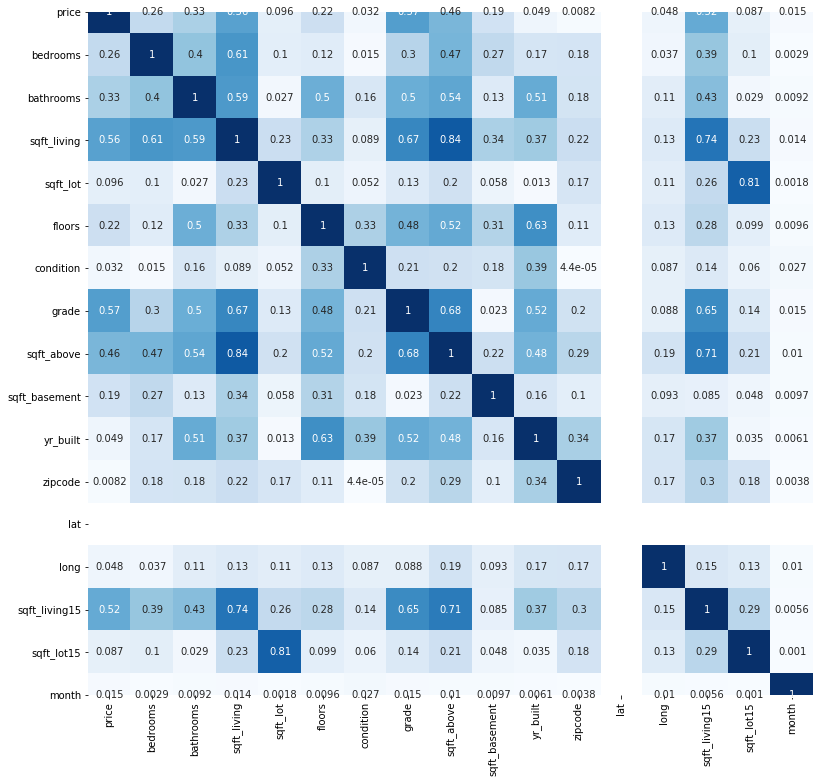

In [7]:
plt.figure(figsize=(13,15))
sns.heatmap(df.corr().abs(), annot=True, cmap='Blues', linecolor='Red', cbar=False, square=True)
plt.show()

In [8]:
df.corr().abs()

price  bedrooms  bathrooms  sqft_living  sqft_lot    floors  \
price          1.000000  0.259311   0.334423     0.557032  0.095664  0.216255   
bedrooms       0.259311  1.000000   0.404494     0.606408  0.101109  0.115265   
bathrooms      0.334423  0.404494   1.000000     0.591811  0.027485  0.498308   
sqft_living    0.557032  0.606408   0.591811     1.000000  0.225029  0.327314   
sqft_lot       0.095664  0.101109   0.027485     0.225029  1.000000  0.102432   
floors         0.216255  0.115265   0.498308     0.327314  0.102432  1.000000   
condition      0.032287  0.015288   0.159388     0.088900  0.051822  0.331168   
grade          0.573119  0.299777   0.501804     0.666058  0.129101  0.479326   
sqft_above     0.463991  0.471299   0.535911     0.839198  0.199994  0.522908   
sqft_basement  0.193337  0.265726   0.130660     0.335758  0.057929  0.312466   
yr_built       0.048830  0.173987   0.512186     0.370840  0.013329  0.634895   
zipcode        0.008159  0.175997   0.182166     0.224838  0.171871  0.114032   
lat                 NaN       NaN        NaN          NaN       NaN       NaN   
long           0.048436  0.037098   0.107873     0.129766  0.105731  0.131237   
sqft_living15  0.517334  0.392419   0.432471     0.737021  0.257545  0.282221   
sqft_lot15     0.086647  0.102656   0.028876     0.228739  0.814820  0.098937   
month          0.015136  0.002950   0.009165     0.013806  0.001753  0.009600   

               condition     grade  sqft_above  sqft_basement  yr_built  \
price           0.032287  0.573119    0.463991       0.193337  0.048830   
bedrooms        0.015288  0.299777    0.471299       0.265726  0.173987   
bathrooms       0.159388  0.501804    0.535911       0.130660  0.512186   
sqft_living     0.088900  0.666058    0.839198       0.335758  0.370840   
sqft_lot        0.051822  0.129101    0.199994       0.057929  0.013329   
floors          0.331168  0.479326    0.522908       0.312466  0.634895   
condition       1.000000  0.207492    0.199595       0.180298  0.389343   
grade           0.207492  1.000000    0.676909       0.022683  0.517462   
sqft_above      0.199595  0.676909    1.000000       0.221024  0.480949   
sqft_basement   0.180298  0.022683    0.221024       1.000000  0.163792   
yr_built        0.389343  0.517462    0.480949       0.163792  1.000000   
zipcode         0.000044  0.198327    0.291527       0.099808  0.342843   
lat                  NaN       NaN         NaN            NaN       NaN   
long            0.087394  0.088405    0.188647       0.093246  0.167050   
sqft_living15   0.140314  0.649441    0.714802       0.085039  0.370179   
sqft_lot15      0.059615  0.144387    0.209511       0.047631  0.034721   
month           0.026795  0.015234    0.010018       0.009744  0.006101   

                zipcode  lat      long  sqft_living15  sqft_lot15     month  
price          0.008159  NaN  0.048436       0.517334    0.086647  0.015136  
bedrooms       0.175997  NaN  0.037098       0.392419    0.102656  0.002950  
bathrooms      0.182166  NaN  0.107873       0.432471    0.028876  0.009165  
sqft_living    0.224838  NaN  0.129766       0.737021    0.228739  0.013806  
sqft_lot       0.171871  NaN  0.105731       0.257545    0.814820  0.001753  
floors         0.114032  NaN  0.131237       0.282221    0.098937  0.009600  
condition      0.000044  NaN  0.087394       0.140314    0.059615  0.026795  
grade          0.198327  NaN  0.088405       0.649441    0.144387  0.015234  
sqft_above     0.291527  NaN  0.188647       0.714802    0.209511  0.010018  
sqft_basement  0.099808  NaN  0.093246       0.085039    0.047631  0.009744  
yr_built       0.342843  NaN  0.167050       0.370179    0.034721  0.006101  
zipcode        1.000000  NaN  0.171850       0.296319    0.184714  0.003771  
lat                 NaN  NaN       NaN            NaN         NaN       NaN  
long           0.171850  NaN  1.000000       0.152640    0.128445  0.010168  
sqft_living15  0.296319  NaN  0.152640

## Markdown correlation

        .57 grade and price
        .46 sqft_above and price
        .55 sqft_living and price
        .52 sqft_living15 and price
        .33 bathroom and price
        .26 bedroom and price
        .19 sqft_basement and price
       

# For seller: How does categorical (zipcode, floors, month) variables tell about price  of house?
(categorical) Exploratory OLS Model


Zipcodes are categorical need to transform

In [41]:
zip_dum = pd.get_dummies(df, columns=['zipcode'], drop_first=True)

In [42]:
# zip_dum.filter(regex='zipcode', axis=1)
zipcodes = zip_dum[zip_dum.columns[pd.Series(zip_dum.columns).str.startswith('zipcode')]]
zipcodes = list(zipcodes.columns)

In [323]:
len(zipcodes)

69

## Finding best linear relation to price

In [324]:
columns = list(df.columns.drop(['price', 'zipcode']))
for col in columns:
    print(col, "vs price")
    mk_OLS(df, cols=col ,target="price")

bedrooms vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.858
Model:                            OLS   Adj. R-squared (uncentered):              0.858
Method:                 Least Squares   F-statistic:                          1.086e+05
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:20   Log-Likelihood:                     -2.4315e+05
No. Observations:               17965   AIC:                                  4.863e+05
Df Residuals:                   17964   BIC:                                  4.863e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bedrooms    1.319e+05    400.257    329.470      0.000    1.31e+05    1.33e+05
==============================================================================
Omnibus:                      256.532   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              242.609
Skew:                           0.250   Prob(JB):                     2.08e-53
Kurtosis:                       2.727   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

bathrooms vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.837
Model:                            OLS   Adj. R-squared (uncentered):              0.837
Method:                 Least Squares   F-statistic:                          9.218e+04
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:20   Log-Likelihood:                     -2.4439e+05
No. Observations:               17965   AIC:                                  4.888e+05
Df Residuals:                   17964   BIC:                                  4.888e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bathrooms   2.519e+05    829.723    303.605      0.000     2.5e+05    2.54e+05
==============================================================================
Omnibus:                      105.072   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              106.801
Skew:                           0.188   Prob(JB):                     6.43e-24
Kurtosis:                       2.959   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

sqft_living vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.893
Model:                            OLS   Adj. R-squared (uncentered):              0.893
Method:                 Least Squares   F-statistic:                          1.502e+05
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:20   Log-Likelihood:                     -2.4059e+05
No. Observations:               17965   AIC:                                  4.812e+05
Df Residuals:                   17964   BIC:                                  4.812e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
sqft_living   226.5768      0.585    387.609      0.000     225.431     227.723
==============================================================================
Omnibus:                       63.919   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.563
Skew:                           0.146   Prob(JB):                     9.56e-15
Kurtosis:                       2.974   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

sqft_lot vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.398
Model:                            OLS   Adj. R-squared (uncentered):              0.398
Method:                 Least Squares   F-statistic:                          1.190e+04
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:20   Log-Likelihood:                     -2.5612e+05
No. Observations:               17965   AIC:                                  5.122e+05
Df Residuals:                   17964   BIC:                                  5.122e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
sqft_lot      20.3171      0.186    109.085      0.000      19.952      20.682
==============================================================================
Omnibus:                     9421.564   Durbin-Watson:                   1.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           129495.754
Skew:                          -2.206   Prob(JB):                         0.00
Kurtosis:                      15.391   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

floors vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.805
Model:                            OLS   Adj. R-squared (uncentered):              0.805
Method:                 Least Squares   F-statistic:                          7.411e+04
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:20   Log-Likelihood:                     -2.4600e+05
No. Observations:               17965   AIC:                                  4.920e+05
Df Residuals:                   17964   BIC:                                  4.920e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
floors      2.853e+05   1048.161    272.228      0.000    2.83e+05    2.87e+05
==============================================================================
Omnibus:                        4.887   Durbin-Watson:                   1.767
Prob(Omnibus):                  0.087   Jarque-Bera (JB):                4.810
Skew:                           0.027   Prob(JB):                       0.0903
Kurtosis:                       2.941   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

condition vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.843
Model:                            OLS   Adj. R-squared (uncentered):              0.843
Method:                 Least Squares   F-statistic:                          9.628e+04
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:20   Log-Likelihood:                     -2.4406e+05
No. Observations:               17965   AIC:                                  4.881e+05
Df Residuals:                   17964   BIC:                                  4.881e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
condition   1.279e+05    412.322    310.296      0.000    1.27e+05    1.29e+05
==============================================================================
Omnibus:                      349.575   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              329.270
Skew:                           0.292   Prob(JB):                     3.16e-72
Kurtosis:                       2.687   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

grade vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.904
Model:                            OLS   Adj. R-squared (uncentered):              0.904
Method:                 Least Squares   F-statistic:                          1.684e+05
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:20   Log-Likelihood:                     -2.3967e+05
No. Observations:               17965   AIC:                                  4.793e+05
Df Residuals:                   17964   BIC:                                  4.793e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
grade       6.124e+04    149.246    410.343      0.000    6.09e+04    6.15e+04
==============================================================================
Omnibus:                      969.755   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              989.943
Skew:                           0.536   Prob(JB):                    1.09e-215
Kurtosis:                       2.585   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

sqft_above vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.860
Model:                            OLS   Adj. R-squared (uncentered):              0.860
Method:                 Least Squares   F-statistic:                          1.105e+05
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:20   Log-Likelihood:                     -2.4301e+05
No. Observations:               17965   AIC:                                  4.860e+05
Df Residuals:                   17964   BIC:                                  4.860e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
sqft_above   253.0410      0.761    332.423      0.000     251.549     254.533
==============================================================================
Omnibus:                       54.798   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.991
Skew:                           0.121   Prob(JB):                     1.89e-12
Kurtosis:                       2.885   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

sqft_basement vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.322
Model:                            OLS   Adj. R-squared (uncentered):              0.322
Method:                 Least Squares   F-statistic:                              8515.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:20   Log-Likelihood:                     -2.5720e+05
No. Observations:               17965   AIC:                                  5.144e+05
Df Residuals:                   17964   BIC:                                  5.144e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
sqft_basement   605.4309      6.561     92.279      0.000     592.571     618.291
==============================================================================
Omnibus:                      338.196   Durbin-Watson:                   0.837
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              358.114
Skew:                          -0.336   Prob(JB):                     1.72e-78
Kurtosis:                       3.165   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.869
Model:                            OLS   Adj. R-squared (uncentered):              0.869
Method:                 Least Squares   F-statistic:                          1.188e+05
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:20   Log-Likelihood:                     -2.4245e+05
No. Observations:               17965   AIC:                                  4.849e+05
Df Residuals:                   17964   BIC:                                  4.849e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
yr_built     229.1899      0.665    344.720      0.000     227.887     230.493
==============================================================================
Omnibus:                     1239.289   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1121.139
Skew:                           0.546   Prob(JB):                    3.53e-244
Kurtosis:                       2.448   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

lat vs price


/Users/Alisa/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1657: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       inf
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                nan
Time:                        11:22:20   Log-Likelihood:            -2.4247e+05
No. Observations:               17965   AIC:                         4.849e+05
Df Residuals:                   17964   BIC:                         4.849e+05
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
lat         9613.2414     27.923    344.272      0.000    9558.509    9667.974
==============================================================================
Omnibus:                     1211.314   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1098.428
Skew:                           0.541   Prob(JB):                    3.02e-239
Kurtosis:                       2.454   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

long vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.868
Model:                            OLS   Adj. R-squared (uncentered):              0.868
Method:                 Least Squares   F-statistic:                          1.185e+05
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:20   Log-Likelihood:                     -2.4247e+05
No. Observations:               17965   AIC:                                  4.849e+05
Df Residuals:                   17964   BIC:                                  4.850e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
long       -3704.9239     10.765   -344.177      0.000   -3726.023   -3683.824
==============================================================================
Omnibus:                     1211.617   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1097.374
Skew:                           0.540   Prob(JB):                    5.11e-239
Kurtosis:                       2.454   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

sqft_living15 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.896
Model:                            OLS   Adj. R-squared (uncentered):              0.896
Method:                 Least Squares   F-statistic:                          1.545e+05
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:20   Log-Likelihood:                     -2.4037e+05
No. Observations:               17965   AIC:                                  4.807e+05
Df Residuals:                   17964   BIC:                                  4.807e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
sqft_living15   233.8537      0.595    393.037      0.000     232.687     235.020
==============================================================================
Omnibus:                      395.130   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              421.215
Skew:                           0.374   Prob(JB):                     3.42e-92
Kurtosis:                       3.057   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

sqft_lot15 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.464
Model:                            OLS   Adj. R-squared (uncentered):              0.464
Method:                 Least Squares   F-statistic:                          1.554e+04
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:20   Log-Likelihood:                     -2.5508e+05
No. Observations:               17965   AIC:                                  5.102e+05
Df Residuals:                   17964   BIC:                                  5.102e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
sqft_lot15    25.8319      0.207    124.654      0.000      25.426      26.238
==============================================================================
Omnibus:                     8389.188   Durbin-Watson:                   1.201
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            87987.939
Skew:                          -1.982   Prob(JB):                         0.00
Kurtosis:                      13.091   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

month vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.705
Model:                            OLS   Adj. R-squared (uncentered):              0.705
Method:                 Least Squares   F-statistic:                          4.286e+04
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:20   Log-Likelihood:                     -2.4973e+05
No. Observations:               17965   AIC:                                  4.995e+05
Df Residuals:                   17964   BIC:                                  4.995e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
month        5.59e+04    270.043    207.022      0.000    5.54e+04    5.64e+04
==============================================================================
Omnibus:                      292.094   Durbin-Watson:                   1.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.530
Skew:                           0.129   Prob(JB):                     5.73e-43
Kurtosis:                       2.561   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

    bedrooms           r2: .858
    bathrooms          r2: .837
                                        sqft_living        r2: .893
    floors             r2: .805
    condition          r2: .843
    grade              r2: .904
    sqft_above         r2: .860
    yr_built           r2: .869
    zipcode            r2: .868
    long               r2: .868
    sqft_living 15     r2: .896


## Finding non multicolinear for zipcodes

In [325]:
for zips in zipcodes:
    feat_with_zips = []
    good_vif(zip_dum, columns, target=zips)
    feat_with_zips.append(list(good_vif(zip_dum, columns, target=zips).keys()))
    print(feat_with_zips)

[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'month']]
[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'month']]
[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'month']]
[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'month']]
[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'month']]
[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition'

[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'month']]
[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'month']]
[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'month']]
[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'month']]
[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'month']]
[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition'

    Good with:
    bedrooms; price; bathrooms; sqqft_living; sqft_lot; floors; condition; grade;          sqft_above; sqft_basement; yr_build; lat; long; sqft_living15; sqft_lot15; month

This shows that the columns have good vif meaning that they cannot predict the other zipcodes; **no muticolinearity**

In [43]:
columns = list(zip_dum.columns.drop(zipcodes))
columns.remove('price')

In [45]:
best_feat = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'month']

In [328]:
len(best_feat)

15

In [329]:
high_vif(zip_dum, best_feat)

{'bedrooms': 7.04,
 'bathrooms': 6.13,
 'sqft_living': 9.36,
 'sqft_lot': 1.66,
 'floors': 5.13,
 'condition': 6.36,
 'grade': 10.37,
 'sqft_above': 7.15,
 'sqft_basement': 1.47,
 'yr_built': 7.61,
 'lat': 1.0,
 'long': 7.59,
 'sqft_living15': 9.6,
 'sqft_lot15': 1.86,
 'month': 3.39}

    Best features for predicting price and nonmulticolinear with other features:
    
    sqft_living15; long; yr_built; sqft_above; grade; condition; floors; sqft_living; bathrooms; bedrooms

In [46]:
added_features(zip_dum, zipcodes, columns=best_feat)

bedrooms vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.945
Model:                            OLS   Adj. R-squared (uncentered):              0.945
Method:                 Least Squares   F-statistic:                              4405.
Date:                Wed, 19 Feb 2020   Prob (F-statistic):                        0.00
Time:                        15:03:28   Log-Likelihood:                     -2.3461e+05
No. Observations:               17965   AIC:                                  4.694e+05
Df Residuals:                   17895   BIC:                                  4.699e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.095e+04   9056.469      2.313      0.021    3195.783    3.87e+04
zipcode_98003  7.047e+04   7555.953      9.326      0.000    5.57e+04    8.53e+04
zipcode_98004  5.238e+05   1.21e+04     43.369      0.000       5e+05    5.47e+05
zipcode_98005  4.402e+05   1.11e+04     39.530      0.000    4.18e+05    4.62e+05
zipcode_98006  3.931e+05   7277.094     54.014      0.000    3.79e+05    4.07e+05
zipcode_98007  3.214e+05   1.09e+04     29.622      0.000       3e+05    3.43e+05
zipcode_98008  3.015e+05   7915.591     38.088      0.000    2.86e+05    3.17e+05
zipcode_98010  1.593e+05    1.4e+04     11.366      0.000    1.32e+05    1.87e+05
zipcode_98011  2.532e+05   8949.729     28.286      0.000    2.36e+05    2.71e+05
zipcode_98014  2.163e+05   1.38e+04     15.670      0.000    1.89e+05    2.43e+05
zipcode_98019  1.911e+05   9575.340     19.961      0.000    1.72e+05     2.1e+05
zipcode_98022  6.918e+04   9244.600      7.483      0.000    5.11e+04    8.73e+04
zipcode_98023  5.979e+04   6080.427      9.834      0.000    4.79e+04    7.17e+04
zipcode_98024  1.846e+05   1.76e+04     10.494      0.000     1.5e+05    2.19e+05
zipcode_98027  3.247e+05   6964.663     46.620      0.000    3.11e+05    3.38e+05
zipcode_98028  2.255e+05   7580.849     29.748      0.000    2.11e+05     2.4e+05
zipcode_98029  3.513e+05   7249.986     48.449      0.000    3.37e+05    3.65e+05
zipcode_98030  6.811e+04   7915.655      8.604      0.000    5.26e+04    8.36e+04
zipcode_98031   7.15e+04   7660.794      9.333      0.000    5.65e+04    8.65e+04
zipcode_98032  3.236e+04   1.11e+04      2.926      0.003    1.07e+04     5.4e+04
zipcode_98033  3.882e+05   7230.558     53.691      0.000    3.74e+05    4.02e+05
zipcode_98034  2.348e+05   5961.355     39.382      0.000    2.23e+05    2.46e+05
zipcode_98038  1.229e+05   5848.462     21.020      0.000    1.11e+05    1.34e+05
zipcode_98039  6.244e+05   6.58e+04      9.495      0.000    4.96e+05    7.53e+05
zipcode_98040   5.16e+05   1.21e+04     42.567      0.000    4.92e+05     5.4e+05
zipcode_98042  8.097e+04   5935.047     13.643      0.000    6.93e+04    9.26e+04
zipcode_98045  2.322e+05   3.61e+04      6.427      0.000    1.61e+05    3.03e+05
zipcode_98052  3.738e+05   5980.647     62.500      0.000    3.62e+05    3.86e+05
zipcode_98053  3.942e+05   6943.400     56.774      0.000    3.81e+05    4.08e+05
zipcode_98055  9.547e+04   7748.482     12.322      0.000    8.03e+04    1.11e+05
zipcode_98056  1.781e+05   6552.196     27.182      0.000    1.65e+05    1.91e+05
zipcode_98058  1.145e+05   6425.679     17.813      0.000    1.02e+05    1.27e+05
zipcode_98059  1.974e+05   6542.967     30.168      0.000    1.85e+05     2.1e+05
zipcode_98065  2.773e+05   7651.

bathrooms vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.945
Model:                            OLS   Adj. R-squared (uncentered):              0.945
Method:                 Least Squares   F-statistic:                              4391.
Date:                Wed, 19 Feb 2020   Prob (F-statistic):                        0.00
Time:                        15:03:28   Log-Likelihood:                     -2.3463e+05
No. Observations:               17965   AIC:                                  4.694e+05
Df Residuals:                   17895   BIC:                                  4.699e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  9.381e+04   8782.444     10.682      0.000    7.66e+04    1.11e+05
zipcode_98003  1.281e+05   7286.029     17.586      0.000    1.14e+05    1.42e+05
zipcode_98004  6.168e+05   1.18e+04     52.141      0.000    5.94e+05     6.4e+05
zipcode_98005  5.128e+05   1.09e+04     47.087      0.000    4.91e+05    5.34e+05
zipcode_98006  4.593e+05   6918.856     66.386      0.000    4.46e+05    4.73e+05
zipcode_98007  4.075e+05   1.06e+04     38.613      0.000    3.87e+05    4.28e+05
zipcode_98008  3.924e+05   7480.865     52.456      0.000    3.78e+05    4.07e+05
zipcode_98010  2.228e+05   1.39e+04     16.054      0.000    1.96e+05     2.5e+05
zipcode_98011  3.084e+05   8717.062     35.380      0.000    2.91e+05    3.25e+05
zipcode_98014  2.649e+05   1.37e+04     19.334      0.000    2.38e+05    2.92e+05
zipcode_98019  2.314e+05   9424.560     24.554      0.000    2.13e+05     2.5e+05
zipcode_98022  1.261e+05   9043.271     13.939      0.000    1.08e+05    1.44e+05
zipcode_98023  1.251e+05   5679.396     22.035      0.000    1.14e+05    1.36e+05
zipcode_98024  2.553e+05   1.75e+04     14.603      0.000    2.21e+05     2.9e+05
zipcode_98027  3.614e+05   6763.403     53.433      0.000    3.48e+05    3.75e+05
zipcode_98028  2.883e+05   7276.589     39.616      0.000    2.74e+05    3.03e+05
zipcode_98029  3.749e+05   7132.685     52.558      0.000    3.61e+05    3.89e+05
zipcode_98030   1.26e+05   7644.015     16.478      0.000    1.11e+05    1.41e+05
zipcode_98031   1.34e+05   7358.395     18.215      0.000     1.2e+05    1.48e+05
zipcode_98032  1.218e+05   1.08e+04     11.286      0.000    1.01e+05    1.43e+05
zipcode_98033  4.526e+05   6908.911     65.506      0.000    4.39e+05    4.66e+05
zipcode_98034  3.024e+05   5536.392     54.626      0.000    2.92e+05    3.13e+05
zipcode_98038  1.621e+05   5588.235     29.005      0.000    1.51e+05    1.73e+05
zipcode_98039  7.465e+05   6.58e+04     11.344      0.000    6.17e+05    8.75e+05
zipcode_98040  5.901e+05   1.19e+04     49.569      0.000    5.67e+05    6.13e+05
zipcode_98042  1.382e+05   5571.541     24.813      0.000    1.27e+05    1.49e+05
zipcode_98045  2.595e+05   3.61e+04      7.179      0.000    1.89e+05     3.3e+05
zipcode_98052  4.318e+05   5596.283     77.160      0.000    4.21e+05    4.43e+05
zipcode_98053  4.116e+05   6864.454     59.962      0.000    3.98e+05    4.25e+05
zipcode_98055  1.543e+05   7489.946     20.596      0.000     1.4e+05    1.69e+05
zipcode_98056  2.431e+05   6185.967     39.296      0.000    2.31e+05    2.55e+05
zipcode_98058   1.83e+05   6017.203     30.413      0.000    1.71e+05    1.95e+05
zipcode_98059  2.661e+05   6123.986     43.452      0.000    2.54e+05    2.78e+05
zipcode_98065   3.09e+05   7491.

sqft_living vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.970
Model:                            OLS   Adj. R-squared (uncentered):              0.970
Method:                 Least Squares   F-statistic:                              8271.
Date:                Wed, 19 Feb 2020   Prob (F-statistic):                        0.00
Time:                        15:03:28   Log-Likelihood:                     -2.2918e+05
No. Observations:               17965   AIC:                                  4.585e+05
Df Residuals:                   17895   BIC:                                  4.590e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2050.9329   6487.158      0.316      0.752   -1.07e+04    1.48e+04
zipcode_98003   1.75e+04   5405.080      3.237      0.001    6901.000    2.81e+04
zipcode_98004  4.838e+05   8793.093     55.019      0.000    4.67e+05    5.01e+05
zipcode_98005  3.589e+05   8115.252     44.221      0.000    3.43e+05    3.75e+05
zipcode_98006  3.001e+05   5237.830     57.302      0.000     2.9e+05     3.1e+05
zipcode_98007  2.747e+05   7842.408     35.032      0.000    2.59e+05     2.9e+05
zipcode_98008  2.617e+05   5597.751     46.748      0.000    2.51e+05    2.73e+05
zipcode_98010  9.194e+04   1.03e+04      8.940      0.000    7.18e+04    1.12e+05
zipcode_98011  1.632e+05   6506.331     25.078      0.000     1.5e+05    1.76e+05
zipcode_98014  1.326e+05   1.02e+04     13.055      0.000    1.13e+05    1.52e+05
zipcode_98019   1.02e+05   6987.865     14.602      0.000    8.83e+04    1.16e+05
zipcode_98022  2.488e+04   6689.239      3.720      0.000    1.18e+04     3.8e+04
zipcode_98023 -1876.6898   4270.955     -0.439      0.660   -1.02e+04    6494.794
zipcode_98024  1.452e+05   1.29e+04     11.231      0.000     1.2e+05     1.7e+05
zipcode_98027  2.239e+05   5048.096     44.348      0.000    2.14e+05    2.34e+05
zipcode_98028  1.511e+05   5452.193     27.705      0.000     1.4e+05    1.62e+05
zipcode_98029  2.614e+05   5248.769     49.807      0.000    2.51e+05    2.72e+05
zipcode_98030  1.202e+04   5663.720      2.122      0.034     914.688    2.31e+04
zipcode_98031  2.264e+04   5453.892      4.151      0.000    1.19e+04    3.33e+04
zipcode_98032  3408.2229   8011.167      0.425      0.671   -1.23e+04    1.91e+04
zipcode_98033   3.26e+05   5165.520     63.105      0.000    3.16e+05    3.36e+05
zipcode_98034  1.906e+05   4127.412     46.173      0.000    1.82e+05    1.99e+05
zipcode_98038   4.51e+04   4133.232     10.911      0.000     3.7e+04    5.32e+04
zipcode_98039  6.338e+05   4.86e+04     13.045      0.000    5.39e+05    7.29e+05
zipcode_98040   4.38e+05   8860.780     49.426      0.000    4.21e+05    4.55e+05
zipcode_98042  2.106e+04   4155.512      5.068      0.000    1.29e+04    2.92e+04
zipcode_98045   1.29e+05   2.67e+04      4.833      0.000    7.67e+04    1.81e+05
zipcode_98052  2.821e+05   4257.616     66.256      0.000    2.74e+05     2.9e+05
zipcode_98053  2.631e+05   5160.396     50.975      0.000    2.53e+05    2.73e+05
zipcode_98055  4.658e+04   5556.236      8.384      0.000    3.57e+04    5.75e+04
zipcode_98056  1.152e+05   4640.831     24.829      0.000    1.06e+05    1.24e+05
zipcode_98058  5.294e+04   4519.567     11.714      0.000    4.41e+04    6.18e+04
zipcode_98059  1.146e+05   4646.697     24.659      0.000    1.05e+05    1.24e+05
zipcode_98065  1.477e+05   5628.

sqft_lot vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.933
Model:                            OLS   Adj. R-squared (uncentered):              0.932
Method:                 Least Squares   F-statistic:                              3544.
Date:                Wed, 19 Feb 2020   Prob (F-statistic):                        0.00
Time:                        15:03:29   Log-Likelihood:                     -2.3644e+05
No. Observations:               17965   AIC:                                  4.730e+05
Df Residuals:                   17895   BIC:                                  4.736e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.193e+05   9470.084     23.158      0.000    2.01e+05    2.38e+05
zipcode_98003  2.591e+05   7727.846     33.532      0.000    2.44e+05    2.74e+05
zipcode_98004  7.171e+05    1.3e+04     55.308      0.000    6.92e+05    7.42e+05
zipcode_98005  6.467e+05   1.18e+04     54.741      0.000    6.23e+05     6.7e+05
zipcode_98006  6.015e+05   7240.509     83.068      0.000    5.87e+05    6.16e+05
zipcode_98007  5.408e+05   1.14e+04     47.268      0.000    5.18e+05    5.63e+05
zipcode_98008  5.168e+05   7985.497     64.713      0.000    5.01e+05    5.32e+05
zipcode_98010  3.103e+05   1.53e+04     20.275      0.000     2.8e+05     3.4e+05
zipcode_98011  4.585e+05   9284.809     49.380      0.000     4.4e+05    4.77e+05
zipcode_98014  3.464e+05   1.52e+04     22.846      0.000    3.17e+05    3.76e+05
zipcode_98019   3.79e+05   1.01e+04     37.528      0.000    3.59e+05    3.99e+05
zipcode_98022  2.289e+05   9854.979     23.231      0.000     2.1e+05    2.48e+05
zipcode_98023  2.572e+05   5846.376     44.000      0.000    2.46e+05    2.69e+05
zipcode_98024  3.089e+05   1.94e+04     15.913      0.000    2.71e+05    3.47e+05
zipcode_98027   4.98e+05   7102.335     70.115      0.000    4.84e+05    5.12e+05
zipcode_98028  4.188e+05   7716.828     54.270      0.000    4.04e+05    4.34e+05
zipcode_98029  5.544e+05   7298.044     75.970      0.000     5.4e+05    5.69e+05
zipcode_98030  2.707e+05   8077.446     33.508      0.000    2.55e+05    2.86e+05
zipcode_98031  2.694e+05   7788.854     34.582      0.000    2.54e+05    2.85e+05
zipcode_98032  2.286e+05   1.18e+04     19.395      0.000    2.06e+05    2.52e+05
zipcode_98033  5.846e+05   7289.696     80.198      0.000     5.7e+05    5.99e+05
zipcode_98034  4.363e+05   5669.653     76.957      0.000    4.25e+05    4.47e+05
zipcode_98038  3.219e+05   5533.203     58.183      0.000    3.11e+05    3.33e+05
zipcode_98039  8.166e+05   7.28e+04     11.223      0.000    6.74e+05    9.59e+05
zipcode_98040  7.203e+05    1.3e+04     55.541      0.000    6.95e+05    7.46e+05
zipcode_98042  2.688e+05   5722.160     46.975      0.000    2.58e+05     2.8e+05
zipcode_98045  4.336e+05   3.99e+04     10.878      0.000    3.55e+05    5.12e+05
zipcode_98052   5.79e+05   5638.565    102.693      0.000    5.68e+05     5.9e+05
zipcode_98053  5.481e+05   7209.851     76.019      0.000    5.34e+05    5.62e+05
zipcode_98055  2.807e+05   7986.327     35.143      0.000    2.65e+05    2.96e+05
zipcode_98056  3.781e+05   6431.679     58.788      0.000    3.65e+05    3.91e+05
zipcode_98058  3.144e+05   6245.875     50.337      0.000    3.02e+05    3.27e+05
zipcode_98059  4.058e+05   6318.931     64.226      0.000    3.93e+05    4.18e+05
zipcode_98065  4.867e+05   7719.

floors vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.935
Model:                            OLS   Adj. R-squared (uncentered):              0.935
Method:                 Least Squares   F-statistic:                              3700.
Date:                Wed, 19 Feb 2020   Prob (F-statistic):                        0.00
Time:                        15:03:29   Log-Likelihood:                     -2.3608e+05
No. Observations:               17965   AIC:                                  4.723e+05
Df Residuals:                   17895   BIC:                                  4.728e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  1.511e+05   9507.418     15.898      0.000    1.33e+05     1.7e+05
zipcode_98003  1.982e+05   7827.975     25.316      0.000    1.83e+05    2.14e+05
zipcode_98004  6.666e+05   1.28e+04     51.999      0.000    6.41e+05    6.92e+05
zipcode_98005   6.03e+05   1.17e+04     51.619      0.000     5.8e+05    6.26e+05
zipcode_98006  5.382e+05   7390.057     72.826      0.000    5.24e+05    5.53e+05
zipcode_98007  4.741e+05   1.14e+04     41.560      0.000    4.52e+05    4.96e+05
zipcode_98008  4.657e+05   8004.873     58.178      0.000     4.5e+05    4.81e+05
zipcode_98010   2.77e+05    1.5e+04     18.408      0.000    2.47e+05    3.06e+05
zipcode_98011   3.84e+05   9391.686     40.883      0.000    3.66e+05    4.02e+05
zipcode_98014  3.239e+05   1.49e+04     21.814      0.000    2.95e+05    3.53e+05
zipcode_98019  2.946e+05   1.03e+04     28.711      0.000    2.74e+05    3.15e+05
zipcode_98022  1.907e+05   9760.855     19.542      0.000    1.72e+05     2.1e+05
zipcode_98023  1.944e+05   6073.050     32.005      0.000    1.82e+05    2.06e+05
zipcode_98024  3.115e+05   1.89e+04     16.453      0.000    2.74e+05    3.49e+05
zipcode_98027  4.394e+05   7274.022     60.402      0.000    4.25e+05    4.54e+05
zipcode_98028   3.54e+05   7856.026     45.065      0.000    3.39e+05    3.69e+05
zipcode_98029  4.385e+05   7835.939     55.966      0.000    4.23e+05    4.54e+05
zipcode_98030  1.937e+05   8258.415     23.458      0.000    1.78e+05     2.1e+05
zipcode_98031  2.005e+05   7944.649     25.238      0.000    1.85e+05    2.16e+05
zipcode_98032  1.764e+05   1.17e+04     15.094      0.000    1.53e+05    1.99e+05
zipcode_98033  5.158e+05   7461.353     69.124      0.000    5.01e+05     5.3e+05
zipcode_98034   3.74e+05   5891.051     63.488      0.000    3.62e+05    3.86e+05
zipcode_98038  2.275e+05   6119.463     37.173      0.000    2.15e+05    2.39e+05
zipcode_98039  7.737e+05   7.13e+04     10.848      0.000    6.34e+05    9.14e+05
zipcode_98040  6.698e+05   1.28e+04     52.226      0.000    6.45e+05    6.95e+05
zipcode_98042  2.014e+05   6036.874     33.357      0.000     1.9e+05    2.13e+05
zipcode_98045  3.236e+05   3.92e+04      8.255      0.000    2.47e+05       4e+05
zipcode_98052  5.022e+05   6024.245     83.360      0.000     4.9e+05    5.14e+05
zipcode_98053  4.833e+05   7417.125     65.153      0.000    4.69e+05    4.98e+05
zipcode_98055   2.14e+05   8104.467     26.406      0.000    1.98e+05     2.3e+05
zipcode_98056  3.054e+05   6686.479     45.675      0.000    2.92e+05    3.19e+05
zipcode_98058  2.523e+05   6453.658     39.093      0.000     2.4e+05    2.65e+05
zipcode_98059  3.282e+05   6663.596     49.252      0.000    3.15e+05    3.41e+05
zipcode_98065  3.786e+05   8176.

condition vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.933
Model:                            OLS   Adj. R-squared (uncentered):              0.932
Method:                 Least Squares   F-statistic:                              3533.
Date:                Wed, 19 Feb 2020   Prob (F-statistic):                        0.00
Time:                        15:03:29   Log-Likelihood:                     -2.3646e+05
No. Observations:               17965   AIC:                                  4.731e+05
Df Residuals:                   17895   BIC:                                  4.736e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  1.055e+05   1.05e+04     10.036      0.000    8.49e+04    1.26e+05
zipcode_98003  1.673e+05   8713.212     19.204      0.000     1.5e+05    1.84e+05
zipcode_98004   6.17e+05   1.37e+04     45.112      0.000     5.9e+05    6.44e+05
zipcode_98005  5.491e+05   1.26e+04     43.489      0.000    5.24e+05    5.74e+05
zipcode_98006  4.968e+05   8538.039     58.186      0.000     4.8e+05    5.14e+05
zipcode_98007  4.361e+05   1.23e+04     35.563      0.000    4.12e+05     4.6e+05
zipcode_98008  4.114e+05   9130.823     45.059      0.000    3.94e+05    4.29e+05
zipcode_98010  2.434e+05   1.58e+04     15.398      0.000    2.12e+05    2.74e+05
zipcode_98011  3.704e+05   1.01e+04     36.812      0.000    3.51e+05     3.9e+05
zipcode_98014  3.052e+05   1.55e+04     19.696      0.000    2.75e+05    3.36e+05
zipcode_98019  3.063e+05   1.07e+04     28.596      0.000    2.85e+05    3.27e+05
zipcode_98022  1.435e+05   1.08e+04     13.342      0.000    1.22e+05    1.65e+05
zipcode_98023  1.633e+05   7114.304     22.947      0.000    1.49e+05    1.77e+05
zipcode_98024  2.745e+05   1.97e+04     13.968      0.000    2.36e+05    3.13e+05
zipcode_98027  4.309e+05   8026.691     53.684      0.000    4.15e+05    4.47e+05
zipcode_98028  3.336e+05   8644.617     38.590      0.000    3.17e+05    3.51e+05
zipcode_98029  4.595e+05   8233.046     55.810      0.000    4.43e+05    4.76e+05
zipcode_98030  1.786e+05   8986.156     19.874      0.000    1.61e+05    1.96e+05
zipcode_98031   1.74e+05   8837.115     19.692      0.000    1.57e+05    1.91e+05
zipcode_98032  1.265e+05   1.26e+04     10.051      0.000    1.02e+05    1.51e+05
zipcode_98033  4.817e+05   8478.101     56.819      0.000    4.65e+05    4.98e+05
zipcode_98034  3.396e+05   6973.622     48.691      0.000    3.26e+05    3.53e+05
zipcode_98038  2.364e+05   6688.517     35.349      0.000    2.23e+05     2.5e+05
zipcode_98039  7.117e+05    7.3e+04      9.750      0.000    5.69e+05    8.55e+05
zipcode_98040  6.149e+05   1.38e+04     44.707      0.000    5.88e+05    6.42e+05
zipcode_98042  1.786e+05   7068.382     25.273      0.000    1.65e+05    1.92e+05
zipcode_98045  3.505e+05   4.01e+04      8.746      0.000    2.72e+05    4.29e+05
zipcode_98052  4.882e+05   6901.452     70.734      0.000    4.75e+05    5.02e+05
zipcode_98053  4.856e+05   7973.460     60.896      0.000     4.7e+05    5.01e+05
zipcode_98055   1.88e+05   8929.094     21.056      0.000    1.71e+05    2.06e+05
zipcode_98056  2.696e+05   7836.866     34.398      0.000    2.54e+05    2.85e+05
zipcode_98058  2.215e+05   7492.353     29.567      0.000    2.07e+05    2.36e+05
zipcode_98059  3.153e+05   7507.288     41.998      0.000    3.01e+05     3.3e+05
zipcode_98065  4.003e+05   8547.

grade vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.955
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                              5446.
Date:                Wed, 19 Feb 2020   Prob (F-statistic):                        0.00
Time:                        15:03:30   Log-Likelihood:                     -2.3279e+05
No. Observations:               17965   AIC:                                  4.657e+05
Df Residuals:                   17895   BIC:                                  4.663e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002 -1.601e+05   8657.272    -18.490      0.000   -1.77e+05   -1.43e+05
zipcode_98003 -1.562e+05   7634.329    -20.455      0.000   -1.71e+05   -1.41e+05
zipcode_98004  3.044e+05   1.14e+04     26.669      0.000    2.82e+05    3.27e+05
zipcode_98005  2.111e+05   1.07e+04     19.804      0.000     1.9e+05    2.32e+05
zipcode_98006  1.495e+05   7536.687     19.838      0.000    1.35e+05    1.64e+05
zipcode_98007   1.08e+05   1.03e+04     10.432      0.000    8.77e+04    1.28e+05
zipcode_98008  1.004e+05   7807.760     12.854      0.000    8.51e+04    1.16e+05
zipcode_98010  -5.13e+04   1.31e+04     -3.927      0.000   -7.69e+04   -2.57e+04
zipcode_98011  2.611e+04   8796.266      2.968      0.003    8868.523    4.34e+04
zipcode_98014 -1.346e+04   1.29e+04     -1.040      0.298   -3.88e+04    1.19e+04
zipcode_98019 -3.142e+04   9290.900     -3.382      0.001   -4.96e+04   -1.32e+04
zipcode_98022 -1.428e+05   8949.819    -15.961      0.000    -1.6e+05   -1.25e+05
zipcode_98023 -1.644e+05   6461.700    -25.449      0.000   -1.77e+05   -1.52e+05
zipcode_98024 -1.876e+04   1.62e+04     -1.158      0.247   -5.05e+04     1.3e+04
zipcode_98027  8.114e+04   7276.134     11.152      0.000    6.69e+04    9.54e+04
zipcode_98028  2163.9656   7645.048      0.283      0.777   -1.28e+04    1.71e+04
zipcode_98029  8.296e+04   7642.732     10.855      0.000     6.8e+04    9.79e+04
zipcode_98030 -1.436e+05   7855.889    -18.285      0.000   -1.59e+05   -1.28e+05
zipcode_98031 -1.376e+05   7631.894    -18.033      0.000   -1.53e+05   -1.23e+05
zipcode_98032 -1.691e+05   1.05e+04    -16.156      0.000    -1.9e+05   -1.49e+05
zipcode_98033   1.64e+05   7363.802     22.268      0.000     1.5e+05    1.78e+05
zipcode_98034  2.521e+04   6272.013      4.019      0.000    1.29e+04    3.75e+04
zipcode_98038 -9.843e+04   6266.376    -15.707      0.000   -1.11e+05   -8.61e+04
zipcode_98039  4.084e+05   5.95e+04      6.859      0.000    2.92e+05    5.25e+05
zipcode_98040   2.81e+05   1.15e+04     24.388      0.000    2.58e+05    3.04e+05
zipcode_98042 -1.358e+05   6298.333    -21.562      0.000   -1.48e+05   -1.23e+05
zipcode_98045 -1.245e+04   3.29e+04     -0.379      0.705   -7.69e+04     5.2e+04
zipcode_98052  1.303e+05   6530.709     19.958      0.000    1.18e+05    1.43e+05
zipcode_98053  1.232e+05   7387.185     16.675      0.000    1.09e+05    1.38e+05
zipcode_98055 -1.179e+05   7712.364    -15.286      0.000   -1.33e+05   -1.03e+05
zipcode_98056 -3.082e+04   6731.216     -4.578      0.000    -4.4e+04   -1.76e+04
zipcode_98058 -1.027e+05   6690.949    -15.346      0.000   -1.16e+05   -8.96e+04
zipcode_98059 -1.597e+04   6766.743     -2.361      0.018   -2.92e+04   -2710.748
zipcode_98065  4.825e+04   7741.

sqft_above vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.964
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                              6765.
Date:                Wed, 19 Feb 2020   Prob (F-statistic):                        0.00
Time:                        15:03:30   Log-Likelihood:                     -2.3092e+05
No. Observations:               17965   AIC:                                  4.620e+05
Df Residuals:                   17895   BIC:                                  4.625e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  1.605e+04   7159.456      2.241      0.025    2012.637    3.01e+04
zipcode_98003  4.946e+04   5933.110      8.337      0.000    3.78e+04    6.11e+04
zipcode_98004  5.346e+05   9649.874     55.401      0.000    5.16e+05    5.54e+05
zipcode_98005  4.189e+05   8881.052     47.169      0.000    4.01e+05    4.36e+05
zipcode_98006  3.608e+05   5672.826     63.602      0.000     3.5e+05    3.72e+05
zipcode_98007  3.141e+05   8615.305     36.458      0.000    2.97e+05    3.31e+05
zipcode_98008  3.114e+05   6106.070     51.004      0.000    2.99e+05    3.23e+05
zipcode_98010   1.11e+05   1.13e+04      9.793      0.000    8.88e+04    1.33e+05
zipcode_98011  2.029e+05   7138.756     28.420      0.000    1.89e+05    2.17e+05
zipcode_98014  1.497e+05   1.12e+04     13.368      0.000    1.28e+05    1.72e+05
zipcode_98019  1.147e+05   7730.789     14.836      0.000    9.95e+04     1.3e+05
zipcode_98022  3.578e+04   7390.755      4.841      0.000    2.13e+04    5.03e+04
zipcode_98023  3.757e+04   4655.576      8.069      0.000    2.84e+04    4.67e+04
zipcode_98024  1.639e+05   1.42e+04     11.508      0.000    1.36e+05    1.92e+05
zipcode_98027  2.734e+05   5493.181     49.774      0.000    2.63e+05    2.84e+05
zipcode_98028  1.929e+05   5963.264     32.350      0.000    1.81e+05    2.05e+05
zipcode_98029  2.711e+05   5831.995     46.481      0.000     2.6e+05    2.83e+05
zipcode_98030  3.347e+04   6246.467      5.358      0.000    2.12e+04    4.57e+04
zipcode_98031  5.228e+04   5993.451      8.723      0.000    4.05e+04     6.4e+04
zipcode_98032  4.502e+04   8797.667      5.118      0.000    2.78e+04    6.23e+04
zipcode_98033  3.593e+05   5666.198     63.409      0.000    3.48e+05     3.7e+05
zipcode_98034  2.329e+05   4485.836     51.922      0.000    2.24e+05    2.42e+05
zipcode_98038  5.103e+04   4626.407     11.030      0.000     4.2e+04    6.01e+04
zipcode_98039  6.563e+05   5.35e+04     12.258      0.000    5.51e+05    7.61e+05
zipcode_98040   4.99e+05   9707.133     51.401      0.000     4.8e+05    5.18e+05
zipcode_98042  3.627e+04   4607.437      7.873      0.000    2.72e+04    4.53e+04
zipcode_98045  1.516e+05   2.94e+04      5.156      0.000     9.4e+04    2.09e+05
zipcode_98052  3.184e+05   4656.776     68.367      0.000    3.09e+05    3.27e+05
zipcode_98053  2.662e+05   5766.105     46.167      0.000    2.55e+05    2.78e+05
zipcode_98055  7.475e+04   6107.902     12.238      0.000    6.28e+04    8.67e+04
zipcode_98056  1.444e+05   5097.567     28.336      0.000    1.34e+05    1.54e+05
zipcode_98058  8.554e+04   4954.074     17.266      0.000    7.58e+04    9.52e+04
zipcode_98059  1.289e+05   5163.607     24.972      0.000    1.19e+05    1.39e+05
zipcode_98065  1.548e+05   6277.

sqft_basement vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.933
Model:                            OLS   Adj. R-squared (uncentered):              0.933
Method:                 Least Squares   F-statistic:                              3555.
Date:                Wed, 19 Feb 2020   Prob (F-statistic):                        0.00
Time:                        15:03:30   Log-Likelihood:                     -2.3641e+05
No. Observations:               17965   AIC:                                  4.730e+05
Df Residuals:                   17895   BIC:                                  4.735e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.313e+05   9434.825     24.516      0.000    2.13e+05     2.5e+05
zipcode_98003  2.697e+05   7679.400     35.120      0.000    2.55e+05    2.85e+05
zipcode_98004  7.174e+05   1.29e+04     55.428      0.000    6.92e+05    7.43e+05
zipcode_98005  6.502e+05   1.18e+04     55.192      0.000    6.27e+05    6.73e+05
zipcode_98006   5.98e+05   7241.611     82.572      0.000    5.84e+05    6.12e+05
zipcode_98007  5.443e+05   1.14e+04     47.689      0.000    5.22e+05    5.67e+05
zipcode_98008  5.146e+05   7978.171     64.504      0.000    4.99e+05     5.3e+05
zipcode_98010  3.606e+05   1.52e+04     23.803      0.000    3.31e+05     3.9e+05
zipcode_98011   4.63e+05   9255.215     50.030      0.000    4.45e+05    4.81e+05
zipcode_98014  4.111e+05   1.49e+04     27.524      0.000    3.82e+05     4.4e+05
zipcode_98019  4.072e+05      1e+04     40.668      0.000    3.88e+05    4.27e+05
zipcode_98022  2.704e+05   9709.959     27.851      0.000    2.51e+05    2.89e+05
zipcode_98023  2.621e+05   5811.822     45.104      0.000    2.51e+05    2.74e+05
zipcode_98024  3.802e+05   1.92e+04     19.809      0.000    3.43e+05    4.18e+05
zipcode_98027   5.24e+05   6921.851     75.704      0.000     5.1e+05    5.38e+05
zipcode_98028  4.286e+05   7664.137     55.923      0.000    4.14e+05    4.44e+05
zipcode_98029  5.653e+05   7267.226     77.787      0.000    5.51e+05     5.8e+05
zipcode_98030   2.83e+05   8032.628     35.226      0.000    2.67e+05    2.99e+05
zipcode_98031  2.828e+05   7732.097     36.581      0.000    2.68e+05    2.98e+05
zipcode_98032  2.333e+05   1.18e+04     19.840      0.000     2.1e+05    2.56e+05
zipcode_98033  5.911e+05   7254.846     81.478      0.000    5.77e+05    6.05e+05
zipcode_98034  4.366e+05   5656.336     77.196      0.000    4.26e+05    4.48e+05
zipcode_98038  3.451e+05   5451.591     63.296      0.000    3.34e+05    3.56e+05
zipcode_98039  8.293e+05   7.26e+04     11.416      0.000    6.87e+05    9.72e+05
zipcode_98040  7.169e+05    1.3e+04     55.340      0.000    6.92e+05    7.42e+05
zipcode_98042  2.951e+05   5596.416     52.739      0.000    2.84e+05    3.06e+05
zipcode_98045  4.473e+05   3.98e+04     11.241      0.000    3.69e+05    5.25e+05
zipcode_98052  5.871e+05   5588.966    105.042      0.000    5.76e+05    5.98e+05
zipcode_98053  5.911e+05   7034.366     84.032      0.000    5.77e+05    6.05e+05
zipcode_98055  2.908e+05   7943.312     36.605      0.000    2.75e+05    3.06e+05
zipcode_98056  3.857e+05   6393.911     60.317      0.000    3.73e+05    3.98e+05
zipcode_98058   3.28e+05   6174.663     53.114      0.000    3.16e+05     3.4e+05
zipcode_98059  4.283e+05   6228.440     68.769      0.000    4.16e+05    4.41e+05
zipcode_98065  5.042e+05   7673.

yr_built vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.936
Model:                            OLS   Adj. R-squared (uncentered):              0.936
Method:                 Least Squares   F-statistic:                              3758.
Date:                Wed, 19 Feb 2020   Prob (F-statistic):                        0.00
Time:                        15:03:31   Log-Likelihood:                     -2.3595e+05
No. Observations:               17965   AIC:                                  4.720e+05
Df Residuals:                   17895   BIC:                                  4.726e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002 -4.999e+04   1.13e+04     -4.434      0.000   -7.21e+04   -2.79e+04
zipcode_98003 -3266.2837   9934.516     -0.329      0.742   -2.27e+04    1.62e+04
zipcode_98004  4.577e+05   1.42e+04     32.327      0.000     4.3e+05    4.85e+05
zipcode_98005  3.935e+05   1.32e+04     29.890      0.000    3.68e+05    4.19e+05
zipcode_98006  3.414e+05   9567.866     35.686      0.000    3.23e+05     3.6e+05
zipcode_98007  2.766e+05   1.29e+04     21.476      0.000    2.51e+05    3.02e+05
zipcode_98008  2.536e+05   1.01e+04     25.097      0.000    2.34e+05    2.73e+05
zipcode_98010      8e+04   1.62e+04      4.951      0.000    4.83e+04    1.12e+05
zipcode_98011  1.941e+05   1.11e+04     17.427      0.000    1.72e+05    2.16e+05
zipcode_98014  1.299e+05    1.6e+04      8.138      0.000    9.86e+04    1.61e+05
zipcode_98019  1.219e+05   1.18e+04     10.339      0.000    9.88e+04    1.45e+05
zipcode_98022  -1.32e+04   1.15e+04     -1.147      0.251   -3.57e+04    9355.530
zipcode_98023 -6871.7492   8642.359     -0.795      0.427   -2.38e+04    1.01e+04
zipcode_98024  1.024e+05   1.98e+04      5.173      0.000    6.36e+04    1.41e+05
zipcode_98027  2.592e+05   9390.839     27.601      0.000    2.41e+05    2.78e+05
zipcode_98028  1.601e+05   9916.221     16.148      0.000    1.41e+05     1.8e+05
zipcode_98029  2.777e+05   9695.110     28.646      0.000    2.59e+05    2.97e+05
zipcode_98030  3391.9286   1.02e+04      0.332      0.740   -1.66e+04    2.34e+04
zipcode_98031  7159.4183   9987.843      0.717      0.473   -1.24e+04    2.67e+04
zipcode_98032 -3.247e+04   1.32e+04     -2.467      0.014   -5.83e+04   -6668.350
zipcode_98033  3.198e+05   9617.433     33.249      0.000    3.01e+05    3.39e+05
zipcode_98034  1.695e+05   8530.930     19.873      0.000    1.53e+05    1.86e+05
zipcode_98038  5.519e+04   8492.149      6.499      0.000    3.85e+04    7.18e+04
zipcode_98039  5.543e+05   7.11e+04      7.798      0.000    4.15e+05    6.94e+05
zipcode_98040  4.617e+05   1.42e+04     32.589      0.000    4.34e+05    4.89e+05
zipcode_98042  1.214e+04   8550.750      1.420      0.156   -4616.632    2.89e+04
zipcode_98045  1.675e+05   3.93e+04      4.258      0.000    9.04e+04    2.45e+05
zipcode_98052  3.154e+05   8520.379     37.018      0.000    2.99e+05    3.32e+05
zipcode_98053  3.001e+05   9536.364     31.467      0.000    2.81e+05    3.19e+05
zipcode_98055  1.694e+04   1.01e+04      1.674      0.094   -2891.724    3.68e+04
zipcode_98056  1.113e+05   9031.127     12.326      0.000    9.36e+04    1.29e+05
zipcode_98058   5.48e+04   8887.178      6.166      0.000    3.74e+04    7.22e+04
zipcode_98059  1.447e+05   8959.660     16.152      0.000    1.27e+05    1.62e+05
zipcode_98065   2.15e+05   9993.

lat vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     272.7
Date:                Wed, 19 Feb 2020   Prob (F-statistic):               0.00
Time:                        15:03:31   Log-Likelihood:            -2.3601e+05
No. Observations:               17965   AIC:                         4.722e+05
Df Residuals:                   17895   BIC:                         4.727e+05
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002 -4.288e+04   1.14e+04     -3.776      0.000   -6.51e+04   -2.06e+04
zipcode_98003  4938.0628   9998.676      0.494      0.621   -1.47e+04    2.45e+04
zipcode_98004  4.633e+05   1.43e+04     32.497      0.000    4.35e+05    4.91e+05
zipcode_98005  4.002e+05   1.33e+04     30.206      0.000    3.74e+05    4.26e+05
zipcode_98006  3.492e+05   9638.211     36.233      0.000     3.3e+05    3.68e+05
zipcode_98007  2.836e+05    1.3e+04     21.881      0.000    2.58e+05    3.09e+05
zipcode_98008  2.601e+05   1.02e+04     25.503      0.000     2.4e+05     2.8e+05
zipcode_98010  8.878e+04   1.62e+04      5.471      0.000     5.7e+04    1.21e+05
zipcode_98011  2.031e+05   1.12e+04     18.146      0.000    1.81e+05    2.25e+05
zipcode_98014  1.389e+05    1.6e+04      8.661      0.000    1.07e+05     1.7e+05
zipcode_98019  1.327e+05   1.18e+04     11.224      0.000     1.1e+05    1.56e+05
zipcode_98022 -5360.5832   1.16e+04     -0.463      0.643   -2.81e+04    1.73e+04
zipcode_98023  1631.0351   8700.714      0.187      0.851   -1.54e+04    1.87e+04
zipcode_98024  1.086e+05   1.99e+04      5.458      0.000    6.96e+04    1.48e+05
zipcode_98027  2.688e+05   9431.716     28.505      0.000     2.5e+05    2.87e+05
zipcode_98028  1.685e+05   9978.033     16.886      0.000    1.49e+05    1.88e+05
zipcode_98029  2.889e+05   9714.178     29.735      0.000     2.7e+05    3.08e+05
zipcode_98030  1.288e+04   1.03e+04      1.254      0.210   -7248.133     3.3e+04
zipcode_98031  1.612e+04      1e+04      1.606      0.108   -3556.058    3.58e+04
zipcode_98032 -2.581e+04   1.33e+04     -1.948      0.051   -5.18e+04     165.080
zipcode_98033  3.275e+05   9688.421     33.805      0.000    3.09e+05    3.47e+05
zipcode_98034  1.775e+05   8598.553     20.642      0.000    1.61e+05    1.94e+05
zipcode_98038  6.639e+04   8502.966      7.808      0.000    4.97e+04    8.31e+04
zipcode_98039  5.596e+05   7.14e+04      7.843      0.000     4.2e+05    6.99e+05
zipcode_98040   4.68e+05   1.43e+04     32.822      0.000     4.4e+05    4.96e+05
zipcode_98042  2.185e+04   8588.209      2.544      0.011    5012.459    3.87e+04
zipcode_98045  1.783e+05   3.95e+04      4.516      0.000    1.01e+05    2.56e+05
zipcode_98052  3.247e+05   8564.496     37.915      0.000    3.08e+05    3.42e+05
zipcode_98053  3.115e+05   9550.424     32.614      0.000    2.93e+05     3.3e+05
zipcode_98055  2.418e+04   1.02e+04      2.371      0.018    4191.630    4.42e+04
zipcode_98056  1.195e+05   9094.905     13.140      0.000    1.02e+05    1.37e+05
zipcode_98058  6.329e+04   8945.950      7.075      0.000    4.58e+04    8.08e+04
zipcode_98059  1.546e+05   8995.200     17.187      0.000    1.37e+05    1.72e+05
zipcode_98065  2.264e+05      1e+04     22.619      0.000    2.07e+05    2.46e+05
zipcode_98070  1.666e+05   1.62e+04     10.269   

long vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.936
Model:                            OLS   Adj. R-squared (uncentered):              0.936
Method:                 Least Squares   F-statistic:                              3729.
Date:                Wed, 19 Feb 2020   Prob (F-statistic):                        0.00
Time:                        15:03:31   Log-Likelihood:                     -2.3601e+05
No. Observations:               17965   AIC:                                  4.722e+05
Df Residuals:                   17895   BIC:                                  4.727e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002 -4.282e+04   1.14e+04     -3.770      0.000   -6.51e+04   -2.06e+04
zipcode_98003  4999.9176   9998.761      0.500      0.617   -1.46e+04    2.46e+04
zipcode_98004  4.634e+05   1.43e+04     32.500      0.000    4.35e+05    4.91e+05
zipcode_98005  4.003e+05   1.33e+04     30.210      0.000    3.74e+05    4.26e+05
zipcode_98006  3.493e+05   9638.285     36.239      0.000     3.3e+05    3.68e+05
zipcode_98007  2.837e+05    1.3e+04     21.885      0.000    2.58e+05    3.09e+05
zipcode_98008  2.601e+05   1.02e+04     25.508      0.000     2.4e+05     2.8e+05
zipcode_98010  8.944e+04   1.62e+04      5.514      0.000    5.76e+04    1.21e+05
zipcode_98011  2.032e+05   1.12e+04     18.151      0.000    1.81e+05    2.25e+05
zipcode_98014  1.413e+05    1.6e+04      8.821      0.000     1.1e+05    1.73e+05
zipcode_98019  1.351e+05   1.18e+04     11.455      0.000    1.12e+05    1.58e+05
zipcode_98022 -4111.9582   1.16e+04     -0.356      0.722   -2.68e+04    1.85e+04
zipcode_98023  1692.8899   8700.757      0.195      0.846   -1.54e+04    1.87e+04
zipcode_98024   1.11e+05   1.99e+04      5.582      0.000     7.2e+04     1.5e+05
zipcode_98027  2.691e+05   9427.925     28.548      0.000    2.51e+05    2.88e+05
zipcode_98028  1.685e+05   9978.118     16.892      0.000    1.49e+05    1.88e+05
zipcode_98029  2.899e+05   9698.591     29.890      0.000    2.71e+05    3.09e+05
zipcode_98030  1.294e+04   1.03e+04      1.260      0.208   -7186.461    3.31e+04
zipcode_98031  1.619e+04      1e+04      1.612      0.107   -3494.373    3.59e+04
zipcode_98032 -2.574e+04   1.33e+04     -1.943      0.052   -5.17e+04     227.281
zipcode_98033  3.276e+05   9688.496     33.811      0.000    3.09e+05    3.47e+05
zipcode_98034  1.776e+05   8598.593     20.650      0.000    1.61e+05    1.94e+05
zipcode_98038  6.649e+04   8502.367      7.820      0.000    4.98e+04    8.32e+04
zipcode_98039  5.597e+05   7.14e+04      7.843      0.000     4.2e+05       7e+05
zipcode_98040   4.68e+05   1.43e+04     32.825      0.000     4.4e+05    4.96e+05
zipcode_98042  2.191e+04   8588.248      2.551      0.011    5074.237    3.87e+04
zipcode_98045  1.806e+05   3.95e+04      4.577      0.000    1.03e+05    2.58e+05
zipcode_98052  3.248e+05   8564.535     37.922      0.000    3.08e+05    3.42e+05
zipcode_98053  3.118e+05   9545.552     32.669      0.000    2.93e+05    3.31e+05
zipcode_98055  2.424e+04   1.02e+04      2.377      0.017    4253.306    4.42e+04
zipcode_98056  1.196e+05   9094.961     13.147      0.000    1.02e+05    1.37e+05
zipcode_98058  6.335e+04   8946.001      7.082      0.000    4.58e+04    8.09e+04
zipcode_98059  1.547e+05   8995.253     17.194      0.000    1.37e+05    1.72e+05
zipcode_98065  2.288e+05   9973.

sqft_living15 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.961
Model:                            OLS   Adj. R-squared (uncentered):              0.961
Method:                 Least Squares   F-statistic:                              6285.
Date:                Wed, 19 Feb 2020   Prob (F-statistic):                        0.00
Time:                        15:03:32   Log-Likelihood:                     -2.3156e+05
No. Observations:               17965   AIC:                                  4.633e+05
Df Residuals:                   17895   BIC:                                  4.638e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002 -2415.7578   7475.744     -0.323      0.747   -1.71e+04    1.22e+04
zipcode_98003 -1.092e+04   6350.892     -1.719      0.086   -2.34e+04    1529.433
zipcode_98004  3.946e+05   1.03e+04     38.393      0.000    3.74e+05    4.15e+05
zipcode_98005  3.124e+05   9471.698     32.983      0.000    2.94e+05    3.31e+05
zipcode_98006  2.515e+05   6314.020     39.825      0.000    2.39e+05    2.64e+05
zipcode_98007  2.414e+05   9105.965     26.508      0.000    2.24e+05    2.59e+05
zipcode_98008  2.317e+05   6580.438     35.206      0.000    2.19e+05    2.45e+05
zipcode_98010  7.175e+04   1.18e+04      6.066      0.000    4.86e+04    9.49e+04
zipcode_98011  1.278e+05   7646.034     16.718      0.000    1.13e+05    1.43e+05
zipcode_98014  1.247e+05   1.17e+04     10.695      0.000    1.02e+05    1.48e+05
zipcode_98019  6.917e+04   8165.606      8.471      0.000    5.32e+04    8.52e+04
zipcode_98022   159.4314   7760.584      0.021      0.984   -1.51e+04    1.54e+04
zipcode_98023 -3.308e+04   5133.262     -6.444      0.000   -4.31e+04    -2.3e+04
zipcode_98024  1.122e+05   1.48e+04      7.563      0.000    8.31e+04    1.41e+05
zipcode_98027  1.911e+05   6036.788     31.655      0.000    1.79e+05    2.03e+05
zipcode_98028  1.156e+05   6458.089     17.898      0.000    1.03e+05    1.28e+05
zipcode_98029  2.265e+05   6243.914     36.274      0.000    2.14e+05    2.39e+05
zipcode_98030 -1.426e+04   6643.938     -2.147      0.032   -2.73e+04   -1241.136
zipcode_98031 -9377.5799   6422.793     -1.460      0.144    -2.2e+04    3211.714
zipcode_98032 -1.718e+04   9242.016     -1.859      0.063   -3.53e+04     931.555
zipcode_98033  2.842e+05   6148.048     46.226      0.000    2.72e+05    2.96e+05
zipcode_98034  1.627e+05   4942.505     32.912      0.000    1.53e+05    1.72e+05
zipcode_98038  1.033e+04   5024.613      2.056      0.040     480.862    2.02e+04
zipcode_98039  5.212e+05   5.55e+04      9.387      0.000    4.12e+05     6.3e+05
zipcode_98040  3.487e+05   1.04e+04     33.507      0.000    3.28e+05    3.69e+05
zipcode_98042 -1.112e+04   5008.901     -2.220      0.026   -2.09e+04   -1299.814
zipcode_98045  1.085e+05   3.05e+04      3.555      0.000    4.87e+04    1.68e+05
zipcode_98052  2.444e+05   5202.305     46.978      0.000    2.34e+05    2.55e+05
zipcode_98053  2.325e+05   6154.308     37.782      0.000     2.2e+05    2.45e+05
zipcode_98055  1.534e+04   6518.276      2.353      0.019    2563.395    2.81e+04
zipcode_98056   9.72e+04   5485.469     17.719      0.000    8.64e+04    1.08e+05
zipcode_98058  2.688e+04   5390.888      4.987      0.000    1.63e+04    3.74e+04
zipcode_98059  7.993e+04   5602.647     14.267      0.000     6.9e+04    9.09e+04
zipcode_98065   1.12e+05   6723.

sqft_lot15 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.932
Model:                            OLS   Adj. R-squared (uncentered):              0.932
Method:                 Least Squares   F-statistic:                              3507.
Date:                Wed, 19 Feb 2020   Prob (F-statistic):                        0.00
Time:                        15:03:32   Log-Likelihood:                     -2.3653e+05
No. Observations:               17965   AIC:                                  4.732e+05
Df Residuals:                   17895   BIC:                                  4.737e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.164e+05   9530.931     22.708      0.000    1.98e+05    2.35e+05
zipcode_98003  2.564e+05   7793.396     32.904      0.000    2.41e+05    2.72e+05
zipcode_98004  7.123e+05   1.31e+04     54.575      0.000    6.87e+05    7.38e+05
zipcode_98005  6.411e+05   1.19e+04     53.833      0.000    6.18e+05    6.64e+05
zipcode_98006   5.98e+05   7313.324     81.771      0.000    5.84e+05    6.12e+05
zipcode_98007  5.384e+05   1.15e+04     46.768      0.000    5.16e+05    5.61e+05
zipcode_98008  5.135e+05   8050.844     63.781      0.000    4.98e+05    5.29e+05
zipcode_98010   2.99e+05   1.55e+04     19.317      0.000    2.69e+05    3.29e+05
zipcode_98011  4.554e+05   9353.423     48.690      0.000    4.37e+05    4.74e+05
zipcode_98014  3.401e+05   1.53e+04     22.186      0.000     3.1e+05     3.7e+05
zipcode_98019  3.755e+05   1.02e+04     36.877      0.000    3.56e+05    3.95e+05
zipcode_98022  2.285e+05   9936.871     22.994      0.000    2.09e+05    2.48e+05
zipcode_98023  2.537e+05   5915.353     42.884      0.000    2.42e+05    2.65e+05
zipcode_98024  2.923e+05   1.97e+04     14.868      0.000    2.54e+05    3.31e+05
zipcode_98027  4.911e+05   7264.230     67.607      0.000    4.77e+05    5.05e+05
zipcode_98028   4.19e+05   7770.869     53.920      0.000    4.04e+05    4.34e+05
zipcode_98029  5.526e+05   7344.752     75.244      0.000    5.38e+05    5.67e+05
zipcode_98030  2.698e+05   8130.522     33.179      0.000    2.54e+05    2.86e+05
zipcode_98031  2.717e+05   7829.730     34.695      0.000    2.56e+05    2.87e+05
zipcode_98032  2.269e+05   1.19e+04     19.130      0.000    2.04e+05     2.5e+05
zipcode_98033  5.812e+05   7354.653     79.019      0.000    5.67e+05    5.96e+05
zipcode_98034  4.339e+05   5724.990     75.792      0.000    4.23e+05    4.45e+05
zipcode_98038  3.186e+05   5601.692     56.868      0.000    3.08e+05     3.3e+05
zipcode_98039  8.118e+05   7.31e+04     11.104      0.000    6.69e+05    9.55e+05
zipcode_98040   7.15e+05   1.31e+04     54.749      0.000    6.89e+05    7.41e+05
zipcode_98042  2.677e+05   5788.626     46.248      0.000    2.56e+05    2.79e+05
zipcode_98045  4.279e+05   4.01e+04     10.680      0.000    3.49e+05    5.06e+05
zipcode_98052  5.763e+05   5704.530    101.024      0.000    5.65e+05    5.87e+05
zipcode_98053  5.441e+05   7319.226     74.343      0.000     5.3e+05    5.58e+05
zipcode_98055  2.825e+05   8028.377     35.186      0.000    2.67e+05    2.98e+05
zipcode_98056   3.77e+05   6480.583     58.173      0.000    3.64e+05     3.9e+05
zipcode_98058  3.117e+05   6316.726     49.343      0.000    2.99e+05    3.24e+05
zipcode_98059  4.042e+05   6381.324     63.347      0.000    3.92e+05    4.17e+05
zipcode_98065  4.861e+05   7767.

month vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3369.
Date:                Wed, 19 Feb 2020   Prob (F-statistic):                        0.00
Time:                        15:03:32   Log-Likelihood:                     -2.3686e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.274e+05   9870.599     23.035      0.000    2.08e+05    2.47e+05
zipcode_98003  2.752e+05   8095.937     33.994      0.000    2.59e+05    2.91e+05
zipcode_98004  7.333e+05   1.34e+04     54.768      0.000    7.07e+05     7.6e+05
zipcode_98005  6.703e+05   1.22e+04     54.955      0.000    6.46e+05    6.94e+05
zipcode_98006  6.194e+05   7605.842     81.432      0.000    6.04e+05    6.34e+05
zipcode_98007  5.538e+05   1.18e+04     46.739      0.000    5.31e+05    5.77e+05
zipcode_98008  5.302e+05   8366.752     63.375      0.000    5.14e+05    5.47e+05
zipcode_98010  3.598e+05   1.56e+04     22.997      0.000    3.29e+05     3.9e+05
zipcode_98011  4.724e+05   9698.444     48.704      0.000    4.53e+05    4.91e+05
zipcode_98014  4.085e+05   1.55e+04     26.438      0.000    3.78e+05    4.39e+05
zipcode_98019  4.037e+05   1.04e+04     38.701      0.000    3.83e+05    4.24e+05
zipcode_98022  2.644e+05   1.02e+04     26.021      0.000    2.45e+05    2.84e+05
zipcode_98023  2.719e+05   6232.187     43.635      0.000     2.6e+05    2.84e+05
zipcode_98024  3.793e+05   1.98e+04     19.189      0.000    3.41e+05    4.18e+05
zipcode_98027  5.397e+05   7286.991     74.060      0.000    5.25e+05    5.54e+05
zipcode_98028  4.395e+05   8039.592     54.670      0.000    4.24e+05    4.55e+05
zipcode_98029  5.593e+05   7697.604     72.664      0.000    5.44e+05    5.74e+05
zipcode_98030  2.836e+05   8443.949     33.584      0.000    2.67e+05       3e+05
zipcode_98031  2.867e+05   8141.426     35.217      0.000    2.71e+05    3.03e+05
zipcode_98032  2.441e+05   1.22e+04     20.008      0.000     2.2e+05    2.68e+05
zipcode_98033  5.978e+05   7668.663     77.957      0.000    5.83e+05    6.13e+05
zipcode_98034  4.475e+05   6089.585     73.487      0.000    4.36e+05    4.59e+05
zipcode_98038  3.369e+05   5912.638     56.986      0.000    3.25e+05    3.49e+05
zipcode_98039  8.235e+05   7.46e+04     11.046      0.000    6.77e+05     9.7e+05
zipcode_98040  7.374e+05   1.34e+04     55.014      0.000    7.11e+05    7.64e+05
zipcode_98042  2.927e+05   6033.110     48.509      0.000    2.81e+05    3.04e+05
zipcode_98045  4.511e+05   4.08e+04     11.048      0.000    3.71e+05    5.31e+05
zipcode_98052  5.949e+05   6026.675     98.716      0.000    5.83e+05    6.07e+05
zipcode_98053  5.821e+05   7461.569     78.018      0.000    5.68e+05    5.97e+05
zipcode_98055  2.948e+05   8352.440     35.290      0.000    2.78e+05    3.11e+05
zipcode_98056  3.902e+05   6806.524     57.325      0.000    3.77e+05    4.04e+05
zipcode_98058  3.341e+05   6582.318     50.750      0.000    3.21e+05    3.47e+05
zipcode_98059  4.252e+05   6664.637     63.794      0.000    4.12e+05    4.38e+05
zipcode_98065  4.975e+05   8081.

    bedrooms;   r2: .945;  p:0.00; skew: .577; kur: 3.976; condition: 264
    bathrooms:  r2: .945:  p:0.00: skew: .484; kur: 3.880; condition: 137
    sqft_lot:  r2: .933:  p:0.00: skew: .484; kur: 3.880; condition: 137(WARNING)
    floors:  r2: .935:  p:0.00: skew: .464; kur: 3.632; condition: 118
    sqft_above:  r2: .964:  p:0.00: skew: .484; kur: 4.788; condition: HIGH (WARNING)   
    sqft_basment:  r2: .933:  p:0.00: skew: .633; kur: 3.701; condition: HIGH (WARNING)
    month:  r2: .929:  p:0.00: skew: .620; kur: 3.648; condition: 564
    
All the categorical variables are goood predictors; but might be wrong need to break down categoricals and find out which ones will truly help

### TESTING ZIPCODE WITH FLOORS FOR PRICE

In [47]:
zip_floors_dum = pd.get_dummies(zip_dum, columns=['floors'], drop_first=True)

In [48]:
floors = zip_floors_dum[zip_floors_dum.columns[pd.Series(zip_floors_dum.columns).str.startswith('floors')]]
floors = list(floors.columns)

In [49]:
columns.remove('floors')

In [334]:
added_features(zip_floors_dum, zipcodes, columns=floors)

floors_2 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.936
Model:                            OLS   Adj. R-squared (uncentered):              0.936
Method:                 Least Squares   F-statistic:                              3753.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:32   Log-Likelihood:                     -2.3596e+05
No. Observations:               17965   AIC:                                  4.721e+05
Df Residuals:                   17895   BIC:                                  4.726e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.129e+05   9215.607     23.106      0.000    1.95e+05    2.31e+05
zipcode_98003  2.597e+05   7493.214     34.655      0.000    2.45e+05    2.74e+05
zipcode_98004  7.394e+05   1.26e+04     58.741      0.000    7.15e+05    7.64e+05
zipcode_98005  6.678e+05   1.14e+04     58.349      0.000    6.45e+05     6.9e+05
zipcode_98006  5.982e+05   7021.151     85.201      0.000    5.84e+05    6.12e+05
zipcode_98007  5.361e+05   1.11e+04     48.176      0.000    5.14e+05    5.58e+05
zipcode_98008  5.315e+05   7732.320     68.743      0.000    5.16e+05    5.47e+05
zipcode_98010  3.367e+05   1.48e+04     22.768      0.000    3.08e+05    3.66e+05
zipcode_98011  4.412e+05   9052.557     48.732      0.000    4.23e+05    4.59e+05
zipcode_98014  3.826e+05   1.46e+04     26.230      0.000    3.54e+05    4.11e+05
zipcode_98019  3.451e+05   9889.554     34.900      0.000    3.26e+05    3.65e+05
zipcode_98022  2.533e+05   9480.828     26.712      0.000    2.35e+05    2.72e+05
zipcode_98023  2.557e+05   5660.825     45.170      0.000    2.45e+05    2.67e+05
zipcode_98024  3.764e+05   1.87e+04     20.117      0.000     3.4e+05    4.13e+05
zipcode_98027  4.974e+05   6805.253     73.088      0.000    4.84e+05    5.11e+05
zipcode_98028  4.129e+05   7489.574     55.125      0.000    3.98e+05    4.28e+05
zipcode_98029  4.855e+05   7347.849     66.076      0.000    4.71e+05       5e+05
zipcode_98030  2.517e+05   7885.350     31.917      0.000    2.36e+05    2.67e+05
zipcode_98031  2.589e+05   7576.615     34.176      0.000    2.44e+05    2.74e+05
zipcode_98032   2.41e+05   1.14e+04     21.053      0.000    2.19e+05    2.63e+05
zipcode_98033  5.755e+05   7091.939     81.152      0.000    5.62e+05    5.89e+05
zipcode_98034  4.374e+05   5489.347     79.681      0.000    4.27e+05    4.48e+05
zipcode_98038  2.778e+05   5555.676     50.001      0.000    2.67e+05    2.89e+05
zipcode_98039  8.425e+05   7.08e+04     11.895      0.000    7.04e+05    9.81e+05
zipcode_98040  7.343e+05   1.26e+04     58.312      0.000     7.1e+05    7.59e+05
zipcode_98042  2.585e+05   5548.456     46.585      0.000    2.48e+05    2.69e+05
zipcode_98045  3.684e+05   3.89e+04      9.483      0.000    2.92e+05    4.45e+05
zipcode_98052  5.611e+05   5513.082    101.773      0.000     5.5e+05    5.72e+05
zipcode_98053  5.373e+05   6979.029     76.986      0.000    5.24e+05    5.51e+05
zipcode_98055  2.743e+05   7763.595     35.335      0.000    2.59e+05     2.9e+05
zipcode_98056  3.653e+05   6268.733     58.276      0.000    3.53e+05    3.78e+05
zipcode_98058  3.123e+05   6042.205     51.691      0.000       3e+05    3.24e+05
zipcode_98059  3.829e+05   6191.297     61.839      0.000    3.71e+05    3.95e+05
zipcode_98065  4.259e+05   7715.

floors_3 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.930
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3371.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:32   Log-Likelihood:                     -2.3686e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9667.240     24.828      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7849.294     36.671      0.000    2.72e+05    3.03e+05
zipcode_98004  7.481e+05   1.32e+04     56.523      0.000    7.22e+05    7.74e+05
zipcode_98005  6.831e+05    1.2e+04     56.798      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7337.249     86.152      0.000    6.18e+05    6.47e+05
zipcode_98007  5.669e+05   1.17e+04     48.546      0.000    5.44e+05     5.9e+05
zipcode_98008   5.43e+05   8124.792     66.826      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.937      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9457.057     51.393      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.555      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.501      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9950.797     27.891      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5911.654     48.130      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.905      0.000    3.53e+05     4.3e+05
zipcode_98027  5.528e+05   7037.741     78.548      0.000    5.39e+05    5.67e+05
zipcode_98028  4.514e+05   7820.383     57.719      0.000    4.36e+05    4.67e+05
zipcode_98029  5.719e+05   7446.522     76.801      0.000    5.57e+05    5.86e+05
zipcode_98030   2.96e+05   8223.314     35.990      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7908.091     37.812      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.376      0.000    2.34e+05    2.81e+05
zipcode_98033  6.104e+05   7409.539     82.382      0.000    5.96e+05    6.25e+05
zipcode_98034  4.606e+05   5745.145     80.167      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5586.617     62.523      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.45e+04     11.314      0.000    6.97e+05    9.88e+05
zipcode_98040  7.509e+05   1.32e+04     56.743      0.000    7.25e+05    7.77e+05
zipcode_98042  3.048e+05   5728.085     53.217      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.307      0.000    3.81e+05    5.41e+05
zipcode_98052  6.083e+05   5689.709    106.915      0.000    5.97e+05    6.19e+05
zipcode_98053  5.944e+05   7210.037     82.437      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8124.792     37.795      0.000    2.91e+05    3.23e+05
zipcode_98056  4.026e+05   6531.081     61.649      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6300.942     54.943      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6377.506     68.601      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7863.

    floors -> good pvalues; good conditiion; good skew; good kur;
**CHECK; DOES FLOORS PREDICT ZIPCODE?? MULTICOLINEARITY**

In [335]:
for zips in zipcodes:
    print(good_vif(zip_floors_dum, floors, target=zips))
    

{'floors_2': 1.0, 'floors_3': 1.0}
{'floors_2': 0.05, 'floors_3': 0.05}
{'floors_2': 1.0, 'floors_3': 1.0}
{'floors_2': 1.0, 'floors_3': 1.0}
{'floors_2': 0.17, 'floors_3': 0.17}
{'floors_2': 1.0, 'floors_3': 1.0}
{'floors_2': 1.0, 'floors_3': 1.0}
{'floors_2': 1.0, 'floors_3': 1.0}
{'floors_2': 1.01, 'floors_3': 1.0}
{'floors_2': 1.0, 'floors_3': 1.0}
{'floors_2': 1.01, 'floors_3': 1.0}
{'floors_2': 1.0, 'floors_3': 1.0}
{'floors_2': 0.47, 'floors_3': 0.46}
{'floors_2': 1.0, 'floors_3': 1.0}
{'floors_2': 0.24, 'floors_3': 0.24}
{'floors_2': 0.06, 'floors_3': 0.06}
{'floors_2': 0.15, 'floors_3': 0.15}
{'floors_2': 1.01, 'floors_3': 1.0}
{'floors_2': 0.04, 'floors_3': 0.04}
{'floors_2': 1.0, 'floors_3': 1.0}
{'floors_2': 0.16, 'floors_3': 0.16}
{'floors_2': 0.49, 'floors_3': 0.49}
{'floors_2': 0.04, 'floors_3': 0.04}
{'floors_2': 1.0, 'floors_3': 1.0}
{'floors_2': 1.0, 'floors_3': 1.0}
{'floors_2': 0.5, 'floors_3': 0.5}
{'floors_2': 1.0, 'floors_3': 1.0}
{'floors_2': 0.0, 'floors_3': 0.

In [336]:
for floor in floors:
    print(good_vif(zip_floors_dum, zipcodes, target=floor))
    

{'zipcode_98002': 0.01, 'zipcode_98003': 0.01, 'zipcode_98004': 0.01, 'zipcode_98005': 0.01, 'zipcode_98006': 0.01, 'zipcode_98007': 0.01, 'zipcode_98008': 0.01, 'zipcode_98010': 0.01, 'zipcode_98011': 0.01, 'zipcode_98014': 0.01, 'zipcode_98019': 0.01, 'zipcode_98022': 0.01, 'zipcode_98023': 0.01, 'zipcode_98024': 0.01, 'zipcode_98027': 0.01, 'zipcode_98028': 0.01, 'zipcode_98029': 0.01, 'zipcode_98030': 0.01, 'zipcode_98031': 0.01, 'zipcode_98032': 0.01, 'zipcode_98033': 0.01, 'zipcode_98034': 0.01, 'zipcode_98038': 0.01, 'zipcode_98039': 0.01, 'zipcode_98040': 0.01, 'zipcode_98042': 0.01, 'zipcode_98045': 0.01, 'zipcode_98052': 0.01, 'zipcode_98053': 0.01, 'zipcode_98055': 0.01, 'zipcode_98056': 0.01, 'zipcode_98058': 0.01, 'zipcode_98059': 0.01, 'zipcode_98065': 0.01, 'zipcode_98070': 0.01, 'zipcode_98072': 0.01, 'zipcode_98074': 0.01, 'zipcode_98075': 0.01, 'zipcode_98077': 0.01, 'zipcode_98092': 0.01, 'zipcode_98102': 0.01, 'zipcode_98103': 0.01, 'zipcode_98105': 0.01, 'zipcode_9

**FLOORS CANNOT PREDICT ZIPCODE & ZIPCODES CANNOT PREDICT FLOORS** 

*GOOD TO USE*

### TESTING ZIPCODE WITH BEDROOMS FOR PRICE

In [50]:
zip_floors_bed_dum = pd.get_dummies(zip_floors_dum, columns=['bedrooms'], drop_first=True)

In [51]:
bedrooms = zip_floors_bed_dum[zip_floors_bed_dum.columns[pd.Series(zip_floors_bed_dum.columns).str.startswith('bedrooms')]]
bedrooms = list(bedrooms.columns)

In [52]:
columns.remove('bedrooms')


In [340]:
added_features(zip_floors_bed_dum, zipcodes, columns=bedrooms)

bedrooms_2 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.933
Model:                            OLS   Adj. R-squared (uncentered):              0.933
Method:                 Least Squares   F-statistic:                              3560.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:33   Log-Likelihood:                     -2.3640e+05
No. Observations:               17965   AIC:                                  4.729e+05
Df Residuals:                   17895   BIC:                                  4.735e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.477e+05   9428.741     26.268      0.000    2.29e+05    2.66e+05
zipcode_98003  2.929e+05   7654.775     38.261      0.000    2.78e+05    3.08e+05
zipcode_98004  7.548e+05   1.29e+04     58.492      0.000     7.3e+05     7.8e+05
zipcode_98005  6.831e+05   1.17e+04     58.255      0.000     6.6e+05    7.06e+05
zipcode_98006  6.336e+05   7153.996     88.564      0.000     6.2e+05    6.48e+05
zipcode_98007  5.702e+05   1.14e+04     50.083      0.000    5.48e+05    5.93e+05
zipcode_98008  5.448e+05   7921.908     68.765      0.000    5.29e+05     5.6e+05
zipcode_98010  3.809e+05   1.51e+04     25.155      0.000    3.51e+05    4.11e+05
zipcode_98011  4.894e+05   9221.306     53.077      0.000    4.71e+05    5.08e+05
zipcode_98014  4.282e+05   1.49e+04     28.688      0.000    3.99e+05    4.57e+05
zipcode_98019  4.184e+05      1e+04     41.825      0.000    3.99e+05    4.38e+05
zipcode_98022  2.851e+05   9705.053     29.377      0.000    2.66e+05    3.04e+05
zipcode_98023  2.876e+05   5764.703     49.887      0.000    2.76e+05    2.99e+05
zipcode_98024  4.063e+05   1.92e+04     21.180      0.000    3.69e+05    4.44e+05
zipcode_98027  5.596e+05   6864.931     81.513      0.000    5.46e+05    5.73e+05
zipcode_98028  4.584e+05   7628.168     60.092      0.000    4.43e+05    4.73e+05
zipcode_98029  5.775e+05   7262.667     79.516      0.000    5.63e+05    5.92e+05
zipcode_98030  2.987e+05   8018.275     37.256      0.000    2.83e+05    3.14e+05
zipcode_98031  3.018e+05   7710.907     39.134      0.000    2.87e+05    3.17e+05
zipcode_98032  2.634e+05   1.17e+04     22.459      0.000     2.4e+05    2.86e+05
zipcode_98033  6.164e+05   7226.847     85.294      0.000    6.02e+05    6.31e+05
zipcode_98034  4.636e+05   5602.440     82.756      0.000    4.53e+05    4.75e+05
zipcode_98038  3.536e+05   5448.659     64.888      0.000    3.43e+05    3.64e+05
zipcode_98039  8.425e+05   7.26e+04     11.604      0.000       7e+05    9.85e+05
zipcode_98040  7.537e+05   1.29e+04     58.418      0.000    7.28e+05    7.79e+05
zipcode_98042  3.073e+05   5585.461     55.009      0.000    2.96e+05    3.18e+05
zipcode_98045  4.611e+05   3.98e+04     11.596      0.000    3.83e+05    5.39e+05
zipcode_98052  6.108e+05   5547.655    110.101      0.000       6e+05    6.22e+05
zipcode_98053   6.21e+05   7080.936     87.707      0.000    6.07e+05    6.35e+05
zipcode_98055  3.219e+05   7935.656     40.558      0.000    3.06e+05    3.37e+05
zipcode_98056  4.113e+05   6373.984     64.520      0.000    3.99e+05    4.24e+05
zipcode_98058  3.497e+05   6144.432     56.906      0.000    3.38e+05    3.62e+05
zipcode_98059  4.388e+05   6218.235     70.573      0.000    4.27e+05    4.51e+05
zipcode_98065   5.13e+05   7668.

bedrooms_3 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.930
Model:                            OLS   Adj. R-squared (uncentered):              0.930
Method:                 Least Squares   F-statistic:                              3407.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:34   Log-Likelihood:                     -2.3677e+05
No. Observations:               17965   AIC:                                  4.737e+05
Df Residuals:                   17895   BIC:                                  4.742e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.568e+05   9683.199     26.524      0.000    2.38e+05    2.76e+05
zipcode_98003  3.058e+05   7899.733     38.711      0.000     2.9e+05    3.21e+05
zipcode_98004  7.615e+05   1.32e+04     57.663      0.000    7.36e+05    7.87e+05
zipcode_98005  6.963e+05    1.2e+04     58.025      0.000    6.73e+05     7.2e+05
zipcode_98006   6.45e+05   7350.278     87.752      0.000    6.31e+05    6.59e+05
zipcode_98007  5.789e+05   1.16e+04     49.698      0.000    5.56e+05    6.02e+05
zipcode_98008   5.56e+05   8130.252     68.384      0.000     5.4e+05    5.72e+05
zipcode_98010  3.877e+05   1.55e+04     25.033      0.000    3.57e+05    4.18e+05
zipcode_98011  5.007e+05   9460.130     52.928      0.000    4.82e+05    5.19e+05
zipcode_98014   4.41e+05   1.53e+04     28.854      0.000    4.11e+05    4.71e+05
zipcode_98019  4.307e+05   1.03e+04     41.980      0.000    4.11e+05    4.51e+05
zipcode_98022  2.964e+05   9979.338     29.700      0.000    2.77e+05    3.16e+05
zipcode_98023  3.006e+05   5977.375     50.297      0.000    2.89e+05    3.12e+05
zipcode_98024  4.084e+05   1.96e+04     20.833      0.000     3.7e+05    4.47e+05
zipcode_98027  5.653e+05   7058.490     80.091      0.000    5.51e+05    5.79e+05
zipcode_98028  4.651e+05   7833.837     59.365      0.000     4.5e+05     4.8e+05
zipcode_98029  5.871e+05   7478.885     78.508      0.000    5.72e+05    6.02e+05
zipcode_98030  3.109e+05   8243.157     37.716      0.000    2.95e+05    3.27e+05
zipcode_98031   3.14e+05   7930.635     39.592      0.000    2.98e+05     3.3e+05
zipcode_98032  2.725e+05    1.2e+04     22.688      0.000    2.49e+05    2.96e+05
zipcode_98033   6.26e+05   7444.534     84.095      0.000    6.11e+05    6.41e+05
zipcode_98034   4.77e+05   5820.271     81.954      0.000    4.66e+05    4.88e+05
zipcode_98038  3.636e+05   5638.024     64.486      0.000    3.53e+05    3.75e+05
zipcode_98039  8.619e+05   7.41e+04     11.629      0.000    7.17e+05    1.01e+06
zipcode_98040  7.646e+05   1.32e+04     57.930      0.000    7.39e+05     7.9e+05
zipcode_98042  3.217e+05   5808.136     55.389      0.000     3.1e+05    3.33e+05
zipcode_98045  4.757e+05   4.06e+04     11.717      0.000    3.96e+05    5.55e+05
zipcode_98052  6.211e+05   5730.351    108.394      0.000     6.1e+05    6.32e+05
zipcode_98053  6.052e+05   7209.807     83.938      0.000    5.91e+05    6.19e+05
zipcode_98055   3.21e+05   8136.867     39.454      0.000    3.05e+05    3.37e+05
zipcode_98056  4.161e+05   6561.228     63.420      0.000    4.03e+05    4.29e+05
zipcode_98058  3.602e+05   6337.371     56.837      0.000    3.48e+05    3.73e+05
zipcode_98059  4.495e+05   6395.177     70.289      0.000    4.37e+05    4.62e+05
zipcode_98065  5.226e+05   7873.

bedrooms_4 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.936
Model:                            OLS   Adj. R-squared (uncentered):              0.936
Method:                 Least Squares   F-statistic:                              3734.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:34   Log-Likelihood:                     -2.3600e+05
No. Observations:               17965   AIC:                                  4.721e+05
Df Residuals:                   17895   BIC:                                  4.727e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.165e+05   9233.569     23.445      0.000    1.98e+05    2.35e+05
zipcode_98003  2.633e+05   7505.772     35.075      0.000    2.49e+05    2.78e+05
zipcode_98004  7.223e+05   1.26e+04     57.196      0.000    6.98e+05    7.47e+05
zipcode_98005  6.474e+05   1.15e+04     56.313      0.000    6.25e+05     6.7e+05
zipcode_98006  5.954e+05   7047.717     84.480      0.000    5.82e+05    6.09e+05
zipcode_98007  5.379e+05   1.12e+04     48.227      0.000    5.16e+05     5.6e+05
zipcode_98008    5.1e+05   7784.376     65.521      0.000    4.95e+05    5.25e+05
zipcode_98010  3.464e+05   1.48e+04     23.378      0.000    3.17e+05    3.75e+05
zipcode_98011  4.588e+05   9039.120     50.757      0.000    4.41e+05    4.77e+05
zipcode_98014  4.033e+05   1.46e+04     27.625      0.000    3.75e+05    4.32e+05
zipcode_98019  3.841e+05   9810.698     39.149      0.000    3.65e+05    4.03e+05
zipcode_98022  2.578e+05   9498.792     27.140      0.000    2.39e+05    2.76e+05
zipcode_98023  2.532e+05   5683.512     44.545      0.000    2.42e+05    2.64e+05
zipcode_98024  3.753e+05   1.88e+04     20.007      0.000    3.39e+05    4.12e+05
zipcode_98027  5.226e+05   6742.850     77.512      0.000    5.09e+05    5.36e+05
zipcode_98028  4.183e+05   7495.947     55.807      0.000    4.04e+05    4.33e+05
zipcode_98029  5.386e+05   7141.722     75.413      0.000    5.25e+05    5.53e+05
zipcode_98030  2.617e+05   7880.489     33.210      0.000    2.46e+05    2.77e+05
zipcode_98031  2.639e+05   7584.142     34.798      0.000    2.49e+05    2.79e+05
zipcode_98032  2.298e+05   1.15e+04     20.006      0.000    2.07e+05    2.52e+05
zipcode_98033  5.819e+05   7095.769     82.006      0.000    5.68e+05    5.96e+05
zipcode_98034   4.33e+05   5514.565     78.524      0.000    4.22e+05    4.44e+05
zipcode_98038  3.129e+05   5393.311     58.023      0.000    3.02e+05    3.24e+05
zipcode_98039  8.134e+05    7.1e+04     11.456      0.000    6.74e+05    9.53e+05
zipcode_98040  7.187e+05   1.26e+04     56.863      0.000    6.94e+05    7.43e+05
zipcode_98042  2.756e+05   5503.251     50.088      0.000    2.65e+05    2.86e+05
zipcode_98045  4.175e+05   3.89e+04     10.732      0.000    3.41e+05    4.94e+05
zipcode_98052  5.726e+05   5484.853    104.404      0.000    5.62e+05    5.83e+05
zipcode_98053  5.676e+05   6902.538     82.236      0.000    5.54e+05    5.81e+05
zipcode_98055  2.825e+05   7767.751     36.366      0.000    2.67e+05    2.98e+05
zipcode_98056  3.722e+05   6266.581     59.392      0.000     3.6e+05    3.84e+05
zipcode_98058  3.122e+05   6059.383     51.528      0.000       3e+05    3.24e+05
zipcode_98059  3.972e+05   6152.636     64.552      0.000    3.85e+05    4.09e+05
zipcode_98065  4.739e+05   7542.

bedrooms_5 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.931
Model:                            OLS   Adj. R-squared (uncentered):              0.931
Method:                 Least Squares   F-statistic:                              3442.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:34   Log-Likelihood:                     -2.3668e+05
No. Observations:               17965   AIC:                                  4.735e+05
Df Residuals:                   17895   BIC:                                  4.741e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.368e+05   9575.370     24.735      0.000    2.18e+05    2.56e+05
zipcode_98003  2.848e+05   7775.066     36.636      0.000     2.7e+05       3e+05
zipcode_98004  7.386e+05   1.31e+04     56.333      0.000    7.13e+05    7.64e+05
zipcode_98005   6.74e+05   1.19e+04     56.543      0.000    6.51e+05    6.97e+05
zipcode_98006  6.232e+05   7279.954     85.609      0.000    6.09e+05    6.37e+05
zipcode_98007  5.539e+05   1.16e+04     47.829      0.000    5.31e+05    5.77e+05
zipcode_98008  5.324e+05   8063.649     66.021      0.000    5.17e+05    5.48e+05
zipcode_98010  3.682e+05   1.54e+04     23.940      0.000    3.38e+05    3.98e+05
zipcode_98011   4.76e+05   9379.064     50.754      0.000    4.58e+05    4.94e+05
zipcode_98014  4.195e+05   1.52e+04     27.673      0.000     3.9e+05    4.49e+05
zipcode_98019  4.099e+05   1.02e+04     40.326      0.000     3.9e+05     4.3e+05
zipcode_98022  2.756e+05   9855.355     27.966      0.000    2.56e+05    2.95e+05
zipcode_98023  2.806e+05   5857.892     47.906      0.000    2.69e+05    2.92e+05
zipcode_98024  3.859e+05   1.95e+04     19.807      0.000    3.48e+05    4.24e+05
zipcode_98027  5.436e+05   6980.297     77.872      0.000     5.3e+05    5.57e+05
zipcode_98028  4.457e+05   7750.089     57.514      0.000    4.31e+05    4.61e+05
zipcode_98029  5.696e+05   7375.503     77.228      0.000    5.55e+05    5.84e+05
zipcode_98030  2.918e+05   8146.377     35.824      0.000    2.76e+05    3.08e+05
zipcode_98031  2.948e+05   7834.725     37.624      0.000    2.79e+05     3.1e+05
zipcode_98032  2.515e+05   1.19e+04     21.106      0.000    2.28e+05    2.75e+05
zipcode_98033  6.059e+05   7341.584     82.527      0.000    5.91e+05     6.2e+05
zipcode_98034  4.549e+05   5696.169     79.868      0.000    4.44e+05    4.66e+05
zipcode_98038  3.457e+05   5535.727     62.441      0.000    3.35e+05    3.57e+05
zipcode_98039  8.425e+05   7.37e+04     11.424      0.000    6.98e+05    9.87e+05
zipcode_98040  7.407e+05   1.31e+04     56.474      0.000    7.15e+05    7.66e+05
zipcode_98042  3.006e+05   5676.602     52.954      0.000    2.89e+05    3.12e+05
zipcode_98045  4.611e+05   4.04e+04     11.417      0.000    3.82e+05     5.4e+05
zipcode_98052  6.004e+05   5645.554    106.348      0.000    5.89e+05    6.11e+05
zipcode_98053  5.926e+05   7141.087     82.985      0.000    5.79e+05    6.07e+05
zipcode_98055  3.029e+05   8049.151     37.632      0.000    2.87e+05    3.19e+05
zipcode_98056  3.964e+05   6474.951     61.220      0.000    3.84e+05    4.09e+05
zipcode_98058  3.396e+05   6248.715     54.352      0.000    3.27e+05    3.52e+05
zipcode_98059  4.288e+05   6330.795     67.734      0.000    4.16e+05    4.41e+05
zipcode_98065  5.021e+05   7796.

bedrooms_6 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.930
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3376.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:35   Log-Likelihood:                     -2.3685e+05
No. Observations:               17965   AIC:                                  4.738e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.375e+05   9665.427     24.572      0.000    2.19e+05    2.56e+05
zipcode_98003  2.872e+05   7844.695     36.607      0.000    2.72e+05    3.03e+05
zipcode_98004  7.453e+05   1.32e+04     56.355      0.000    7.19e+05    7.71e+05
zipcode_98005  6.808e+05    1.2e+04     56.625      0.000    6.57e+05    7.04e+05
zipcode_98006  6.312e+05   7333.283     86.079      0.000    6.17e+05    6.46e+05
zipcode_98007  5.621e+05   1.17e+04     48.122      0.000    5.39e+05    5.85e+05
zipcode_98008  5.408e+05   8123.330     66.575      0.000    5.25e+05    5.57e+05
zipcode_98010  3.717e+05   1.55e+04     23.953      0.000    3.41e+05    4.02e+05
zipcode_98011  4.846e+05   9452.523     51.264      0.000    4.66e+05    5.03e+05
zipcode_98014  4.218e+05   1.53e+04     27.573      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.527      0.000    3.95e+05    4.36e+05
zipcode_98022   2.77e+05   9944.686     27.854      0.000    2.58e+05    2.96e+05
zipcode_98023  2.842e+05   5908.070     48.096      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.918      0.000    3.53e+05     4.3e+05
zipcode_98027  5.509e+05   7032.420     78.343      0.000    5.37e+05    5.65e+05
zipcode_98028  4.511e+05   7815.525     57.713      0.000    4.36e+05    4.66e+05
zipcode_98029  5.718e+05   7441.781     76.830      0.000    5.57e+05    5.86e+05
zipcode_98030   2.95e+05   8218.497     35.900      0.000    2.79e+05    3.11e+05
zipcode_98031   2.99e+05   7903.086     37.836      0.000    2.84e+05    3.15e+05
zipcode_98032  2.555e+05    1.2e+04     21.257      0.000    2.32e+05    2.79e+05
zipcode_98033  6.095e+05   7405.547     82.307      0.000    5.95e+05    6.24e+05
zipcode_98034  4.593e+05   5742.760     79.983      0.000    4.48e+05    4.71e+05
zipcode_98038  3.493e+05   5583.081     62.563      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.44e+04     11.321      0.000    6.97e+05    9.88e+05
zipcode_98040  7.509e+05   1.32e+04     56.779      0.000    7.25e+05    7.77e+05
zipcode_98042  3.044e+05   5724.590     53.173      0.000    2.93e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.314      0.000    3.81e+05    5.41e+05
zipcode_98052  6.068e+05   5686.211    106.706      0.000    5.96e+05    6.18e+05
zipcode_98053  5.941e+05   7205.545     82.449      0.000     5.8e+05    6.08e+05
zipcode_98055   3.06e+05   8120.569     37.683      0.000     2.9e+05    3.22e+05
zipcode_98056  4.015e+05   6527.724     61.504      0.000    3.89e+05    4.14e+05
zipcode_98058  3.453e+05   6297.717     54.834      0.000    3.33e+05    3.58e+05
zipcode_98059  4.373e+05   6373.518     68.610      0.000    4.25e+05     4.5e+05
zipcode_98065   5.09e+05   7858.

    BEDROOMS -> GOOD OVERALL

In [341]:
for zips in zipcodes:
    print(good_vif(zip_floors_bed_dum, bedrooms, target=zips))

{'bedrooms_2': 1.0, 'bedrooms_3': 1.01, 'bedrooms_4': 1.0, 'bedrooms_5': 1.0, 'bedrooms_6': 1.0}
{'bedrooms_2': 0.05, 'bedrooms_3': 0.05, 'bedrooms_4': 0.05, 'bedrooms_5': 0.05, 'bedrooms_6': 0.05}
{'bedrooms_2': 1.0, 'bedrooms_3': 1.0, 'bedrooms_4': 1.0, 'bedrooms_5': 1.0, 'bedrooms_6': 1.0}
{'bedrooms_2': 1.0, 'bedrooms_3': 1.0, 'bedrooms_4': 1.0, 'bedrooms_5': 1.0, 'bedrooms_6': 1.0}
{'bedrooms_2': 0.17, 'bedrooms_3': 0.17, 'bedrooms_4': 0.17, 'bedrooms_5': 0.17, 'bedrooms_6': 0.17}
{'bedrooms_2': 1.0, 'bedrooms_3': 1.0, 'bedrooms_4': 1.0, 'bedrooms_5': 1.0, 'bedrooms_6': 1.0}
{'bedrooms_2': 1.0, 'bedrooms_3': 1.01, 'bedrooms_4': 1.01, 'bedrooms_5': 1.0, 'bedrooms_6': 1.0}
{'bedrooms_2': 1.0, 'bedrooms_3': 1.0, 'bedrooms_4': 1.0, 'bedrooms_5': 1.0, 'bedrooms_6': 1.0}
{'bedrooms_2': 1.0, 'bedrooms_3': 1.01, 'bedrooms_4': 1.0, 'bedrooms_5': 1.0, 'bedrooms_6': 1.0}
{'bedrooms_2': 1.0, 'bedrooms_3': 1.0, 'bedrooms_4': 1.0, 'bedrooms_5': 1.0, 'bedrooms_6': 1.0}
{'bedrooms_2': 1.0, 'bedro

In [342]:
for bed in bedrooms:
    print(good_vif(zip_floors_bed_dum, zipcodes, target=bed))
    

{'zipcode_98002': 0.06, 'zipcode_98003': 0.06, 'zipcode_98004': 0.06, 'zipcode_98005': 0.06, 'zipcode_98006': 0.06, 'zipcode_98007': 0.06, 'zipcode_98008': 0.06, 'zipcode_98010': 0.06, 'zipcode_98011': 0.06, 'zipcode_98014': 0.06, 'zipcode_98019': 0.06, 'zipcode_98022': 0.06, 'zipcode_98023': 0.06, 'zipcode_98024': 0.06, 'zipcode_98027': 0.06, 'zipcode_98028': 0.06, 'zipcode_98029': 0.06, 'zipcode_98030': 0.06, 'zipcode_98031': 0.06, 'zipcode_98032': 0.06, 'zipcode_98033': 0.06, 'zipcode_98034': 0.06, 'zipcode_98038': 0.06, 'zipcode_98039': 0.06, 'zipcode_98040': 0.06, 'zipcode_98042': 0.06, 'zipcode_98045': 0.06, 'zipcode_98052': 0.06, 'zipcode_98053': 0.06, 'zipcode_98055': 0.06, 'zipcode_98056': 0.06, 'zipcode_98058': 0.06, 'zipcode_98059': 0.06, 'zipcode_98065': 0.06, 'zipcode_98070': 0.06, 'zipcode_98072': 0.06, 'zipcode_98074': 0.06, 'zipcode_98075': 0.06, 'zipcode_98077': 0.06, 'zipcode_98092': 0.06, 'zipcode_98102': 0.06, 'zipcode_98103': 0.06, 'zipcode_98105': 0.06, 'zipcode_9

**FLOORS CANNOT PREDICT ZIPCODE & ZIPCODES CANNOT PREDICT FLOORS** 

*GOOD TO USE*

### TESTING ZIPCODE WITH BATHROOMS FOR PRICE

In [53]:
zip_floors_bed_bath_dum = pd.get_dummies(zip_floors_bed_dum, columns=['bathrooms'], drop_first=True)

In [54]:
bathrooms = zip_floors_bed_bath_dum[zip_floors_bed_bath_dum.columns[pd.Series(zip_floors_bed_bath_dum.columns).str.startswith('bathrooms')]]
bathrooms = list(bathrooms.columns)

In [55]:
columns.remove('bathrooms')

In [346]:
added_features(zip_floors_bed_bath_dum, zipcodes, columns=bathrooms)

bathrooms_1 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.936
Model:                            OLS   Adj. R-squared (uncentered):              0.936
Method:                 Least Squares   F-statistic:                              3756.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:38   Log-Likelihood:                     -2.3595e+05
No. Observations:               17965   AIC:                                  4.720e+05
Df Residuals:                   17895   BIC:                                  4.726e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.856e+05   9249.394     30.875      0.000    2.67e+05    3.04e+05
zipcode_98003  3.214e+05   7501.857     42.845      0.000    3.07e+05    3.36e+05
zipcode_98004   8.05e+05   1.27e+04     63.623      0.000     7.8e+05     8.3e+05
zipcode_98005  7.112e+05   1.15e+04     62.093      0.000    6.89e+05    7.34e+05
zipcode_98006  6.553e+05   6996.069     93.660      0.000    6.42e+05    6.69e+05
zipcode_98007   6.03e+05   1.11e+04     54.158      0.000    5.81e+05    6.25e+05
zipcode_98008  5.845e+05   7782.084     75.104      0.000    5.69e+05       6e+05
zipcode_98010  4.172e+05   1.48e+04     28.188      0.000    3.88e+05    4.46e+05
zipcode_98011  5.071e+05   9004.716     56.316      0.000    4.89e+05    5.25e+05
zipcode_98014  4.586e+05   1.46e+04     31.460      0.000     4.3e+05    4.87e+05
zipcode_98019  4.299e+05   9761.765     44.041      0.000    4.11e+05    4.49e+05
zipcode_98022  3.165e+05   9502.347     33.303      0.000    2.98e+05    3.35e+05
zipcode_98023  3.191e+05   5675.172     56.236      0.000    3.08e+05     3.3e+05
zipcode_98024  4.463e+05   1.87e+04     23.810      0.000     4.1e+05    4.83e+05
zipcode_98027  5.707e+05   6704.009     85.126      0.000    5.58e+05    5.84e+05
zipcode_98028  4.825e+05   7469.005     64.597      0.000    4.68e+05    4.97e+05
zipcode_98029   5.77e+05   7081.367     81.479      0.000    5.63e+05    5.91e+05
zipcode_98030  3.195e+05   7837.362     40.769      0.000    3.04e+05    3.35e+05
zipcode_98031  3.262e+05   7544.370     43.241      0.000    3.11e+05    3.41e+05
zipcode_98032  3.079e+05   1.15e+04     26.788      0.000    2.85e+05     3.3e+05
zipcode_98033  6.441e+05   7086.195     90.892      0.000     6.3e+05    6.58e+05
zipcode_98034  4.967e+05   5523.965     89.921      0.000    4.86e+05    5.08e+05
zipcode_98038  3.594e+05   5316.887     67.602      0.000    3.49e+05     3.7e+05
zipcode_98039  9.297e+05   7.08e+04     13.125      0.000    7.91e+05    1.07e+06
zipcode_98040  7.876e+05   1.26e+04     62.459      0.000    7.63e+05    8.12e+05
zipcode_98042  3.317e+05   5480.508     60.531      0.000    3.21e+05    3.42e+05
zipcode_98045  4.612e+05   3.88e+04     11.891      0.000    3.85e+05    5.37e+05
zipcode_98052   6.29e+05   5430.749    115.821      0.000    6.18e+05     6.4e+05
zipcode_98053  6.085e+05   6863.020     88.669      0.000    5.95e+05    6.22e+05
zipcode_98055  3.482e+05   7781.145     44.755      0.000    3.33e+05    3.63e+05
zipcode_98056  4.397e+05   6266.945     70.168      0.000    4.27e+05    4.52e+05
zipcode_98058   3.77e+05   6031.429     62.503      0.000    3.65e+05    3.89e+05
zipcode_98059  4.605e+05   6086.224     75.667      0.000    4.49e+05    4.72e+05
zipcode_98065  5.171e+05   7479.

bathrooms_2 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.934
Model:                            OLS   Adj. R-squared (uncentered):              0.934
Method:                 Least Squares   F-statistic:                              3643.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:38   Log-Likelihood:                     -2.3621e+05
No. Observations:               17965   AIC:                                  4.726e+05
Df Residuals:                   17895   BIC:                                  4.731e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.086e+05   9362.363     22.279      0.000     1.9e+05    2.27e+05
zipcode_98003  2.464e+05   7651.793     32.199      0.000    2.31e+05    2.61e+05
zipcode_98004   7.24e+05   1.28e+04     56.666      0.000    6.99e+05    7.49e+05
zipcode_98005  6.401e+05   1.17e+04     54.912      0.000    6.17e+05    6.63e+05
zipcode_98006  5.832e+05   7197.108     81.032      0.000    5.69e+05    5.97e+05
zipcode_98007  5.296e+05   1.13e+04     46.839      0.000    5.07e+05    5.52e+05
zipcode_98008  5.081e+05   7892.151     64.374      0.000    4.93e+05    5.24e+05
zipcode_98010  3.422e+05    1.5e+04     22.816      0.000    3.13e+05    3.72e+05
zipcode_98011  4.376e+05   9213.402     47.492      0.000     4.2e+05    4.56e+05
zipcode_98014   3.87e+05   1.48e+04     26.159      0.000    3.58e+05    4.16e+05
zipcode_98019  3.604e+05      1e+04     36.013      0.000    3.41e+05     3.8e+05
zipcode_98022  2.403e+05   9649.476     24.906      0.000    2.21e+05    2.59e+05
zipcode_98023  2.445e+05   5801.615     42.148      0.000    2.33e+05    2.56e+05
zipcode_98024  3.678e+05    1.9e+04     19.379      0.000    3.31e+05    4.05e+05
zipcode_98027  5.089e+05   6882.841     73.940      0.000    4.95e+05    5.22e+05
zipcode_98028  4.094e+05   7626.147     53.688      0.000    3.94e+05    4.24e+05
zipcode_98029  5.109e+05   7364.382     69.380      0.000    4.97e+05    5.25e+05
zipcode_98030  2.456e+05   8044.724     30.523      0.000     2.3e+05    2.61e+05
zipcode_98031  2.512e+05   7734.225     32.480      0.000    2.36e+05    2.66e+05
zipcode_98032   2.28e+05   1.16e+04     19.612      0.000    2.05e+05    2.51e+05
zipcode_98033  5.687e+05   7233.530     78.617      0.000    5.54e+05    5.83e+05
zipcode_98034  4.225e+05   5633.519     74.992      0.000    4.11e+05    4.34e+05
zipcode_98038  2.898e+05   5618.338     51.588      0.000    2.79e+05    3.01e+05
zipcode_98039  8.425e+05   7.18e+04     11.730      0.000    7.02e+05    9.83e+05
zipcode_98040  7.149e+05   1.28e+04     55.853      0.000     6.9e+05     7.4e+05
zipcode_98042  2.576e+05   5667.205     45.451      0.000    2.46e+05    2.69e+05
zipcode_98045  3.957e+05   3.94e+04     10.049      0.000    3.19e+05    4.73e+05
zipcode_98052  5.583e+05   5643.796     98.918      0.000    5.47e+05    5.69e+05
zipcode_98053   5.38e+05   7115.772     75.613      0.000    5.24e+05    5.52e+05
zipcode_98055  2.739e+05   7886.810     34.730      0.000    2.58e+05    2.89e+05
zipcode_98056  3.672e+05   6369.534     57.647      0.000    3.55e+05     3.8e+05
zipcode_98058   3.03e+05   6186.401     48.978      0.000    2.91e+05    3.15e+05
zipcode_98059  3.876e+05   6294.755     61.570      0.000    3.75e+05       4e+05
zipcode_98065  4.553e+05   7721.

bathrooms_3 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.933
Model:                            OLS   Adj. R-squared (uncentered):              0.933
Method:                 Least Squares   F-statistic:                              3564.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:38   Log-Likelihood:                     -2.3639e+05
No. Observations:               17965   AIC:                                  4.729e+05
Df Residuals:                   17895   BIC:                                  4.735e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.347e+05   9420.988     24.909      0.000    2.16e+05    2.53e+05
zipcode_98003   2.83e+05   7649.652     36.994      0.000    2.68e+05    2.98e+05
zipcode_98004  7.437e+05   1.29e+04     57.680      0.000    7.18e+05    7.69e+05
zipcode_98005  6.738e+05   1.17e+04     57.479      0.000    6.51e+05    6.97e+05
zipcode_98006  6.252e+05   7152.535     87.407      0.000    6.11e+05    6.39e+05
zipcode_98007  5.577e+05   1.14e+04     49.005      0.000    5.35e+05     5.8e+05
zipcode_98008  5.378e+05   7918.254     67.913      0.000    5.22e+05    5.53e+05
zipcode_98010  3.631e+05   1.51e+04     23.993      0.000    3.33e+05    3.93e+05
zipcode_98011  4.751e+05   9221.042     51.528      0.000    4.57e+05    4.93e+05
zipcode_98014  4.117e+05   1.49e+04     27.599      0.000    3.82e+05    4.41e+05
zipcode_98019  4.073e+05      1e+04     40.724      0.000    3.88e+05    4.27e+05
zipcode_98022  2.733e+05   9696.697     28.184      0.000    2.54e+05    2.92e+05
zipcode_98023  2.788e+05   5762.989     48.374      0.000    2.67e+05     2.9e+05
zipcode_98024   3.86e+05   1.92e+04     20.139      0.000    3.48e+05    4.24e+05
zipcode_98027  5.294e+05   6891.803     76.820      0.000    5.16e+05    5.43e+05
zipcode_98028  4.439e+05   7623.553     58.233      0.000    4.29e+05    4.59e+05
zipcode_98029  5.602e+05   7264.677     77.119      0.000    5.46e+05    5.74e+05
zipcode_98030  2.919e+05   8013.454     36.427      0.000    2.76e+05    3.08e+05
zipcode_98031  2.954e+05   7706.243     38.338      0.000     2.8e+05    3.11e+05
zipcode_98032  2.561e+05   1.17e+04     21.850      0.000    2.33e+05    2.79e+05
zipcode_98033  6.061e+05   7220.925     83.936      0.000    5.92e+05     6.2e+05
zipcode_98034  4.531e+05   5602.594     80.868      0.000    4.42e+05    4.64e+05
zipcode_98038  3.415e+05   5448.992     62.668      0.000    3.31e+05    3.52e+05
zipcode_98039  8.425e+05   7.26e+04     11.612      0.000       7e+05    9.85e+05
zipcode_98040  7.421e+05   1.29e+04     57.542      0.000    7.17e+05    7.67e+05
zipcode_98042      3e+05   5583.226     53.741      0.000    2.89e+05    3.11e+05
zipcode_98045  4.492e+05   3.97e+04     11.304      0.000    3.71e+05    5.27e+05
zipcode_98052  5.986e+05   5550.413    107.847      0.000    5.88e+05    6.09e+05
zipcode_98053  5.873e+05   7028.773     83.557      0.000    5.74e+05    6.01e+05
zipcode_98055  2.995e+05   7920.136     37.818      0.000    2.84e+05    3.15e+05
zipcode_98056   3.92e+05   6371.996     61.524      0.000     3.8e+05    4.05e+05
zipcode_98058  3.399e+05   6142.607     55.341      0.000    3.28e+05    3.52e+05
zipcode_98059  4.317e+05   6216.758     69.439      0.000    4.19e+05    4.44e+05
zipcode_98065  4.903e+05   7685.

bathrooms_4 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.930
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3376.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:38   Log-Likelihood:                     -2.3685e+05
No. Observations:               17965   AIC:                                  4.738e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9661.190     24.844      0.000    2.21e+05    2.59e+05
zipcode_98003  2.872e+05   7844.708     36.612      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.32e+04     56.428      0.000     7.2e+05    7.72e+05
zipcode_98005  6.817e+05    1.2e+04     56.706      0.000    6.58e+05    7.05e+05
zipcode_98006  6.316e+05   7332.923     86.128      0.000    6.17e+05    6.46e+05
zipcode_98007  5.665e+05   1.17e+04     48.546      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8119.707     66.868      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.952      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9451.139     51.425      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.573      0.000    3.92e+05    4.52e+05
zipcode_98019  4.145e+05   1.03e+04     40.419      0.000    3.94e+05    4.35e+05
zipcode_98022  2.775e+05   9944.569     27.909      0.000    2.58e+05    2.97e+05
zipcode_98023  2.838e+05   5908.511     48.036      0.000    2.72e+05    2.95e+05
zipcode_98024  3.915e+05   1.97e+04     19.918      0.000    3.53e+05     4.3e+05
zipcode_98027  5.507e+05   7032.811     78.310      0.000    5.37e+05    5.65e+05
zipcode_98028  4.514e+05   7815.489     57.755      0.000    4.36e+05    4.67e+05
zipcode_98029  5.706e+05   7442.947     76.667      0.000    5.56e+05    5.85e+05
zipcode_98030  2.951e+05   8218.506     35.906      0.000    2.79e+05    3.11e+05
zipcode_98031   2.99e+05   7903.142     37.836      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.389      0.000    2.34e+05    2.81e+05
zipcode_98033  6.104e+05   7404.902     82.434      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5741.500     80.187      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5583.121     62.562      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.44e+04     11.321      0.000    6.97e+05    9.88e+05
zipcode_98040  7.491e+05   1.32e+04     56.637      0.000    7.23e+05    7.75e+05
zipcode_98042  3.044e+05   5724.614     53.176      0.000    2.93e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.314      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5685.374    106.875      0.000    5.96e+05    6.19e+05
zipcode_98053  5.938e+05   7205.777     82.412      0.000     5.8e+05    6.08e+05
zipcode_98055  3.064e+05   8120.068     37.735      0.000     2.9e+05    3.22e+05
zipcode_98056  4.024e+05   6526.920     61.653      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6296.999     54.977      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6373.514     68.644      0.000    4.25e+05     4.5e+05
zipcode_98065   5.08e+05   7860.

    GOOD OVERALL -> CAN USE

In [347]:
for zips in zipcodes:
    print(good_vif(zip_floors_bed_bath_dum, bathrooms, target=zips))

{'bathrooms_1': 1.01, 'bathrooms_2': 1.0, 'bathrooms_3': 1.0, 'bathrooms_4': 1.0}
{'bathrooms_1': 0.05, 'bathrooms_2': 0.05, 'bathrooms_3': 0.05, 'bathrooms_4': 0.05}
{'bathrooms_1': 1.01, 'bathrooms_2': 1.0, 'bathrooms_3': 1.0, 'bathrooms_4': 1.0}
{'bathrooms_1': 1.0, 'bathrooms_2': 1.0, 'bathrooms_3': 1.0, 'bathrooms_4': 1.0}
{'bathrooms_1': 0.17, 'bathrooms_2': 0.17, 'bathrooms_3': 0.17, 'bathrooms_4': 0.17}
{'bathrooms_1': 1.0, 'bathrooms_2': 1.0, 'bathrooms_3': 1.0, 'bathrooms_4': 1.0}
{'bathrooms_1': 1.01, 'bathrooms_2': 1.01, 'bathrooms_3': 1.0, 'bathrooms_4': 1.0}
{'bathrooms_1': 1.0, 'bathrooms_2': 1.0, 'bathrooms_3': 1.0, 'bathrooms_4': 1.0}
{'bathrooms_1': 1.0, 'bathrooms_2': 1.01, 'bathrooms_3': 1.0, 'bathrooms_4': 1.0}
{'bathrooms_1': 1.0, 'bathrooms_2': 1.0, 'bathrooms_3': 1.0, 'bathrooms_4': 1.0}
{'bathrooms_1': 1.0, 'bathrooms_2': 1.01, 'bathrooms_3': 1.0, 'bathrooms_4': 1.0}
{'bathrooms_1': 1.0, 'bathrooms_2': 1.0, 'bathrooms_3': 1.0, 'bathrooms_4': 1.0}
{'bathrooms_1'

In [348]:
for bath in bathrooms:
    print(good_vif(zip_floors_bed_bath_dum, zipcodes, target=bath))
    

{'zipcode_98002': 0.02, 'zipcode_98003': 0.02, 'zipcode_98004': 0.02, 'zipcode_98005': 0.02, 'zipcode_98006': 0.02, 'zipcode_98007': 0.02, 'zipcode_98008': 0.02, 'zipcode_98010': 0.02, 'zipcode_98011': 0.02, 'zipcode_98014': 0.02, 'zipcode_98019': 0.02, 'zipcode_98022': 0.02, 'zipcode_98023': 0.02, 'zipcode_98024': 0.02, 'zipcode_98027': 0.02, 'zipcode_98028': 0.02, 'zipcode_98029': 0.02, 'zipcode_98030': 0.02, 'zipcode_98031': 0.02, 'zipcode_98032': 0.02, 'zipcode_98033': 0.02, 'zipcode_98034': 0.02, 'zipcode_98038': 0.02, 'zipcode_98039': 0.02, 'zipcode_98040': 0.02, 'zipcode_98042': 0.02, 'zipcode_98045': 0.02, 'zipcode_98052': 0.02, 'zipcode_98053': 0.02, 'zipcode_98055': 0.02, 'zipcode_98056': 0.02, 'zipcode_98058': 0.02, 'zipcode_98059': 0.02, 'zipcode_98065': 0.02, 'zipcode_98070': 0.02, 'zipcode_98072': 0.02, 'zipcode_98074': 0.02, 'zipcode_98075': 0.02, 'zipcode_98077': 0.02, 'zipcode_98092': 0.02, 'zipcode_98102': 0.02, 'zipcode_98103': 0.02, 'zipcode_98105': 0.02, 'zipcode_9

    EVERYTHING IS DOUBLE CHECKED NO MULTICOLINEARITY

### TESTING ZIPCODE WITH MONTH FOR PRICE (REJECT HIGH PVALUES)

In [56]:
zip_floors_bed_bath_month_dum = pd.get_dummies(zip_floors_bed_bath_dum, columns=['month'], drop_first=True)

In [57]:
months = zip_floors_bed_bath_month_dum[zip_floors_bed_bath_month_dum.columns[pd.Series(zip_floors_bed_bath_month_dum.columns).str.startswith('month')]]
months = list(months.columns)

In [58]:
columns.remove('month')

In [352]:
added_features(zip_floors_bed_bath_month_dum, zipcodes, columns=months)

month_2 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:40   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.396e+05   9684.907     24.735      0.000    2.21e+05    2.59e+05
zipcode_98003  2.872e+05   7868.803     36.501      0.000    2.72e+05    3.03e+05
zipcode_98004  7.458e+05   1.33e+04     56.268      0.000     7.2e+05    7.72e+05
zipcode_98005  6.825e+05    1.2e+04     56.643      0.000    6.59e+05    7.06e+05
zipcode_98006  6.317e+05   7351.118     85.937      0.000    6.17e+05    6.46e+05
zipcode_98007  5.663e+05   1.17e+04     48.424      0.000    5.43e+05    5.89e+05
zipcode_98008  5.425e+05   8141.564     66.628      0.000    5.26e+05    5.58e+05
zipcode_98010   3.71e+05   1.56e+04     23.849      0.000     3.4e+05    4.01e+05
zipcode_98011  4.856e+05   9473.065     51.266      0.000    4.67e+05    5.04e+05
zipcode_98014  4.213e+05   1.53e+04     27.479      0.000    3.91e+05    4.51e+05
zipcode_98019  4.151e+05   1.03e+04     40.388      0.000    3.95e+05    4.35e+05
zipcode_98022  2.771e+05   9968.543     27.796      0.000    2.58e+05    2.97e+05
zipcode_98023  2.839e+05   5930.962     47.870      0.000    2.72e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.877      0.000    3.53e+05     4.3e+05
zipcode_98027  5.512e+05   7052.300     78.166      0.000    5.37e+05    5.65e+05
zipcode_98028   4.51e+05   7834.332     57.571      0.000    4.36e+05    4.66e+05
zipcode_98029  5.714e+05   7459.885     76.597      0.000    5.57e+05    5.86e+05
zipcode_98030  2.954e+05   8238.737     35.849      0.000    2.79e+05    3.12e+05
zipcode_98031  2.985e+05   7925.879     37.658      0.000    2.83e+05    3.14e+05
zipcode_98032  2.565e+05    1.2e+04     21.293      0.000    2.33e+05     2.8e+05
zipcode_98033  6.101e+05   7422.155     82.202      0.000    5.96e+05    6.25e+05
zipcode_98034    4.6e+05   5758.728     79.873      0.000    4.49e+05    4.71e+05
zipcode_98038  3.488e+05   5602.099     62.262      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.298      0.000    6.96e+05    9.89e+05
zipcode_98040  7.506e+05   1.33e+04     56.643      0.000    7.25e+05    7.77e+05
zipcode_98042  3.043e+05   5740.959     53.013      0.000    2.93e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.073e+05   5700.482    106.532      0.000    5.96e+05    6.18e+05
zipcode_98053   5.94e+05   7223.182     82.239      0.000     5.8e+05    6.08e+05
zipcode_98055  3.066e+05   8142.157     37.650      0.000    2.91e+05    3.23e+05
zipcode_98056   4.02e+05   6544.720     61.423      0.000    3.89e+05    4.15e+05
zipcode_98058  3.458e+05   6314.228     54.764      0.000    3.33e+05    3.58e+05
zipcode_98059   4.37e+05   6392.245     68.371      0.000    4.25e+05     4.5e+05
zipcode_98065  5.089e+05   7878.

month_3 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3365.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:40   Log-Likelihood:                     -2.3687e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.381e+05   9682.971     24.593      0.000    2.19e+05    2.57e+05
zipcode_98003  2.867e+05   7859.163     36.482      0.000    2.71e+05    3.02e+05
zipcode_98004  7.448e+05   1.32e+04     56.225      0.000    7.19e+05    7.71e+05
zipcode_98005  6.817e+05    1.2e+04     56.612      0.000    6.58e+05    7.05e+05
zipcode_98006   6.31e+05   7347.063     85.881      0.000    6.17e+05    6.45e+05
zipcode_98007  5.651e+05   1.17e+04     48.343      0.000    5.42e+05    5.88e+05
zipcode_98008  5.413e+05   8138.123     66.520      0.000    5.25e+05    5.57e+05
zipcode_98010  3.709e+05   1.55e+04     23.869      0.000     3.4e+05    4.01e+05
zipcode_98011  4.848e+05   9467.974     51.209      0.000    4.66e+05    5.03e+05
zipcode_98014  4.204e+05   1.53e+04     27.435      0.000     3.9e+05     4.5e+05
zipcode_98019   4.14e+05   1.03e+04     40.291      0.000    3.94e+05    4.34e+05
zipcode_98022  2.762e+05   9962.626     27.727      0.000    2.57e+05    2.96e+05
zipcode_98023   2.83e+05   5925.073     47.759      0.000    2.71e+05    2.95e+05
zipcode_98024  3.892e+05   1.97e+04     19.763      0.000    3.51e+05    4.28e+05
zipcode_98027  5.505e+05   7046.763     78.120      0.000    5.37e+05    5.64e+05
zipcode_98028    4.5e+05   7831.817     57.461      0.000    4.35e+05    4.65e+05
zipcode_98029  5.703e+05   7458.181     76.473      0.000    5.56e+05    5.85e+05
zipcode_98030  2.937e+05   8240.757     35.643      0.000    2.78e+05     3.1e+05
zipcode_98031  2.976e+05   7920.238     37.571      0.000    2.82e+05    3.13e+05
zipcode_98032  2.559e+05    1.2e+04     21.257      0.000    2.32e+05     2.8e+05
zipcode_98033  6.084e+05   7426.907     81.920      0.000    5.94e+05    6.23e+05
zipcode_98034  4.591e+05   5756.007     79.758      0.000    4.48e+05     4.7e+05
zipcode_98038  3.478e+05   5599.802     62.105      0.000    3.37e+05    3.59e+05
zipcode_98039  8.425e+05   7.45e+04     11.305      0.000    6.96e+05    9.89e+05
zipcode_98040  7.496e+05   1.32e+04     56.591      0.000    7.24e+05    7.76e+05
zipcode_98042  3.031e+05   5742.821     52.776      0.000    2.92e+05    3.14e+05
zipcode_98045  4.578e+05   4.08e+04     11.213      0.000    3.78e+05    5.38e+05
zipcode_98052  6.065e+05   5697.934    106.450      0.000    5.95e+05    6.18e+05
zipcode_98053  5.926e+05   7224.713     82.029      0.000    5.78e+05    6.07e+05
zipcode_98055  3.055e+05   8138.123     37.536      0.000     2.9e+05    3.21e+05
zipcode_98056  4.008e+05   6544.116     61.253      0.000    3.88e+05    4.14e+05
zipcode_98058  3.445e+05   6315.562     54.548      0.000    3.32e+05    3.57e+05
zipcode_98059  4.362e+05   6388.114     68.287      0.000    4.24e+05    4.49e+05
zipcode_98065  5.074e+05   7880.

month_4 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.930
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3375.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:41   Log-Likelihood:                     -2.3685e+05
No. Observations:               17965   AIC:                                  4.738e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.371e+05   9667.922     24.527      0.000    2.18e+05    2.56e+05
zipcode_98003  2.847e+05   7853.462     36.255      0.000    2.69e+05       3e+05
zipcode_98004  7.448e+05   1.32e+04     56.311      0.000    7.19e+05    7.71e+05
zipcode_98005  6.812e+05    1.2e+04     56.663      0.000    6.58e+05    7.05e+05
zipcode_98006  6.291e+05   7341.546     85.695      0.000    6.15e+05    6.44e+05
zipcode_98007  5.632e+05   1.17e+04     48.229      0.000     5.4e+05    5.86e+05
zipcode_98008  5.403e+05   8126.469     66.482      0.000    5.24e+05    5.56e+05
zipcode_98010  3.674e+05   1.55e+04     23.660      0.000    3.37e+05    3.98e+05
zipcode_98011  4.837e+05   9455.870     51.152      0.000    4.65e+05    5.02e+05
zipcode_98014  4.187e+05   1.53e+04     27.363      0.000    3.89e+05    4.49e+05
zipcode_98019   4.13e+05   1.03e+04     40.255      0.000    3.93e+05    4.33e+05
zipcode_98022  2.751e+05   9949.437     27.652      0.000    2.56e+05    2.95e+05
zipcode_98023  2.826e+05   5912.783     47.794      0.000    2.71e+05    2.94e+05
zipcode_98024  3.884e+05   1.97e+04     19.752      0.000     3.5e+05    4.27e+05
zipcode_98027  5.491e+05   7039.339     78.002      0.000    5.35e+05    5.63e+05
zipcode_98028  4.478e+05   7827.369     57.209      0.000    4.32e+05    4.63e+05
zipcode_98029  5.691e+05   7448.756     76.406      0.000    5.55e+05    5.84e+05
zipcode_98030  2.923e+05   8229.135     35.515      0.000    2.76e+05    3.08e+05
zipcode_98031   2.97e+05   7907.402     37.558      0.000    2.81e+05    3.12e+05
zipcode_98032  2.554e+05    1.2e+04     21.248      0.000    2.32e+05    2.79e+05
zipcode_98033  6.081e+05   7410.514     82.058      0.000    5.94e+05    6.23e+05
zipcode_98034  4.581e+05   5748.334     79.690      0.000    4.47e+05    4.69e+05
zipcode_98038  3.464e+05   5593.486     61.937      0.000    3.35e+05    3.57e+05
zipcode_98039  8.425e+05   7.44e+04     11.320      0.000    6.97e+05    9.88e+05
zipcode_98040   7.48e+05   1.32e+04     56.540      0.000    7.22e+05    7.74e+05
zipcode_98042  3.016e+05   5736.408     52.584      0.000     2.9e+05    3.13e+05
zipcode_98045  4.557e+05   4.08e+04     11.178      0.000    3.76e+05    5.36e+05
zipcode_98052   6.05e+05   5694.186    106.247      0.000    5.94e+05    6.16e+05
zipcode_98053  5.921e+05   7211.088     82.108      0.000    5.78e+05    6.06e+05
zipcode_98055  3.034e+05   8131.616     37.314      0.000    2.87e+05    3.19e+05
zipcode_98056  3.991e+05   6539.085     61.028      0.000    3.86e+05    4.12e+05
zipcode_98058  3.431e+05   6307.961     54.389      0.000    3.31e+05    3.55e+05
zipcode_98059  4.351e+05   6380.485     68.185      0.000    4.23e+05    4.48e+05
zipcode_98065  5.057e+05   7871.

month_5 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:41   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.398e+05   9683.169     24.760      0.000    2.21e+05    2.59e+05
zipcode_98003  2.874e+05   7865.916     36.542      0.000    2.72e+05    3.03e+05
zipcode_98004  7.457e+05   1.33e+04     56.245      0.000     7.2e+05    7.72e+05
zipcode_98005  6.828e+05    1.2e+04     56.676      0.000    6.59e+05    7.06e+05
zipcode_98006  6.317e+05   7354.046     85.898      0.000    6.17e+05    6.46e+05
zipcode_98007  5.659e+05   1.17e+04     48.360      0.000    5.43e+05    5.89e+05
zipcode_98008  5.426e+05   8140.298     66.657      0.000    5.27e+05    5.59e+05
zipcode_98010  3.713e+05   1.56e+04     23.875      0.000    3.41e+05    4.02e+05
zipcode_98011  4.857e+05   9474.080     51.263      0.000    4.67e+05    5.04e+05
zipcode_98014  4.215e+05   1.53e+04     27.493      0.000    3.91e+05    4.52e+05
zipcode_98019  4.151e+05   1.03e+04     40.365      0.000    3.95e+05    4.35e+05
zipcode_98022  2.773e+05   9966.627     27.823      0.000    2.58e+05    2.97e+05
zipcode_98023  2.841e+05   5926.838     47.941      0.000    2.73e+05    2.96e+05
zipcode_98024   3.91e+05   1.97e+04     19.847      0.000    3.52e+05     4.3e+05
zipcode_98027  5.511e+05   7060.352     78.059      0.000    5.37e+05    5.65e+05
zipcode_98028  4.508e+05   7844.303     57.464      0.000    4.35e+05    4.66e+05
zipcode_98029  5.713e+05   7464.613     76.533      0.000    5.57e+05    5.86e+05
zipcode_98030  2.955e+05   8238.333     35.864      0.000    2.79e+05    3.12e+05
zipcode_98031  2.985e+05   7928.323     37.650      0.000    2.83e+05    3.14e+05
zipcode_98032  2.566e+05    1.2e+04     21.295      0.000    2.33e+05     2.8e+05
zipcode_98033  6.099e+05   7427.952     82.114      0.000    5.95e+05    6.25e+05
zipcode_98034    4.6e+05   5760.071     79.861      0.000    4.49e+05    4.71e+05
zipcode_98038  3.488e+05   5604.512     62.240      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.298      0.000    6.96e+05    9.89e+05
zipcode_98040  7.507e+05   1.33e+04     56.644      0.000    7.25e+05    7.77e+05
zipcode_98042  3.042e+05   5747.308     52.937      0.000    2.93e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.071e+05   5711.040    106.297      0.000    5.96e+05    6.18e+05
zipcode_98053  5.939e+05   7227.559     82.175      0.000     5.8e+05    6.08e+05
zipcode_98055  3.066e+05   8142.382     37.661      0.000    2.91e+05    3.23e+05
zipcode_98056   4.02e+05   6547.811     61.390      0.000    3.89e+05    4.15e+05
zipcode_98058  3.456e+05   6322.225     54.671      0.000    3.33e+05    3.58e+05
zipcode_98059   4.37e+05   6396.662     68.318      0.000    4.24e+05     4.5e+05
zipcode_98065  5.088e+05   7882.

month_6 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3363.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:41   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.386e+05   9687.514     24.629      0.000     2.2e+05    2.58e+05
zipcode_98003  2.871e+05   7861.781     36.513      0.000    2.72e+05    3.02e+05
zipcode_98004  7.456e+05   1.32e+04     56.278      0.000     7.2e+05    7.72e+05
zipcode_98005   6.82e+05    1.2e+04     56.614      0.000    6.58e+05    7.06e+05
zipcode_98006  6.311e+05   7351.649     85.847      0.000    6.17e+05    6.46e+05
zipcode_98007  5.654e+05   1.17e+04     48.348      0.000    5.43e+05    5.88e+05
zipcode_98008  5.421e+05   8137.957     66.616      0.000    5.26e+05    5.58e+05
zipcode_98010  3.714e+05   1.55e+04     23.888      0.000    3.41e+05    4.02e+05
zipcode_98011   4.85e+05   9472.737     51.201      0.000    4.66e+05    5.04e+05
zipcode_98014  4.207e+05   1.53e+04     27.446      0.000    3.91e+05    4.51e+05
zipcode_98019   4.14e+05   1.03e+04     40.255      0.000    3.94e+05    4.34e+05
zipcode_98022   2.77e+05   9963.679     27.802      0.000    2.57e+05    2.97e+05
zipcode_98023  2.836e+05   5925.396     47.854      0.000    2.72e+05    2.95e+05
zipcode_98024  3.907e+05   1.97e+04     19.841      0.000    3.52e+05    4.29e+05
zipcode_98027  5.504e+05   7054.932     78.021      0.000    5.37e+05    5.64e+05
zipcode_98028  4.504e+05   7834.715     57.489      0.000    4.35e+05    4.66e+05
zipcode_98029  5.704e+05   7465.219     76.411      0.000    5.56e+05    5.85e+05
zipcode_98030  2.948e+05   8237.965     35.784      0.000    2.79e+05    3.11e+05
zipcode_98031  2.977e+05   7926.826     37.555      0.000    2.82e+05    3.13e+05
zipcode_98032  2.562e+05    1.2e+04     21.274      0.000    2.33e+05     2.8e+05
zipcode_98033  6.096e+05   7422.265     82.128      0.000    5.95e+05    6.24e+05
zipcode_98034  4.593e+05   5759.989     79.747      0.000    4.48e+05    4.71e+05
zipcode_98038  3.483e+05   5600.984     62.181      0.000    3.37e+05    3.59e+05
zipcode_98039  8.425e+05   7.46e+04     11.301      0.000    6.96e+05    9.89e+05
zipcode_98040  7.488e+05   1.33e+04     56.458      0.000    7.23e+05    7.75e+05
zipcode_98042  3.037e+05   5742.542     52.890      0.000    2.92e+05    3.15e+05
zipcode_98045  4.589e+05   4.08e+04     11.238      0.000    3.79e+05    5.39e+05
zipcode_98052  6.065e+05   5705.622    106.292      0.000    5.95e+05    6.18e+05
zipcode_98053  5.932e+05   7226.588     82.085      0.000    5.79e+05    6.07e+05
zipcode_98055  3.063e+05   8137.588     37.639      0.000     2.9e+05    3.22e+05
zipcode_98056  4.014e+05   6545.793     61.315      0.000    3.89e+05    4.14e+05
zipcode_98058  3.451e+05   6315.808     54.646      0.000    3.33e+05    3.58e+05
zipcode_98059  4.361e+05   6398.064     68.161      0.000    4.24e+05    4.49e+05
zipcode_98065  5.081e+05   7880.

month_7 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:41   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.393e+05   9688.146     24.701      0.000     2.2e+05    2.58e+05
zipcode_98003  2.873e+05   7866.332     36.517      0.000    2.72e+05    3.03e+05
zipcode_98004  7.452e+05   1.33e+04     56.190      0.000    7.19e+05    7.71e+05
zipcode_98005  6.825e+05    1.2e+04     56.645      0.000    6.59e+05    7.06e+05
zipcode_98006  6.316e+05   7353.250     85.890      0.000    6.17e+05    6.46e+05
zipcode_98007  5.659e+05   1.17e+04     48.379      0.000    5.43e+05    5.89e+05
zipcode_98008  5.425e+05   8139.771     66.647      0.000    5.27e+05    5.58e+05
zipcode_98010  3.713e+05   1.55e+04     23.880      0.000    3.41e+05    4.02e+05
zipcode_98011  4.853e+05   9477.202     51.211      0.000    4.67e+05    5.04e+05
zipcode_98014  4.213e+05   1.53e+04     27.479      0.000    3.91e+05    4.51e+05
zipcode_98019  4.149e+05   1.03e+04     40.358      0.000    3.95e+05    4.35e+05
zipcode_98022  2.769e+05   9970.017     27.776      0.000    2.57e+05    2.96e+05
zipcode_98023  2.839e+05   5929.823     47.873      0.000    2.72e+05    2.96e+05
zipcode_98024  3.912e+05   1.97e+04     19.862      0.000    3.53e+05     4.3e+05
zipcode_98027   5.51e+05   7056.395     78.089      0.000    5.37e+05    5.65e+05
zipcode_98028  4.508e+05   7836.867     57.527      0.000    4.35e+05    4.66e+05
zipcode_98029  5.709e+05   7470.967     76.413      0.000    5.56e+05    5.86e+05
zipcode_98030  2.953e+05   8239.342     35.836      0.000    2.79e+05    3.11e+05
zipcode_98031  2.984e+05   7926.327     37.645      0.000    2.83e+05    3.14e+05
zipcode_98032  2.564e+05    1.2e+04     21.280      0.000    2.33e+05     2.8e+05
zipcode_98033  6.096e+05   7432.500     82.017      0.000    5.95e+05    6.24e+05
zipcode_98034  4.597e+05   5766.111     79.718      0.000    4.48e+05    4.71e+05
zipcode_98038  3.487e+05   5602.792     62.239      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.298      0.000    6.96e+05    9.89e+05
zipcode_98040  7.502e+05   1.33e+04     56.588      0.000    7.24e+05    7.76e+05
zipcode_98042  3.042e+05   5742.503     52.979      0.000    2.93e+05    3.15e+05
zipcode_98045  4.605e+05   4.08e+04     11.275      0.000     3.8e+05    5.41e+05
zipcode_98052  6.068e+05   5712.086    106.237      0.000    5.96e+05    6.18e+05
zipcode_98053  5.935e+05   7234.095     82.045      0.000    5.79e+05    6.08e+05
zipcode_98055  3.066e+05   8140.558     37.660      0.000    2.91e+05    3.23e+05
zipcode_98056  4.017e+05   6551.003     61.317      0.000    3.89e+05    4.15e+05
zipcode_98058  3.456e+05   6318.288     54.693      0.000    3.33e+05    3.58e+05
zipcode_98059  4.369e+05   6394.088     68.330      0.000    4.24e+05    4.49e+05
zipcode_98065  5.087e+05   7881.

month_8 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:42   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.402e+05   9685.232     24.805      0.000    2.21e+05    2.59e+05
zipcode_98003  2.881e+05   7868.159     36.619      0.000    2.73e+05    3.04e+05
zipcode_98004  7.465e+05   1.33e+04     56.314      0.000     7.2e+05    7.72e+05
zipcode_98005  6.835e+05   1.21e+04     56.710      0.000     6.6e+05    7.07e+05
zipcode_98006  6.325e+05   7364.463     85.890      0.000    6.18e+05    6.47e+05
zipcode_98007  5.667e+05   1.17e+04     48.450      0.000    5.44e+05     5.9e+05
zipcode_98008  5.433e+05   8145.451     66.696      0.000    5.27e+05    5.59e+05
zipcode_98010  3.721e+05   1.56e+04     23.917      0.000    3.42e+05    4.03e+05
zipcode_98011  4.864e+05   9481.058     51.301      0.000    4.68e+05    5.05e+05
zipcode_98014  4.223e+05   1.53e+04     27.527      0.000    3.92e+05    4.52e+05
zipcode_98019  4.158e+05   1.03e+04     40.448      0.000    3.96e+05    4.36e+05
zipcode_98022  2.779e+05   9973.636     27.861      0.000    2.58e+05    2.97e+05
zipcode_98023  2.848e+05   5926.215     48.050      0.000    2.73e+05    2.96e+05
zipcode_98024  3.917e+05   1.97e+04     19.884      0.000    3.53e+05     4.3e+05
zipcode_98027   5.52e+05   7054.016     78.256      0.000    5.38e+05    5.66e+05
zipcode_98028  4.516e+05   7838.112     57.622      0.000    4.36e+05    4.67e+05
zipcode_98029   5.72e+05   7462.834     76.645      0.000    5.57e+05    5.87e+05
zipcode_98030   2.96e+05   8239.184     35.924      0.000     2.8e+05    3.12e+05
zipcode_98031  2.992e+05   7922.770     37.765      0.000    2.84e+05    3.15e+05
zipcode_98032  2.574e+05   1.21e+04     21.360      0.000    2.34e+05    2.81e+05
zipcode_98033  6.107e+05   7428.531     82.211      0.000    5.96e+05    6.25e+05
zipcode_98034  4.607e+05   5763.304     79.933      0.000    4.49e+05    4.72e+05
zipcode_98038  3.496e+05   5604.171     62.376      0.000    3.39e+05    3.61e+05
zipcode_98039  8.434e+05   7.46e+04     11.309      0.000    6.97e+05     9.9e+05
zipcode_98040  7.512e+05   1.33e+04     56.659      0.000    7.25e+05    7.77e+05
zipcode_98042   3.05e+05   5745.420     53.088      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.079e+05   5706.779    106.523      0.000    5.97e+05    6.19e+05
zipcode_98053  5.946e+05   7225.929     82.288      0.000     5.8e+05    6.09e+05
zipcode_98055  3.074e+05   8143.713     37.742      0.000    2.91e+05    3.23e+05
zipcode_98056  4.026e+05   6545.500     61.511      0.000     3.9e+05    4.15e+05
zipcode_98058  3.464e+05   6314.605     54.855      0.000    3.34e+05    3.59e+05
zipcode_98059  4.377e+05   6392.752     68.474      0.000    4.25e+05     4.5e+05
zipcode_98065  5.095e+05   7878.

month_9 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:42   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.399e+05   9684.155     24.775      0.000    2.21e+05    2.59e+05
zipcode_98003  2.877e+05   7868.247     36.563      0.000    2.72e+05    3.03e+05
zipcode_98004  7.461e+05   1.33e+04     56.274      0.000     7.2e+05    7.72e+05
zipcode_98005   6.83e+05    1.2e+04     56.693      0.000    6.59e+05    7.07e+05
zipcode_98006   6.32e+05   7354.579     85.930      0.000    6.18e+05    6.46e+05
zipcode_98007  5.663e+05   1.17e+04     48.399      0.000    5.43e+05    5.89e+05
zipcode_98008  5.428e+05   8146.207     66.629      0.000    5.27e+05    5.59e+05
zipcode_98010  3.715e+05   1.56e+04     23.878      0.000    3.41e+05    4.02e+05
zipcode_98011  4.859e+05   9473.930     51.290      0.000    4.67e+05    5.04e+05
zipcode_98014  4.217e+05   1.53e+04     27.508      0.000    3.92e+05    4.52e+05
zipcode_98019  4.155e+05   1.03e+04     40.415      0.000    3.95e+05    4.36e+05
zipcode_98022  2.774e+05   9971.270     27.819      0.000    2.58e+05    2.97e+05
zipcode_98023  2.844e+05   5924.884     48.005      0.000    2.73e+05    2.96e+05
zipcode_98024  3.914e+05   1.97e+04     19.868      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7049.897     78.250      0.000    5.38e+05    5.65e+05
zipcode_98028  4.512e+05   7838.166     57.570      0.000    4.36e+05    4.67e+05
zipcode_98029  5.716e+05   7463.795     76.585      0.000    5.57e+05    5.86e+05
zipcode_98030  2.956e+05   8242.647     35.865      0.000    2.79e+05    3.12e+05
zipcode_98031  2.989e+05   7923.480     37.725      0.000    2.83e+05    3.14e+05
zipcode_98032   2.57e+05    1.2e+04     21.337      0.000    2.33e+05    2.81e+05
zipcode_98033  6.103e+05   7424.599     82.200      0.000    5.96e+05    6.25e+05
zipcode_98034  4.603e+05   5760.708     79.897      0.000    4.49e+05    4.72e+05
zipcode_98038  3.492e+05   5602.743     62.319      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.507e+05   1.33e+04     56.617      0.000    7.25e+05    7.77e+05
zipcode_98042  3.046e+05   5746.161     53.008      0.000    2.93e+05    3.16e+05
zipcode_98045   4.61e+05   4.08e+04     11.285      0.000    3.81e+05    5.41e+05
zipcode_98052  6.075e+05   5705.647    106.471      0.000    5.96e+05    6.19e+05
zipcode_98053  5.942e+05   7227.773     82.215      0.000     5.8e+05    6.08e+05
zipcode_98055  3.069e+05   8142.177     37.698      0.000    2.91e+05    3.23e+05
zipcode_98056  4.023e+05   6544.046     61.477      0.000    3.89e+05    4.15e+05
zipcode_98058  3.461e+05   6317.120     54.781      0.000    3.34e+05    3.58e+05
zipcode_98059  4.374e+05   6394.449     68.398      0.000    4.25e+05     4.5e+05
zipcode_98065  5.091e+05   7888.

month_10 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:42   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.402e+05   9686.627     24.801      0.000    2.21e+05    2.59e+05
zipcode_98003   2.88e+05   7864.753     36.620      0.000    2.73e+05    3.03e+05
zipcode_98004  7.465e+05   1.33e+04     56.309      0.000     7.2e+05    7.72e+05
zipcode_98005  6.834e+05    1.2e+04     56.712      0.000     6.6e+05    7.07e+05
zipcode_98006  6.323e+05   7353.920     85.984      0.000    6.18e+05    6.47e+05
zipcode_98007  5.667e+05   1.17e+04     48.448      0.000    5.44e+05     5.9e+05
zipcode_98008  5.432e+05   8142.480     66.707      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.56e+04     23.906      0.000    3.41e+05    4.02e+05
zipcode_98011  4.862e+05   9475.254     51.314      0.000    4.68e+05    5.05e+05
zipcode_98014   4.22e+05   1.53e+04     27.522      0.000    3.92e+05    4.52e+05
zipcode_98019  4.157e+05   1.03e+04     40.447      0.000    3.96e+05    4.36e+05
zipcode_98022  2.778e+05   9971.751     27.857      0.000    2.58e+05    2.97e+05
zipcode_98023  2.848e+05   5930.241     48.020      0.000    2.73e+05    2.96e+05
zipcode_98024  3.919e+05   1.97e+04     19.888      0.000    3.53e+05    4.31e+05
zipcode_98027  5.519e+05   7051.823     78.268      0.000    5.38e+05    5.66e+05
zipcode_98028  4.515e+05   7835.380     57.629      0.000    4.36e+05    4.67e+05
zipcode_98029   5.72e+05   7465.564     76.618      0.000    5.57e+05    5.87e+05
zipcode_98030   2.96e+05   8239.855     35.919      0.000     2.8e+05    3.12e+05
zipcode_98031  2.992e+05   7925.996     37.755      0.000    2.84e+05    3.15e+05
zipcode_98032  2.574e+05   1.21e+04     21.355      0.000    2.34e+05    2.81e+05
zipcode_98033  6.106e+05   7427.427     82.214      0.000    5.96e+05    6.25e+05
zipcode_98034  4.606e+05   5761.173     79.949      0.000    4.49e+05    4.72e+05
zipcode_98038  3.495e+05   5604.656     62.363      0.000    3.39e+05    3.61e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040   7.51e+05   1.33e+04     56.662      0.000    7.25e+05    7.77e+05
zipcode_98042   3.05e+05   5745.131     53.083      0.000    2.94e+05    3.16e+05
zipcode_98045  4.614e+05   4.08e+04     11.295      0.000    3.81e+05    5.41e+05
zipcode_98052  6.078e+05   5704.711    106.548      0.000    5.97e+05    6.19e+05
zipcode_98053  5.946e+05   7225.817     82.283      0.000     5.8e+05    6.09e+05
zipcode_98055  3.073e+05   8142.480     37.739      0.000    2.91e+05    3.23e+05
zipcode_98056  4.026e+05   6549.364     61.478      0.000     3.9e+05    4.15e+05
zipcode_98058  3.463e+05   6313.971     54.853      0.000    3.34e+05    3.59e+05
zipcode_98059  4.377e+05   6392.712     68.468      0.000    4.25e+05     4.5e+05
zipcode_98065  5.095e+05   7879.

month_11 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:43   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.407e+05   9684.659     24.849      0.000    2.22e+05     2.6e+05
zipcode_98003  2.885e+05   7865.344     36.678      0.000    2.73e+05    3.04e+05
zipcode_98004  7.467e+05   1.33e+04     56.343      0.000    7.21e+05    7.73e+05
zipcode_98005  6.837e+05    1.2e+04     56.757      0.000     6.6e+05    7.07e+05
zipcode_98006  6.329e+05   7354.616     86.048      0.000    6.18e+05    6.47e+05
zipcode_98007  5.671e+05   1.17e+04     48.486      0.000    5.44e+05     5.9e+05
zipcode_98008  5.436e+05   8141.797     66.772      0.000    5.28e+05     5.6e+05
zipcode_98010  3.724e+05   1.56e+04     23.948      0.000    3.42e+05    4.03e+05
zipcode_98011  4.869e+05   9478.377     51.371      0.000    4.68e+05    5.05e+05
zipcode_98014  4.222e+05   1.53e+04     27.540      0.000    3.92e+05    4.52e+05
zipcode_98019  4.159e+05   1.03e+04     40.470      0.000    3.96e+05    4.36e+05
zipcode_98022  2.786e+05   9975.228     27.927      0.000    2.59e+05    2.98e+05
zipcode_98023   2.85e+05   5924.189     48.115      0.000    2.73e+05    2.97e+05
zipcode_98024  3.923e+05   1.97e+04     19.916      0.000    3.54e+05    4.31e+05
zipcode_98027  5.522e+05   7049.356     78.339      0.000    5.38e+05    5.66e+05
zipcode_98028  4.518e+05   7833.303     57.677      0.000    4.36e+05    4.67e+05
zipcode_98029  5.722e+05   7459.959     76.709      0.000    5.58e+05    5.87e+05
zipcode_98030  2.965e+05   8240.039     35.977      0.000     2.8e+05    3.13e+05
zipcode_98031  2.997e+05   7924.898     37.819      0.000    2.84e+05    3.15e+05
zipcode_98032  2.575e+05    1.2e+04     21.376      0.000    2.34e+05    2.81e+05
zipcode_98033  6.109e+05   7422.536     82.300      0.000    5.96e+05    6.25e+05
zipcode_98034  4.609e+05   5757.640     80.052      0.000     4.5e+05    4.72e+05
zipcode_98038  3.499e+05   5600.462     62.474      0.000    3.39e+05    3.61e+05
zipcode_98039  8.483e+05   7.46e+04     11.369      0.000    7.02e+05    9.95e+05
zipcode_98040  7.514e+05   1.33e+04     56.697      0.000    7.25e+05    7.77e+05
zipcode_98042  3.052e+05   5739.135     53.174      0.000    2.94e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.291      0.000    3.81e+05    5.41e+05
zipcode_98052  6.082e+05   5702.221    106.657      0.000    5.97e+05    6.19e+05
zipcode_98053  5.948e+05   7222.876     82.354      0.000    5.81e+05    6.09e+05
zipcode_98055  3.077e+05   8140.164     37.796      0.000    2.92e+05    3.24e+05
zipcode_98056   4.03e+05   6545.113     61.570      0.000     3.9e+05    4.16e+05
zipcode_98058  3.468e+05   6314.946     54.913      0.000    3.34e+05    3.59e+05
zipcode_98059  4.381e+05   6392.219     68.540      0.000    4.26e+05    4.51e+05
zipcode_98065  5.097e+05   7876.

month_12 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:22:43   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.398e+05   9686.358     24.760      0.000    2.21e+05    2.59e+05
zipcode_98003  2.876e+05   7867.761     36.558      0.000    2.72e+05    3.03e+05
zipcode_98004   7.46e+05   1.33e+04     56.282      0.000     7.2e+05    7.72e+05
zipcode_98005  6.829e+05    1.2e+04     56.680      0.000    6.59e+05    7.07e+05
zipcode_98006   6.32e+05   7350.262     85.984      0.000    6.18e+05    6.46e+05
zipcode_98007  5.663e+05   1.17e+04     48.413      0.000    5.43e+05    5.89e+05
zipcode_98008  5.428e+05   8141.022     66.673      0.000    5.27e+05    5.59e+05
zipcode_98010  3.716e+05   1.56e+04     23.894      0.000    3.41e+05    4.02e+05
zipcode_98011  4.858e+05   9479.231     51.246      0.000    4.67e+05    5.04e+05
zipcode_98014  4.214e+05   1.53e+04     27.475      0.000    3.91e+05    4.52e+05
zipcode_98019  4.154e+05   1.03e+04     40.410      0.000    3.95e+05    4.36e+05
zipcode_98022  2.774e+05   9968.275     27.828      0.000    2.58e+05    2.97e+05
zipcode_98023  2.843e+05   5934.062     47.906      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.872      0.000    3.53e+05     4.3e+05
zipcode_98027  5.516e+05   7049.450     78.251      0.000    5.38e+05    5.65e+05
zipcode_98028  4.512e+05   7835.302     57.591      0.000    4.36e+05    4.67e+05
zipcode_98029  5.717e+05   7458.949     76.641      0.000    5.57e+05    5.86e+05
zipcode_98030  2.956e+05   8239.323     35.879      0.000    2.79e+05    3.12e+05
zipcode_98031  2.989e+05   7923.680     37.718      0.000    2.83e+05    3.14e+05
zipcode_98032  2.568e+05   1.21e+04     21.311      0.000    2.33e+05     2.8e+05
zipcode_98033  6.102e+05   7426.280     82.172      0.000    5.96e+05    6.25e+05
zipcode_98034  4.602e+05   5765.165     79.818      0.000    4.49e+05    4.71e+05
zipcode_98038  3.492e+05   5598.829     62.363      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.506e+05   1.33e+04     56.619      0.000    7.25e+05    7.77e+05
zipcode_98042  3.046e+05   5740.515     53.063      0.000    2.93e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.075e+05   5701.516    106.548      0.000    5.96e+05    6.19e+05
zipcode_98053  5.942e+05   7224.017     82.258      0.000     5.8e+05    6.08e+05
zipcode_98055  3.069e+05   8141.022     37.700      0.000    2.91e+05    3.23e+05
zipcode_98056  4.022e+05   6545.355     61.456      0.000    3.89e+05    4.15e+05
zipcode_98058   3.46e+05   6316.687     54.777      0.000    3.34e+05    3.58e+05
zipcode_98059  4.374e+05   6390.974     68.434      0.000    4.25e+05     4.5e+05
zipcode_98065  5.092e+05   7876.

    SOME HAVE HIGH PVALUES REJECT

In [353]:
for zips in zipcodes:
    print(good_vif(zip_floors_bed_bath_month_dum, months, target=zips))

{'month_2': 1.0, 'month_3': 1.0, 'month_4': 1.0, 'month_5': 1.0, 'month_6': 1.0, 'month_7': 1.0, 'month_8': 1.0, 'month_9': 1.0, 'month_10': 1.0, 'month_11': 1.0, 'month_12': 1.0}
{'month_2': 0.05, 'month_3': 0.05, 'month_4': 0.05, 'month_5': 0.05, 'month_6': 0.05, 'month_7': 0.05, 'month_8': 0.05, 'month_9': 0.05, 'month_10': 0.05, 'month_11': 0.05, 'month_12': 0.05}
{'month_2': 1.0, 'month_3': 1.0, 'month_4': 1.0, 'month_5': 1.0, 'month_6': 1.0, 'month_7': 1.0, 'month_8': 1.0, 'month_9': 1.0, 'month_10': 1.0, 'month_11': 1.0, 'month_12': 1.0}
{'month_2': 1.0, 'month_3': 1.0, 'month_4': 1.0, 'month_5': 1.0, 'month_6': 1.0, 'month_7': 1.0, 'month_8': 1.0, 'month_9': 1.0, 'month_10': 1.0, 'month_11': 1.0, 'month_12': 1.0}
{'month_2': 0.17, 'month_3': 0.17, 'month_4': 0.17, 'month_5': 0.17, 'month_6': 0.17, 'month_7': 0.17, 'month_8': 0.17, 'month_9': 0.17, 'month_10': 0.17, 'month_11': 0.17, 'month_12': 0.17}
{'month_2': 1.0, 'month_3': 1.0, 'month_4': 1.0, 'month_5': 1.0, 'month_6': 1.

{'month_2': 0.45, 'month_3': 0.45, 'month_4': 0.45, 'month_5': 0.45, 'month_6': 0.45, 'month_7': 0.45, 'month_8': 0.45, 'month_9': 0.45, 'month_10': 0.45, 'month_11': 0.45, 'month_12': 0.45}
{'month_2': 1.0, 'month_3': 1.0, 'month_4': 1.0, 'month_5': 1.0, 'month_6': 1.0, 'month_7': 1.0, 'month_8': 1.0, 'month_9': 1.0, 'month_10': 1.0, 'month_11': 1.0, 'month_12': 1.0}
{'month_2': 1.0, 'month_3': 1.0, 'month_4': 1.0, 'month_5': 1.0, 'month_6': 1.0, 'month_7': 1.0, 'month_8': 1.0, 'month_9': 1.0, 'month_10': 1.0, 'month_11': 1.0, 'month_12': 1.0}
{'month_2': 0.32, 'month_3': 0.32, 'month_4': 0.32, 'month_5': 0.32, 'month_6': 0.32, 'month_7': 0.32, 'month_8': 0.32, 'month_9': 0.32, 'month_10': 0.32, 'month_11': 0.32, 'month_12': 0.32}
{'month_2': 0.22, 'month_3': 0.22, 'month_4': 0.22, 'month_5': 0.22, 'month_6': 0.22, 'month_7': 0.22, 'month_8': 0.22, 'month_9': 0.22, 'month_10': 0.22, 'month_11': 0.22, 'month_12': 0.22}
{'month_2': 0.46, 'month_3': 0.46, 'month_4': 0.46, 'month_5': 0.46

In [354]:
for mon in months:
    print(good_vif(zip_floors_bed_bath_month_dum, zipcodes, target=mon))
    

{'zipcode_98002': 0.05, 'zipcode_98003': 0.05, 'zipcode_98004': 0.05, 'zipcode_98005': 0.05, 'zipcode_98006': 0.05, 'zipcode_98007': 0.05, 'zipcode_98008': 0.05, 'zipcode_98010': 0.05, 'zipcode_98011': 0.05, 'zipcode_98014': 0.05, 'zipcode_98019': 0.05, 'zipcode_98022': 0.05, 'zipcode_98023': 0.05, 'zipcode_98024': 0.05, 'zipcode_98027': 0.05, 'zipcode_98028': 0.05, 'zipcode_98029': 0.05, 'zipcode_98030': 0.05, 'zipcode_98031': 0.05, 'zipcode_98032': 0.05, 'zipcode_98033': 0.05, 'zipcode_98034': 0.05, 'zipcode_98038': 0.05, 'zipcode_98039': 0.05, 'zipcode_98040': 0.05, 'zipcode_98042': 0.05, 'zipcode_98045': 0.05, 'zipcode_98052': 0.05, 'zipcode_98053': 0.05, 'zipcode_98055': 0.05, 'zipcode_98056': 0.05, 'zipcode_98058': 0.05, 'zipcode_98059': 0.05, 'zipcode_98065': 0.05, 'zipcode_98070': 0.05, 'zipcode_98072': 0.05, 'zipcode_98074': 0.05, 'zipcode_98075': 0.05, 'zipcode_98077': 0.05, 'zipcode_98092': 0.05, 'zipcode_98102': 0.05, 'zipcode_98103': 0.05, 'zipcode_98105': 0.05, 'zipcode_9

{'zipcode_98002': 0.06, 'zipcode_98003': 0.06, 'zipcode_98004': 0.06, 'zipcode_98005': 0.06, 'zipcode_98006': 0.06, 'zipcode_98007': 0.06, 'zipcode_98008': 0.06, 'zipcode_98010': 0.06, 'zipcode_98011': 0.06, 'zipcode_98014': 0.06, 'zipcode_98019': 0.06, 'zipcode_98022': 0.06, 'zipcode_98023': 0.06, 'zipcode_98024': 0.06, 'zipcode_98027': 0.06, 'zipcode_98028': 0.06, 'zipcode_98029': 0.06, 'zipcode_98030': 0.06, 'zipcode_98031': 0.06, 'zipcode_98032': 0.06, 'zipcode_98033': 0.06, 'zipcode_98034': 0.06, 'zipcode_98038': 0.06, 'zipcode_98039': 0.06, 'zipcode_98040': 0.06, 'zipcode_98042': 0.06, 'zipcode_98045': 0.06, 'zipcode_98052': 0.06, 'zipcode_98053': 0.06, 'zipcode_98055': 0.06, 'zipcode_98056': 0.06, 'zipcode_98058': 0.06, 'zipcode_98059': 0.06, 'zipcode_98065': 0.06, 'zipcode_98070': 0.06, 'zipcode_98072': 0.06, 'zipcode_98074': 0.06, 'zipcode_98075': 0.06, 'zipcode_98077': 0.06, 'zipcode_98092': 0.06, 'zipcode_98102': 0.06, 'zipcode_98103': 0.06, 'zipcode_98105': 0.06, 'zipcode_9

### TESTING ZIPCODE WITH GRADE FOR PRICE

In [59]:
zip_floors_bed_bath_month_grade_dum = pd.get_dummies(zip_floors_bed_bath_month_dum, columns=['grade'], drop_first=True)


In [60]:
grade = zip_floors_bed_bath_month_grade_dum[zip_floors_bed_bath_month_grade_dum.columns[pd.Series(zip_floors_bed_bath_month_grade_dum.columns).str.startswith('grade')]]
grade = list(grade.columns)


In [61]:
columns.remove('grade')

In [358]:
added_features(zip_floors_bed_bath_month_grade_dum, zipcodes, columns=grade)

grade_6 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.933
Model:                            OLS   Adj. R-squared (uncentered):              0.933
Method:                 Least Squares   F-statistic:                              3573.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:23:44   Log-Likelihood:                     -2.3637e+05
No. Observations:               17965   AIC:                                  4.729e+05
Df Residuals:                   17895   BIC:                                  4.734e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.675e+05   9446.971     28.319      0.000    2.49e+05    2.86e+05
zipcode_98003  2.914e+05   7640.295     38.138      0.000    2.76e+05    3.06e+05
zipcode_98004  7.507e+05   1.29e+04     58.286      0.000    7.25e+05    7.76e+05
zipcode_98005  6.841e+05   1.17e+04     58.437      0.000    6.61e+05    7.07e+05
zipcode_98006  6.325e+05   7141.160     88.566      0.000    6.18e+05    6.46e+05
zipcode_98007  5.665e+05   1.14e+04     49.848      0.000    5.44e+05    5.89e+05
zipcode_98008  5.472e+05   7908.718     69.186      0.000    5.32e+05    5.63e+05
zipcode_98010  3.933e+05   1.51e+04     25.999      0.000    3.64e+05    4.23e+05
zipcode_98011  4.883e+05   9204.577     53.051      0.000     4.7e+05    5.06e+05
zipcode_98014  4.398e+05   1.49e+04     29.499      0.000    4.11e+05    4.69e+05
zipcode_98019   4.23e+05   9989.241     42.344      0.000    4.03e+05    4.43e+05
zipcode_98022  2.953e+05   9700.264     30.440      0.000    2.76e+05    3.14e+05
zipcode_98023  2.935e+05   5760.256     50.948      0.000    2.82e+05    3.05e+05
zipcode_98024  4.212e+05   1.92e+04     21.978      0.000    3.84e+05    4.59e+05
zipcode_98027  5.562e+05   6849.586     81.199      0.000    5.43e+05     5.7e+05
zipcode_98028  4.545e+05   7611.986     59.711      0.000     4.4e+05    4.69e+05
zipcode_98029  5.718e+05   7247.478     78.890      0.000    5.58e+05    5.86e+05
zipcode_98030  3.027e+05   8006.343     37.808      0.000    2.87e+05    3.18e+05
zipcode_98031  3.002e+05   7696.827     39.006      0.000    2.85e+05    3.15e+05
zipcode_98032  2.636e+05   1.17e+04     22.513      0.000    2.41e+05    2.87e+05
zipcode_98033  6.217e+05   7219.824     86.104      0.000    6.08e+05    6.36e+05
zipcode_98034  4.627e+05   5592.009     82.746      0.000    4.52e+05    4.74e+05
zipcode_98038  3.539e+05   5439.150     65.063      0.000    3.43e+05    3.65e+05
zipcode_98039  8.425e+05   7.25e+04     11.625      0.000       7e+05    9.85e+05
zipcode_98040  7.553e+05   1.29e+04     58.645      0.000     7.3e+05    7.81e+05
zipcode_98042  3.127e+05   5580.400     56.040      0.000    3.02e+05    3.24e+05
zipcode_98045  4.611e+05   3.97e+04     11.617      0.000    3.83e+05    5.39e+05
zipcode_98052  6.087e+05   5536.983    109.926      0.000    5.98e+05     6.2e+05
zipcode_98053  5.977e+05   7018.089     85.165      0.000    5.84e+05    6.11e+05
zipcode_98055  3.231e+05   7923.098     40.783      0.000    3.08e+05    3.39e+05
zipcode_98056  4.122e+05   6363.664     64.779      0.000       4e+05    4.25e+05
zipcode_98058  3.543e+05   6137.655     57.729      0.000    3.42e+05    3.66e+05
zipcode_98059   4.43e+05   6209.343     71.339      0.000    4.31e+05    4.55e+05
zipcode_98065  5.137e+05   7654.

grade_7 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.933
Model:                            OLS   Adj. R-squared (uncentered):              0.932
Method:                 Least Squares   F-statistic:                              3538.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:23:44   Log-Likelihood:                     -2.3645e+05
No. Observations:               17965   AIC:                                  4.730e+05
Df Residuals:                   17895   BIC:                                  4.736e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.769e+05   9533.897     29.039      0.000    2.58e+05    2.96e+05
zipcode_98003  3.187e+05   7745.401     41.150      0.000    3.04e+05    3.34e+05
zipcode_98004  7.795e+05    1.3e+04     60.020      0.000    7.54e+05    8.05e+05
zipcode_98005  6.976e+05   1.18e+04     59.270      0.000    6.75e+05    7.21e+05
zipcode_98006  6.448e+05   7187.018     89.714      0.000    6.31e+05    6.59e+05
zipcode_98007  5.943e+05   1.15e+04     51.878      0.000    5.72e+05    6.17e+05
zipcode_98008  5.742e+05   8014.093     71.650      0.000    5.59e+05     5.9e+05
zipcode_98010  3.975e+05   1.52e+04     26.140      0.000    3.68e+05    4.27e+05
zipcode_98011  5.108e+05   9284.638     55.011      0.000    4.93e+05    5.29e+05
zipcode_98014  4.469e+05    1.5e+04     29.811      0.000    4.18e+05    4.76e+05
zipcode_98019  4.407e+05   1.01e+04     43.768      0.000    4.21e+05     4.6e+05
zipcode_98022  3.083e+05   9785.194     31.511      0.000    2.89e+05    3.28e+05
zipcode_98023  3.082e+05   5835.329     52.818      0.000    2.97e+05     3.2e+05
zipcode_98024  4.169e+05   1.93e+04     21.657      0.000    3.79e+05    4.55e+05
zipcode_98027  5.658e+05   6896.308     82.041      0.000    5.52e+05    5.79e+05
zipcode_98028  4.793e+05   7704.478     62.210      0.000    4.64e+05    4.94e+05
zipcode_98029  5.777e+05   7283.904     79.311      0.000    5.63e+05    5.92e+05
zipcode_98030  3.271e+05   8109.833     40.334      0.000    3.11e+05    3.43e+05
zipcode_98031  3.371e+05   7838.323     43.003      0.000    3.22e+05    3.52e+05
zipcode_98032  2.906e+05   1.18e+04     24.597      0.000    2.67e+05    3.14e+05
zipcode_98033  6.345e+05   7290.504     87.034      0.000     6.2e+05    6.49e+05
zipcode_98034  5.007e+05   5779.542     86.628      0.000    4.89e+05    5.12e+05
zipcode_98038  3.787e+05   5552.218     68.215      0.000    3.68e+05     3.9e+05
zipcode_98039  8.808e+05   7.28e+04     12.096      0.000    7.38e+05    1.02e+06
zipcode_98040  7.666e+05   1.29e+04     59.198      0.000    7.41e+05    7.92e+05
zipcode_98042  3.349e+05   5692.626     58.833      0.000    3.24e+05    3.46e+05
zipcode_98045  4.612e+05   3.99e+04     11.563      0.000    3.83e+05    5.39e+05
zipcode_98052  6.226e+05   5585.559    111.469      0.000    6.12e+05    6.34e+05
zipcode_98053   6.12e+05   7074.931     86.500      0.000    5.98e+05    6.26e+05
zipcode_98055  3.356e+05   8002.457     41.937      0.000     3.2e+05    3.51e+05
zipcode_98056  4.279e+05   6443.717     66.408      0.000    4.15e+05    4.41e+05
zipcode_98058  3.703e+05   6214.694     59.592      0.000    3.58e+05    3.83e+05
zipcode_98059  4.613e+05   6287.212     73.366      0.000    4.49e+05    4.74e+05
zipcode_98065  5.302e+05   7721.

grade_8 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.931
Model:                            OLS   Adj. R-squared (uncentered):              0.931
Method:                 Least Squares   F-statistic:                              3463.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:23:44   Log-Likelihood:                     -2.3663e+05
No. Observations:               17965   AIC:                                  4.734e+05
Df Residuals:                   17895   BIC:                                  4.740e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.365e+05   9548.832     24.769      0.000    2.18e+05    2.55e+05
zipcode_98003  2.704e+05   7790.614     34.712      0.000    2.55e+05    2.86e+05
zipcode_98004  7.331e+05   1.31e+04     56.039      0.000    7.07e+05    7.59e+05
zipcode_98005  6.585e+05   1.19e+04     55.205      0.000    6.35e+05    6.82e+05
zipcode_98006  6.093e+05   7316.986     83.272      0.000    5.95e+05    6.24e+05
zipcode_98007  5.508e+05   1.16e+04     47.672      0.000    5.28e+05    5.73e+05
zipcode_98008  5.275e+05   8053.391     65.504      0.000    5.12e+05    5.43e+05
zipcode_98010  3.668e+05   1.53e+04     23.918      0.000    3.37e+05    3.97e+05
zipcode_98011    4.7e+05   9366.955     50.180      0.000    4.52e+05    4.88e+05
zipcode_98014  4.116e+05   1.51e+04     27.218      0.000    3.82e+05    4.41e+05
zipcode_98019  3.974e+05   1.02e+04     39.087      0.000    3.77e+05    4.17e+05
zipcode_98022  2.664e+05   9840.053     27.073      0.000    2.47e+05    2.86e+05
zipcode_98023  2.664e+05   5893.819     45.198      0.000    2.55e+05    2.78e+05
zipcode_98024  3.837e+05   1.94e+04     19.750      0.000    3.46e+05    4.22e+05
zipcode_98027  5.293e+05   7020.145     75.402      0.000    5.16e+05    5.43e+05
zipcode_98028  4.345e+05   7760.104     55.986      0.000    4.19e+05     4.5e+05
zipcode_98029  5.442e+05   7455.104     73.003      0.000     5.3e+05    5.59e+05
zipcode_98030  2.829e+05   8141.576     34.749      0.000    2.67e+05    2.99e+05
zipcode_98031  2.871e+05   7828.070     36.678      0.000    2.72e+05    3.02e+05
zipcode_98032  2.421e+05   1.19e+04     20.348      0.000    2.19e+05    2.65e+05
zipcode_98033  5.954e+05   7348.249     81.023      0.000    5.81e+05     6.1e+05
zipcode_98034  4.514e+05   5688.173     79.349      0.000     4.4e+05    4.63e+05
zipcode_98038  3.353e+05   5552.149     60.399      0.000    3.24e+05    3.46e+05
zipcode_98039  8.265e+05   7.35e+04     11.238      0.000    6.82e+05    9.71e+05
zipcode_98040  7.302e+05   1.31e+04     55.732      0.000    7.04e+05    7.56e+05
zipcode_98042  2.913e+05   5688.558     51.210      0.000     2.8e+05    3.02e+05
zipcode_98045  4.132e+05   4.03e+04     10.243      0.000    3.34e+05    4.92e+05
zipcode_98052  5.862e+05   5698.850    102.856      0.000    5.75e+05    5.97e+05
zipcode_98053   5.75e+05   7172.411     80.173      0.000    5.61e+05    5.89e+05
zipcode_98055  2.945e+05   8043.596     36.615      0.000    2.79e+05     3.1e+05
zipcode_98056  3.916e+05   6468.054     60.541      0.000    3.79e+05    4.04e+05
zipcode_98058  3.283e+05   6273.312     52.337      0.000    3.16e+05    3.41e+05
zipcode_98059  4.206e+05   6343.083     66.311      0.000    4.08e+05    4.33e+05
zipcode_98065  4.943e+05   7794.

grade_9 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.939
Model:                            OLS   Adj. R-squared (uncentered):              0.939
Method:                 Least Squares   F-statistic:                              3932.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:23:45   Log-Likelihood:                     -2.3557e+05
No. Observations:               17965   AIC:                                  4.713e+05
Df Residuals:                   17895   BIC:                                  4.718e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   8997.158     26.678      0.000    2.22e+05    2.58e+05
zipcode_98003  2.824e+05   7305.946     38.649      0.000    2.68e+05    2.97e+05
zipcode_98004  7.324e+05   1.23e+04     59.458      0.000    7.08e+05    7.57e+05
zipcode_98005  6.489e+05   1.12e+04     57.875      0.000    6.27e+05    6.71e+05
zipcode_98006  5.955e+05   6863.325     86.764      0.000    5.82e+05    6.09e+05
zipcode_98007  5.423e+05   1.09e+04     49.858      0.000    5.21e+05    5.64e+05
zipcode_98008   5.28e+05   7566.864     69.775      0.000    5.13e+05    5.43e+05
zipcode_98010  3.503e+05   1.45e+04     24.230      0.000    3.22e+05    3.79e+05
zipcode_98011  4.552e+05   8820.665     51.601      0.000    4.38e+05    4.72e+05
zipcode_98014   4.01e+05   1.43e+04     28.138      0.000    3.73e+05    4.29e+05
zipcode_98019   3.99e+05   9554.744     41.756      0.000     3.8e+05    4.18e+05
zipcode_98022  2.707e+05   9261.952     29.228      0.000    2.53e+05    2.89e+05
zipcode_98023  2.707e+05   5507.993     49.155      0.000     2.6e+05    2.82e+05
zipcode_98024  3.801e+05   1.83e+04     20.761      0.000    3.44e+05    4.16e+05
zipcode_98027  5.273e+05   6564.628     80.330      0.000    5.14e+05     5.4e+05
zipcode_98028  4.327e+05   7286.802     59.380      0.000    4.18e+05    4.47e+05
zipcode_98029  5.247e+05   6986.534     75.106      0.000    5.11e+05    5.38e+05
zipcode_98030  2.784e+05   7660.225     36.349      0.000    2.63e+05    2.93e+05
zipcode_98031  2.892e+05   7362.283     39.276      0.000    2.75e+05    3.04e+05
zipcode_98032  2.557e+05   1.12e+04     22.841      0.000    2.34e+05    2.78e+05
zipcode_98033  5.855e+05   6911.833     84.712      0.000    5.72e+05    5.99e+05
zipcode_98034  4.484e+05   5351.669     83.778      0.000    4.38e+05    4.59e+05
zipcode_98038  3.284e+05   5214.256     62.975      0.000    3.18e+05    3.39e+05
zipcode_98039  8.425e+05   6.93e+04     12.157      0.000    7.07e+05    9.78e+05
zipcode_98040  7.163e+05   1.23e+04     58.084      0.000    6.92e+05    7.41e+05
zipcode_98042  2.889e+05   5339.363     54.106      0.000    2.78e+05    2.99e+05
zipcode_98045  4.612e+05    3.8e+04     12.149      0.000    3.87e+05    5.36e+05
zipcode_98052  5.709e+05   5339.403    106.927      0.000     5.6e+05    5.81e+05
zipcode_98053  5.626e+05   6736.841     83.510      0.000    5.49e+05    5.76e+05
zipcode_98055  2.993e+05   7563.051     39.570      0.000    2.84e+05    3.14e+05
zipcode_98056  3.805e+05   6092.213     62.463      0.000    3.69e+05    3.92e+05
zipcode_98058  3.301e+05   5871.958     56.223      0.000    3.19e+05    3.42e+05
zipcode_98059  4.118e+05   5955.047     69.158      0.000       4e+05    4.24e+05
zipcode_98065  4.733e+05   7349.

grade_10 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.934
Model:                            OLS   Adj. R-squared (uncentered):              0.933
Method:                 Least Squares   F-statistic:                              3595.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:23:45   Log-Likelihood:                     -2.3632e+05
No. Observations:               17965   AIC:                                  4.728e+05
Df Residuals:                   17895   BIC:                                  4.733e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9382.490     25.582      0.000    2.22e+05    2.58e+05
zipcode_98003  2.816e+05   7620.270     36.958      0.000    2.67e+05    2.97e+05
zipcode_98004  7.418e+05   1.28e+04     57.758      0.000    7.17e+05    7.67e+05
zipcode_98005  6.795e+05   1.17e+04     58.208      0.000    6.57e+05    7.02e+05
zipcode_98006  6.159e+05   7137.124     86.289      0.000    6.02e+05     6.3e+05
zipcode_98007  5.579e+05   1.13e+04     49.218      0.000    5.36e+05     5.8e+05
zipcode_98008  5.421e+05   7885.513     68.749      0.000    5.27e+05    5.58e+05
zipcode_98010  3.626e+05   1.51e+04     24.056      0.000    3.33e+05    3.92e+05
zipcode_98011  4.804e+05   9179.987     52.330      0.000    4.62e+05    4.98e+05
zipcode_98014  4.218e+05   1.49e+04     28.392      0.000    3.93e+05    4.51e+05
zipcode_98019  4.129e+05   9958.934     41.463      0.000    3.93e+05    4.32e+05
zipcode_98022  2.775e+05   9657.695     28.738      0.000    2.59e+05    2.96e+05
zipcode_98023  2.775e+05   5741.247     48.333      0.000    2.66e+05    2.89e+05
zipcode_98024  3.915e+05   1.91e+04     20.509      0.000    3.54e+05    4.29e+05
zipcode_98027  5.355e+05   6845.575     78.232      0.000    5.22e+05    5.49e+05
zipcode_98028  4.483e+05   7590.572     59.061      0.000    4.33e+05    4.63e+05
zipcode_98029  5.641e+05   7230.672     78.011      0.000     5.5e+05    5.78e+05
zipcode_98030  2.941e+05   7981.216     36.846      0.000    2.78e+05     3.1e+05
zipcode_98031  2.967e+05   7675.471     38.651      0.000    2.82e+05    3.12e+05
zipcode_98032  2.571e+05   1.17e+04     22.025      0.000    2.34e+05     2.8e+05
zipcode_98033  6.083e+05   7191.548     84.591      0.000    5.94e+05    6.22e+05
zipcode_98034  4.575e+05   5576.527     82.038      0.000    4.47e+05    4.68e+05
zipcode_98038  3.446e+05   5423.829     63.530      0.000    3.34e+05    3.55e+05
zipcode_98039  8.425e+05   7.23e+04     11.657      0.000    7.01e+05    9.84e+05
zipcode_98040   7.42e+05   1.28e+04     57.766      0.000    7.17e+05    7.67e+05
zipcode_98042  3.014e+05   5560.198     54.214      0.000    2.91e+05    3.12e+05
zipcode_98045  4.612e+05   3.96e+04     11.650      0.000    3.84e+05    5.39e+05
zipcode_98052  5.958e+05   5532.253    107.698      0.000    5.85e+05    6.07e+05
zipcode_98053  5.813e+05   7008.208     82.943      0.000    5.68e+05    5.95e+05
zipcode_98055  3.046e+05   7885.815     38.624      0.000    2.89e+05     3.2e+05
zipcode_98056   3.97e+05   6340.596     62.618      0.000    3.85e+05    4.09e+05
zipcode_98058  3.402e+05   6117.882     55.606      0.000    3.28e+05    3.52e+05
zipcode_98059  4.339e+05   6190.550     70.094      0.000    4.22e+05    4.46e+05
zipcode_98065  5.007e+05   7636.

grade_11 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.930
Model:                            OLS   Adj. R-squared (uncentered):              0.930
Method:                 Least Squares   F-statistic:                              3391.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:23:45   Log-Likelihood:                     -2.3681e+05
No. Observations:               17965   AIC:                                  4.738e+05
Df Residuals:                   17895   BIC:                                  4.743e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9640.674     24.897      0.000    2.21e+05    2.59e+05
zipcode_98003  2.869e+05   7828.125     36.645      0.000    2.72e+05    3.02e+05
zipcode_98004  7.462e+05   1.32e+04     56.548      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.955      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7317.086     86.389      0.000    6.18e+05    6.46e+05
zipcode_98007  5.665e+05   1.16e+04     48.649      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8102.464     67.011      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     24.003      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9431.069     51.534      0.000    4.68e+05    5.05e+05
zipcode_98014  4.143e+05   1.53e+04     27.122      0.000    3.84e+05    4.44e+05
zipcode_98019  4.156e+05   1.02e+04     40.613      0.000    3.96e+05    4.36e+05
zipcode_98022  2.775e+05   9923.452     27.968      0.000    2.58e+05    2.97e+05
zipcode_98023  2.829e+05   5896.948     47.968      0.000    2.71e+05    2.94e+05
zipcode_98024  3.915e+05   1.96e+04     19.960      0.000    3.53e+05     4.3e+05
zipcode_98027  5.502e+05   7018.094     78.393      0.000    5.36e+05    5.64e+05
zipcode_98028  4.514e+05   7798.893     57.878      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7426.031     76.993      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8200.680     36.068      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7886.360     37.917      0.000    2.84e+05    3.14e+05
zipcode_98032  2.571e+05    1.2e+04     21.435      0.000    2.34e+05    2.81e+05
zipcode_98033  6.104e+05   7389.177     82.609      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5729.308     80.358      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5571.265     62.695      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.43e+04     11.345      0.000    6.97e+05    9.88e+05
zipcode_98040  7.509e+05   1.32e+04     56.899      0.000    7.25e+05    7.77e+05
zipcode_98042  3.042e+05   5712.487     53.256      0.000    2.93e+05    3.15e+05
zipcode_98045  4.612e+05   4.07e+04     11.338      0.000    3.81e+05    5.41e+05
zipcode_98052  6.071e+05   5673.454    107.009      0.000    5.96e+05    6.18e+05
zipcode_98053  5.935e+05   7190.534     82.545      0.000    5.79e+05    6.08e+05
zipcode_98055  3.071e+05   8102.464     37.899      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6513.060     61.784      0.000     3.9e+05    4.15e+05
zipcode_98058  3.456e+05   6283.834     54.992      0.000    3.33e+05    3.58e+05
zipcode_98059  4.369e+05   6360.195     68.686      0.000    4.24e+05    4.49e+05
zipcode_98065  5.093e+05   7842.

In [359]:
for zips in zipcodes:
    print(good_vif(zip_floors_bed_bath_month_grade_dum, grade, target=zips))

{'grade_6': 1.01, 'grade_7': 1.01, 'grade_8': 1.0, 'grade_9': 1.0, 'grade_10': 1.0, 'grade_11': 1.0}
{'grade_6': 0.05, 'grade_7': 0.05, 'grade_8': 0.05, 'grade_9': 0.05, 'grade_10': 0.05, 'grade_11': 0.05}
{'grade_6': 1.0, 'grade_7': 1.0, 'grade_8': 1.0, 'grade_9': 1.0, 'grade_10': 1.0, 'grade_11': 1.0}
{'grade_6': 1.0, 'grade_7': 1.0, 'grade_8': 1.01, 'grade_9': 1.0, 'grade_10': 1.0, 'grade_11': 1.0}
{'grade_6': 0.17, 'grade_7': 0.17, 'grade_8': 0.17, 'grade_9': 0.17, 'grade_10': 0.17, 'grade_11': 0.17}
{'grade_6': 1.0, 'grade_7': 1.0, 'grade_8': 1.0, 'grade_9': 1.0, 'grade_10': 1.0, 'grade_11': 1.0}
{'grade_6': 1.0, 'grade_7': 1.01, 'grade_8': 1.0, 'grade_9': 1.0, 'grade_10': 1.0, 'grade_11': 1.0}
{'grade_6': 1.0, 'grade_7': 1.0, 'grade_8': 1.0, 'grade_9': 1.0, 'grade_10': 1.0, 'grade_11': 1.0}
{'grade_6': 1.0, 'grade_7': 1.0, 'grade_8': 1.0, 'grade_9': 1.0, 'grade_10': 1.0, 'grade_11': 1.0}
{'grade_6': 1.0, 'grade_7': 1.0, 'grade_8': 1.0, 'grade_9': 1.0, 'grade_10': 1.0, 'grade_11':

In [360]:
for grad in grade:
    print(good_vif(zip_floors_bed_bath_month_grade_dum, zipcodes, target=grad))
    

{'zipcode_98002': 0.01, 'zipcode_98003': 0.01, 'zipcode_98004': 0.01, 'zipcode_98005': 0.01, 'zipcode_98006': 0.01, 'zipcode_98007': 0.01, 'zipcode_98008': 0.01, 'zipcode_98010': 0.01, 'zipcode_98011': 0.01, 'zipcode_98014': 0.01, 'zipcode_98019': 0.01, 'zipcode_98022': 0.01, 'zipcode_98023': 0.01, 'zipcode_98024': 0.01, 'zipcode_98027': 0.01, 'zipcode_98028': 0.01, 'zipcode_98029': 0.01, 'zipcode_98030': 0.01, 'zipcode_98031': 0.01, 'zipcode_98032': 0.01, 'zipcode_98033': 0.01, 'zipcode_98034': 0.01, 'zipcode_98038': 0.01, 'zipcode_98039': 0.01, 'zipcode_98040': 0.01, 'zipcode_98042': 0.01, 'zipcode_98045': 0.01, 'zipcode_98052': 0.01, 'zipcode_98053': 0.01, 'zipcode_98055': 0.01, 'zipcode_98056': 0.01, 'zipcode_98058': 0.01, 'zipcode_98059': 0.01, 'zipcode_98065': 0.01, 'zipcode_98070': 0.01, 'zipcode_98072': 0.01, 'zipcode_98074': 0.01, 'zipcode_98075': 0.01, 'zipcode_98077': 0.01, 'zipcode_98092': 0.01, 'zipcode_98102': 0.01, 'zipcode_98103': 0.01, 'zipcode_98105': 0.01, 'zipcode_9

    GOOD VIF SCORES AND OLS MODELS GOOD PREDICTOR

### TESTING ZIPCODE WITH condition FOR PRICE

In [62]:
zip_floors_bed_bath_month_grade_con_dum = pd.get_dummies(zip_floors_bed_bath_month_grade_dum, columns=['condition'], drop_first=True)


In [63]:
condition = zip_floors_bed_bath_month_grade_con_dum[zip_floors_bed_bath_month_grade_con_dum.columns[pd.Series(zip_floors_bed_bath_month_grade_con_dum.columns).str.startswith('condition')]]
condition = list(condition.columns)


In [64]:
columns.remove('condition')

In [364]:
added_features(zip_floors_bed_bath_month_grade_con_dum, zipcodes, columns=condition)

condition_3 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.930
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3377.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:23:48   Log-Likelihood:                     -2.3684e+05
No. Observations:               17965   AIC:                                  4.738e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.335e+05   9687.274     24.101      0.000    2.14e+05    2.52e+05
zipcode_98003  2.761e+05   7950.622     34.728      0.000    2.61e+05    2.92e+05
zipcode_98004  7.392e+05   1.32e+04     55.808      0.000    7.13e+05    7.65e+05
zipcode_98005   6.77e+05    1.2e+04     56.243      0.000    6.53e+05    7.01e+05
zipcode_98006  6.257e+05   7366.156     84.943      0.000    6.11e+05     6.4e+05
zipcode_98007  5.591e+05   1.17e+04     47.795      0.000    5.36e+05    5.82e+05
zipcode_98008  5.357e+05   8158.693     65.657      0.000     5.2e+05    5.52e+05
zipcode_98010  3.617e+05   1.56e+04     23.257      0.000    3.31e+05    3.92e+05
zipcode_98011  4.713e+05   9590.350     49.142      0.000    4.52e+05     4.9e+05
zipcode_98014   4.08e+05   1.54e+04     26.539      0.000    3.78e+05    4.38e+05
zipcode_98019  3.983e+05   1.04e+04     38.193      0.000    3.78e+05    4.19e+05
zipcode_98022  2.695e+05   9983.290     26.994      0.000     2.5e+05    2.89e+05
zipcode_98023  2.736e+05   6029.616     45.382      0.000    2.62e+05    2.85e+05
zipcode_98024  3.777e+05   1.97e+04     19.161      0.000    3.39e+05    4.16e+05
zipcode_98027  5.394e+05   7163.203     75.302      0.000    5.25e+05    5.53e+05
zipcode_98028  4.376e+05   7962.120     54.964      0.000    4.22e+05    4.53e+05
zipcode_98029  5.558e+05   7649.476     72.654      0.000    5.41e+05    5.71e+05
zipcode_98030  2.825e+05   8347.572     33.846      0.000    2.66e+05    2.99e+05
zipcode_98031  2.887e+05   7985.523     36.147      0.000    2.73e+05    3.04e+05
zipcode_98032  2.495e+05    1.2e+04     20.712      0.000    2.26e+05    2.73e+05
zipcode_98033  6.013e+05   7472.589     80.469      0.000    5.87e+05    6.16e+05
zipcode_98034   4.48e+05   5901.981     75.915      0.000    4.36e+05     4.6e+05
zipcode_98038  3.334e+05   5855.059     56.939      0.000    3.22e+05    3.45e+05
zipcode_98039  8.363e+05   7.44e+04     11.239      0.000     6.9e+05    9.82e+05
zipcode_98040  7.462e+05   1.32e+04     56.388      0.000     7.2e+05    7.72e+05
zipcode_98042  2.945e+05   5835.977     50.460      0.000    2.83e+05    3.06e+05
zipcode_98045  4.445e+05   4.08e+04     10.895      0.000    3.65e+05    5.24e+05
zipcode_98052  5.952e+05   5848.662    101.772      0.000    5.84e+05    6.07e+05
zipcode_98053  5.768e+05   7464.439     77.271      0.000    5.62e+05    5.91e+05
zipcode_98055  2.945e+05   8237.549     35.753      0.000    2.78e+05    3.11e+05
zipcode_98056  3.937e+05   6596.932     59.682      0.000    3.81e+05    4.07e+05
zipcode_98058  3.355e+05   6406.180     52.377      0.000    3.23e+05    3.48e+05
zipcode_98059  4.255e+05   6511.342     65.342      0.000    4.13e+05    4.38e+05
zipcode_98065  4.917e+05   8095.

condition_4 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:23:48   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.407e+05   9751.639     24.688      0.000    2.22e+05     2.6e+05
zipcode_98003  2.883e+05   7898.521     36.503      0.000    2.73e+05    3.04e+05
zipcode_98004   7.47e+05   1.33e+04     56.094      0.000    7.21e+05    7.73e+05
zipcode_98005  6.839e+05   1.21e+04     56.503      0.000     6.6e+05    7.08e+05
zipcode_98006  6.328e+05   7434.067     85.124      0.000    6.18e+05    6.47e+05
zipcode_98007  5.673e+05   1.18e+04     48.251      0.000    5.44e+05     5.9e+05
zipcode_98008  5.437e+05   8221.721     66.128      0.000    5.28e+05     5.6e+05
zipcode_98010  3.721e+05   1.56e+04     23.904      0.000    3.42e+05    4.03e+05
zipcode_98011  4.863e+05   9478.510     51.301      0.000    4.68e+05    5.05e+05
zipcode_98014  4.221e+05   1.53e+04     27.519      0.000    3.92e+05    4.52e+05
zipcode_98019  4.157e+05   1.03e+04     40.445      0.000    3.96e+05    4.36e+05
zipcode_98022  2.781e+05      1e+04     27.804      0.000    2.58e+05    2.98e+05
zipcode_98023  2.851e+05   5980.984     47.661      0.000    2.73e+05    2.97e+05
zipcode_98024  3.918e+05   1.97e+04     19.885      0.000    3.53e+05     4.3e+05
zipcode_98027  5.521e+05   7074.400     78.047      0.000    5.38e+05    5.66e+05
zipcode_98028  4.517e+05   7846.526     57.565      0.000    4.36e+05    4.67e+05
zipcode_98029  5.719e+05   7462.993     76.635      0.000    5.57e+05    5.87e+05
zipcode_98030  2.962e+05   8257.975     35.863      0.000     2.8e+05    3.12e+05
zipcode_98031  2.995e+05   7964.223     37.612      0.000    2.84e+05    3.15e+05
zipcode_98032  2.578e+05   1.21e+04     21.305      0.000    2.34e+05    2.82e+05
zipcode_98033  6.109e+05   7468.792     81.800      0.000    5.96e+05    6.26e+05
zipcode_98034  4.608e+05   5786.037     79.636      0.000    4.49e+05    4.72e+05
zipcode_98038  3.495e+05   5601.191     62.390      0.000    3.38e+05     3.6e+05
zipcode_98039  8.434e+05   7.46e+04     11.307      0.000    6.97e+05     9.9e+05
zipcode_98040  7.517e+05   1.33e+04     56.415      0.000    7.26e+05    7.78e+05
zipcode_98042  3.052e+05   5784.657     52.762      0.000    2.94e+05    3.17e+05
zipcode_98045  4.613e+05   4.08e+04     11.293      0.000    3.81e+05    5.41e+05
zipcode_98052  6.081e+05   5738.583    105.959      0.000    5.97e+05    6.19e+05
zipcode_98053  5.944e+05   7221.398     82.315      0.000     5.8e+05    6.09e+05
zipcode_98055  3.074e+05   8157.279     37.689      0.000    2.91e+05    3.23e+05
zipcode_98056  4.029e+05   6580.385     61.220      0.000     3.9e+05    4.16e+05
zipcode_98058  3.466e+05   6352.403     54.569      0.000    3.34e+05    3.59e+05
zipcode_98059  4.379e+05   6414.671     68.261      0.000    4.25e+05     4.5e+05
zipcode_98065  5.094e+05   7876.

condition_5 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.930
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3377.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:23:49   Log-Likelihood:                     -2.3684e+05
No. Observations:               17965   AIC:                                  4.738e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.359e+05   9670.100     24.395      0.000    2.17e+05    2.55e+05
zipcode_98003  2.872e+05   7843.300     36.620      0.000    2.72e+05    3.03e+05
zipcode_98004  7.455e+05   1.32e+04     56.384      0.000     7.2e+05    7.71e+05
zipcode_98005  6.791e+05    1.2e+04     56.468      0.000    6.55e+05    7.03e+05
zipcode_98006  6.273e+05   7350.754     85.333      0.000    6.13e+05    6.42e+05
zipcode_98007  5.646e+05   1.17e+04     48.382      0.000    5.42e+05    5.87e+05
zipcode_98008  5.403e+05   8123.487     66.511      0.000    5.24e+05    5.56e+05
zipcode_98010  3.673e+05   1.55e+04     23.665      0.000    3.37e+05    3.98e+05
zipcode_98011  4.848e+05   9450.487     51.296      0.000    4.66e+05    5.03e+05
zipcode_98014  4.213e+05   1.53e+04     27.547      0.000    3.91e+05    4.51e+05
zipcode_98019  4.154e+05   1.03e+04     40.513      0.000    3.95e+05    4.35e+05
zipcode_98022  2.712e+05   9967.277     27.208      0.000    2.52e+05    2.91e+05
zipcode_98023   2.84e+05   5907.239     48.072      0.000    2.72e+05    2.96e+05
zipcode_98024  3.907e+05   1.97e+04     19.882      0.000    3.52e+05    4.29e+05
zipcode_98027    5.5e+05   7033.377     78.193      0.000    5.36e+05    5.64e+05
zipcode_98028  4.499e+05   7815.790     57.565      0.000    4.35e+05    4.65e+05
zipcode_98029  5.714e+05   7440.619     76.797      0.000    5.57e+05    5.86e+05
zipcode_98030  2.955e+05   8216.744     35.964      0.000    2.79e+05    3.12e+05
zipcode_98031  2.969e+05   7905.224     37.557      0.000    2.81e+05    3.12e+05
zipcode_98032  2.548e+05    1.2e+04     21.195      0.000    2.31e+05    2.78e+05
zipcode_98033  6.065e+05   7416.384     81.772      0.000    5.92e+05    6.21e+05
zipcode_98034  4.585e+05   5744.361     79.813      0.000    4.47e+05     4.7e+05
zipcode_98038  3.485e+05   5582.751     62.432      0.000    3.38e+05    3.59e+05
zipcode_98039  8.425e+05   7.44e+04     11.323      0.000    6.97e+05    9.88e+05
zipcode_98040  7.474e+05   1.32e+04     56.499      0.000    7.21e+05    7.73e+05
zipcode_98042  3.013e+05   5736.280     52.519      0.000     2.9e+05    3.13e+05
zipcode_98045  4.611e+05   4.08e+04     11.316      0.000    3.81e+05    5.41e+05
zipcode_98052  6.069e+05   5684.918    106.758      0.000    5.96e+05    6.18e+05
zipcode_98053  5.942e+05   7204.298     82.474      0.000     5.8e+05    6.08e+05
zipcode_98055  3.055e+05   8120.157     37.621      0.000     2.9e+05    3.21e+05
zipcode_98056  3.957e+05   6567.826     60.241      0.000    3.83e+05    4.09e+05
zipcode_98058  3.432e+05   6304.199     54.447      0.000    3.31e+05    3.56e+05
zipcode_98059  4.348e+05   6379.247     68.161      0.000    4.22e+05    4.47e+05
zipcode_98065  5.092e+05   7857.

In [365]:
for zips in zipcodes:
    print(good_vif(zip_floors_bed_bath_month_grade_con_dum, condition, target=zips))

{'condition_3': 1.0, 'condition_4': 1.01, 'condition_5': 1.0}
{'condition_3': 0.05, 'condition_4': 0.05, 'condition_5': 0.05}
{'condition_3': 1.0, 'condition_4': 1.01, 'condition_5': 1.0}
{'condition_3': 1.0, 'condition_4': 1.01, 'condition_5': 1.0}
{'condition_3': 0.17, 'condition_4': 0.17, 'condition_5': 0.17}
{'condition_3': 1.0, 'condition_4': 1.01, 'condition_5': 1.0}
{'condition_3': 1.0, 'condition_4': 1.01, 'condition_5': 1.0}
{'condition_3': 1.0, 'condition_4': 1.0, 'condition_5': 1.0}
{'condition_3': 1.01, 'condition_4': 1.0, 'condition_5': 1.0}
{'condition_3': 1.0, 'condition_4': 1.0, 'condition_5': 1.0}
{'condition_3': 1.01, 'condition_4': 1.0, 'condition_5': 1.0}
{'condition_3': 1.0, 'condition_4': 1.0, 'condition_5': 1.0}
{'condition_3': 0.47, 'condition_4': 0.47, 'condition_5': 0.46}
{'condition_3': 1.0, 'condition_4': 1.0, 'condition_5': 1.0}
{'condition_3': 0.24, 'condition_4': 0.24, 'condition_5': 0.24}
{'condition_3': 0.06, 'condition_4': 0.06, 'condition_5': 0.06}
{'

In [366]:
for con in condition:
    print(good_vif(zip_floors_bed_bath_month_grade_con_dum, zipcodes, target=con))
    

{'zipcode_98002': 0.0, 'zipcode_98003': 0.0, 'zipcode_98004': 0.0, 'zipcode_98005': 0.0, 'zipcode_98006': 0.0, 'zipcode_98007': 0.0, 'zipcode_98008': 0.0, 'zipcode_98010': 0.0, 'zipcode_98011': 0.0, 'zipcode_98014': 0.0, 'zipcode_98019': 0.0, 'zipcode_98022': 0.0, 'zipcode_98023': 0.0, 'zipcode_98024': 0.0, 'zipcode_98027': 0.0, 'zipcode_98028': 0.0, 'zipcode_98029': 0.0, 'zipcode_98030': 0.0, 'zipcode_98031': 0.0, 'zipcode_98032': 0.0, 'zipcode_98033': 0.0, 'zipcode_98034': 0.0, 'zipcode_98038': 0.0, 'zipcode_98039': 0.0, 'zipcode_98040': 0.0, 'zipcode_98042': 0.0, 'zipcode_98045': 0.0, 'zipcode_98052': 0.0, 'zipcode_98053': 0.0, 'zipcode_98055': 0.0, 'zipcode_98056': 0.0, 'zipcode_98058': 0.0, 'zipcode_98059': 0.0, 'zipcode_98065': 0.0, 'zipcode_98070': 0.0, 'zipcode_98072': 0.0, 'zipcode_98074': 0.0, 'zipcode_98075': 0.0, 'zipcode_98077': 0.0, 'zipcode_98092': 0.0, 'zipcode_98102': 0.0, 'zipcode_98103': 0.0, 'zipcode_98105': 0.0, 'zipcode_98106': 0.0, 'zipcode_98107': 0.0, 'zipcode_

    GOOD PREDICTOR NO MULTICOLINEARITY

### Testing ZIPCODE WITH YR_BUILT WITH PRICE

In [65]:
zip_floors_bed_bath_month_grade_con_yr_dum = pd.get_dummies(zip_floors_bed_bath_month_grade_con_dum, columns=['yr_built'], drop_first=True)


In [66]:
yrs = zip_floors_bed_bath_month_grade_con_yr_dum[zip_floors_bed_bath_month_grade_con_yr_dum.columns[pd.Series(zip_floors_bed_bath_month_grade_con_yr_dum.columns).str.startswith('yr_built')]]
yrs = list(yrs.columns)


In [67]:
columns.remove('yr_built')

In [370]:
added_features(zip_floors_bed_bath_month_grade_con_yr_dum, zipcodes, columns=yrs)

yr_built_1901 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:23:52   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9681.401     24.792      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7860.793     36.617      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.310      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.715      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7347.997     86.026      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.444      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8136.694     66.729      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.902      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9470.911     51.317      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.515      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.442      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9965.374     27.850      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.314     48.060      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.876      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7046.583     78.300      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7831.839     57.635      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.403     76.669      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.324     35.916      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7919.676     37.757      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.345      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7420.393     82.262      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.511     80.020      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5594.801     62.432      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.660      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.464     53.124      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5697.268    106.652      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.599     82.316      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8136.694     37.740      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.575     61.524      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.172     54.862      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6386.848     68.501      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1902 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:23:53   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9681.626     24.792      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7860.975     36.616      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.309      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.714      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7348.168     86.024      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.443      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8136.882     66.727      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.56e+04     23.902      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9471.131     51.316      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.514      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.441      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9965.605     27.850      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.452     48.059      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.876      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7046.747     78.298      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7832.021     57.633      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.576     76.667      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.515     35.915      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7919.860     37.756      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.344      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7420.565     82.260      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.645     80.018      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5594.931     62.430      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.658      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.597     53.123      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5697.400    106.650      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.767     82.314      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8136.882     37.739      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.727     61.523      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.319     54.861      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6386.996     68.499      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1903 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:23:53   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9681.423     24.792      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7860.810     36.617      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.310      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.715      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7348.014     86.026      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.444      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8136.712     66.728      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.902      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9470.932     51.317      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.515      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.442      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9965.396     27.850      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.327     48.060      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.876      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7046.599     78.300      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7831.857     57.635      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.420     76.669      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.342     35.916      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7919.694     37.757      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.345      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7420.410     82.262      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.524     80.020      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5594.813     62.432      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.659      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.477     53.124      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5697.281    106.652      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.615     82.316      0.000     5.8e+05    6.09e+05
zipcode_98055  3.073e+05   8138.359     37.756      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.590     61.524      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.186     54.862      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6386.862     68.501      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1904 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:23:53   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9681.712     24.791      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7861.045     36.616      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.308      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.714      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7348.233     86.023      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.443      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8136.955     66.727      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.56e+04     23.902      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9471.215     51.316      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.514      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.441      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9965.694     27.849      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.504     48.059      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.875      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7046.810     78.297      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7832.091     57.633      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.642     76.666      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.588     35.915      0.000     2.8e+05    3.12e+05
zipcode_98031  2.991e+05   7920.329     37.760      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.344      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7420.631     82.259      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.696     80.017      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5594.980     62.430      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.658      0.000    7.25e+05    7.77e+05
zipcode_98042  3.048e+05   5736.799     53.126      0.000    2.94e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5697.451    106.649      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.831     82.314      0.000     5.8e+05    6.09e+05
zipcode_98055  3.072e+05   8138.684     37.743      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.785     61.522      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.375     54.860      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6387.053     68.499      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1905 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:23:54   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9680.950     24.793      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7860.426     36.619      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.313      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.718      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7347.654     86.030      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.447      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8136.314     66.732      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.904      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9470.469     51.320      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.516      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.444      0.000    3.95e+05    4.36e+05
zipcode_98022  2.773e+05   9965.608     27.829      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.038     48.062      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.877      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7046.255     78.304      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7831.474     57.637      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.055     76.673      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8234.939     35.918      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7919.306     37.759      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.346      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7420.047     82.266      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.243     80.023      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5594.540     62.435      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.298      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.662      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.196     53.127      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.291      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5697.002    106.657      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.262     82.320      0.000     5.8e+05    6.09e+05
zipcode_98055  3.068e+05   8137.835     37.700      0.000    2.91e+05    3.23e+05
zipcode_98056  4.023e+05   6540.467     61.512      0.000    3.89e+05    4.15e+05
zipcode_98058  3.462e+05   6309.878     54.865      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6386.550     68.504      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1906 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:23:54   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9681.776     24.791      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7861.097     36.615      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.308      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.713      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7348.282     86.023      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.442      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8137.008     66.726      0.000    5.27e+05    5.59e+05
zipcode_98010  3.718e+05   1.56e+04     23.903      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9471.277     51.315      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.514      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.440      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9965.759     27.849      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.543     48.058      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.875      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7046.856     78.297      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7832.142     57.632      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.691     76.666      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.642     35.914      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7919.982     37.756      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.344      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7420.680     82.259      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.734     80.017      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5595.017     62.429      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.657      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.686     53.122      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5697.489    106.648      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.879     82.313      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8137.008     37.738      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.828     61.522      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.416     54.860      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6387.095     68.498      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1907 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:23:54   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9680.847     24.793      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7860.343     36.619      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.313      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.719      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7347.577     86.031      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.447      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8136.228     66.732      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.904      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9470.369     51.320      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.517      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.444      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9964.803     27.852      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5919.975     48.063      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.877      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7046.180     78.304      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7831.391     57.638      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7456.976     76.673      0.000    5.57e+05    5.86e+05
zipcode_98030  2.956e+05   8235.207     35.899      0.000    2.79e+05    3.12e+05
zipcode_98031   2.99e+05   7919.222     37.759      0.000    2.84e+05    3.15e+05
zipcode_98032  2.568e+05    1.2e+04     21.318      0.000    2.33e+05     2.8e+05
zipcode_98033  6.104e+05   7419.968     82.267      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.182     80.024      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5594.480     62.435      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.298      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.663      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.135     53.127      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.291      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5696.942    106.658      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.186     82.321      0.000     5.8e+05    6.09e+05
zipcode_98055  3.068e+05   8137.597     37.701      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.200     61.528      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6309.811     54.865      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6386.482     68.505      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7874.

yr_built_1908 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:23:55   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9681.801     24.791      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7861.117     36.615      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.308      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.713      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7348.301     86.022      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.442      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8137.030     66.726      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.56e+04     23.901      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9471.302     51.315      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.514      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.440      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9965.785     27.849      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.559     48.058      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.875      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7046.874     78.297      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7832.163     57.632      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.711     76.666      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.664     35.914      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7920.003     37.756      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.344      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7420.700     82.259      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.749     80.016      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5595.032     62.429      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.657      0.000    7.25e+05    7.77e+05
zipcode_98042  3.048e+05   5736.785     53.123      0.000    2.94e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5697.504    106.648      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.897     82.313      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8137.030     37.738      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.971     61.522      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.433     54.860      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6387.112     68.498      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1909 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:23:55   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9681.707     24.791      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7861.041     36.616      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.308      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.714      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7348.229     86.023      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.443      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8136.950     66.727      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.56e+04     23.902      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9471.210     51.316      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.514      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.441      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9965.688     27.849      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.501     48.059      0.000    2.73e+05    2.96e+05
zipcode_98024  3.913e+05   1.97e+04     19.860      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7046.806     78.297      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7832.086     57.633      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.638     76.667      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.583     35.915      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7919.926     37.756      0.000    2.84e+05    3.15e+05
zipcode_98032   2.57e+05    1.2e+04     21.336      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7420.627     82.259      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.776     80.013      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5594.977     62.430      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.658      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.645     53.123      0.000    2.94e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5697.448    106.649      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.827     82.314      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8136.950     37.739      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.781     61.522      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.371     54.860      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6387.049     68.499      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1910 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:23:55   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9682.959     24.787      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7861.127     36.615      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.307      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.713      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7348.310     86.022      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.442      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8137.039     66.726      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.56e+04     23.901      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9471.314     51.315      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.514      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.440      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9965.797     27.849      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.566     48.058      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.875      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7046.993     78.295      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7832.172     57.632      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.720     76.666      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.674     35.914      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7920.013     37.756      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.342      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7420.709     82.258      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.756     80.016      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5595.039     62.429      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.657      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.708     53.122      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5697.510    106.648      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.906     82.313      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8137.720     37.734      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.853     61.522      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.441     54.860      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6387.119     68.498      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1911 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:23:56   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.396e+05   9682.356     24.741      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7859.908     36.621      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.316      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.722      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7347.170     86.036      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.450      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8135.778     66.736      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.905      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9469.845     51.323      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.518      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.446      0.000    3.95e+05    4.36e+05
zipcode_98022  2.773e+05   9964.809     27.827      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5919.648     48.065      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.878      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7045.790     78.309      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7830.958     57.641      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7456.563     76.678      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8234.397     35.920      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7918.784     37.761      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.347      0.000    2.33e+05    2.81e+05
zipcode_98033  6.101e+05   7420.478     82.224      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5752.863     80.029      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5594.171     62.439      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.299      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.666      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5735.818     53.130      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.291      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5696.627    106.664      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7219.786     82.326      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8135.778     37.744      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6539.839     61.531      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6309.462     54.868      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6386.129     68.509      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7874.

yr_built_1912 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:23:56   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9682.315     24.788      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7861.121     36.615      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.308      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.713      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7348.304     86.022      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.442      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8137.033     66.726      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.56e+04     23.901      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9471.306     51.315      0.000    4.67e+05    5.05e+05
zipcode_98014  4.217e+05   1.53e+04     27.507      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.440      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9965.789     27.849      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.561     48.058      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.875      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7047.074     78.293      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7832.166     57.632      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.714     76.666      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.667     35.914      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7920.006     37.756      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.340      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7420.703     82.259      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.751     80.016      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5595.034     62.429      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.657      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.809     53.120      0.000    2.93e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5697.506    106.648      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.900     82.313      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8137.336     37.735      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.848     61.522      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.435     54.860      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6387.114     68.498      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1913 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3362.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:23:56   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.394e+05   9682.761     24.723      0.000     2.2e+05    2.58e+05
zipcode_98003  2.878e+05   7859.544     36.623      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.319      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.724      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7346.830     86.040      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.452      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8135.401     66.739      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.906      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9469.407     51.325      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.519      0.000    3.92e+05    4.52e+05
zipcode_98019  4.149e+05   1.03e+04     40.365      0.000    3.95e+05    4.35e+05
zipcode_98022  2.772e+05   9964.581     27.819      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5919.374     48.068      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.879      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7045.464     78.312      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7830.595     57.644      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7456.218     76.681      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8234.016     35.922      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7918.418     37.763      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.348      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7419.214     82.275      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5752.597     80.032      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5593.912     62.442      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.299      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.669      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5735.553     53.133      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.292      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5696.363    106.669      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7219.452     82.329      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8135.401     37.746      0.000    2.91e+05    3.23e+05
zipcode_98056  4.023e+05   6539.759     61.510      0.000    3.89e+05    4.15e+05
zipcode_98058  3.462e+05   6309.170     54.871      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6385.833     68.512      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7874.

yr_built_1914 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:23:57   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.402e+05   9688.605     24.794      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7861.062     36.616      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.308      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.713      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7348.249     86.023      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.443      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8136.972     66.726      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.56e+04     23.902      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9471.236     51.316      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.514      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.440      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9965.715     27.849      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.517     48.058      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.875      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7046.825     78.297      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7832.108     57.633      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.658     76.666      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.606     35.915      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7919.947     37.756      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.344      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7420.647     82.259      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.869     80.019      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5594.993     62.430      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.658      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.660     53.122      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5697.464    106.648      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.847     82.313      0.000     5.8e+05    6.09e+05
zipcode_98055  3.072e+05   8138.786     37.742      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.799     61.522      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.389     54.860      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6387.067     68.498      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1915 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:23:57   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.398e+05   9684.073     24.764      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7860.935     36.616      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.309      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.714      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7348.131     86.024      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.443      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8136.841     66.727      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.56e+04     23.902      0.000    3.41e+05    4.02e+05
zipcode_98011  4.859e+05   9471.667     51.303      0.000    4.67e+05    5.04e+05
zipcode_98014  4.218e+05   1.53e+04     27.515      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.441      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9965.554     27.850      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.422     48.059      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.876      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7046.711     78.298      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7831.982     57.634      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.538     76.668      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.473     35.915      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7919.820     37.756      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.344      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7420.528     82.260      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.747     80.010      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5594.902     62.431      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.659      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.568     53.123      0.000    2.94e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5697.372    106.650      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.730     82.315      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8136.841     37.739      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.886     61.514      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.287     54.861      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6386.964     68.500      0.000    4.25e+05     4.5e+05
zipcode_98065  5.092e+05   7875.

yr_built_1916 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:23:57   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9681.650     24.791      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7860.994     36.616      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.308      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.714      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7348.186     86.024      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.443      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8136.902     66.727      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.56e+04     23.902      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9471.154     51.316      0.000    4.67e+05    5.05e+05
zipcode_98014  4.214e+05   1.53e+04     27.479      0.000    3.91e+05    4.51e+05
zipcode_98019  4.156e+05   1.03e+04     40.441      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9965.629     27.850      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.563     48.054      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.876      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7046.764     78.298      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7832.040     57.633      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.594     76.667      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.535     35.915      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7919.879     37.756      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.344      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7420.584     82.260      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.659     80.018      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5594.944     62.430      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.658      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.611     53.123      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5697.414    106.649      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.784     82.314      0.000     5.8e+05    6.09e+05
zipcode_98055   3.07e+05   8137.155     37.732      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.743     61.523      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.334     54.861      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6387.012     68.499      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1917 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:23:58   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9681.814     24.791      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7861.128     36.615      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.307      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.713      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7348.310     86.022      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.442      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8137.040     66.726      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.56e+04     23.901      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9471.314     51.315      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.514      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.440      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9968.353     27.841      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.566     48.058      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.875      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7046.883     78.297      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7832.173     57.632      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.720     76.666      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.674     35.914      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7920.013     37.756      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.344      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7420.709     82.258      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.756     80.016      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5595.039     62.429      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.657      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.708     53.122      0.000    2.94e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5697.511    106.647      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.907     82.313      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8137.040     37.738      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6541.034     61.520      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.441     54.860      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6387.120     68.498      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7876.

yr_built_1918 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3363.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:23:58   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.403e+05   9678.836     24.825      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7858.483     36.628      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.32e+04     56.326      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.732      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7345.839     86.051      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.459      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8134.303     66.748      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.909      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9468.129     51.332      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.523      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.454      0.000    3.95e+05    4.36e+05
zipcode_98022  2.781e+05   9963.661     27.909      0.000    2.59e+05    2.98e+05
zipcode_98023  2.845e+05   5918.575     48.074      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.882      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7044.513     78.323      0.000    5.38e+05    5.66e+05
zipcode_98028  4.516e+05   7829.686     57.672      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7455.212     76.691      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8232.904     35.926      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7917.349     37.768      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.351      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7418.213     82.286      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5751.821     80.043      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5593.157     62.450      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.301      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.32e+04     56.676      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5734.778     53.140      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.293      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5695.595    106.683      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7218.478     82.340      0.000     5.8e+05    6.09e+05
zipcode_98055  3.073e+05   8134.468     37.772      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6538.654     61.543      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6308.319     54.878      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6384.972     68.521      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7873.

yr_built_1919 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:23:59   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9681.805     24.791      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7861.120     36.615      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.308      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.713      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7348.303     86.022      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.442      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8137.032     66.726      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.56e+04     23.901      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9471.305     51.315      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.514      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.440      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9965.789     27.849      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.561     48.058      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.875      0.000    3.53e+05     4.3e+05
zipcode_98027  5.518e+05   7047.038     78.296      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7832.166     57.632      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.713     76.666      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.924     35.915      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7920.006     37.756      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.344      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7420.890     82.258      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.751     80.016      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5595.034     62.429      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.657      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.703     53.122      0.000    2.94e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5697.591    106.647      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.900     82.313      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8137.032     37.738      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.847     61.522      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.435     54.860      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6387.114     68.498      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1920 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:23:59   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9684.804     24.784      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7861.128     36.615      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.307      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.713      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7348.311     86.022      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.442      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8137.040     66.726      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.56e+04     23.901      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9471.315     51.315      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.514      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.440      0.000    3.95e+05    4.36e+05
zipcode_98022  2.776e+05   9971.595     27.834      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.567     48.058      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.875      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7047.012     78.295      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7832.173     57.632      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.721     76.666      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.675     35.914      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7920.014     37.756      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.344      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7422.056     82.244      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.756     80.016      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5595.103     62.428      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.657      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.708     53.122      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5697.511    106.647      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.907     82.313      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8137.040     37.738      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.854     61.522      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.441     54.860      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6387.120     68.498      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1921 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:23:59   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.396e+05   9682.011     24.746      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7859.908     36.621      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.316      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.722      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7347.170     86.036      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.450      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8135.778     66.736      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.905      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9469.845     51.323      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.518      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.446      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9964.252     27.853      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5919.648     48.065      0.000    2.73e+05    2.96e+05
zipcode_98024  3.906e+05   1.97e+04     19.830      0.000    3.52e+05    4.29e+05
zipcode_98027  5.517e+05   7045.790     78.309      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7830.958     57.641      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7456.563     76.678      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8234.397     35.920      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7918.785     37.761      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.347      0.000    2.33e+05    2.81e+05
zipcode_98033  6.102e+05   7420.323     82.229      0.000    5.96e+05    6.25e+05
zipcode_98034  4.603e+05   5752.953     80.014      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5594.171     62.439      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.299      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.666      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5735.818     53.130      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.291      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5696.627    106.664      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7219.787     82.325      0.000     5.8e+05    6.09e+05
zipcode_98055  3.069e+05   8136.030     37.724      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6539.839     61.531      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6309.462     54.868      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6386.129     68.509      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7874.

yr_built_1922 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:00   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9681.798     24.791      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7861.115     36.615      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.308      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.713      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7348.299     86.022      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.442      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8137.027     66.726      0.000    5.27e+05    5.59e+05
zipcode_98010  3.716e+05   1.56e+04     23.895      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9471.299     51.315      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.514      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.440      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9965.782     27.849      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.557     48.058      0.000    2.73e+05    2.96e+05
zipcode_98024  3.914e+05   1.97e+04     19.867      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7046.872     78.297      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7832.161     57.632      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.709     76.666      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.661     35.914      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7920.001     37.756      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.344      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7420.875     82.255      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.747     80.016      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5595.030     62.429      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.657      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.699     53.122      0.000    2.94e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5697.502    106.648      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.895     82.313      0.000     5.8e+05    6.09e+05
zipcode_98055   3.07e+05   8137.963     37.730      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.843     61.522      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.431     54.860      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6387.223     68.495      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7876.

yr_built_1923 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:00   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.401e+05   9682.099     24.797      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7861.019     36.616      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.308      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.714      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7348.209     86.023      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.443      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8136.928     66.727      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.56e+04     23.902      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9471.183     51.316      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.514      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.441      0.000    3.95e+05    4.36e+05
zipcode_98022  2.776e+05   9966.117     27.855      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.484     48.059      0.000    2.73e+05    2.96e+05
zipcode_98024  3.918e+05   1.97e+04     19.885      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7046.786     78.298      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7832.065     57.633      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.617     76.667      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.561     35.915      0.000     2.8e+05    3.12e+05
zipcode_98031  2.991e+05   7920.133     37.760      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.344      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7420.607     82.260      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.765     80.020      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5594.962     62.430      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.658      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.629     53.123      0.000    2.94e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5697.432    106.649      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.807     82.314      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8137.176     37.743      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.763     61.523      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.354     54.861      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6387.032     68.499      0.000    4.25e+05     4.5e+05
zipcode_98065  5.094e+05   7876.

yr_built_1924 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:00   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9681.659     24.791      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7861.002     36.616      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.308      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.714      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7348.193     86.024      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.443      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8136.910     66.727      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.56e+04     23.902      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9471.163     51.316      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.514      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.441      0.000    3.95e+05    4.36e+05
zipcode_98022  2.776e+05   9965.916     27.854      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.472     48.059      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.876      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7046.771     78.298      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7832.183     57.637      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.601     76.667      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.543     35.915      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7919.887     37.756      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.344      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7420.705     82.263      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.664     80.018      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5594.950     62.430      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.658      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.616     53.123      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5697.420    106.649      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.792     82.314      0.000     5.8e+05    6.09e+05
zipcode_98055  3.072e+05   8138.267     37.746      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.827     61.526      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.340     54.861      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6387.018     68.499      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1925 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:01   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9681.146     24.793      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7860.585     36.618      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.311      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.717      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7347.804     86.028      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.446      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8136.479     66.730      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.903      0.000    3.41e+05    4.02e+05
zipcode_98011  4.859e+05   9470.864     51.307      0.000    4.67e+05    5.04e+05
zipcode_98014  4.218e+05   1.53e+04     27.516      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.443      0.000    3.95e+05    4.36e+05
zipcode_98022  2.774e+05   9965.347     27.840      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.208     48.054      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.877      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7046.398     78.302      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7831.633     57.636      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.206     76.671      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.107     35.917      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7919.467     37.758      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.345      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7420.197     82.264      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.359     80.022      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5594.653     62.433      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.298      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.661      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.312     53.126      0.000    2.94e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5697.118    106.655      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.409     82.318      0.000     5.8e+05    6.09e+05
zipcode_98055  3.069e+05   8137.635     37.709      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.402     61.526      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.006     54.864      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6386.680     68.503      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1926 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3362.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:01   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9680.049     24.796      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7859.695     36.622      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.318      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.723      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7346.971     86.038      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.451      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8135.557     66.738      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.906      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9469.588     51.325      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.519      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.447      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9963.982     27.854      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5919.487     48.067      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.879      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7045.599     78.311      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7830.745     57.643      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7456.361     76.680      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8234.173     35.921      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7918.570     37.762      0.000    2.84e+05    3.15e+05
zipcode_98032  2.569e+05    1.2e+04     21.327      0.000    2.33e+05     2.8e+05
zipcode_98033  6.104e+05   7419.357     82.273      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5752.707     80.031      0.000    4.49e+05    4.72e+05
zipcode_98038  3.492e+05   5594.057     62.431      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.299      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.668      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5735.662     53.132      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.292      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5696.472    106.667      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7219.591     82.328      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8135.557     37.745      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6539.661     61.533      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6309.291     54.870      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6385.956     68.510      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7874.

yr_built_1927 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:02   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.398e+05   9682.280     24.763      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7860.504     36.618      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.312      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.717      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7347.727     86.029      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.446      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8136.394     66.731      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.903      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9470.563     51.319      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.516      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.443      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9965.007     27.851      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.096     48.062      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.877      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7046.324     78.303      0.000    5.38e+05    5.66e+05
zipcode_98028  4.513e+05   7831.715     57.625      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.129     76.672      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.021     35.917      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7919.385     37.759      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.346      0.000    2.33e+05    2.81e+05
zipcode_98033  6.103e+05   7420.259     82.253      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.300     80.023      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5594.595     62.434      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.298      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.662      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.253     53.126      0.000    2.94e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5697.059    106.656      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.334     82.319      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8136.394     37.741      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.334     61.527      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6309.940     54.864      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6386.613     68.503      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1928 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:02   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9680.693     24.794      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7860.217     36.620      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.314      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.720      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7347.459     86.032      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.448      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8136.098     66.734      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.904      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9470.218     51.321      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.517      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.445      0.000    3.95e+05    4.36e+05
zipcode_98022  2.774e+05   9964.953     27.835      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5919.881     48.064      0.000    2.73e+05    2.96e+05
zipcode_98024  3.909e+05   1.97e+04     19.843      0.000    3.52e+05    4.29e+05
zipcode_98027  5.517e+05   7046.067     78.306      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7831.266     57.639      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7456.857     76.675      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8234.721     35.919      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7919.096     37.760      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.346      0.000    2.33e+05    2.81e+05
zipcode_98033  6.102e+05   7420.359     82.238      0.000    5.96e+05    6.25e+05
zipcode_98034  4.603e+05   5753.149     80.016      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5594.391     62.436      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.298      0.000    6.96e+05    9.89e+05
zipcode_98040  7.506e+05   1.33e+04     56.639      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.044     53.128      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.291      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5696.851    106.660      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.071     82.322      0.000     5.8e+05    6.09e+05
zipcode_98055   3.07e+05   8136.266     37.729      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.096     61.529      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6309.710     54.866      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6386.380     68.506      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7874.

yr_built_1929 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:02   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9680.345     24.795      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7859.935     36.621      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.316      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.722      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7347.196     86.035      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.450      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8135.806     66.736      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.905      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9469.878     51.323      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.518      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.446      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9964.287     27.853      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5919.668     48.065      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.878      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7045.815     78.308      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7830.985     57.641      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7456.589     76.677      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8234.425     35.920      0.000     2.8e+05    3.12e+05
zipcode_98031  2.989e+05   7918.964     37.746      0.000    2.83e+05    3.14e+05
zipcode_98032  2.571e+05    1.2e+04     21.347      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7419.584     82.271      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5752.884     80.028      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5594.190     62.439      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.299      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.666      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5735.838     53.130      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.291      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5696.647    106.664      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7219.812     82.325      0.000     5.8e+05    6.09e+05
zipcode_98055   3.07e+05   8135.970     37.728      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6539.861     61.531      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6309.484     54.868      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6386.151     68.508      0.000    4.25e+05     4.5e+05
zipcode_98065  5.092e+05   7874.

yr_built_1930 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:02   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.398e+05   9681.387     24.774      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7860.403     36.619      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.313      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.718      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7347.633     86.030      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.447      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8136.290     66.732      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.904      0.000    3.41e+05    4.02e+05
zipcode_98011  4.859e+05   9470.877     51.300      0.000    4.67e+05    5.04e+05
zipcode_98014  4.218e+05   1.53e+04     27.516      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.444      0.000    3.95e+05    4.36e+05
zipcode_98022  2.774e+05   9965.388     27.832      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.020     48.062      0.000    2.73e+05    2.96e+05
zipcode_98024  3.908e+05   1.97e+04     19.837      0.000    3.52e+05    4.29e+05
zipcode_98027  5.517e+05   7046.234     78.304      0.000    5.38e+05    5.66e+05
zipcode_98028  4.513e+05   7831.698     57.621      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.033     76.673      0.000    5.57e+05    5.86e+05
zipcode_98030  2.957e+05   8235.202     35.901      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7919.283     37.759      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.346      0.000    2.33e+05    2.81e+05
zipcode_98033  6.103e+05   7420.235     82.250      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.226     80.024      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5594.523     62.435      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.298      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.662      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.179     53.127      0.000    2.94e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.291      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5696.986    106.657      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.241     82.320      0.000     5.8e+05    6.09e+05
zipcode_98055  3.068e+05   8137.396     37.707      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.250     61.527      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6309.859     54.865      0.000    3.34e+05    3.59e+05
zipcode_98059  4.374e+05   6386.665     68.491      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1931 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:03   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.398e+05   9681.205     24.770      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7860.177     36.620      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.314      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.720      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7347.422     86.033      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.448      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8136.057     66.734      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.904      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9470.170     51.321      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.517      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.445      0.000    3.95e+05    4.36e+05
zipcode_98022  2.773e+05   9965.206     27.828      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5919.851     48.064      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.878      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7046.032     78.306      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7831.226     57.639      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7456.819     76.675      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8234.679     35.919      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7919.056     37.760      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.346      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7419.812     82.268      0.000    5.96e+05    6.25e+05
zipcode_98034  4.603e+05   5753.179     80.011      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5594.363     62.437      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.298      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.664      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.015     53.128      0.000    2.94e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.291      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5696.822    106.660      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.034     82.323      0.000     5.8e+05    6.09e+05
zipcode_98055  3.069e+05   8136.390     37.723      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.063     61.529      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6309.678     54.866      0.000    3.34e+05    3.59e+05
zipcode_98059  4.374e+05   6386.509     68.490      0.000    4.25e+05     4.5e+05
zipcode_98065   5.09e+05   7875.

yr_built_1932 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:03   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9681.751     24.791      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7861.076     36.616      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.308      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.713      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7348.262     86.023      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.443      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8136.987     66.726      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.56e+04     23.902      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9471.253     51.315      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.514      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.440      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9965.733     27.849      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.528     48.058      0.000    2.73e+05    2.96e+05
zipcode_98024  3.921e+05   1.97e+04     19.867      0.000    3.53e+05    4.31e+05
zipcode_98027  5.517e+05   7046.837     78.297      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7832.727     57.634      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.672     76.666      0.000    5.57e+05    5.86e+05
zipcode_98030  2.959e+05   8238.435     35.915      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7919.961     37.756      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.344      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7420.661     82.259      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.959     80.018      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5595.223     62.431      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.658      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.671     53.122      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5697.474    106.648      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.860     82.313      0.000     5.8e+05    6.09e+05
zipcode_98055  3.072e+05   8139.702     37.739      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.811     61.522      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.400     54.860      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6387.078     68.498      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1933 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:03   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9681.614     24.792      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7860.966     36.616      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.309      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.714      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7348.159     86.024      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.443      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8136.872     66.727      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.56e+04     23.902      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9471.119     51.316      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.514      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.441      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9965.593     27.850      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.444     48.059      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.876      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7046.738     78.298      0.000    5.38e+05    5.66e+05
zipcode_98028  4.515e+05   7832.980     57.640      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.567     76.667      0.000    5.57e+05    5.86e+05
zipcode_98030  2.959e+05   8236.631     35.924      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7919.850     37.756      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.344      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7420.556     82.260      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.638     80.018      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5594.924     62.430      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.658      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.590     53.123      0.000    2.94e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.077e+05   5697.766    106.653      0.000    5.97e+05    6.19e+05
zipcode_98053  5.944e+05   7220.758     82.314      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8136.872     37.739      0.000    2.91e+05    3.23e+05
zipcode_98056  4.025e+05   6541.283     61.529      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.311     54.861      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6386.988     68.499      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1934 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:03   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9681.813     24.791      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7861.127     36.615      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.307      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.713      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7348.310     86.022      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.442      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8137.040     66.726      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.56e+04     23.901      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9471.314     51.315      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.514      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.440      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9965.797     27.849      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.566     48.058      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.875      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7046.883     78.297      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7832.172     57.632      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.720     76.666      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.674     35.914      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7920.013     37.756      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.344      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7420.709     82.258      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.756     80.016      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5595.039     62.429      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.657      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.708     53.122      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5697.511    106.648      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.906     82.313      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8137.040     37.738      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.853     61.522      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.441     54.860      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6387.120     68.498      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7877.

yr_built_1935 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:04   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9681.499     24.792      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7860.872     36.616      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.309      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.715      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7348.072     86.025      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.444      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8136.776     66.728      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.902      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9471.007     51.317      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.515      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.441      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9965.474     27.850      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.374     48.060      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.876      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7046.654     78.299      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7831.919     57.634      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.478     76.668      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.407     35.916      0.000     2.8e+05    3.12e+05
zipcode_98031  2.992e+05   7920.756     37.769      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.345      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7420.468     82.261      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.569     80.019      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5594.857     62.431      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.659      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.522     53.124      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5697.326    106.651      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.672     82.315      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8136.776     37.740      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.641     61.524      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.236     54.862      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6386.912     68.500      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1936 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:04   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9681.795     24.791      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7861.112     36.615      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.308      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.713      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7348.296     86.022      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.442      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8137.024     66.726      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.56e+04     23.901      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9472.246     51.306      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.514      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.440      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9965.779     27.849      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.555     48.058      0.000    2.73e+05    2.96e+05
zipcode_98024  3.914e+05   1.97e+04     19.859      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7046.870     78.297      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7832.158     57.632      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.706     76.666      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.658     35.914      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7919.998     37.756      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.344      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7420.695     82.259      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.745     80.016      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5595.028     62.429      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.657      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.697     53.122      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5697.500    106.648      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.893     82.313      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8137.627     37.732      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.841     61.522      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.429     54.860      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6387.107     68.498      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1937 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:04   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9681.719     24.791      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7861.372     36.609      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.308      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.714      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7348.239     86.023      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.443      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8136.961     66.726      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.56e+04     23.902      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9471.784     51.306      0.000    4.67e+05    5.05e+05
zipcode_98014  4.216e+05   1.53e+04     27.499      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.440      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9965.701     27.849      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.509     48.058      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.875      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7046.815     78.297      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7832.097     57.633      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.648     76.666      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.594     35.915      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7919.936     37.756      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.344      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7420.907     82.251      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.700     80.017      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5594.985     62.430      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.658      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.652     53.123      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5697.455    106.649      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.836     82.314      0.000     5.8e+05    6.09e+05
zipcode_98055   3.07e+05   8137.317     37.732      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.790     61.522      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.380     54.860      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6387.058     68.499      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1938 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:04   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.401e+05   9684.841     24.790      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7861.114     36.615      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.308      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.713      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7348.297     86.022      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.442      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8137.026     66.726      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.56e+04     23.901      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9471.298     51.315      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.514      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.440      0.000    3.95e+05    4.36e+05
zipcode_98022  2.776e+05   9969.101     27.847      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.730     48.059      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.875      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7046.871     78.297      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7832.562     57.632      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.707     76.666      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8236.128     35.915      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7919.999     37.756      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.344      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7420.696     82.259      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.906     80.016      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5595.029     62.429      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.657      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.698     53.122      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5697.501    106.648      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.894     82.313      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8138.833     37.735      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.842     61.522      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.430     54.860      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6387.109     68.498      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1939 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:05   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9681.755     24.791      0.000    2.21e+05    2.59e+05
zipcode_98003  2.879e+05   7861.262     36.618      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.308      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.713      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7348.265     86.023      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.443      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8136.990     66.726      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.56e+04     23.902      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9471.257     51.315      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.514      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.443      0.000    3.95e+05    4.36e+05
zipcode_98022  2.776e+05   9966.110     27.852      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.530     48.058      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.875      0.000    3.53e+05     4.3e+05
zipcode_98027  5.518e+05   7046.972     78.298      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7832.125     57.633      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.675     76.666      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.834     35.917      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7919.965     37.756      0.000    2.84e+05    3.15e+05
zipcode_98032  2.572e+05    1.2e+04     21.348      0.000    2.34e+05    2.81e+05
zipcode_98033  6.104e+05   7420.818     82.260      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.721     80.017      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5595.005     62.429      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.658      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.673     53.122      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5697.476    106.648      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.863     82.313      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8136.990     37.739      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.814     61.522      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.402     54.860      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6387.081     68.498      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1940 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:05   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9681.691     24.791      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7861.028     36.616      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.308      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.714      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7348.217     86.023      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.443      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8136.937     66.727      0.000    5.27e+05    5.59e+05
zipcode_98010  3.716e+05   1.56e+04     23.893      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9471.194     51.316      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.514      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.441      0.000    3.95e+05    4.36e+05
zipcode_98022  2.774e+05   9967.739     27.830      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.491     48.059      0.000    2.73e+05    2.96e+05
zipcode_98024  3.913e+05   1.97e+04     19.865      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7046.875     78.293      0.000    5.38e+05    5.66e+05
zipcode_98028  4.513e+05   7832.520     57.622      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.626     76.667      0.000    5.57e+05    5.86e+05
zipcode_98030  2.957e+05   8235.700     35.910      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7919.913     37.756      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.344      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7420.710     82.255      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.683     80.017      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5594.968     62.430      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.658      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.679     53.120      0.000    2.93e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5697.481    106.645      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.815     82.314      0.000     5.8e+05    6.09e+05
zipcode_98055   3.07e+05   8137.062     37.734      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.770     61.523      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.361     54.861      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6387.039     68.499      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1941 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:05   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.401e+05   9681.412     24.802      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7860.631     36.618      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.311      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.717      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7347.846     86.028      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.445      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8136.526     66.730      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.903      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9470.716     51.318      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.516      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.443      0.000    3.95e+05    4.36e+05
zipcode_98022  2.776e+05   9965.398     27.860      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.193     48.061      0.000    2.73e+05    2.96e+05
zipcode_98024  3.919e+05   1.97e+04     19.895      0.000    3.53e+05    4.31e+05
zipcode_98027  5.518e+05   7046.519     78.308      0.000    5.38e+05    5.66e+05
zipcode_98028  4.515e+05   7832.123     57.649      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.250     76.671      0.000    5.57e+05    5.86e+05
zipcode_98030  2.959e+05   8235.671     35.931      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7919.513     37.758      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.345      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7420.241     82.264      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.393     80.021      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5594.686     62.433      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.298      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.661      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.346     53.125      0.000    2.94e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5697.151    106.654      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.451     82.318      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8136.526     37.741      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.505     61.532      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.043     54.863      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6386.717     68.502      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1942 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3367.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:06   Log-Likelihood:                     -2.3687e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.403e+05   9672.448     24.848      0.000    2.21e+05    2.59e+05
zipcode_98003  2.881e+05   7853.480     36.678      0.000    2.73e+05    3.03e+05
zipcode_98004  7.462e+05   1.32e+04     56.363      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.769      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7341.086     86.107      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.490      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8129.040     66.791      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.925      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9462.002     51.366      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.541      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.480      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9956.000     27.877      0.000    2.58e+05    2.97e+05
zipcode_98023  2.847e+05   5914.780     48.125      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.895      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7039.955     78.374      0.000    5.38e+05    5.66e+05
zipcode_98028  4.516e+05   7824.553     57.715      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7450.388     76.741      0.000    5.57e+05    5.86e+05
zipcode_98030   2.96e+05   8227.671     35.978      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7912.226     37.793      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.365      0.000    2.34e+05    2.81e+05
zipcode_98033  6.121e+05   7418.982     82.508      0.000    5.98e+05    6.27e+05
zipcode_98034  4.604e+05   5748.099     80.095      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5589.538     62.490      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.45e+04     11.308      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.32e+04     56.713      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5731.068     53.174      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.301      0.000    3.81e+05    5.41e+05
zipcode_98052  6.077e+05   5691.940    106.772      0.000    5.97e+05    6.19e+05
zipcode_98053  5.944e+05   7213.807     82.394      0.000     5.8e+05    6.09e+05
zipcode_98055  3.075e+05   8129.403     37.830      0.000    2.92e+05    3.23e+05
zipcode_98056  4.043e+05   6542.378     61.800      0.000    3.91e+05    4.17e+05
zipcode_98058  3.466e+05   6304.617     54.976      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6380.840     68.565      0.000    4.25e+05     4.5e+05
zipcode_98065  5.095e+05   7868.

yr_built_1943 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.930
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3372.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:06   Log-Likelihood:                     -2.3685e+05
No. Observations:               17965   AIC:                                  4.738e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9665.822     24.832      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7848.143     36.676      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.32e+04     56.401      0.000     7.2e+05    7.72e+05
zipcode_98005  6.839e+05    1.2e+04     56.866      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7336.173     86.165      0.000    6.18e+05    6.46e+05
zipcode_98007  5.665e+05   1.17e+04     48.522      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8123.600     66.836      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.941      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9455.670     51.400      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.559      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.507      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9949.337     27.895      0.000    2.58e+05    2.97e+05
zipcode_98023  2.849e+05   5910.966     48.196      0.000    2.73e+05    2.96e+05
zipcode_98024  3.954e+05   1.97e+04     20.101      0.000    3.57e+05    4.34e+05
zipcode_98027  5.525e+05   7035.924     78.526      0.000    5.39e+05    5.66e+05
zipcode_98028  4.514e+05   7819.236     57.728      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7445.402     76.793      0.000    5.57e+05    5.86e+05
zipcode_98030  2.961e+05   8222.192     36.015      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7906.932     37.818      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.379      0.000    2.34e+05    2.81e+05
zipcode_98033  6.104e+05   7408.452     82.395      0.000    5.96e+05    6.25e+05
zipcode_98034  4.606e+05   5744.294     80.177      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5585.798     62.532      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.45e+04     11.316      0.000    6.97e+05    9.88e+05
zipcode_98040  7.509e+05   1.32e+04     56.751      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5727.233     53.210      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.308      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5688.100    106.824      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7208.980     82.449      0.000     5.8e+05    6.09e+05
zipcode_98055  3.077e+05   8124.065     37.881      0.000    2.92e+05    3.24e+05
zipcode_98056  4.067e+05   6554.165     62.057      0.000    3.94e+05     4.2e+05
zipcode_98058  3.466e+05   6300.235     55.013      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6376.570     68.611      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7862.

yr_built_1944 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3366.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:06   Log-Likelihood:                     -2.3687e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9674.130     24.811      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7854.889     36.644      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.32e+04     56.352      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.758      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7342.479     86.091      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.481      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8130.583     66.779      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.920      0.000    3.41e+05    4.02e+05
zipcode_98011  4.864e+05   9464.010     51.390      0.000    4.68e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.536      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.472      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9957.889     27.871      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5915.868     48.096      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.891      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7041.291     78.359      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7825.958     57.678      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7451.802     76.727      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8229.139     35.943      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7913.728     37.786      0.000    2.84e+05    3.15e+05
zipcode_98032  2.582e+05    1.2e+04     21.448      0.000    2.35e+05    2.82e+05
zipcode_98033  6.106e+05   7414.922     82.351      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5749.190     80.080      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5590.599     62.479      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.45e+04     11.306      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.32e+04     56.702      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5732.155     53.164      0.000    2.94e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.298      0.000    3.81e+05    5.41e+05
zipcode_98052  6.077e+05   5693.036    106.753      0.000    5.97e+05    6.19e+05
zipcode_98053  5.944e+05   7215.176     82.378      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8130.583     37.768      0.000    2.91e+05    3.23e+05
zipcode_98056  4.029e+05   6536.289     61.639      0.000     3.9e+05    4.16e+05
zipcode_98058  3.465e+05   6305.683     54.949      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6382.051     68.552      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7869.

yr_built_1945 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:06   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9680.389     24.795      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7859.971     36.621      0.000    2.72e+05    3.03e+05
zipcode_98004  7.466e+05   1.33e+04     56.339      0.000    7.21e+05    7.73e+05
zipcode_98005  6.831e+05    1.2e+04     56.721      0.000     6.6e+05    7.07e+05
zipcode_98006  6.322e+05   7347.382     86.048      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.449      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8135.843     66.736      0.000    5.27e+05    5.59e+05
zipcode_98010  3.722e+05   1.55e+04     23.934      0.000    3.42e+05    4.03e+05
zipcode_98011   4.86e+05   9469.921     51.323      0.000    4.67e+05    5.05e+05
zipcode_98014  4.223e+05   1.53e+04     27.546      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.446      0.000    3.95e+05    4.36e+05
zipcode_98022  2.777e+05   9964.714     27.872      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5919.695     48.065      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.878      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7045.846     78.308      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7831.021     57.641      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7456.623     76.677      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8234.463     35.920      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7918.848     37.761      0.000    2.84e+05    3.15e+05
zipcode_98032  2.574e+05    1.2e+04     21.370      0.000    2.34e+05    2.81e+05
zipcode_98033  6.104e+05   7419.617     82.271      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5752.910     80.028      0.000    4.49e+05    4.72e+05
zipcode_98038  3.494e+05   5594.283     62.449      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.299      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.666      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5735.864     53.130      0.000    2.94e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.291      0.000    3.81e+05    5.41e+05
zipcode_98052  6.078e+05   5696.958    106.681      0.000    5.97e+05    6.19e+05
zipcode_98053  5.944e+05   7219.844     82.325      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8135.843     37.744      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6539.891     61.531      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6309.512     54.868      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6386.180     68.508      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7874.

yr_built_1946 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:07   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9682.053     24.792      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7861.113     36.615      0.000    2.72e+05    3.03e+05
zipcode_98004  7.463e+05   1.33e+04     56.307      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.713      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7348.297     86.022      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.442      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8137.025     66.726      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.56e+04     23.903      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9471.297     51.315      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.514      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.440      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9965.780     27.849      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.555     48.058      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.875      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7046.871     78.297      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7832.159     57.632      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.707     76.666      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.659     35.914      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7919.999     37.756      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.344      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7420.811     82.259      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.746     80.016      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5595.029     62.429      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040   7.51e+05   1.33e+04     56.640      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.698     53.122      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5697.501    106.648      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.894     82.313      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8137.178     37.739      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.921     61.522      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.430     54.860      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6387.108     68.498      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1947 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3363.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:07   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9678.452     24.800      0.000    2.21e+05    2.59e+05
zipcode_98003  2.881e+05   7858.664     36.656      0.000    2.73e+05    3.03e+05
zipcode_98004  7.466e+05   1.32e+04     56.350      0.000    7.21e+05    7.73e+05
zipcode_98005  6.831e+05    1.2e+04     56.733      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7345.759     86.052      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.459      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8134.215     66.749      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.910      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9468.026     51.333      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.523      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.454      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9962.338     27.859      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5918.511     48.075      0.000    2.73e+05    2.96e+05
zipcode_98024  3.922e+05   1.97e+04     19.917      0.000    3.54e+05    4.31e+05
zipcode_98027  5.519e+05   7044.628     78.348      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7829.454     57.652      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7455.131     76.692      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8232.815     35.927      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7917.264     37.769      0.000    2.84e+05    3.15e+05
zipcode_98032  2.574e+05    1.2e+04     21.373      0.000    2.34e+05    2.81e+05
zipcode_98033  6.107e+05   7418.636     82.323      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5751.759     80.044      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5593.097     62.451      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.301      0.000    6.96e+05    9.89e+05
zipcode_98040  7.515e+05   1.32e+04     56.720      0.000    7.26e+05    7.77e+05
zipcode_98042  3.047e+05   5734.716     53.141      0.000    2.94e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.293      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5695.533    106.685      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7218.400     82.341      0.000     5.8e+05    6.09e+05
zipcode_98055  3.074e+05   8134.879     37.793      0.000    2.91e+05    3.23e+05
zipcode_98056  4.025e+05   6538.621     61.555      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6308.250     54.879      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6384.902     68.522      0.000    4.25e+05     4.5e+05
zipcode_98065  5.094e+05   7873.

yr_built_1948 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:07   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.404e+05   9681.495     24.831      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7859.839     36.621      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.317      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.722      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7347.105     86.036      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.450      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8135.789     66.747      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.905      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9469.761     51.324      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.518      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.447      0.000    3.95e+05    4.36e+05
zipcode_98022  2.778e+05   9964.779     27.879      0.000    2.58e+05    2.97e+05
zipcode_98023  2.846e+05   5919.628     48.074      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.879      0.000    3.53e+05     4.3e+05
zipcode_98027  5.518e+05   7045.782     78.318      0.000    5.38e+05    5.66e+05
zipcode_98028  4.516e+05   7831.560     57.668      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7456.498     76.678      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8234.324     35.920      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7918.715     37.762      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.347      0.000    2.33e+05    2.81e+05
zipcode_98033  6.105e+05   7419.556     82.281      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5752.813     80.029      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5594.122     62.439      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.299      0.000    6.96e+05    9.89e+05
zipcode_98040  7.511e+05   1.33e+04     56.683      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5735.767     53.131      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.291      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5696.577    106.665      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7219.723     82.326      0.000     5.8e+05    6.09e+05
zipcode_98055  3.073e+05   8136.040     37.765      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6539.781     61.532      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6309.406     54.869      0.000    3.34e+05    3.59e+05
zipcode_98059  4.376e+05   6386.113     68.517      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7874.

yr_built_1949 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3362.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:08   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.405e+05   9681.381     24.841      0.000    2.22e+05    2.59e+05
zipcode_98003  2.878e+05   7859.510     36.623      0.000    2.72e+05    3.03e+05
zipcode_98004  7.468e+05   1.33e+04     56.356      0.000    7.21e+05    7.73e+05
zipcode_98005  6.831e+05    1.2e+04     56.725      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7346.798     86.040      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.452      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8135.366     66.740      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.906      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9469.365     51.326      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.520      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.448      0.000    3.95e+05    4.36e+05
zipcode_98022  2.777e+05   9963.936     27.871      0.000    2.58e+05    2.97e+05
zipcode_98023  2.846e+05   5919.388     48.078      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.879      0.000    3.53e+05     4.3e+05
zipcode_98027  5.519e+05   7045.701     78.333      0.000    5.38e+05    5.66e+05
zipcode_98028  4.517e+05   7831.387     57.677      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7456.186     76.681      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8233.980     35.922      0.000     2.8e+05    3.12e+05
zipcode_98031  2.991e+05   7918.478     37.776      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.348      0.000    2.33e+05    2.81e+05
zipcode_98033  6.105e+05   7419.260     82.287      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5752.572     80.033      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5593.888     62.442      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.299      0.000    6.96e+05    9.89e+05
zipcode_98040  7.512e+05   1.33e+04     56.689      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5735.528     53.133      0.000    2.94e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.292      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5696.338    106.669      0.000    5.96e+05    6.19e+05
zipcode_98053  5.945e+05   7219.493     82.341      0.000     5.8e+05    6.09e+05
zipcode_98055  3.072e+05   8135.469     37.759      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6539.508     61.534      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6309.142     54.871      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6385.806     68.512      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7874.

yr_built_1950 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3362.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:08   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.403e+05   9680.335     24.824      0.000    2.21e+05    2.59e+05
zipcode_98003  2.879e+05   7859.545     36.635      0.000    2.73e+05    3.03e+05
zipcode_98004  7.473e+05   1.33e+04     56.376      0.000    7.21e+05    7.73e+05
zipcode_98005  6.833e+05    1.2e+04     56.742      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7346.760     86.040      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.452      0.000    5.44e+05    5.89e+05
zipcode_98008  5.431e+05   8135.407     66.752      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.906      0.000    3.41e+05    4.02e+05
zipcode_98011  4.863e+05   9469.844     51.352      0.000    4.68e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.520      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.449      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9963.696     27.855      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5919.317     48.068      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.879      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7045.397     78.313      0.000    5.38e+05    5.66e+05
zipcode_98028  4.518e+05   7831.715     57.684      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7456.147     76.682      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8233.937     35.922      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7918.342     37.764      0.000    2.84e+05    3.15e+05
zipcode_98032  2.573e+05    1.2e+04     21.366      0.000    2.34e+05    2.81e+05
zipcode_98033  6.104e+05   7419.144     82.276      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5752.542     80.033      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5593.859     62.442      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.299      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.32e+04     56.669      0.000    7.25e+05    7.77e+05
zipcode_98042  3.048e+05   5735.527     53.142      0.000    2.94e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.292      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5696.309    106.670      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7219.383     82.330      0.000     5.8e+05    6.09e+05
zipcode_98055  3.072e+05   8135.407     37.758      0.000    2.91e+05    3.23e+05
zipcode_98056  4.025e+05   6539.517     61.544      0.000     3.9e+05    4.15e+05
zipcode_98058  3.463e+05   6309.149     54.881      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6385.773     68.512      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7874.

yr_built_1951 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3362.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:08   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.402e+05   9679.766     24.812      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7859.345     36.624      0.000    2.72e+05    3.03e+05
zipcode_98004  7.485e+05   1.33e+04     56.390      0.000    7.22e+05    7.75e+05
zipcode_98005  6.834e+05    1.2e+04     56.744      0.000     6.6e+05    7.07e+05
zipcode_98006  6.323e+05   7346.902     86.063      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.453      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8135.195     66.741      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.907      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9469.166     51.327      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.520      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.449      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9963.538     27.855      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5919.224     48.069      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.880      0.000    3.53e+05     4.3e+05
zipcode_98027  5.518e+05   7045.342     78.325      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7830.397     57.645      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7456.029     76.683      0.000    5.57e+05    5.86e+05
zipcode_98030  2.959e+05   8233.898     35.935      0.000     2.8e+05    3.12e+05
zipcode_98031  2.993e+05   7918.944     37.799      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.349      0.000    2.33e+05    2.81e+05
zipcode_98033  6.106e+05   7419.292     82.298      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5752.451     80.034      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5593.770     62.443      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.300      0.000    6.96e+05    9.89e+05
zipcode_98040  7.517e+05   1.33e+04     56.720      0.000    7.26e+05    7.78e+05
zipcode_98042  3.047e+05   5735.407     53.134      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.292      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5696.219    106.672      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7219.269     82.331      0.000     5.8e+05    6.09e+05
zipcode_98055  3.073e+05   8135.545     37.772      0.000    2.91e+05    3.23e+05
zipcode_98056  4.025e+05   6539.416     61.546      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6309.010     54.872      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6385.671     68.513      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7873.

yr_built_1952 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:08   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.401e+05   9681.716     24.797      0.000    2.21e+05    2.59e+05
zipcode_98003  2.879e+05   7861.005     36.620      0.000    2.72e+05    3.03e+05
zipcode_98004  7.477e+05   1.33e+04     56.044      0.000    7.22e+05    7.74e+05
zipcode_98005  6.831e+05    1.2e+04     56.714      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7348.186     86.028      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.444      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8136.920     66.731      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.56e+04     23.902      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9471.067     51.316      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.515      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.441      0.000    3.95e+05    4.36e+05
zipcode_98022  2.776e+05   9965.707     27.855      0.000    2.58e+05    2.97e+05
zipcode_98023  2.846e+05   5920.447     48.062      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.876      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7046.699     78.299      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7832.051     57.638      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.525     76.668      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.459     35.915      0.000     2.8e+05    3.12e+05
zipcode_98031  2.991e+05   7919.891     37.761      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.344      0.000    2.33e+05    2.81e+05
zipcode_98033  6.105e+05   7420.795     82.266      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.606     80.018      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5594.893     62.431      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.512e+05   1.33e+04     56.666      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.558     53.123      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5697.362    106.650      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.718     82.315      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8136.920     37.744      0.000    2.91e+05    3.23e+05
zipcode_98056  4.026e+05   6543.030     61.527      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.276     54.861      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6386.998     68.503      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1953 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3362.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:09   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.405e+05   9680.498     24.847      0.000    2.22e+05     2.6e+05
zipcode_98003  2.879e+05   7859.034     36.639      0.000    2.73e+05    3.03e+05
zipcode_98004  7.504e+05   1.33e+04     56.358      0.000    7.24e+05    7.76e+05
zipcode_98005  6.837e+05    1.2e+04     56.767      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7346.278     86.046      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.456      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8134.790     66.744      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.908      0.000    3.41e+05    4.02e+05
zipcode_98011  4.862e+05   9468.836     51.346      0.000    4.68e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.522      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.451      0.000    3.95e+05    4.36e+05
zipcode_98022  2.777e+05   9963.207     27.875      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5918.929     48.071      0.000    2.73e+05    2.96e+05
zipcode_98024  3.922e+05   1.97e+04     19.915      0.000    3.54e+05    4.31e+05
zipcode_98027  5.518e+05   7044.993     78.330      0.000    5.38e+05    5.66e+05
zipcode_98028  4.516e+05   7830.327     57.674      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7455.658     76.687      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8233.397     35.924      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7917.823     37.766      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.350      0.000    2.33e+05    2.81e+05
zipcode_98033  6.107e+05   7419.270     82.315      0.000    5.96e+05    6.25e+05
zipcode_98034  4.605e+05   5752.197     80.048      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5593.521     62.456      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.300      0.000    6.96e+05    9.89e+05
zipcode_98040  7.512e+05   1.32e+04     56.695      0.000    7.25e+05    7.77e+05
zipcode_98042  3.049e+05   5735.247     53.156      0.000    2.94e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.293      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5695.935    106.677      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7218.910     82.335      0.000     5.8e+05    6.09e+05
zipcode_98055  3.072e+05   8134.879     37.763      0.000    2.91e+05    3.23e+05
zipcode_98056  4.031e+05   6542.822     61.610      0.000     3.9e+05    4.16e+05
zipcode_98058  3.462e+05   6308.696     54.875      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6385.353     68.517      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7873.

yr_built_1954 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3362.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:09   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.408e+05   9681.626     24.869      0.000    2.22e+05     2.6e+05
zipcode_98003   2.88e+05   7859.017     36.650      0.000    2.73e+05    3.03e+05
zipcode_98004  7.479e+05   1.33e+04     56.408      0.000    7.22e+05    7.74e+05
zipcode_98005  6.831e+05    1.2e+04     56.730      0.000     6.6e+05    7.07e+05
zipcode_98006  6.337e+05   7361.380     86.080      0.000    6.19e+05    6.48e+05
zipcode_98007  5.667e+05   1.17e+04     48.475      0.000    5.44e+05     5.9e+05
zipcode_98008   5.43e+05   8134.617     66.746      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.909      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9468.494     51.330      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.522      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.452      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9962.830     27.857      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5918.803     48.072      0.000    2.73e+05    2.96e+05
zipcode_98024  3.921e+05   1.97e+04     19.912      0.000    3.54e+05    4.31e+05
zipcode_98027  5.518e+05   7044.826     78.331      0.000    5.38e+05    5.66e+05
zipcode_98028  4.517e+05   7830.354     57.683      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7455.500     76.688      0.000    5.57e+05    5.86e+05
zipcode_98030   2.96e+05   8233.487     35.950      0.000     2.8e+05    3.12e+05
zipcode_98031  2.992e+05   7917.891     37.791      0.000    2.84e+05    3.15e+05
zipcode_98032  2.576e+05    1.2e+04     21.387      0.000    2.34e+05    2.81e+05
zipcode_98033  6.106e+05   7418.693     82.304      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5752.043     80.040      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5593.373     62.448      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.300      0.000    6.96e+05    9.89e+05
zipcode_98040  7.511e+05   1.32e+04     56.694      0.000    7.25e+05    7.77e+05
zipcode_98042  3.048e+05   5735.022     53.147      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.293      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5695.814    106.679      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7218.756     82.337      0.000     5.8e+05    6.09e+05
zipcode_98055  3.072e+05   8134.681     37.762      0.000    2.91e+05    3.23e+05
zipcode_98056  4.027e+05   6539.737     61.584      0.000     3.9e+05    4.16e+05
zipcode_98058  3.464e+05   6308.830     54.904      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6385.218     68.518      0.000    4.25e+05     4.5e+05
zipcode_98065  5.094e+05   7873.

yr_built_1955 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3365.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:09   Log-Likelihood:                     -2.3687e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9675.197     24.808      0.000    2.21e+05    2.59e+05
zipcode_98003   2.88e+05   7855.820     36.660      0.000    2.73e+05    3.03e+05
zipcode_98004  7.494e+05   1.33e+04     56.519      0.000    7.23e+05    7.75e+05
zipcode_98005  6.842e+05    1.2e+04     56.834      0.000    6.61e+05    7.08e+05
zipcode_98006  6.359e+05   7382.001     86.136      0.000    6.21e+05     6.5e+05
zipcode_98007  5.693e+05   1.17e+04     48.658      0.000    5.46e+05    5.92e+05
zipcode_98008  5.433e+05   8131.768     66.811      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.918      0.000    3.41e+05    4.02e+05
zipcode_98011  4.865e+05   9465.298     51.396      0.000    4.68e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.533      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.468      0.000    3.95e+05    4.36e+05
zipcode_98022  2.783e+05   9960.183     27.942      0.000    2.59e+05    2.98e+05
zipcode_98023  2.846e+05   5916.548     48.106      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.889      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7042.067     78.350      0.000    5.38e+05    5.66e+05
zipcode_98028  4.528e+05   7832.041     57.814      0.000    4.37e+05    4.68e+05
zipcode_98029  5.718e+05   7452.624     76.718      0.000    5.57e+05    5.86e+05
zipcode_98030   2.96e+05   8230.121     35.960      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7914.601     37.781      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.358      0.000    2.33e+05    2.81e+05
zipcode_98033  6.108e+05   7416.131     82.366      0.000    5.96e+05    6.25e+05
zipcode_98034  4.607e+05   5750.233     80.124      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5591.215     62.472      0.000    3.38e+05     3.6e+05
zipcode_98039   8.71e+05   7.47e+04     11.652      0.000    7.24e+05    1.02e+06
zipcode_98040  7.509e+05   1.32e+04     56.696      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5732.787     53.158      0.000    2.94e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.297      0.000    3.81e+05    5.41e+05
zipcode_98052  6.077e+05   5693.642    106.735      0.000    5.97e+05    6.19e+05
zipcode_98053  5.944e+05   7215.972     82.369      0.000     5.8e+05    6.09e+05
zipcode_98055  3.076e+05   8132.130     37.824      0.000    2.92e+05    3.24e+05
zipcode_98056   4.03e+05   6537.322     61.639      0.000     3.9e+05    4.16e+05
zipcode_98058  3.462e+05   6306.128     54.897      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6382.755     68.545      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7870.

yr_built_1956 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:10   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.401e+05   9680.661     24.807      0.000    2.21e+05    2.59e+05
zipcode_98003  2.882e+05   7862.189     36.662      0.000    2.73e+05    3.04e+05
zipcode_98004  7.467e+05   1.33e+04     56.343      0.000    7.21e+05    7.73e+05
zipcode_98005  6.835e+05    1.2e+04     56.746      0.000     6.6e+05    7.07e+05
zipcode_98006  6.325e+05   7349.052     86.062      0.000    6.18e+05    6.47e+05
zipcode_98007  5.687e+05   1.17e+04     48.465      0.000    5.46e+05    5.92e+05
zipcode_98008  5.437e+05   8143.576     66.768      0.000    5.28e+05     5.6e+05
zipcode_98010  3.717e+05   1.55e+04     23.905      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9470.031     51.322      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.518      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.446      0.000    3.95e+05    4.36e+05
zipcode_98022  2.778e+05   9965.141     27.877      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5919.764     48.065      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.878      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7045.929     78.307      0.000    5.38e+05    5.66e+05
zipcode_98028  4.523e+05   7841.285     57.677      0.000    4.37e+05    4.68e+05
zipcode_98029  5.718e+05   7456.710     76.676      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8234.559     35.919      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7918.940     37.761      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.347      0.000    2.33e+05    2.81e+05
zipcode_98033  6.108e+05   7421.492     82.298      0.000    5.96e+05    6.25e+05
zipcode_98034  4.605e+05   5753.277     80.045      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5594.281     62.438      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.299      0.000    6.96e+05    9.89e+05
zipcode_98040  7.513e+05   1.33e+04     56.692      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5735.931     53.129      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.291      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5696.739    106.662      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7219.928     82.324      0.000     5.8e+05    6.09e+05
zipcode_98055  3.073e+05   8136.315     37.763      0.000    2.91e+05    3.23e+05
zipcode_98056  4.027e+05   6541.192     61.561      0.000     3.9e+05    4.16e+05
zipcode_98058  3.462e+05   6309.586     54.867      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6386.255     68.507      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7874.

yr_built_1957 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:10   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.402e+05   9682.896     24.808      0.000    2.21e+05    2.59e+05
zipcode_98003   2.88e+05   7861.606     36.629      0.000    2.73e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.310      0.000     7.2e+05    7.72e+05
zipcode_98005  6.837e+05   1.21e+04     56.713      0.000     6.6e+05    7.07e+05
zipcode_98006  6.322e+05   7348.104     86.030      0.000    6.18e+05    6.47e+05
zipcode_98007  5.668e+05   1.17e+04     48.458      0.000    5.44e+05     5.9e+05
zipcode_98008   5.44e+05   8191.496     66.416      0.000    5.28e+05     5.6e+05
zipcode_98010  3.717e+05   1.55e+04     23.902      0.000    3.41e+05    4.02e+05
zipcode_98011  4.861e+05   9471.109     51.323      0.000    4.68e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.515      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.442      0.000    3.95e+05    4.36e+05
zipcode_98022  2.777e+05   9967.000     27.866      0.000    2.58e+05    2.97e+05
zipcode_98023  2.846e+05   5920.674     48.069      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.876      0.000    3.53e+05     4.3e+05
zipcode_98027  5.518e+05   7046.680     78.304      0.000    5.38e+05    5.66e+05
zipcode_98028  4.515e+05   7832.219     57.643      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.440     76.669      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.365     35.916      0.000     2.8e+05    3.12e+05
zipcode_98031  2.991e+05   7920.067     37.766      0.000    2.84e+05    3.15e+05
zipcode_98032  2.572e+05    1.2e+04     21.352      0.000    2.34e+05    2.81e+05
zipcode_98033  6.105e+05   7420.502     82.266      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.540     80.019      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5594.829     62.431      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.512e+05   1.33e+04     56.671      0.000    7.25e+05    7.77e+05
zipcode_98042  3.048e+05   5736.526     53.128      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5697.329    106.655      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.635     82.316      0.000     5.8e+05    6.09e+05
zipcode_98055  3.073e+05   8139.118     37.757      0.000    2.91e+05    3.23e+05
zipcode_98056  4.026e+05   6543.035     61.533      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.382     54.869      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6386.880     68.500      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1958 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:10   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.405e+05   9688.121     24.828      0.000    2.22e+05     2.6e+05
zipcode_98003   2.88e+05   7861.357     36.633      0.000    2.73e+05    3.03e+05
zipcode_98004  7.465e+05   1.33e+04     56.326      0.000    7.21e+05    7.72e+05
zipcode_98005   6.84e+05   1.21e+04     56.711      0.000     6.6e+05    7.08e+05
zipcode_98006  6.322e+05   7348.445     86.038      0.000    6.18e+05    6.47e+05
zipcode_98007  5.666e+05   1.17e+04     48.453      0.000    5.44e+05     5.9e+05
zipcode_98008  5.438e+05   8160.552     66.643      0.000    5.28e+05     5.6e+05
zipcode_98010  3.717e+05   1.55e+04     23.903      0.000    3.41e+05    4.02e+05
zipcode_98011  4.861e+05   9470.910     51.325      0.000    4.68e+05    5.05e+05
zipcode_98014   4.22e+05   1.53e+04     27.527      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.442      0.000    3.95e+05    4.36e+05
zipcode_98022  2.776e+05   9965.387     27.858      0.000    2.58e+05    2.97e+05
zipcode_98023  2.846e+05   5920.743     48.075      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.876      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7046.485     78.301      0.000    5.38e+05    5.66e+05
zipcode_98028  4.517e+05   7834.396     57.653      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.299     76.670      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.295     35.923      0.000     2.8e+05    3.12e+05
zipcode_98031  2.991e+05   7919.642     37.764      0.000    2.84e+05    3.15e+05
zipcode_98032  2.573e+05    1.2e+04     21.362      0.000    2.34e+05    2.81e+05
zipcode_98033  6.106e+05   7421.298     82.275      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.460     80.025      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5594.750     62.437      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.298      0.000    6.96e+05    9.89e+05
zipcode_98040  7.514e+05   1.33e+04     56.678      0.000    7.25e+05    7.77e+05
zipcode_98042  3.048e+05   5736.500     53.133      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.077e+05   5697.217    106.657      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.498     82.317      0.000     5.8e+05    6.09e+05
zipcode_98055  3.073e+05   8137.909     37.760      0.000    2.91e+05    3.23e+05
zipcode_98056   4.03e+05   6554.448     61.487      0.000     3.9e+05    4.16e+05
zipcode_98058  3.467e+05   6319.995     54.857      0.000    3.34e+05    3.59e+05
zipcode_98059  4.377e+05   6387.763     68.516      0.000    4.25e+05     4.5e+05
zipcode_98065  5.094e+05   7875.

yr_built_1959 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3363.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:10   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.414e+05   9686.396     24.922      0.000    2.22e+05     2.6e+05
zipcode_98003  2.883e+05   7859.719     36.686      0.000    2.73e+05    3.04e+05
zipcode_98004  7.477e+05   1.33e+04     56.409      0.000    7.22e+05    7.74e+05
zipcode_98005   6.86e+05   1.21e+04     56.841      0.000    6.62e+05     7.1e+05
zipcode_98006  6.327e+05   7347.867     86.112      0.000    6.18e+05    6.47e+05
zipcode_98007   5.67e+05   1.17e+04     48.494      0.000    5.44e+05     5.9e+05
zipcode_98008  5.454e+05   8164.931     66.803      0.000    5.29e+05    5.61e+05
zipcode_98010  3.717e+05   1.55e+04     23.910      0.000    3.41e+05    4.02e+05
zipcode_98011  4.863e+05   9468.405     51.362      0.000    4.68e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.523      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.454      0.000    3.95e+05    4.36e+05
zipcode_98022   2.78e+05   9963.313     27.905      0.000    2.58e+05    2.98e+05
zipcode_98023  2.852e+05   5921.228     48.159      0.000    2.74e+05    2.97e+05
zipcode_98024  3.915e+05   1.97e+04     19.882      0.000    3.53e+05     4.3e+05
zipcode_98027  5.521e+05   7045.050     78.363      0.000    5.38e+05    5.66e+05
zipcode_98028  4.524e+05   7834.648     57.742      0.000    4.37e+05    4.68e+05
zipcode_98029  5.718e+05   7455.141     76.692      0.000    5.57e+05    5.86e+05
zipcode_98030   2.96e+05   8233.067     35.953      0.000     2.8e+05    3.12e+05
zipcode_98031  2.992e+05   7917.488     37.793      0.000    2.84e+05    3.15e+05
zipcode_98032  2.599e+05   1.21e+04     21.539      0.000    2.36e+05    2.84e+05
zipcode_98033  6.107e+05   7418.539     82.319      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5751.787     80.053      0.000    4.49e+05    4.72e+05
zipcode_98038  3.494e+05   5593.179     62.468      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.301      0.000    6.96e+05    9.89e+05
zipcode_98040  7.529e+05   1.33e+04     56.776      0.000    7.27e+05    7.79e+05
zipcode_98042  3.049e+05   5734.805     53.158      0.000    2.94e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.293      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5695.540    106.684      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7218.409     82.341      0.000     5.8e+05    6.09e+05
zipcode_98055  3.073e+05   8134.458     37.777      0.000    2.91e+05    3.23e+05
zipcode_98056  4.036e+05   6547.315     61.643      0.000    3.91e+05    4.16e+05
zipcode_98058  3.469e+05   6311.540     54.964      0.000    3.35e+05    3.59e+05
zipcode_98059  4.382e+05   6387.723     68.596      0.000    4.26e+05    4.51e+05
zipcode_98065  5.095e+05   7873.

yr_built_1960 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:11   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.403e+05   9688.027     24.807      0.000    2.21e+05    2.59e+05
zipcode_98003   2.88e+05   7862.710     36.627      0.000    2.73e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.309      0.000     7.2e+05    7.72e+05
zipcode_98005  6.835e+05   1.21e+04     56.706      0.000     6.6e+05    7.07e+05
zipcode_98006  6.322e+05   7349.583     86.025      0.000    6.18e+05    6.47e+05
zipcode_98007  5.671e+05   1.17e+04     48.416      0.000    5.44e+05     5.9e+05
zipcode_98008  5.433e+05   8144.646     66.702      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.56e+04     23.902      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9471.106     51.316      0.000    4.67e+05    5.05e+05
zipcode_98014  4.219e+05   1.53e+04     27.521      0.000    3.92e+05    4.52e+05
zipcode_98019  4.157e+05   1.03e+04     40.448      0.000    3.96e+05    4.36e+05
zipcode_98022  2.776e+05   9965.722     27.854      0.000    2.58e+05    2.97e+05
zipcode_98023  2.846e+05   5920.916     48.066      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.876      0.000    3.53e+05     4.3e+05
zipcode_98027  5.518e+05   7047.538     78.303      0.000    5.38e+05    5.66e+05
zipcode_98028  4.516e+05   7834.501     57.638      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.616     76.670      0.000    5.57e+05    5.86e+05
zipcode_98030  2.959e+05   8236.220     35.924      0.000     2.8e+05    3.12e+05
zipcode_98031  2.991e+05   7919.911     37.760      0.000    2.84e+05    3.15e+05
zipcode_98032  2.576e+05   1.21e+04     21.363      0.000    2.34e+05    2.81e+05
zipcode_98033  6.106e+05   7424.326     82.247      0.000    5.96e+05    6.25e+05
zipcode_98034  4.605e+05   5754.070     80.023      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5594.916     62.430      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.515e+05   1.33e+04     56.617      0.000    7.26e+05    7.78e+05
zipcode_98042  3.048e+05   5736.609     53.126      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5697.386    106.650      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.748     82.315      0.000     5.8e+05    6.09e+05
zipcode_98055  3.072e+05   8137.562     37.748      0.000    2.91e+05    3.23e+05
zipcode_98056  4.025e+05   6541.721     61.529      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.448     54.866      0.000    3.34e+05    3.59e+05
zipcode_98059  4.377e+05   6390.745     68.490      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1961 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:11   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.403e+05   9680.973     24.817      0.000    2.21e+05    2.59e+05
zipcode_98003  2.882e+05   7861.827     36.661      0.000    2.73e+05    3.04e+05
zipcode_98004  7.467e+05   1.33e+04     56.343      0.000    7.21e+05    7.73e+05
zipcode_98005  6.835e+05    1.2e+04     56.746      0.000     6.6e+05    7.07e+05
zipcode_98006  6.327e+05   7352.088     86.060      0.000    6.18e+05    6.47e+05
zipcode_98007  5.674e+05   1.17e+04     48.497      0.000    5.44e+05     5.9e+05
zipcode_98008  5.438e+05   8143.970     66.770      0.000    5.28e+05     5.6e+05
zipcode_98010  3.717e+05   1.55e+04     23.905      0.000    3.41e+05    4.02e+05
zipcode_98011  4.865e+05   9472.001     51.358      0.000    4.68e+05    5.05e+05
zipcode_98014  4.224e+05   1.53e+04     27.552      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.446      0.000    3.95e+05    4.36e+05
zipcode_98022  2.779e+05   9965.710     27.887      0.000    2.58e+05    2.97e+05
zipcode_98023  2.849e+05   5921.715     48.107      0.000    2.73e+05    2.96e+05
zipcode_98024   3.92e+05   1.97e+04     19.901      0.000    3.53e+05    4.31e+05
zipcode_98027  5.519e+05   7046.348     78.329      0.000    5.38e+05    5.66e+05
zipcode_98028  4.519e+05   7834.590     57.682      0.000    4.37e+05    4.67e+05
zipcode_98029  5.718e+05   7456.652     76.677      0.000    5.57e+05    5.86e+05
zipcode_98030  2.959e+05   8234.831     35.938      0.000     2.8e+05    3.12e+05
zipcode_98031  2.993e+05   7920.074     37.795      0.000    2.84e+05    3.15e+05
zipcode_98032  2.582e+05   1.21e+04     21.420      0.000    2.35e+05    2.82e+05
zipcode_98033  6.113e+05   7430.021     82.275      0.000    5.97e+05    6.26e+05
zipcode_98034  4.607e+05   5754.335     80.058      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5594.238     62.438      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.299      0.000    6.96e+05    9.89e+05
zipcode_98040   7.52e+05   1.33e+04     56.710      0.000    7.26e+05    7.78e+05
zipcode_98042  3.049e+05   5736.142     53.149      0.000    2.94e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.291      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5696.695    106.663      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7219.873     82.325      0.000     5.8e+05    6.09e+05
zipcode_98055  3.074e+05   8137.170     37.778      0.000    2.91e+05    3.23e+05
zipcode_98056  4.026e+05   6540.295     61.551      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6309.537     54.868      0.000    3.34e+05    3.59e+05
zipcode_98059  4.378e+05   6387.184     68.537      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7874.

yr_built_1962 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:11   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.403e+05   9681.548     24.821      0.000    2.21e+05    2.59e+05
zipcode_98003  2.886e+05   7868.192     36.678      0.000    2.73e+05    3.04e+05
zipcode_98004  7.464e+05   1.33e+04     56.327      0.000     7.2e+05    7.72e+05
zipcode_98005  6.836e+05    1.2e+04     56.748      0.000     6.6e+05    7.07e+05
zipcode_98006  6.326e+05   7350.316     86.058      0.000    6.18e+05    6.47e+05
zipcode_98007  5.679e+05   1.17e+04     48.491      0.000    5.45e+05    5.91e+05
zipcode_98008  5.433e+05   8137.576     66.763      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.904      0.000    3.41e+05    4.02e+05
zipcode_98011  4.866e+05   9473.653     51.360      0.000    4.68e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.517      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.445      0.000    3.95e+05    4.36e+05
zipcode_98022  2.777e+05   9965.013     27.872      0.000    2.58e+05    2.97e+05
zipcode_98023   2.85e+05   5924.507     48.110      0.000    2.73e+05    2.97e+05
zipcode_98024  3.931e+05   1.97e+04     19.943      0.000    3.54e+05    4.32e+05
zipcode_98027  5.519e+05   7046.650     78.328      0.000    5.38e+05    5.66e+05
zipcode_98028  4.516e+05   7832.082     57.665      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7456.839     76.682      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8234.649     35.919      0.000     2.8e+05    3.12e+05
zipcode_98031  2.995e+05   7921.827     37.803      0.000    2.84e+05    3.15e+05
zipcode_98032  2.578e+05    1.2e+04     21.399      0.000    2.34e+05    2.81e+05
zipcode_98033   6.11e+05   7425.471     82.288      0.000    5.96e+05    6.26e+05
zipcode_98034  4.609e+05   5757.333     80.048      0.000     4.5e+05    4.72e+05
zipcode_98038  3.493e+05   5594.342     62.437      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.298      0.000    6.96e+05    9.89e+05
zipcode_98040   7.51e+05   1.33e+04     56.677      0.000    7.25e+05    7.77e+05
zipcode_98042  3.048e+05   5736.015     53.134      0.000    2.94e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.291      0.000    3.81e+05    5.41e+05
zipcode_98052  6.078e+05   5697.142    106.677      0.000    5.97e+05    6.19e+05
zipcode_98053  5.944e+05   7220.008     82.323      0.000     5.8e+05    6.09e+05
zipcode_98055  3.073e+05   8137.018     37.771      0.000    2.91e+05    3.23e+05
zipcode_98056  4.028e+05   6543.258     61.565      0.000     3.9e+05    4.16e+05
zipcode_98058  3.468e+05   6316.157     54.906      0.000    3.34e+05    3.59e+05
zipcode_98059  4.378e+05   6387.404     68.534      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7874.

yr_built_1963 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:12   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.401e+05   9681.063     24.802      0.000    2.21e+05    2.59e+05
zipcode_98003  2.881e+05   7861.526     36.644      0.000    2.73e+05    3.03e+05
zipcode_98004  7.467e+05   1.33e+04     56.338      0.000    7.21e+05    7.73e+05
zipcode_98005  6.837e+05    1.2e+04     56.746      0.000     6.6e+05    7.07e+05
zipcode_98006  6.324e+05   7349.063     86.049      0.000    6.18e+05    6.47e+05
zipcode_98007  5.676e+05   1.17e+04     48.476      0.000    5.45e+05    5.91e+05
zipcode_98008   5.44e+05   8158.586     66.683      0.000    5.28e+05     5.6e+05
zipcode_98010  3.719e+05   1.55e+04     23.918      0.000    3.41e+05    4.02e+05
zipcode_98011  4.861e+05   9470.574     51.328      0.000    4.68e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.516      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.444      0.000    3.95e+05    4.36e+05
zipcode_98022  2.778e+05   9966.168     27.877      0.000    2.58e+05    2.97e+05
zipcode_98023  2.847e+05   5921.098     48.088      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.877      0.000    3.53e+05     4.3e+05
zipcode_98027  5.518e+05   7046.443     78.315      0.000    5.38e+05    5.66e+05
zipcode_98028  4.519e+05   7835.866     57.666      0.000    4.37e+05    4.67e+05
zipcode_98029  5.718e+05   7457.101     76.679      0.000    5.57e+05    5.86e+05
zipcode_98030  2.962e+05   8237.807     35.953      0.000     2.8e+05    3.12e+05
zipcode_98031  2.994e+05   7922.781     37.796      0.000    2.84e+05    3.15e+05
zipcode_98032  2.578e+05   1.21e+04     21.393      0.000    2.34e+05    2.81e+05
zipcode_98033  6.107e+05   7422.142     82.286      0.000    5.96e+05    6.25e+05
zipcode_98034  4.607e+05   5756.535     80.039      0.000    4.49e+05    4.72e+05
zipcode_98038  3.494e+05   5594.630     62.444      0.000    3.38e+05     3.6e+05
zipcode_98039  8.479e+05   7.46e+04     11.361      0.000    7.02e+05    9.94e+05
zipcode_98040  7.512e+05   1.33e+04     56.682      0.000    7.25e+05    7.77e+05
zipcode_98042  3.048e+05   5736.429     53.141      0.000    2.94e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.291      0.000    3.81e+05    5.41e+05
zipcode_98052  6.079e+05   5698.689    106.670      0.000    5.97e+05    6.19e+05
zipcode_98053  5.944e+05   7220.250     82.320      0.000     5.8e+05    6.09e+05
zipcode_98055  3.078e+05   8145.638     37.785      0.000    2.92e+05    3.24e+05
zipcode_98056  4.027e+05   6541.702     61.552      0.000     3.9e+05    4.15e+05
zipcode_98058  3.465e+05   6311.631     54.892      0.000    3.34e+05    3.59e+05
zipcode_98059  4.379e+05   6391.056     68.524      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1964 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:12   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9681.791     24.791      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7864.894     36.589      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.294      0.000     7.2e+05    7.72e+05
zipcode_98005   6.83e+05   1.21e+04     56.657      0.000    6.59e+05    7.07e+05
zipcode_98006  6.321e+05   7348.637     86.016      0.000    6.18e+05    6.47e+05
zipcode_98007  5.664e+05   1.17e+04     48.377      0.000    5.43e+05    5.89e+05
zipcode_98008  5.428e+05   8153.797     66.570      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.56e+04     23.901      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9471.476     51.312      0.000    4.67e+05    5.05e+05
zipcode_98014  4.217e+05   1.53e+04     27.503      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.440      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9966.632     27.843      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.598     48.057      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.875      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7046.943     78.295      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7832.571     57.626      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.703     76.666      0.000    5.57e+05    5.86e+05
zipcode_98030  2.957e+05   8236.744     35.905      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7920.425     37.751      0.000    2.83e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.344      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7421.046     82.252      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5754.774     79.997      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5595.026     62.429      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.508e+05   1.33e+04     56.630      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5737.349     53.112      0.000    2.93e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5699.459    106.603      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.890     82.313      0.000     5.8e+05    6.09e+05
zipcode_98055   3.07e+05   8138.887     37.724      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6542.353     61.501      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.916     54.852      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6388.515     68.477      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1965 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:12   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9681.950     24.793      0.000    2.21e+05    2.59e+05
zipcode_98003  2.879e+05   7863.404     36.614      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.308      0.000     7.2e+05    7.72e+05
zipcode_98005  6.832e+05    1.2e+04     56.707      0.000     6.6e+05    7.07e+05
zipcode_98006  6.322e+05   7354.383     85.966      0.000    6.18e+05    6.47e+05
zipcode_98007  5.667e+05   1.17e+04     48.424      0.000    5.44e+05     5.9e+05
zipcode_98008  5.431e+05   8151.727     66.628      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.56e+04     23.902      0.000    3.41e+05    4.02e+05
zipcode_98011  4.861e+05   9471.925     51.316      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.516      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.442      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9965.761     27.849      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.702     48.060      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.875      0.000    3.53e+05     4.3e+05
zipcode_98027  5.518e+05   7047.920     78.291      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7832.144     57.632      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.693     76.666      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8236.068     35.916      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7920.078     37.757      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.346      0.000    2.34e+05    2.81e+05
zipcode_98033  6.105e+05   7421.380     82.256      0.000    5.96e+05    6.25e+05
zipcode_98034  4.605e+05   5756.049     79.995      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5595.018     62.429      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.659      0.000    7.25e+05    7.77e+05
zipcode_98042  3.048e+05   5736.830     53.124      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.077e+05   5698.052    106.643      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7220.880     82.313      0.000     5.8e+05    6.09e+05
zipcode_98055  3.072e+05   8142.021     37.728      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6541.042     61.523      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.847     54.861      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6387.294     68.499      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1966 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:12   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.404e+05   9682.618     24.832      0.000    2.21e+05    2.59e+05
zipcode_98003  2.883e+05   7863.447     36.666      0.000    2.73e+05    3.04e+05
zipcode_98004  7.468e+05   1.33e+04     56.346      0.000    7.21e+05    7.73e+05
zipcode_98005  6.833e+05    1.2e+04     56.732      0.000     6.6e+05    7.07e+05
zipcode_98006  6.327e+05   7351.849     86.055      0.000    6.18e+05    6.47e+05
zipcode_98007  5.674e+05   1.17e+04     48.493      0.000    5.44e+05     5.9e+05
zipcode_98008  5.446e+05   8172.114     66.638      0.000    5.29e+05    5.61e+05
zipcode_98010  3.717e+05   1.55e+04     23.904      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9470.131     51.322      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.517      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.445      0.000    3.95e+05    4.36e+05
zipcode_98022  2.776e+05   9964.690     27.863      0.000    2.58e+05    2.97e+05
zipcode_98023  2.852e+05   5929.146     48.107      0.000    2.74e+05    2.97e+05
zipcode_98024  3.915e+05   1.97e+04     19.878      0.000    3.53e+05     4.3e+05
zipcode_98027  5.519e+05   7046.440     78.325      0.000    5.38e+05    5.66e+05
zipcode_98028  4.515e+05   7831.461     57.655      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7456.789     76.675      0.000    5.57e+05    5.86e+05
zipcode_98030  2.963e+05   8238.441     35.967      0.000     2.8e+05    3.12e+05
zipcode_98031  2.993e+05   7920.126     37.790      0.000    2.84e+05    3.15e+05
zipcode_98032  2.577e+05    1.2e+04     21.393      0.000    2.34e+05    2.81e+05
zipcode_98033  6.109e+05   7423.409     82.295      0.000    5.96e+05    6.25e+05
zipcode_98034  4.611e+05   5761.592     80.023      0.000     4.5e+05    4.72e+05
zipcode_98038  3.493e+05   5594.364     62.443      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.298      0.000    6.96e+05    9.89e+05
zipcode_98040  7.516e+05   1.33e+04     56.701      0.000    7.26e+05    7.78e+05
zipcode_98042  3.049e+05   5736.646     53.155      0.000    2.94e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.291      0.000    3.81e+05    5.41e+05
zipcode_98052  6.079e+05   5698.441    106.681      0.000    5.97e+05    6.19e+05
zipcode_98053  5.944e+05   7220.057     82.330      0.000     5.8e+05    6.09e+05
zipcode_98055  3.077e+05   8142.075     37.797      0.000    2.92e+05    3.24e+05
zipcode_98056  4.027e+05   6541.434     61.560      0.000     3.9e+05    4.16e+05
zipcode_98058  3.468e+05   6315.541     54.907      0.000    3.34e+05    3.59e+05
zipcode_98059   4.38e+05   6389.935     68.539      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7874.

yr_built_1967 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3362.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:13   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.405e+05   9681.264     24.840      0.000    2.22e+05    2.59e+05
zipcode_98003  2.893e+05   7877.223     36.724      0.000    2.74e+05    3.05e+05
zipcode_98004  7.467e+05   1.33e+04     56.348      0.000    7.21e+05    7.73e+05
zipcode_98005  6.851e+05   1.21e+04     56.787      0.000    6.61e+05    7.09e+05
zipcode_98006  6.326e+05   7349.348     86.082      0.000    6.18e+05    6.47e+05
zipcode_98007  5.667e+05   1.17e+04     48.466      0.000    5.44e+05     5.9e+05
zipcode_98008  5.445e+05   8155.010     66.768      0.000    5.29e+05     5.6e+05
zipcode_98010  3.717e+05   1.55e+04     23.906      0.000    3.41e+05    4.02e+05
zipcode_98011  4.862e+05   9469.683     51.347      0.000    4.68e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.520      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.449      0.000    3.95e+05    4.36e+05
zipcode_98022  2.778e+05   9964.120     27.878      0.000    2.58e+05    2.97e+05
zipcode_98023  2.853e+05   5926.135     48.144      0.000    2.74e+05    2.97e+05
zipcode_98024  3.915e+05   1.97e+04     19.879      0.000    3.53e+05     4.3e+05
zipcode_98027  5.523e+05   7048.283     78.359      0.000    5.38e+05    5.66e+05
zipcode_98028  4.516e+05   7830.977     57.670      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7456.165     76.682      0.000    5.57e+05    5.86e+05
zipcode_98030  2.962e+05   8235.370     35.966      0.000     2.8e+05    3.12e+05
zipcode_98031  2.994e+05   7919.619     37.806      0.000    2.84e+05    3.15e+05
zipcode_98032  2.583e+05   1.21e+04     21.437      0.000    2.35e+05    2.82e+05
zipcode_98033  6.109e+05   7421.188     82.317      0.000    5.96e+05    6.25e+05
zipcode_98034  4.617e+05   5771.059     79.995      0.000     4.5e+05    4.73e+05
zipcode_98038  3.494e+05   5594.032     62.461      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.299      0.000    6.96e+05    9.89e+05
zipcode_98040  7.517e+05   1.33e+04     56.718      0.000    7.26e+05    7.78e+05
zipcode_98042  3.049e+05   5735.989     53.164      0.000    2.94e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.292      0.000    3.81e+05    5.41e+05
zipcode_98052  6.079e+05   5697.521    106.703      0.000    5.97e+05    6.19e+05
zipcode_98053  5.944e+05   7219.439     82.338      0.000     5.8e+05    6.09e+05
zipcode_98055  3.072e+05   8135.397     37.756      0.000    2.91e+05    3.23e+05
zipcode_98056  4.029e+05   6541.784     61.585      0.000     3.9e+05    4.16e+05
zipcode_98058  3.476e+05   6329.039     54.915      0.000    3.35e+05     3.6e+05
zipcode_98059   4.38e+05   6388.425     68.562      0.000    4.25e+05    4.51e+05
zipcode_98065  5.094e+05   7874.

yr_built_1968 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3364.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:13   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.417e+05   9685.985     24.950      0.000    2.23e+05    2.61e+05
zipcode_98003  2.896e+05   7869.303     36.798      0.000    2.74e+05    3.05e+05
zipcode_98004  7.468e+05   1.32e+04     56.376      0.000    7.21e+05    7.73e+05
zipcode_98005  6.836e+05    1.2e+04     56.778      0.000     6.6e+05    7.07e+05
zipcode_98006  6.328e+05   7346.802     86.130      0.000    6.18e+05    6.47e+05
zipcode_98007  5.668e+05   1.17e+04     48.484      0.000    5.44e+05     5.9e+05
zipcode_98008  5.442e+05   8139.498     66.863      0.000    5.28e+05     5.6e+05
zipcode_98010  3.738e+05   1.56e+04     24.035      0.000    3.43e+05    4.04e+05
zipcode_98011  4.865e+05   9467.723     51.385      0.000    4.68e+05    5.05e+05
zipcode_98014  4.226e+05   1.53e+04     27.578      0.000    3.93e+05    4.53e+05
zipcode_98019  4.158e+05   1.03e+04     40.476      0.000    3.96e+05    4.36e+05
zipcode_98022  2.779e+05   9961.632     27.896      0.000    2.58e+05    2.97e+05
zipcode_98023  2.854e+05   5921.716     48.194      0.000    2.74e+05    2.97e+05
zipcode_98024  3.922e+05   1.97e+04     19.918      0.000    3.54e+05    4.31e+05
zipcode_98027  5.522e+05   7044.500     78.385      0.000    5.38e+05    5.66e+05
zipcode_98028  4.519e+05   7829.741     57.719      0.000    4.37e+05    4.67e+05
zipcode_98029   5.72e+05   7454.676     76.736      0.000    5.57e+05    5.87e+05
zipcode_98030  2.963e+05   8232.768     35.985      0.000     2.8e+05    3.12e+05
zipcode_98031  2.992e+05   7916.593     37.800      0.000    2.84e+05    3.15e+05
zipcode_98032  2.586e+05    1.2e+04     21.470      0.000    2.35e+05    2.82e+05
zipcode_98033  6.113e+05   7420.459     82.379      0.000    5.97e+05    6.26e+05
zipcode_98034  4.617e+05   5760.660     80.153      0.000     4.5e+05    4.73e+05
zipcode_98038  3.494e+05   5592.556     62.476      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.45e+04     11.302      0.000    6.96e+05    9.89e+05
zipcode_98040  7.524e+05   1.33e+04     56.776      0.000    7.26e+05    7.78e+05
zipcode_98042   3.06e+05   5742.733     53.288      0.000    2.95e+05    3.17e+05
zipcode_98045  4.612e+05   4.08e+04     11.295      0.000    3.81e+05    5.41e+05
zipcode_98052  6.091e+05   5705.841    106.742      0.000    5.98e+05     6.2e+05
zipcode_98053  5.946e+05   7217.759     82.374      0.000     5.8e+05    6.09e+05
zipcode_98055  3.087e+05   8143.317     37.909      0.000    2.93e+05    3.25e+05
zipcode_98056   4.03e+05   6539.568     61.626      0.000     3.9e+05    4.16e+05
zipcode_98058  3.477e+05   6319.062     55.029      0.000    3.35e+05     3.6e+05
zipcode_98059  4.385e+05   6389.040     68.634      0.000    4.26e+05    4.51e+05
zipcode_98065  5.094e+05   7872.

yr_built_1969 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3367.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:13   Log-Likelihood:                     -2.3687e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9672.256     24.816      0.000    2.21e+05    2.59e+05
zipcode_98003  2.892e+05   7856.517     36.805      0.000    2.74e+05    3.05e+05
zipcode_98004  7.462e+05   1.32e+04     56.363      0.000     7.2e+05    7.72e+05
zipcode_98005  6.836e+05    1.2e+04     56.805      0.000     6.6e+05    7.07e+05
zipcode_98006  6.324e+05   7341.266     86.150      0.000    6.18e+05    6.47e+05
zipcode_98007  5.674e+05   1.17e+04     48.558      0.000    5.44e+05     5.9e+05
zipcode_98008  5.434e+05   8129.293     66.839      0.000    5.27e+05    5.59e+05
zipcode_98010  3.724e+05   1.55e+04     23.972      0.000    3.42e+05    4.03e+05
zipcode_98011  4.871e+05   9463.764     51.472      0.000    4.69e+05    5.06e+05
zipcode_98014  4.218e+05   1.53e+04     27.541      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.480      0.000    3.95e+05    4.36e+05
zipcode_98022  2.778e+05   9956.091     27.907      0.000    2.58e+05    2.97e+05
zipcode_98023   2.86e+05   5920.103     48.315      0.000    2.74e+05    2.98e+05
zipcode_98024  3.915e+05   1.97e+04     19.895      0.000    3.53e+05     4.3e+05
zipcode_98027  5.525e+05   7041.085     78.469      0.000    5.39e+05    5.66e+05
zipcode_98028  4.518e+05   7824.696     57.735      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7450.358     76.741      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8227.544     35.950      0.000     2.8e+05    3.12e+05
zipcode_98031      3e+05   7913.838     37.906      0.000    2.84e+05    3.15e+05
zipcode_98032   2.58e+05    1.2e+04     21.437      0.000    2.34e+05    2.82e+05
zipcode_98033  6.109e+05   7413.870     82.402      0.000    5.96e+05    6.25e+05
zipcode_98034  4.638e+05   5777.147     80.288      0.000    4.53e+05    4.75e+05
zipcode_98038  3.497e+05   5589.887     62.555      0.000    3.39e+05    3.61e+05
zipcode_98039  8.425e+05   7.45e+04     11.308      0.000    6.96e+05    9.89e+05
zipcode_98040  7.519e+05   1.32e+04     56.789      0.000    7.26e+05    7.78e+05
zipcode_98042  3.084e+05   5763.339     53.505      0.000    2.97e+05     3.2e+05
zipcode_98045  4.612e+05   4.08e+04     11.301      0.000    3.81e+05    5.41e+05
zipcode_98052  6.088e+05   5695.410    106.896      0.000    5.98e+05     6.2e+05
zipcode_98053  5.945e+05   7213.828     82.416      0.000     5.8e+05    6.09e+05
zipcode_98055  3.079e+05   8130.148     37.870      0.000    2.92e+05    3.24e+05
zipcode_98056  4.033e+05   6536.211     61.706      0.000    3.91e+05    4.16e+05
zipcode_98058  3.469e+05   6305.409     55.020      0.000    3.35e+05    3.59e+05
zipcode_98059  4.401e+05   6396.006     68.812      0.000    4.28e+05    4.53e+05
zipcode_98065  5.093e+05   7867.

yr_built_1970 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3362.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:14   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9679.312     24.797      0.000    2.21e+05    2.59e+05
zipcode_98003  2.884e+05   7861.286     36.686      0.000    2.73e+05    3.04e+05
zipcode_98004  7.462e+05   1.32e+04     56.322      0.000     7.2e+05    7.72e+05
zipcode_98005  6.841e+05    1.2e+04     56.789      0.000    6.61e+05    7.08e+05
zipcode_98006  6.321e+05   7346.411     86.045      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.455      0.000    5.44e+05    5.89e+05
zipcode_98008  5.433e+05   8135.545     66.775      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.908      0.000    3.41e+05    4.02e+05
zipcode_98011  4.868e+05   9472.697     51.394      0.000    4.68e+05    5.05e+05
zipcode_98014  4.223e+05   1.53e+04     27.554      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.451      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9963.223     27.856      0.000    2.58e+05    2.97e+05
zipcode_98023  2.851e+05   5921.901     48.142      0.000    2.73e+05    2.97e+05
zipcode_98024  3.924e+05   1.97e+04     19.923      0.000    3.54e+05    4.31e+05
zipcode_98027  5.522e+05   7046.640     78.364      0.000    5.38e+05    5.66e+05
zipcode_98028  4.515e+05   7830.284     57.664      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7455.793     76.685      0.000    5.57e+05    5.86e+05
zipcode_98030  2.959e+05   8233.704     35.942      0.000     2.8e+05    3.12e+05
zipcode_98031  3.005e+05   7931.954     37.879      0.000    2.85e+05    3.16e+05
zipcode_98032  2.578e+05    1.2e+04     21.401      0.000    2.34e+05    2.81e+05
zipcode_98033  6.109e+05   7420.634     82.327      0.000    5.96e+05    6.25e+05
zipcode_98034  4.609e+05   5754.899     80.092      0.000     4.5e+05    4.72e+05
zipcode_98038  3.493e+05   5593.593     62.445      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.300      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.32e+04     56.672      0.000    7.25e+05    7.77e+05
zipcode_98042  3.053e+05   5738.630     53.209      0.000    2.94e+05    3.17e+05
zipcode_98045  4.611e+05   4.08e+04     11.292      0.000    3.81e+05    5.41e+05
zipcode_98052  6.079e+05   5696.872    106.711      0.000    5.97e+05    6.19e+05
zipcode_98053  5.947e+05   7219.996     82.373      0.000    5.81e+05    6.09e+05
zipcode_98055  3.074e+05   8135.545     37.782      0.000    2.91e+05    3.23e+05
zipcode_98056  4.026e+05   6539.479     61.565      0.000     3.9e+05    4.15e+05
zipcode_98058  3.465e+05   6309.448     54.912      0.000    3.34e+05    3.59e+05
zipcode_98059   4.38e+05   6387.305     68.569      0.000    4.25e+05     4.5e+05
zipcode_98065  5.094e+05   7873.

yr_built_1971 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:14   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9680.394     24.795      0.000    2.21e+05    2.59e+05
zipcode_98003  2.882e+05   7861.536     36.659      0.000    2.73e+05    3.04e+05
zipcode_98004  7.462e+05   1.33e+04     56.316      0.000     7.2e+05    7.72e+05
zipcode_98005  6.834e+05    1.2e+04     56.742      0.000     6.6e+05    7.07e+05
zipcode_98006  6.325e+05   7349.499     86.065      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.449      0.000    5.44e+05    5.89e+05
zipcode_98008  5.432e+05   8136.616     66.761      0.000    5.27e+05    5.59e+05
zipcode_98010  3.731e+05   1.56e+04     23.977      0.000    3.43e+05    4.04e+05
zipcode_98011  4.862e+05   9470.229     51.339      0.000    4.68e+05    5.05e+05
zipcode_98014  4.222e+05   1.53e+04     27.545      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.446      0.000    3.95e+05    4.36e+05
zipcode_98022  2.777e+05   9964.690     27.872      0.000    2.58e+05    2.97e+05
zipcode_98023  2.849e+05   5922.365     48.112      0.000    2.73e+05    2.97e+05
zipcode_98024  3.915e+05   1.97e+04     19.878      0.000    3.53e+05     4.3e+05
zipcode_98027  5.519e+05   7046.350     78.330      0.000    5.38e+05    5.66e+05
zipcode_98028  4.515e+05   7831.196     57.655      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7456.627     76.677      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8234.467     35.920      0.000     2.8e+05    3.12e+05
zipcode_98031  2.991e+05   7919.029     37.776      0.000    2.84e+05    3.15e+05
zipcode_98032  2.574e+05    1.2e+04     21.369      0.000    2.34e+05    2.81e+05
zipcode_98033  6.104e+05   7419.621     82.271      0.000    5.96e+05    6.25e+05
zipcode_98034  4.612e+05   5764.394     80.013      0.000     4.5e+05    4.73e+05
zipcode_98038  3.493e+05   5594.219     62.438      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.299      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.666      0.000    7.25e+05    7.77e+05
zipcode_98042  3.049e+05   5736.136     53.150      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.291      0.000    3.81e+05    5.41e+05
zipcode_98052  6.078e+05   5696.940    106.680      0.000    5.97e+05    6.19e+05
zipcode_98053  5.944e+05   7219.848     82.325      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8135.847     37.744      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6539.894     61.531      0.000     3.9e+05    4.15e+05
zipcode_98058  3.463e+05   6309.875     54.889      0.000    3.34e+05    3.59e+05
zipcode_98059  4.377e+05   6386.555     68.529      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7874.

yr_built_1972 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:14   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.401e+05   9681.624     24.800      0.000    2.21e+05    2.59e+05
zipcode_98003   2.88e+05   7861.885     36.633      0.000    2.73e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.310      0.000     7.2e+05    7.72e+05
zipcode_98005  6.835e+05    1.2e+04     56.729      0.000     6.6e+05    7.07e+05
zipcode_98006  6.323e+05   7349.585     86.033      0.000    6.18e+05    6.47e+05
zipcode_98007  5.668e+05   1.17e+04     48.458      0.000    5.44e+05     5.9e+05
zipcode_98008  5.433e+05   8141.551     66.732      0.000    5.27e+05    5.59e+05
zipcode_98010  3.719e+05   1.56e+04     23.915      0.000    3.41e+05    4.02e+05
zipcode_98011  4.863e+05   9472.823     51.332      0.000    4.68e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.515      0.000    3.92e+05    4.52e+05
zipcode_98019  4.157e+05   1.03e+04     40.450      0.000    3.96e+05    4.36e+05
zipcode_98022  2.777e+05   9966.361     27.865      0.000    2.58e+05    2.97e+05
zipcode_98023  2.846e+05   5920.519     48.069      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.876      0.000    3.53e+05     4.3e+05
zipcode_98027  5.518e+05   7046.930     78.308      0.000    5.38e+05    5.66e+05
zipcode_98028  4.515e+05   7832.317     57.645      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.399     76.669      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.319     35.916      0.000     2.8e+05    3.12e+05
zipcode_98031  2.991e+05   7919.796     37.764      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.345      0.000    2.33e+05    2.81e+05
zipcode_98033  6.106e+05   7421.311     82.271      0.000    5.96e+05    6.25e+05
zipcode_98034  4.614e+05   5811.723     79.394      0.000     4.5e+05    4.73e+05
zipcode_98038  3.493e+05   5594.842     62.436      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.298      0.000    6.96e+05    9.89e+05
zipcode_98040  7.513e+05   1.33e+04     56.672      0.000    7.25e+05    7.77e+05
zipcode_98042  3.049e+05   5737.218     53.138      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.078e+05   5698.424    106.655      0.000    5.97e+05    6.19e+05
zipcode_98053  5.944e+05   7220.595     82.316      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8136.689     37.740      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.642     61.530      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.232     54.867      0.000    3.34e+05    3.59e+05
zipcode_98059  4.377e+05   6389.196     68.509      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1973 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:15   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.399e+05   9682.268     24.772      0.000    2.21e+05    2.59e+05
zipcode_98003  2.876e+05   7862.696     36.579      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.310      0.000     7.2e+05    7.72e+05
zipcode_98005  6.827e+05    1.2e+04     56.664      0.000    6.59e+05    7.06e+05
zipcode_98006  6.319e+05   7349.548     85.981      0.000    6.18e+05    6.46e+05
zipcode_98007  5.665e+05   1.17e+04     48.445      0.000    5.44e+05    5.89e+05
zipcode_98008  5.427e+05   8138.806     66.682      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.903      0.000    3.41e+05    4.02e+05
zipcode_98011  4.859e+05   9471.721     51.296      0.000    4.67e+05    5.04e+05
zipcode_98014  4.218e+05   1.53e+04     27.515      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.442      0.000    3.95e+05    4.36e+05
zipcode_98022  2.774e+05   9965.582     27.841      0.000    2.58e+05    2.97e+05
zipcode_98023  2.843e+05   5922.149     48.013      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.876      0.000    3.53e+05     4.3e+05
zipcode_98027  5.513e+05   7053.601     78.164      0.000    5.38e+05    5.65e+05
zipcode_98028  4.513e+05   7831.930     57.627      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.375     76.669      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.293     35.916      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7919.646     37.757      0.000    2.84e+05    3.15e+05
zipcode_98032  2.567e+05    1.2e+04     21.305      0.000    2.33e+05     2.8e+05
zipcode_98033  6.102e+05   7421.991     82.217      0.000    5.96e+05    6.25e+05
zipcode_98034  4.598e+05   5772.403     79.654      0.000    4.48e+05    4.71e+05
zipcode_98038  3.493e+05   5594.780     62.432      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.298      0.000    6.96e+05    9.89e+05
zipcode_98040  7.502e+05   1.33e+04     56.572      0.000    7.24e+05    7.76e+05
zipcode_98042  3.047e+05   5736.630     53.112      0.000    2.93e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.073e+05   5703.865    106.467      0.000    5.96e+05    6.18e+05
zipcode_98053  5.943e+05   7220.666     82.309      0.000     5.8e+05    6.08e+05
zipcode_98055   3.07e+05   8136.797     37.732      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.550     61.525      0.000     3.9e+05    4.15e+05
zipcode_98058  3.458e+05   6316.394     54.751      0.000    3.33e+05    3.58e+05
zipcode_98059  4.375e+05   6386.824     68.501      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1974 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:15   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9681.804     24.791      0.000    2.21e+05    2.59e+05
zipcode_98003  2.879e+05   7862.040     36.614      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.308      0.000     7.2e+05    7.72e+05
zipcode_98005  6.832e+05   1.21e+04     56.660      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7349.640     86.010      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.442      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8141.116     66.699      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.56e+04     23.901      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9472.021     51.314      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.514      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.441      0.000    3.95e+05    4.36e+05
zipcode_98022  2.776e+05   9966.622     27.849      0.000    2.58e+05    2.97e+05
zipcode_98023  2.846e+05   5922.134     48.050      0.000    2.73e+05    2.96e+05
zipcode_98024  3.916e+05   1.97e+04     19.876      0.000    3.53e+05     4.3e+05
zipcode_98027  5.518e+05   7047.540     78.292      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7834.695     57.619      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.713     76.666      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.666     35.914      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7920.947     37.754      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.344      0.000    2.33e+05    2.81e+05
zipcode_98033  6.105e+05   7429.304     82.173      0.000    5.96e+05    6.25e+05
zipcode_98034  4.605e+05   5762.771     79.902      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5595.033     62.429      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.643      0.000    7.25e+05    7.77e+05
zipcode_98042  3.048e+05   5737.338     53.119      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.077e+05   5700.660    106.595      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7221.217     82.311      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8137.486     37.738      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6541.377     61.519      0.000     3.9e+05    4.15e+05
zipcode_98058  3.463e+05   6318.052     54.803      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6387.992     68.492      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1975 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:15   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.401e+05   9681.906     24.794      0.000    2.21e+05    2.59e+05
zipcode_98003  2.879e+05   7863.276     36.618      0.000    2.73e+05    3.03e+05
zipcode_98004  7.463e+05   1.33e+04     56.310      0.000     7.2e+05    7.72e+05
zipcode_98005  6.832e+05    1.2e+04     56.716      0.000     6.6e+05    7.07e+05
zipcode_98006  6.323e+05   7352.870     85.987      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.443      0.000    5.44e+05    5.89e+05
zipcode_98008  5.431e+05   8139.427     66.719      0.000    5.27e+05    5.59e+05
zipcode_98010  3.719e+05   1.56e+04     23.907      0.000    3.41e+05    4.02e+05
zipcode_98011  4.861e+05   9472.634     51.317      0.000    4.68e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.514      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.443      0.000    3.95e+05    4.36e+05
zipcode_98022  2.776e+05   9966.443     27.854      0.000    2.58e+05    2.97e+05
zipcode_98023  2.846e+05   5922.936     48.054      0.000    2.73e+05    2.96e+05
zipcode_98024  3.916e+05   1.97e+04     19.880      0.000    3.53e+05     4.3e+05
zipcode_98027  5.518e+05   7047.848     78.295      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7832.901     57.634      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.665     76.666      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8236.019     35.918      0.000     2.8e+05    3.12e+05
zipcode_98031  2.993e+05   7932.947     37.724      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.344      0.000    2.33e+05    2.81e+05
zipcode_98033  6.105e+05   7422.510     82.250      0.000    5.96e+05    6.25e+05
zipcode_98034  4.606e+05   5764.921     79.894      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5594.997     62.430      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.511e+05   1.33e+04     56.645      0.000    7.25e+05    7.77e+05
zipcode_98042  3.048e+05   5738.346     53.119      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.078e+05   5713.717    106.384      0.000    5.97e+05    6.19e+05
zipcode_98053  5.944e+05   7220.853     82.313      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8136.979     37.739      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.805     61.522      0.000     3.9e+05    4.15e+05
zipcode_98058  3.463e+05   6314.093     54.846      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6387.262     68.500      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1976 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:15   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.401e+05   9682.885     24.797      0.000    2.21e+05    2.59e+05
zipcode_98003  2.879e+05   7861.679     36.620      0.000    2.72e+05    3.03e+05
zipcode_98004  7.463e+05   1.33e+04     56.310      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.713      0.000     6.6e+05    7.07e+05
zipcode_98006  6.323e+05   7356.295     85.954      0.000    6.18e+05    6.47e+05
zipcode_98007  5.666e+05   1.17e+04     48.445      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8138.188     66.726      0.000    5.27e+05    5.59e+05
zipcode_98010  3.719e+05   1.56e+04     23.908      0.000    3.41e+05    4.02e+05
zipcode_98011  4.862e+05   9475.545     51.309      0.000    4.68e+05    5.05e+05
zipcode_98014  4.219e+05   1.53e+04     27.519      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.444      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9965.716     27.849      0.000    2.58e+05    2.97e+05
zipcode_98023  2.847e+05   5925.457     48.041      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.875      0.000    3.53e+05     4.3e+05
zipcode_98027  5.518e+05   7049.241     78.285      0.000    5.38e+05    5.66e+05
zipcode_98028  4.514e+05   7832.718     57.635      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.659     76.666      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.686     35.917      0.000     2.8e+05    3.12e+05
zipcode_98031  2.992e+05   7923.377     37.756      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.344      0.000    2.33e+05    2.81e+05
zipcode_98033  6.105e+05   7422.721     82.249      0.000    5.96e+05    6.25e+05
zipcode_98034  4.606e+05   5763.389     79.914      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5595.215     62.432      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.660      0.000    7.25e+05    7.77e+05
zipcode_98042  3.048e+05   5738.363     53.120      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.078e+05   5703.324    106.563      0.000    5.97e+05    6.19e+05
zipcode_98053  5.944e+05   7221.060     82.315      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8137.277     37.742      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.958     61.525      0.000     3.9e+05    4.15e+05
zipcode_98058  3.463e+05   6313.256     54.852      0.000    3.34e+05    3.59e+05
zipcode_98059  4.376e+05   6387.655     68.500      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1977 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:16   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.405e+05   9686.059     24.827      0.000    2.21e+05    2.59e+05
zipcode_98003  2.879e+05   7861.014     36.630      0.000    2.73e+05    3.03e+05
zipcode_98004  7.463e+05   1.33e+04     56.318      0.000     7.2e+05    7.72e+05
zipcode_98005  6.838e+05   1.21e+04     56.731      0.000     6.6e+05    7.07e+05
zipcode_98006  6.327e+05   7357.403     85.991      0.000    6.18e+05    6.47e+05
zipcode_98007  5.666e+05   1.17e+04     48.452      0.000    5.44e+05     5.9e+05
zipcode_98008  5.431e+05   8137.263     66.744      0.000    5.27e+05    5.59e+05
zipcode_98010  3.724e+05   1.56e+04     23.938      0.000    3.42e+05    4.03e+05
zipcode_98011  4.867e+05   9482.684     51.328      0.000    4.68e+05    5.05e+05
zipcode_98014  4.219e+05   1.53e+04     27.524      0.000    3.92e+05    4.52e+05
zipcode_98019  4.158e+05   1.03e+04     40.458      0.000    3.96e+05    4.36e+05
zipcode_98022  2.778e+05   9966.510     27.871      0.000    2.58e+05    2.97e+05
zipcode_98023  2.849e+05   5926.440     48.078      0.000    2.73e+05    2.97e+05
zipcode_98024  3.922e+05   1.97e+04     19.906      0.000    3.54e+05    4.31e+05
zipcode_98027  5.521e+05   7051.376     78.302      0.000    5.38e+05    5.66e+05
zipcode_98028  4.516e+05   7833.656     57.654      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.267     76.670      0.000    5.57e+05    5.86e+05
zipcode_98030   2.96e+05   8236.848     35.939      0.000     2.8e+05    3.12e+05
zipcode_98031  2.993e+05   7921.020     37.779      0.000    2.84e+05    3.15e+05
zipcode_98032  2.575e+05    1.2e+04     21.375      0.000    2.34e+05    2.81e+05
zipcode_98033  6.108e+05   7426.005     82.258      0.000    5.96e+05    6.25e+05
zipcode_98034  4.609e+05   5764.115     79.962      0.000     4.5e+05    4.72e+05
zipcode_98038  3.493e+05   5594.830     62.441      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.298      0.000    6.96e+05    9.89e+05
zipcode_98040  7.515e+05   1.33e+04     56.679      0.000    7.26e+05    7.77e+05
zipcode_98042  3.054e+05   5751.443     53.093      0.000    2.94e+05    3.17e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.082e+05   5711.941    106.484      0.000    5.97e+05    6.19e+05
zipcode_98053  5.945e+05   7221.251     82.331      0.000     5.8e+05    6.09e+05
zipcode_98055  3.073e+05   8137.666     37.760      0.000    2.91e+05    3.23e+05
zipcode_98056  4.026e+05   6541.294     61.541      0.000     3.9e+05    4.15e+05
zipcode_98058  3.466e+05   6317.604     54.870      0.000    3.34e+05    3.59e+05
zipcode_98059  4.377e+05   6387.512     68.517      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1978 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:16   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9682.562     24.786      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7861.842     36.609      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.308      0.000     7.2e+05    7.72e+05
zipcode_98005   6.83e+05   1.21e+04     56.678      0.000    6.59e+05    7.07e+05
zipcode_98006  6.321e+05   7352.006     85.972      0.000    6.18e+05    6.46e+05
zipcode_98007  5.664e+05   1.17e+04     48.404      0.000    5.43e+05    5.89e+05
zipcode_98008  5.429e+05   8137.481     66.720      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.56e+04     23.899      0.000    3.41e+05    4.02e+05
zipcode_98011  4.859e+05   9477.728     51.272      0.000    4.67e+05    5.05e+05
zipcode_98014  4.217e+05   1.53e+04     27.498      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.439      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9965.875     27.848      0.000    2.58e+05    2.97e+05
zipcode_98023  2.844e+05   5957.979     47.730      0.000    2.73e+05    2.96e+05
zipcode_98024  3.914e+05   1.97e+04     19.868      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7053.278     78.215      0.000    5.38e+05    5.66e+05
zipcode_98028  4.513e+05   7833.777     57.616      0.000    4.36e+05    4.67e+05
zipcode_98029  5.717e+05   7457.748     76.665      0.000    5.57e+05    5.86e+05
zipcode_98030  2.957e+05   8243.174     35.872      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7920.744     37.749      0.000    2.83e+05    3.15e+05
zipcode_98032  2.569e+05   1.21e+04     21.279      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7421.309     82.249      0.000    5.96e+05    6.25e+05
zipcode_98034  4.603e+05   5758.302     79.944      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5595.620     62.419      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.508e+05   1.33e+04     56.645      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5740.667     53.077      0.000    2.93e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5704.410    106.507      0.000    5.96e+05    6.19e+05
zipcode_98053  5.943e+05   7221.775     82.299      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8137.833     37.731      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.870     61.521      0.000     3.9e+05    4.15e+05
zipcode_98058  3.461e+05   6313.812     54.823      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6387.987     68.485      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1979 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:16   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9681.514     24.792      0.000    2.21e+05    2.59e+05
zipcode_98003  2.877e+05   7862.175     36.591      0.000    2.72e+05    3.03e+05
zipcode_98004  7.461e+05   1.33e+04     56.292      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.715      0.000     6.6e+05    7.07e+05
zipcode_98006  6.318e+05   7354.152     85.911      0.000    6.17e+05    6.46e+05
zipcode_98007  5.664e+05   1.17e+04     48.437      0.000    5.44e+05    5.89e+05
zipcode_98008  5.426e+05   8142.512     66.641      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.902      0.000    3.41e+05    4.02e+05
zipcode_98011  4.858e+05   9472.466     51.291      0.000    4.67e+05    5.04e+05
zipcode_98014  4.216e+05   1.53e+04     27.497      0.000    3.92e+05    4.52e+05
zipcode_98019  4.155e+05   1.03e+04     40.436      0.000    3.95e+05    4.36e+05
zipcode_98022  2.774e+05   9965.910     27.839      0.000    2.58e+05    2.97e+05
zipcode_98023  2.841e+05   5936.439     47.852      0.000    2.72e+05    2.96e+05
zipcode_98024  3.913e+05   1.97e+04     19.865      0.000    3.53e+05     4.3e+05
zipcode_98027  5.515e+05   7049.677     78.235      0.000    5.38e+05    5.65e+05
zipcode_98028  4.511e+05   7838.106     57.547      0.000    4.36e+05    4.66e+05
zipcode_98029  5.717e+05   7457.534     76.664      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.420     35.915      0.000     2.8e+05    3.12e+05
zipcode_98031  2.989e+05   7921.088     37.731      0.000    2.83e+05    3.14e+05
zipcode_98032   2.57e+05    1.2e+04     21.332      0.000    2.33e+05    2.81e+05
zipcode_98033  6.102e+05   7422.607     82.212      0.000    5.96e+05    6.25e+05
zipcode_98034  4.601e+05   5761.669     79.851      0.000    4.49e+05    4.71e+05
zipcode_98038  3.493e+05   5594.940     62.425      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.508e+05   1.33e+04     56.651      0.000    7.25e+05    7.77e+05
zipcode_98042  3.046e+05   5738.155     53.084      0.000    2.93e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.074e+05   5702.364    106.512      0.000    5.96e+05    6.19e+05
zipcode_98053  5.943e+05   7220.843     82.306      0.000     5.8e+05    6.08e+05
zipcode_98055  3.069e+05   8137.704     37.719      0.000    2.91e+05    3.23e+05
zipcode_98056  4.021e+05   6546.477     61.425      0.000    3.89e+05    4.15e+05
zipcode_98058  3.458e+05   6323.157     54.682      0.000    3.33e+05    3.58e+05
zipcode_98059  4.375e+05   6386.950     68.497      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1980 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:17   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.401e+05   9681.056     24.803      0.000    2.21e+05    2.59e+05
zipcode_98003  2.882e+05   7863.221     36.655      0.000    2.73e+05    3.04e+05
zipcode_98004  7.462e+05   1.33e+04     56.313      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.718      0.000     6.6e+05    7.07e+05
zipcode_98006  6.324e+05   7349.228     86.050      0.000    6.18e+05    6.47e+05
zipcode_98007  5.669e+05   1.17e+04     48.474      0.000    5.44e+05     5.9e+05
zipcode_98008   5.43e+05   8136.280     66.732      0.000    5.27e+05    5.59e+05
zipcode_98010  3.719e+05   1.55e+04     23.919      0.000    3.41e+05    4.02e+05
zipcode_98011  4.863e+05   9471.666     51.343      0.000    4.68e+05    5.05e+05
zipcode_98014  4.225e+05   1.53e+04     27.555      0.000    3.92e+05    4.53e+05
zipcode_98019  4.158e+05   1.03e+04     40.462      0.000    3.96e+05    4.36e+05
zipcode_98022  2.778e+05   9966.308     27.879      0.000    2.58e+05    2.97e+05
zipcode_98023  2.849e+05   5924.073     48.097      0.000    2.73e+05    2.97e+05
zipcode_98024  3.915e+05   1.97e+04     19.877      0.000    3.53e+05     4.3e+05
zipcode_98027  5.521e+05   7048.262     78.325      0.000    5.38e+05    5.66e+05
zipcode_98028  4.516e+05   7832.141     57.657      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.024     76.673      0.000    5.57e+05    5.86e+05
zipcode_98030  2.963e+05   8239.331     35.958      0.000     2.8e+05    3.12e+05
zipcode_98031  2.996e+05   7925.779     37.802      0.000    2.84e+05    3.15e+05
zipcode_98032  2.575e+05    1.2e+04     21.379      0.000    2.34e+05    2.81e+05
zipcode_98033  6.105e+05   7420.280     82.279      0.000    5.96e+05    6.25e+05
zipcode_98034  4.606e+05   5754.728     80.045      0.000    4.49e+05    4.72e+05
zipcode_98038  3.496e+05   5596.329     62.461      0.000    3.39e+05    3.61e+05
zipcode_98039  8.425e+05   7.46e+04     11.298      0.000    6.96e+05    9.89e+05
zipcode_98040   7.51e+05   1.33e+04     56.675      0.000    7.25e+05    7.77e+05
zipcode_98042   3.05e+05   5737.668     53.155      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.291      0.000    3.81e+05    5.41e+05
zipcode_98052  6.081e+05   5703.705    106.620      0.000    5.97e+05    6.19e+05
zipcode_98053  5.948e+05   7223.215     82.339      0.000    5.81e+05    6.09e+05
zipcode_98055  3.073e+05   8137.064     37.764      0.000    2.91e+05    3.23e+05
zipcode_98056  4.025e+05   6540.650     61.544      0.000     3.9e+05    4.15e+05
zipcode_98058  3.466e+05   6313.143     54.895      0.000    3.34e+05    3.59e+05
zipcode_98059  4.378e+05   6388.588     68.529      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7874.

yr_built_1981 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3362.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:17   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9679.305     24.797      0.000    2.21e+05    2.59e+05
zipcode_98003   2.88e+05   7859.180     36.639      0.000    2.73e+05    3.03e+05
zipcode_98004  7.462e+05   1.32e+04     56.322      0.000     7.2e+05    7.72e+05
zipcode_98005  6.834e+05    1.2e+04     56.748      0.000     6.6e+05    7.07e+05
zipcode_98006  6.324e+05   7347.065     86.078      0.000    6.18e+05    6.47e+05
zipcode_98007   5.67e+05   1.17e+04     48.493      0.000    5.44e+05     5.9e+05
zipcode_98008   5.43e+05   8134.932     66.743      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.908      0.000    3.41e+05    4.02e+05
zipcode_98011  4.865e+05   9470.270     51.373      0.000    4.68e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.521      0.000    3.92e+05    4.52e+05
zipcode_98019  4.158e+05   1.03e+04     40.469      0.000    3.96e+05    4.36e+05
zipcode_98022  2.775e+05   9963.216     27.856      0.000    2.58e+05    2.97e+05
zipcode_98023   2.85e+05   5920.907     48.132      0.000    2.73e+05    2.97e+05
zipcode_98024  3.922e+05   1.97e+04     19.915      0.000    3.54e+05    4.31e+05
zipcode_98027  5.522e+05   7046.670     78.364      0.000    5.38e+05    5.66e+05
zipcode_98028   4.52e+05   7832.358     57.703      0.000    4.37e+05    4.67e+05
zipcode_98029  5.718e+05   7455.788     76.686      0.000    5.57e+05    5.86e+05
zipcode_98030  2.959e+05   8233.644     35.938      0.000     2.8e+05    3.12e+05
zipcode_98031  2.997e+05   7921.258     37.837      0.000    2.84e+05    3.15e+05
zipcode_98032  2.579e+05    1.2e+04     21.411      0.000    2.34e+05    2.82e+05
zipcode_98033  6.114e+05   7426.316     82.333      0.000    5.97e+05    6.26e+05
zipcode_98034  4.609e+05   5755.109     80.093      0.000     4.5e+05    4.72e+05
zipcode_98038  3.494e+05   5593.622     62.455      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.300      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.32e+04     56.672      0.000    7.25e+05    7.77e+05
zipcode_98042  3.051e+05   5736.475     53.188      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.292      0.000    3.81e+05    5.41e+05
zipcode_98052  6.082e+05   5698.796    106.718      0.000    5.97e+05    6.19e+05
zipcode_98053  5.948e+05   7220.146     82.375      0.000    5.81e+05    6.09e+05
zipcode_98055  3.077e+05   8137.415     37.812      0.000    2.92e+05    3.24e+05
zipcode_98056   4.03e+05   6542.460     61.603      0.000     3.9e+05    4.16e+05
zipcode_98058  3.471e+05   6316.631     54.958      0.000    3.35e+05     3.6e+05
zipcode_98059  4.379e+05   6386.666     68.562      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7873.

yr_built_1982 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:17   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9680.526     24.794      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7860.082     36.620      0.000    2.72e+05    3.03e+05
zipcode_98004  7.466e+05   1.33e+04     56.336      0.000    7.21e+05    7.73e+05
zipcode_98005  6.831e+05    1.2e+04     56.721      0.000     6.6e+05    7.07e+05
zipcode_98006  6.323e+05   7347.901     86.054      0.000    6.18e+05    6.47e+05
zipcode_98007   5.67e+05   1.17e+04     48.482      0.000    5.44e+05     5.9e+05
zipcode_98008   5.43e+05   8135.958     66.735      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.905      0.000    3.41e+05    4.02e+05
zipcode_98011  4.862e+05   9470.359     51.338      0.000    4.68e+05    5.05e+05
zipcode_98014  4.222e+05   1.53e+04     27.544      0.000    3.92e+05    4.52e+05
zipcode_98019  4.158e+05   1.03e+04     40.463      0.000    3.96e+05    4.36e+05
zipcode_98022  2.777e+05   9964.827     27.870      0.000    2.58e+05    2.97e+05
zipcode_98023  2.849e+05   5922.451     48.108      0.000    2.73e+05    2.97e+05
zipcode_98024  3.915e+05   1.97e+04     19.878      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7045.946     78.307      0.000    5.38e+05    5.66e+05
zipcode_98028  4.516e+05   7831.819     57.664      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7456.729     76.676      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8234.579     35.919      0.000     2.8e+05    3.12e+05
zipcode_98031  2.993e+05   7919.671     37.786      0.000    2.84e+05    3.15e+05
zipcode_98032  2.579e+05    1.2e+04     21.403      0.000    2.34e+05    2.82e+05
zipcode_98033   6.11e+05   7424.984     82.293      0.000    5.96e+05    6.26e+05
zipcode_98034  4.608e+05   5756.329     80.055      0.000     4.5e+05    4.72e+05
zipcode_98038  3.493e+05   5594.295     62.437      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.299      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.665      0.000    7.25e+05    7.77e+05
zipcode_98042  3.048e+05   5736.013     53.139      0.000    2.94e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.291      0.000    3.81e+05    5.41e+05
zipcode_98052   6.08e+05   5699.995    106.675      0.000    5.97e+05    6.19e+05
zipcode_98053  5.945e+05   7220.081     82.335      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8135.958     37.743      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6539.984     61.530      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6309.602     54.867      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6386.271     68.507      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7874.

yr_built_1983 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:18   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.401e+05   9683.048     24.800      0.000    2.21e+05    2.59e+05
zipcode_98003   2.88e+05   7863.958     36.622      0.000    2.73e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.308      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.714      0.000     6.6e+05    7.07e+05
zipcode_98006  6.323e+05   7351.477     86.007      0.000    6.18e+05    6.47e+05
zipcode_98007  5.666e+05   1.17e+04     48.447      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8136.921     66.727      0.000    5.27e+05    5.59e+05
zipcode_98010  3.718e+05   1.56e+04     23.907      0.000    3.41e+05    4.02e+05
zipcode_98011  4.861e+05   9471.748     51.321      0.000    4.68e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.514      0.000    3.92e+05    4.52e+05
zipcode_98019  4.157e+05   1.03e+04     40.447      0.000    3.96e+05    4.36e+05
zipcode_98022  2.776e+05   9965.819     27.853      0.000    2.58e+05    2.97e+05
zipcode_98023  2.846e+05   5922.717     48.060      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.876      0.000    3.53e+05     4.3e+05
zipcode_98027  5.518e+05   7047.016     78.301      0.000    5.38e+05    5.66e+05
zipcode_98028  4.515e+05   7832.787     57.638      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.611     76.667      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.930     35.920      0.000     2.8e+05    3.12e+05
zipcode_98031  2.992e+05   7922.909     37.762      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.344      0.000    2.33e+05    2.81e+05
zipcode_98033  6.105e+05   7421.220     82.262      0.000    5.96e+05    6.25e+05
zipcode_98034  4.606e+05   5758.291     79.982      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5594.987     62.432      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.658      0.000    7.25e+05    7.77e+05
zipcode_98042  3.049e+05   5740.471     53.114      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.078e+05   5703.531    106.568      0.000    5.97e+05    6.19e+05
zipcode_98053  5.944e+05   7221.055     82.317      0.000     5.8e+05    6.09e+05
zipcode_98055  3.072e+05   8139.190     37.745      0.000    2.91e+05    3.23e+05
zipcode_98056  4.025e+05   6541.936     61.525      0.000     3.9e+05    4.15e+05
zipcode_98058  3.463e+05   6313.776     54.855      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6387.202     68.502      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1984 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:18   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9681.558     24.792      0.000    2.21e+05    2.59e+05
zipcode_98003   2.88e+05   7862.210     36.628      0.000    2.73e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.309      0.000     7.2e+05    7.72e+05
zipcode_98005  6.832e+05    1.2e+04     56.720      0.000     6.6e+05    7.07e+05
zipcode_98006  6.325e+05   7357.591     85.963      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.444      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8136.915     66.731      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.56e+04     23.902      0.000    3.41e+05    4.02e+05
zipcode_98011  4.861e+05   9471.206     51.321      0.000    4.68e+05    5.05e+05
zipcode_98014  4.219e+05   1.53e+04     27.522      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.441      0.000    3.95e+05    4.36e+05
zipcode_98022  2.776e+05   9965.699     27.855      0.000    2.58e+05    2.97e+05
zipcode_98023  2.848e+05   5925.367     48.059      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.876      0.000    3.53e+05     4.3e+05
zipcode_98027   5.52e+05   7050.413     78.289      0.000    5.38e+05    5.66e+05
zipcode_98028  4.515e+05   7832.684     57.642      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.524     76.668      0.000    5.57e+05    5.86e+05
zipcode_98030  2.959e+05   8235.828     35.923      0.000     2.8e+05    3.12e+05
zipcode_98031  2.994e+05   7928.043     37.762      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.344      0.000    2.33e+05    2.81e+05
zipcode_98033  6.105e+05   7421.124     82.266      0.000    5.96e+05    6.25e+05
zipcode_98034  4.605e+05   5753.889     80.024      0.000    4.49e+05    4.72e+05
zipcode_98038  3.494e+05   5595.356     62.438      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.659      0.000    7.25e+05    7.77e+05
zipcode_98042  3.049e+05   5738.561     53.131      0.000    2.94e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052   6.08e+05   5709.623    106.485      0.000    5.97e+05    6.19e+05
zipcode_98053  5.945e+05   7221.279     82.321      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8136.915     37.743      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.727     61.527      0.000     3.9e+05    4.15e+05
zipcode_98058  3.463e+05   6310.942     54.870      0.000    3.34e+05    3.59e+05
zipcode_98059  4.376e+05   6387.341     68.506      0.000    4.25e+05     4.5e+05
zipcode_98065  5.094e+05   7875.

yr_built_1985 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:18   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.397e+05   9684.909     24.748      0.000    2.21e+05    2.59e+05
zipcode_98003  2.875e+05   7864.482     36.560      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.310      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.716      0.000     6.6e+05    7.07e+05
zipcode_98006   6.32e+05   7348.959     85.993      0.000    6.18e+05    6.46e+05
zipcode_98007   5.66e+05   1.17e+04     48.376      0.000    5.43e+05    5.89e+05
zipcode_98008  5.429e+05   8136.996     66.714      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.903      0.000    3.41e+05    4.02e+05
zipcode_98011  4.859e+05   9471.402     51.301      0.000    4.67e+05    5.04e+05
zipcode_98014  4.216e+05   1.53e+04     27.503      0.000    3.92e+05    4.52e+05
zipcode_98019  4.155e+05   1.03e+04     40.434      0.000    3.95e+05    4.36e+05
zipcode_98022  2.774e+05   9965.950     27.834      0.000    2.58e+05    2.97e+05
zipcode_98023  2.843e+05   5922.366     48.009      0.000    2.73e+05    2.96e+05
zipcode_98024  3.912e+05   1.97e+04     19.861      0.000    3.53e+05     4.3e+05
zipcode_98027  5.515e+05   7049.235     78.235      0.000    5.38e+05    5.65e+05
zipcode_98028  4.513e+05   7832.482     57.613      0.000    4.36e+05    4.67e+05
zipcode_98029  5.713e+05   7463.857     76.549      0.000    5.57e+05    5.86e+05
zipcode_98030  2.951e+05   8250.045     35.774      0.000    2.79e+05    3.11e+05
zipcode_98031  2.988e+05   7921.585     37.719      0.000    2.83e+05    3.14e+05
zipcode_98032   2.57e+05    1.2e+04     21.336      0.000    2.33e+05    2.81e+05
zipcode_98033  6.103e+05   7420.617     82.249      0.000    5.96e+05    6.25e+05
zipcode_98034  4.602e+05   5754.947     79.971      0.000    4.49e+05    4.72e+05
zipcode_98038  3.492e+05   5595.763     62.397      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.298      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.660      0.000    7.25e+05    7.77e+05
zipcode_98042  3.045e+05   5738.831     53.065      0.000    2.93e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.072e+05   5708.807    106.354      0.000    5.96e+05    6.18e+05
zipcode_98053  5.943e+05   7220.627     82.311      0.000     5.8e+05    6.08e+05
zipcode_98055   3.07e+05   8136.996     37.727      0.000    2.91e+05    3.23e+05
zipcode_98056  4.023e+05   6540.722     61.514      0.000     3.9e+05    4.15e+05
zipcode_98058  3.459e+05   6313.329     54.794      0.000    3.34e+05    3.58e+05
zipcode_98059  4.374e+05   6387.187     68.483      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1986 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:19   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9681.766     24.791      0.000    2.21e+05    2.59e+05
zipcode_98003  2.877e+05   7864.889     36.585      0.000    2.72e+05    3.03e+05
zipcode_98004  7.461e+05   1.33e+04     56.295      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.709      0.000    6.59e+05    7.07e+05
zipcode_98006  6.321e+05   7349.858     85.995      0.000    6.18e+05    6.46e+05
zipcode_98007  5.665e+05   1.17e+04     48.443      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8137.000     66.726      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.56e+04     23.902      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9471.810     51.308      0.000    4.67e+05    5.05e+05
zipcode_98014  4.217e+05   1.53e+04     27.503      0.000    3.92e+05    4.52e+05
zipcode_98019  4.155e+05   1.03e+04     40.420      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9965.907     27.846      0.000    2.58e+05    2.97e+05
zipcode_98023  2.844e+05   5927.030     47.986      0.000    2.73e+05    2.96e+05
zipcode_98024  3.914e+05   1.97e+04     19.869      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7048.860     78.264      0.000    5.38e+05    5.65e+05
zipcode_98028  4.513e+05   7834.052     57.609      0.000    4.36e+05    4.67e+05
zipcode_98029  5.717e+05   7460.068     76.631      0.000    5.57e+05    5.86e+05
zipcode_98030  2.956e+05   8248.470     35.835      0.000    2.79e+05    3.12e+05
zipcode_98031   2.99e+05   7920.053     37.753      0.000    2.83e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.344      0.000    2.33e+05    2.81e+05
zipcode_98033  6.103e+05   7422.304     82.232      0.000    5.96e+05    6.25e+05
zipcode_98034  4.603e+05   5755.218     79.986      0.000    4.49e+05    4.72e+05
zipcode_98038  3.492e+05   5603.090     62.317      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.657      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.951     53.116      0.000    2.93e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.075e+05   5704.125    106.503      0.000    5.96e+05    6.19e+05
zipcode_98053  5.943e+05   7221.111     82.307      0.000     5.8e+05    6.09e+05
zipcode_98055   3.07e+05   8139.151     37.719      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6541.000     61.517      0.000     3.9e+05    4.15e+05
zipcode_98058  3.461e+05   6313.660     54.818      0.000    3.34e+05    3.58e+05
zipcode_98059  4.375e+05   6387.130     68.496      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1987 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:19   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9681.370     24.792      0.000    2.21e+05    2.59e+05
zipcode_98003  2.876e+05   7862.872     36.578      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.310      0.000     7.2e+05    7.72e+05
zipcode_98005   6.83e+05    1.2e+04     56.707      0.000    6.59e+05    7.07e+05
zipcode_98006  6.319e+05   7350.314     85.967      0.000    6.17e+05    6.46e+05
zipcode_98007   5.66e+05   1.17e+04     48.372      0.000    5.43e+05    5.89e+05
zipcode_98008  5.429e+05   8136.732     66.723      0.000    5.27e+05    5.59e+05
zipcode_98010  3.714e+05   1.56e+04     23.880      0.000    3.41e+05    4.02e+05
zipcode_98011  4.859e+05   9471.801     51.295      0.000    4.67e+05    5.04e+05
zipcode_98014  4.218e+05   1.53e+04     27.515      0.000    3.92e+05    4.52e+05
zipcode_98019  4.154e+05   1.03e+04     40.418      0.000    3.95e+05    4.36e+05
zipcode_98022  2.774e+05   9965.818     27.837      0.000    2.58e+05    2.97e+05
zipcode_98023  2.842e+05   5925.913     47.959      0.000    2.73e+05    2.96e+05
zipcode_98024  3.913e+05   1.97e+04     19.863      0.000    3.53e+05     4.3e+05
zipcode_98027  5.514e+05   7051.656     78.195      0.000    5.38e+05    5.65e+05
zipcode_98028  4.513e+05   7832.335     57.616      0.000    4.36e+05    4.67e+05
zipcode_98029  5.712e+05   7468.605     76.484      0.000    5.57e+05    5.86e+05
zipcode_98030  2.955e+05   8238.591     35.865      0.000    2.79e+05    3.12e+05
zipcode_98031  2.987e+05   7923.477     37.699      0.000    2.83e+05    3.14e+05
zipcode_98032  2.571e+05    1.2e+04     21.345      0.000    2.33e+05    2.81e+05
zipcode_98033  6.102e+05   7421.599     82.225      0.000    5.96e+05    6.25e+05
zipcode_98034  4.601e+05   5757.985     79.907      0.000    4.49e+05    4.71e+05
zipcode_98038  3.491e+05   5597.333     62.365      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.298      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.660      0.000    7.25e+05    7.77e+05
zipcode_98042  3.046e+05   5738.286     53.075      0.000    2.93e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.074e+05   5701.011    106.535      0.000    5.96e+05    6.19e+05
zipcode_98053  5.942e+05   7222.207     82.271      0.000     5.8e+05    6.08e+05
zipcode_98055  3.069e+05   8137.705     37.715      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.689     61.515      0.000     3.9e+05    4.15e+05
zipcode_98058  3.458e+05   6316.954     54.744      0.000    3.33e+05    3.58e+05
zipcode_98059  4.375e+05   6386.859     68.497      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7875.

yr_built_1988 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3363.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:19   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9677.984     24.801      0.000    2.21e+05    2.59e+05
zipcode_98003  2.861e+05   7871.547     36.346      0.000    2.71e+05    3.02e+05
zipcode_98004  7.462e+05   1.32e+04     56.330      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.735      0.000     6.6e+05    7.07e+05
zipcode_98006  6.317e+05   7346.307     85.987      0.000    6.17e+05    6.46e+05
zipcode_98007   5.66e+05   1.17e+04     48.411      0.000    5.43e+05    5.89e+05
zipcode_98008  5.427e+05   8134.128     66.717      0.000    5.27e+05    5.59e+05
zipcode_98010  3.712e+05   1.55e+04     23.879      0.000    3.41e+05    4.02e+05
zipcode_98011   4.84e+05   9482.177     51.048      0.000    4.65e+05    5.03e+05
zipcode_98014  4.213e+05   1.53e+04     27.493      0.000    3.91e+05    4.51e+05
zipcode_98019  4.149e+05   1.03e+04     40.389      0.000    3.95e+05    4.35e+05
zipcode_98022  2.775e+05   9961.856     27.860      0.000    2.58e+05    2.97e+05
zipcode_98023  2.838e+05   5921.795     47.917      0.000    2.72e+05    2.95e+05
zipcode_98024  3.907e+05   1.97e+04     19.842      0.000    3.52e+05    4.29e+05
zipcode_98027  5.511e+05   7045.887     78.223      0.000    5.37e+05    5.65e+05
zipcode_98028  4.508e+05   7830.783     57.564      0.000    4.35e+05    4.66e+05
zipcode_98029  5.684e+05   7507.671     75.710      0.000    5.54e+05    5.83e+05
zipcode_98030  2.952e+05   8233.688     35.857      0.000    2.79e+05    3.11e+05
zipcode_98031  2.988e+05   7917.163     37.737      0.000    2.83e+05    3.14e+05
zipcode_98032  2.568e+05    1.2e+04     21.328      0.000    2.33e+05     2.8e+05
zipcode_98033  6.102e+05   7418.006     82.259      0.000    5.96e+05    6.25e+05
zipcode_98034  4.601e+05   5751.914     79.996      0.000    4.49e+05    4.71e+05
zipcode_98038   3.49e+05   5593.449     62.391      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.45e+04     11.301      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.32e+04     56.680      0.000    7.25e+05    7.77e+05
zipcode_98042   3.04e+05   5737.687     52.986      0.000    2.93e+05    3.15e+05
zipcode_98045  4.611e+05   4.08e+04     11.294      0.000    3.81e+05    5.41e+05
zipcode_98052   6.07e+05   5697.887    106.526      0.000    5.96e+05    6.18e+05
zipcode_98053  5.936e+05   7220.674     82.214      0.000    5.79e+05    6.08e+05
zipcode_98055  3.068e+05   8134.128     37.719      0.000    2.91e+05    3.23e+05
zipcode_98056  4.022e+05   6538.426     61.518      0.000    3.89e+05    4.15e+05
zipcode_98058  3.458e+05   6308.838     54.810      0.000    3.33e+05    3.58e+05
zipcode_98059  4.373e+05   6384.927     68.483      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7872.

yr_built_1989 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3366.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:19   Log-Likelihood:                     -2.3687e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.398e+05   9674.453     24.784      0.000    2.21e+05    2.59e+05
zipcode_98003  2.868e+05   7857.360     36.505      0.000    2.71e+05    3.02e+05
zipcode_98004  7.462e+05   1.32e+04     56.351      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.757      0.000     6.6e+05    7.07e+05
zipcode_98006  6.312e+05   7344.517     85.948      0.000    6.17e+05    6.46e+05
zipcode_98007  5.661e+05   1.17e+04     48.447      0.000    5.43e+05    5.89e+05
zipcode_98008   5.43e+05   8130.753     66.777      0.000    5.27e+05    5.59e+05
zipcode_98010   3.71e+05   1.55e+04     23.877      0.000    3.41e+05    4.01e+05
zipcode_98011  4.843e+05   9469.486     51.146      0.000    4.66e+05    5.03e+05
zipcode_98014  4.173e+05   1.53e+04     27.204      0.000    3.87e+05    4.47e+05
zipcode_98019  4.141e+05   1.03e+04     40.318      0.000    3.94e+05    4.34e+05
zipcode_98022  2.773e+05   9958.229     27.843      0.000    2.58e+05    2.97e+05
zipcode_98023   2.82e+05   5935.913     47.503      0.000     2.7e+05    2.94e+05
zipcode_98024  3.905e+05   1.97e+04     19.836      0.000    3.52e+05    4.29e+05
zipcode_98027  5.516e+05   7041.485     78.338      0.000    5.38e+05    5.65e+05
zipcode_98028  4.507e+05   7827.136     57.585      0.000    4.35e+05    4.66e+05
zipcode_98029  5.681e+05   7483.404     75.921      0.000    5.53e+05    5.83e+05
zipcode_98030  2.952e+05   8229.975     35.872      0.000    2.79e+05    3.11e+05
zipcode_98031  2.975e+05   7919.200     37.567      0.000    2.82e+05    3.13e+05
zipcode_98032  2.571e+05    1.2e+04     21.360      0.000    2.34e+05    2.81e+05
zipcode_98033  6.095e+05   7416.916     82.180      0.000    5.95e+05    6.24e+05
zipcode_98034  4.599e+05   5749.939     79.992      0.000    4.49e+05    4.71e+05
zipcode_98038  3.478e+05   5598.196     62.122      0.000    3.37e+05    3.59e+05
zipcode_98039  8.425e+05   7.45e+04     11.306      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.32e+04     56.701      0.000    7.25e+05    7.77e+05
zipcode_98042  3.035e+05   5737.154     52.901      0.000    2.92e+05    3.15e+05
zipcode_98045  4.611e+05   4.08e+04     11.298      0.000    3.81e+05    5.41e+05
zipcode_98052  6.071e+05   5693.987    106.621      0.000    5.96e+05    6.18e+05
zipcode_98053  5.939e+05   7215.775     82.313      0.000     5.8e+05    6.08e+05
zipcode_98055  3.067e+05   8131.038     37.722      0.000    2.91e+05    3.23e+05
zipcode_98056  4.018e+05   6536.723     61.472      0.000    3.89e+05    4.15e+05
zipcode_98058  3.458e+05   6306.096     54.829      0.000    3.33e+05    3.58e+05
zipcode_98059  4.363e+05   6386.342     68.316      0.000    4.24e+05    4.49e+05
zipcode_98065  5.093e+05   7869.

yr_built_1990 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3368.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:20   Log-Likelihood:                     -2.3686e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.391e+05   9671.811     24.726      0.000     2.2e+05    2.58e+05
zipcode_98003  2.869e+05   7853.663     36.528      0.000    2.71e+05    3.02e+05
zipcode_98004  7.462e+05   1.32e+04     56.371      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.777      0.000     6.6e+05    7.07e+05
zipcode_98006  6.318e+05   7340.168     86.072      0.000    6.17e+05    6.46e+05
zipcode_98007  5.665e+05   1.17e+04     48.497      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8127.815     66.802      0.000    5.27e+05    5.59e+05
zipcode_98010  3.694e+05   1.55e+04     23.777      0.000    3.39e+05       4e+05
zipcode_98011  4.832e+05   9470.699     51.024      0.000    4.65e+05    5.02e+05
zipcode_98014  4.203e+05   1.53e+04     27.447      0.000     3.9e+05     4.5e+05
zipcode_98019  4.136e+05   1.03e+04     40.276      0.000    3.93e+05    4.34e+05
zipcode_98022  2.757e+05   9958.746     27.683      0.000    2.56e+05    2.95e+05
zipcode_98023   2.82e+05   5926.926     47.583      0.000     2.7e+05    2.94e+05
zipcode_98024  3.903e+05   1.97e+04     19.836      0.000    3.52e+05    4.29e+05
zipcode_98027  5.516e+05   7038.936     78.363      0.000    5.38e+05    5.65e+05
zipcode_98028    4.5e+05   7826.099     57.506      0.000    4.35e+05    4.65e+05
zipcode_98029  5.695e+05   7457.616     76.365      0.000    5.55e+05    5.84e+05
zipcode_98030  2.947e+05   8228.002     35.820      0.000    2.79e+05    3.11e+05
zipcode_98031  2.963e+05   7922.632     37.398      0.000    2.81e+05    3.12e+05
zipcode_98032  2.571e+05    1.2e+04     21.368      0.000    2.34e+05    2.81e+05
zipcode_98033  6.094e+05   7414.049     82.194      0.000    5.95e+05    6.24e+05
zipcode_98034  4.604e+05   5747.233     80.107      0.000    4.49e+05    4.72e+05
zipcode_98038   3.48e+05   5592.223     62.234      0.000    3.37e+05    3.59e+05
zipcode_98039  8.425e+05   7.45e+04     11.310      0.000    6.96e+05    9.89e+05
zipcode_98040  7.503e+05   1.32e+04     56.679      0.000    7.24e+05    7.76e+05
zipcode_98042  3.017e+05   5750.422     52.461      0.000     2.9e+05    3.13e+05
zipcode_98045  4.611e+05   4.08e+04     11.302      0.000    3.81e+05    5.41e+05
zipcode_98052   6.07e+05   5691.845    106.647      0.000    5.96e+05    6.18e+05
zipcode_98053  5.942e+05   7212.765     82.383      0.000     5.8e+05    6.08e+05
zipcode_98055  3.063e+05   8128.842     37.675      0.000     2.9e+05    3.22e+05
zipcode_98056  4.019e+05   6533.972     61.505      0.000    3.89e+05    4.15e+05
zipcode_98058  3.452e+05   6305.203     54.748      0.000    3.33e+05    3.58e+05
zipcode_98059   4.37e+05   6380.376     68.491      0.000    4.24e+05     4.5e+05
zipcode_98065  5.093e+05   7866.

yr_built_1991 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3368.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:20   Log-Likelihood:                     -2.3686e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002   2.39e+05   9672.300     24.705      0.000     2.2e+05    2.58e+05
zipcode_98003  2.874e+05   7852.570     36.595      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.32e+04     56.371      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.777      0.000     6.6e+05    7.07e+05
zipcode_98006  6.309e+05   7342.527     85.923      0.000    6.16e+05    6.45e+05
zipcode_98007   5.66e+05   1.17e+04     48.452      0.000    5.43e+05    5.89e+05
zipcode_98008   5.43e+05   8127.825     66.801      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.929      0.000    3.41e+05    4.02e+05
zipcode_98011  4.847e+05   9463.004     51.216      0.000    4.66e+05    5.03e+05
zipcode_98014  4.218e+05   1.53e+04     27.545      0.000    3.92e+05    4.52e+05
zipcode_98019  4.148e+05   1.03e+04     40.405      0.000    3.95e+05    4.35e+05
zipcode_98022  2.715e+05   9999.447     27.152      0.000    2.52e+05    2.91e+05
zipcode_98023  2.836e+05   5915.668     47.940      0.000    2.72e+05    2.95e+05
zipcode_98024  3.915e+05   1.97e+04     19.898      0.000    3.53e+05     4.3e+05
zipcode_98027  5.516e+05   7038.965     78.358      0.000    5.38e+05    5.65e+05
zipcode_98028  4.507e+05   7824.071     57.603      0.000    4.35e+05    4.66e+05
zipcode_98029  5.705e+05   7451.928     76.555      0.000    5.56e+05    5.85e+05
zipcode_98030  2.945e+05   8228.829     35.788      0.000    2.78e+05    3.11e+05
zipcode_98031  2.966e+05   7919.869     37.455      0.000    2.81e+05    3.12e+05
zipcode_98032  2.571e+05    1.2e+04     21.368      0.000    2.34e+05    2.81e+05
zipcode_98033  6.092e+05   7414.919     82.153      0.000    5.95e+05    6.24e+05
zipcode_98034  4.595e+05   5748.899     79.931      0.000    4.48e+05    4.71e+05
zipcode_98038  3.479e+05   5593.184     62.195      0.000    3.37e+05    3.59e+05
zipcode_98039  8.425e+05   7.45e+04     11.310      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.32e+04     56.721      0.000    7.25e+05    7.77e+05
zipcode_98042   3.04e+05   5731.419     53.040      0.000    2.93e+05    3.15e+05
zipcode_98045  4.611e+05   4.08e+04     11.302      0.000    3.81e+05    5.41e+05
zipcode_98052  6.073e+05   5691.354    106.698      0.000    5.96e+05    6.18e+05
zipcode_98053  5.936e+05   7213.799     82.284      0.000    5.79e+05    6.08e+05
zipcode_98055  3.068e+05   8127.920     37.750      0.000    2.91e+05    3.23e+05
zipcode_98056  4.019e+05   6533.893     61.513      0.000    3.89e+05    4.15e+05
zipcode_98058  3.448e+05   6306.911     54.675      0.000    3.32e+05    3.57e+05
zipcode_98059  4.367e+05   6381.044     68.442      0.000    4.24e+05    4.49e+05
zipcode_98065  5.093e+05   7866.

yr_built_1992 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3363.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:20   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9678.441     24.800      0.000    2.21e+05    2.59e+05
zipcode_98003  2.869e+05   7862.808     36.489      0.000    2.71e+05    3.02e+05
zipcode_98004  7.462e+05   1.32e+04     56.327      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.733      0.000     6.6e+05    7.07e+05
zipcode_98006  6.315e+05   7347.592     85.952      0.000    6.17e+05    6.46e+05
zipcode_98007  5.665e+05   1.17e+04     48.459      0.000    5.44e+05    5.89e+05
zipcode_98008  5.428e+05   8134.305     66.731      0.000    5.27e+05    5.59e+05
zipcode_98010  3.712e+05   1.55e+04     23.875      0.000    3.41e+05    4.02e+05
zipcode_98011  4.854e+05   9469.435     51.264      0.000    4.67e+05    5.04e+05
zipcode_98014  4.203e+05   1.53e+04     27.414      0.000     3.9e+05     4.5e+05
zipcode_98019  4.151e+05   1.03e+04     40.407      0.000    3.95e+05    4.35e+05
zipcode_98022  2.754e+05   9980.689     27.593      0.000    2.56e+05    2.95e+05
zipcode_98023  2.842e+05   5919.467     48.003      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.882      0.000    3.53e+05     4.3e+05
zipcode_98027  5.514e+05   7045.013     78.272      0.000    5.38e+05    5.65e+05
zipcode_98028  4.513e+05   7829.534     57.635      0.000    4.36e+05    4.67e+05
zipcode_98029    5.7e+05   7472.432     76.274      0.000    5.55e+05    5.85e+05
zipcode_98030  2.949e+05   8236.539     35.804      0.000    2.79e+05    3.11e+05
zipcode_98031  2.969e+05   7940.835     37.385      0.000    2.81e+05    3.12e+05
zipcode_98032  2.571e+05    1.2e+04     21.351      0.000    2.33e+05    2.81e+05
zipcode_98033  6.102e+05   7418.428     82.252      0.000    5.96e+05    6.25e+05
zipcode_98034  4.603e+05   5751.787     80.031      0.000    4.49e+05    4.72e+05
zipcode_98038  3.481e+05   5602.481     62.142      0.000    3.37e+05    3.59e+05
zipcode_98039  8.425e+05   7.46e+04     11.301      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.32e+04     56.677      0.000    7.25e+05    7.77e+05
zipcode_98042  3.046e+05   5734.850     53.115      0.000    2.93e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.293      0.000    3.81e+05    5.41e+05
zipcode_98052  6.075e+05   5695.663    106.658      0.000    5.96e+05    6.19e+05
zipcode_98053  5.937e+05   7220.908     82.219      0.000     5.8e+05    6.08e+05
zipcode_98055  3.069e+05   8134.305     37.734      0.000    2.91e+05    3.23e+05
zipcode_98056  4.021e+05   6539.043     61.497      0.000    3.89e+05    4.15e+05
zipcode_98058   3.46e+05   6308.429     54.850      0.000    3.34e+05    3.58e+05
zipcode_98059  4.373e+05   6385.088     68.492      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7872.

yr_built_1993 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3366.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:21   Log-Likelihood:                     -2.3687e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.397e+05   9675.002     24.779      0.000    2.21e+05    2.59e+05
zipcode_98003  2.863e+05   7861.069     36.424      0.000    2.71e+05    3.02e+05
zipcode_98004  7.462e+05   1.32e+04     56.348      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.754      0.000     6.6e+05    7.07e+05
zipcode_98006  6.313e+05   7344.805     85.951      0.000    6.17e+05    6.46e+05
zipcode_98007  5.665e+05   1.17e+04     48.477      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8131.178     66.774      0.000    5.27e+05    5.59e+05
zipcode_98010  3.709e+05   1.55e+04     23.870      0.000     3.4e+05    4.01e+05
zipcode_98011  4.852e+05   9465.870     51.258      0.000    4.67e+05    5.04e+05
zipcode_98014  4.204e+05   1.53e+04     27.436      0.000     3.9e+05     4.5e+05
zipcode_98019  4.146e+05   1.03e+04     40.368      0.000    3.94e+05    4.35e+05
zipcode_98022  2.757e+05   9965.042     27.669      0.000    2.56e+05    2.95e+05
zipcode_98023  2.841e+05   5916.900     48.016      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.890      0.000    3.53e+05     4.3e+05
zipcode_98027  5.513e+05   7042.374     78.282      0.000    5.37e+05    5.65e+05
zipcode_98028   4.51e+05   7826.877     57.623      0.000    4.36e+05    4.66e+05
zipcode_98029  5.707e+05   7455.040     76.557      0.000    5.56e+05    5.85e+05
zipcode_98030  2.956e+05   8229.842     35.915      0.000    2.79e+05    3.12e+05
zipcode_98031  2.977e+05   7918.696     37.593      0.000    2.82e+05    3.13e+05
zipcode_98032  2.571e+05    1.2e+04     21.359      0.000    2.34e+05    2.81e+05
zipcode_98033  6.102e+05   7415.436     82.294      0.000    5.96e+05    6.25e+05
zipcode_98034  4.601e+05   5749.920     80.017      0.000    4.49e+05    4.71e+05
zipcode_98038  3.471e+05   5607.693     61.897      0.000    3.36e+05    3.58e+05
zipcode_98039  8.425e+05   7.45e+04     11.305      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.32e+04     56.698      0.000    7.25e+05    7.77e+05
zipcode_98042  3.038e+05   5735.332     52.977      0.000    2.93e+05    3.15e+05
zipcode_98045   4.51e+05   4.09e+04     11.035      0.000    3.71e+05    5.31e+05
zipcode_98052  6.074e+05   5693.539    106.687      0.000    5.96e+05    6.19e+05
zipcode_98053  5.928e+05   7222.491     82.074      0.000    5.79e+05    6.07e+05
zipcode_98055  3.069e+05   8131.275     37.740      0.000    2.91e+05    3.23e+05
zipcode_98056  4.019e+05   6536.948     61.479      0.000    3.89e+05    4.15e+05
zipcode_98058  3.456e+05   6307.027     54.793      0.000    3.33e+05    3.58e+05
zipcode_98059   4.37e+05   6383.270     68.461      0.000    4.24e+05     4.5e+05
zipcode_98065  5.093e+05   7870.

yr_built_1994 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3362.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:21   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9679.779     24.796      0.000    2.21e+05    2.59e+05
zipcode_98003   2.87e+05   7865.054     36.494      0.000    2.72e+05    3.02e+05
zipcode_98004  7.462e+05   1.32e+04     56.319      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.725      0.000     6.6e+05    7.07e+05
zipcode_98006  6.317e+05   7348.173     85.970      0.000    6.17e+05    6.46e+05
zipcode_98007  5.665e+05   1.17e+04     48.452      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8135.330     66.740      0.000    5.27e+05    5.59e+05
zipcode_98010  3.685e+05   1.56e+04     23.636      0.000    3.38e+05    3.99e+05
zipcode_98011  4.855e+05   9471.252     51.260      0.000    4.67e+05    5.04e+05
zipcode_98014  4.201e+05   1.53e+04     27.385      0.000     3.9e+05     4.5e+05
zipcode_98019   4.15e+05   1.03e+04     40.379      0.000    3.95e+05    4.35e+05
zipcode_98022  2.767e+05   9968.756     27.754      0.000    2.57e+05    2.96e+05
zipcode_98023  2.843e+05   5920.058     48.019      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.879      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7045.452     78.302      0.000    5.38e+05    5.65e+05
zipcode_98028  4.512e+05   7830.800     57.619      0.000    4.36e+05    4.67e+05
zipcode_98029  5.708e+05   7464.619     76.464      0.000    5.56e+05    5.85e+05
zipcode_98030  2.944e+05   8249.456     35.686      0.000    2.78e+05    3.11e+05
zipcode_98031  2.985e+05   7920.885     37.682      0.000    2.83e+05    3.14e+05
zipcode_98032  2.571e+05    1.2e+04     21.348      0.000    2.33e+05    2.81e+05
zipcode_98033  6.099e+05   7421.236     82.188      0.000    5.95e+05    6.24e+05
zipcode_98034  4.603e+05   5752.574     80.024      0.000    4.49e+05    4.72e+05
zipcode_98038  3.483e+05   5604.807     62.149      0.000    3.37e+05    3.59e+05
zipcode_98039  8.425e+05   7.46e+04     11.299      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.32e+04     56.669      0.000    7.25e+05    7.77e+05
zipcode_98042  3.038e+05   5746.202     52.867      0.000    2.93e+05    3.15e+05
zipcode_98045  4.514e+05    4.1e+04     11.012      0.000    3.71e+05    5.32e+05
zipcode_98052  6.073e+05   5697.258    106.602      0.000    5.96e+05    6.19e+05
zipcode_98053  5.939e+05   7221.311     82.245      0.000     5.8e+05    6.08e+05
zipcode_98055  3.064e+05   8139.073     37.646      0.000     2.9e+05    3.22e+05
zipcode_98056  4.022e+05   6540.114     61.491      0.000    3.89e+05    4.15e+05
zipcode_98058  3.461e+05   6309.258     54.852      0.000    3.34e+05    3.58e+05
zipcode_98059  4.371e+05   6387.108     68.442      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7874.

yr_built_1995 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3363.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:21   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9678.164     24.800      0.000    2.21e+05    2.59e+05
zipcode_98003  2.875e+05   7858.622     36.587      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.32e+04     56.329      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.734      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7345.540     86.055      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.461      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8133.972     66.751      0.000    5.27e+05    5.59e+05
zipcode_98010  3.705e+05   1.55e+04     23.827      0.000     3.4e+05    4.01e+05
zipcode_98011  4.856e+05   9468.545     51.282      0.000    4.67e+05    5.04e+05
zipcode_98014  4.206e+05   1.53e+04     27.441      0.000    3.91e+05    4.51e+05
zipcode_98019  4.129e+05   1.03e+04     40.096      0.000    3.93e+05    4.33e+05
zipcode_98022   2.77e+05   9962.974     27.807      0.000    2.58e+05    2.97e+05
zipcode_98023  2.841e+05   5919.557     47.992      0.000    2.72e+05    2.96e+05
zipcode_98024  3.905e+05   1.97e+04     19.831      0.000    3.52e+05    4.29e+05
zipcode_98027  5.512e+05   7045.546     78.240      0.000    5.37e+05    5.65e+05
zipcode_98028  4.511e+05   7829.673     57.611      0.000    4.36e+05    4.66e+05
zipcode_98029  5.713e+05   7455.789     76.629      0.000    5.57e+05    5.86e+05
zipcode_98030  2.954e+05   8233.096     35.884      0.000    2.79e+05    3.12e+05
zipcode_98031  2.987e+05   7917.496     37.728      0.000    2.83e+05    3.14e+05
zipcode_98032  2.564e+05    1.2e+04     21.288      0.000    2.33e+05     2.8e+05
zipcode_98033    6.1e+05   7418.778     82.224      0.000    5.95e+05    6.25e+05
zipcode_98034  4.603e+05   5751.632     80.031      0.000    4.49e+05    4.72e+05
zipcode_98038   3.48e+05   5604.850     62.080      0.000    3.37e+05    3.59e+05
zipcode_98039  8.425e+05   7.45e+04     11.301      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.32e+04     56.679      0.000    7.25e+05    7.77e+05
zipcode_98042  3.045e+05   5734.946     53.095      0.000    2.93e+05    3.16e+05
zipcode_98045  4.527e+05   4.09e+04     11.070      0.000    3.73e+05    5.33e+05
zipcode_98052  6.073e+05   5696.060    106.617      0.000    5.96e+05    6.18e+05
zipcode_98053  5.942e+05   7218.273     82.325      0.000     5.8e+05    6.08e+05
zipcode_98055  3.061e+05   8138.543     37.608      0.000     2.9e+05    3.22e+05
zipcode_98056  4.021e+05   6538.981     61.490      0.000    3.89e+05    4.15e+05
zipcode_98058  3.461e+05   6308.121     54.864      0.000    3.34e+05    3.58e+05
zipcode_98059  4.373e+05   6384.958     68.489      0.000    4.25e+05     4.5e+05
zipcode_98065  5.093e+05   7872.

yr_built_1996 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3366.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:22   Log-Likelihood:                     -2.3687e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.394e+05   9674.391     24.743      0.000     2.2e+05    2.58e+05
zipcode_98003  2.868e+05   7856.913     36.499      0.000    2.71e+05    3.02e+05
zipcode_98004  7.462e+05   1.32e+04     56.355      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.761      0.000     6.6e+05    7.07e+05
zipcode_98006  6.319e+05   7342.211     86.068      0.000    6.18e+05    6.46e+05
zipcode_98007  5.665e+05   1.17e+04     48.483      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8130.200     66.782      0.000    5.27e+05    5.59e+05
zipcode_98010    3.7e+05   1.55e+04     23.810      0.000     3.4e+05       4e+05
zipcode_98011   4.86e+05   9463.353     51.358      0.000    4.67e+05    5.05e+05
zipcode_98014  4.194e+05   1.53e+04     27.367      0.000    3.89e+05    4.49e+05
zipcode_98019  4.148e+05   1.03e+04     40.400      0.000    3.95e+05    4.35e+05
zipcode_98022  2.751e+05   9966.978     27.606      0.000    2.56e+05    2.95e+05
zipcode_98023  2.845e+05   5915.589     48.098      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.892      0.000    3.53e+05     4.3e+05
zipcode_98027  5.509e+05   7042.684     78.222      0.000    5.37e+05    5.65e+05
zipcode_98028  4.499e+05   7830.229     57.458      0.000    4.35e+05    4.65e+05
zipcode_98029    5.7e+05   7458.072     76.431      0.000    5.55e+05    5.85e+05
zipcode_98030  2.944e+05   8232.715     35.757      0.000    2.78e+05    3.11e+05
zipcode_98031  2.982e+05   7914.923     37.671      0.000    2.83e+05    3.14e+05
zipcode_98032  2.566e+05    1.2e+04     21.320      0.000    2.33e+05     2.8e+05
zipcode_98033  6.093e+05   7417.371     82.142      0.000    5.95e+05    6.24e+05
zipcode_98034  4.603e+05   5748.957     80.063      0.000    4.49e+05    4.72e+05
zipcode_98038  3.479e+05   5596.169     62.166      0.000    3.37e+05    3.59e+05
zipcode_98039  8.425e+05   7.45e+04     11.307      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.32e+04     56.705      0.000    7.25e+05    7.77e+05
zipcode_98042  3.045e+05   5732.035     53.126      0.000    2.93e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.299      0.000    3.81e+05    5.41e+05
zipcode_98052  6.071e+05   5693.633    106.622      0.000    5.96e+05    6.18e+05
zipcode_98053  5.929e+05   7219.586     82.129      0.000    5.79e+05    6.07e+05
zipcode_98055  3.071e+05   8130.200     37.770      0.000    2.91e+05    3.23e+05
zipcode_98056  4.012e+05   6538.885     61.360      0.000    3.88e+05    4.14e+05
zipcode_98058  3.459e+05   6305.335     54.861      0.000    3.34e+05    3.58e+05
zipcode_98059  4.367e+05   6383.600     68.404      0.000    4.24e+05    4.49e+05
zipcode_98065  5.093e+05   7869.

yr_built_1997 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3367.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:22   Log-Likelihood:                     -2.3687e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.393e+05   9673.180     24.739      0.000     2.2e+05    2.58e+05
zipcode_98003  2.878e+05   7853.491     36.651      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.32e+04     56.362      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.768      0.000     6.6e+05    7.07e+05
zipcode_98006  6.315e+05   7341.931     86.012      0.000    6.17e+05    6.46e+05
zipcode_98007  5.665e+05   1.17e+04     48.489      0.000    5.44e+05    5.89e+05
zipcode_98008  5.427e+05   8129.250     66.758      0.000    5.27e+05    5.59e+05
zipcode_98010  3.698e+05   1.55e+04     23.800      0.000    3.39e+05       4e+05
zipcode_98011   4.86e+05   9462.113     51.365      0.000    4.67e+05    5.05e+05
zipcode_98014    4.2e+05   1.53e+04     27.417      0.000     3.9e+05     4.5e+05
zipcode_98019   4.14e+05   1.03e+04     40.307      0.000    3.94e+05    4.34e+05
zipcode_98022  2.768e+05   9956.958     27.797      0.000    2.57e+05    2.96e+05
zipcode_98023  2.843e+05   5914.991     48.058      0.000    2.73e+05    2.96e+05
zipcode_98024    3.9e+05   1.97e+04     19.817      0.000    3.51e+05    4.29e+05
zipcode_98027  5.514e+05   7040.335     78.315      0.000    5.38e+05    5.65e+05
zipcode_98028  4.511e+05   7824.667     57.657      0.000    4.36e+05    4.66e+05
zipcode_98029  5.718e+05   7450.476     76.740      0.000    5.57e+05    5.86e+05
zipcode_98030   2.94e+05   8233.490     35.702      0.000    2.78e+05     3.1e+05
zipcode_98031  2.978e+05   7914.959     37.627      0.000    2.82e+05    3.13e+05
zipcode_98032  2.571e+05    1.2e+04     21.365      0.000    2.34e+05    2.81e+05
zipcode_98033  6.096e+05   7414.890     82.209      0.000    5.95e+05    6.24e+05
zipcode_98034  4.599e+05   5748.814     79.997      0.000    4.49e+05    4.71e+05
zipcode_98038  3.481e+05   5593.325     62.233      0.000    3.37e+05    3.59e+05
zipcode_98039  8.425e+05   7.45e+04     11.308      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.32e+04     56.712      0.000    7.25e+05    7.77e+05
zipcode_98042  3.036e+05   5734.385     52.945      0.000    2.92e+05    3.15e+05
zipcode_98045  4.547e+05   4.08e+04     11.139      0.000    3.75e+05    5.35e+05
zipcode_98052  6.068e+05   5693.902    106.562      0.000    5.96e+05    6.18e+05
zipcode_98053  5.928e+05   7219.012     82.112      0.000    5.79e+05    6.07e+05
zipcode_98055  3.071e+05   8129.135     37.775      0.000    2.91e+05    3.23e+05
zipcode_98056  4.017e+05   6535.451     61.472      0.000    3.89e+05    4.15e+05
zipcode_98058  3.457e+05   6304.791     54.836      0.000    3.33e+05    3.58e+05
zipcode_98059  4.367e+05   6382.300     68.427      0.000    4.24e+05    4.49e+05
zipcode_98065  5.093e+05   7868.

yr_built_1998 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3366.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:22   Log-Likelihood:                     -2.3687e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.383e+05   9679.464     24.623      0.000    2.19e+05    2.57e+05
zipcode_98003  2.873e+05   7855.684     36.570      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.32e+04     56.352      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.757      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7342.570     86.090      0.000    6.18e+05    6.47e+05
zipcode_98007  5.649e+05   1.17e+04     48.323      0.000    5.42e+05    5.88e+05
zipcode_98008   5.43e+05   8130.683     66.778      0.000    5.27e+05    5.59e+05
zipcode_98010   3.71e+05   1.55e+04     23.873      0.000     3.4e+05    4.01e+05
zipcode_98011  4.858e+05   9464.051     51.326      0.000    4.67e+05    5.04e+05
zipcode_98014   4.19e+05   1.53e+04     27.336      0.000    3.89e+05    4.49e+05
zipcode_98019  4.149e+05   1.03e+04     40.408      0.000    3.95e+05    4.35e+05
zipcode_98022  2.764e+05   9960.540     27.745      0.000    2.57e+05    2.96e+05
zipcode_98023  2.842e+05   5916.239     48.040      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.891      0.000    3.53e+05     4.3e+05
zipcode_98027  5.515e+05   7041.602     78.313      0.000    5.38e+05    5.65e+05
zipcode_98028   4.51e+05   7826.361     57.628      0.000    4.36e+05    4.66e+05
zipcode_98029  5.718e+05   7451.894     76.726      0.000    5.57e+05    5.86e+05
zipcode_98030   2.95e+05   8230.667     35.838      0.000    2.79e+05    3.11e+05
zipcode_98031  2.979e+05   7916.680     37.629      0.000    2.82e+05    3.13e+05
zipcode_98032  2.571e+05    1.2e+04     21.361      0.000    2.34e+05    2.81e+05
zipcode_98033  6.101e+05   7415.173     82.275      0.000    5.96e+05    6.25e+05
zipcode_98034    4.6e+05   5749.748     80.003      0.000    4.49e+05    4.71e+05
zipcode_98038  3.485e+05   5592.457     62.324      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.45e+04     11.306      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.32e+04     56.701      0.000    7.25e+05    7.77e+05
zipcode_98042   3.04e+05   5734.155     53.009      0.000    2.93e+05    3.15e+05
zipcode_98045  4.562e+05   4.08e+04     11.173      0.000    3.76e+05    5.36e+05
zipcode_98052  6.072e+05   5693.532    106.654      0.000    5.96e+05    6.18e+05
zipcode_98053  5.939e+05   7215.807     82.306      0.000     5.8e+05    6.08e+05
zipcode_98055  3.071e+05   8130.683     37.768      0.000    2.91e+05    3.23e+05
zipcode_98056  4.016e+05   6537.351     61.437      0.000    3.89e+05    4.14e+05
zipcode_98058  3.457e+05   6306.153     54.822      0.000    3.33e+05    3.58e+05
zipcode_98059  4.367e+05   6384.168     68.396      0.000    4.24e+05    4.49e+05
zipcode_98065  5.074e+05   7877.

yr_built_1999 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3362.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:23   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.397e+05   9679.562     24.763      0.000    2.21e+05    2.59e+05
zipcode_98003  2.876e+05   7859.150     36.597      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.32e+04     56.324      0.000     7.2e+05    7.72e+05
zipcode_98005  6.826e+05    1.2e+04     56.682      0.000    6.59e+05    7.06e+05
zipcode_98006  6.318e+05   7346.723     86.002      0.000    6.17e+05    6.46e+05
zipcode_98007  5.663e+05   1.17e+04     48.435      0.000    5.43e+05    5.89e+05
zipcode_98008   5.43e+05   8134.693     66.745      0.000    5.27e+05    5.59e+05
zipcode_98010  3.713e+05   1.55e+04     23.880      0.000    3.41e+05    4.02e+05
zipcode_98011  4.859e+05   9468.709     51.313      0.000    4.67e+05    5.04e+05
zipcode_98014  4.218e+05   1.53e+04     27.522      0.000    3.92e+05    4.52e+05
zipcode_98019  4.143e+05   1.03e+04     40.295      0.000    3.94e+05    4.34e+05
zipcode_98022  2.775e+05   9962.924     27.857      0.000    2.58e+05    2.97e+05
zipcode_98023  2.844e+05   5918.982     48.050      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.881      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7044.903     78.306      0.000    5.38e+05    5.65e+05
zipcode_98028  4.513e+05   7829.986     57.635      0.000    4.36e+05    4.67e+05
zipcode_98029  5.714e+05   7456.557     76.625      0.000    5.57e+05    5.86e+05
zipcode_98030  2.952e+05   8235.378     35.843      0.000    2.79e+05    3.11e+05
zipcode_98031  2.985e+05   7919.578     37.688      0.000    2.83e+05    3.14e+05
zipcode_98032  2.568e+05    1.2e+04     21.328      0.000    2.33e+05     2.8e+05
zipcode_98033  6.101e+05   7419.116     82.237      0.000    5.96e+05    6.25e+05
zipcode_98034  4.602e+05   5752.550     79.993      0.000    4.49e+05    4.71e+05
zipcode_98038   3.49e+05   5594.364     62.378      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.300      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.32e+04     56.674      0.000    7.25e+05    7.77e+05
zipcode_98042  3.045e+05   5735.756     53.081      0.000    2.93e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.293      0.000    3.81e+05    5.41e+05
zipcode_98052  6.074e+05   5696.308    106.630      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7218.824     82.336      0.000     5.8e+05    6.09e+05
zipcode_98055  3.067e+05   8135.415     37.703      0.000    2.91e+05    3.23e+05
zipcode_98056  4.022e+05   6539.342     61.502      0.000    3.89e+05    4.15e+05
zipcode_98058  3.458e+05   6309.556     54.812      0.000    3.33e+05    3.58e+05
zipcode_98059  4.369e+05   6387.760     68.401      0.000    4.24e+05    4.49e+05
zipcode_98065  5.072e+05   7899.

yr_built_2000 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3365.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:23   Log-Likelihood:                     -2.3687e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9675.065     24.808      0.000    2.21e+05    2.59e+05
zipcode_98003  2.873e+05   7856.461     36.565      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.32e+04     56.347      0.000     7.2e+05    7.72e+05
zipcode_98005  6.822e+05    1.2e+04     56.673      0.000    6.59e+05    7.06e+05
zipcode_98006  6.318e+05   7343.483     86.034      0.000    6.17e+05    6.46e+05
zipcode_98007  5.661e+05   1.17e+04     48.439      0.000    5.43e+05    5.89e+05
zipcode_98008   5.43e+05   8131.368     66.772      0.000    5.27e+05    5.59e+05
zipcode_98010  3.709e+05   1.55e+04     23.870      0.000     3.4e+05    4.01e+05
zipcode_98011  4.852e+05   9466.135     51.257      0.000    4.67e+05    5.04e+05
zipcode_98014  4.218e+05   1.53e+04     27.533      0.000    3.92e+05    4.52e+05
zipcode_98019  4.136e+05   1.03e+04     40.252      0.000    3.94e+05    4.34e+05
zipcode_98022  2.775e+05   9958.851     27.869      0.000    2.58e+05    2.97e+05
zipcode_98023  2.843e+05   5916.594     48.054      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.889      0.000    3.53e+05     4.3e+05
zipcode_98027  5.511e+05   7043.013     78.254      0.000    5.37e+05    5.65e+05
zipcode_98028  4.506e+05   7828.143     57.566      0.000    4.35e+05    4.66e+05
zipcode_98029  5.714e+05   7452.830     76.670      0.000    5.57e+05    5.86e+05
zipcode_98030   2.95e+05   8231.596     35.832      0.000    2.79e+05    3.11e+05
zipcode_98031   2.99e+05   7914.492     37.782      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.359      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7415.536     82.316      0.000    5.96e+05    6.25e+05
zipcode_98034  4.603e+05   5749.781     80.054      0.000    4.49e+05    4.72e+05
zipcode_98038  3.484e+05   5593.777     62.290      0.000    3.37e+05    3.59e+05
zipcode_98039  8.425e+05   7.45e+04     11.305      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.32e+04     56.697      0.000    7.25e+05    7.77e+05
zipcode_98042  3.045e+05   5732.850     53.123      0.000    2.93e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.297      0.000    3.81e+05    5.41e+05
zipcode_98052  6.072e+05   5694.090    106.642      0.000    5.96e+05    6.18e+05
zipcode_98053  5.942e+05   7215.943     82.347      0.000     5.8e+05    6.08e+05
zipcode_98055  3.065e+05   8132.270     37.686      0.000    2.91e+05    3.22e+05
zipcode_98056  4.016e+05   6538.168     61.427      0.000    3.89e+05    4.14e+05
zipcode_98058  3.458e+05   6306.463     54.837      0.000    3.33e+05    3.58e+05
zipcode_98059  4.369e+05   6383.879     68.435      0.000    4.24e+05    4.49e+05
zipcode_98065  5.067e+05   7888.

yr_built_2001 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.930
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3373.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:23   Log-Likelihood:                     -2.3685e+05
No. Observations:               17965   AIC:                                  4.738e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9665.147     24.834      0.000    2.21e+05    2.59e+05
zipcode_98003  2.876e+05   7847.659     36.646      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.32e+04     56.405      0.000     7.2e+05    7.72e+05
zipcode_98005   6.82e+05    1.2e+04     56.709      0.000    6.58e+05    7.06e+05
zipcode_98006  6.308e+05   7337.545     85.970      0.000    6.16e+05    6.45e+05
zipcode_98007  5.665e+05   1.17e+04     48.526      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8123.032     66.841      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.943      0.000    3.41e+05    4.02e+05
zipcode_98011  4.849e+05   9456.019     51.283      0.000    4.66e+05    5.03e+05
zipcode_98014  4.208e+05   1.53e+04     27.499      0.000    3.91e+05    4.51e+05
zipcode_98019  4.088e+05   1.03e+04     39.704      0.000    3.89e+05    4.29e+05
zipcode_98022  2.759e+05   9950.732     27.730      0.000    2.56e+05    2.95e+05
zipcode_98023  2.844e+05   5910.402     48.117      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.910      0.000    3.53e+05     4.3e+05
zipcode_98027  5.511e+05   7035.168     78.342      0.000    5.37e+05    5.65e+05
zipcode_98028  4.506e+05   7819.261     57.632      0.000    4.35e+05    4.66e+05
zipcode_98029  5.713e+05   7445.101     76.735      0.000    5.57e+05    5.86e+05
zipcode_98030  2.944e+05   8223.340     35.802      0.000    2.78e+05    3.11e+05
zipcode_98031  2.985e+05   7906.641     37.755      0.000    2.83e+05    3.14e+05
zipcode_98032  2.571e+05    1.2e+04     21.381      0.000    2.34e+05    2.81e+05
zipcode_98033  6.097e+05   7408.420     82.305      0.000    5.95e+05    6.24e+05
zipcode_98034  4.593e+05   5745.460     79.946      0.000    4.48e+05    4.71e+05
zipcode_98038  3.487e+05   5585.985     62.417      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.44e+04     11.316      0.000    6.97e+05    9.88e+05
zipcode_98040  7.509e+05   1.32e+04     56.755      0.000    7.25e+05    7.77e+05
zipcode_98042  3.041e+05   5727.455     53.092      0.000    2.93e+05    3.15e+05
zipcode_98045  4.612e+05   4.08e+04     11.309      0.000    3.81e+05    5.41e+05
zipcode_98052  6.068e+05   5688.581    106.677      0.000    5.96e+05    6.18e+05
zipcode_98053  5.912e+05   7219.649     81.890      0.000    5.77e+05    6.05e+05
zipcode_98055  3.071e+05   8123.032     37.803      0.000    2.91e+05    3.23e+05
zipcode_98056  4.003e+05   6534.910     61.261      0.000    3.88e+05    4.13e+05
zipcode_98058  3.454e+05   6300.407     54.820      0.000    3.33e+05    3.58e+05
zipcode_98059  4.362e+05   6378.325     68.386      0.000    4.24e+05    4.49e+05
zipcode_98065  5.048e+05   7883.

yr_built_2002 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3362.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:23   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.399e+05   9679.293     24.780      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7858.960     36.625      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.32e+04     56.323      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.729      0.000     6.6e+05    7.07e+05
zipcode_98006   6.32e+05   7346.349     86.032      0.000    6.18e+05    6.46e+05
zipcode_98007  5.665e+05   1.17e+04     48.456      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8134.796     66.744      0.000    5.27e+05    5.59e+05
zipcode_98010  3.712e+05   1.55e+04     23.879      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9468.703     51.329      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.522      0.000    3.92e+05    4.52e+05
zipcode_98019  4.146e+05   1.03e+04     40.342      0.000    3.94e+05    4.35e+05
zipcode_98022  2.772e+05   9963.697     27.819      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5918.968     48.060      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.881      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7044.998     78.305      0.000    5.38e+05    5.65e+05
zipcode_98028  4.512e+05   7830.328     57.618      0.000    4.36e+05    4.67e+05
zipcode_98029  5.717e+05   7455.732     76.673      0.000    5.57e+05    5.86e+05
zipcode_98030  2.954e+05   8234.225     35.876      0.000    2.79e+05    3.12e+05
zipcode_98031  2.989e+05   7917.911     37.751      0.000    2.83e+05    3.14e+05
zipcode_98032  2.571e+05    1.2e+04     21.350      0.000    2.33e+05    2.81e+05
zipcode_98033  6.102e+05   7418.930     82.251      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5752.170     80.038      0.000    4.49e+05    4.72e+05
zipcode_98038  3.482e+05   5604.933     62.118      0.000    3.37e+05    3.59e+05
zipcode_98039  8.425e+05   7.46e+04     11.300      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.32e+04     56.673      0.000    7.25e+05    7.77e+05
zipcode_98042   3.04e+05   5740.338     52.955      0.000    2.93e+05    3.15e+05
zipcode_98045  4.611e+05   4.08e+04     11.293      0.000    3.81e+05    5.41e+05
zipcode_98052  6.075e+05   5696.061    106.654      0.000    5.96e+05    6.19e+05
zipcode_98053  5.932e+05   7229.306     82.049      0.000    5.79e+05    6.07e+05
zipcode_98055   3.07e+05   8134.885     37.734      0.000    2.91e+05    3.23e+05
zipcode_98056  4.017e+05   6542.753     61.398      0.000    3.89e+05    4.15e+05
zipcode_98058  3.457e+05   6310.713     54.778      0.000    3.33e+05    3.58e+05
zipcode_98059  4.368e+05   6389.615     68.356      0.000    4.24e+05    4.49e+05
zipcode_98065  5.079e+05   7887.

yr_built_2003 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3362.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:24   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9679.247     24.798      0.000    2.21e+05    2.59e+05
zipcode_98003  2.875e+05   7859.707     36.582      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.32e+04     56.322      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.728      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7346.362     86.045      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.455      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8134.883     66.743      0.000    5.27e+05    5.59e+05
zipcode_98010  3.714e+05   1.55e+04     23.887      0.000    3.41e+05    4.02e+05
zipcode_98011  4.853e+05   9471.413     51.242      0.000    4.67e+05    5.04e+05
zipcode_98014  4.218e+05   1.53e+04     27.521      0.000    3.92e+05    4.52e+05
zipcode_98019  4.142e+05   1.03e+04     40.284      0.000    3.94e+05    4.34e+05
zipcode_98022  2.775e+05   9963.157     27.857      0.000    2.58e+05    2.97e+05
zipcode_98023  2.843e+05   5919.440     48.029      0.000    2.73e+05    2.96e+05
zipcode_98024  3.905e+05   1.97e+04     19.828      0.000    3.52e+05    4.29e+05
zipcode_98027  5.509e+05   7050.060     78.145      0.000    5.37e+05    5.65e+05
zipcode_98028  4.508e+05   7832.720     57.548      0.000    4.35e+05    4.66e+05
zipcode_98029  5.701e+05   7474.443     76.276      0.000    5.55e+05    5.85e+05
zipcode_98030  2.955e+05   8233.920     35.891      0.000    2.79e+05    3.12e+05
zipcode_98031  2.985e+05   7919.440     37.698      0.000    2.83e+05    3.14e+05
zipcode_98032  2.571e+05    1.2e+04     21.350      0.000    2.33e+05    2.81e+05
zipcode_98033  6.103e+05   7418.882     82.260      0.000    5.96e+05    6.25e+05
zipcode_98034  4.602e+05   5752.637     79.995      0.000    4.49e+05    4.71e+05
zipcode_98038  3.472e+05   5635.381     61.607      0.000    3.36e+05    3.58e+05
zipcode_98039  8.425e+05   7.46e+04     11.300      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.32e+04     56.672      0.000    7.25e+05    7.77e+05
zipcode_98042  3.037e+05   5746.067     52.846      0.000    2.92e+05    3.15e+05
zipcode_98045  4.612e+05   4.08e+04     11.293      0.000    3.81e+05    5.41e+05
zipcode_98052  6.074e+05   5696.569    106.622      0.000    5.96e+05    6.19e+05
zipcode_98053  5.921e+05   7256.037     81.603      0.000    5.78e+05    6.06e+05
zipcode_98055  3.068e+05   8135.297     37.715      0.000    2.91e+05    3.23e+05
zipcode_98056  4.018e+05   6542.008     61.419      0.000    3.89e+05    4.15e+05
zipcode_98058  3.457e+05   6310.505     54.787      0.000    3.33e+05    3.58e+05
zipcode_98059  4.367e+05   6391.116     68.325      0.000    4.24e+05    4.49e+05
zipcode_98065  5.083e+05   7880.

yr_built_2004 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3362.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:24   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.399e+05   9679.732     24.785      0.000    2.21e+05    2.59e+05
zipcode_98003  2.876e+05   7859.747     36.594      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.32e+04     56.320      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.726      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7346.706     86.033      0.000    6.18e+05    6.46e+05
zipcode_98007  5.665e+05   1.17e+04     48.453      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8135.226     66.741      0.000    5.27e+05    5.59e+05
zipcode_98010  3.708e+05   1.55e+04     23.848      0.000     3.4e+05    4.01e+05
zipcode_98011  4.857e+05   9469.853     51.290      0.000    4.67e+05    5.04e+05
zipcode_98014  4.218e+05   1.53e+04     27.520      0.000    3.92e+05    4.52e+05
zipcode_98019  4.151e+05   1.03e+04     40.395      0.000    3.95e+05    4.35e+05
zipcode_98022  2.774e+05   9963.660     27.844      0.000    2.58e+05    2.97e+05
zipcode_98023  2.844e+05   5919.529     48.039      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.880      0.000    3.53e+05     4.3e+05
zipcode_98027  5.512e+05   7047.724     78.213      0.000    5.37e+05    5.65e+05
zipcode_98028   4.51e+05   7831.899     57.579      0.000    4.36e+05    4.66e+05
zipcode_98029  5.706e+05   7466.252     76.430      0.000    5.56e+05    5.85e+05
zipcode_98030  2.955e+05   8234.266     35.892      0.000    2.79e+05    3.12e+05
zipcode_98031  2.987e+05   7918.924     37.724      0.000    2.83e+05    3.14e+05
zipcode_98032  2.571e+05    1.2e+04     21.349      0.000    2.33e+05    2.81e+05
zipcode_98033  6.101e+05   7419.924     82.224      0.000    5.96e+05    6.25e+05
zipcode_98034  4.602e+05   5752.733     80.004      0.000    4.49e+05    4.72e+05
zipcode_98038  3.479e+05   5616.417     61.938      0.000    3.37e+05    3.59e+05
zipcode_98039  8.425e+05   7.46e+04     11.300      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.32e+04     56.670      0.000    7.25e+05    7.77e+05
zipcode_98042  3.043e+05   5737.373     53.042      0.000    2.93e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.292      0.000    3.81e+05    5.41e+05
zipcode_98052  6.069e+05   5701.920    106.439      0.000    5.96e+05    6.18e+05
zipcode_98053  5.919e+05   7272.958     81.381      0.000    5.78e+05    6.06e+05
zipcode_98055  3.067e+05   8136.372     37.694      0.000    2.91e+05    3.23e+05
zipcode_98056  4.019e+05   6541.776     61.437      0.000    3.89e+05    4.15e+05
zipcode_98058  3.454e+05   6315.959     54.680      0.000    3.33e+05    3.58e+05
zipcode_98059  4.372e+05   6386.782     68.449      0.000    4.25e+05     4.5e+05
zipcode_98065  5.066e+05   7933.

yr_built_2005 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:24   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9681.405     24.792      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7860.795     36.617      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.310      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.715      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7348.031     86.022      0.000    6.18e+05    6.46e+05
zipcode_98007  5.665e+05   1.17e+04     48.444      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8136.696     66.729      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.902      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9470.982     51.312      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.515      0.000    3.92e+05    4.52e+05
zipcode_98019  4.153e+05   1.03e+04     40.408      0.000    3.95e+05    4.35e+05
zipcode_98022  2.774e+05   9965.694     27.840      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.382     48.054      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.876      0.000    3.53e+05     4.3e+05
zipcode_98027  5.514e+05   7052.070     78.190      0.000    5.38e+05    5.65e+05
zipcode_98028  4.512e+05   7833.225     57.601      0.000    4.36e+05    4.67e+05
zipcode_98029  5.707e+05   7507.698     76.013      0.000    5.56e+05    5.85e+05
zipcode_98030  2.956e+05   8236.041     35.897      0.000     2.8e+05    3.12e+05
zipcode_98031  2.989e+05   7920.314     37.739      0.000    2.83e+05    3.14e+05
zipcode_98032   2.57e+05    1.2e+04     21.339      0.000    2.33e+05    2.81e+05
zipcode_98033  6.103e+05   7421.213     82.235      0.000    5.96e+05    6.25e+05
zipcode_98034  4.603e+05   5753.650     80.009      0.000    4.49e+05    4.72e+05
zipcode_98038  3.487e+05   5617.173     62.073      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.660      0.000    7.25e+05    7.77e+05
zipcode_98042  3.045e+05   5740.330     53.043      0.000    2.93e+05    3.16e+05
zipcode_98045  4.611e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.073e+05   5702.608    106.499      0.000    5.96e+05    6.18e+05
zipcode_98053  5.938e+05   7237.928     82.034      0.000     5.8e+05    6.08e+05
zipcode_98055  3.068e+05   8139.454     37.695      0.000    2.91e+05    3.23e+05
zipcode_98056  4.022e+05   6542.009     61.485      0.000    3.89e+05    4.15e+05
zipcode_98058   3.46e+05   6311.461     54.826      0.000    3.34e+05    3.58e+05
zipcode_98059  4.371e+05   6394.369     68.361      0.000    4.25e+05     4.5e+05
zipcode_98065  5.089e+05   7881.

yr_built_2006 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3364.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:25   Log-Likelihood:                     -2.3687e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.393e+05   9677.812     24.731      0.000     2.2e+05    2.58e+05
zipcode_98003  2.876e+05   7857.038     36.606      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.32e+04     56.338      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.744      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7344.333     86.069      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.469      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8132.636     66.762      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.914      0.000    3.41e+05    4.02e+05
zipcode_98011  4.857e+05   9466.478     51.307      0.000    4.67e+05    5.04e+05
zipcode_98014  4.214e+05   1.53e+04     27.500      0.000    3.91e+05    4.51e+05
zipcode_98019   4.14e+05   1.03e+04     40.289      0.000    3.94e+05    4.34e+05
zipcode_98022  2.775e+05   9960.404     27.864      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5917.380     48.073      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.886      0.000    3.53e+05     4.3e+05
zipcode_98027  5.509e+05   7045.487     78.197      0.000    5.37e+05    5.65e+05
zipcode_98028  4.511e+05   7828.303     57.618      0.000    4.36e+05    4.66e+05
zipcode_98029  5.706e+05   7457.964     76.514      0.000    5.56e+05    5.85e+05
zipcode_98030  2.948e+05   8234.266     35.801      0.000    2.79e+05    3.11e+05
zipcode_98031  2.986e+05   7916.405     37.715      0.000    2.83e+05    3.14e+05
zipcode_98032  2.571e+05    1.2e+04     21.355      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7416.693     82.303      0.000    5.96e+05    6.25e+05
zipcode_98034  4.603e+05   5750.658     80.049      0.000    4.49e+05    4.72e+05
zipcode_98038  3.477e+05   5603.712     62.048      0.000    3.37e+05    3.59e+05
zipcode_98039  8.425e+05   7.45e+04     11.303      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.32e+04     56.688      0.000    7.25e+05    7.77e+05
zipcode_98042   3.04e+05   5736.324     52.990      0.000    2.93e+05    3.15e+05
zipcode_98045  4.611e+05   4.08e+04     11.296      0.000    3.81e+05    5.41e+05
zipcode_98052  6.068e+05   5697.519    106.502      0.000    5.96e+05    6.18e+05
zipcode_98053  5.926e+05   7228.584     81.976      0.000    5.78e+05    6.07e+05
zipcode_98055   3.06e+05   8136.358     37.608      0.000     2.9e+05    3.22e+05
zipcode_98056  4.021e+05   6537.695     61.504      0.000    3.89e+05    4.15e+05
zipcode_98058   3.46e+05   6307.111     54.866      0.000    3.34e+05    3.58e+05
zipcode_98059  4.356e+05   6397.540     68.096      0.000    4.23e+05    4.48e+05
zipcode_98065  5.069e+05   7889.

yr_built_2007 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:25   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9681.815     24.789      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7861.106     36.614      0.000    2.72e+05    3.03e+05
zipcode_98004  7.461e+05   1.33e+04     56.298      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.713      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7348.575     86.014      0.000    6.18e+05    6.46e+05
zipcode_98007  5.665e+05   1.17e+04     48.443      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8136.972     66.726      0.000    5.27e+05    5.59e+05
zipcode_98010  3.716e+05   1.56e+04     23.897      0.000    3.41e+05    4.02e+05
zipcode_98011  4.859e+05   9474.031     51.287      0.000    4.67e+05    5.04e+05
zipcode_98014  4.218e+05   1.53e+04     27.514      0.000    3.92e+05    4.52e+05
zipcode_98019  4.155e+05   1.03e+04     40.430      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9965.805     27.847      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.592     48.055      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.875      0.000    3.53e+05     4.3e+05
zipcode_98027  5.517e+05   7047.976     78.274      0.000    5.38e+05    5.65e+05
zipcode_98028  4.513e+05   7834.918     57.597      0.000    4.36e+05    4.67e+05
zipcode_98029  5.716e+05   7463.117     76.589      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.656     35.912      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7920.128     37.751      0.000    2.83e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.344      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7420.796     82.254      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.986     80.008      0.000    4.49e+05    4.72e+05
zipcode_98038  3.492e+05   5597.297     62.388      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.658      0.000    7.25e+05    7.77e+05
zipcode_98042  3.047e+05   5736.815     53.117      0.000    2.93e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5698.545    106.617      0.000    5.96e+05    6.19e+05
zipcode_98053  5.942e+05   7225.010     82.247      0.000     5.8e+05    6.08e+05
zipcode_98055   3.07e+05   8137.415     37.731      0.000    2.91e+05    3.23e+05
zipcode_98056  4.023e+05   6543.894     61.476      0.000    3.89e+05    4.15e+05
zipcode_98058  3.462e+05   6310.480     54.857      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6387.281     68.492      0.000    4.25e+05     4.5e+05
zipcode_98065   5.09e+05   7893.

yr_built_2008 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:25   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.401e+05   9681.392     24.798      0.000    2.21e+05    2.59e+05
zipcode_98003  2.879e+05   7860.759     36.622      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.310      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.716      0.000     6.6e+05    7.07e+05
zipcode_98006  6.322e+05   7347.960     86.031      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.445      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8136.606     66.729      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.903      0.000    3.41e+05    4.02e+05
zipcode_98011  4.861e+05   9470.898     51.323      0.000    4.68e+05    5.05e+05
zipcode_98014  4.221e+05   1.53e+04     27.532      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.448      0.000    3.96e+05    4.36e+05
zipcode_98022  2.777e+05   9965.679     27.862      0.000    2.58e+05    2.97e+05
zipcode_98023  2.846e+05   5920.272     48.064      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.876      0.000    3.53e+05     4.3e+05
zipcode_98027  5.524e+05   7062.571     78.216      0.000    5.39e+05    5.66e+05
zipcode_98028  4.515e+05   7831.956     57.644      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.323     76.670      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8235.293     35.921      0.000     2.8e+05    3.12e+05
zipcode_98031  2.991e+05   7919.643     37.762      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.345      0.000    2.33e+05    2.81e+05
zipcode_98033  6.105e+05   7420.697     82.273      0.000    5.96e+05    6.25e+05
zipcode_98034  4.605e+05   5753.628     80.029      0.000    4.49e+05    4.72e+05
zipcode_98038  3.494e+05   5595.033     62.443      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.298      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.660      0.000    7.25e+05    7.77e+05
zipcode_98042  3.049e+05   5737.661     53.142      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.077e+05   5697.901    106.662      0.000    5.97e+05    6.19e+05
zipcode_98053  5.949e+05   7229.344     82.285      0.000    5.81e+05    6.09e+05
zipcode_98055  3.073e+05   8138.010     37.760      0.000    2.91e+05    3.23e+05
zipcode_98056  4.025e+05   6540.767     61.535      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.131     54.867      0.000    3.34e+05    3.59e+05
zipcode_98059  4.378e+05   6390.064     68.511      0.000    4.25e+05     4.5e+05
zipcode_98065  5.097e+05   7879.

yr_built_2009 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3360.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:26   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.745e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.401e+05   9682.902     24.798      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7861.049     36.616      0.000    2.72e+05    3.03e+05
zipcode_98004  7.463e+05   1.33e+04     56.311      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.714      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7348.237     86.023      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.443      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8136.959     66.726      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.56e+04     23.902      0.000    3.41e+05    4.02e+05
zipcode_98011  4.861e+05   9471.343     51.318      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.514      0.000    3.92e+05    4.52e+05
zipcode_98019  4.157e+05   1.03e+04     40.444      0.000    3.96e+05    4.36e+05
zipcode_98022  2.776e+05   9965.842     27.852      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5920.507     48.058      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.875      0.000    3.53e+05     4.3e+05
zipcode_98027  5.519e+05   7054.119     78.244      0.000    5.38e+05    5.66e+05
zipcode_98028  4.515e+05   7834.603     57.630      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7457.887     76.669      0.000    5.57e+05    5.86e+05
zipcode_98030  2.959e+05   8236.889     35.920      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7920.006     37.758      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.344      0.000    2.33e+05    2.81e+05
zipcode_98033  6.105e+05   7420.872     82.261      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5753.809     80.019      0.000    4.49e+05    4.72e+05
zipcode_98038  3.494e+05   5595.898     62.430      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.297      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.658      0.000    7.25e+05    7.77e+05
zipcode_98042  3.049e+05   5739.963     53.112      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.290      0.000    3.81e+05    5.41e+05
zipcode_98052  6.077e+05   5699.171    106.631      0.000    5.97e+05    6.19e+05
zipcode_98053  5.944e+05   7221.326     82.315      0.000     5.8e+05    6.09e+05
zipcode_98055  3.072e+05   8138.209     37.743      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6540.951     61.525      0.000     3.9e+05    4.15e+05
zipcode_98058  3.462e+05   6310.524     54.863      0.000    3.34e+05    3.59e+05
zipcode_98059  4.378e+05   6400.686     68.392      0.000    4.25e+05     4.5e+05
zipcode_98065  5.095e+05   7884.

yr_built_2010 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3362.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:26   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.397e+05   9680.967     24.761      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7859.766     36.622      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.317      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.723      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7347.038     86.037      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.451      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8135.631     66.737      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.906      0.000    3.41e+05    4.02e+05
zipcode_98011  4.854e+05   9472.781     51.243      0.000    4.67e+05    5.04e+05
zipcode_98014  4.214e+05   1.53e+04     27.491      0.000    3.91e+05    4.51e+05
zipcode_98019  4.154e+05   1.03e+04     40.429      0.000    3.95e+05    4.36e+05
zipcode_98022   2.77e+05   9966.108     27.798      0.000    2.58e+05    2.97e+05
zipcode_98023  2.844e+05   5919.731     48.045      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.879      0.000    3.53e+05     4.3e+05
zipcode_98027  5.512e+05   7049.582     78.184      0.000    5.37e+05    5.65e+05
zipcode_98028   4.51e+05   7832.574     57.577      0.000    4.36e+05    4.66e+05
zipcode_98029  5.718e+05   7456.429     76.679      0.000    5.57e+05    5.86e+05
zipcode_98030  2.954e+05   8235.397     35.874      0.000    2.79e+05    3.12e+05
zipcode_98031  2.989e+05   7918.755     37.748      0.000    2.83e+05    3.14e+05
zipcode_98032  2.571e+05    1.2e+04     21.348      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7419.424     82.273      0.000    5.96e+05    6.25e+05
zipcode_98034  4.603e+05   5752.803     80.020      0.000    4.49e+05    4.72e+05
zipcode_98038  3.485e+05   5603.072     62.198      0.000    3.38e+05    3.59e+05
zipcode_98039  8.425e+05   7.46e+04     11.299      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.33e+04     56.667      0.000    7.25e+05    7.77e+05
zipcode_98042  3.042e+05   5739.209     53.012      0.000    2.93e+05    3.15e+05
zipcode_98045  4.612e+05   4.08e+04     11.291      0.000    3.81e+05    5.41e+05
zipcode_98052  6.074e+05   5697.201    106.615      0.000    5.96e+05    6.19e+05
zipcode_98053  5.928e+05   7247.489     81.793      0.000    5.79e+05    6.07e+05
zipcode_98055   3.07e+05   8135.754     37.731      0.000    2.91e+05    3.23e+05
zipcode_98056  4.024e+05   6539.721     61.532      0.000     3.9e+05    4.15e+05
zipcode_98058   3.46e+05   6309.865     54.833      0.000    3.34e+05    3.58e+05
zipcode_98059  4.369e+05   6390.837     68.361      0.000    4.24e+05    4.49e+05
zipcode_98065  5.089e+05   7876.

yr_built_2011 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3364.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:26   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.386e+05   9682.918     24.644      0.000     2.2e+05    2.58e+05
zipcode_98003  2.877e+05   7857.433     36.609      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.32e+04     56.335      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.741      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7344.741     86.064      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.466      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8133.087     66.758      0.000    5.27e+05    5.59e+05
zipcode_98010  3.702e+05   1.55e+04     23.814      0.000     3.4e+05    4.01e+05
zipcode_98011  4.858e+05   9466.931     51.311      0.000    4.67e+05    5.04e+05
zipcode_98014  4.211e+05   1.53e+04     27.480      0.000    3.91e+05    4.51e+05
zipcode_98019  4.134e+05   1.03e+04     40.192      0.000    3.93e+05    4.34e+05
zipcode_98022  2.772e+05   9961.211     27.832      0.000    2.58e+05    2.97e+05
zipcode_98023  2.843e+05   5917.903     48.044      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.885      0.000    3.53e+05     4.3e+05
zipcode_98027  5.506e+05   7049.192     78.103      0.000    5.37e+05    5.64e+05
zipcode_98028   4.51e+05   7828.860     57.610      0.000    4.36e+05    4.66e+05
zipcode_98029  5.716e+05   7454.204     76.680      0.000    5.57e+05    5.86e+05
zipcode_98030   2.95e+05   8233.962     35.824      0.000    2.79e+05    3.11e+05
zipcode_98031  2.986e+05   7916.675     37.724      0.000    2.83e+05    3.14e+05
zipcode_98032  2.571e+05    1.2e+04     21.354      0.000    2.33e+05    2.81e+05
zipcode_98033  6.103e+05   7417.209     82.275      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5750.961     80.055      0.000    4.49e+05    4.72e+05
zipcode_98038  3.479e+05   5602.401     62.097      0.000    3.37e+05    3.59e+05
zipcode_98039  8.425e+05   7.45e+04     11.303      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.32e+04     56.685      0.000    7.25e+05    7.77e+05
zipcode_98042  3.045e+05   5734.115     53.112      0.000    2.93e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.295      0.000    3.81e+05    5.41e+05
zipcode_98052  6.073e+05   5695.169    106.640      0.000    5.96e+05    6.18e+05
zipcode_98053  5.938e+05   7218.941     82.249      0.000     5.8e+05    6.08e+05
zipcode_98055  3.069e+05   8133.225     37.732      0.000    2.91e+05    3.23e+05
zipcode_98056  4.021e+05   6537.963     61.510      0.000    3.89e+05    4.15e+05
zipcode_98058  3.462e+05   6307.376     54.887      0.000    3.34e+05    3.59e+05
zipcode_98059   4.37e+05   6385.085     68.443      0.000    4.25e+05     4.5e+05
zipcode_98065  5.086e+05   7873.

yr_built_2012 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3367.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:27   Log-Likelihood:                     -2.3687e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002   2.38e+05   9679.836     24.585      0.000    2.19e+05    2.57e+05
zipcode_98003  2.878e+05   7854.088     36.648      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.32e+04     56.358      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.764      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7341.730     86.099      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.486      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8129.753     66.786      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.923      0.000    3.41e+05    4.02e+05
zipcode_98011  4.854e+05   9463.529     51.289      0.000    4.67e+05    5.04e+05
zipcode_98014  4.209e+05   1.53e+04     27.482      0.000    3.91e+05    4.51e+05
zipcode_98019  4.137e+05   1.03e+04     40.268      0.000    3.94e+05    4.34e+05
zipcode_98022  2.775e+05   9956.874     27.874      0.000    2.58e+05    2.97e+05
zipcode_98023  2.844e+05   5915.307     48.079      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.97e+04     19.893      0.000    3.53e+05     4.3e+05
zipcode_98027  5.505e+05   7044.086     78.149      0.000    5.37e+05    5.64e+05
zipcode_98028  4.507e+05   7826.045     57.592      0.000    4.35e+05    4.66e+05
zipcode_98029  5.705e+05   7454.101     76.541      0.000    5.56e+05    5.85e+05
zipcode_98030  2.945e+05   8231.160     35.785      0.000    2.78e+05    3.11e+05
zipcode_98031  2.988e+05   7913.023     37.760      0.000    2.83e+05    3.14e+05
zipcode_98032   2.56e+05    1.2e+04     21.273      0.000    2.32e+05     2.8e+05
zipcode_98033  6.102e+05   7414.148     82.304      0.000    5.96e+05    6.25e+05
zipcode_98034  4.603e+05   5748.643     80.067      0.000    4.49e+05    4.72e+05
zipcode_98038  3.479e+05   5595.194     62.184      0.000    3.37e+05    3.59e+05
zipcode_98039  8.425e+05   7.45e+04     11.307      0.000    6.96e+05    9.89e+05
zipcode_98040  7.509e+05   1.32e+04     56.708      0.000    7.25e+05    7.77e+05
zipcode_98042  3.032e+05   5738.105     52.839      0.000    2.92e+05    3.14e+05
zipcode_98045  4.612e+05   4.08e+04     11.300      0.000    3.81e+05    5.41e+05
zipcode_98052  6.075e+05   5692.447    106.722      0.000    5.96e+05    6.19e+05
zipcode_98053  5.932e+05   7217.217     82.198      0.000    5.79e+05    6.07e+05
zipcode_98055  3.064e+05   8130.747     37.679      0.000     2.9e+05    3.22e+05
zipcode_98056  4.018e+05   6535.914     61.473      0.000    3.89e+05    4.15e+05
zipcode_98058  3.458e+05   6305.253     54.836      0.000    3.33e+05    3.58e+05
zipcode_98059  4.362e+05   6385.724     68.304      0.000    4.24e+05    4.49e+05
zipcode_98065  5.068e+05   7880.

yr_built_2013 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.930
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3380.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:27   Log-Likelihood:                     -2.3684e+05
No. Observations:               17965   AIC:                                  4.738e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.394e+05   9656.004     24.796      0.000    2.21e+05    2.58e+05
zipcode_98003  2.878e+05   7840.017     36.714      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.32e+04     56.459      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.866      0.000     6.6e+05    7.07e+05
zipcode_98006  6.318e+05   7328.660     86.206      0.000    6.17e+05    6.46e+05
zipcode_98007  5.656e+05   1.17e+04     48.497      0.000    5.43e+05    5.89e+05
zipcode_98008   5.43e+05   8115.189     66.905      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.966      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9445.880     51.453      0.000    4.68e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.588      0.000    3.92e+05    4.52e+05
zipcode_98019  4.149e+05   1.02e+04     40.483      0.000    3.95e+05    4.35e+05
zipcode_98022  2.775e+05   9939.036     27.924      0.000    2.58e+05    2.97e+05
zipcode_98023  2.843e+05   5904.710     48.149      0.000    2.73e+05    2.96e+05
zipcode_98024  3.915e+05   1.96e+04     19.929      0.000    3.53e+05     4.3e+05
zipcode_98027  5.489e+05   7033.871     78.039      0.000    5.35e+05    5.63e+05
zipcode_98028  4.506e+05   7811.541     57.685      0.000    4.35e+05    4.66e+05
zipcode_98029  5.703e+05   7439.078     76.668      0.000    5.56e+05    5.85e+05
zipcode_98030  2.932e+05   8217.753     35.679      0.000    2.77e+05    3.09e+05
zipcode_98031   2.99e+05   7898.745     37.857      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.401      0.000    2.34e+05    2.81e+05
zipcode_98033   6.09e+05   7402.146     82.276      0.000    5.95e+05    6.24e+05
zipcode_98034  4.604e+05   5738.305     80.232      0.000    4.49e+05    4.72e+05
zipcode_98038  3.487e+05   5580.343     62.487      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.44e+04     11.327      0.000    6.97e+05    9.88e+05
zipcode_98040  7.509e+05   1.32e+04     56.810      0.000    7.25e+05    7.77e+05
zipcode_98042  3.029e+05   5724.492     52.908      0.000    2.92e+05    3.14e+05
zipcode_98045  4.612e+05   4.07e+04     11.320      0.000    3.81e+05    5.41e+05
zipcode_98052  6.064e+05   5683.600    106.691      0.000    5.95e+05    6.18e+05
zipcode_98053  5.934e+05   7202.223     82.389      0.000    5.79e+05    6.07e+05
zipcode_98055  3.067e+05   8115.301     37.788      0.000    2.91e+05    3.23e+05
zipcode_98056  3.986e+05   6534.723     60.999      0.000    3.86e+05    4.11e+05
zipcode_98058  3.462e+05   6293.495     55.008      0.000    3.34e+05    3.59e+05
zipcode_98059  4.357e+05   6372.631     68.370      0.000    4.23e+05    4.48e+05
zipcode_98065   5.05e+05   7866.

yr_built_2014 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.931
Model:                            OLS   Adj. R-squared (uncentered):              0.930
Method:                 Least Squares   F-statistic:                              3430.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:27   Log-Likelihood:                     -2.3671e+05
No. Observations:               17965   AIC:                                  4.736e+05
Df Residuals:                   17895   BIC:                                  4.741e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002  2.349e+05   9593.722     24.483      0.000    2.16e+05    2.54e+05
zipcode_98003  2.861e+05   7786.897     36.747      0.000    2.71e+05    3.01e+05
zipcode_98004  7.462e+05   1.31e+04     56.848      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05   1.19e+04     57.258      0.000     6.6e+05    7.07e+05
zipcode_98006  6.306e+05   7278.859     86.640      0.000    6.16e+05    6.45e+05
zipcode_98007  5.665e+05   1.16e+04     48.907      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8059.651     67.367      0.000    5.27e+05    5.59e+05
zipcode_98010  3.684e+05   1.54e+04     23.914      0.000    3.38e+05    3.99e+05
zipcode_98011  4.829e+05   9382.695     51.472      0.000    4.65e+05    5.01e+05
zipcode_98014  4.218e+05   1.52e+04     27.778      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.02e+04     40.828      0.000    3.96e+05    4.36e+05
zipcode_98022  2.748e+05   9872.104     27.838      0.000    2.55e+05    2.94e+05
zipcode_98023  2.819e+05   5865.982     48.055      0.000     2.7e+05    2.93e+05
zipcode_98024  3.915e+05   1.95e+04     20.066      0.000    3.53e+05     4.3e+05
zipcode_98027  5.494e+05   6981.041     78.694      0.000    5.36e+05    5.63e+05
zipcode_98028  4.501e+05   7757.981     58.021      0.000    4.35e+05    4.65e+05
zipcode_98029  5.645e+05   7397.072     76.315      0.000     5.5e+05    5.79e+05
zipcode_98030  2.907e+05   8161.990     35.612      0.000    2.75e+05    3.07e+05
zipcode_98031  2.986e+05   7844.722     38.063      0.000    2.83e+05    3.14e+05
zipcode_98032  2.571e+05   1.19e+04     21.549      0.000    2.34e+05     2.8e+05
zipcode_98033  6.082e+05   7351.144     82.729      0.000    5.94e+05    6.23e+05
zipcode_98034   4.59e+05   5699.505     80.539      0.000    4.48e+05     4.7e+05
zipcode_98038  3.437e+05   5549.954     61.931      0.000    3.33e+05    3.55e+05
zipcode_98039  8.425e+05   7.39e+04     11.405      0.000    6.98e+05    9.87e+05
zipcode_98040  7.509e+05   1.31e+04     57.201      0.000    7.25e+05    7.77e+05
zipcode_98042  3.029e+05   5682.978     53.307      0.000    2.92e+05    3.14e+05
zipcode_98045  4.611e+05   4.05e+04     11.398      0.000    3.82e+05     5.4e+05
zipcode_98052  6.045e+05   5645.813    107.072      0.000    5.93e+05    6.16e+05
zipcode_98053  5.929e+05   7152.645     82.898      0.000    5.79e+05    6.07e+05
zipcode_98055  3.062e+05   8059.799     37.987      0.000     2.9e+05    3.22e+05
zipcode_98056  3.998e+05   6480.202     61.690      0.000    3.87e+05    4.12e+05
zipcode_98058  3.462e+05   6250.424     55.387      0.000    3.34e+05    3.58e+05
zipcode_98059  4.314e+05   6335.032     68.090      0.000    4.19e+05    4.44e+05
zipcode_98065  5.038e+05   7806.

yr_built_2015 vs price ['zipcode_98002']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              3361.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:28   Log-Likelihood:                     -2.3688e+05
No. Observations:               17965   AIC:                                  4.739e+05
Df Residuals:                   17895   BIC:                                  4.744e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   9680.335     24.795      0.000    2.21e+05    2.59e+05
zipcode_98003  2.878e+05   7859.927     36.621      0.000    2.72e+05    3.03e+05
zipcode_98004  7.462e+05   1.33e+04     56.316      0.000     7.2e+05    7.72e+05
zipcode_98005  6.831e+05    1.2e+04     56.722      0.000     6.6e+05    7.07e+05
zipcode_98006  6.321e+05   7347.188     86.035      0.000    6.18e+05    6.47e+05
zipcode_98007  5.665e+05   1.17e+04     48.450      0.000    5.44e+05    5.89e+05
zipcode_98008   5.43e+05   8135.798     66.736      0.000    5.27e+05    5.59e+05
zipcode_98010  3.717e+05   1.55e+04     23.905      0.000    3.41e+05    4.02e+05
zipcode_98011   4.86e+05   9469.868     51.323      0.000    4.67e+05    5.05e+05
zipcode_98014  4.218e+05   1.53e+04     27.518      0.000    3.92e+05    4.52e+05
zipcode_98019  4.156e+05   1.03e+04     40.446      0.000    3.95e+05    4.36e+05
zipcode_98022  2.775e+05   9964.276     27.853      0.000    2.58e+05    2.97e+05
zipcode_98023  2.845e+05   5919.662     48.065      0.000    2.73e+05    2.96e+05
zipcode_98024  3.902e+05   1.97e+04     19.804      0.000    3.52e+05    4.29e+05
zipcode_98027  5.517e+05   7045.807     78.309      0.000    5.38e+05    5.66e+05
zipcode_98028  4.512e+05   7831.478     57.611      0.000    4.36e+05    4.67e+05
zipcode_98029  5.718e+05   7456.582     76.677      0.000    5.57e+05    5.86e+05
zipcode_98030  2.958e+05   8234.417     35.920      0.000     2.8e+05    3.12e+05
zipcode_98031   2.99e+05   7918.804     37.761      0.000    2.84e+05    3.15e+05
zipcode_98032  2.571e+05    1.2e+04     21.347      0.000    2.33e+05    2.81e+05
zipcode_98033  6.104e+05   7419.576     82.271      0.000    5.96e+05    6.25e+05
zipcode_98034  4.604e+05   5752.878     80.029      0.000    4.49e+05    4.72e+05
zipcode_98038  3.493e+05   5594.185     62.439      0.000    3.38e+05     3.6e+05
zipcode_98039  8.425e+05   7.46e+04     11.299      0.000    6.96e+05    9.89e+05
zipcode_98040  7.503e+05   1.33e+04     56.611      0.000    7.24e+05    7.76e+05
zipcode_98042  3.047e+05   5735.832     53.130      0.000    2.94e+05    3.16e+05
zipcode_98045  4.612e+05   4.08e+04     11.291      0.000    3.81e+05    5.41e+05
zipcode_98052  6.076e+05   5696.641    106.664      0.000    5.96e+05    6.19e+05
zipcode_98053  5.944e+05   7219.804     82.325      0.000     5.8e+05    6.09e+05
zipcode_98055  3.071e+05   8135.798     37.744      0.000    2.91e+05    3.23e+05
zipcode_98056  4.021e+05   6541.020     61.476      0.000    3.89e+05    4.15e+05
zipcode_98058  3.462e+05   6309.478     54.868      0.000    3.34e+05    3.59e+05
zipcode_98059  4.375e+05   6386.145     68.508      0.000    4.25e+05     4.5e+05
zipcode_98065  5.091e+05   7875.

In [371]:
for zips in zipcodes:
    print(good_vif(zip_floors_bed_bath_month_grade_con_yr_dum, yrs, target=zips))

{'yr_built_1901': 1.0, 'yr_built_1902': 1.0, 'yr_built_1903': 1.0, 'yr_built_1904': 1.0, 'yr_built_1905': 1.0, 'yr_built_1906': 1.0, 'yr_built_1907': 1.0, 'yr_built_1908': 1.0, 'yr_built_1909': 1.0, 'yr_built_1910': 1.0, 'yr_built_1911': 1.0, 'yr_built_1912': 1.0, 'yr_built_1913': 1.0, 'yr_built_1914': 1.0, 'yr_built_1915': 1.0, 'yr_built_1916': 1.0, 'yr_built_1917': 1.0, 'yr_built_1918': 1.0, 'yr_built_1919': 1.0, 'yr_built_1920': 1.0, 'yr_built_1921': 1.0, 'yr_built_1922': 1.0, 'yr_built_1923': 1.0, 'yr_built_1924': 1.0, 'yr_built_1925': 1.0, 'yr_built_1926': 1.0, 'yr_built_1927': 1.0, 'yr_built_1928': 1.0, 'yr_built_1929': 1.0, 'yr_built_1930': 1.0, 'yr_built_1931': 1.0, 'yr_built_1932': 1.0, 'yr_built_1933': 1.0, 'yr_built_1934': 1.0, 'yr_built_1935': 1.0, 'yr_built_1936': 1.0, 'yr_built_1937': 1.0, 'yr_built_1938': 1.0, 'yr_built_1939': 1.0, 'yr_built_1940': 1.0, 'yr_built_1941': 1.0, 'yr_built_1942': 1.0, 'yr_built_1943': 1.0, 'yr_built_1944': 1.0, 'yr_built_1945': 1.0, 'yr_built

{'yr_built_1901': 0.17, 'yr_built_1902': 0.17, 'yr_built_1903': 0.17, 'yr_built_1904': 0.17, 'yr_built_1905': 0.17, 'yr_built_1906': 0.17, 'yr_built_1907': 0.17, 'yr_built_1908': 0.17, 'yr_built_1909': 0.17, 'yr_built_1910': 0.17, 'yr_built_1911': 0.17, 'yr_built_1912': 0.17, 'yr_built_1913': 0.17, 'yr_built_1914': 0.17, 'yr_built_1915': 0.17, 'yr_built_1916': 0.17, 'yr_built_1917': 0.17, 'yr_built_1918': 0.17, 'yr_built_1919': 0.17, 'yr_built_1920': 0.17, 'yr_built_1921': 0.17, 'yr_built_1922': 0.17, 'yr_built_1923': 0.17, 'yr_built_1924': 0.17, 'yr_built_1925': 0.17, 'yr_built_1926': 0.17, 'yr_built_1927': 0.17, 'yr_built_1928': 0.17, 'yr_built_1929': 0.17, 'yr_built_1930': 0.17, 'yr_built_1931': 0.17, 'yr_built_1932': 0.17, 'yr_built_1933': 0.17, 'yr_built_1934': 0.17, 'yr_built_1935': 0.17, 'yr_built_1936': 0.17, 'yr_built_1937': 0.17, 'yr_built_1938': 0.17, 'yr_built_1939': 0.17, 'yr_built_1940': 0.17, 'yr_built_1941': 0.17, 'yr_built_1942': 0.17, 'yr_built_1943': 0.17, 'yr_built_

{'yr_built_1901': 1.0, 'yr_built_1902': 1.0, 'yr_built_1903': 1.0, 'yr_built_1904': 1.0, 'yr_built_1905': 1.0, 'yr_built_1906': 1.0, 'yr_built_1907': 1.0, 'yr_built_1908': 1.0, 'yr_built_1909': 1.0, 'yr_built_1910': 1.0, 'yr_built_1911': 1.0, 'yr_built_1912': 1.0, 'yr_built_1913': 1.0, 'yr_built_1914': 1.0, 'yr_built_1915': 1.0, 'yr_built_1916': 1.0, 'yr_built_1917': 1.0, 'yr_built_1918': 1.0, 'yr_built_1919': 1.0, 'yr_built_1920': 1.0, 'yr_built_1921': 1.0, 'yr_built_1922': 1.0, 'yr_built_1923': 1.0, 'yr_built_1924': 1.0, 'yr_built_1925': 1.0, 'yr_built_1926': 1.0, 'yr_built_1927': 1.0, 'yr_built_1928': 1.0, 'yr_built_1929': 1.0, 'yr_built_1930': 1.0, 'yr_built_1931': 1.0, 'yr_built_1932': 1.0, 'yr_built_1933': 1.0, 'yr_built_1934': 1.0, 'yr_built_1935': 1.0, 'yr_built_1936': 1.0, 'yr_built_1937': 1.0, 'yr_built_1938': 1.0, 'yr_built_1939': 1.0, 'yr_built_1940': 1.0, 'yr_built_1941': 1.0, 'yr_built_1942': 1.0, 'yr_built_1943': 1.0, 'yr_built_1944': 1.0, 'yr_built_1945': 1.0, 'yr_built

{'yr_built_1901': 0.46, 'yr_built_1902': 0.46, 'yr_built_1903': 0.46, 'yr_built_1904': 0.46, 'yr_built_1905': 0.46, 'yr_built_1906': 0.46, 'yr_built_1907': 0.46, 'yr_built_1908': 0.46, 'yr_built_1909': 0.46, 'yr_built_1910': 0.46, 'yr_built_1911': 0.46, 'yr_built_1912': 0.46, 'yr_built_1913': 0.46, 'yr_built_1914': 0.46, 'yr_built_1915': 0.46, 'yr_built_1916': 0.46, 'yr_built_1917': 0.46, 'yr_built_1918': 0.46, 'yr_built_1919': 0.46, 'yr_built_1920': 0.46, 'yr_built_1921': 0.46, 'yr_built_1922': 0.46, 'yr_built_1923': 0.46, 'yr_built_1924': 0.46, 'yr_built_1925': 0.46, 'yr_built_1926': 0.46, 'yr_built_1927': 0.46, 'yr_built_1928': 0.46, 'yr_built_1929': 0.46, 'yr_built_1930': 0.46, 'yr_built_1931': 0.46, 'yr_built_1932': 0.46, 'yr_built_1933': 0.46, 'yr_built_1934': 0.46, 'yr_built_1935': 0.46, 'yr_built_1936': 0.46, 'yr_built_1937': 0.46, 'yr_built_1938': 0.46, 'yr_built_1939': 0.46, 'yr_built_1940': 0.46, 'yr_built_1941': 0.46, 'yr_built_1942': 0.46, 'yr_built_1943': 0.46, 'yr_built_

{'yr_built_1901': 0.15, 'yr_built_1902': 0.15, 'yr_built_1903': 0.15, 'yr_built_1904': 0.15, 'yr_built_1905': 0.15, 'yr_built_1906': 0.15, 'yr_built_1907': 0.15, 'yr_built_1908': 0.15, 'yr_built_1909': 0.15, 'yr_built_1910': 0.15, 'yr_built_1911': 0.15, 'yr_built_1912': 0.15, 'yr_built_1913': 0.15, 'yr_built_1914': 0.15, 'yr_built_1915': 0.15, 'yr_built_1916': 0.15, 'yr_built_1917': 0.15, 'yr_built_1918': 0.15, 'yr_built_1919': 0.15, 'yr_built_1920': 0.15, 'yr_built_1921': 0.15, 'yr_built_1922': 0.15, 'yr_built_1923': 0.15, 'yr_built_1924': 0.15, 'yr_built_1925': 0.15, 'yr_built_1926': 0.15, 'yr_built_1927': 0.15, 'yr_built_1928': 0.15, 'yr_built_1929': 0.15, 'yr_built_1930': 0.15, 'yr_built_1931': 0.15, 'yr_built_1932': 0.15, 'yr_built_1933': 0.15, 'yr_built_1934': 0.15, 'yr_built_1935': 0.15, 'yr_built_1936': 0.15, 'yr_built_1937': 0.15, 'yr_built_1938': 0.15, 'yr_built_1939': 0.15, 'yr_built_1940': 0.15, 'yr_built_1941': 0.15, 'yr_built_1942': 0.15, 'yr_built_1943': 0.15, 'yr_built_

{'yr_built_1901': 0.16, 'yr_built_1902': 0.16, 'yr_built_1903': 0.16, 'yr_built_1904': 0.16, 'yr_built_1905': 0.16, 'yr_built_1906': 0.16, 'yr_built_1907': 0.16, 'yr_built_1908': 0.16, 'yr_built_1909': 0.16, 'yr_built_1910': 0.16, 'yr_built_1911': 0.16, 'yr_built_1912': 0.16, 'yr_built_1913': 0.16, 'yr_built_1914': 0.16, 'yr_built_1915': 0.16, 'yr_built_1916': 0.16, 'yr_built_1917': 0.16, 'yr_built_1918': 0.16, 'yr_built_1919': 0.16, 'yr_built_1920': 0.16, 'yr_built_1921': 0.16, 'yr_built_1922': 0.16, 'yr_built_1923': 0.16, 'yr_built_1924': 0.16, 'yr_built_1925': 0.16, 'yr_built_1926': 0.16, 'yr_built_1927': 0.16, 'yr_built_1928': 0.16, 'yr_built_1929': 0.16, 'yr_built_1930': 0.16, 'yr_built_1931': 0.16, 'yr_built_1932': 0.16, 'yr_built_1933': 0.16, 'yr_built_1934': 0.16, 'yr_built_1935': 0.16, 'yr_built_1936': 0.16, 'yr_built_1937': 0.16, 'yr_built_1938': 0.16, 'yr_built_1939': 0.16, 'yr_built_1940': 0.16, 'yr_built_1941': 0.16, 'yr_built_1942': 0.16, 'yr_built_1943': 0.16, 'yr_built_

{'yr_built_1901': 0.5, 'yr_built_1902': 0.5, 'yr_built_1903': 0.5, 'yr_built_1904': 0.5, 'yr_built_1905': 0.5, 'yr_built_1906': 0.5, 'yr_built_1907': 0.5, 'yr_built_1908': 0.5, 'yr_built_1909': 0.5, 'yr_built_1910': 0.5, 'yr_built_1911': 0.5, 'yr_built_1912': 0.5, 'yr_built_1913': 0.5, 'yr_built_1914': 0.5, 'yr_built_1915': 0.5, 'yr_built_1916': 0.5, 'yr_built_1917': 0.5, 'yr_built_1918': 0.5, 'yr_built_1919': 0.5, 'yr_built_1920': 0.5, 'yr_built_1921': 0.5, 'yr_built_1922': 0.5, 'yr_built_1923': 0.5, 'yr_built_1924': 0.5, 'yr_built_1925': 0.5, 'yr_built_1926': 0.5, 'yr_built_1927': 0.5, 'yr_built_1928': 0.5, 'yr_built_1929': 0.5, 'yr_built_1930': 0.5, 'yr_built_1931': 0.5, 'yr_built_1932': 0.5, 'yr_built_1933': 0.5, 'yr_built_1934': 0.5, 'yr_built_1935': 0.5, 'yr_built_1936': 0.5, 'yr_built_1937': 0.5, 'yr_built_1938': 0.5, 'yr_built_1939': 0.5, 'yr_built_1940': 0.5, 'yr_built_1941': 0.5, 'yr_built_1942': 0.5, 'yr_built_1943': 0.5, 'yr_built_1944': 0.5, 'yr_built_1945': 0.5, 'yr_built

{'yr_built_1901': 0.37, 'yr_built_1902': 0.37, 'yr_built_1903': 0.37, 'yr_built_1904': 0.37, 'yr_built_1905': 0.37, 'yr_built_1906': 0.37, 'yr_built_1907': 0.37, 'yr_built_1908': 0.37, 'yr_built_1909': 0.37, 'yr_built_1910': 0.37, 'yr_built_1911': 0.37, 'yr_built_1912': 0.37, 'yr_built_1913': 0.37, 'yr_built_1914': 0.37, 'yr_built_1915': 0.37, 'yr_built_1916': 0.37, 'yr_built_1917': 0.37, 'yr_built_1918': 0.37, 'yr_built_1919': 0.37, 'yr_built_1920': 0.37, 'yr_built_1921': 0.37, 'yr_built_1922': 0.37, 'yr_built_1923': 0.37, 'yr_built_1924': 0.37, 'yr_built_1925': 0.37, 'yr_built_1926': 0.37, 'yr_built_1927': 0.37, 'yr_built_1928': 0.37, 'yr_built_1929': 0.37, 'yr_built_1930': 0.37, 'yr_built_1931': 0.37, 'yr_built_1932': 0.37, 'yr_built_1933': 0.37, 'yr_built_1934': 0.37, 'yr_built_1935': 0.37, 'yr_built_1936': 0.37, 'yr_built_1937': 0.37, 'yr_built_1938': 0.37, 'yr_built_1939': 0.37, 'yr_built_1940': 0.37, 'yr_built_1941': 0.37, 'yr_built_1942': 0.37, 'yr_built_1943': 0.37, 'yr_built_

{'yr_built_1901': 0.32, 'yr_built_1902': 0.32, 'yr_built_1903': 0.32, 'yr_built_1904': 0.32, 'yr_built_1905': 0.32, 'yr_built_1906': 0.32, 'yr_built_1907': 0.32, 'yr_built_1908': 0.32, 'yr_built_1909': 0.32, 'yr_built_1910': 0.32, 'yr_built_1911': 0.32, 'yr_built_1912': 0.32, 'yr_built_1913': 0.32, 'yr_built_1914': 0.32, 'yr_built_1915': 0.32, 'yr_built_1916': 0.32, 'yr_built_1917': 0.32, 'yr_built_1918': 0.32, 'yr_built_1919': 0.32, 'yr_built_1920': 0.32, 'yr_built_1921': 0.32, 'yr_built_1922': 0.32, 'yr_built_1923': 0.32, 'yr_built_1924': 0.32, 'yr_built_1925': 0.32, 'yr_built_1926': 0.32, 'yr_built_1927': 0.32, 'yr_built_1928': 0.32, 'yr_built_1929': 0.32, 'yr_built_1930': 0.32, 'yr_built_1931': 0.32, 'yr_built_1932': 0.32, 'yr_built_1933': 0.32, 'yr_built_1934': 0.32, 'yr_built_1935': 0.32, 'yr_built_1936': 0.32, 'yr_built_1937': 0.32, 'yr_built_1938': 0.32, 'yr_built_1939': 0.32, 'yr_built_1940': 0.32, 'yr_built_1941': 0.32, 'yr_built_1942': 0.32, 'yr_built_1943': 0.32, 'yr_built_

{'yr_built_1901': 1.0, 'yr_built_1902': 1.0, 'yr_built_1903': 1.0, 'yr_built_1904': 1.0, 'yr_built_1905': 1.0, 'yr_built_1906': 1.0, 'yr_built_1907': 1.0, 'yr_built_1908': 1.0, 'yr_built_1909': 1.0, 'yr_built_1910': 1.0, 'yr_built_1911': 1.0, 'yr_built_1912': 1.0, 'yr_built_1913': 1.0, 'yr_built_1914': 1.0, 'yr_built_1915': 1.0, 'yr_built_1916': 1.0, 'yr_built_1917': 1.0, 'yr_built_1918': 1.0, 'yr_built_1919': 1.0, 'yr_built_1920': 1.0, 'yr_built_1921': 1.0, 'yr_built_1922': 1.0, 'yr_built_1923': 1.0, 'yr_built_1924': 1.0, 'yr_built_1925': 1.0, 'yr_built_1926': 1.0, 'yr_built_1927': 1.0, 'yr_built_1928': 1.0, 'yr_built_1929': 1.0, 'yr_built_1930': 1.0, 'yr_built_1931': 1.0, 'yr_built_1932': 1.0, 'yr_built_1933': 1.0, 'yr_built_1934': 1.0, 'yr_built_1935': 1.0, 'yr_built_1936': 1.0, 'yr_built_1937': 1.0, 'yr_built_1938': 1.0, 'yr_built_1939': 1.0, 'yr_built_1940': 1.0, 'yr_built_1941': 1.0, 'yr_built_1942': 1.0, 'yr_built_1943': 1.0, 'yr_built_1944': 1.0, 'yr_built_1945': 1.0, 'yr_built

{'yr_built_1901': 1.0, 'yr_built_1902': 1.0, 'yr_built_1903': 1.0, 'yr_built_1904': 1.0, 'yr_built_1905': 1.0, 'yr_built_1906': 1.0, 'yr_built_1907': 1.0, 'yr_built_1908': 1.0, 'yr_built_1909': 1.0, 'yr_built_1910': 1.0, 'yr_built_1911': 1.0, 'yr_built_1912': 1.0, 'yr_built_1913': 1.0, 'yr_built_1914': 1.0, 'yr_built_1915': 1.0, 'yr_built_1916': 1.0, 'yr_built_1917': 1.0, 'yr_built_1918': 1.0, 'yr_built_1919': 1.0, 'yr_built_1920': 1.0, 'yr_built_1921': 1.0, 'yr_built_1922': 1.0, 'yr_built_1923': 1.0, 'yr_built_1924': 1.0, 'yr_built_1925': 1.0, 'yr_built_1926': 1.0, 'yr_built_1927': 1.0, 'yr_built_1928': 1.0, 'yr_built_1929': 1.0, 'yr_built_1930': 1.0, 'yr_built_1931': 1.0, 'yr_built_1932': 1.0, 'yr_built_1933': 1.0, 'yr_built_1934': 1.0, 'yr_built_1935': 1.0, 'yr_built_1936': 1.0, 'yr_built_1937': 1.0, 'yr_built_1938': 1.0, 'yr_built_1939': 1.0, 'yr_built_1940': 1.0, 'yr_built_1941': 1.0, 'yr_built_1942': 1.0, 'yr_built_1943': 1.0, 'yr_built_1944': 1.0, 'yr_built_1945': 1.0, 'yr_built

{'yr_built_1901': 0.04, 'yr_built_1902': 0.04, 'yr_built_1903': 0.04, 'yr_built_1904': 0.04, 'yr_built_1905': 0.04, 'yr_built_1906': 0.04, 'yr_built_1907': 0.04, 'yr_built_1908': 0.04, 'yr_built_1909': 0.04, 'yr_built_1910': 0.04, 'yr_built_1911': 0.04, 'yr_built_1912': 0.04, 'yr_built_1913': 0.04, 'yr_built_1914': 0.04, 'yr_built_1915': 0.04, 'yr_built_1916': 0.04, 'yr_built_1917': 0.04, 'yr_built_1918': 0.04, 'yr_built_1919': 0.04, 'yr_built_1920': 0.04, 'yr_built_1921': 0.04, 'yr_built_1922': 0.04, 'yr_built_1923': 0.04, 'yr_built_1924': 0.04, 'yr_built_1925': 0.04, 'yr_built_1926': 0.04, 'yr_built_1927': 0.04, 'yr_built_1928': 0.04, 'yr_built_1929': 0.04, 'yr_built_1930': 0.04, 'yr_built_1931': 0.04, 'yr_built_1932': 0.04, 'yr_built_1933': 0.04, 'yr_built_1934': 0.04, 'yr_built_1935': 0.04, 'yr_built_1936': 0.04, 'yr_built_1937': 0.04, 'yr_built_1938': 0.04, 'yr_built_1939': 0.04, 'yr_built_1940': 0.04, 'yr_built_1941': 0.04, 'yr_built_1942': 0.04, 'yr_built_1943': 0.04, 'yr_built_

{'yr_built_1901': 1.01, 'yr_built_1902': 1.01, 'yr_built_1903': 1.01, 'yr_built_1904': 1.0, 'yr_built_1905': 1.0, 'yr_built_1906': 1.0, 'yr_built_1907': 1.0, 'yr_built_1908': 1.0, 'yr_built_1909': 1.0, 'yr_built_1910': 1.0, 'yr_built_1911': 1.0, 'yr_built_1912': 1.0, 'yr_built_1913': 1.0, 'yr_built_1914': 1.0, 'yr_built_1915': 1.0, 'yr_built_1916': 1.0, 'yr_built_1917': 1.0, 'yr_built_1918': 1.0, 'yr_built_1919': 1.0, 'yr_built_1920': 1.0, 'yr_built_1921': 1.0, 'yr_built_1922': 1.0, 'yr_built_1923': 1.0, 'yr_built_1924': 1.0, 'yr_built_1925': 1.0, 'yr_built_1926': 1.0, 'yr_built_1927': 1.0, 'yr_built_1928': 1.0, 'yr_built_1929': 1.0, 'yr_built_1930': 1.0, 'yr_built_1931': 1.0, 'yr_built_1932': 1.0, 'yr_built_1933': 1.0, 'yr_built_1934': 1.0, 'yr_built_1935': 1.0, 'yr_built_1936': 1.0, 'yr_built_1937': 1.0, 'yr_built_1938': 1.0, 'yr_built_1939': 1.0, 'yr_built_1940': 1.0, 'yr_built_1941': 1.0, 'yr_built_1942': 1.0, 'yr_built_1943': 1.0, 'yr_built_1944': 1.0, 'yr_built_1945': 1.0, 'yr_bu

{'yr_built_1901': 0.12, 'yr_built_1902': 0.12, 'yr_built_1903': 0.12, 'yr_built_1904': 0.12, 'yr_built_1905': 0.12, 'yr_built_1906': 0.12, 'yr_built_1907': 0.12, 'yr_built_1908': 0.12, 'yr_built_1909': 0.12, 'yr_built_1910': 0.12, 'yr_built_1911': 0.12, 'yr_built_1912': 0.12, 'yr_built_1913': 0.12, 'yr_built_1914': 0.12, 'yr_built_1915': 0.12, 'yr_built_1916': 0.12, 'yr_built_1917': 0.12, 'yr_built_1918': 0.12, 'yr_built_1919': 0.12, 'yr_built_1920': 0.12, 'yr_built_1921': 0.12, 'yr_built_1922': 0.12, 'yr_built_1923': 0.12, 'yr_built_1924': 0.12, 'yr_built_1925': 0.12, 'yr_built_1926': 0.12, 'yr_built_1927': 0.12, 'yr_built_1928': 0.12, 'yr_built_1929': 0.12, 'yr_built_1930': 0.12, 'yr_built_1931': 0.12, 'yr_built_1932': 0.12, 'yr_built_1933': 0.12, 'yr_built_1934': 0.12, 'yr_built_1935': 0.12, 'yr_built_1936': 0.12, 'yr_built_1937': 0.12, 'yr_built_1938': 0.12, 'yr_built_1939': 0.12, 'yr_built_1940': 0.12, 'yr_built_1941': 0.12, 'yr_built_1942': 0.12, 'yr_built_1943': 0.12, 'yr_built_

{'yr_built_1901': 1.0, 'yr_built_1902': 1.0, 'yr_built_1903': 1.0, 'yr_built_1904': 1.0, 'yr_built_1905': 1.0, 'yr_built_1906': 1.0, 'yr_built_1907': 1.0, 'yr_built_1908': 1.0, 'yr_built_1909': 1.0, 'yr_built_1910': 1.0, 'yr_built_1911': 1.0, 'yr_built_1912': 1.0, 'yr_built_1913': 1.0, 'yr_built_1914': 1.0, 'yr_built_1915': 1.0, 'yr_built_1916': 1.0, 'yr_built_1917': 1.0, 'yr_built_1918': 1.0, 'yr_built_1919': 1.0, 'yr_built_1920': 1.0, 'yr_built_1921': 1.0, 'yr_built_1922': 1.0, 'yr_built_1923': 1.0, 'yr_built_1924': 1.0, 'yr_built_1925': 1.0, 'yr_built_1926': 1.0, 'yr_built_1927': 1.0, 'yr_built_1928': 1.0, 'yr_built_1929': 1.0, 'yr_built_1930': 1.0, 'yr_built_1931': 1.0, 'yr_built_1932': 1.0, 'yr_built_1933': 1.0, 'yr_built_1934': 1.0, 'yr_built_1935': 1.0, 'yr_built_1936': 1.0, 'yr_built_1937': 1.0, 'yr_built_1938': 1.0, 'yr_built_1939': 1.0, 'yr_built_1940': 1.0, 'yr_built_1941': 1.0, 'yr_built_1942': 1.0, 'yr_built_1943': 1.0, 'yr_built_1944': 1.0, 'yr_built_1945': 1.0, 'yr_built

{'yr_built_1901': 1.0, 'yr_built_1902': 1.0, 'yr_built_1903': 1.0, 'yr_built_1904': 1.0, 'yr_built_1905': 1.0, 'yr_built_1906': 1.0, 'yr_built_1907': 1.0, 'yr_built_1908': 1.0, 'yr_built_1909': 1.0, 'yr_built_1910': 1.0, 'yr_built_1911': 1.0, 'yr_built_1912': 1.0, 'yr_built_1913': 1.0, 'yr_built_1914': 1.0, 'yr_built_1915': 1.0, 'yr_built_1916': 1.0, 'yr_built_1917': 1.0, 'yr_built_1918': 1.0, 'yr_built_1919': 1.0, 'yr_built_1920': 1.0, 'yr_built_1921': 1.0, 'yr_built_1922': 1.0, 'yr_built_1923': 1.0, 'yr_built_1924': 1.0, 'yr_built_1925': 1.0, 'yr_built_1926': 1.0, 'yr_built_1927': 1.0, 'yr_built_1928': 1.0, 'yr_built_1929': 1.0, 'yr_built_1930': 1.0, 'yr_built_1931': 1.0, 'yr_built_1932': 1.0, 'yr_built_1933': 1.0, 'yr_built_1934': 1.0, 'yr_built_1935': 1.0, 'yr_built_1936': 1.0, 'yr_built_1937': 1.0, 'yr_built_1938': 1.0, 'yr_built_1939': 1.0, 'yr_built_1940': 1.0, 'yr_built_1941': 1.0, 'yr_built_1942': 1.0, 'yr_built_1943': 1.0, 'yr_built_1944': 1.0, 'yr_built_1945': 1.0, 'yr_built

In [372]:
for yr in yrs:
    print(good_vif(zip_floors_bed_bath_month_grade_con_yr_dum, zipcodes, target=yr))
    

{'zipcode_98002': 1.0, 'zipcode_98003': 1.0, 'zipcode_98004': 1.0, 'zipcode_98005': 1.0, 'zipcode_98006': 1.0, 'zipcode_98007': 1.0, 'zipcode_98008': 1.0, 'zipcode_98010': 1.0, 'zipcode_98011': 1.0, 'zipcode_98014': 1.0, 'zipcode_98019': 1.0, 'zipcode_98022': 1.0, 'zipcode_98023': 1.0, 'zipcode_98024': 1.0, 'zipcode_98027': 1.0, 'zipcode_98028': 1.0, 'zipcode_98029': 1.0, 'zipcode_98030': 1.0, 'zipcode_98031': 1.0, 'zipcode_98032': 1.0, 'zipcode_98033': 1.0, 'zipcode_98034': 1.0, 'zipcode_98038': 1.0, 'zipcode_98039': 1.0, 'zipcode_98040': 1.0, 'zipcode_98042': 1.0, 'zipcode_98045': 1.0, 'zipcode_98052': 1.0, 'zipcode_98053': 1.0, 'zipcode_98055': 1.0, 'zipcode_98056': 1.0, 'zipcode_98058': 1.0, 'zipcode_98059': 1.0, 'zipcode_98065': 1.0, 'zipcode_98070': 1.0, 'zipcode_98072': 1.0, 'zipcode_98074': 1.0, 'zipcode_98075': 1.0, 'zipcode_98077': 1.0, 'zipcode_98092': 1.0, 'zipcode_98102': 1.0, 'zipcode_98103': 1.0, 'zipcode_98105': 1.0, 'zipcode_98106': 1.0, 'zipcode_98107': 1.0, 'zipcode_

{'zipcode_98002': 1.0, 'zipcode_98003': 1.0, 'zipcode_98004': 1.0, 'zipcode_98005': 1.0, 'zipcode_98006': 1.0, 'zipcode_98007': 1.0, 'zipcode_98008': 1.0, 'zipcode_98010': 1.0, 'zipcode_98011': 1.0, 'zipcode_98014': 1.0, 'zipcode_98019': 1.0, 'zipcode_98022': 1.0, 'zipcode_98023': 1.0, 'zipcode_98024': 1.0, 'zipcode_98027': 1.0, 'zipcode_98028': 1.0, 'zipcode_98029': 1.0, 'zipcode_98030': 1.0, 'zipcode_98031': 1.0, 'zipcode_98032': 1.0, 'zipcode_98033': 1.0, 'zipcode_98034': 1.0, 'zipcode_98038': 1.0, 'zipcode_98039': 1.0, 'zipcode_98040': 1.0, 'zipcode_98042': 1.0, 'zipcode_98045': 1.0, 'zipcode_98052': 1.0, 'zipcode_98053': 1.0, 'zipcode_98055': 1.0, 'zipcode_98056': 1.0, 'zipcode_98058': 1.0, 'zipcode_98059': 1.0, 'zipcode_98065': 1.0, 'zipcode_98070': 1.0, 'zipcode_98072': 1.0, 'zipcode_98074': 1.0, 'zipcode_98075': 1.0, 'zipcode_98077': 1.0, 'zipcode_98092': 1.0, 'zipcode_98102': 1.0, 'zipcode_98103': 1.0, 'zipcode_98105': 1.0, 'zipcode_98106': 1.0, 'zipcode_98107': 1.0, 'zipcode_

{'zipcode_98002': 1.0, 'zipcode_98003': 1.0, 'zipcode_98004': 1.0, 'zipcode_98005': 1.0, 'zipcode_98006': 1.0, 'zipcode_98007': 1.0, 'zipcode_98008': 1.0, 'zipcode_98010': 1.0, 'zipcode_98011': 1.0, 'zipcode_98014': 1.0, 'zipcode_98019': 1.0, 'zipcode_98022': 1.0, 'zipcode_98023': 1.0, 'zipcode_98024': 1.0, 'zipcode_98027': 1.0, 'zipcode_98028': 1.0, 'zipcode_98029': 1.0, 'zipcode_98030': 1.0, 'zipcode_98031': 1.0, 'zipcode_98032': 1.0, 'zipcode_98033': 1.0, 'zipcode_98034': 1.0, 'zipcode_98038': 1.0, 'zipcode_98039': 1.0, 'zipcode_98040': 1.0, 'zipcode_98042': 1.0, 'zipcode_98045': 1.0, 'zipcode_98052': 1.0, 'zipcode_98053': 1.0, 'zipcode_98055': 1.0, 'zipcode_98056': 1.0, 'zipcode_98058': 1.0, 'zipcode_98059': 1.0, 'zipcode_98065': 1.0, 'zipcode_98070': 1.0, 'zipcode_98072': 1.0, 'zipcode_98074': 1.0, 'zipcode_98075': 1.0, 'zipcode_98077': 1.0, 'zipcode_98092': 1.0, 'zipcode_98102': 1.0, 'zipcode_98103': 1.0, 'zipcode_98105': 1.0, 'zipcode_98106': 1.0, 'zipcode_98107': 1.0, 'zipcode_

{'zipcode_98002': 1.0, 'zipcode_98003': 1.0, 'zipcode_98004': 1.0, 'zipcode_98005': 1.0, 'zipcode_98006': 1.0, 'zipcode_98007': 1.0, 'zipcode_98008': 1.0, 'zipcode_98010': 1.0, 'zipcode_98011': 1.0, 'zipcode_98014': 1.0, 'zipcode_98019': 1.0, 'zipcode_98022': 1.0, 'zipcode_98023': 1.0, 'zipcode_98024': 1.0, 'zipcode_98027': 1.0, 'zipcode_98028': 1.0, 'zipcode_98029': 1.0, 'zipcode_98030': 1.0, 'zipcode_98031': 1.0, 'zipcode_98032': 1.0, 'zipcode_98033': 1.0, 'zipcode_98034': 1.0, 'zipcode_98038': 1.0, 'zipcode_98039': 1.0, 'zipcode_98040': 1.0, 'zipcode_98042': 1.0, 'zipcode_98045': 1.0, 'zipcode_98052': 1.0, 'zipcode_98053': 1.0, 'zipcode_98055': 1.0, 'zipcode_98056': 1.0, 'zipcode_98058': 1.0, 'zipcode_98059': 1.0, 'zipcode_98065': 1.0, 'zipcode_98070': 1.0, 'zipcode_98072': 1.0, 'zipcode_98074': 1.0, 'zipcode_98075': 1.0, 'zipcode_98077': 1.0, 'zipcode_98092': 1.0, 'zipcode_98102': 1.0, 'zipcode_98103': 1.0, 'zipcode_98105': 1.0, 'zipcode_98106': 1.0, 'zipcode_98107': 1.0, 'zipcode_

{'zipcode_98002': 1.0, 'zipcode_98003': 1.0, 'zipcode_98004': 1.0, 'zipcode_98005': 1.0, 'zipcode_98006': 1.0, 'zipcode_98007': 1.0, 'zipcode_98008': 1.0, 'zipcode_98010': 1.0, 'zipcode_98011': 1.0, 'zipcode_98014': 1.0, 'zipcode_98019': 1.0, 'zipcode_98022': 1.0, 'zipcode_98023': 1.0, 'zipcode_98024': 1.0, 'zipcode_98027': 1.0, 'zipcode_98028': 1.0, 'zipcode_98029': 1.0, 'zipcode_98030': 1.0, 'zipcode_98031': 1.0, 'zipcode_98032': 1.0, 'zipcode_98033': 1.0, 'zipcode_98034': 1.0, 'zipcode_98038': 1.0, 'zipcode_98039': 1.0, 'zipcode_98040': 1.0, 'zipcode_98042': 1.0, 'zipcode_98045': 1.0, 'zipcode_98052': 1.0, 'zipcode_98053': 1.0, 'zipcode_98055': 1.0, 'zipcode_98056': 1.0, 'zipcode_98058': 1.0, 'zipcode_98059': 1.0, 'zipcode_98065': 1.0, 'zipcode_98070': 1.0, 'zipcode_98072': 1.0, 'zipcode_98074': 1.0, 'zipcode_98075': 1.0, 'zipcode_98077': 1.0, 'zipcode_98092': 1.0, 'zipcode_98102': 1.0, 'zipcode_98103': 1.0, 'zipcode_98105': 1.0, 'zipcode_98106': 1.0, 'zipcode_98107': 1.0, 'zipcode_

{'zipcode_98002': 1.0, 'zipcode_98003': 1.0, 'zipcode_98004': 1.0, 'zipcode_98005': 1.0, 'zipcode_98006': 1.0, 'zipcode_98007': 1.0, 'zipcode_98008': 1.0, 'zipcode_98010': 1.0, 'zipcode_98011': 1.0, 'zipcode_98014': 1.0, 'zipcode_98019': 1.0, 'zipcode_98022': 1.0, 'zipcode_98023': 1.0, 'zipcode_98024': 1.0, 'zipcode_98027': 1.0, 'zipcode_98028': 1.0, 'zipcode_98029': 1.0, 'zipcode_98030': 1.0, 'zipcode_98031': 1.0, 'zipcode_98032': 1.0, 'zipcode_98033': 1.0, 'zipcode_98034': 1.0, 'zipcode_98038': 1.0, 'zipcode_98039': 1.0, 'zipcode_98040': 1.0, 'zipcode_98042': 1.0, 'zipcode_98045': 1.0, 'zipcode_98052': 1.0, 'zipcode_98053': 1.0, 'zipcode_98055': 1.0, 'zipcode_98056': 1.0, 'zipcode_98058': 1.0, 'zipcode_98059': 1.0, 'zipcode_98065': 1.0, 'zipcode_98070': 1.0, 'zipcode_98072': 1.0, 'zipcode_98074': 1.0, 'zipcode_98075': 1.0, 'zipcode_98077': 1.0, 'zipcode_98092': 1.0, 'zipcode_98102': 1.0, 'zipcode_98103': 1.0, 'zipcode_98105': 1.0, 'zipcode_98106': 1.0, 'zipcode_98107': 1.0, 'zipcode_

{'zipcode_98002': 1.0, 'zipcode_98003': 1.0, 'zipcode_98004': 1.0, 'zipcode_98005': 1.0, 'zipcode_98006': 1.0, 'zipcode_98007': 1.0, 'zipcode_98008': 1.0, 'zipcode_98010': 1.0, 'zipcode_98011': 1.0, 'zipcode_98014': 1.0, 'zipcode_98019': 1.0, 'zipcode_98022': 1.0, 'zipcode_98023': 1.0, 'zipcode_98024': 1.0, 'zipcode_98027': 1.0, 'zipcode_98028': 1.0, 'zipcode_98029': 1.0, 'zipcode_98030': 1.0, 'zipcode_98031': 1.0, 'zipcode_98032': 1.0, 'zipcode_98033': 1.0, 'zipcode_98034': 1.0, 'zipcode_98038': 1.0, 'zipcode_98039': 1.0, 'zipcode_98040': 1.0, 'zipcode_98042': 1.0, 'zipcode_98045': 1.0, 'zipcode_98052': 1.0, 'zipcode_98053': 1.0, 'zipcode_98055': 1.0, 'zipcode_98056': 1.0, 'zipcode_98058': 1.0, 'zipcode_98059': 1.0, 'zipcode_98065': 1.0, 'zipcode_98070': 1.0, 'zipcode_98072': 1.0, 'zipcode_98074': 1.0, 'zipcode_98075': 1.0, 'zipcode_98077': 1.0, 'zipcode_98092': 1.0, 'zipcode_98102': 1.0, 'zipcode_98103': 1.0, 'zipcode_98105': 1.0, 'zipcode_98106': 1.0, 'zipcode_98107': 1.0, 'zipcode_

{'zipcode_98002': 1.0, 'zipcode_98003': 1.0, 'zipcode_98004': 1.0, 'zipcode_98005': 1.0, 'zipcode_98006': 1.0, 'zipcode_98007': 1.0, 'zipcode_98008': 1.0, 'zipcode_98010': 1.0, 'zipcode_98011': 1.0, 'zipcode_98014': 1.0, 'zipcode_98019': 1.0, 'zipcode_98022': 1.0, 'zipcode_98023': 1.0, 'zipcode_98024': 1.0, 'zipcode_98027': 1.0, 'zipcode_98028': 1.0, 'zipcode_98029': 1.0, 'zipcode_98030': 1.0, 'zipcode_98031': 1.0, 'zipcode_98032': 1.0, 'zipcode_98033': 1.0, 'zipcode_98034': 1.0, 'zipcode_98038': 1.0, 'zipcode_98039': 1.0, 'zipcode_98040': 1.0, 'zipcode_98042': 1.0, 'zipcode_98045': 1.0, 'zipcode_98052': 1.0, 'zipcode_98053': 1.0, 'zipcode_98055': 1.0, 'zipcode_98056': 1.01, 'zipcode_98058': 1.0, 'zipcode_98059': 1.0, 'zipcode_98065': 1.0, 'zipcode_98070': 1.0, 'zipcode_98072': 1.0, 'zipcode_98074': 1.0, 'zipcode_98075': 1.0, 'zipcode_98077': 1.0, 'zipcode_98092': 1.0, 'zipcode_98102': 1.0, 'zipcode_98103': 1.0, 'zipcode_98105': 1.0, 'zipcode_98106': 1.0, 'zipcode_98107': 1.0, 'zipcode

{'zipcode_98002': 1.0, 'zipcode_98003': 1.0, 'zipcode_98004': 1.0, 'zipcode_98005': 1.0, 'zipcode_98006': 1.0, 'zipcode_98007': 1.0, 'zipcode_98008': 1.0, 'zipcode_98010': 1.0, 'zipcode_98011': 1.0, 'zipcode_98014': 1.0, 'zipcode_98019': 1.0, 'zipcode_98022': 1.0, 'zipcode_98023': 1.0, 'zipcode_98024': 1.0, 'zipcode_98027': 1.0, 'zipcode_98028': 1.0, 'zipcode_98029': 1.0, 'zipcode_98030': 1.0, 'zipcode_98031': 1.0, 'zipcode_98032': 1.0, 'zipcode_98033': 1.0, 'zipcode_98034': 1.0, 'zipcode_98038': 1.0, 'zipcode_98039': 1.0, 'zipcode_98040': 1.0, 'zipcode_98042': 1.0, 'zipcode_98045': 1.0, 'zipcode_98052': 1.0, 'zipcode_98053': 1.0, 'zipcode_98055': 1.0, 'zipcode_98056': 1.0, 'zipcode_98058': 1.0, 'zipcode_98059': 1.0, 'zipcode_98065': 1.0, 'zipcode_98070': 1.0, 'zipcode_98072': 1.0, 'zipcode_98074': 1.0, 'zipcode_98075': 1.0, 'zipcode_98077': 1.0, 'zipcode_98092': 1.0, 'zipcode_98102': 1.0, 'zipcode_98103': 1.0, 'zipcode_98105': 1.0, 'zipcode_98106': 1.0, 'zipcode_98107': 1.0, 'zipcode_

{'zipcode_98002': 1.0, 'zipcode_98003': 1.0, 'zipcode_98004': 1.0, 'zipcode_98005': 1.0, 'zipcode_98006': 1.01, 'zipcode_98007': 1.0, 'zipcode_98008': 1.0, 'zipcode_98010': 1.0, 'zipcode_98011': 1.0, 'zipcode_98014': 1.0, 'zipcode_98019': 1.0, 'zipcode_98022': 1.0, 'zipcode_98023': 1.0, 'zipcode_98024': 1.0, 'zipcode_98027': 1.0, 'zipcode_98028': 1.0, 'zipcode_98029': 1.0, 'zipcode_98030': 1.0, 'zipcode_98031': 1.0, 'zipcode_98032': 1.0, 'zipcode_98033': 1.0, 'zipcode_98034': 1.0, 'zipcode_98038': 1.0, 'zipcode_98039': 1.01, 'zipcode_98040': 1.0, 'zipcode_98042': 1.0, 'zipcode_98045': 1.0, 'zipcode_98052': 1.0, 'zipcode_98053': 1.0, 'zipcode_98055': 1.0, 'zipcode_98056': 1.0, 'zipcode_98058': 1.0, 'zipcode_98059': 1.0, 'zipcode_98065': 1.0, 'zipcode_98070': 1.0, 'zipcode_98072': 1.0, 'zipcode_98074': 1.0, 'zipcode_98075': 1.0, 'zipcode_98077': 1.0, 'zipcode_98092': 1.0, 'zipcode_98102': 1.0, 'zipcode_98103': 1.0, 'zipcode_98105': 1.0, 'zipcode_98106': 1.0, 'zipcode_98107': 1.0, 'zipcod

{'zipcode_98002': 1.0, 'zipcode_98003': 1.0, 'zipcode_98004': 1.0, 'zipcode_98005': 1.0, 'zipcode_98006': 1.0, 'zipcode_98007': 1.0, 'zipcode_98008': 1.0, 'zipcode_98010': 1.0, 'zipcode_98011': 1.0, 'zipcode_98014': 1.0, 'zipcode_98019': 1.0, 'zipcode_98022': 1.0, 'zipcode_98023': 1.0, 'zipcode_98024': 1.0, 'zipcode_98027': 1.0, 'zipcode_98028': 1.0, 'zipcode_98029': 1.0, 'zipcode_98030': 1.0, 'zipcode_98031': 1.0, 'zipcode_98032': 1.0, 'zipcode_98033': 1.0, 'zipcode_98034': 1.0, 'zipcode_98038': 1.0, 'zipcode_98039': 1.0, 'zipcode_98040': 1.0, 'zipcode_98042': 1.0, 'zipcode_98045': 1.0, 'zipcode_98052': 1.0, 'zipcode_98053': 1.0, 'zipcode_98055': 1.0, 'zipcode_98056': 1.0, 'zipcode_98058': 1.0, 'zipcode_98059': 1.0, 'zipcode_98065': 1.0, 'zipcode_98070': 1.0, 'zipcode_98072': 1.0, 'zipcode_98074': 1.0, 'zipcode_98075': 1.0, 'zipcode_98077': 1.0, 'zipcode_98092': 1.0, 'zipcode_98102': 1.0, 'zipcode_98103': 1.0, 'zipcode_98105': 1.0, 'zipcode_98106': 1.0, 'zipcode_98107': 1.0, 'zipcode_

{'zipcode_98002': 0.17, 'zipcode_98003': 0.17, 'zipcode_98004': 0.17, 'zipcode_98005': 0.17, 'zipcode_98006': 0.17, 'zipcode_98007': 0.17, 'zipcode_98008': 0.17, 'zipcode_98010': 0.17, 'zipcode_98011': 0.17, 'zipcode_98014': 0.17, 'zipcode_98019': 0.17, 'zipcode_98022': 0.17, 'zipcode_98023': 0.17, 'zipcode_98024': 0.17, 'zipcode_98027': 0.17, 'zipcode_98028': 0.17, 'zipcode_98029': 0.17, 'zipcode_98030': 0.17, 'zipcode_98031': 0.17, 'zipcode_98032': 0.17, 'zipcode_98033': 0.17, 'zipcode_98034': 0.17, 'zipcode_98038': 0.17, 'zipcode_98039': 0.17, 'zipcode_98040': 0.17, 'zipcode_98042': 0.17, 'zipcode_98045': 0.17, 'zipcode_98052': 0.17, 'zipcode_98053': 0.17, 'zipcode_98055': 0.17, 'zipcode_98056': 0.17, 'zipcode_98058': 0.17, 'zipcode_98059': 0.17, 'zipcode_98065': 0.17, 'zipcode_98070': 0.17, 'zipcode_98072': 0.17, 'zipcode_98074': 0.17, 'zipcode_98075': 0.17, 'zipcode_98077': 0.17, 'zipcode_98092': 0.17, 'zipcode_98102': 0.17, 'zipcode_98103': 0.17, 'zipcode_98105': 0.17, 'zipcode_9

{'zipcode_98002': 1.0, 'zipcode_98003': 1.0, 'zipcode_98004': 1.0, 'zipcode_98005': 1.0, 'zipcode_98006': 1.0, 'zipcode_98007': 1.0, 'zipcode_98008': 1.0, 'zipcode_98010': 1.0, 'zipcode_98011': 1.0, 'zipcode_98014': 1.0, 'zipcode_98019': 1.0, 'zipcode_98022': 1.0, 'zipcode_98023': 1.0, 'zipcode_98024': 1.0, 'zipcode_98027': 1.0, 'zipcode_98028': 1.0, 'zipcode_98029': 1.0, 'zipcode_98030': 1.0, 'zipcode_98031': 1.0, 'zipcode_98032': 1.0, 'zipcode_98033': 1.0, 'zipcode_98034': 1.01, 'zipcode_98038': 1.0, 'zipcode_98039': 1.0, 'zipcode_98040': 1.0, 'zipcode_98042': 1.0, 'zipcode_98045': 1.0, 'zipcode_98052': 1.0, 'zipcode_98053': 1.0, 'zipcode_98055': 1.0, 'zipcode_98056': 1.0, 'zipcode_98058': 1.0, 'zipcode_98059': 1.0, 'zipcode_98065': 1.0, 'zipcode_98070': 1.0, 'zipcode_98072': 1.0, 'zipcode_98074': 1.0, 'zipcode_98075': 1.0, 'zipcode_98077': 1.0, 'zipcode_98092': 1.0, 'zipcode_98102': 1.0, 'zipcode_98103': 1.0, 'zipcode_98105': 1.0, 'zipcode_98106': 1.0, 'zipcode_98107': 1.0, 'zipcode

{'zipcode_98002': 0.12, 'zipcode_98003': 0.12, 'zipcode_98004': 0.12, 'zipcode_98005': 0.12, 'zipcode_98006': 0.12, 'zipcode_98007': 0.12, 'zipcode_98008': 0.12, 'zipcode_98010': 0.12, 'zipcode_98011': 0.12, 'zipcode_98014': 0.12, 'zipcode_98019': 0.12, 'zipcode_98022': 0.12, 'zipcode_98023': 0.12, 'zipcode_98024': 0.12, 'zipcode_98027': 0.12, 'zipcode_98028': 0.12, 'zipcode_98029': 0.12, 'zipcode_98030': 0.12, 'zipcode_98031': 0.12, 'zipcode_98032': 0.12, 'zipcode_98033': 0.12, 'zipcode_98034': 0.12, 'zipcode_98038': 0.12, 'zipcode_98039': 0.12, 'zipcode_98040': 0.12, 'zipcode_98042': 0.12, 'zipcode_98045': 0.12, 'zipcode_98052': 0.12, 'zipcode_98053': 0.12, 'zipcode_98055': 0.12, 'zipcode_98056': 0.12, 'zipcode_98058': 0.12, 'zipcode_98059': 0.12, 'zipcode_98065': 0.12, 'zipcode_98070': 0.12, 'zipcode_98072': 0.12, 'zipcode_98074': 0.12, 'zipcode_98075': 0.12, 'zipcode_98077': 0.12, 'zipcode_98092': 0.12, 'zipcode_98102': 0.12, 'zipcode_98103': 0.12, 'zipcode_98105': 0.12, 'zipcode_9

{'zipcode_98002': 1.0, 'zipcode_98003': 1.0, 'zipcode_98004': 1.0, 'zipcode_98005': 1.0, 'zipcode_98006': 1.0, 'zipcode_98007': 1.0, 'zipcode_98008': 1.0, 'zipcode_98010': 1.0, 'zipcode_98011': 1.0, 'zipcode_98014': 1.0, 'zipcode_98019': 1.0, 'zipcode_98022': 1.0, 'zipcode_98023': 1.0, 'zipcode_98024': 1.0, 'zipcode_98027': 1.0, 'zipcode_98028': 1.0, 'zipcode_98029': 1.0, 'zipcode_98030': 1.0, 'zipcode_98031': 1.0, 'zipcode_98032': 1.0, 'zipcode_98033': 1.0, 'zipcode_98034': 1.0, 'zipcode_98038': 1.0, 'zipcode_98039': 1.0, 'zipcode_98040': 1.0, 'zipcode_98042': 1.0, 'zipcode_98045': 1.0, 'zipcode_98052': 1.0, 'zipcode_98053': 1.0, 'zipcode_98055': 1.0, 'zipcode_98056': 1.0, 'zipcode_98058': 1.0, 'zipcode_98059': 1.0, 'zipcode_98065': 1.0, 'zipcode_98070': 1.0, 'zipcode_98072': 1.0, 'zipcode_98074': 1.0, 'zipcode_98075': 1.0, 'zipcode_98077': 1.0, 'zipcode_98092': 1.0, 'zipcode_98102': 1.0, 'zipcode_98103': 1.0, 'zipcode_98105': 1.0, 'zipcode_98106': 1.0, 'zipcode_98107': 1.0, 'zipcode_

{'zipcode_98002': 1.0, 'zipcode_98003': 1.0, 'zipcode_98004': 1.0, 'zipcode_98005': 1.0, 'zipcode_98006': 1.0, 'zipcode_98007': 1.0, 'zipcode_98008': 1.0, 'zipcode_98010': 1.0, 'zipcode_98011': 1.0, 'zipcode_98014': 1.0, 'zipcode_98019': 1.0, 'zipcode_98022': 1.01, 'zipcode_98023': 1.0, 'zipcode_98024': 1.0, 'zipcode_98027': 1.0, 'zipcode_98028': 1.0, 'zipcode_98029': 1.0, 'zipcode_98030': 1.0, 'zipcode_98031': 1.0, 'zipcode_98032': 1.0, 'zipcode_98033': 1.0, 'zipcode_98034': 1.0, 'zipcode_98038': 1.0, 'zipcode_98039': 1.0, 'zipcode_98040': 1.0, 'zipcode_98042': 1.0, 'zipcode_98045': 1.0, 'zipcode_98052': 1.0, 'zipcode_98053': 1.0, 'zipcode_98055': 1.0, 'zipcode_98056': 1.0, 'zipcode_98058': 1.0, 'zipcode_98059': 1.0, 'zipcode_98065': 1.0, 'zipcode_98070': 1.0, 'zipcode_98072': 1.0, 'zipcode_98074': 1.0, 'zipcode_98075': 1.0, 'zipcode_98077': 1.0, 'zipcode_98092': 1.0, 'zipcode_98102': 1.0, 'zipcode_98103': 1.0, 'zipcode_98105': 1.0, 'zipcode_98106': 1.0, 'zipcode_98107': 1.0, 'zipcode

{'zipcode_98002': 1.0, 'zipcode_98003': 1.0, 'zipcode_98004': 1.0, 'zipcode_98005': 1.0, 'zipcode_98006': 1.0, 'zipcode_98007': 1.0, 'zipcode_98008': 1.0, 'zipcode_98010': 1.0, 'zipcode_98011': 1.0, 'zipcode_98014': 1.0, 'zipcode_98019': 1.0, 'zipcode_98022': 1.0, 'zipcode_98023': 1.0, 'zipcode_98024': 1.0, 'zipcode_98027': 1.0, 'zipcode_98028': 1.0, 'zipcode_98029': 1.0, 'zipcode_98030': 1.0, 'zipcode_98031': 1.0, 'zipcode_98032': 1.0, 'zipcode_98033': 1.0, 'zipcode_98034': 1.0, 'zipcode_98038': 1.0, 'zipcode_98039': 1.0, 'zipcode_98040': 1.0, 'zipcode_98042': 1.0, 'zipcode_98045': 1.0, 'zipcode_98052': 1.0, 'zipcode_98053': 1.0, 'zipcode_98055': 1.0, 'zipcode_98056': 1.0, 'zipcode_98058': 1.0, 'zipcode_98059': 1.0, 'zipcode_98065': 1.0, 'zipcode_98070': 1.0, 'zipcode_98072': 1.0, 'zipcode_98074': 1.0, 'zipcode_98075': 1.0, 'zipcode_98077': 1.0, 'zipcode_98092': 1.0, 'zipcode_98102': 1.0, 'zipcode_98103': 1.0, 'zipcode_98105': 1.0, 'zipcode_98106': 1.0, 'zipcode_98107': 1.0, 'zipcode_

{'zipcode_98002': 0.31, 'zipcode_98003': 0.31, 'zipcode_98004': 0.31, 'zipcode_98005': 0.31, 'zipcode_98006': 0.31, 'zipcode_98007': 0.31, 'zipcode_98008': 0.31, 'zipcode_98010': 0.31, 'zipcode_98011': 0.31, 'zipcode_98014': 0.31, 'zipcode_98019': 0.31, 'zipcode_98022': 0.31, 'zipcode_98023': 0.31, 'zipcode_98024': 0.31, 'zipcode_98027': 0.31, 'zipcode_98028': 0.31, 'zipcode_98029': 0.31, 'zipcode_98030': 0.31, 'zipcode_98031': 0.31, 'zipcode_98032': 0.31, 'zipcode_98033': 0.31, 'zipcode_98034': 0.31, 'zipcode_98038': 0.31, 'zipcode_98039': 0.31, 'zipcode_98040': 0.31, 'zipcode_98042': 0.31, 'zipcode_98045': 0.31, 'zipcode_98052': 0.31, 'zipcode_98053': 0.31, 'zipcode_98055': 0.31, 'zipcode_98056': 0.31, 'zipcode_98058': 0.31, 'zipcode_98059': 0.31, 'zipcode_98065': 0.31, 'zipcode_98070': 0.31, 'zipcode_98072': 0.31, 'zipcode_98074': 0.31, 'zipcode_98075': 0.31, 'zipcode_98077': 0.31, 'zipcode_98092': 0.31, 'zipcode_98102': 0.31, 'zipcode_98103': 0.31, 'zipcode_98105': 0.31, 'zipcode_9

{'zipcode_98002': 1.0, 'zipcode_98003': 1.0, 'zipcode_98004': 1.0, 'zipcode_98005': 1.0, 'zipcode_98006': 1.0, 'zipcode_98007': 1.0, 'zipcode_98008': 1.0, 'zipcode_98010': 1.0, 'zipcode_98011': 1.0, 'zipcode_98014': 1.0, 'zipcode_98019': 1.0, 'zipcode_98022': 1.0, 'zipcode_98023': 1.0, 'zipcode_98024': 1.0, 'zipcode_98027': 1.0, 'zipcode_98028': 1.0, 'zipcode_98029': 1.0, 'zipcode_98030': 1.0, 'zipcode_98031': 1.0, 'zipcode_98032': 1.0, 'zipcode_98033': 1.0, 'zipcode_98034': 1.0, 'zipcode_98038': 1.0, 'zipcode_98039': 1.0, 'zipcode_98040': 1.0, 'zipcode_98042': 1.0, 'zipcode_98045': 1.0, 'zipcode_98052': 1.0, 'zipcode_98053': 1.0, 'zipcode_98055': 1.0, 'zipcode_98056': 1.0, 'zipcode_98058': 1.0, 'zipcode_98059': 1.0, 'zipcode_98065': 1.0, 'zipcode_98070': 1.0, 'zipcode_98072': 1.0, 'zipcode_98074': 1.0, 'zipcode_98075': 1.0, 'zipcode_98077': 1.0, 'zipcode_98092': 1.0, 'zipcode_98102': 1.0, 'zipcode_98103': 1.0, 'zipcode_98105': 1.0, 'zipcode_98106': 1.0, 'zipcode_98107': 1.0, 'zipcode_

{'zipcode_98002': 1.0, 'zipcode_98003': 1.0, 'zipcode_98004': 1.0, 'zipcode_98005': 1.0, 'zipcode_98006': 1.0, 'zipcode_98007': 1.0, 'zipcode_98008': 1.0, 'zipcode_98010': 1.0, 'zipcode_98011': 1.0, 'zipcode_98014': 1.0, 'zipcode_98019': 1.0, 'zipcode_98022': 1.0, 'zipcode_98023': 1.0, 'zipcode_98024': 1.0, 'zipcode_98027': 1.0, 'zipcode_98028': 1.0, 'zipcode_98029': 1.0, 'zipcode_98030': 1.0, 'zipcode_98031': 1.0, 'zipcode_98032': 1.0, 'zipcode_98033': 1.0, 'zipcode_98034': 1.0, 'zipcode_98038': 1.0, 'zipcode_98039': 1.0, 'zipcode_98040': 1.0, 'zipcode_98042': 1.0, 'zipcode_98045': 1.0, 'zipcode_98052': 1.0, 'zipcode_98053': 1.0, 'zipcode_98055': 1.0, 'zipcode_98056': 1.0, 'zipcode_98058': 1.0, 'zipcode_98059': 1.0, 'zipcode_98065': 1.0, 'zipcode_98070': 1.0, 'zipcode_98072': 1.0, 'zipcode_98074': 1.0, 'zipcode_98075': 1.0, 'zipcode_98077': 1.0, 'zipcode_98092': 1.0, 'zipcode_98102': 1.0, 'zipcode_98103': 1.0, 'zipcode_98105': 1.0, 'zipcode_98106': 1.0, 'zipcode_98107': 1.0, 'zipcode_

### TESTING ZIPCODE WITH SQFT_LOT FOR PRICE  (ASK RAFAEL??) WHAT IS GOING ON (don't use)

In [373]:
lot_zip = ['sqft_lot']
for zip in zipcodes:
    lot_zip.append(zip)

In [374]:
mk_OLS(zip_floors_bed_bath_month_grade_con_yr_dum, lot_zip, target='price')

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.933
Model:                            OLS   Adj. R-squared (uncentered):              0.932
Method:                 Least Squares   F-statistic:                              3544.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:24:59   Log-Likelihood:                     -2.3644e+05
No. Observations:               17965   AIC:                                  4.730e+05
Df Residuals:                   17895   BIC:                                  4.736e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
sqft_lot          2.7447      0.091     30.137      0.000       2.566       2.923
zipcode_98002  2.193e+05   9470.084     23.158      0.000    2.01e+05    2.38e+05
zipcode_98003  2.591e+05   7727.846     33.532      0.000    2.44e+05    2.74e+05
zipcode_98004  7.171e+05    1.3e+04     55.308      0.000    6.92e+05    7.42e+05
zipcode_98005  6.467e+05   1.18e+04     54.741      0.000    6.23e+05     6.7e+05
zipcode_98006  6.015e+05   7240.509     83.068      0.000    5.87e+05    6.16e+05
zipcode_98007  5.408e+05   1.14e+04     47.268      0.000    5.18e+05    5.63e+05
zipcode_98008  5.168e+05   7985.497     64.713      0.000    5.01e+05    5.32e+05
zipcode_98010  3.103e+05   1.53e+04     20.275      0.000     2.8e+05     3.4e+05
zipcode_98011  4.585e+05   9284.809     49.380      0.000     4.4e+05    4.77e+05
zipcode_98014  3.464e+05   1.52e+04     22.846      0.000    3.17e+05    3.76e+05
zipcode_98019   3.79e+05   1.01e+04     37.528      0.000    3.59e+05    3.99e+05
zipcode_98022  2.289e+05   9854.979     23.231      0.000     2.1e+05    2.48e+05
zipcode_98023  2.572e+05   5846.376     44.000      0.000    2.46e+05    2.69e+05
zipcode_98024  3.089e+05   1.94e+04     15.913      0.000    2.71e+05    3.47e+05
zipcode_98027   4.98e+05   7102.335     70.115      0.000    4.84e+05    5.12e+05
zipcode_98028  4.188e+05   7716.828     54.270      0.000    4.04e+05    4.34e+05
zipcode_98029  5.544e+05   7298.044     75.970      0.000     5.4e+05    5.69e+05
zipcode_98030  2.707e+05   8077.446     33.508      0.000    2.55e+05    2.86e+05
zipcode_98031  2.694e+05   7788.854     34.582      0.000    2.54e+05    2.85e+05
zipcode_98032  2.286e+05   1.18e+04     19.395      0.000    2.06e+05    2.52e+05
zipcode_98033  5.846e+05   7289.696     80.198      0.000     5.7e+05    5.99e+05
zipcode_98034  4.363e+05   5669.653     76.957      0.000    4.25e+05    4.47e+05
zipcode_98038  3.219e+05   5533.203     58.183      0.000    3.11e+05    3.33e+05
zipcode_98039  8.166e+05   7.28e+04     11.223      0.000    6.74e+05    9.59e+05
zipcode_98040  7.203e+05    1.3e+04     55.541      0.000    6.95e+05    7.46e+05
zipcode_98042  2.688e+05   5722.160     46.975      0.000    2.58e+05     2.8e+05
zipcode_98045  4.336e+05   3.99e+04     10.878      0.000    3.55e+05    5.12e+05
zipcode_98052   5.79e+05   5638.565    102.693      0.000    5.68e+05     5.9e+05
zipcode_98053  5.481e+05   7209.851     76.019      0.000    5.34e+05    5.62e+05
zipcode_98055  2.807e+05   7986.327     35.143      0.000    2.65e+05    2.96e+05
zipcode_98056  3.781e+05   6431.679     58.788      0.000    3.65e+05    3.91e+05
zipcode_98058  3.144e+05   6245.875     50.337      0.000    3.02e+05    3.27e+05
zipcode_98059  4.058e+05   6318.

In [375]:
print(good_vif(zip_floors_bed_bath_month_grade_con_yr_dum, zipcodes, 'sqft_lot'))
print(len(good_vif(zip_floors_bed_bath_month_grade_con_yr_dum, zipcodes, 'sqft_lot')))

{'zipcode_98002': 1.0, 'zipcode_98003': 1.01, 'zipcode_98004': 1.0, 'zipcode_98005': 1.01, 'zipcode_98006': 1.01, 'zipcode_98007': 1.0, 'zipcode_98008': 1.01, 'zipcode_98010': 1.01, 'zipcode_98011': 1.0, 'zipcode_98014': 1.01, 'zipcode_98019': 1.01, 'zipcode_98022': 1.01, 'zipcode_98023': 1.01, 'zipcode_98024': 1.01, 'zipcode_98027': 1.03, 'zipcode_98028': 1.01, 'zipcode_98029': 1.0, 'zipcode_98030': 1.01, 'zipcode_98031': 1.01, 'zipcode_98032': 1.0, 'zipcode_98033': 1.01, 'zipcode_98034': 1.01, 'zipcode_98038': 1.01, 'zipcode_98039': 1.0, 'zipcode_98040': 1.0, 'zipcode_98042': 1.02, 'zipcode_98045': 1.0, 'zipcode_98052': 1.01, 'zipcode_98053': 1.02, 'zipcode_98055': 1.01, 'zipcode_98056': 1.01, 'zipcode_98058': 1.01, 'zipcode_98059': 1.01, 'zipcode_98065': 1.0, 'zipcode_98070': 1.02, 'zipcode_98072': 1.04, 'zipcode_98074': 1.01, 'zipcode_98075': 1.02, 'zipcode_98077': 1.05, 'zipcode_98092': 1.01, 'zipcode_98102': 1.0, 'zipcode_98103': 1.0, 'zipcode_98105': 1.0, 'zipcode_98106': 1.0, '

    NON OF THE ZIPCODES CAN PREDICT SQFT_LOT BUT THE OLS MODEL IS SHOWING IT HAS MULTICOLINEARITY??

In [376]:
for zips in zipcodes:
    print(good_vif(zip_floors_bed_bath_month_grade_con_yr_dum, zipcodes, target='sqft_lot'))
    

{'zipcode_98002': 1.0, 'zipcode_98003': 1.01, 'zipcode_98004': 1.0, 'zipcode_98005': 1.01, 'zipcode_98006': 1.01, 'zipcode_98007': 1.0, 'zipcode_98008': 1.01, 'zipcode_98010': 1.01, 'zipcode_98011': 1.0, 'zipcode_98014': 1.01, 'zipcode_98019': 1.01, 'zipcode_98022': 1.01, 'zipcode_98023': 1.01, 'zipcode_98024': 1.01, 'zipcode_98027': 1.03, 'zipcode_98028': 1.01, 'zipcode_98029': 1.0, 'zipcode_98030': 1.01, 'zipcode_98031': 1.01, 'zipcode_98032': 1.0, 'zipcode_98033': 1.01, 'zipcode_98034': 1.01, 'zipcode_98038': 1.01, 'zipcode_98039': 1.0, 'zipcode_98040': 1.0, 'zipcode_98042': 1.02, 'zipcode_98045': 1.0, 'zipcode_98052': 1.01, 'zipcode_98053': 1.02, 'zipcode_98055': 1.01, 'zipcode_98056': 1.01, 'zipcode_98058': 1.01, 'zipcode_98059': 1.01, 'zipcode_98065': 1.0, 'zipcode_98070': 1.02, 'zipcode_98072': 1.04, 'zipcode_98074': 1.01, 'zipcode_98075': 1.02, 'zipcode_98077': 1.05, 'zipcode_98092': 1.01, 'zipcode_98102': 1.0, 'zipcode_98103': 1.0, 'zipcode_98105': 1.0, 'zipcode_98106': 1.0, '

{'zipcode_98002': 1.0, 'zipcode_98003': 1.01, 'zipcode_98004': 1.0, 'zipcode_98005': 1.01, 'zipcode_98006': 1.01, 'zipcode_98007': 1.0, 'zipcode_98008': 1.01, 'zipcode_98010': 1.01, 'zipcode_98011': 1.0, 'zipcode_98014': 1.01, 'zipcode_98019': 1.01, 'zipcode_98022': 1.01, 'zipcode_98023': 1.01, 'zipcode_98024': 1.01, 'zipcode_98027': 1.03, 'zipcode_98028': 1.01, 'zipcode_98029': 1.0, 'zipcode_98030': 1.01, 'zipcode_98031': 1.01, 'zipcode_98032': 1.0, 'zipcode_98033': 1.01, 'zipcode_98034': 1.01, 'zipcode_98038': 1.01, 'zipcode_98039': 1.0, 'zipcode_98040': 1.0, 'zipcode_98042': 1.02, 'zipcode_98045': 1.0, 'zipcode_98052': 1.01, 'zipcode_98053': 1.02, 'zipcode_98055': 1.01, 'zipcode_98056': 1.01, 'zipcode_98058': 1.01, 'zipcode_98059': 1.01, 'zipcode_98065': 1.0, 'zipcode_98070': 1.02, 'zipcode_98072': 1.04, 'zipcode_98074': 1.01, 'zipcode_98075': 1.02, 'zipcode_98077': 1.05, 'zipcode_98092': 1.01, 'zipcode_98102': 1.0, 'zipcode_98103': 1.0, 'zipcode_98105': 1.0, 'zipcode_98106': 1.0, '

{'zipcode_98002': 1.0, 'zipcode_98003': 1.01, 'zipcode_98004': 1.0, 'zipcode_98005': 1.01, 'zipcode_98006': 1.01, 'zipcode_98007': 1.0, 'zipcode_98008': 1.01, 'zipcode_98010': 1.01, 'zipcode_98011': 1.0, 'zipcode_98014': 1.01, 'zipcode_98019': 1.01, 'zipcode_98022': 1.01, 'zipcode_98023': 1.01, 'zipcode_98024': 1.01, 'zipcode_98027': 1.03, 'zipcode_98028': 1.01, 'zipcode_98029': 1.0, 'zipcode_98030': 1.01, 'zipcode_98031': 1.01, 'zipcode_98032': 1.0, 'zipcode_98033': 1.01, 'zipcode_98034': 1.01, 'zipcode_98038': 1.01, 'zipcode_98039': 1.0, 'zipcode_98040': 1.0, 'zipcode_98042': 1.02, 'zipcode_98045': 1.0, 'zipcode_98052': 1.01, 'zipcode_98053': 1.02, 'zipcode_98055': 1.01, 'zipcode_98056': 1.01, 'zipcode_98058': 1.01, 'zipcode_98059': 1.01, 'zipcode_98065': 1.0, 'zipcode_98070': 1.02, 'zipcode_98072': 1.04, 'zipcode_98074': 1.01, 'zipcode_98075': 1.02, 'zipcode_98077': 1.05, 'zipcode_98092': 1.01, 'zipcode_98102': 1.0, 'zipcode_98103': 1.0, 'zipcode_98105': 1.0, 'zipcode_98106': 1.0, '

{'zipcode_98002': 1.0, 'zipcode_98003': 1.01, 'zipcode_98004': 1.0, 'zipcode_98005': 1.01, 'zipcode_98006': 1.01, 'zipcode_98007': 1.0, 'zipcode_98008': 1.01, 'zipcode_98010': 1.01, 'zipcode_98011': 1.0, 'zipcode_98014': 1.01, 'zipcode_98019': 1.01, 'zipcode_98022': 1.01, 'zipcode_98023': 1.01, 'zipcode_98024': 1.01, 'zipcode_98027': 1.03, 'zipcode_98028': 1.01, 'zipcode_98029': 1.0, 'zipcode_98030': 1.01, 'zipcode_98031': 1.01, 'zipcode_98032': 1.0, 'zipcode_98033': 1.01, 'zipcode_98034': 1.01, 'zipcode_98038': 1.01, 'zipcode_98039': 1.0, 'zipcode_98040': 1.0, 'zipcode_98042': 1.02, 'zipcode_98045': 1.0, 'zipcode_98052': 1.01, 'zipcode_98053': 1.02, 'zipcode_98055': 1.01, 'zipcode_98056': 1.01, 'zipcode_98058': 1.01, 'zipcode_98059': 1.01, 'zipcode_98065': 1.0, 'zipcode_98070': 1.02, 'zipcode_98072': 1.04, 'zipcode_98074': 1.01, 'zipcode_98075': 1.02, 'zipcode_98077': 1.05, 'zipcode_98092': 1.01, 'zipcode_98102': 1.0, 'zipcode_98103': 1.0, 'zipcode_98105': 1.0, 'zipcode_98106': 1.0, '

{'zipcode_98002': 1.0, 'zipcode_98003': 1.01, 'zipcode_98004': 1.0, 'zipcode_98005': 1.01, 'zipcode_98006': 1.01, 'zipcode_98007': 1.0, 'zipcode_98008': 1.01, 'zipcode_98010': 1.01, 'zipcode_98011': 1.0, 'zipcode_98014': 1.01, 'zipcode_98019': 1.01, 'zipcode_98022': 1.01, 'zipcode_98023': 1.01, 'zipcode_98024': 1.01, 'zipcode_98027': 1.03, 'zipcode_98028': 1.01, 'zipcode_98029': 1.0, 'zipcode_98030': 1.01, 'zipcode_98031': 1.01, 'zipcode_98032': 1.0, 'zipcode_98033': 1.01, 'zipcode_98034': 1.01, 'zipcode_98038': 1.01, 'zipcode_98039': 1.0, 'zipcode_98040': 1.0, 'zipcode_98042': 1.02, 'zipcode_98045': 1.0, 'zipcode_98052': 1.01, 'zipcode_98053': 1.02, 'zipcode_98055': 1.01, 'zipcode_98056': 1.01, 'zipcode_98058': 1.01, 'zipcode_98059': 1.01, 'zipcode_98065': 1.0, 'zipcode_98070': 1.02, 'zipcode_98072': 1.04, 'zipcode_98074': 1.01, 'zipcode_98075': 1.02, 'zipcode_98077': 1.05, 'zipcode_98092': 1.01, 'zipcode_98102': 1.0, 'zipcode_98103': 1.0, 'zipcode_98105': 1.0, 'zipcode_98106': 1.0, '

{'zipcode_98002': 1.0, 'zipcode_98003': 1.01, 'zipcode_98004': 1.0, 'zipcode_98005': 1.01, 'zipcode_98006': 1.01, 'zipcode_98007': 1.0, 'zipcode_98008': 1.01, 'zipcode_98010': 1.01, 'zipcode_98011': 1.0, 'zipcode_98014': 1.01, 'zipcode_98019': 1.01, 'zipcode_98022': 1.01, 'zipcode_98023': 1.01, 'zipcode_98024': 1.01, 'zipcode_98027': 1.03, 'zipcode_98028': 1.01, 'zipcode_98029': 1.0, 'zipcode_98030': 1.01, 'zipcode_98031': 1.01, 'zipcode_98032': 1.0, 'zipcode_98033': 1.01, 'zipcode_98034': 1.01, 'zipcode_98038': 1.01, 'zipcode_98039': 1.0, 'zipcode_98040': 1.0, 'zipcode_98042': 1.02, 'zipcode_98045': 1.0, 'zipcode_98052': 1.01, 'zipcode_98053': 1.02, 'zipcode_98055': 1.01, 'zipcode_98056': 1.01, 'zipcode_98058': 1.01, 'zipcode_98059': 1.01, 'zipcode_98065': 1.0, 'zipcode_98070': 1.02, 'zipcode_98072': 1.04, 'zipcode_98074': 1.01, 'zipcode_98075': 1.02, 'zipcode_98077': 1.05, 'zipcode_98092': 1.01, 'zipcode_98102': 1.0, 'zipcode_98103': 1.0, 'zipcode_98105': 1.0, 'zipcode_98106': 1.0, '

{'zipcode_98002': 1.0, 'zipcode_98003': 1.01, 'zipcode_98004': 1.0, 'zipcode_98005': 1.01, 'zipcode_98006': 1.01, 'zipcode_98007': 1.0, 'zipcode_98008': 1.01, 'zipcode_98010': 1.01, 'zipcode_98011': 1.0, 'zipcode_98014': 1.01, 'zipcode_98019': 1.01, 'zipcode_98022': 1.01, 'zipcode_98023': 1.01, 'zipcode_98024': 1.01, 'zipcode_98027': 1.03, 'zipcode_98028': 1.01, 'zipcode_98029': 1.0, 'zipcode_98030': 1.01, 'zipcode_98031': 1.01, 'zipcode_98032': 1.0, 'zipcode_98033': 1.01, 'zipcode_98034': 1.01, 'zipcode_98038': 1.01, 'zipcode_98039': 1.0, 'zipcode_98040': 1.0, 'zipcode_98042': 1.02, 'zipcode_98045': 1.0, 'zipcode_98052': 1.01, 'zipcode_98053': 1.02, 'zipcode_98055': 1.01, 'zipcode_98056': 1.01, 'zipcode_98058': 1.01, 'zipcode_98059': 1.01, 'zipcode_98065': 1.0, 'zipcode_98070': 1.02, 'zipcode_98072': 1.04, 'zipcode_98074': 1.01, 'zipcode_98075': 1.02, 'zipcode_98077': 1.05, 'zipcode_98092': 1.01, 'zipcode_98102': 1.0, 'zipcode_98103': 1.0, 'zipcode_98105': 1.0, 'zipcode_98106': 1.0, '

{'zipcode_98002': 1.0, 'zipcode_98003': 1.01, 'zipcode_98004': 1.0, 'zipcode_98005': 1.01, 'zipcode_98006': 1.01, 'zipcode_98007': 1.0, 'zipcode_98008': 1.01, 'zipcode_98010': 1.01, 'zipcode_98011': 1.0, 'zipcode_98014': 1.01, 'zipcode_98019': 1.01, 'zipcode_98022': 1.01, 'zipcode_98023': 1.01, 'zipcode_98024': 1.01, 'zipcode_98027': 1.03, 'zipcode_98028': 1.01, 'zipcode_98029': 1.0, 'zipcode_98030': 1.01, 'zipcode_98031': 1.01, 'zipcode_98032': 1.0, 'zipcode_98033': 1.01, 'zipcode_98034': 1.01, 'zipcode_98038': 1.01, 'zipcode_98039': 1.0, 'zipcode_98040': 1.0, 'zipcode_98042': 1.02, 'zipcode_98045': 1.0, 'zipcode_98052': 1.01, 'zipcode_98053': 1.02, 'zipcode_98055': 1.01, 'zipcode_98056': 1.01, 'zipcode_98058': 1.01, 'zipcode_98059': 1.01, 'zipcode_98065': 1.0, 'zipcode_98070': 1.02, 'zipcode_98072': 1.04, 'zipcode_98074': 1.01, 'zipcode_98075': 1.02, 'zipcode_98077': 1.05, 'zipcode_98092': 1.01, 'zipcode_98102': 1.0, 'zipcode_98103': 1.0, 'zipcode_98105': 1.0, 'zipcode_98106': 1.0, '

{'zipcode_98002': 1.0, 'zipcode_98003': 1.01, 'zipcode_98004': 1.0, 'zipcode_98005': 1.01, 'zipcode_98006': 1.01, 'zipcode_98007': 1.0, 'zipcode_98008': 1.01, 'zipcode_98010': 1.01, 'zipcode_98011': 1.0, 'zipcode_98014': 1.01, 'zipcode_98019': 1.01, 'zipcode_98022': 1.01, 'zipcode_98023': 1.01, 'zipcode_98024': 1.01, 'zipcode_98027': 1.03, 'zipcode_98028': 1.01, 'zipcode_98029': 1.0, 'zipcode_98030': 1.01, 'zipcode_98031': 1.01, 'zipcode_98032': 1.0, 'zipcode_98033': 1.01, 'zipcode_98034': 1.01, 'zipcode_98038': 1.01, 'zipcode_98039': 1.0, 'zipcode_98040': 1.0, 'zipcode_98042': 1.02, 'zipcode_98045': 1.0, 'zipcode_98052': 1.01, 'zipcode_98053': 1.02, 'zipcode_98055': 1.01, 'zipcode_98056': 1.01, 'zipcode_98058': 1.01, 'zipcode_98059': 1.01, 'zipcode_98065': 1.0, 'zipcode_98070': 1.02, 'zipcode_98072': 1.04, 'zipcode_98074': 1.01, 'zipcode_98075': 1.02, 'zipcode_98077': 1.05, 'zipcode_98092': 1.01, 'zipcode_98102': 1.0, 'zipcode_98103': 1.0, 'zipcode_98105': 1.0, 'zipcode_98106': 1.0, '

{'zipcode_98002': 1.0, 'zipcode_98003': 1.01, 'zipcode_98004': 1.0, 'zipcode_98005': 1.01, 'zipcode_98006': 1.01, 'zipcode_98007': 1.0, 'zipcode_98008': 1.01, 'zipcode_98010': 1.01, 'zipcode_98011': 1.0, 'zipcode_98014': 1.01, 'zipcode_98019': 1.01, 'zipcode_98022': 1.01, 'zipcode_98023': 1.01, 'zipcode_98024': 1.01, 'zipcode_98027': 1.03, 'zipcode_98028': 1.01, 'zipcode_98029': 1.0, 'zipcode_98030': 1.01, 'zipcode_98031': 1.01, 'zipcode_98032': 1.0, 'zipcode_98033': 1.01, 'zipcode_98034': 1.01, 'zipcode_98038': 1.01, 'zipcode_98039': 1.0, 'zipcode_98040': 1.0, 'zipcode_98042': 1.02, 'zipcode_98045': 1.0, 'zipcode_98052': 1.01, 'zipcode_98053': 1.02, 'zipcode_98055': 1.01, 'zipcode_98056': 1.01, 'zipcode_98058': 1.01, 'zipcode_98059': 1.01, 'zipcode_98065': 1.0, 'zipcode_98070': 1.02, 'zipcode_98072': 1.04, 'zipcode_98074': 1.01, 'zipcode_98075': 1.02, 'zipcode_98077': 1.05, 'zipcode_98092': 1.01, 'zipcode_98102': 1.0, 'zipcode_98103': 1.0, 'zipcode_98105': 1.0, 'zipcode_98106': 1.0, '

{'zipcode_98002': 1.0, 'zipcode_98003': 1.01, 'zipcode_98004': 1.0, 'zipcode_98005': 1.01, 'zipcode_98006': 1.01, 'zipcode_98007': 1.0, 'zipcode_98008': 1.01, 'zipcode_98010': 1.01, 'zipcode_98011': 1.0, 'zipcode_98014': 1.01, 'zipcode_98019': 1.01, 'zipcode_98022': 1.01, 'zipcode_98023': 1.01, 'zipcode_98024': 1.01, 'zipcode_98027': 1.03, 'zipcode_98028': 1.01, 'zipcode_98029': 1.0, 'zipcode_98030': 1.01, 'zipcode_98031': 1.01, 'zipcode_98032': 1.0, 'zipcode_98033': 1.01, 'zipcode_98034': 1.01, 'zipcode_98038': 1.01, 'zipcode_98039': 1.0, 'zipcode_98040': 1.0, 'zipcode_98042': 1.02, 'zipcode_98045': 1.0, 'zipcode_98052': 1.01, 'zipcode_98053': 1.02, 'zipcode_98055': 1.01, 'zipcode_98056': 1.01, 'zipcode_98058': 1.01, 'zipcode_98059': 1.01, 'zipcode_98065': 1.0, 'zipcode_98070': 1.02, 'zipcode_98072': 1.04, 'zipcode_98074': 1.01, 'zipcode_98075': 1.02, 'zipcode_98077': 1.05, 'zipcode_98092': 1.01, 'zipcode_98102': 1.0, 'zipcode_98103': 1.0, 'zipcode_98105': 1.0, 'zipcode_98106': 1.0, '

{'zipcode_98002': 1.0, 'zipcode_98003': 1.01, 'zipcode_98004': 1.0, 'zipcode_98005': 1.01, 'zipcode_98006': 1.01, 'zipcode_98007': 1.0, 'zipcode_98008': 1.01, 'zipcode_98010': 1.01, 'zipcode_98011': 1.0, 'zipcode_98014': 1.01, 'zipcode_98019': 1.01, 'zipcode_98022': 1.01, 'zipcode_98023': 1.01, 'zipcode_98024': 1.01, 'zipcode_98027': 1.03, 'zipcode_98028': 1.01, 'zipcode_98029': 1.0, 'zipcode_98030': 1.01, 'zipcode_98031': 1.01, 'zipcode_98032': 1.0, 'zipcode_98033': 1.01, 'zipcode_98034': 1.01, 'zipcode_98038': 1.01, 'zipcode_98039': 1.0, 'zipcode_98040': 1.0, 'zipcode_98042': 1.02, 'zipcode_98045': 1.0, 'zipcode_98052': 1.01, 'zipcode_98053': 1.02, 'zipcode_98055': 1.01, 'zipcode_98056': 1.01, 'zipcode_98058': 1.01, 'zipcode_98059': 1.01, 'zipcode_98065': 1.0, 'zipcode_98070': 1.02, 'zipcode_98072': 1.04, 'zipcode_98074': 1.01, 'zipcode_98075': 1.02, 'zipcode_98077': 1.05, 'zipcode_98092': 1.01, 'zipcode_98102': 1.0, 'zipcode_98103': 1.0, 'zipcode_98105': 1.0, 'zipcode_98106': 1.0, '

### TESTING ZIPCODE WITH SQFT_ABOVE FOR PRICE  (ASK RAFAEL??) WHAT IS GOING ON (don't use)

In [377]:
above_zip = ['sqft_above']
for zip in zipcodes:
    above_zip.append(zip)

In [378]:
mk_OLS(zip_floors_bed_bath_month_grade_con_yr_dum, above_zip, target='price')

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.964
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                              6765.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:25:08   Log-Likelihood:                     -2.3092e+05
No. Observations:               17965   AIC:                                  4.620e+05
Df Residuals:                   17895   BIC:                                  4.625e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
sqft_above      145.8578      1.124    129.802      0.000     143.655     148.060
zipcode_98002  1.605e+04   7159.456      2.241      0.025    2012.637    3.01e+04
zipcode_98003  4.946e+04   5933.110      8.337      0.000    3.78e+04    6.11e+04
zipcode_98004  5.346e+05   9649.874     55.401      0.000    5.16e+05    5.54e+05
zipcode_98005  4.189e+05   8881.052     47.169      0.000    4.01e+05    4.36e+05
zipcode_98006  3.608e+05   5672.826     63.602      0.000     3.5e+05    3.72e+05
zipcode_98007  3.141e+05   8615.305     36.458      0.000    2.97e+05    3.31e+05
zipcode_98008  3.114e+05   6106.070     51.004      0.000    2.99e+05    3.23e+05
zipcode_98010   1.11e+05   1.13e+04      9.793      0.000    8.88e+04    1.33e+05
zipcode_98011  2.029e+05   7138.756     28.420      0.000    1.89e+05    2.17e+05
zipcode_98014  1.497e+05   1.12e+04     13.368      0.000    1.28e+05    1.72e+05
zipcode_98019  1.147e+05   7730.789     14.836      0.000    9.95e+04     1.3e+05
zipcode_98022  3.578e+04   7390.755      4.841      0.000    2.13e+04    5.03e+04
zipcode_98023  3.757e+04   4655.576      8.069      0.000    2.84e+04    4.67e+04
zipcode_98024  1.639e+05   1.42e+04     11.508      0.000    1.36e+05    1.92e+05
zipcode_98027  2.734e+05   5493.181     49.774      0.000    2.63e+05    2.84e+05
zipcode_98028  1.929e+05   5963.264     32.350      0.000    1.81e+05    2.05e+05
zipcode_98029  2.711e+05   5831.995     46.481      0.000     2.6e+05    2.83e+05
zipcode_98030  3.347e+04   6246.467      5.358      0.000    2.12e+04    4.57e+04
zipcode_98031  5.228e+04   5993.451      8.723      0.000    4.05e+04     6.4e+04
zipcode_98032  4.502e+04   8797.667      5.118      0.000    2.78e+04    6.23e+04
zipcode_98033  3.593e+05   5666.198     63.409      0.000    3.48e+05     3.7e+05
zipcode_98034  2.329e+05   4485.836     51.922      0.000    2.24e+05    2.42e+05
zipcode_98038  5.103e+04   4626.407     11.030      0.000     4.2e+04    6.01e+04
zipcode_98039  6.563e+05   5.35e+04     12.258      0.000    5.51e+05    7.61e+05
zipcode_98040   4.99e+05   9707.133     51.401      0.000     4.8e+05    5.18e+05
zipcode_98042  3.627e+04   4607.437      7.873      0.000    2.72e+04    4.53e+04
zipcode_98045  1.516e+05   2.94e+04      5.156      0.000     9.4e+04    2.09e+05
zipcode_98052  3.184e+05   4656.776     68.367      0.000    3.09e+05    3.27e+05
zipcode_98053  2.662e+05   5766.105     46.167      0.000    2.55e+05    2.78e+05
zipcode_98055  7.475e+04   6107.902     12.238      0.000    6.28e+04    8.67e+04
zipcode_98056  1.444e+05   5097.567     28.336      0.000    1.34e+05    1.54e+05
zipcode_98058  8.554e+04   4954.074     17.266      0.000    7.58e+04    9.52e+04
zipcode_98059  1.289e+05   5163.

GOOD PVALUES AND R2 AND SKEW AND KUR; BAD CONDITION WHYYYYYY

In [379]:
good_vif(zip_floors_bed_bath_month_grade_con_yr_dum, zipcodes, 'sqft_above')

{'zipcode_98002': 1.01,
 'zipcode_98003': 1.01,
 'zipcode_98004': 1.0,
 'zipcode_98005': 1.01,
 'zipcode_98006': 1.02,
 'zipcode_98007': 1.01,
 'zipcode_98008': 1.01,
 'zipcode_98010': 1.0,
 'zipcode_98011': 1.01,
 'zipcode_98014': 1.0,
 'zipcode_98019': 1.01,
 'zipcode_98022': 1.01,
 'zipcode_98023': 1.02,
 'zipcode_98024': 1.0,
 'zipcode_98027': 1.02,
 'zipcode_98028': 1.02,
 'zipcode_98029': 1.02,
 'zipcode_98030': 1.01,
 'zipcode_98031': 1.01,
 'zipcode_98032': 1.0,
 'zipcode_98033': 1.02,
 'zipcode_98034': 1.02,
 'zipcode_98038': 1.04,
 'zipcode_98039': 1.0,
 'zipcode_98040': 1.01,
 'zipcode_98042': 1.03,
 'zipcode_98045': 1.0,
 'zipcode_98052': 1.04,
 'zipcode_98053': 1.03,
 'zipcode_98055': 1.01,
 'zipcode_98056': 1.02,
 'zipcode_98058': 1.02,
 'zipcode_98059': 1.03,
 'zipcode_98065': 1.03,
 'zipcode_98070': 1.0,
 'zipcode_98072': 1.01,
 'zipcode_98074': 1.04,
 'zipcode_98075': 1.04,
 'zipcode_98077': 1.02,
 'zipcode_98092': 1.02,
 'zipcode_98102': 1.0,
 'zipcode_98103': 1.02,
 

In [380]:
print(len(good_vif(zip_floors_bed_bath_month_grade_con_yr_dum, zipcodes, 'sqft_above')))

69


### TESTING ZIPCODE WITH SQFT_BASEMENT FOR PRICE  (ASK RAFAEL??) WHAT IS GOING ON (don't use)

In [381]:
base_zip = ['sqft_basement']
for zip in zipcodes:
    base_zip.append(zip)

In [382]:
mk_OLS(zip_floors_bed_bath_month_grade_con_yr_dum, base_zip, target='price')

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.933
Model:                            OLS   Adj. R-squared (uncentered):              0.933
Method:                 Least Squares   F-statistic:                              3555.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:25:09   Log-Likelihood:                     -2.3641e+05
No. Observations:               17965   AIC:                                  4.730e+05
Df Residuals:                   17895   BIC:                                  4.735e+05
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
sqft_basement    79.3116      2.552     31.079      0.000      74.310      84.314
zipcode_98002  2.313e+05   9434.825     24.516      0.000    2.13e+05     2.5e+05
zipcode_98003  2.697e+05   7679.400     35.120      0.000    2.55e+05    2.85e+05
zipcode_98004  7.174e+05   1.29e+04     55.428      0.000    6.92e+05    7.43e+05
zipcode_98005  6.502e+05   1.18e+04     55.192      0.000    6.27e+05    6.73e+05
zipcode_98006   5.98e+05   7241.611     82.572      0.000    5.84e+05    6.12e+05
zipcode_98007  5.443e+05   1.14e+04     47.689      0.000    5.22e+05    5.67e+05
zipcode_98008  5.146e+05   7978.171     64.504      0.000    4.99e+05     5.3e+05
zipcode_98010  3.606e+05   1.52e+04     23.803      0.000    3.31e+05     3.9e+05
zipcode_98011   4.63e+05   9255.215     50.030      0.000    4.45e+05    4.81e+05
zipcode_98014  4.111e+05   1.49e+04     27.524      0.000    3.82e+05     4.4e+05
zipcode_98019  4.072e+05      1e+04     40.668      0.000    3.88e+05    4.27e+05
zipcode_98022  2.704e+05   9709.959     27.851      0.000    2.51e+05    2.89e+05
zipcode_98023  2.621e+05   5811.822     45.104      0.000    2.51e+05    2.74e+05
zipcode_98024  3.802e+05   1.92e+04     19.809      0.000    3.43e+05    4.18e+05
zipcode_98027   5.24e+05   6921.851     75.704      0.000     5.1e+05    5.38e+05
zipcode_98028  4.286e+05   7664.137     55.923      0.000    4.14e+05    4.44e+05
zipcode_98029  5.653e+05   7267.226     77.787      0.000    5.51e+05     5.8e+05
zipcode_98030   2.83e+05   8032.628     35.226      0.000    2.67e+05    2.99e+05
zipcode_98031  2.828e+05   7732.097     36.581      0.000    2.68e+05    2.98e+05
zipcode_98032  2.333e+05   1.18e+04     19.840      0.000     2.1e+05    2.56e+05
zipcode_98033  5.911e+05   7254.846     81.478      0.000    5.77e+05    6.05e+05
zipcode_98034  4.366e+05   5656.336     77.196      0.000    4.26e+05    4.48e+05
zipcode_98038  3.451e+05   5451.591     63.296      0.000    3.34e+05    3.56e+05
zipcode_98039  8.293e+05   7.26e+04     11.416      0.000    6.87e+05    9.72e+05
zipcode_98040  7.169e+05    1.3e+04     55.340      0.000    6.92e+05    7.42e+05
zipcode_98042  2.951e+05   5596.416     52.739      0.000    2.84e+05    3.06e+05
zipcode_98045  4.473e+05   3.98e+04     11.241      0.000    3.69e+05    5.25e+05
zipcode_98052  5.871e+05   5588.966    105.042      0.000    5.76e+05    5.98e+05
zipcode_98053  5.911e+05   7034.366     84.032      0.000    5.77e+05    6.05e+05
zipcode_98055  2.908e+05   7943.312     36.605      0.000    2.75e+05    3.06e+05
zipcode_98056  3.857e+05   6393.911     60.317      0.000    3.73e+05    3.98e+05
zipcode_98058   3.28e+05   6174.663     53.114      0.000    3.16e+05     3.4e+05
zipcode_98059  4.283e+05   6228.

In [383]:
good_vif(zip_floors_bed_bath_month_grade_con_yr_dum, zipcodes, 'sqft_basement')

{'zipcode_98002': 1.0,
 'zipcode_98003': 1.0,
 'zipcode_98004': 1.0,
 'zipcode_98005': 1.01,
 'zipcode_98006': 1.02,
 'zipcode_98007': 1.0,
 'zipcode_98008': 1.01,
 'zipcode_98010': 1.0,
 'zipcode_98011': 1.0,
 'zipcode_98014': 1.0,
 'zipcode_98019': 1.0,
 'zipcode_98022': 1.0,
 'zipcode_98023': 1.01,
 'zipcode_98024': 1.0,
 'zipcode_98027': 1.01,
 'zipcode_98028': 1.01,
 'zipcode_98029': 1.0,
 'zipcode_98030': 1.0,
 'zipcode_98031': 1.0,
 'zipcode_98032': 1.0,
 'zipcode_98033': 1.0,
 'zipcode_98034': 1.01,
 'zipcode_98038': 1.0,
 'zipcode_98039': 1.0,
 'zipcode_98040': 1.0,
 'zipcode_98042': 1.0,
 'zipcode_98045': 1.0,
 'zipcode_98052': 1.01,
 'zipcode_98053': 1.0,
 'zipcode_98055': 1.0,
 'zipcode_98056': 1.0,
 'zipcode_98058': 1.01,
 'zipcode_98059': 1.0,
 'zipcode_98065': 1.0,
 'zipcode_98070': 1.0,
 'zipcode_98072': 1.01,
 'zipcode_98074': 1.0,
 'zipcode_98075': 1.0,
 'zipcode_98077': 1.0,
 'zipcode_98092': 1.0,
 'zipcode_98102': 1.0,
 'zipcode_98103': 1.01,
 'zipcode_98105': 1.0,


## Test for any other good features to add to FLOORS MONTHS AND ZIPCODES

In [68]:
columns = zip_floors_bed_bath_month_grade_con_yr_dum.columns.drop(floors)
columns = list(columns.drop(zipcodes))
columns.remove('price')

In [69]:
floors

['floors_2', 'floors_3']

In [70]:
features = ['floors_2', 'floors_3']
for zips in zipcodes:
    features.append(zips)

In [387]:
mk_OLS(zip_floors_bed_bath_month_grade_con_yr_dum, features)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.936
Model:                            OLS   Adj. R-squared (uncentered):              0.936
Method:                 Least Squares   F-statistic:                              3703.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:25:09   Log-Likelihood:                     -2.3595e+05
No. Observations:               17965   AIC:                                  4.720e+05
Df Residuals:                   17894   BIC:                                  4.726e+05
Df Model:                          71                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
floors_2       9.201e+04   2110.660     43.594      0.000    8.79e+04    9.61e+04
floors_3      -2.169e+04   5757.487     -3.767      0.000    -3.3e+04   -1.04e+04
zipcode_98002  2.131e+05   9212.380     23.136      0.000    1.95e+05    2.31e+05
zipcode_98003  2.599e+05   7490.676     34.696      0.000    2.45e+05    2.75e+05
zipcode_98004  7.404e+05   1.26e+04     58.827      0.000    7.16e+05    7.65e+05
zipcode_98005  6.679e+05   1.14e+04     58.380      0.000    6.45e+05     6.9e+05
zipcode_98006  5.985e+05   7018.909     85.265      0.000    5.85e+05    6.12e+05
zipcode_98007  5.365e+05   1.11e+04     48.229      0.000    5.15e+05    5.58e+05
zipcode_98008  5.316e+05   7729.506     68.780      0.000    5.16e+05    5.47e+05
zipcode_98010   3.37e+05   1.48e+04     22.794      0.000    3.08e+05    3.66e+05
zipcode_98011  4.415e+05   9049.690     48.786      0.000    4.24e+05    4.59e+05
zipcode_98014  3.829e+05   1.46e+04     26.260      0.000    3.54e+05    4.11e+05
zipcode_98019  3.457e+05   9886.967     34.965      0.000    3.26e+05    3.65e+05
zipcode_98022  2.534e+05   9477.466     26.741      0.000    2.35e+05    2.72e+05
zipcode_98023  2.559e+05   5659.048     45.223      0.000    2.45e+05    2.67e+05
zipcode_98024  3.765e+05   1.87e+04     20.131      0.000     3.4e+05    4.13e+05
zipcode_98027  4.983e+05   6807.288     73.203      0.000    4.85e+05    5.12e+05
zipcode_98028  4.132e+05   7487.232     55.182      0.000    3.98e+05    4.28e+05
zipcode_98029  4.863e+05   7347.761     66.177      0.000    4.72e+05    5.01e+05
zipcode_98030  2.521e+05   7883.268     31.980      0.000    2.37e+05    2.68e+05
zipcode_98031  2.592e+05   7574.271     34.227      0.000    2.44e+05    2.74e+05
zipcode_98032  2.411e+05   1.14e+04     21.072      0.000    2.19e+05    2.64e+05
zipcode_98033  5.758e+05   7089.688     81.216      0.000    5.62e+05     5.9e+05
zipcode_98034  4.377e+05   5487.771     79.752      0.000    4.27e+05    4.48e+05
zipcode_98038  2.783e+05   5555.567     50.101      0.000    2.67e+05    2.89e+05
zipcode_98039  8.425e+05   7.08e+04     11.899      0.000    7.04e+05    9.81e+05
zipcode_98040  7.344e+05   1.26e+04     58.343      0.000     7.1e+05    7.59e+05
zipcode_98042  2.589e+05   5547.430     46.665      0.000    2.48e+05     2.7e+05
zipcode_98045  3.691e+05   3.88e+04      9.505      0.000    2.93e+05    4.45e+05
zipcode_98052  5.618e+05   5514.159    101.879      0.000    5.51e+05    5.73e+05
zipcode_98053  5.377e+05   6977.441     77.067      0.000    5.24e+05    5.51e+05
zipcode_98055  2.746e+05   7761.026     35.380      0.000    2.59e+05     2.9e+05
zipcode_98056  3.657e+05   6267.314     58.352      0.000    3.53e+05    3.78e+05
zipcode_98058  3.126e+05   6040.

In [388]:
for col in columns:
#     print(check_vif(zip_floors_bed_bath_month_grade_con_dum, features , col)[0:2])
    if (check_vif(zip_floors_bed_bath_month_grade_con_yr_dum, features , col)[0]) < 3:
        print(col, check_vif(zip_floors_bed_bath_month_grade_con_yr_dum, features , col)[0])
# how likely can these features predict this column

sqft_lot 2.16
sqft_basement 1.64
sqft_lot15 2.69
bedrooms_2 0.08
bedrooms_3 0.05
bedrooms_4 0.03
bedrooms_5 0.07
bedrooms_6 1.02
bathrooms_1 0.04
bathrooms_2 0.04
bathrooms_3 0.19
bathrooms_4 1.01
month_2 0.05
month_3 0.01
month_4 0.04
month_5 0.1
month_6 0.01
month_7 0.02
month_8 0.06
month_9 0.16
month_10 0.0
month_11 0.14
month_12 0.18
grade_6 0.01
grade_7 0.03
grade_8 0.07
grade_9 0.01
grade_10 0.52
grade_11 1.02
condition_3 0.01
condition_4 0.01
condition_5 0.09
yr_built_1901 1.02
yr_built_1902 1.02
yr_built_1903 1.02
yr_built_1904 1.02
yr_built_1905 1.01
yr_built_1906 1.03
yr_built_1907 1.02
yr_built_1908 1.02
yr_built_1909 1.02
yr_built_1910 1.02
yr_built_1911 1.02
yr_built_1912 1.01
yr_built_1913 1.01
yr_built_1914 1.01
yr_built_1915 1.01
yr_built_1916 1.02
yr_built_1917 1.01
yr_built_1918 1.03
yr_built_1919 1.02
yr_built_1920 1.02
yr_built_1921 1.02
yr_built_1922 1.02
yr_built_1923 1.02
yr_built_1924 1.03
yr_built_1925 1.03
yr_built_1926 1.04
yr_built_1927 1.02
yr_built_1928 1

NO MULTICOLINEARITY WITH:
    
    sqft_lot
    sqft_basement
                        all bedrooms
    all bathrooms
    all months
    all grades
    all conditions

In [389]:
for bed in bedrooms:
    print(check_vif(zip_floors_bed_bath_month_grade_con_yr_dum, features , bed))
# CAN ALL THESE FEATURES GUESS IF THERE ARE THIS MANY BEDROOMS?

(0.08, 'bedrooms_2', ['floors_2', 'floors_3', 'zipcode_98002', 'zipcode_98003', 'zipcode_98004', 'zipcode_98005', 'zipcode_98006', 'zipcode_98007', 'zipcode_98008', 'zipcode_98010', 'zipcode_98011', 'zipcode_98014', 'zipcode_98019', 'zipcode_98022', 'zipcode_98023', 'zipcode_98024', 'zipcode_98027', 'zipcode_98028', 'zipcode_98029', 'zipcode_98030', 'zipcode_98031', 'zipcode_98032', 'zipcode_98033', 'zipcode_98034', 'zipcode_98038', 'zipcode_98039', 'zipcode_98040', 'zipcode_98042', 'zipcode_98045', 'zipcode_98052', 'zipcode_98053', 'zipcode_98055', 'zipcode_98056', 'zipcode_98058', 'zipcode_98059', 'zipcode_98065', 'zipcode_98070', 'zipcode_98072', 'zipcode_98074', 'zipcode_98075', 'zipcode_98077', 'zipcode_98092', 'zipcode_98102', 'zipcode_98103', 'zipcode_98105', 'zipcode_98106', 'zipcode_98107', 'zipcode_98108', 'zipcode_98109', 'zipcode_98112', 'zipcode_98115', 'zipcode_98116', 'zipcode_98117', 'zipcode_98118', 'zipcode_98119', 'zipcode_98122', 'zipcode_98125', 'zipcode_98126', 'z

In [71]:
for mon in months:
    features.append(mon)

In [391]:
mk_OLS(zip_floors_bed_bath_month_grade_con_yr_dum, features)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.938
Model:                            OLS   Adj. R-squared (uncentered):              0.938
Method:                 Least Squares   F-statistic:                              3316.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:25:54   Log-Likelihood:                     -2.3566e+05
No. Observations:               17965   AIC:                                  4.715e+05
Df Residuals:                   17883   BIC:                                  4.721e+05
Df Model:                          82                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
floors_2       8.916e+04   2083.947     42.783      0.000    8.51e+04    9.32e+04
floors_3      -2.281e+04   5670.064     -4.023      0.000   -3.39e+04   -1.17e+04
zipcode_98002  1.342e+05   9743.652     13.775      0.000    1.15e+05    1.53e+05
zipcode_98003  1.833e+05   8154.097     22.484      0.000    1.67e+05    1.99e+05
zipcode_98004  6.641e+05   1.29e+04     51.557      0.000    6.39e+05    6.89e+05
zipcode_98005  5.909e+05   1.18e+04     50.057      0.000    5.68e+05    6.14e+05
zipcode_98006  5.224e+05   7737.993     67.509      0.000    5.07e+05    5.38e+05
zipcode_98007  4.585e+05   1.15e+04     39.865      0.000    4.36e+05    4.81e+05
zipcode_98008   4.55e+05   8372.999     54.346      0.000    4.39e+05    4.71e+05
zipcode_98010  2.625e+05   1.49e+04     17.566      0.000    2.33e+05    2.92e+05
zipcode_98011  3.654e+05   9579.686     38.140      0.000    3.47e+05    3.84e+05
zipcode_98014  3.041e+05   1.48e+04     20.553      0.000    2.75e+05    3.33e+05
zipcode_98019  2.694e+05   1.03e+04     26.120      0.000    2.49e+05     2.9e+05
zipcode_98022  1.805e+05   9928.551     18.175      0.000    1.61e+05       2e+05
zipcode_98023  1.807e+05   6544.962     27.610      0.000    1.68e+05    1.94e+05
zipcode_98024  3.032e+05   1.87e+04     16.203      0.000    2.67e+05     3.4e+05
zipcode_98027  4.215e+05   7546.911     55.856      0.000    4.07e+05    4.36e+05
zipcode_98028   3.37e+05   8121.836     41.493      0.000    3.21e+05    3.53e+05
zipcode_98029  4.107e+05   8000.941     51.332      0.000    3.95e+05    4.26e+05
zipcode_98030  1.753e+05   8488.680     20.655      0.000    1.59e+05    1.92e+05
zipcode_98031  1.836e+05   8213.589     22.356      0.000    1.68e+05       2e+05
zipcode_98032  1.658e+05   1.18e+04     14.067      0.000    1.43e+05    1.89e+05
zipcode_98033   4.99e+05   7801.985     63.962      0.000    4.84e+05    5.14e+05
zipcode_98034  3.618e+05   6418.839     56.363      0.000    3.49e+05    3.74e+05
zipcode_98038  2.027e+05   6452.113     31.408      0.000     1.9e+05    2.15e+05
zipcode_98039  7.745e+05   6.98e+04     11.091      0.000    6.38e+05    9.11e+05
zipcode_98040  6.546e+05   1.29e+04     50.686      0.000    6.29e+05     6.8e+05
zipcode_98042  1.828e+05   6442.596     28.378      0.000     1.7e+05    1.95e+05
zipcode_98045  2.939e+05   3.84e+04      7.658      0.000    2.19e+05    3.69e+05
zipcode_98052  4.855e+05   6446.274     75.307      0.000    4.73e+05    4.98e+05
zipcode_98053  4.626e+05   7665.009     60.346      0.000    4.48e+05    4.78e+05
zipcode_98055  1.967e+05   8405.517     23.396      0.000     1.8e+05    2.13e+05
zipcode_98056  2.893e+05   7063.307     40.961      0.000    2.75e+05    3.03e+05
zipcode_98058  2.357e+05   6877.

     PVALUE CONDITION R2 AND EVERYTHING LOOKS GOOD 
**KEEPING FLOORS ZIPCODE AND MONTH***

## Test for any other good features to add to FLOORS and ZIPCODES and MONTH

In [392]:
columns = zip_floors_bed_bath_month_grade_con_yr_dum.columns.drop(features)
columns = list(columns.drop('price'))

In [393]:
for col in columns:
#     print(check_vif(zip_floors_bed_bath_month_grade_con_dum, features , col))
    if (check_vif(zip_floors_bed_bath_month_grade_con_yr_dum, features , col)[0]) < 3:
        print(col, check_vif(zip_floors_bed_bath_month_grade_con_yr_dum, features , col)[0])
# how likely can these features predict this column

sqft_lot 2.18
sqft_basement 1.65
sqft_lot15 2.72
bedrooms_2 0.08
bedrooms_3 0.05
bedrooms_4 0.03
bedrooms_5 0.07
bedrooms_6 1.02
bathrooms_1 0.04
bathrooms_2 0.04
bathrooms_3 0.19
bathrooms_4 1.01
grade_6 0.01
grade_7 0.03
grade_8 0.07
grade_9 0.01
grade_10 0.52
grade_11 1.02
condition_3 0.01
condition_4 0.01
condition_5 0.09
yr_built_1901 1.02
yr_built_1902 1.02
yr_built_1903 1.02
yr_built_1904 1.02
yr_built_1905 1.02
yr_built_1906 1.03
yr_built_1907 1.02
yr_built_1908 1.02
yr_built_1909 1.02
yr_built_1910 1.02
yr_built_1911 1.02
yr_built_1912 1.01
yr_built_1913 1.01
yr_built_1914 1.01
yr_built_1915 1.01
yr_built_1916 1.02
yr_built_1917 1.01
yr_built_1918 1.03
yr_built_1919 1.02
yr_built_1920 1.02
yr_built_1921 1.02
yr_built_1922 1.02
yr_built_1923 1.02
yr_built_1924 1.03
yr_built_1925 1.03
yr_built_1926 1.04
yr_built_1927 1.02
yr_built_1928 1.02
yr_built_1929 1.03
yr_built_1930 1.01
yr_built_1931 1.01
yr_built_1932 1.01
yr_built_1933 1.01
yr_built_1934 1.01
yr_built_1935 1.01
yr_buil

In [394]:
feat_list =[floors, zipcodes, months]

### CHECK WITH BATHROOMS (REJECTED)

In [395]:
for feat in feat_list:
    for bath in bathrooms:
        print(check_vif(zip_floors_bed_bath_month_grade_con_yr_dum, feat, bath)[0:2])
#  Can all these features predict the bathroom amount?

(0.02, 'bathrooms_1')
(0.03, 'bathrooms_2')
(0.19, 'bathrooms_3')
(1.0, 'bathrooms_4')
(0.03, 'bathrooms_1')
(0.03, 'bathrooms_2')
(0.18, 'bathrooms_3')
(1.01, 'bathrooms_4')
(0.03, 'bathrooms_1')
(0.03, 'bathrooms_2')
(0.18, 'bathrooms_3')
(1.0, 'bathrooms_4')


In [396]:
exp_feat = ['floors_2','floors_3','zipcode_98002','zipcode_98003','zipcode_98004','zipcode_98005','zipcode_98006','zipcode_98007','zipcode_98008','zipcode_98010','zipcode_98011','zipcode_98014','zipcode_98019','zipcode_98022','zipcode_98023','zipcode_98024','zipcode_98027','zipcode_98028','zipcode_98029','zipcode_98030','zipcode_98031','zipcode_98032','zipcode_98033','zipcode_98034','zipcode_98038','zipcode_98039','zipcode_98040','zipcode_98042','zipcode_98045','zipcode_98052','zipcode_98053','zipcode_98055','zipcode_98056','zipcode_98058','zipcode_98059','zipcode_98065','zipcode_98070','zipcode_98072','zipcode_98074','zipcode_98075','zipcode_98077','zipcode_98092','zipcode_98102','zipcode_98103','zipcode_98105','zipcode_98106','zipcode_98107','zipcode_98108','zipcode_98109','zipcode_98112','zipcode_98115','zipcode_98116','zipcode_98117','zipcode_98118','zipcode_98119','zipcode_98122','zipcode_98125','zipcode_98126','zipcode_98133','zipcode_98136','zipcode_98144','zipcode_98146','zipcode_98148','zipcode_98155','zipcode_98166','zipcode_98168','zipcode_98177','zipcode_98178','zipcode_98188','zipcode_98198','zipcode_98199','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12']


In [397]:
for bath in bathrooms:
    exp_feat.append(bath)


In [398]:
mk_OLS(zip_floors_bed_bath_month_grade_con_yr_dum, exp_feat)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.948
Model:                            OLS   Adj. R-squared (uncentered):              0.948
Method:                 Least Squares   F-statistic:                              3806.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:27:48   Log-Likelihood:                     -2.3409e+05
No. Observations:               17965   AIC:                                  4.683e+05
Df Residuals:                   17879   BIC:                                  4.690e+05
Df Model:                          86                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
floors_2       3.378e+04   2183.970     15.466      0.000    2.95e+04    3.81e+04
floors_3      -7.967e+04   5326.740    -14.956      0.000   -9.01e+04   -6.92e+04
zipcode_98002 -1.171e+04      1e+04     -1.167      0.243   -3.14e+04    7954.437
zipcode_98003  2.564e+04   8781.142      2.920      0.004    8432.408    4.29e+04
zipcode_98004  5.211e+05   1.27e+04     41.067      0.000    4.96e+05    5.46e+05
zipcode_98005  4.176e+05   1.18e+04     35.472      0.000    3.94e+05    4.41e+05
zipcode_98006  3.575e+05   8454.764     42.286      0.000    3.41e+05    3.74e+05
zipcode_98007  3.042e+05   1.15e+04     26.466      0.000    2.82e+05    3.27e+05
zipcode_98008  2.947e+05   8976.687     32.832      0.000    2.77e+05    3.12e+05
zipcode_98010  1.161e+05   1.45e+04      8.027      0.000    8.78e+04    1.44e+05
zipcode_98011   2.04e+05   9885.135     20.638      0.000    1.85e+05    2.23e+05
zipcode_98014  1.587e+05   1.43e+04     11.122      0.000    1.31e+05    1.87e+05
zipcode_98019  1.171e+05   1.05e+04     11.177      0.000    9.65e+04    1.38e+05
zipcode_98022  2.594e+04   1.02e+04      2.540      0.011    5925.412     4.6e+04
zipcode_98023  2.288e+04   7579.753      3.018      0.003    8021.027    3.77e+04
zipcode_98024  1.538e+05   1.78e+04      8.647      0.000    1.19e+05    1.89e+05
zipcode_98027  2.567e+05   8279.844     31.008      0.000    2.41e+05    2.73e+05
zipcode_98028  1.822e+05   8744.592     20.838      0.000    1.65e+05    1.99e+05
zipcode_98029  2.581e+05   8581.995     30.072      0.000    2.41e+05    2.75e+05
zipcode_98030  1.873e+04   9028.944      2.074      0.038    1031.574    3.64e+04
zipcode_98031  2.829e+04   8817.439      3.208      0.001     1.1e+04    4.56e+04
zipcode_98032  2.121e+04   1.17e+04      1.807      0.071   -1799.486    4.42e+04
zipcode_98033  3.474e+05   8481.644     40.958      0.000    3.31e+05    3.64e+05
zipcode_98034  2.024e+05   7489.624     27.021      0.000    1.88e+05    2.17e+05
zipcode_98038  4.842e+04   7434.562      6.513      0.000    3.38e+04     6.3e+04
zipcode_98039  6.536e+05   6.42e+04     10.188      0.000    5.28e+05    7.79e+05
zipcode_98040  4.917e+05   1.27e+04     38.750      0.000    4.67e+05    5.17e+05
zipcode_98042  2.994e+04   7475.776      4.005      0.000    1.53e+04    4.46e+04
zipcode_98045  1.369e+05   3.55e+04      3.863      0.000    6.75e+04    2.06e+05
zipcode_98052   3.27e+05   7460.411     43.825      0.000    3.12e+05    3.42e+05
zipcode_98053  3.027e+05   8377.283     36.131      0.000    2.86e+05    3.19e+05
zipcode_98055   4.84e+04   8951.629      5.406      0.000    3.09e+04    6.59e+04
zipcode_98056  1.372e+05   7945.117     17.263      0.000    1.22e+05    1.53e+05
zipcode_98058  7.828e+04   7805.

EACH BUNDLE OF FEATURES CANNOT PREDICT HOW MANY BATHROOMS A HOUSE HAS

In [399]:
added_features(zip_floors_bed_bath_month_grade_con_yr_dum, features, bathrooms)

bathrooms_1 vs price ['floors_2']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.942
Model:                            OLS   Adj. R-squared (uncentered):              0.942
Method:                 Least Squares   F-statistic:                              3496.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:27:49   Log-Likelihood:                     -2.3511e+05
No. Observations:               17965   AIC:                                  4.704e+05
Df Residuals:                   17882   BIC:                                  4.710e+05
Df Model:                          83                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
floors_2       5.527e+04   2259.061     24.465      0.000    5.08e+04    5.97e+04
floors_3       -6.23e+04   5623.677    -11.078      0.000   -7.33e+04   -5.13e+04
zipcode_98002  1.698e+05   9509.585     17.856      0.000    1.51e+05    1.88e+05
zipcode_98003  2.098e+05   7947.763     26.394      0.000    1.94e+05    2.25e+05
zipcode_98004   7.05e+05   1.26e+04     56.167      0.000     6.8e+05     7.3e+05
zipcode_98005   6.08e+05   1.15e+04     53.052      0.000    5.86e+05     6.3e+05
zipcode_98006  5.424e+05   7528.668     72.041      0.000    5.28e+05    5.57e+05
zipcode_98007  4.884e+05   1.12e+04     43.641      0.000    4.66e+05     5.1e+05
zipcode_98008  4.819e+05   8160.342     59.057      0.000    4.66e+05    4.98e+05
zipcode_98010  3.016e+05   1.45e+04     20.738      0.000    2.73e+05     3.3e+05
zipcode_98011  3.874e+05   9314.546     41.594      0.000    3.69e+05    4.06e+05
zipcode_98014  3.369e+05   1.44e+04     23.423      0.000    3.09e+05    3.65e+05
zipcode_98019  2.956e+05      1e+04     29.460      0.000    2.76e+05    3.15e+05
zipcode_98022  2.101e+05   9670.099     21.726      0.000    1.91e+05    2.29e+05
zipcode_98023  2.084e+05   6401.142     32.550      0.000    1.96e+05    2.21e+05
zipcode_98024  3.428e+05   1.82e+04     18.846      0.000    3.07e+05    3.78e+05
zipcode_98027  4.464e+05   7357.162     60.679      0.000    4.32e+05    4.61e+05
zipcode_98028  3.654e+05   7922.704     46.123      0.000     3.5e+05    3.81e+05
zipcode_98029  4.352e+05   7794.349     55.837      0.000     4.2e+05     4.5e+05
zipcode_98030  1.997e+05   8265.098     24.162      0.000    1.83e+05    2.16e+05
zipcode_98031  2.092e+05   8002.790     26.145      0.000    1.94e+05    2.25e+05
zipcode_98032  2.021e+05   1.15e+04     17.598      0.000     1.8e+05    2.25e+05
zipcode_98033  5.279e+05   7615.874     69.318      0.000    5.13e+05    5.43e+05
zipcode_98034  3.888e+05   6277.560     61.942      0.000    3.77e+05    4.01e+05
zipcode_98038  2.257e+05   6295.339     35.847      0.000    2.13e+05    2.38e+05
zipcode_98039  8.333e+05   6.78e+04     12.298      0.000       7e+05    9.66e+05
zipcode_98040  6.792e+05   1.25e+04     54.128      0.000    6.55e+05    7.04e+05
zipcode_98042  2.107e+05   6303.659     33.429      0.000    1.98e+05    2.23e+05
zipcode_98045  3.171e+05   3.72e+04      8.519      0.000    2.44e+05     3.9e+05
zipcode_98052  5.092e+05   6292.070     80.925      0.000    4.97e+05    5.22e+05
zipcode_98053  4.838e+05   7461.095     64.839      0.000    4.69e+05    4.98e+05
zipcode_98055  2.309e+05   8215.955     28.101      0.000    2.15e+05    2.47e+05
zipcode_98056  3.224e+05   6920.965     46.577      0.000    3.09e+05    3.36e+05
zipcode_98058  2.619e+05   6716.

bathrooms_2 vs price ['floors_2']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.940
Model:                            OLS   Adj. R-squared (uncentered):              0.940
Method:                 Least Squares   F-statistic:                              3389.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:27:49   Log-Likelihood:                     -2.3538e+05
No. Observations:               17965   AIC:                                  4.709e+05
Df Residuals:                   17882   BIC:                                  4.716e+05
Df Model:                          83                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
floors_2       7.025e+04   2196.707     31.980      0.000    6.59e+04    7.46e+04
floors_3      -4.326e+04   5645.233     -7.664      0.000   -5.43e+04   -3.22e+04
zipcode_98002  1.254e+05   9597.225     13.064      0.000    1.07e+05    1.44e+05
zipcode_98003  1.679e+05   8051.285     20.854      0.000    1.52e+05    1.84e+05
zipcode_98004   6.58e+05   1.27e+04     51.894      0.000    6.33e+05    6.83e+05
zipcode_98005  5.719e+05   1.16e+04     49.110      0.000    5.49e+05    5.95e+05
zipcode_98006  5.032e+05   7657.860     65.708      0.000    4.88e+05    5.18e+05
zipcode_98007  4.469e+05   1.13e+04     39.435      0.000    4.25e+05    4.69e+05
zipcode_98008  4.405e+05   8263.242     53.310      0.000    4.24e+05    4.57e+05
zipcode_98010  2.562e+05   1.47e+04     17.416      0.000    2.27e+05    2.85e+05
zipcode_98011  3.488e+05   9453.870     36.898      0.000     3.3e+05    3.67e+05
zipcode_98014  2.956e+05   1.46e+04     20.294      0.000    2.67e+05    3.24e+05
zipcode_98019  2.536e+05   1.02e+04     24.921      0.000    2.34e+05    2.74e+05
zipcode_98022  1.668e+05   9788.620     17.041      0.000    1.48e+05    1.86e+05
zipcode_98023  1.663e+05   6469.683     25.704      0.000    1.54e+05    1.79e+05
zipcode_98024  2.966e+05   1.84e+04     16.100      0.000     2.6e+05    3.33e+05
zipcode_98027  4.111e+05   7440.650     55.255      0.000    3.97e+05    4.26e+05
zipcode_98028  3.233e+05   8014.179     40.341      0.000    3.08e+05    3.39e+05
zipcode_98029  3.944e+05   7904.102     49.897      0.000    3.79e+05     4.1e+05
zipcode_98030  1.573e+05   8388.403     18.757      0.000    1.41e+05    1.74e+05
zipcode_98031  1.664e+05   8116.033     20.498      0.000     1.5e+05    1.82e+05
zipcode_98032  1.561e+05   1.16e+04     13.450      0.000    1.33e+05    1.79e+05
zipcode_98033  4.848e+05   7701.718     62.953      0.000     4.7e+05       5e+05
zipcode_98034  3.477e+05   6344.726     54.806      0.000    3.35e+05     3.6e+05
zipcode_98038  1.841e+05   6397.163     28.779      0.000    1.72e+05    1.97e+05
zipcode_98039  7.808e+05   6.87e+04     11.359      0.000    6.46e+05    9.15e+05
zipcode_98040  6.408e+05   1.27e+04     50.358      0.000    6.16e+05    6.66e+05
zipcode_98042  1.673e+05   6373.951     26.246      0.000    1.55e+05     1.8e+05
zipcode_98045  2.753e+05   3.78e+04      7.288      0.000    2.01e+05    3.49e+05
zipcode_98052  4.689e+05   6381.838     73.479      0.000    4.56e+05    4.81e+05
zipcode_98053  4.431e+05   7587.536     58.399      0.000    4.28e+05    4.58e+05
zipcode_98055  1.877e+05   8281.460     22.667      0.000    1.71e+05    2.04e+05
zipcode_98056  2.799e+05   6963.039     40.201      0.000    2.66e+05    2.94e+05
zipcode_98058  2.203e+05   6799.

bathrooms_3 vs price ['floors_2']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.941
Model:                            OLS   Adj. R-squared (uncentered):              0.940
Method:                 Least Squares   F-statistic:                              3411.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:27:50   Log-Likelihood:                     -2.3532e+05
No. Observations:               17965   AIC:                                  4.708e+05
Df Residuals:                   17882   BIC:                                  4.715e+05
Df Model:                          83                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
floors_2        7.85e+04   2084.838     37.653      0.000    7.44e+04    8.26e+04
floors_3      -3.548e+04   5584.881     -6.353      0.000   -4.64e+04   -2.45e+04
zipcode_98002  1.324e+05   9561.612     13.847      0.000    1.14e+05    1.51e+05
zipcode_98003  1.821e+05   8001.684     22.756      0.000    1.66e+05    1.98e+05
zipcode_98004  6.628e+05   1.26e+04     52.436      0.000    6.38e+05    6.88e+05
zipcode_98005  5.846e+05   1.16e+04     50.457      0.000    5.62e+05    6.07e+05
zipcode_98006  5.202e+05   7593.699     68.498      0.000    5.05e+05    5.35e+05
zipcode_98007  4.546e+05   1.13e+04     40.268      0.000    4.32e+05    4.77e+05
zipcode_98008  4.516e+05   8217.366     54.963      0.000    4.36e+05    4.68e+05
zipcode_98010  2.591e+05   1.47e+04     17.669      0.000     2.3e+05    2.88e+05
zipcode_98011  3.611e+05   9401.839     38.412      0.000    3.43e+05     3.8e+05
zipcode_98014  2.998e+05   1.45e+04     20.649      0.000    2.71e+05    3.28e+05
zipcode_98019  2.703e+05   1.01e+04     26.705      0.000     2.5e+05     2.9e+05
zipcode_98022  1.792e+05   9742.908     18.397      0.000     1.6e+05    1.98e+05
zipcode_98023  1.788e+05   6422.931     27.835      0.000    1.66e+05    1.91e+05
zipcode_98024      3e+05   1.84e+04     16.335      0.000    2.64e+05    3.36e+05
zipcode_98027  4.097e+05   7419.514     55.215      0.000    3.95e+05    4.24e+05
zipcode_98028  3.349e+05   7970.289     42.018      0.000    3.19e+05    3.51e+05
zipcode_98029  4.109e+05   7851.256     52.336      0.000    3.96e+05    4.26e+05
zipcode_98030  1.768e+05   8330.044     21.220      0.000     1.6e+05    1.93e+05
zipcode_98031  1.847e+05   8060.037     22.922      0.000    1.69e+05    2.01e+05
zipcode_98032  1.662e+05   1.16e+04     14.365      0.000    1.43e+05    1.89e+05
zipcode_98033  4.989e+05   7656.020     65.164      0.000    4.84e+05    5.14e+05
zipcode_98034   3.58e+05   6300.392     56.823      0.000    3.46e+05     3.7e+05
zipcode_98038   2.04e+05   6331.621     32.225      0.000    1.92e+05    2.16e+05
zipcode_98039  7.733e+05   6.85e+04     11.285      0.000    6.39e+05    9.08e+05
zipcode_98040  6.489e+05   1.27e+04     51.200      0.000    6.24e+05    6.74e+05
zipcode_98042  1.839e+05   6322.184     29.081      0.000    1.71e+05    1.96e+05
zipcode_98045  2.946e+05   3.77e+04      7.824      0.000    2.21e+05    3.68e+05
zipcode_98052  4.832e+05   6326.260     76.378      0.000    4.71e+05    4.96e+05
zipcode_98053  4.629e+05   7521.615     61.539      0.000    4.48e+05    4.78e+05
zipcode_98055  1.938e+05   8248.995     23.489      0.000    1.78e+05     2.1e+05
zipcode_98056  2.847e+05   6933.379     41.065      0.000    2.71e+05    2.98e+05
zipcode_98058  2.339e+05   6749.

bathrooms_4 vs price ['floors_2']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.939
Model:                            OLS   Adj. R-squared (uncentered):              0.938
Method:                 Least Squares   F-statistic:                              3289.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:27:50   Log-Likelihood:                     -2.3563e+05
No. Observations:               17965   AIC:                                  4.714e+05
Df Residuals:                   17882   BIC:                                  4.721e+05
Df Model:                          83                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
floors_2       8.859e+04   2081.136     42.567      0.000    8.45e+04    9.27e+04
floors_3      -2.346e+04   5659.888     -4.145      0.000   -3.46e+04   -1.24e+04
zipcode_98002  1.342e+05   9725.232     13.796      0.000    1.15e+05    1.53e+05
zipcode_98003  1.827e+05   8138.990     22.453      0.000    1.67e+05    1.99e+05
zipcode_98004  6.639e+05   1.29e+04     51.644      0.000    6.39e+05    6.89e+05
zipcode_98005  5.895e+05   1.18e+04     50.027      0.000    5.66e+05    6.13e+05
zipcode_98006  5.219e+05   7723.587     67.572      0.000    5.07e+05    5.37e+05
zipcode_98007  4.585e+05   1.15e+04     39.936      0.000    4.36e+05    4.81e+05
zipcode_98008  4.549e+05   8357.183     54.434      0.000    4.39e+05    4.71e+05
zipcode_98010  2.626e+05   1.49e+04     17.601      0.000    2.33e+05    2.92e+05
zipcode_98011  3.654e+05   9561.576     38.219      0.000    3.47e+05    3.84e+05
zipcode_98014  3.041e+05   1.48e+04     20.591      0.000    2.75e+05    3.33e+05
zipcode_98019  2.687e+05   1.03e+04     26.094      0.000    2.48e+05    2.89e+05
zipcode_98022  1.804e+05   9909.780     18.207      0.000    1.61e+05       2e+05
zipcode_98023  1.801e+05   6533.068     27.560      0.000    1.67e+05    1.93e+05
zipcode_98024  3.031e+05   1.87e+04     16.229      0.000    2.67e+05     3.4e+05
zipcode_98027  4.208e+05   7533.223     55.855      0.000    4.06e+05    4.36e+05
zipcode_98028   3.37e+05   8106.480     41.572      0.000    3.21e+05    3.53e+05
zipcode_98029    4.1e+05   7986.240     51.341      0.000    3.94e+05    4.26e+05
zipcode_98030  1.748e+05   8472.888     20.629      0.000    1.58e+05    1.91e+05
zipcode_98031  1.837e+05   8198.062     22.403      0.000    1.68e+05       2e+05
zipcode_98032  1.657e+05   1.18e+04     14.084      0.000    1.43e+05    1.89e+05
zipcode_98033   4.99e+05   7787.234     64.081      0.000    4.84e+05    5.14e+05
zipcode_98034  3.617e+05   6406.709     56.459      0.000    3.49e+05    3.74e+05
zipcode_98038  2.029e+05   6439.973     31.503      0.000     1.9e+05    2.16e+05
zipcode_98039  7.744e+05   6.97e+04     11.110      0.000    6.38e+05    9.11e+05
zipcode_98040  6.529e+05   1.29e+04     50.642      0.000    6.28e+05    6.78e+05
zipcode_98042  1.826e+05   6430.475     28.396      0.000     1.7e+05    1.95e+05
zipcode_98045  2.942e+05   3.83e+04      7.682      0.000    2.19e+05    3.69e+05
zipcode_98052  4.855e+05   6434.092     75.461      0.000    4.73e+05    4.98e+05
zipcode_98053  4.622e+05   7650.627     60.415      0.000    4.47e+05    4.77e+05
zipcode_98055   1.96e+05   8389.948     23.367      0.000     1.8e+05    2.12e+05
zipcode_98056  2.893e+05   7049.952     41.041      0.000    2.76e+05    3.03e+05
zipcode_98058  2.357e+05   6864.

CANT USE BC BAD PVALUES

### CHECK WITH BEDROOMS (REJECTED)

In [400]:
for feat in feat_list:
    for bed in bedrooms:
        print(check_vif(zip_floors_bed_bath_month_grade_con_yr_dum, feat, bed)[0:2])

(0.06, 'bedrooms_2')
(0.03, 'bedrooms_3')
(0.02, 'bedrooms_4')
(0.06, 'bedrooms_5')
(1.0, 'bedrooms_6')
(0.08, 'bedrooms_2')
(0.05, 'bedrooms_3')
(0.03, 'bedrooms_4')
(0.07, 'bedrooms_5')
(1.02, 'bedrooms_6')
(0.07, 'bedrooms_2')
(0.04, 'bedrooms_3')
(0.02, 'bedrooms_4')
(0.07, 'bedrooms_5')
(1.01, 'bedrooms_6')


In [401]:
exp_feat = ['floors_2','floors_3','zipcode_98002','zipcode_98003','zipcode_98004','zipcode_98005','zipcode_98006','zipcode_98007','zipcode_98008','zipcode_98010','zipcode_98011','zipcode_98014','zipcode_98019','zipcode_98022','zipcode_98023','zipcode_98024','zipcode_98027','zipcode_98028','zipcode_98029','zipcode_98030','zipcode_98031','zipcode_98032','zipcode_98033','zipcode_98034','zipcode_98038','zipcode_98039','zipcode_98040','zipcode_98042','zipcode_98045','zipcode_98052','zipcode_98053','zipcode_98055','zipcode_98056','zipcode_98058','zipcode_98059','zipcode_98065','zipcode_98070','zipcode_98072','zipcode_98074','zipcode_98075','zipcode_98077','zipcode_98092','zipcode_98102','zipcode_98103','zipcode_98105','zipcode_98106','zipcode_98107','zipcode_98108','zipcode_98109','zipcode_98112','zipcode_98115','zipcode_98116','zipcode_98117','zipcode_98118','zipcode_98119','zipcode_98122','zipcode_98125','zipcode_98126','zipcode_98133','zipcode_98136','zipcode_98144','zipcode_98146','zipcode_98148','zipcode_98155','zipcode_98166','zipcode_98168','zipcode_98177','zipcode_98178','zipcode_98188','zipcode_98198','zipcode_98199','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12']


In [402]:
for bed in bedrooms:
    exp_feat.append(bed)

In [403]:
mk_OLS(zip_floors_bed_bath_month_grade_con_yr_dum, exp_feat)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.949
Model:                            OLS   Adj. R-squared (uncentered):              0.949
Method:                 Least Squares   F-statistic:                              3858.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:27:52   Log-Likelihood:                     -2.3387e+05
No. Observations:               17965   AIC:                                  4.679e+05
Df Residuals:                   17878   BIC:                                  4.686e+05
Df Model:                          87                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
floors_2       6.437e+04   1932.286     33.313      0.000    6.06e+04    6.82e+04
floors_3      -1.913e+04   5150.574     -3.714      0.000   -2.92e+04   -9035.245
zipcode_98002  3033.6175   9659.700      0.314      0.753   -1.59e+04     2.2e+04
zipcode_98003  5.079e+04   8380.558      6.060      0.000    3.44e+04    6.72e+04
zipcode_98004  5.234e+05   1.23e+04     42.447      0.000    4.99e+05    5.48e+05
zipcode_98005  4.349e+05   1.14e+04     38.107      0.000    4.13e+05    4.57e+05
zipcode_98006  3.729e+05   8047.819     46.336      0.000    3.57e+05    3.89e+05
zipcode_98007  3.086e+05   1.11e+04     27.680      0.000    2.87e+05     3.3e+05
zipcode_98008  2.992e+05   8586.030     34.851      0.000    2.82e+05    3.16e+05
zipcode_98010   1.35e+05   1.41e+04      9.583      0.000    1.07e+05    1.63e+05
zipcode_98011  2.274e+05   9499.464     23.941      0.000    2.09e+05    2.46e+05
zipcode_98014  1.883e+05   1.39e+04     13.539      0.000    1.61e+05    2.16e+05
zipcode_98019  1.427e+05   1.01e+04     14.177      0.000    1.23e+05    1.62e+05
zipcode_98022  5.406e+04   9821.827      5.504      0.000    3.48e+04    7.33e+04
zipcode_98023  4.043e+04   7139.576      5.663      0.000    2.64e+04    5.44e+04
zipcode_98024  1.752e+05   1.74e+04     10.053      0.000    1.41e+05    2.09e+05
zipcode_98027  2.895e+05   7852.681     36.864      0.000    2.74e+05    3.05e+05
zipcode_98028  1.987e+05   8353.158     23.782      0.000    1.82e+05    2.15e+05
zipcode_98029  2.898e+05   8186.480     35.395      0.000    2.74e+05    3.06e+05
zipcode_98030  3.701e+04   8632.995      4.287      0.000    2.01e+04    5.39e+04
zipcode_98031   4.37e+04   8417.531      5.191      0.000    2.72e+04    6.02e+04
zipcode_98032  2.446e+04   1.14e+04      2.145      0.032    2111.318    4.68e+04
zipcode_98033  3.648e+05   8078.207     45.164      0.000    3.49e+05    3.81e+05
zipcode_98034  2.211e+05   7047.724     31.371      0.000    2.07e+05    2.35e+05
zipcode_98038  7.229e+04   6998.183     10.330      0.000    5.86e+04     8.6e+04
zipcode_98039   6.32e+05   6.34e+04      9.976      0.000    5.08e+05    7.56e+05
zipcode_98040  5.066e+05   1.23e+04     41.047      0.000    4.82e+05    5.31e+05
zipcode_98042  4.857e+04   7037.336      6.902      0.000    3.48e+04    6.24e+04
zipcode_98045  1.619e+05    3.5e+04      4.631      0.000    9.34e+04     2.3e+05
zipcode_98052   3.44e+05   7025.092     48.974      0.000     3.3e+05    3.58e+05
zipcode_98053  3.526e+05   7974.039     44.219      0.000    3.37e+05    3.68e+05
zipcode_98055  7.271e+04   8540.027      8.514      0.000     5.6e+04    8.95e+04
zipcode_98056  1.534e+05   7518.027     20.404      0.000    1.39e+05    1.68e+05
zipcode_98058  9.207e+04   7378.

In [404]:
added_features(zip_floors_bed_bath_month_grade_con_yr_dum,features, bedrooms)

bedrooms_2 vs price ['floors_2']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.941
Model:                            OLS   Adj. R-squared (uncentered):              0.941
Method:                 Least Squares   F-statistic:                              3454.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:27:53   Log-Likelihood:                     -2.3522e+05
No. Observations:               17965   AIC:                                  4.706e+05
Df Residuals:                   17882   BIC:                                  4.712e+05
Df Model:                          83                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
floors_2       8.362e+04   2041.177     40.965      0.000    7.96e+04    8.76e+04
floors_3      -2.896e+04   5534.942     -5.233      0.000   -3.98e+04   -1.81e+04
zipcode_98002  1.412e+05   9507.771     14.846      0.000    1.23e+05     1.6e+05
zipcode_98003   1.88e+05   7955.850     23.626      0.000    1.72e+05    2.04e+05
zipcode_98004   6.71e+05   1.26e+04     53.390      0.000    6.46e+05    6.96e+05
zipcode_98005  5.902e+05   1.15e+04     51.255      0.000    5.68e+05    6.13e+05
zipcode_98006  5.242e+05   7548.693     69.439      0.000    5.09e+05    5.39e+05
zipcode_98007  4.622e+05   1.12e+04     41.189      0.000     4.4e+05    4.84e+05
zipcode_98008  4.558e+05   8167.948     55.800      0.000     4.4e+05    4.72e+05
zipcode_98010  2.714e+05   1.46e+04     18.610      0.000    2.43e+05       3e+05
zipcode_98011  3.695e+05   9346.031     39.533      0.000    3.51e+05    3.88e+05
zipcode_98014  3.105e+05   1.44e+04     21.513      0.000    2.82e+05    3.39e+05
zipcode_98019  2.747e+05   1.01e+04     27.298      0.000    2.55e+05    2.94e+05
zipcode_98022  1.872e+05   9687.908     19.318      0.000    1.68e+05    2.06e+05
zipcode_98023  1.836e+05   6385.360     28.750      0.000    1.71e+05    1.96e+05
zipcode_98024   3.16e+05   1.83e+04     17.303      0.000     2.8e+05    3.52e+05
zipcode_98027  4.304e+05   7367.966     58.421      0.000    4.16e+05    4.45e+05
zipcode_98028  3.441e+05   7926.387     43.411      0.000    3.29e+05     3.6e+05
zipcode_98029  4.196e+05   7810.509     53.720      0.000    4.04e+05    4.35e+05
zipcode_98030  1.791e+05   8281.690     21.623      0.000    1.63e+05    1.95e+05
zipcode_98031  1.869e+05   8013.141     23.323      0.000    1.71e+05    2.03e+05
zipcode_98032  1.709e+05   1.15e+04     14.859      0.000    1.48e+05    1.93e+05
zipcode_98033  5.049e+05   7613.396     66.322      0.000     4.9e+05     5.2e+05
zipcode_98034  3.646e+05   6262.289     58.214      0.000    3.52e+05    3.77e+05
zipcode_98038  2.092e+05   6297.808     33.217      0.000    1.97e+05    2.22e+05
zipcode_98039   7.72e+05   6.81e+04     11.333      0.000    6.39e+05    9.06e+05
zipcode_98040  6.567e+05   1.26e+04     52.126      0.000    6.32e+05    6.81e+05
zipcode_98042  1.863e+05   6285.868     29.644      0.000    1.74e+05    1.99e+05
zipcode_98045  2.982e+05   3.74e+04      7.967      0.000    2.25e+05    3.72e+05
zipcode_98052  4.897e+05   6289.925     77.848      0.000    4.77e+05    5.02e+05
zipcode_98053  4.886e+05   7526.821     64.911      0.000    4.74e+05    5.03e+05
zipcode_98055  2.103e+05   8212.163     25.613      0.000    1.94e+05    2.26e+05
zipcode_98056   2.98e+05   6896.283     43.210      0.000    2.84e+05    3.12e+05
zipcode_98058  2.392e+05   6710.

bedrooms_3 vs price ['floors_2']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.939
Model:                            OLS   Adj. R-squared (uncentered):              0.939
Method:                 Least Squares   F-statistic:                              3317.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:27:53   Log-Likelihood:                     -2.3556e+05
No. Observations:               17965   AIC:                                  4.713e+05
Df Residuals:                   17882   BIC:                                  4.719e+05
Df Model:                          83                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
floors_2       8.682e+04   2078.382     41.772      0.000    8.27e+04    9.09e+04
floors_3      -1.638e+04   5655.277     -2.897      0.004   -2.75e+04   -5298.532
zipcode_98002  1.455e+05   9719.765     14.973      0.000    1.26e+05    1.65e+05
zipcode_98003  1.958e+05   8153.679     24.016      0.000     1.8e+05    2.12e+05
zipcode_98004  6.733e+05   1.28e+04     52.511      0.000    6.48e+05    6.98e+05
zipcode_98005  5.987e+05   1.17e+04     50.954      0.000    5.76e+05    6.22e+05
zipcode_98006  5.304e+05   7714.074     68.763      0.000    5.15e+05    5.46e+05
zipcode_98007   4.66e+05   1.14e+04     40.704      0.000    4.44e+05    4.88e+05
zipcode_98008  4.627e+05   8342.063     55.465      0.000    4.46e+05    4.79e+05
zipcode_98010  2.735e+05   1.49e+04     18.383      0.000    2.44e+05    3.03e+05
zipcode_98011  3.753e+05   9549.613     39.296      0.000    3.57e+05    3.94e+05
zipcode_98014  3.178e+05   1.47e+04     21.559      0.000    2.89e+05    3.47e+05
zipcode_98019  2.804e+05   1.03e+04     27.262      0.000     2.6e+05    3.01e+05
zipcode_98022  1.938e+05   9914.897     19.541      0.000    1.74e+05    2.13e+05
zipcode_98023  1.916e+05   6551.386     29.246      0.000    1.79e+05    2.04e+05
zipcode_98024  3.147e+05   1.86e+04     16.897      0.000    2.78e+05    3.51e+05
zipcode_98027  4.306e+05   7529.800     57.180      0.000    4.16e+05    4.45e+05
zipcode_98028   3.46e+05   8099.364     42.715      0.000     3.3e+05    3.62e+05
zipcode_98029  4.223e+05   7995.794     52.815      0.000    4.07e+05    4.38e+05
zipcode_98030  1.857e+05   8470.568     21.918      0.000    1.69e+05    2.02e+05
zipcode_98031  1.937e+05   8196.771     23.636      0.000    1.78e+05     2.1e+05
zipcode_98032  1.758e+05   1.17e+04     14.970      0.000    1.53e+05    1.99e+05
zipcode_98033  5.096e+05   7791.778     65.398      0.000    4.94e+05    5.25e+05
zipcode_98034  3.729e+05   6428.738     58.007      0.000     3.6e+05    3.86e+05
zipcode_98038  2.129e+05   6454.688     32.986      0.000       2e+05    2.26e+05
zipcode_98039  7.873e+05   6.94e+04     11.338      0.000    6.51e+05    9.23e+05
zipcode_98040  6.628e+05   1.29e+04     51.569      0.000    6.38e+05    6.88e+05
zipcode_98042  1.949e+05   6460.342     30.168      0.000    1.82e+05    2.08e+05
zipcode_98045  3.051e+05   3.82e+04      7.997      0.000     2.3e+05     3.8e+05
zipcode_98052  4.943e+05   6438.633     76.767      0.000    4.82e+05    5.07e+05
zipcode_98053  4.694e+05   7635.924     61.470      0.000    4.54e+05    4.84e+05
zipcode_98055  2.056e+05   8380.626     24.536      0.000    1.89e+05    2.22e+05
zipcode_98056  2.982e+05   7050.080     42.301      0.000    2.84e+05    3.12e+05
zipcode_98058  2.448e+05   6867.

bedrooms_4 vs price ['floors_2']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.943
Model:                            OLS   Adj. R-squared (uncentered):              0.942
Method:                 Least Squares   F-statistic:                              3536.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:27:54   Log-Likelihood:                     -2.3502e+05
No. Observations:               17965   AIC:                                  4.702e+05
Df Residuals:                   17882   BIC:                                  4.708e+05
Df Model:                          83                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
floors_2       7.611e+04   2042.236     37.266      0.000    7.21e+04    8.01e+04
floors_3      -1.538e+04   5474.335     -2.810      0.005   -2.61e+04   -4652.084
zipcode_98002  1.246e+05   9404.497     13.248      0.000    1.06e+05    1.43e+05
zipcode_98003  1.728e+05   7872.447     21.953      0.000    1.57e+05    1.88e+05
zipcode_98004  6.509e+05   1.24e+04     52.357      0.000    6.27e+05    6.75e+05
zipcode_98005  5.696e+05   1.14e+04     49.945      0.000    5.47e+05    5.92e+05
zipcode_98006  5.028e+05   7485.086     67.168      0.000    4.88e+05    5.17e+05
zipcode_98007  4.451e+05   1.11e+04     40.086      0.000    4.23e+05    4.67e+05
zipcode_98008  4.354e+05   8096.368     53.773      0.000    4.19e+05    4.51e+05
zipcode_98010  2.521e+05   1.44e+04     17.480      0.000    2.24e+05     2.8e+05
zipcode_98011  3.551e+05   9246.848     38.407      0.000    3.37e+05    3.73e+05
zipcode_98014  3.003e+05   1.43e+04     21.035      0.000    2.72e+05    3.28e+05
zipcode_98019  2.593e+05   9956.465     26.038      0.000     2.4e+05    2.79e+05
zipcode_98022  1.732e+05   9581.240     18.078      0.000    1.54e+05    1.92e+05
zipcode_98023  1.647e+05   6329.877     26.022      0.000    1.52e+05    1.77e+05
zipcode_98024  2.976e+05   1.81e+04     16.479      0.000    2.62e+05    3.33e+05
zipcode_98027  4.109e+05   7287.190     56.387      0.000    3.97e+05    4.25e+05
zipcode_98028  3.209e+05   7848.411     40.892      0.000    3.06e+05    3.36e+05
zipcode_98029  4.015e+05   7723.554     51.981      0.000    3.86e+05    4.17e+05
zipcode_98030  1.593e+05   8201.798     19.420      0.000    1.43e+05    1.75e+05
zipcode_98031  1.662e+05   7938.996     20.932      0.000    1.51e+05    1.82e+05
zipcode_98032  1.514e+05   1.14e+04     13.304      0.000    1.29e+05    1.74e+05
zipcode_98033  4.863e+05   7535.512     64.538      0.000    4.72e+05    5.01e+05
zipcode_98034  3.483e+05   6204.064     56.135      0.000    3.36e+05     3.6e+05
zipcode_98038  1.887e+05   6236.892     30.249      0.000    1.76e+05    2.01e+05
zipcode_98039  7.559e+05   6.74e+04     11.218      0.000    6.24e+05    8.88e+05
zipcode_98040  6.365e+05   1.25e+04     51.046      0.000    6.12e+05    6.61e+05
zipcode_98042  1.712e+05   6224.125     27.499      0.000    1.59e+05    1.83e+05
zipcode_98045  2.768e+05    3.7e+04      7.476      0.000    2.04e+05    3.49e+05
zipcode_98052   4.69e+05   6235.779     75.212      0.000    4.57e+05    4.81e+05
zipcode_98053  4.544e+05   7398.685     61.414      0.000     4.4e+05    4.69e+05
zipcode_98055  1.868e+05   8114.214     23.026      0.000    1.71e+05    2.03e+05
zipcode_98056  2.754e+05   6825.411     40.353      0.000    2.62e+05    2.89e+05
zipcode_98058  2.183e+05   6653.

bedrooms_5 vs price ['floors_2']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.940
Model:                            OLS   Adj. R-squared (uncentered):              0.939
Method:                 Least Squares   F-statistic:                              3351.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:27:54   Log-Likelihood:                     -2.3547e+05
No. Observations:               17965   AIC:                                  4.711e+05
Df Residuals:                   17882   BIC:                                  4.718e+05
Df Model:                          83                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
floors_2       8.817e+04   2062.610     42.746      0.000    8.41e+04    9.22e+04
floors_3      -1.994e+04   5612.248     -3.552      0.000   -3.09e+04   -8936.268
zipcode_98002  1.331e+05   9641.163     13.810      0.000    1.14e+05    1.52e+05
zipcode_98003  1.824e+05   8068.332     22.609      0.000    1.67e+05    1.98e+05
zipcode_98004  6.586e+05   1.27e+04     51.661      0.000    6.34e+05    6.84e+05
zipcode_98005  5.842e+05   1.17e+04     49.998      0.000    5.61e+05    6.07e+05
zipcode_98006  5.162e+05   7663.057     67.357      0.000    5.01e+05    5.31e+05
zipcode_98007  4.489e+05   1.14e+04     39.408      0.000    4.27e+05    4.71e+05
zipcode_98008   4.47e+05   8294.917     53.890      0.000    4.31e+05    4.63e+05
zipcode_98010  2.612e+05   1.48e+04     17.663      0.000    2.32e+05     2.9e+05
zipcode_98011  3.583e+05   9485.737     37.767      0.000     3.4e+05    3.77e+05
zipcode_98014   3.04e+05   1.46e+04     20.761      0.000    2.75e+05    3.33e+05
zipcode_98019  2.666e+05   1.02e+04     26.114      0.000    2.47e+05    2.87e+05
zipcode_98022  1.804e+05   9823.958     18.364      0.000    1.61e+05       2e+05
zipcode_98023  1.789e+05   6476.659     27.625      0.000    1.66e+05    1.92e+05
zipcode_98024  2.997e+05   1.85e+04     16.185      0.000    2.63e+05    3.36e+05
zipcode_98027  4.161e+05   7472.493     55.690      0.000    4.01e+05    4.31e+05
zipcode_98028  3.338e+05   8037.945     41.527      0.000    3.18e+05     3.5e+05
zipcode_98029  4.112e+05   7916.694     51.941      0.000    3.96e+05    4.27e+05
zipcode_98030  1.737e+05   8399.664     20.680      0.000    1.57e+05     1.9e+05
zipcode_98031  1.817e+05   8127.672     22.352      0.000    1.66e+05    1.98e+05
zipcode_98032  1.623e+05   1.17e+04     13.916      0.000    1.39e+05    1.85e+05
zipcode_98033  4.968e+05   7720.650     64.344      0.000    4.82e+05    5.12e+05
zipcode_98034  3.585e+05   6353.382     56.433      0.000    3.46e+05    3.71e+05
zipcode_98038  2.016e+05   6384.359     31.581      0.000    1.89e+05    2.14e+05
zipcode_98039  7.759e+05   6.91e+04     11.229      0.000     6.4e+05    9.11e+05
zipcode_98040   6.47e+05   1.28e+04     50.609      0.000    6.22e+05    6.72e+05
zipcode_98042  1.811e+05   6375.369     28.399      0.000    1.69e+05    1.94e+05
zipcode_98045  2.963e+05    3.8e+04      7.805      0.000    2.22e+05    3.71e+05
zipcode_98052  4.809e+05   6382.680     75.338      0.000    4.68e+05    4.93e+05
zipcode_98053  4.631e+05   7584.304     61.054      0.000    4.48e+05    4.78e+05
zipcode_98055  1.947e+05   8317.541     23.414      0.000    1.78e+05    2.11e+05
zipcode_98056  2.857e+05   6991.283     40.872      0.000    2.72e+05    2.99e+05
zipcode_98058  2.316e+05   6808.

bedrooms_6 vs price ['floors_2']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.939
Model:                            OLS   Adj. R-squared (uncentered):              0.938
Method:                 Least Squares   F-statistic:                              3292.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:27:54   Log-Likelihood:                     -2.3562e+05
No. Observations:               17965   AIC:                                  4.714e+05
Df Residuals:                   17882   BIC:                                  4.721e+05
Df Model:                          83                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
floors_2       8.904e+04   2079.170     42.827      0.000     8.5e+04    9.31e+04
floors_3      -2.188e+04   5657.876     -3.867      0.000    -3.3e+04   -1.08e+04
zipcode_98002  1.315e+05   9725.774     13.518      0.000    1.12e+05    1.51e+05
zipcode_98003  1.824e+05   8135.888     22.421      0.000    1.66e+05    1.98e+05
zipcode_98004  6.628e+05   1.29e+04     51.571      0.000    6.38e+05    6.88e+05
zipcode_98005  5.883e+05   1.18e+04     49.940      0.000    5.65e+05    6.11e+05
zipcode_98006  5.212e+05   7721.137     67.508      0.000    5.06e+05    5.36e+05
zipcode_98007  4.539e+05   1.15e+04     39.515      0.000    4.31e+05    4.76e+05
zipcode_98008  4.526e+05   8357.753     54.159      0.000    4.36e+05    4.69e+05
zipcode_98010  2.623e+05   1.49e+04     17.590      0.000    2.33e+05    2.92e+05
zipcode_98011  3.637e+05   9559.311     38.046      0.000    3.45e+05    3.82e+05
zipcode_98014  3.039e+05   1.48e+04     20.586      0.000    2.75e+05    3.33e+05
zipcode_98019  2.692e+05   1.03e+04     26.159      0.000    2.49e+05    2.89e+05
zipcode_98022  1.796e+05   9906.028     18.133      0.000     1.6e+05    1.99e+05
zipcode_98023  1.801e+05   6530.208     27.576      0.000    1.67e+05    1.93e+05
zipcode_98024  3.029e+05   1.87e+04     16.222      0.000    2.66e+05    3.39e+05
zipcode_98027  4.205e+05   7530.398     55.836      0.000    4.06e+05    4.35e+05
zipcode_98028  3.364e+05   8103.345     41.513      0.000    3.21e+05    3.52e+05
zipcode_98029  4.104e+05   7982.511     51.419      0.000    3.95e+05    4.26e+05
zipcode_98030  1.744e+05   8469.745     20.586      0.000    1.58e+05    1.91e+05
zipcode_98031  1.833e+05   8194.673     22.374      0.000    1.67e+05    1.99e+05
zipcode_98032   1.64e+05   1.18e+04     13.941      0.000    1.41e+05    1.87e+05
zipcode_98033  4.979e+05   7785.002     63.952      0.000    4.83e+05    5.13e+05
zipcode_98034  3.605e+05   6405.666     56.271      0.000    3.48e+05    3.73e+05
zipcode_98038  2.024e+05   6437.267     31.443      0.000     1.9e+05    2.15e+05
zipcode_98039  7.741e+05   6.97e+04     11.111      0.000    6.38e+05    9.11e+05
zipcode_98040  6.543e+05   1.29e+04     50.782      0.000    6.29e+05     6.8e+05
zipcode_98042  1.822e+05   6428.073     28.345      0.000     1.7e+05    1.95e+05
zipcode_98045  2.937e+05   3.83e+04      7.671      0.000    2.19e+05    3.69e+05
zipcode_98052  4.843e+05   6432.639     75.286      0.000    4.72e+05    4.97e+05
zipcode_98053   4.62e+05   7647.531     60.414      0.000    4.47e+05    4.77e+05
zipcode_98055  1.953e+05   8387.360     23.288      0.000    1.79e+05    2.12e+05
zipcode_98056  2.881e+05   7048.198     40.880      0.000    2.74e+05    3.02e+05
zipcode_98058  2.346e+05   6863.

    BAD PVALUES REJECT

### CHECK WITH grade (REJECTED)

In [405]:
for feat in feat_list:
    for grad in grade:
        print(check_vif(zip_floors_bed_bath_month_grade_con_yr_dum, feat, grad)[0:2])

(0.01, 'grade_6')
(0.02, 'grade_7')
(0.06, 'grade_8')
(0.01, 'grade_9')
(0.48, 'grade_10')
(1.0, 'grade_11')
(0.01, 'grade_6')
(0.03, 'grade_7')
(0.07, 'grade_8')
(0.01, 'grade_9')
(0.51, 'grade_10')
(1.02, 'grade_11')
(0.01, 'grade_6')
(0.03, 'grade_7')
(0.06, 'grade_8')
(0.01, 'grade_9')
(0.46, 'grade_10')
(1.0, 'grade_11')


In [406]:
added_features(zip_floors_bed_bath_month_grade_con_yr_dum, features, grade)

grade_6 vs price ['floors_2']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.941
Model:                            OLS   Adj. R-squared (uncentered):              0.941
Method:                 Least Squares   F-statistic:                              3426.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:27:56   Log-Likelihood:                     -2.3528e+05
No. Observations:               17965   AIC:                                  4.707e+05
Df Residuals:                   17882   BIC:                                  4.714e+05
Df Model:                          83                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
floors_2        7.82e+04   2078.359     37.626      0.000    7.41e+04    8.23e+04
floors_3      -3.531e+04   5570.158     -6.340      0.000   -4.62e+04   -2.44e+04
zipcode_98002  1.568e+05   9575.083     16.371      0.000    1.38e+05    1.76e+05
zipcode_98003  1.864e+05   7984.924     23.340      0.000    1.71e+05    2.02e+05
zipcode_98004  6.658e+05   1.26e+04     52.793      0.000    6.41e+05    6.91e+05
zipcode_98005  5.902e+05   1.16e+04     51.057      0.000    5.67e+05    6.13e+05
zipcode_98006  5.234e+05   7576.831     69.077      0.000    5.09e+05    5.38e+05
zipcode_98007  4.591e+05   1.13e+04     40.759      0.000    4.37e+05    4.81e+05
zipcode_98008  4.566e+05   8198.710     55.691      0.000    4.41e+05    4.73e+05
zipcode_98010  2.812e+05   1.46e+04     19.196      0.000    2.53e+05     3.1e+05
zipcode_98011  3.693e+05   9381.124     39.365      0.000    3.51e+05    3.88e+05
zipcode_98014  3.202e+05   1.45e+04     22.083      0.000    2.92e+05    3.49e+05
zipcode_98019  2.806e+05   1.01e+04     27.762      0.000    2.61e+05       3e+05
zipcode_98022  1.947e+05   9735.224     20.001      0.000    1.76e+05    2.14e+05
zipcode_98023  1.883e+05   6414.389     29.354      0.000    1.76e+05    2.01e+05
zipcode_98024  3.263e+05   1.83e+04     17.790      0.000     2.9e+05    3.62e+05
zipcode_98027  4.286e+05   7394.079     57.972      0.000    4.14e+05    4.43e+05
zipcode_98028   3.41e+05   7953.877     42.868      0.000    3.25e+05    3.57e+05
zipcode_98029  4.177e+05   7838.239     53.287      0.000    4.02e+05    4.33e+05
zipcode_98030  1.831e+05   8316.463     22.013      0.000    1.67e+05    1.99e+05
zipcode_98031  1.861e+05   8042.945     23.144      0.000     1.7e+05    2.02e+05
zipcode_98032  1.698e+05   1.15e+04     14.712      0.000    1.47e+05    1.92e+05
zipcode_98033  5.091e+05   7648.034     66.568      0.000    4.94e+05    5.24e+05
zipcode_98034  3.633e+05   6285.310     57.798      0.000    3.51e+05    3.76e+05
zipcode_98038  2.116e+05   6325.890     33.450      0.000    1.99e+05    2.24e+05
zipcode_98039   7.71e+05   6.84e+04     11.275      0.000    6.37e+05    9.05e+05
zipcode_98040   6.57e+05   1.26e+04     51.954      0.000    6.32e+05    6.82e+05
zipcode_98042  1.917e+05   6316.356     30.343      0.000    1.79e+05    2.04e+05
zipcode_98045  3.018e+05   3.76e+04      8.033      0.000    2.28e+05    3.75e+05
zipcode_98052  4.888e+05   6313.076     77.422      0.000    4.76e+05    5.01e+05
zipcode_98053  4.688e+05   7508.682     62.438      0.000    4.54e+05    4.84e+05
zipcode_98055  2.104e+05   8245.339     25.523      0.000    1.94e+05    2.27e+05
zipcode_98056  2.987e+05   6924.305     43.133      0.000    2.85e+05    3.12e+05
zipcode_98058  2.432e+05   6740.

grade_7 vs price ['floors_2']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.941
Model:                            OLS   Adj. R-squared (uncentered):              0.940
Method:                 Least Squares   F-statistic:                              3408.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:27:57   Log-Likelihood:                     -2.3533e+05
No. Observations:               17965   AIC:                                  4.708e+05
Df Residuals:                   17882   BIC:                                  4.715e+05
Df Model:                          83                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
floors_2       7.651e+04   2102.884     36.383      0.000    7.24e+04    8.06e+04
floors_3      -4.569e+04   5635.403     -8.107      0.000   -5.67e+04   -3.46e+04
zipcode_98002  1.594e+05   9614.074     16.580      0.000    1.41e+05    1.78e+05
zipcode_98003  2.038e+05   8043.358     25.338      0.000    1.88e+05     2.2e+05
zipcode_98004  6.846e+05   1.27e+04     54.039      0.000     6.6e+05    7.09e+05
zipcode_98005  5.955e+05   1.16e+04     51.382      0.000    5.73e+05    6.18e+05
zipcode_98006   5.28e+05   7599.325     69.486      0.000    5.13e+05    5.43e+05
zipcode_98007  4.767e+05   1.13e+04     42.138      0.000    4.55e+05    4.99e+05
zipcode_98008  4.736e+05   8250.529     57.402      0.000    4.57e+05     4.9e+05
zipcode_98010    2.8e+05   1.47e+04     19.063      0.000    2.51e+05    3.09e+05
zipcode_98011  3.827e+05   9427.648     40.589      0.000    3.64e+05    4.01e+05
zipcode_98014  3.209e+05   1.45e+04     22.068      0.000    2.92e+05    3.49e+05
zipcode_98019  2.907e+05   1.02e+04     28.616      0.000    2.71e+05    3.11e+05
zipcode_98022  2.006e+05   9777.467     20.518      0.000    1.81e+05     2.2e+05
zipcode_98023  1.952e+05   6449.105     30.263      0.000    1.83e+05    2.08e+05
zipcode_98024  3.177e+05   1.84e+04     17.286      0.000    2.82e+05    3.54e+05
zipcode_98027  4.316e+05   7418.722     58.177      0.000    4.17e+05    4.46e+05
zipcode_98028  3.565e+05   8008.231     44.516      0.000    3.41e+05    3.72e+05
zipcode_98029  4.177e+05   7858.987     53.154      0.000    4.02e+05    4.33e+05
zipcode_98030  1.985e+05   8380.545     23.681      0.000    1.82e+05    2.15e+05
zipcode_98031  2.119e+05   8135.995     26.039      0.000    1.96e+05    2.28e+05
zipcode_98032   1.87e+05   1.16e+04     16.119      0.000    1.64e+05     2.1e+05
zipcode_98033  5.145e+05   7682.258     66.978      0.000    4.99e+05     5.3e+05
zipcode_98034  3.898e+05   6392.538     60.970      0.000    3.77e+05    4.02e+05
zipcode_98038  2.278e+05   6407.348     35.551      0.000    2.15e+05     2.4e+05
zipcode_98039  7.968e+05   6.86e+04     11.622      0.000    6.62e+05    9.31e+05
zipcode_98040  6.602e+05   1.27e+04     52.066      0.000    6.35e+05    6.85e+05
zipcode_98042  2.053e+05   6383.496     32.163      0.000    1.93e+05    2.18e+05
zipcode_98045  2.973e+05   3.77e+04      7.892      0.000    2.23e+05    3.71e+05
zipcode_98052  4.951e+05   6339.039     78.104      0.000    4.83e+05    5.08e+05
zipcode_98053  4.757e+05   7541.465     63.074      0.000    4.61e+05     4.9e+05
zipcode_98055  2.156e+05   8283.810     26.032      0.000    1.99e+05    2.32e+05
zipcode_98056  3.066e+05   6965.635     44.014      0.000    2.93e+05     3.2e+05
zipcode_98058  2.511e+05   6778.

grade_8 vs price ['floors_2']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.939
Model:                            OLS   Adj. R-squared (uncentered):              0.939
Method:                 Least Squares   F-statistic:                              3330.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:27:57   Log-Likelihood:                     -2.3553e+05
No. Observations:               17965   AIC:                                  4.712e+05
Df Residuals:                   17882   BIC:                                  4.719e+05
Df Model:                          83                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
floors_2       8.232e+04   2109.024     39.030      0.000    7.82e+04    8.64e+04
floors_3      -3.932e+04   5714.835     -6.881      0.000   -5.05e+04   -2.81e+04
zipcode_98002  1.347e+05   9670.054     13.926      0.000    1.16e+05    1.54e+05
zipcode_98003  1.739e+05   8112.518     21.435      0.000    1.58e+05     1.9e+05
zipcode_98004  6.568e+05   1.28e+04     51.348      0.000    6.32e+05    6.82e+05
zipcode_98005  5.754e+05   1.18e+04     48.955      0.000    5.52e+05    5.98e+05
zipcode_98006  5.095e+05   7718.573     66.015      0.000    4.94e+05    5.25e+05
zipcode_98007  4.506e+05   1.14e+04     39.439      0.000    4.28e+05    4.73e+05
zipcode_98008  4.458e+05   8328.555     53.523      0.000    4.29e+05    4.62e+05
zipcode_98010  2.626e+05   1.48e+04     17.704      0.000    2.34e+05    2.92e+05
zipcode_98011  3.582e+05   9517.135     37.638      0.000     3.4e+05    3.77e+05
zipcode_98014  3.008e+05   1.47e+04     20.480      0.000    2.72e+05     3.3e+05
zipcode_98019  2.625e+05   1.02e+04     25.623      0.000    2.42e+05    2.83e+05
zipcode_98022  1.752e+05   9858.660     17.769      0.000    1.56e+05    1.95e+05
zipcode_98023  1.707e+05   6523.347     26.173      0.000    1.58e+05    1.84e+05
zipcode_98024  2.996e+05   1.86e+04     16.130      0.000    2.63e+05    3.36e+05
zipcode_98027  4.108e+05   7517.671     54.651      0.000    3.96e+05    4.26e+05
zipcode_98028  3.287e+05   8076.162     40.695      0.000    3.13e+05    3.44e+05
zipcode_98029  3.984e+05   7975.097     49.957      0.000    3.83e+05    4.14e+05
zipcode_98030  1.704e+05   8429.877     20.209      0.000    1.54e+05    1.87e+05
zipcode_98031  1.789e+05   8156.441     21.937      0.000    1.63e+05    1.95e+05
zipcode_98032  1.572e+05   1.17e+04     13.422      0.000    1.34e+05     1.8e+05
zipcode_98033  4.918e+05   7755.439     63.409      0.000    4.77e+05    5.07e+05
zipcode_98034   3.58e+05   6374.400     56.164      0.000    3.46e+05    3.71e+05
zipcode_98038  1.989e+05   6407.416     31.038      0.000    1.86e+05    2.11e+05
zipcode_98039  7.638e+05   6.93e+04     11.020      0.000    6.28e+05       9e+05
zipcode_98040   6.42e+05   1.28e+04     50.007      0.000    6.17e+05    6.67e+05
zipcode_98042  1.776e+05   6401.731     27.740      0.000    1.65e+05     1.9e+05
zipcode_98045  2.674e+05   3.81e+04      7.015      0.000    1.93e+05    3.42e+05
zipcode_98052  4.747e+05   6430.140     73.831      0.000    4.62e+05    4.87e+05
zipcode_98053  4.538e+05   7625.238     59.518      0.000    4.39e+05    4.69e+05
zipcode_98055   1.91e+05   8348.902     22.881      0.000    1.75e+05    2.07e+05
zipcode_98056  2.853e+05   7014.060     40.680      0.000    2.72e+05    2.99e+05
zipcode_98058  2.263e+05   6849.

grade_9 vs price ['floors_2']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.945
Model:                            OLS   Adj. R-squared (uncentered):              0.944
Method:                 Least Squares   F-statistic:                              3674.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:27:57   Log-Likelihood:                     -2.3469e+05
No. Observations:               17965   AIC:                                  4.696e+05
Df Residuals:                   17882   BIC:                                  4.702e+05
Df Model:                          83                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
floors_2       6.446e+04   2048.841     31.460      0.000    6.04e+04    6.85e+04
floors_3      -3.956e+04   5384.992     -7.346      0.000   -5.01e+04    -2.9e+04
zipcode_98002   1.43e+05   9233.836     15.484      0.000    1.25e+05    1.61e+05
zipcode_98003  1.878e+05   7726.372     24.302      0.000    1.73e+05    2.03e+05
zipcode_98004  6.568e+05   1.22e+04     53.815      0.000    6.33e+05    6.81e+05
zipcode_98005  5.677e+05   1.12e+04     50.708      0.000    5.46e+05     5.9e+05
zipcode_98006  5.021e+05   7345.277     68.354      0.000    4.88e+05    5.16e+05
zipcode_98007  4.481e+05   1.09e+04     41.110      0.000    4.27e+05    4.69e+05
zipcode_98008   4.47e+05   7935.128     56.337      0.000    4.31e+05    4.63e+05
zipcode_98010  2.552e+05   1.42e+04     18.021      0.000    2.27e+05    2.83e+05
zipcode_98011  3.529e+05   9080.676     38.859      0.000    3.35e+05    3.71e+05
zipcode_98014  2.985e+05    1.4e+04     21.290      0.000    2.71e+05    3.26e+05
zipcode_98019  2.759e+05   9774.671     28.221      0.000    2.57e+05    2.95e+05
zipcode_98022  1.826e+05   9407.109     19.411      0.000    1.64e+05    2.01e+05
zipcode_98023  1.784e+05   6201.358     28.764      0.000    1.66e+05    1.91e+05
zipcode_98024  2.991e+05   1.77e+04     16.870      0.000    2.64e+05    3.34e+05
zipcode_98027  4.175e+05   7151.023     58.382      0.000    4.03e+05    4.32e+05
zipcode_98028  3.331e+05   7695.661     43.287      0.000    3.18e+05    3.48e+05
zipcode_98029  3.958e+05   7587.791     52.167      0.000    3.81e+05    4.11e+05
zipcode_98030  1.741e+05   8042.801     21.648      0.000    1.58e+05     1.9e+05
zipcode_98031  1.876e+05   7782.616     24.106      0.000    1.72e+05    2.03e+05
zipcode_98032  1.705e+05   1.12e+04     15.264      0.000    1.49e+05    1.92e+05
zipcode_98033   4.89e+05   7395.442     66.128      0.000    4.75e+05    5.04e+05
zipcode_98034  3.594e+05   6081.869     59.100      0.000    3.48e+05    3.71e+05
zipcode_98038  2.057e+05   6113.538     33.641      0.000    1.94e+05    2.18e+05
zipcode_98039   7.75e+05   6.62e+04     11.713      0.000    6.45e+05    9.05e+05
zipcode_98040  6.315e+05   1.22e+04     51.568      0.000    6.08e+05    6.56e+05
zipcode_98042  1.834e+05   6104.171     30.053      0.000    1.71e+05    1.95e+05
zipcode_98045    3.2e+05   3.64e+04      8.802      0.000    2.49e+05    3.91e+05
zipcode_98052  4.689e+05   6118.650     76.632      0.000    4.57e+05    4.81e+05
zipcode_98053  4.527e+05   7265.629     62.307      0.000    4.38e+05    4.67e+05
zipcode_98055  2.003e+05   7964.377     25.153      0.000    1.85e+05    2.16e+05
zipcode_98056  2.824e+05   6694.009     42.189      0.000    2.69e+05    2.96e+05
zipcode_98058  2.328e+05   6516.

grade_10 vs price ['floors_2']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.941
Model:                            OLS   Adj. R-squared (uncentered):              0.941
Method:                 Least Squares   F-statistic:                              3456.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:27:58   Log-Likelihood:                     -2.3521e+05
No. Observations:               17965   AIC:                                  4.706e+05
Df Residuals:                   17882   BIC:                                  4.712e+05
Df Model:                          83                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
floors_2       8.082e+04   2050.707     39.411      0.000    7.68e+04    8.48e+04
floors_3      -2.637e+04   5530.661     -4.769      0.000   -3.72e+04   -1.55e+04
zipcode_98002  1.373e+05   9502.514     14.454      0.000    1.19e+05    1.56e+05
zipcode_98003  1.812e+05   7952.132     22.791      0.000    1.66e+05    1.97e+05
zipcode_98004  6.617e+05   1.26e+04     52.674      0.000    6.37e+05    6.86e+05
zipcode_98005  5.899e+05   1.15e+04     51.243      0.000    5.67e+05    6.12e+05
zipcode_98006  5.123e+05   7553.334     67.826      0.000    4.98e+05    5.27e+05
zipcode_98007  4.547e+05   1.12e+04     40.530      0.000    4.33e+05    4.77e+05
zipcode_98008   4.56e+05   8165.360     55.841      0.000     4.4e+05    4.72e+05
zipcode_98010  2.585e+05   1.46e+04     17.734      0.000     2.3e+05    2.87e+05
zipcode_98011  3.653e+05   9342.058     39.108      0.000    3.47e+05    3.84e+05
zipcode_98014  3.084e+05   1.44e+04     21.370      0.000     2.8e+05    3.37e+05
zipcode_98019  2.742e+05   1.01e+04     27.256      0.000    2.55e+05    2.94e+05
zipcode_98022  1.832e+05   9682.693     18.920      0.000    1.64e+05    2.02e+05
zipcode_98023   1.78e+05   6383.228     27.888      0.000    1.66e+05    1.91e+05
zipcode_98024  3.052e+05   1.83e+04     16.723      0.000    2.69e+05    3.41e+05
zipcode_98027  4.135e+05   7364.458     56.149      0.000    3.99e+05    4.28e+05
zipcode_98028  3.385e+05   7920.520     42.734      0.000    3.23e+05    3.54e+05
zipcode_98029  4.126e+05   7802.722     52.878      0.000    3.97e+05    4.28e+05
zipcode_98030  1.785e+05   8278.755     21.556      0.000    1.62e+05    1.95e+05
zipcode_98031  1.859e+05   8010.214     23.214      0.000     1.7e+05    2.02e+05
zipcode_98032   1.68e+05   1.15e+04     14.612      0.000    1.45e+05    1.91e+05
zipcode_98033   5.01e+05   7608.733     65.847      0.000    4.86e+05    5.16e+05
zipcode_98034   3.62e+05   6259.623     57.839      0.000     3.5e+05    3.74e+05
zipcode_98038  2.057e+05   6292.883     32.693      0.000    1.93e+05    2.18e+05
zipcode_98039  7.756e+05   6.81e+04     11.388      0.000    6.42e+05    9.09e+05
zipcode_98040  6.493e+05   1.26e+04     51.552      0.000    6.25e+05    6.74e+05
zipcode_98042  1.848e+05   6283.125     29.414      0.000    1.72e+05    1.97e+05
zipcode_98045  3.027e+05   3.74e+04      8.088      0.000    2.29e+05    3.76e+05
zipcode_98052  4.803e+05   6288.626     76.382      0.000    4.68e+05    4.93e+05
zipcode_98053  4.572e+05   7476.957     61.147      0.000    4.43e+05    4.72e+05
zipcode_98055  1.981e+05   8197.155     24.168      0.000    1.82e+05    2.14e+05
zipcode_98056  2.888e+05   6888.122     41.923      0.000    2.75e+05    3.02e+05
zipcode_98058  2.343e+05   6707.

grade_11 vs price ['floors_2']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.939
Model:                            OLS   Adj. R-squared (uncentered):              0.938
Method:                 Least Squares   F-statistic:                              3303.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:27:58   Log-Likelihood:                     -2.3559e+05
No. Observations:               17965   AIC:                                  4.714e+05
Df Residuals:                   17882   BIC:                                  4.720e+05
Df Model:                          83                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
floors_2       8.832e+04   2077.263     42.516      0.000    8.42e+04    9.24e+04
floors_3      -2.341e+04   5648.757     -4.144      0.000   -3.45e+04   -1.23e+04
zipcode_98002  1.345e+05   9706.667     13.857      0.000    1.15e+05    1.54e+05
zipcode_98003  1.827e+05   8123.274     22.497      0.000    1.67e+05    1.99e+05
zipcode_98004  6.642e+05   1.28e+04     51.759      0.000    6.39e+05    6.89e+05
zipcode_98005  5.911e+05   1.18e+04     50.265      0.000    5.68e+05    6.14e+05
zipcode_98006  5.227e+05   7708.644     67.807      0.000    5.08e+05    5.38e+05
zipcode_98007  4.588e+05   1.15e+04     40.038      0.000    4.36e+05    4.81e+05
zipcode_98008  4.552e+05   8341.198     54.568      0.000    4.39e+05    4.72e+05
zipcode_98010  2.629e+05   1.49e+04     17.656      0.000    2.34e+05    2.92e+05
zipcode_98011  3.658e+05   9543.363     38.330      0.000    3.47e+05    3.85e+05
zipcode_98014  2.979e+05   1.47e+04     20.199      0.000    2.69e+05    3.27e+05
zipcode_98019  2.701e+05   1.03e+04     26.284      0.000     2.5e+05     2.9e+05
zipcode_98022  1.807e+05   9890.852     18.267      0.000    1.61e+05       2e+05
zipcode_98023  1.795e+05   6520.859     27.533      0.000    1.67e+05    1.92e+05
zipcode_98024  3.033e+05   1.86e+04     16.270      0.000    2.67e+05     3.4e+05
zipcode_98027  4.207e+05   7518.608     55.951      0.000    4.06e+05    4.35e+05
zipcode_98028  3.373e+05   8091.034     41.693      0.000    3.21e+05    3.53e+05
zipcode_98029  4.115e+05   7970.818     51.623      0.000    3.96e+05    4.27e+05
zipcode_98030  1.757e+05   8456.504     20.781      0.000    1.59e+05    1.92e+05
zipcode_98031   1.84e+05   8182.454     22.488      0.000    1.68e+05       2e+05
zipcode_98032   1.66e+05   1.17e+04     14.137      0.000    1.43e+05    1.89e+05
zipcode_98033  4.993e+05   7772.392     64.246      0.000    4.84e+05    5.15e+05
zipcode_98034   3.62e+05   6394.485     56.614      0.000    3.49e+05    3.75e+05
zipcode_98038  2.033e+05   6427.851     31.630      0.000    1.91e+05    2.16e+05
zipcode_98039  7.744e+05   6.96e+04     11.131      0.000    6.38e+05    9.11e+05
zipcode_98040  6.547e+05   1.29e+04     50.892      0.000     6.3e+05     6.8e+05
zipcode_98042  1.828e+05   6418.122     28.480      0.000     1.7e+05    1.95e+05
zipcode_98045  2.947e+05   3.82e+04      7.709      0.000     2.2e+05     3.7e+05
zipcode_98052  4.854e+05   6421.787     75.589      0.000    4.73e+05    4.98e+05
zipcode_98053  4.623e+05   7635.914     60.547      0.000    4.47e+05    4.77e+05
zipcode_98055   1.97e+05   8373.629     23.523      0.000    1.81e+05    2.13e+05
zipcode_98056  2.897e+05   7036.536     41.166      0.000    2.76e+05    3.03e+05
zipcode_98058  2.354e+05   6851.

In [407]:
exp_feat = ['floors_2','floors_3','zipcode_98002','zipcode_98003','zipcode_98004','zipcode_98005','zipcode_98006','zipcode_98007','zipcode_98008','zipcode_98010','zipcode_98011','zipcode_98014','zipcode_98019','zipcode_98022','zipcode_98023','zipcode_98024','zipcode_98027','zipcode_98028','zipcode_98029','zipcode_98030','zipcode_98031','zipcode_98032','zipcode_98033','zipcode_98034','zipcode_98038','zipcode_98039','zipcode_98040','zipcode_98042','zipcode_98045','zipcode_98052','zipcode_98053','zipcode_98055','zipcode_98056','zipcode_98058','zipcode_98059','zipcode_98065','zipcode_98070','zipcode_98072','zipcode_98074','zipcode_98075','zipcode_98077','zipcode_98092','zipcode_98102','zipcode_98103','zipcode_98105','zipcode_98106','zipcode_98107','zipcode_98108','zipcode_98109','zipcode_98112','zipcode_98115','zipcode_98116','zipcode_98117','zipcode_98118','zipcode_98119','zipcode_98122','zipcode_98125','zipcode_98126','zipcode_98133','zipcode_98136','zipcode_98144','zipcode_98146','zipcode_98148','zipcode_98155','zipcode_98166','zipcode_98168','zipcode_98177','zipcode_98178','zipcode_98188','zipcode_98198','zipcode_98199','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12']


    BAD PVALUES REJECTED

### CHECK WITH condition (REJECTED)

In [408]:
exp_feat = ['floors_2','floors_3','zipcode_98002','zipcode_98003','zipcode_98004','zipcode_98005','zipcode_98006','zipcode_98007','zipcode_98008','zipcode_98010','zipcode_98011','zipcode_98014','zipcode_98019','zipcode_98022','zipcode_98023','zipcode_98024','zipcode_98027','zipcode_98028','zipcode_98029','zipcode_98030','zipcode_98031','zipcode_98032','zipcode_98033','zipcode_98034','zipcode_98038','zipcode_98039','zipcode_98040','zipcode_98042','zipcode_98045','zipcode_98052','zipcode_98053','zipcode_98055','zipcode_98056','zipcode_98058','zipcode_98059','zipcode_98065','zipcode_98070','zipcode_98072','zipcode_98074','zipcode_98075','zipcode_98077','zipcode_98092','zipcode_98102','zipcode_98103','zipcode_98105','zipcode_98106','zipcode_98107','zipcode_98108','zipcode_98109','zipcode_98112','zipcode_98115','zipcode_98116','zipcode_98117','zipcode_98118','zipcode_98119','zipcode_98122','zipcode_98125','zipcode_98126','zipcode_98133','zipcode_98136','zipcode_98144','zipcode_98146','zipcode_98148','zipcode_98155','zipcode_98166','zipcode_98168','zipcode_98177','zipcode_98178','zipcode_98188','zipcode_98198','zipcode_98199','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12']
mk_OLS(zip_floors_bed_bath_month_grade_con_yr_dum, exp_feat)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.938
Model:                            OLS   Adj. R-squared (uncentered):              0.938
Method:                 Least Squares   F-statistic:                              3316.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:27:59   Log-Likelihood:                     -2.3566e+05
No. Observations:               17965   AIC:                                  4.715e+05
Df Residuals:                   17883   BIC:                                  4.721e+05
Df Model:                          82                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
floors_2       8.916e+04   2083.947     42.783      0.000    8.51e+04    9.32e+04
floors_3      -2.281e+04   5670.064     -4.023      0.000   -3.39e+04   -1.17e+04
zipcode_98002  1.342e+05   9743.652     13.775      0.000    1.15e+05    1.53e+05
zipcode_98003  1.833e+05   8154.097     22.484      0.000    1.67e+05    1.99e+05
zipcode_98004  6.641e+05   1.29e+04     51.557      0.000    6.39e+05    6.89e+05
zipcode_98005  5.909e+05   1.18e+04     50.057      0.000    5.68e+05    6.14e+05
zipcode_98006  5.224e+05   7737.993     67.509      0.000    5.07e+05    5.38e+05
zipcode_98007  4.585e+05   1.15e+04     39.865      0.000    4.36e+05    4.81e+05
zipcode_98008   4.55e+05   8372.999     54.346      0.000    4.39e+05    4.71e+05
zipcode_98010  2.625e+05   1.49e+04     17.566      0.000    2.33e+05    2.92e+05
zipcode_98011  3.654e+05   9579.686     38.140      0.000    3.47e+05    3.84e+05
zipcode_98014  3.041e+05   1.48e+04     20.553      0.000    2.75e+05    3.33e+05
zipcode_98019  2.694e+05   1.03e+04     26.120      0.000    2.49e+05     2.9e+05
zipcode_98022  1.805e+05   9928.551     18.175      0.000    1.61e+05       2e+05
zipcode_98023  1.807e+05   6544.962     27.610      0.000    1.68e+05    1.94e+05
zipcode_98024  3.032e+05   1.87e+04     16.203      0.000    2.67e+05     3.4e+05
zipcode_98027  4.215e+05   7546.911     55.856      0.000    4.07e+05    4.36e+05
zipcode_98028   3.37e+05   8121.836     41.493      0.000    3.21e+05    3.53e+05
zipcode_98029  4.107e+05   8000.941     51.332      0.000    3.95e+05    4.26e+05
zipcode_98030  1.753e+05   8488.680     20.655      0.000    1.59e+05    1.92e+05
zipcode_98031  1.836e+05   8213.589     22.356      0.000    1.68e+05       2e+05
zipcode_98032  1.658e+05   1.18e+04     14.067      0.000    1.43e+05    1.89e+05
zipcode_98033   4.99e+05   7801.985     63.962      0.000    4.84e+05    5.14e+05
zipcode_98034  3.618e+05   6418.839     56.363      0.000    3.49e+05    3.74e+05
zipcode_98038  2.027e+05   6452.113     31.408      0.000     1.9e+05    2.15e+05
zipcode_98039  7.745e+05   6.98e+04     11.091      0.000    6.38e+05    9.11e+05
zipcode_98040  6.546e+05   1.29e+04     50.686      0.000    6.29e+05     6.8e+05
zipcode_98042  1.828e+05   6442.596     28.378      0.000     1.7e+05    1.95e+05
zipcode_98045  2.939e+05   3.84e+04      7.658      0.000    2.19e+05    3.69e+05
zipcode_98052  4.855e+05   6446.274     75.307      0.000    4.73e+05    4.98e+05
zipcode_98053  4.626e+05   7665.009     60.346      0.000    4.48e+05    4.78e+05
zipcode_98055  1.967e+05   8405.517     23.396      0.000     1.8e+05    2.13e+05
zipcode_98056  2.893e+05   7063.307     40.961      0.000    2.75e+05    3.03e+05
zipcode_98058  2.357e+05   6877.

In [409]:
for con in condition:
    exp_feat.append(con)
    mk_OLS(zip_floors_bed_bath_month_grade_con_yr_dum, exp_feat)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.938
Model:                            OLS   Adj. R-squared (uncentered):              0.938
Method:                 Least Squares   F-statistic:                              3284.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:27:59   Log-Likelihood:                     -2.3564e+05
No. Observations:               17965   AIC:                                  4.714e+05
Df Residuals:                   17882   BIC:                                  4.721e+05
Df Model:                          83                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
floors_2       9.386e+04   2206.613     42.534      0.000    8.95e+04    9.82e+04
floors_3      -1.609e+04   5759.741     -2.793      0.005   -2.74e+04   -4795.511
zipcode_98002  1.356e+05   9735.034     13.928      0.000    1.17e+05    1.55e+05
zipcode_98003  1.884e+05   8183.184     23.024      0.000    1.72e+05    2.04e+05
zipcode_98004  6.666e+05   1.29e+04     51.787      0.000    6.41e+05    6.92e+05
zipcode_98005  5.926e+05   1.18e+04     50.245      0.000    5.69e+05    6.16e+05
zipcode_98006  5.234e+05   7730.837     67.699      0.000    5.08e+05    5.39e+05
zipcode_98007  4.604e+05   1.15e+04     40.055      0.000    4.38e+05    4.83e+05
zipcode_98008  4.578e+05   8374.309     54.662      0.000    4.41e+05    4.74e+05
zipcode_98010   2.66e+05   1.49e+04     17.808      0.000    2.37e+05    2.95e+05
zipcode_98011  3.718e+05   9620.463     38.642      0.000    3.53e+05    3.91e+05
zipcode_98014  3.101e+05   1.48e+04     20.938      0.000    2.81e+05    3.39e+05
zipcode_98019  2.764e+05   1.04e+04     26.675      0.000    2.56e+05    2.97e+05
zipcode_98022  1.831e+05   9926.159     18.449      0.000    1.64e+05    2.03e+05
zipcode_98023  1.852e+05   6574.514     28.165      0.000    1.72e+05    1.98e+05
zipcode_98024  3.105e+05   1.87e+04     16.579      0.000    2.74e+05    3.47e+05
zipcode_98027  4.256e+05   7564.851     56.260      0.000    4.11e+05     4.4e+05
zipcode_98028   3.43e+05   8167.061     42.003      0.000    3.27e+05    3.59e+05
zipcode_98029  4.159e+05   8032.814     51.775      0.000       4e+05    4.32e+05
zipcode_98030  1.806e+05   8519.235     21.203      0.000    1.64e+05    1.97e+05
zipcode_98031  1.871e+05   8222.734     22.760      0.000    1.71e+05    2.03e+05
zipcode_98032  1.686e+05   1.18e+04     14.305      0.000    1.45e+05    1.92e+05
zipcode_98033  5.019e+05   7805.863     64.296      0.000    4.87e+05    5.17e+05
zipcode_98034  3.676e+05   6474.743     56.771      0.000    3.55e+05     3.8e+05
zipcode_98038  2.085e+05   6509.623     32.034      0.000    1.96e+05    2.21e+05
zipcode_98039   7.77e+05   6.98e+04     11.139      0.000     6.4e+05    9.14e+05
zipcode_98040  6.552e+05   1.29e+04     50.787      0.000     6.3e+05     6.8e+05
zipcode_98042  1.859e+05   6453.491     28.811      0.000    1.73e+05    1.99e+05
zipcode_98045  2.992e+05   3.83e+04      7.806      0.000    2.24e+05    3.74e+05
zipcode_98052    4.9e+05   6477.918     75.642      0.000    4.77e+05    5.03e+05
zipcode_98053  4.704e+05   7753.915     60.669      0.000    4.55e+05    4.86e+05
zipcode_98055  2.021e+05   8438.079     23.945      0.000    1.86e+05    2.19e+05
zipcode_98056  2.917e+05   7065.370     41.291      0.000    2.78e+05    3.06e+05
zipcode_98058  2.397e+05   6898.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.938
Model:                            OLS   Adj. R-squared (uncentered):              0.938
Method:                 Least Squares   F-statistic:                              3248.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:27:59   Log-Likelihood:                     -2.3563e+05
No. Observations:               17965   AIC:                                  4.714e+05
Df Residuals:                   17881   BIC:                                  4.721e+05
Df Model:                          84                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
floors_2        9.35e+04   2207.344     42.357      0.000    8.92e+04    9.78e+04
floors_3      -1.647e+04   5757.922     -2.861      0.004   -2.78e+04   -5185.736
zipcode_98002  1.279e+05   9906.403     12.912      0.000    1.08e+05    1.47e+05
zipcode_98003  1.803e+05   8413.119     21.429      0.000    1.64e+05    1.97e+05
zipcode_98004  6.576e+05    1.3e+04     50.396      0.000    6.32e+05    6.83e+05
zipcode_98005   5.85e+05   1.19e+04     49.023      0.000    5.62e+05    6.08e+05
zipcode_98006   5.16e+05   7931.650     65.054      0.000       5e+05    5.32e+05
zipcode_98007  4.519e+05   1.17e+04     38.731      0.000    4.29e+05    4.75e+05
zipcode_98008  4.495e+05   8608.069     52.215      0.000    4.33e+05    4.66e+05
zipcode_98010   2.59e+05    1.5e+04     17.233      0.000     2.3e+05    2.88e+05
zipcode_98011  3.645e+05   9773.363     37.300      0.000    3.45e+05    3.84e+05
zipcode_98014  3.024e+05   1.49e+04     20.270      0.000    2.73e+05    3.32e+05
zipcode_98019  2.694e+05   1.05e+04     25.669      0.000    2.49e+05     2.9e+05
zipcode_98022  1.765e+05   1.01e+04     17.561      0.000    1.57e+05    1.96e+05
zipcode_98023   1.77e+05   6865.052     25.779      0.000    1.64e+05     1.9e+05
zipcode_98024  3.026e+05   1.88e+04     16.080      0.000    2.66e+05    3.39e+05
zipcode_98027  4.182e+05   7772.059     53.805      0.000    4.03e+05    4.33e+05
zipcode_98028  3.356e+05   8358.622     40.153      0.000    3.19e+05    3.52e+05
zipcode_98029  4.087e+05   8216.803     49.739      0.000    3.93e+05    4.25e+05
zipcode_98030  1.727e+05   8728.563     19.787      0.000    1.56e+05     1.9e+05
zipcode_98031  1.794e+05   8432.502     21.271      0.000    1.63e+05    1.96e+05
zipcode_98032  1.602e+05   1.19e+04     13.406      0.000    1.37e+05    1.84e+05
zipcode_98033  4.948e+05   7989.954     61.925      0.000    4.79e+05     5.1e+05
zipcode_98034  3.601e+05   6723.592     53.550      0.000    3.47e+05    3.73e+05
zipcode_98038  2.014e+05   6731.088     29.923      0.000    1.88e+05    2.15e+05
zipcode_98039  7.674e+05   6.98e+04     11.000      0.000    6.31e+05    9.04e+05
zipcode_98040  6.471e+05    1.3e+04     49.626      0.000    6.22e+05    6.73e+05
zipcode_98042  1.788e+05   6676.425     26.784      0.000    1.66e+05    1.92e+05
zipcode_98045  2.919e+05   3.84e+04      7.608      0.000    2.17e+05    3.67e+05
zipcode_98052  4.821e+05   6750.518     71.420      0.000    4.69e+05    4.95e+05
zipcode_98053  4.634e+05   7937.027     58.380      0.000    4.48e+05    4.79e+05
zipcode_98055  1.947e+05   8619.128     22.592      0.000    1.78e+05    2.12e+05
zipcode_98056  2.856e+05   7215.951     39.581      0.000    2.71e+05       3e+05
zipcode_98058  2.324e+05   7116.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.942
Model:                            OLS   Adj. R-squared (uncentered):              0.942
Method:                 Least Squares   F-statistic:                              3430.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:28:00   Log-Likelihood:                     -2.3507e+05
No. Observations:               17965   AIC:                                  4.703e+05
Df Residuals:                   17880   BIC:                                  4.710e+05
Df Model:                          85                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
floors_2       9.115e+04   2140.705     42.578      0.000     8.7e+04    9.53e+04
floors_3      -1.112e+04   5583.401     -1.991      0.047   -2.21e+04    -171.407
zipcode_98002 -5500.1628   1.04e+04     -0.530      0.596   -2.58e+04    1.48e+04
zipcode_98003  5.191e+04   8989.531      5.775      0.000    3.43e+04    6.95e+04
zipcode_98004  5.297e+05   1.32e+04     40.137      0.000    5.04e+05    5.56e+05
zipcode_98005  4.539e+05   1.22e+04     37.221      0.000     4.3e+05    4.78e+05
zipcode_98006  3.812e+05   8654.315     44.042      0.000    3.64e+05    3.98e+05
zipcode_98007  3.214e+05   1.19e+04     26.908      0.000    2.98e+05    3.45e+05
zipcode_98008  3.165e+05   9217.968     34.337      0.000    2.98e+05    3.35e+05
zipcode_98010  1.227e+05   1.51e+04      8.119      0.000    9.31e+04    1.52e+05
zipcode_98011  2.361e+05   1.02e+04     23.145      0.000    2.16e+05    2.56e+05
zipcode_98014  1.756e+05   1.49e+04     11.758      0.000    1.46e+05    2.05e+05
zipcode_98019  1.435e+05   1.08e+04     13.251      0.000    1.22e+05    1.65e+05
zipcode_98022  3.693e+04   1.06e+04      3.492      0.000    1.62e+04    5.77e+04
zipcode_98023      5e+04   7634.245      6.549      0.000     3.5e+04     6.5e+04
zipcode_98024  1.701e+05   1.87e+04      9.118      0.000    1.34e+05    2.07e+05
zipcode_98027  2.884e+05   8448.100     34.143      0.000    2.72e+05    3.05e+05
zipcode_98028  2.048e+05   8972.689     22.823      0.000    1.87e+05    2.22e+05
zipcode_98029  2.823e+05   8792.687     32.105      0.000    2.65e+05       3e+05
zipcode_98030  4.504e+04   9259.550      4.864      0.000    2.69e+04    6.32e+04
zipcode_98031  4.802e+04   9043.840      5.309      0.000    3.03e+04    6.57e+04
zipcode_98032  2.768e+04   1.22e+04      2.265      0.024    3722.461    5.16e+04
zipcode_98033  3.628e+05   8666.558     41.861      0.000    3.46e+05     3.8e+05
zipcode_98034  2.291e+05   7574.711     30.239      0.000    2.14e+05    2.44e+05
zipcode_98038   7.36e+04   7533.633      9.770      0.000    5.88e+04    8.84e+04
zipcode_98039  6.404e+05   6.77e+04      9.455      0.000    5.08e+05    7.73e+05
zipcode_98040  5.191e+05   1.32e+04     39.353      0.000    4.93e+05    5.45e+05
zipcode_98042  4.671e+04   7552.257      6.185      0.000    3.19e+04    6.15e+04
zipcode_98045  1.623e+05   3.74e+04      4.343      0.000    8.91e+04    2.36e+05
zipcode_98052  3.542e+05   7550.883     46.914      0.000    3.39e+05    3.69e+05
zipcode_98053  3.361e+05   8558.796     39.269      0.000    3.19e+05    3.53e+05
zipcode_98055  6.765e+04   9155.414      7.389      0.000    4.97e+04    8.56e+04
zipcode_98056  1.478e+05   8088.158     18.273      0.000    1.32e+05    1.64e+05
zipcode_98058  1.015e+05   7904.

    BAD PVALUES REJECTED

### CHECK WITH sqft_lot OR sqft_lot15 

In [410]:
for feat in feat_list:
    print(check_vif(zip_floors_bed_bath_month_grade_con_yr_dum, feat, 'sqft_lot')[0:2])

(1.16, 'sqft_lot')
(2.13, 'sqft_lot')
(1.67, 'sqft_lot')


In [411]:
added_features(zip_floors_bed_bath_month_grade_con_yr_dum, features, ['sqft_lot', 'sqft_lot15'])

sqft_lot vs price ['floors_2']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.942
Model:                            OLS   Adj. R-squared (uncentered):              0.942
Method:                 Least Squares   F-statistic:                              3511.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:28:01   Log-Likelihood:                     -2.3508e+05
No. Observations:               17965   AIC:                                  4.703e+05
Df Residuals:                   17882   BIC:                                  4.710e+05
Df Model:                          83                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
floors_2       9.672e+04   2029.026     47.667      0.000    9.27e+04    1.01e+05
floors_3      -1.002e+04   5501.052     -1.821      0.069   -2.08e+04     763.814
zipcode_98002  1.224e+05   9438.077     12.971      0.000    1.04e+05    1.41e+05
zipcode_98003  1.625e+05   7916.049     20.529      0.000    1.47e+05    1.78e+05
zipcode_98004   6.44e+05   1.25e+04     51.597      0.000     6.2e+05    6.68e+05
zipcode_98005  5.629e+05   1.15e+04     49.135      0.000     5.4e+05    5.85e+05
zipcode_98006   4.99e+05   7520.805     66.346      0.000    4.84e+05    5.14e+05
zipcode_98007  4.409e+05   1.11e+04     39.552      0.000    4.19e+05    4.63e+05
zipcode_98008  4.383e+05   8119.567     53.976      0.000    4.22e+05    4.54e+05
zipcode_98010  2.054e+05   1.46e+04     14.109      0.000    1.77e+05    2.34e+05
zipcode_98011  3.447e+05   9292.415     37.092      0.000    3.26e+05    3.63e+05
zipcode_98014  2.324e+05   1.45e+04     16.056      0.000    2.04e+05    2.61e+05
zipcode_98019  2.367e+05      1e+04     23.603      0.000    2.17e+05    2.56e+05
zipcode_98022   1.38e+05   9688.505     14.246      0.000    1.19e+05    1.57e+05
zipcode_98023  1.612e+05   6360.462     25.347      0.000    1.49e+05    1.74e+05
zipcode_98024  2.245e+05   1.83e+04     12.296      0.000    1.89e+05     2.6e+05
zipcode_98027  3.713e+05   7447.634     49.858      0.000    3.57e+05    3.86e+05
zipcode_98028   3.11e+05   7897.809     39.372      0.000    2.95e+05    3.26e+05
zipcode_98029  3.976e+05   7754.255     51.270      0.000    3.82e+05    4.13e+05
zipcode_98030   1.57e+05   8234.188     19.061      0.000    1.41e+05    1.73e+05
zipcode_98031  1.607e+05   7978.140     20.149      0.000    1.45e+05    1.76e+05
zipcode_98032  1.462e+05   1.14e+04     12.793      0.000    1.24e+05    1.69e+05
zipcode_98033  4.808e+05   7570.571     63.516      0.000    4.66e+05    4.96e+05
zipcode_98034  3.463e+05   6229.483     55.593      0.000    3.34e+05    3.59e+05
zipcode_98038  1.798e+05   6280.426     28.626      0.000    1.67e+05    1.92e+05
zipcode_98039  7.588e+05   6.76e+04     11.225      0.000    6.26e+05    8.91e+05
zipcode_98040  6.333e+05   1.25e+04     50.601      0.000    6.09e+05    6.58e+05
zipcode_98042  1.526e+05   6297.221     24.229      0.000     1.4e+05    1.65e+05
zipcode_98045  2.684e+05   3.71e+04      7.225      0.000    1.96e+05    3.41e+05
zipcode_98052  4.632e+05   6272.950     73.841      0.000    4.51e+05    4.75e+05
zipcode_98053  4.203e+05   7519.111     55.899      0.000    4.06e+05    4.35e+05
zipcode_98055   1.78e+05   8154.388     21.828      0.000    1.62e+05    1.94e+05
zipcode_98056  2.723e+05   6854.844     39.731      0.000    2.59e+05    2.86e+05
zipcode_98058   2.11e+05   6695.

sqft_lot15 vs price ['floors_2']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.941
Model:                            OLS   Adj. R-squared (uncentered):              0.941
Method:                 Least Squares   F-statistic:                              3459.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:28:01   Log-Likelihood:                     -2.3520e+05
No. Observations:               17965   AIC:                                  4.706e+05
Df Residuals:                   17882   BIC:                                  4.712e+05
Df Model:                          83                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
floors_2       9.555e+04   2042.135     46.790      0.000    9.15e+04    9.96e+04
floors_3      -1.021e+04   5542.472     -1.842      0.066   -2.11e+04     656.203
zipcode_98002  1.195e+05   9510.238     12.567      0.000    1.01e+05    1.38e+05
zipcode_98003  1.598e+05   7985.554     20.016      0.000    1.44e+05    1.75e+05
zipcode_98004  6.389e+05   1.26e+04     50.775      0.000    6.14e+05    6.64e+05
zipcode_98005  5.571e+05   1.16e+04     48.196      0.000    5.34e+05     5.8e+05
zipcode_98006  4.957e+05   7593.281     65.277      0.000    4.81e+05    5.11e+05
zipcode_98007  4.385e+05   1.12e+04     39.042      0.000    4.16e+05    4.61e+05
zipcode_98008  4.347e+05   8188.950     53.085      0.000    4.19e+05    4.51e+05
zipcode_98010   1.94e+05   1.47e+04     13.162      0.000    1.65e+05    2.23e+05
zipcode_98011  3.418e+05   9369.829     36.483      0.000    3.23e+05     3.6e+05
zipcode_98014  2.265e+05   1.46e+04     15.466      0.000    1.98e+05    2.55e+05
zipcode_98019  2.339e+05   1.01e+04     23.111      0.000    2.14e+05    2.54e+05
zipcode_98022  1.379e+05   9777.438     14.107      0.000    1.19e+05    1.57e+05
zipcode_98023  1.576e+05   6424.429     24.534      0.000    1.45e+05     1.7e+05
zipcode_98024  2.074e+05   1.85e+04     11.204      0.000    1.71e+05    2.44e+05
zipcode_98027  3.649e+05   7585.565     48.107      0.000     3.5e+05     3.8e+05
zipcode_98028  3.116e+05   7960.454     39.145      0.000    2.96e+05    3.27e+05
zipcode_98029  3.965e+05   7813.010     50.754      0.000    3.81e+05    4.12e+05
zipcode_98030  1.564e+05   8297.872     18.846      0.000     1.4e+05    1.73e+05
zipcode_98031  1.637e+05   8033.100     20.373      0.000    1.48e+05    1.79e+05
zipcode_98032  1.443e+05   1.15e+04     12.538      0.000    1.22e+05    1.67e+05
zipcode_98033  4.774e+05   7638.008     62.507      0.000    4.62e+05    4.92e+05
zipcode_98034  3.439e+05   6284.393     54.717      0.000    3.32e+05    3.56e+05
zipcode_98038  1.769e+05   6345.308     27.885      0.000    1.65e+05    1.89e+05
zipcode_98039  7.539e+05   6.81e+04     11.074      0.000     6.2e+05    8.87e+05
zipcode_98040  6.278e+05   1.26e+04     49.750      0.000    6.03e+05    6.53e+05
zipcode_98042   1.52e+05   6360.669     23.889      0.000    1.39e+05    1.64e+05
zipcode_98045  2.634e+05   3.74e+04      7.039      0.000     1.9e+05    3.37e+05
zipcode_98052  4.608e+05   6335.257     72.733      0.000    4.48e+05    4.73e+05
zipcode_98053  4.169e+05   7618.997     54.721      0.000    4.02e+05    4.32e+05
zipcode_98055  1.802e+05   8211.318     21.944      0.000    1.64e+05    1.96e+05
zipcode_98056  2.715e+05   6909.857     39.292      0.000    2.58e+05    2.85e+05
zipcode_98058  2.085e+05   6763.

BAD PVALUES REJECTED

### Check with yr built

In [412]:
for feat in feat_list:
    for yr in yrs:
        print(check_vif(zip_floors_bed_bath_month_grade_con_yr_dum, feat, yr)[0:2])

(1.0, 'yr_built_1901')
(1.0, 'yr_built_1902')
(1.0, 'yr_built_1903')
(1.0, 'yr_built_1904')
(1.0, 'yr_built_1905')
(1.0, 'yr_built_1906')
(1.0, 'yr_built_1907')
(1.0, 'yr_built_1908')
(1.0, 'yr_built_1909')
(1.0, 'yr_built_1910')
(1.0, 'yr_built_1911')
(1.0, 'yr_built_1912')
(1.0, 'yr_built_1913')
(1.0, 'yr_built_1914')
(1.0, 'yr_built_1915')
(1.0, 'yr_built_1916')
(1.0, 'yr_built_1917')
(1.0, 'yr_built_1918')
(1.0, 'yr_built_1919')
(1.0, 'yr_built_1920')
(1.0, 'yr_built_1921')
(1.0, 'yr_built_1922')
(1.0, 'yr_built_1923')
(1.0, 'yr_built_1924')
(1.0, 'yr_built_1925')
(1.0, 'yr_built_1926')
(1.0, 'yr_built_1927')
(1.0, 'yr_built_1928')
(1.0, 'yr_built_1929')
(1.0, 'yr_built_1930')
(1.0, 'yr_built_1931')
(1.0, 'yr_built_1932')
(1.0, 'yr_built_1933')
(1.0, 'yr_built_1934')
(1.0, 'yr_built_1935')
(1.0, 'yr_built_1936')
(1.0, 'yr_built_1937')
(1.0, 'yr_built_1938')
(1.0, 'yr_built_1939')
(1.0, 'yr_built_1940')
(1.0, 'yr_built_1941')
(1.0, 'yr_built_1942')
(1.0, 'yr_built_1943')
(1.0, 'yr_b

In [413]:
exp_feat = ['floors_2','floors_3','zipcode_98002','zipcode_98003','zipcode_98004','zipcode_98005','zipcode_98006','zipcode_98007','zipcode_98008','zipcode_98010','zipcode_98011','zipcode_98014','zipcode_98019','zipcode_98022','zipcode_98023','zipcode_98024','zipcode_98027','zipcode_98028','zipcode_98029','zipcode_98030','zipcode_98031','zipcode_98032','zipcode_98033','zipcode_98034','zipcode_98038','zipcode_98039','zipcode_98040','zipcode_98042','zipcode_98045','zipcode_98052','zipcode_98053','zipcode_98055','zipcode_98056','zipcode_98058','zipcode_98059','zipcode_98065','zipcode_98070','zipcode_98072','zipcode_98074','zipcode_98075','zipcode_98077','zipcode_98092','zipcode_98102','zipcode_98103','zipcode_98105','zipcode_98106','zipcode_98107','zipcode_98108','zipcode_98109','zipcode_98112','zipcode_98115','zipcode_98116','zipcode_98117','zipcode_98118','zipcode_98119','zipcode_98122','zipcode_98125','zipcode_98126','zipcode_98133','zipcode_98136','zipcode_98144','zipcode_98146','zipcode_98148','zipcode_98155','zipcode_98166','zipcode_98168','zipcode_98177','zipcode_98178','zipcode_98188','zipcode_98198','zipcode_98199','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12']


In [414]:
for yr in yrs:
    exp_feat.append(yr)

mk_OLS(zip_floors_bed_bath_month_grade_con_yr_dum, exp_feat)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.943
Model:                            OLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                              1501.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:28:21   Log-Likelihood:                     -2.3490e+05
No. Observations:               17965   AIC:                                  4.702e+05
Df Residuals:                   17768   BIC:                                  4.717e+05
Df Model:                         197                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
floors_2       6.331e+04   2897.832     21.847      0.000    5.76e+04     6.9e+04
floors_3      -4.338e+04   6537.293     -6.636      0.000   -5.62e+04   -3.06e+04
zipcode_98002   919.3929   1.05e+04      0.087      0.930   -1.97e+04    2.16e+04
zipcode_98003  5.431e+04   9186.819      5.912      0.000    3.63e+04    7.23e+04
zipcode_98004  5.504e+05   1.35e+04     40.851      0.000    5.24e+05    5.77e+05
zipcode_98005   4.68e+05   1.24e+04     37.755      0.000    4.44e+05    4.92e+05
zipcode_98006  3.989e+05   8878.203     44.936      0.000    3.82e+05    4.16e+05
zipcode_98007  3.381e+05   1.21e+04     27.829      0.000    3.14e+05    3.62e+05
zipcode_98008  3.298e+05   9521.729     34.633      0.000    3.11e+05    3.48e+05
zipcode_98010  1.287e+05   1.52e+04      8.467      0.000    9.89e+04    1.58e+05
zipcode_98011  2.363e+05   1.04e+04     22.832      0.000    2.16e+05    2.57e+05
zipcode_98014  1.695e+05    1.5e+04     11.275      0.000     1.4e+05    1.99e+05
zipcode_98019  1.379e+05    1.1e+04     12.539      0.000    1.16e+05    1.59e+05
zipcode_98022   4.06e+04   1.07e+04      3.786      0.000    1.96e+04    6.16e+04
zipcode_98023  4.842e+04   7944.965      6.094      0.000    3.28e+04     6.4e+04
zipcode_98024  1.694e+05   1.87e+04      9.047      0.000    1.33e+05    2.06e+05
zipcode_98027  2.994e+05   8626.996     34.710      0.000    2.83e+05    3.16e+05
zipcode_98028  2.112e+05   9156.742     23.062      0.000    1.93e+05    2.29e+05
zipcode_98029  2.829e+05   9024.454     31.344      0.000    2.65e+05    3.01e+05
zipcode_98030  4.015e+04   9442.585      4.252      0.000    2.16e+04    5.87e+04
zipcode_98031  5.337e+04   9253.938      5.767      0.000    3.52e+04    7.15e+04
zipcode_98032  4.194e+04   1.24e+04      3.389      0.001    1.77e+04    6.62e+04
zipcode_98033  3.727e+05   8888.542     41.928      0.000    3.55e+05     3.9e+05
zipcode_98034   2.35e+05   7878.067     29.831      0.000     2.2e+05     2.5e+05
zipcode_98038  7.193e+04   7793.708      9.229      0.000    5.67e+04    8.72e+04
zipcode_98039  6.698e+05   6.76e+04      9.916      0.000    5.37e+05    8.02e+05
zipcode_98040  5.323e+05   1.34e+04     39.830      0.000    5.06e+05    5.59e+05
zipcode_98042  5.333e+04   7823.016      6.817      0.000     3.8e+04    6.87e+04
zipcode_98045  1.581e+05   3.74e+04      4.223      0.000    8.47e+04    2.31e+05
zipcode_98052  3.596e+05   7807.381     46.057      0.000    3.44e+05    3.75e+05
zipcode_98053  3.335e+05   8833.504     37.759      0.000    3.16e+05    3.51e+05
zipcode_98055  7.198e+04   9382.035      7.672      0.000    5.36e+04    9.04e+04
zipcode_98056  1.654e+05   8306.652     19.914      0.000    1.49e+05    1.82e+05
zipcode_98058  1.096e+05   8171.

bad pvalues

## Testing Residuals


### Testing if residual distribution is normal (YES)

In [72]:
features

['floors_2',
 'floors_3',
 'zipcode_98002',
 'zipcode_98003',
 'zipcode_98004',
 'zipcode_98005',
 'zipcode_98006',
 'zipcode_98007',
 'zipcode_98008',
 'zipcode_98010',
 'zipcode_98011',
 'zipcode_98014',
 'zipcode_98019',
 'zipcode_98022',
 'zipcode_98023',
 'zipcode_98024',
 'zipcode_98027',
 'zipcode_98028',
 'zipcode_98029',
 'zipcode_98030',
 'zipcode_98031',
 'zipcode_98032',
 'zipcode_98033',
 'zipcode_98034',
 'zipcode_98038',
 'zipcode_98039',
 'zipcode_98040',
 'zipcode_98042',
 'zipcode_98045',
 'zipcode_98052',
 'zipcode_98053',
 'zipcode_98055',
 'zipcode_98056',
 'zipcode_98058',
 'zipcode_98059',
 'zipcode_98065',
 'zipcode_98070',
 'zipcode_98072',
 'zipcode_98074',
 'zipcode_98075',
 'zipcode_98077',
 'zipcode_98092',
 'zipcode_98102',
 'zipcode_98103',
 'zipcode_98105',
 'zipcode_98106',
 'zipcode_98107',
 'zipcode_98108',
 'zipcode_98109',
 'zipcode_98112',
 'zipcode_98115',
 'zipcode_98116',
 'zipcode_98117',
 'zipcode_98118',
 'zipcode_98119',
 'zipcode_98122',
 '

In [73]:
mk_OLS(zip_floors_bed_bath_month_grade_con_yr_dum, features)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.938
Model:                            OLS   Adj. R-squared (uncentered):              0.938
Method:                 Least Squares   F-statistic:                              3316.
Date:                Wed, 19 Feb 2020   Prob (F-statistic):                        0.00
Time:                        15:06:26   Log-Likelihood:                     -2.3566e+05
No. Observations:               17965   AIC:                                  4.715e+05
Df Residuals:                   17883   BIC:                                  4.721e+05
Df Model:                          82                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
floors_2       8.916e+04   2083.947     42.783      0.000    8.51e+04    9.32e+04
floors_3      -2.281e+04   5670.064     -4.023      0.000   -3.39e+04   -1.17e+04
zipcode_98002  1.342e+05   9743.652     13.775      0.000    1.15e+05    1.53e+05
zipcode_98003  1.833e+05   8154.097     22.484      0.000    1.67e+05    1.99e+05
zipcode_98004  6.641e+05   1.29e+04     51.557      0.000    6.39e+05    6.89e+05
zipcode_98005  5.909e+05   1.18e+04     50.057      0.000    5.68e+05    6.14e+05
zipcode_98006  5.224e+05   7737.993     67.509      0.000    5.07e+05    5.38e+05
zipcode_98007  4.585e+05   1.15e+04     39.865      0.000    4.36e+05    4.81e+05
zipcode_98008   4.55e+05   8372.999     54.346      0.000    4.39e+05    4.71e+05
zipcode_98010  2.625e+05   1.49e+04     17.566      0.000    2.33e+05    2.92e+05
zipcode_98011  3.654e+05   9579.686     38.140      0.000    3.47e+05    3.84e+05
zipcode_98014  3.041e+05   1.48e+04     20.553      0.000    2.75e+05    3.33e+05
zipcode_98019  2.694e+05   1.03e+04     26.120      0.000    2.49e+05     2.9e+05
zipcode_98022  1.805e+05   9928.551     18.175      0.000    1.61e+05       2e+05
zipcode_98023  1.807e+05   6544.962     27.610      0.000    1.68e+05    1.94e+05
zipcode_98024  3.032e+05   1.87e+04     16.203      0.000    2.67e+05     3.4e+05
zipcode_98027  4.215e+05   7546.911     55.856      0.000    4.07e+05    4.36e+05
zipcode_98028   3.37e+05   8121.836     41.493      0.000    3.21e+05    3.53e+05
zipcode_98029  4.107e+05   8000.941     51.332      0.000    3.95e+05    4.26e+05
zipcode_98030  1.753e+05   8488.680     20.655      0.000    1.59e+05    1.92e+05
zipcode_98031  1.836e+05   8213.589     22.356      0.000    1.68e+05       2e+05
zipcode_98032  1.658e+05   1.18e+04     14.067      0.000    1.43e+05    1.89e+05
zipcode_98033   4.99e+05   7801.985     63.962      0.000    4.84e+05    5.14e+05
zipcode_98034  3.618e+05   6418.839     56.363      0.000    3.49e+05    3.74e+05
zipcode_98038  2.027e+05   6452.113     31.408      0.000     1.9e+05    2.15e+05
zipcode_98039  7.745e+05   6.98e+04     11.091      0.000    6.38e+05    9.11e+05
zipcode_98040  6.546e+05   1.29e+04     50.686      0.000    6.29e+05     6.8e+05
zipcode_98042  1.828e+05   6442.596     28.378      0.000     1.7e+05    1.95e+05
zipcode_98045  2.939e+05   3.84e+04      7.658      0.000    2.19e+05    3.69e+05
zipcode_98052  4.855e+05   6446.274     75.307      0.000    4.73e+05    4.98e+05
zipcode_98053  4.626e+05   7665.009     60.346      0.000    4.48e+05    4.78e+05
zipcode_98055  1.967e+05   8405.517     23.396      0.000     1.8e+05    2.13e+05
zipcode_98056  2.893e+05   7063.307     40.961      0.000    2.75e+05    3.03e+05
zipcode_98058  2.357e+05   6877.

Residual distribution


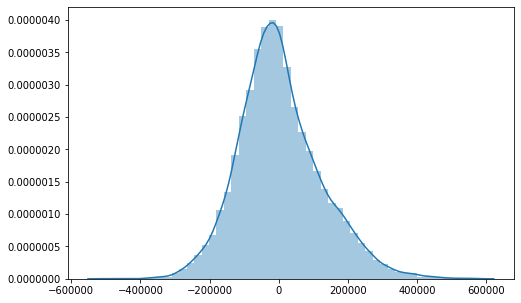

In [74]:
plt.figure(figsize=(8,5))
test_res_norm(zip_floors_bed_bath_month_grade_con_yr_dum, cols=features)
plt.show()

    Distribution looks normal

### Checking residuals for Heter/homesectricity

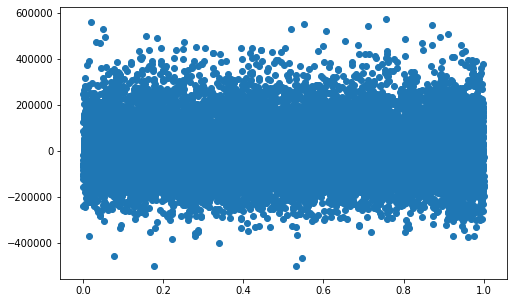

In [75]:
plt.figure(figsize=(8,5))
test_het_resid(zip_floors_bed_bath_month_grade_con_yr_dum, features)
plt.show()

    Distribution of residuals looks good (no cone shape)

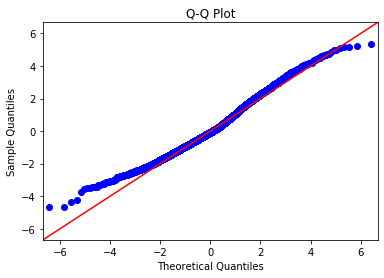

In [80]:
qqplot(zip_floors_bed_bath_month_grade_con_yr_dum,features)


## Train Test Split Test

### Test MSE

In [419]:
x = zip_floors_bed_bath_month_grade_con_yr_dum[features]
y = zip_floors_bed_bath_month_grade_con_yr_dum['price']

In [420]:
test_mse(x, y)

13473 4492 13473 4492


(13833816098.938, 117617.244)

    The average error is about $117,000 in this model

### Train Test Split Graph

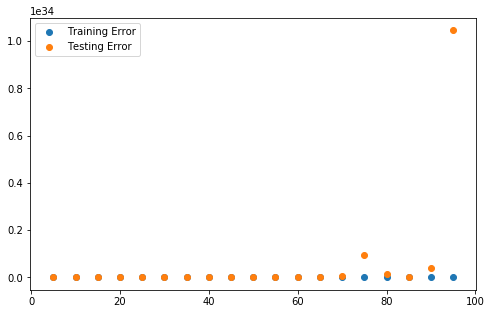

In [483]:
plt.figure(figsize=(8,5))
train_test_graph_splits(x = zip_floors_bed_bath_month_grade_con_yr_dum[features], y = zip_floors_bed_bath_month_grade_con_yr_dum['price'])
plt.show()

    The best split is 90 / 10

### Train Test Split  errors

In [481]:
# other_train_test(x = zip_floors_bed_bath_month_grade_con_dum[features],y = zip_floors_bed_bath_month_grade_con_dum['price'])

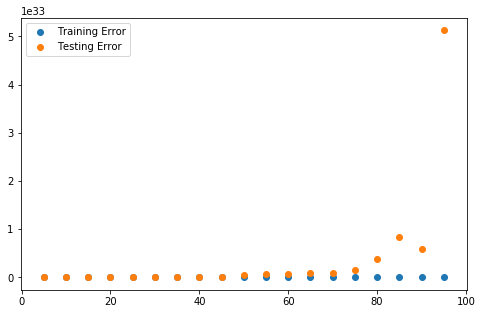

In [484]:
plt.figure(figsize=(8,5))
x = zip_floors_bed_bath_month_grade_con_dum[features]
y = zip_floors_bed_bath_month_grade_con_dum['price']

random.seed(8)

train_err = []
test_err = []
t_sizes = list(range(5,100,5))
for t_size in t_sizes:
    temp_train_err = []
    temp_test_err = []
    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=t_size/100)
        linreg = LinearRegression()
        linreg.fit(X_train, y_train)
        y_hat_train = linreg.predict(X_train)
        y_hat_test = linreg.predict(X_test)
        temp_train_err.append(mean_squared_error(y_train, y_hat_train))
        temp_test_err.append(mean_squared_error(y_test, y_hat_test))
    train_err.append(np.mean(temp_train_err))
    test_err.append(np.mean(temp_test_err))
plt.scatter(t_sizes, train_err, label='Training Error')
plt.scatter(t_sizes, test_err, label='Testing Error')
plt.legend()
plt.show()

## k fold

In [424]:
def kfolds(data, k):
    # Force data as pandas DataFrame
    data = pd.DataFrame(data)
    num_observations = len(data)
    fold_size = num_observations//k
    leftovers = num_observations%k
    folds = []
    start_obs = 0
    for fold_n in range(1,k+1):
        if fold_n <= leftovers:
            #Fold Size will be 1 larger to account for leftovers
            fold =  data.iloc[start_obs : start_obs+fold_size+1] 
            folds.append(fold)
            start_obs +=  fold_size + 1
        else:
            fold =  data.iloc[start_obs : start_obs+fold_size] 
            folds.append(fold)
            start_obs +=  fold_size
            
    return folds 

In [425]:
X = zip_floors_bed_bath_month_grade_con_yr_dum[features]
y = pd.DataFrame(zip_floors_bed_bath_month_grade_con_yr_dum, columns = ['price'])

In [426]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [427]:
df_folds = kfolds(zip_floors_bed_bath_month_grade_con_yr_dum, 5)

In [428]:
def kfolderrs (df_folds, k):
    test_errs = []
    train_errs = []
    

    for n in range(k):
        # Split in train and test for the fold
        train = pd.concat([fold for i, fold in enumerate(df_folds) if i!=n])
        test = df_folds[n]
        # Fit a linear regression model
        linreg.fit(train[X.columns], train[y.columns])
        #Evaluate Train and Test Errors
        y_hat_train = linreg.predict(train[X.columns])
        y_hat_test = linreg.predict(test[X.columns])
        train_residuals = y_hat_train - train[y.columns]
        test_residuals = y_hat_test - test[y.columns]
        train_errs.append(np.mean(train_residuals.astype(float)**2))
        test_errs.append(np.mean(test_residuals.astype(float)**2))
    cv_5_results = cross_val_score(linreg, X, y, cv=5, scoring='neg_mean_squared_error')
    return train_errs, test_errs, cv_5_results
    print('train errors; test errors; cv_resuslts')

In [429]:
kfolderrs(df_folds, 5)

([price    1.375541e+10
  dtype: float64, price    1.388163e+10
  dtype: float64, price    1.382142e+10
  dtype: float64, price    1.384869e+10
  dtype: float64, price    1.321982e+10
  dtype: float64], [price    1.370545e+10
  dtype: float64, price    1.322057e+10
  dtype: float64, price    1.345807e+10
  dtype: float64, price    1.335951e+10
  dtype: float64, price    1.606921e+10
  dtype: float64], array([-1.37054518e+10, -1.32205721e+10, -1.34580702e+10, -1.33595136e+10,
        -1.60692052e+10]))

# For Seller: HOW DOES GRADE AND NUMBER OF BEDROOM AFFECT PRICE

In [87]:
df = zip_floors_bed_bath_month_grade_con_yr_dum

In [88]:
columns = df.columns.drop(bedrooms)
columns = list(columns.drop('price'))
columns

['sqft_living',
 'sqft_lot',
 'sqft_above',
 'sqft_basement',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'zipcode_98002',
 'zipcode_98003',
 'zipcode_98004',
 'zipcode_98005',
 'zipcode_98006',
 'zipcode_98007',
 'zipcode_98008',
 'zipcode_98010',
 'zipcode_98011',
 'zipcode_98014',
 'zipcode_98019',
 'zipcode_98022',
 'zipcode_98023',
 'zipcode_98024',
 'zipcode_98027',
 'zipcode_98028',
 'zipcode_98029',
 'zipcode_98030',
 'zipcode_98031',
 'zipcode_98032',
 'zipcode_98033',
 'zipcode_98034',
 'zipcode_98038',
 'zipcode_98039',
 'zipcode_98040',
 'zipcode_98042',
 'zipcode_98045',
 'zipcode_98052',
 'zipcode_98053',
 'zipcode_98055',
 'zipcode_98056',
 'zipcode_98058',
 'zipcode_98059',
 'zipcode_98065',
 'zipcode_98070',
 'zipcode_98072',
 'zipcode_98074',
 'zipcode_98075',
 'zipcode_98077',
 'zipcode_98092',
 'zipcode_98102',
 'zipcode_98103',
 'zipcode_98105',
 'zipcode_98106',
 'zipcode_98107',
 'zipcode_98108',
 'zipcode_98109',
 'zipcode_98112',
 'zipcode_98115',
 'zipc

## Next model begining (grade)

In [432]:
for bed in bedrooms:
    print(bed, "vs price")
    mk_OLS(df, cols=bed ,target="price")

bedrooms_2 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.090
Model:                            OLS   Adj. R-squared (uncentered):              0.090
Method:                 Least Squares   F-statistic:                              1775.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:29:32   Log-Likelihood:                     -2.5984e+05
No. Observations:               17965   AIC:                                  5.197e+05
Df Residuals:                   17964   BIC:                                  5.197e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bedrooms_2  3.941e+05   9352.574     42.135      0.000    3.76e+05    4.12e+05
==============================================================================
Omnibus:                      286.570   Durbin-Watson:                   0.520
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              300.147
Skew:                          -0.316   Prob(JB):                     6.67e-66
Kurtosis:                       3.037   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

bedrooms_3 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.369
Model:                            OLS   Adj. R-squared (uncentered):              0.369
Method:                 Least Squares   F-statistic:                          1.049e+04
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:29:32   Log-Likelihood:                     -2.5655e+05
No. Observations:               17965   AIC:                                  5.131e+05
Df Residuals:                   17964   BIC:                                  5.131e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bedrooms_3  4.242e+05   4141.453    102.416      0.000    4.16e+05    4.32e+05
==============================================================================
Omnibus:                     3198.699   Durbin-Watson:                   1.162
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              741.404
Skew:                           0.152   Prob(JB):                    1.01e-161
Kurtosis:                       2.052   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

bedrooms_4 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.332
Model:                            OLS   Adj. R-squared (uncentered):              0.332
Method:                 Least Squares   F-statistic:                              8918.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:29:32   Log-Likelihood:                     -2.5706e+05
No. Observations:               17965   AIC:                                  5.141e+05
Df Residuals:                   17964   BIC:                                  5.141e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bedrooms_4  5.061e+05   5359.173     94.437      0.000    4.96e+05    5.17e+05
==============================================================================
Omnibus:                      346.255   Durbin-Watson:                   0.866
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              327.709
Skew:                          -0.293   Prob(JB):                     6.90e-72
Kurtosis:                       2.692   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

bedrooms_5 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.072
Model:                            OLS   Adj. R-squared (uncentered):              0.072
Method:                 Least Squares   F-statistic:                              1402.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                   1.49e-295
Time:                        11:29:32   Log-Likelihood:                     -2.6001e+05
No. Observations:               17965   AIC:                                  5.200e+05
Df Residuals:                   17964   BIC:                                  5.200e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bedrooms_5  5.294e+05   1.41e+04     37.445      0.000    5.02e+05    5.57e+05
==============================================================================
Omnibus:                      367.054   Durbin-Watson:                   0.381
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              568.749
Skew:                          -0.212   Prob(JB):                    3.15e-124
Kurtosis:                       3.762   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

bedrooms_6 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.011
Model:                            OLS   Adj. R-squared (uncentered):              0.011
Method:                 Least Squares   F-statistic:                              208.8
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                    4.62e-47
Time:                        11:29:32   Log-Likelihood:                     -2.6058e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bedrooms_6  5.507e+05   3.81e+04     14.450      0.000    4.76e+05    6.25e+05
==============================================================================
Omnibus:                      340.101   Durbin-Watson:                   0.279
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              359.357
Skew:                           0.346   Prob(JB):                     9.26e-79
Kurtosis:                       2.957   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [433]:
mk_OLS(df, bedrooms)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.874
Model:                            OLS   Adj. R-squared (uncentered):              0.874
Method:                 Least Squares   F-statistic:                          2.497e+04
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:29:32   Log-Likelihood:                     -2.4206e+05
No. Observations:               17965   AIC:                                  4.841e+05
Df Residuals:                   17960   BIC:                                  4.842e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bedrooms_2  3.941e+05   3477.215    113.329      0.000    3.87e+05    4.01e+05
bedrooms_3  4.242e+05   1848.636    229.440      0.000    4.21e+05    4.28e+05
bedrooms_4  5.061e+05   2325.231    217.659      0.000    5.02e+05    5.11e+05
bedrooms_5  5.294e+05   5206.518    101.681      0.000    5.19e+05     5.4e+05
bedrooms_6  5.507e+05   1.36e+04     40.506      0.000    5.24e+05    5.77e+05
==============================================================================
Omnibus:                      967.522   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              907.261
Skew:                           0.495   Prob(JB):                    9.79e-198
Kurtosis:                       2.519   Cond. No.                         7.35
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

    GOOD PVALUE CONDITION SKEW KUR R2 for GRADES

In [89]:
features = ['bedrooms_2', 'bedrooms_3', 'bedrooms_4', 'bedrooms_5', 'bedrooms_6']

In [435]:
for yr in yrs:
#     print(check_vif(zip_floors_bed_bath_month_grade_con_dum, features , col)[0:2])
    if (check_vif(df, bedrooms , yr)[0]) < 3:
        print(col, check_vif(df, features , yr)[0])
# how likely can these features predict this column

yr_built_2015 1.0
yr_built_2015 1.0
yr_built_2015 1.0
yr_built_2015 1.0
yr_built_2015 1.0
yr_built_2015 1.01
yr_built_2015 1.0
yr_built_2015 1.0
yr_built_2015 1.01
yr_built_2015 1.01
yr_built_2015 1.0
yr_built_2015 1.0
yr_built_2015 1.0
yr_built_2015 1.0
yr_built_2015 1.0
yr_built_2015 1.01
yr_built_2015 1.0
yr_built_2015 1.01
yr_built_2015 1.01
yr_built_2015 1.01
yr_built_2015 1.01
yr_built_2015 1.0
yr_built_2015 1.01
yr_built_2015 1.01
yr_built_2015 1.01
yr_built_2015 1.01
yr_built_2015 1.01
yr_built_2015 1.01
yr_built_2015 1.01
yr_built_2015 1.0
yr_built_2015 1.0
yr_built_2015 1.0
yr_built_2015 1.0
yr_built_2015 1.0
yr_built_2015 1.0
yr_built_2015 1.0
yr_built_2015 1.0
yr_built_2015 1.0
yr_built_2015 1.01
yr_built_2015 1.01
yr_built_2015 1.01
yr_built_2015 1.02
yr_built_2015 1.01
yr_built_2015 1.01
yr_built_2015 1.0
yr_built_2015 1.01
yr_built_2015 1.02
yr_built_2015 1.02
yr_built_2015 1.02
yr_built_2015 1.01
yr_built_2015 1.02
yr_built_2015 1.01
yr_built_2015 1.01
yr_built_2015 0.0

    month REJECTED
    bathroom REJECTED
    grade
    condition
    sqft_lot
    
    

In [436]:
exp_feat = ['bedrooms_2', 'bedrooms_3', 'bedrooms_4', 'bedrooms_5', 'bedrooms_6']

In [437]:
for mon in months:
    exp_feat.append(mon)

In [438]:
mk_OLS(df, exp_feat )

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.876
Model:                            OLS   Adj. R-squared (uncentered):              0.875
Method:                 Least Squares   F-statistic:                              7892.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:29:44   Log-Likelihood:                     -2.4196e+05
No. Observations:               17965   AIC:                                  4.840e+05
Df Residuals:                   17949   BIC:                                  4.841e+05
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bedrooms_2  3.286e+05   6435.218     51.055      0.000    3.16e+05    3.41e+05
bedrooms_3  3.585e+05   5727.874     62.590      0.000    3.47e+05     3.7e+05
bedrooms_4  4.405e+05   5884.419     74.863      0.000    4.29e+05    4.52e+05
bedrooms_5  4.628e+05   7534.111     61.428      0.000    4.48e+05    4.78e+05
bedrooms_6  4.878e+05   1.45e+04     33.601      0.000    4.59e+05    5.16e+05
month_2     5.605e+04   7622.453      7.354      0.000    4.11e+04     7.1e+04
month_3     6.921e+04   7047.979      9.820      0.000    5.54e+04     8.3e+04
month_4     8.341e+04   6799.754     12.267      0.000    7.01e+04    9.67e+04
month_5     7.328e+04   6737.731     10.875      0.000    6.01e+04    8.65e+04
month_6     7.716e+04   6839.409     11.282      0.000    6.38e+04    9.06e+04
month_7     7.295e+04   6832.352     10.678      0.000    5.96e+04    8.63e+04
month_8     6.484e+04   6958.139      9.319      0.000    5.12e+04    7.85e+04
month_9     6.863e+04   7064.238      9.715      0.000    5.48e+04    8.25e+04
month_10    6.407e+04   7024.690      9.121      0.000    5.03e+04    7.78e+04
month_11    5.651e+04   7439.343      7.597      0.000    4.19e+04    7.11e+04
month_12    5.433e+04   7374.100      7.368      0.000    3.99e+04    6.88e+04
==============================================================================
Omnibus:                      971.950   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              879.382
Skew:                           0.480   Prob(JB):                    1.11e-191
Kurtosis:                       2.497   Cond. No.                         13.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [439]:
exp_feat = ['bedrooms_2', 'bedrooms_3', 'bedrooms_4', 'bedrooms_5', 'bedrooms_6']

In [440]:
for yr in yrs:
    exp_feat.append(yr)

In [441]:
mk_OLS(df, exp_feat )

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.886
Model:                            OLS   Adj. R-squared (uncentered):              0.885
Method:                 Least Squares   F-statistic:                              1156.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:29:45   Log-Likelihood:                     -2.4117e+05
No. Observations:               17965   AIC:                                  4.826e+05
Df Residuals:                   17845   BIC:                                  4.835e+05
Df Model:                         120                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms_2     1.889e+05    1.2e+04     15.711      0.000    1.65e+05    2.12e+05
bedrooms_3     2.389e+05   1.18e+04     20.306      0.000    2.16e+05    2.62e+05
bedrooms_4     3.163e+05   1.19e+04     26.686      0.000    2.93e+05     3.4e+05
bedrooms_5     3.425e+05   1.27e+04     26.983      0.000    3.18e+05    3.67e+05
bedrooms_6     3.789e+05   1.74e+04     21.763      0.000    3.45e+05    4.13e+05
yr_built_1901  2.562e+05   3.55e+04      7.219      0.000    1.87e+05    3.26e+05
yr_built_1902  2.874e+05   3.62e+04      7.944      0.000    2.16e+05    3.58e+05
yr_built_1903  2.192e+05   2.85e+04      7.700      0.000    1.63e+05    2.75e+05
yr_built_1904  2.651e+05   2.91e+04      9.112      0.000    2.08e+05    3.22e+05
yr_built_1905  2.889e+05   2.74e+04     10.541      0.000    2.35e+05    3.43e+05
yr_built_1906  2.991e+05   2.18e+04     13.693      0.000    2.56e+05    3.42e+05
yr_built_1907  2.942e+05   2.61e+04     11.272      0.000    2.43e+05    3.45e+05
yr_built_1908  2.545e+05   2.28e+04     11.148      0.000     2.1e+05    2.99e+05
yr_built_1909  2.857e+05   2.28e+04     12.510      0.000    2.41e+05     3.3e+05
yr_built_1910  2.772e+05   1.99e+04     13.894      0.000    2.38e+05    3.16e+05
yr_built_1911  2.742e+05   2.49e+04     10.999      0.000    2.25e+05    3.23e+05
yr_built_1912  2.536e+05   2.52e+04     10.058      0.000    2.04e+05    3.03e+05
yr_built_1913  2.282e+05   2.91e+04      7.840      0.000    1.71e+05    2.85e+05
yr_built_1914  2.194e+05   2.96e+04      7.404      0.000    1.61e+05    2.77e+05
yr_built_1915  2.697e+05   2.74e+04      9.855      0.000    2.16e+05    3.23e+05
yr_built_1916  2.748e+05   2.32e+04     11.838      0.000    2.29e+05     3.2e+05
yr_built_1917  2.196e+05   2.66e+04      8.243      0.000    1.67e+05    2.72e+05
yr_built_1918  2.019e+05   1.96e+04     10.286      0.000    1.63e+05     2.4e+05
yr_built_1919  2.415e+05   2.32e+04     10.424      0.000    1.96e+05    2.87e+05
yr_built_1920  2.274e+05    2.1e+04     10.815      0.000    1.86e+05    2.69e+05
yr_built_1921  2.772e+05   2.34e+04     11.847      0.000    2.31e+05    3.23e+05
yr_built_1922  2.675e+05   2.26e+04     11.845      0.000    2.23e+05    3.12e+05
yr_built_1923  2.592e+05   2.31e+04     11.222      0.000    2.14e+05    3.04e+05
yr_built_1924   2.78e+05   1.92e+04     14.456      0.000     2.4e+05    3.16e+05
yr_built_1925   2.53e+05   1.86e+04     13.617      0.000    2.17e+05    2.89e+05
yr_built_1926  2.762e+05   1.79e+04     15.448      0.000    2.41e+05    3.11e+05
yr_built_1927  3.017e+05   2.07e+04     14.551      0.000    2.61e+05    3.42e+05
yr_built_1928  2.647e+05   2.01e+04     13.182      0.000    2.25e+05    3.04e+05
yr_built_1929   2.68e+05      2e

ADD YR_BUILD TO BEDROOMS

or

MONTH GRADE CONDITION

In [442]:
exp_feat = ['bedrooms_2', 'bedrooms_3', 'bedrooms_4', 'bedrooms_5', 'bedrooms_6']

In [443]:
for gr in grade:
    exp_feat.append(gr)

In [444]:
mk_OLS(df, exp_feat )

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.913
Model:                            OLS   Adj. R-squared (uncentered):              0.913
Method:                 Least Squares   F-statistic:                          1.710e+04
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:29:45   Log-Likelihood:                     -2.3876e+05
No. Observations:               17965   AIC:                                  4.775e+05
Df Residuals:                   17954   BIC:                                  4.776e+05
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bedrooms_2   1.59e+05   8977.225     17.708      0.000    1.41e+05    1.77e+05
bedrooms_3  1.395e+05   8918.294     15.646      0.000    1.22e+05    1.57e+05
bedrooms_4  1.751e+05   9059.534     19.327      0.000    1.57e+05    1.93e+05
bedrooms_5    2.1e+05   9835.133     21.349      0.000    1.91e+05    2.29e+05
bedrooms_6  2.568e+05   1.43e+04     17.993      0.000    2.29e+05    2.85e+05
grade_6     1.584e+05   9095.465     17.419      0.000    1.41e+05    1.76e+05
grade_7     2.412e+05   8917.851     27.048      0.000    2.24e+05    2.59e+05
grade_8     3.436e+05   9040.416     38.007      0.000    3.26e+05    3.61e+05
grade_9      4.69e+05   9501.000     49.365      0.000     4.5e+05    4.88e+05
grade_10    5.672e+05   1.11e+04     51.104      0.000    5.45e+05    5.89e+05
grade_11    6.111e+05   2.52e+04     24.281      0.000    5.62e+05     6.6e+05
==============================================================================
Omnibus:                      631.568   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              700.267
Skew:                           0.483   Prob(JB):                    8.69e-153
Kurtosis:                       2.978   Cond. No.                         25.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [445]:
for gr in grade:
    print(check_vif(df,features,gr))

(0.01, 'grade_6', ['bedrooms_2', 'bedrooms_3', 'bedrooms_4', 'bedrooms_5', 'bedrooms_6'])
(0.03, 'grade_7', ['bedrooms_2', 'bedrooms_3', 'bedrooms_4', 'bedrooms_5', 'bedrooms_6'])
(0.07, 'grade_8', ['bedrooms_2', 'bedrooms_3', 'bedrooms_4', 'bedrooms_5', 'bedrooms_6'])
(0.01, 'grade_9', ['bedrooms_2', 'bedrooms_3', 'bedrooms_4', 'bedrooms_5', 'bedrooms_6'])
(0.47, 'grade_10', ['bedrooms_2', 'bedrooms_3', 'bedrooms_4', 'bedrooms_5', 'bedrooms_6'])
(1.0, 'grade_11', ['bedrooms_2', 'bedrooms_3', 'bedrooms_4', 'bedrooms_5', 'bedrooms_6'])


In [446]:
exp_feat = ['bedrooms_2', 'bedrooms_3', 'bedrooms_4', 'bedrooms_5', 'bedrooms_6']

In [447]:
for con in condition:
    exp_feat.append(con)

In [448]:
mk_OLS(df, exp_feat )

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.878
Model:                            OLS   Adj. R-squared (uncentered):              0.878
Method:                 Least Squares   F-statistic:                          1.615e+04
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:29:45   Log-Likelihood:                     -2.4179e+05
No. Observations:               17965   AIC:                                  4.836e+05
Df Residuals:                   17957   BIC:                                  4.837e+05
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
bedrooms_2   1.617e+05   1.09e+04     14.839      0.000     1.4e+05    1.83e+05
bedrooms_3   1.898e+05   1.06e+04     17.901      0.000    1.69e+05    2.11e+05
bedrooms_4   2.713e+05   1.07e+04     25.359      0.000     2.5e+05    2.92e+05
bedrooms_5   2.936e+05   1.17e+04     25.126      0.000    2.71e+05    3.16e+05
bedrooms_6   3.193e+05   1.69e+04     18.891      0.000    2.86e+05    3.52e+05
condition_3  2.359e+05   1.05e+04     22.371      0.000    2.15e+05    2.57e+05
condition_4  2.279e+05   1.07e+04     21.270      0.000    2.07e+05    2.49e+05
condition_5  2.642e+05   1.14e+04     23.193      0.000    2.42e+05    2.87e+05
==============================================================================
Omnibus:                      981.942   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              859.056
Skew:                           0.468   Prob(JB):                    2.87e-187
Kurtosis:                       2.478   Cond. No.                         23.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [449]:
for con in condition:
    print(check_vif(df,features,con))

(0.01, 'condition_3', ['bedrooms_2', 'bedrooms_3', 'bedrooms_4', 'bedrooms_5', 'bedrooms_6'])
(0.01, 'condition_4', ['bedrooms_2', 'bedrooms_3', 'bedrooms_4', 'bedrooms_5', 'bedrooms_6'])
(0.08, 'condition_5', ['bedrooms_2', 'bedrooms_3', 'bedrooms_4', 'bedrooms_5', 'bedrooms_6'])


In [90]:
for con in condition:
    features.append(con)

In [451]:
for col in columns:
#     print(check_vif(zip_floors_bed_bath_month_grade_con_dum, features , col)[0])
    if (check_vif(df, features , col)[0]) < 3:
        print(col, check_vif(df, features , col)[0])
# how likely can these features predict this column

sqft_lot 1.76
sqft_basement 1.6
sqft_lot15 2.04
zipcode_98002 1.01
zipcode_98003 0.05
zipcode_98004 1.01
zipcode_98005 1.01
zipcode_98006 0.18
zipcode_98007 1.01
zipcode_98008 1.02
zipcode_98010 1.0
zipcode_98011 1.01
zipcode_98014 1.0
zipcode_98019 1.01
zipcode_98022 1.01
zipcode_98023 0.48
zipcode_98024 1.0
zipcode_98027 0.24
zipcode_98028 0.06
zipcode_98029 0.15
zipcode_98030 1.02
zipcode_98031 0.04
zipcode_98032 1.01
zipcode_98033 0.16
zipcode_98034 0.51
zipcode_98038 0.04
zipcode_98039 1.0
zipcode_98040 1.01
zipcode_98042 0.51
zipcode_98045 1.0
zipcode_98052 0.0
zipcode_98053 0.21
zipcode_98055 1.01
zipcode_98056 0.35
zipcode_98058 0.4
zipcode_98059 0.39
zipcode_98065 0.05
zipcode_98070 1.01
zipcode_98072 1.02
zipcode_98074 0.33
zipcode_98075 0.08
zipcode_98077 1.01
zipcode_98092 0.13
zipcode_98102 1.01
zipcode_98103 0.04
zipcode_98105 1.01
zipcode_98106 0.17
zipcode_98107 1.02
zipcode_98108 1.01
zipcode_98109 1.01
zipcode_98112 1.01
zipcode_98115 0.5
zipcode_98116 0.05
zipcode_98

/Users/Alisa/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in double_scalars


yr_built_1901 1.0
yr_built_1902 1.0
yr_built_1903 1.0
yr_built_1904 1.0
yr_built_1905 1.01
yr_built_1906 1.01
yr_built_1907 1.0
yr_built_1908 1.01
yr_built_1909 1.01
yr_built_1910 1.01
yr_built_1911 1.01
yr_built_1912 1.0
yr_built_1913 1.0
yr_built_1914 1.0
yr_built_1915 1.0
yr_built_1916 1.01
yr_built_1917 1.01
yr_built_1918 1.01
yr_built_1919 1.01
yr_built_1920 1.01
yr_built_1921 1.01
yr_built_1922 1.01
yr_built_1923 1.01
yr_built_1924 1.01
yr_built_1925 1.01
yr_built_1926 1.01
yr_built_1927 1.01
yr_built_1928 1.01
yr_built_1929 1.01
yr_built_1930 1.0
yr_built_1931 1.0
yr_built_1932 1.0
yr_built_1933 1.0
yr_built_1934 1.0
yr_built_1935 1.0
yr_built_1936 1.0
yr_built_1937 1.0
yr_built_1938 1.01
yr_built_1939 1.01
yr_built_1940 1.01
yr_built_1941 1.01
yr_built_1942 1.03
yr_built_1943 1.02
yr_built_1944 1.01
yr_built_1945 1.01
yr_built_1946 1.01
yr_built_1947 1.02
yr_built_1948 1.02
yr_built_1949 1.02
yr_built_1950 1.01
yr_built_1951 1.02
yr_built_1952 1.01
yr_built_1953 1.01
yr_built_1

In [452]:
mk_OLS(df, features)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.878
Model:                            OLS   Adj. R-squared (uncentered):              0.878
Method:                 Least Squares   F-statistic:                          1.615e+04
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:29:53   Log-Likelihood:                     -2.4179e+05
No. Observations:               17965   AIC:                                  4.836e+05
Df Residuals:                   17957   BIC:                                  4.837e+05
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
bedrooms_2   1.617e+05   1.09e+04     14.839      0.000     1.4e+05    1.83e+05
bedrooms_3   1.898e+05   1.06e+04     17.901      0.000    1.69e+05    2.11e+05
bedrooms_4   2.713e+05   1.07e+04     25.359      0.000     2.5e+05    2.92e+05
bedrooms_5   2.936e+05   1.17e+04     25.126      0.000    2.71e+05    3.16e+05
bedrooms_6   3.193e+05   1.69e+04     18.891      0.000    2.86e+05    3.52e+05
condition_3  2.359e+05   1.05e+04     22.371      0.000    2.15e+05    2.57e+05
condition_4  2.279e+05   1.07e+04     21.270      0.000    2.07e+05    2.49e+05
condition_5  2.642e+05   1.14e+04     23.193      0.000    2.42e+05    2.87e+05
==============================================================================
Omnibus:                      981.942   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              859.056
Skew:                           0.468   Prob(JB):                    2.87e-187
Kurtosis:                       2.478   Cond. No.                         23.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

    Nothing else has good pvalues or no multicolinearity

### OTHER NOT FOR THIS ONE

In [453]:
# best_feat = list(good_vif(df, columns, target='grade' ).keys())

In [454]:
# features = ['grade']
# added_features(features, columns=best_feat)

sqft_basement and grade r2 .907; skew .528; kur 2.617; condition 71.9

sqft_lot has big conditon number and warning


In [455]:
# features.append('sqft_basement')

In [456]:
# mk_OLS(df, features, )

    Good looking MODEL OLS


In [457]:
# check_vif(df, features[0], features[1])

In [458]:
# features[1], features[0]

    SQFT_BASEMENT AND GRADE HAVE NO MULTICOLINEARITY GOOD TO PREDICT PRICE

## Test Residuals

### test for residual normality

In [91]:
features

['bedrooms_2',
 'bedrooms_3',
 'bedrooms_4',
 'bedrooms_5',
 'bedrooms_6',
 'condition_3',
 'condition_4',
 'condition_5']

Residual distribution


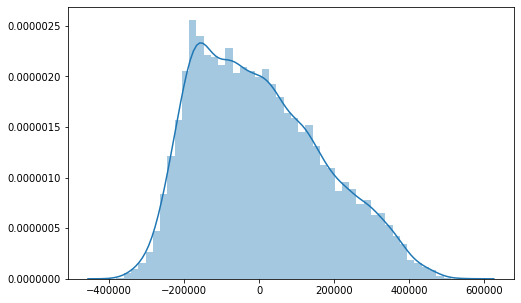

In [92]:
plt.figure(figsize=(8,5))
test_res_norm(df, features)

    LOOKS SEMI NORMAL

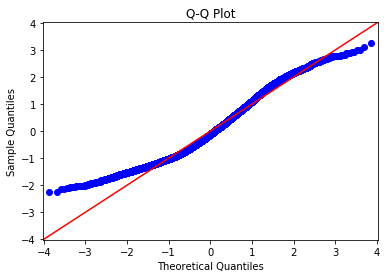

In [93]:
qqplot(df, features)

### Test hetero/homosecentrisdy

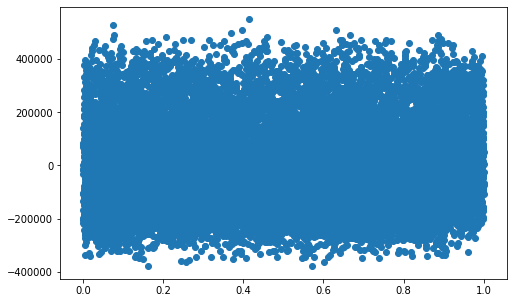

In [489]:
plt.figure(figsize=(8,5))
test_het_resid(df, features)


    DOES NOT LOOK LIKE A CONE: GOOD

## Train Test

### Test MSE

In [462]:
x = df[features]
y = df['price']

In [463]:
test_mse(x, y)

13473 4492 13473 4492


(28013176163.3, 167371.372)

    The average error is $140,124

### Train Test Split Graph

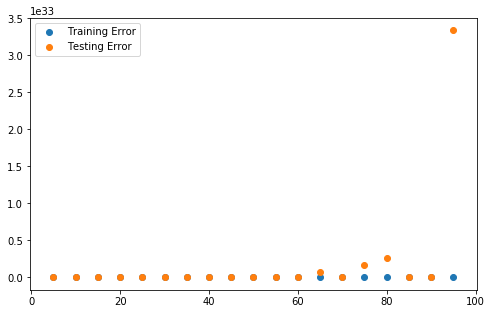

In [490]:
plt.figure(figsize=(8,5))
train_test_graph_splits(x, y)


    Best place to split the data is 80/20

### Train test split errors

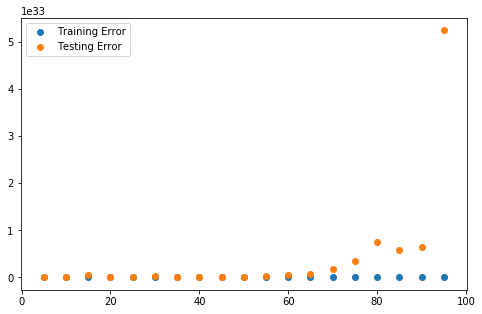

In [491]:
plt.figure(figsize=(8,5))
other_train_test(x, y)


### k fold

In [466]:
X = zip_floors_bed_bath_month_grade_con_dum[features]
y = pd.DataFrame(zip_floors_bed_bath_month_grade_con_dum, columns = ['price'])

In [467]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [468]:
df_folds = kfolds(df, 5)

In [469]:
kfolderrs(df_folds, 5)

([price    2.821182e+10
  dtype: float64, price    2.846160e+10
  dtype: float64, price    2.856108e+10
  dtype: float64, price    2.838149e+10
  dtype: float64, price    2.876828e+10
  dtype: float64], [price    2.959550e+10
  dtype: float64, price    2.859165e+10
  dtype: float64, price    2.819766e+10
  dtype: float64, price    2.891900e+10
  dtype: float64, price    2.746905e+10
  dtype: float64], array([-2.95954985e+10, -2.85916469e+10, -2.81976600e+10, -2.89190004e+10,
        -2.74690468e+10]))

# For Realtor: Does SQFT_ABOVE and SQFT_BASEMENT affect price

## Next model begining (month)

In [118]:
columns = list(df.columns.drop(['sqft_above', 'price']))

In [159]:
for col in columns:
    print(col, "vs price")
    mk_OLS(df, cols=col ,target="price")

sqft_living vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.893
Model:                            OLS   Adj. R-squared (uncentered):              0.893
Method:                 Least Squares   F-statistic:                          1.502e+05
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:40:19   Log-Likelihood:                     -2.4059e+05
No. Observations:               17965   AIC:                                  4.812e+05
Df Residuals:                   17964   BIC:                                  4.812e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
sqft_living   226.5768      0.585    387.609      0.000     225.431     227.723
==============================================================================
Omnibus:                       63.919   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.563
Skew:                           0.146   Prob(JB):                     9.56e-15
Kurtosis:                       2.974   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

sqft_lot vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.398
Model:                            OLS   Adj. R-squared (uncentered):              0.398
Method:                 Least Squares   F-statistic:                          1.190e+04
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:40:19   Log-Likelihood:                     -2.5612e+05
No. Observations:               17965   AIC:                                  5.122e+05
Df Residuals:                   17964   BIC:                                  5.122e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
sqft_lot      20.3171      0.186    109.085      0.000      19.952      20.682
==============================================================================
Omnibus:                     9421.564   Durbin-Watson:                   1.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           129495.754
Skew:                          -2.206   Prob(JB):                         0.00
Kurtosis:                      15.391   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

sqft_basement vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.322
Model:                            OLS   Adj. R-squared (uncentered):              0.322
Method:                 Least Squares   F-statistic:                              8515.
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:40:19   Log-Likelihood:                     -2.5720e+05
No. Observations:               17965   AIC:                                  5.144e+05
Df Residuals:                   17964   BIC:                                  5.144e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
sqft_basement   605.4309      6.561     92.279      0.000     592.571     618.291
==============================================================================
Omnibus:                      338.196   Durbin-Watson:                   0.837
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              358.114
Skew:                          -0.336   Prob(JB):                     1.72e-78
Kurtosis:                       3.165   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

lat vs price


/Users/Alisa/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1657: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       inf
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                nan
Time:                        21:40:19   Log-Likelihood:            -2.4247e+05
No. Observations:               17965   AIC:                         4.849e+05
Df Residuals:                   17964   BIC:                         4.849e+05
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
lat         9613.2414     27.923    344.272      0.000    9558.509    9667.974
==============================================================================
Omnibus:                     1211.314   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1098.428
Skew:                           0.541   Prob(JB):                    3.02e-239
Kurtosis:                       2.454   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

long vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.868
Model:                            OLS   Adj. R-squared (uncentered):              0.868
Method:                 Least Squares   F-statistic:                          1.185e+05
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:40:19   Log-Likelihood:                     -2.4247e+05
No. Observations:               17965   AIC:                                  4.849e+05
Df Residuals:                   17964   BIC:                                  4.850e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
long       -3704.9239     10.765   -344.177      0.000   -3726.023   -3683.824
==============================================================================
Omnibus:                     1211.617   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1097.374
Skew:                           0.540   Prob(JB):                    5.11e-239
Kurtosis:                       2.454   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

sqft_living15 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.896
Model:                            OLS   Adj. R-squared (uncentered):              0.896
Method:                 Least Squares   F-statistic:                          1.545e+05
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:40:19   Log-Likelihood:                     -2.4037e+05
No. Observations:               17965   AIC:                                  4.807e+05
Df Residuals:                   17964   BIC:                                  4.807e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
sqft_living15   233.8537      0.595    393.037      0.000     232.687     235.020
==============================================================================
Omnibus:                      395.130   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              421.215
Skew:                           0.374   Prob(JB):                     3.42e-92
Kurtosis:                       3.057   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

sqft_lot15 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.464
Model:                            OLS   Adj. R-squared (uncentered):              0.464
Method:                 Least Squares   F-statistic:                          1.554e+04
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:40:19   Log-Likelihood:                     -2.5508e+05
No. Observations:               17965   AIC:                                  5.102e+05
Df Residuals:                   17964   BIC:                                  5.102e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
sqft_lot15    25.8319      0.207    124.654      0.000      25.426      26.238
==============================================================================
Omnibus:                     8389.188   Durbin-Watson:                   1.201
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            87987.939
Skew:                          -1.982   Prob(JB):                         0.00
Kurtosis:                      13.091   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98002 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              43.73
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    3.89e-11
Time:                        21:40:19   Log-Likelihood:                     -2.6066e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98002    2.4e+05   3.63e+04      6.612      0.000    1.69e+05    3.11e+05
==============================================================================
Omnibus:                      598.892   Durbin-Watson:                   0.275
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              579.283
Skew:                           0.399   Prob(JB):                    1.62e-126
Kurtosis:                       2.631   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98003 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.005
Model:                            OLS   Adj. R-squared (uncentered):              0.005
Method:                 Least Squares   F-statistic:                              95.66
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.56e-22
Time:                        21:40:19   Log-Likelihood:                     -2.6063e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98003  2.878e+05   2.94e+04      9.780      0.000     2.3e+05    3.46e+05
==============================================================================
Omnibus:                      343.664   Durbin-Watson:                   0.284
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              343.820
Skew:                           0.316   Prob(JB):                     2.19e-75
Kurtosis:                       2.755   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98004 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.013
Model:                            OLS   Adj. R-squared (uncentered):              0.012
Method:                 Least Squares   F-statistic:                              227.9
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    3.58e-51
Time:                        21:40:19   Log-Likelihood:                     -2.6057e+05
No. Observations:               17965   AIC:                                  5.211e+05
Df Residuals:                   17964   BIC:                                  5.211e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98004  7.462e+05   4.94e+04     15.095      0.000    6.49e+05    8.43e+05
==============================================================================
Omnibus:                      747.079   Durbin-Watson:                   0.270
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              746.388
Skew:                           0.462   Prob(JB):                    8.39e-163
Kurtosis:                       2.621   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98005 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.013
Model:                            OLS   Adj. R-squared (uncentered):              0.013
Method:                 Least Squares   F-statistic:                              231.2
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    6.84e-52
Time:                        21:40:19   Log-Likelihood:                     -2.6057e+05
No. Observations:               17965   AIC:                                  5.211e+05
Df Residuals:                   17964   BIC:                                  5.211e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98005  6.831e+05   4.49e+04     15.206      0.000    5.95e+05    7.71e+05
==============================================================================
Omnibus:                      638.882   Durbin-Watson:                   0.273
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              654.779
Skew:                           0.440   Prob(JB):                    6.55e-143
Kurtosis:                       2.681   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98006 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.029
Model:                            OLS   Adj. R-squared (uncentered):              0.029
Method:                 Least Squares   F-statistic:                              541.0
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                   6.30e-118
Time:                        21:40:19   Log-Likelihood:                     -2.6042e+05
No. Observations:               17965   AIC:                                  5.208e+05
Df Residuals:                   17964   BIC:                                  5.208e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98006  6.321e+05   2.72e+04     23.259      0.000    5.79e+05    6.85e+05
==============================================================================
Omnibus:                      203.621   Durbin-Watson:                   0.293
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              210.421
Skew:                           0.261   Prob(JB):                     2.03e-46
Kurtosis:                       3.088   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98007 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.009
Model:                            OLS   Adj. R-squared (uncentered):              0.009
Method:                 Least Squares   F-statistic:                              168.1
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    2.85e-38
Time:                        21:40:19   Log-Likelihood:                     -2.6060e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98007  5.665e+05   4.37e+04     12.966      0.000    4.81e+05    6.52e+05
==============================================================================
Omnibus:                      599.325   Durbin-Watson:                   0.275
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              612.500
Skew:                           0.425   Prob(JB):                    9.94e-134
Kurtosis:                       2.691   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98008 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.018
Model:                            OLS   Adj. R-squared (uncentered):              0.018
Method:                 Least Squares   F-statistic:                              321.6
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    2.65e-71
Time:                        21:40:19   Log-Likelihood:                     -2.6052e+05
No. Observations:               17965   AIC:                                  5.210e+05
Df Residuals:                   17964   BIC:                                  5.211e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98008   5.43e+05   3.03e+04     17.935      0.000    4.84e+05    6.02e+05
==============================================================================
Omnibus:                      349.950   Durbin-Watson:                   0.288
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              362.941
Skew:                           0.337   Prob(JB):                     1.54e-79
Kurtosis:                       2.825   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98010 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              40.64
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.88e-10
Time:                        21:40:19   Log-Likelihood:                     -2.6066e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98010  3.717e+05   5.83e+04      6.375      0.000    2.57e+05    4.86e+05
==============================================================================
Omnibus:                      760.855   Durbin-Watson:                   0.268
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              755.164
Skew:                           0.463   Prob(JB):                    1.04e-164
Kurtosis:                       2.611   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98011 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.010
Model:                            OLS   Adj. R-squared (uncentered):              0.010
Method:                 Least Squares   F-statistic:                              188.9
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    9.32e-43
Time:                        21:40:19   Log-Likelihood:                     -2.6059e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98011   4.86e+05   3.54e+04     13.742      0.000    4.17e+05    5.55e+05
==============================================================================
Omnibus:                      506.699   Durbin-Watson:                   0.281
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              511.195
Skew:                           0.386   Prob(JB):                    9.89e-112
Kurtosis:                       2.705   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98014 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):              0.003
Method:                 Least Squares   F-statistic:                              53.89
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    2.21e-13
Time:                        21:40:19   Log-Likelihood:                     -2.6066e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98014  4.218e+05   5.75e+04      7.341      0.000    3.09e+05    5.34e+05
==============================================================================
Omnibus:                      809.166   Durbin-Watson:                   0.268
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              787.734
Skew:                           0.468   Prob(JB):                    8.83e-172
Kurtosis:                       2.582   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98019 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.006
Model:                            OLS   Adj. R-squared (uncentered):              0.006
Method:                 Least Squares   F-statistic:                              116.8
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    3.81e-27
Time:                        21:40:19   Log-Likelihood:                     -2.6062e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98019  4.156e+05   3.84e+04     10.808      0.000     3.4e+05    4.91e+05
==============================================================================
Omnibus:                      587.337   Durbin-Watson:                   0.279
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              579.545
Skew:                           0.404   Prob(JB):                    1.42e-126
Kurtosis:                       2.654   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98022 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):              0.003
Method:                 Least Squares   F-statistic:                              55.21
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.13e-13
Time:                        21:40:19   Log-Likelihood:                     -2.6065e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98022  2.775e+05   3.74e+04      7.431      0.000    2.04e+05    3.51e+05
==============================================================================
Omnibus:                      589.290   Durbin-Watson:                   0.275
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              573.621
Skew:                           0.399   Prob(JB):                    2.75e-125
Kurtosis:                       2.640   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98023 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.009
Model:                            OLS   Adj. R-squared (uncentered):              0.009
Method:                 Least Squares   F-statistic:                              165.4
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.08e-37
Time:                        21:40:19   Log-Likelihood:                     -2.6060e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98023  2.845e+05   2.21e+04     12.862      0.000    2.41e+05    3.28e+05
==============================================================================
Omnibus:                      118.885   Durbin-Watson:                   0.303
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              119.059
Skew:                           0.189   Prob(JB):                     1.40e-26
Kurtosis:                       2.872   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98024 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              28.08
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.18e-07
Time:                        21:40:20   Log-Likelihood:                     -2.6067e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98024  3.915e+05   7.39e+04      5.299      0.000    2.47e+05    5.36e+05
==============================================================================
Omnibus:                      960.006   Durbin-Watson:                   0.265
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              908.140
Skew:                           0.497   Prob(JB):                    6.31e-198
Kurtosis:                       2.527   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98027 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.024
Model:                            OLS   Adj. R-squared (uncentered):              0.024
Method:                 Least Squares   F-statistic:                              445.9
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    8.75e-98
Time:                        21:40:20   Log-Likelihood:                     -2.6046e+05
No. Observations:               17965   AIC:                                  5.209e+05
Df Residuals:                   17964   BIC:                                  5.209e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98027  5.517e+05   2.61e+04     21.116      0.000    5.01e+05    6.03e+05
==============================================================================
Omnibus:                      173.374   Durbin-Watson:                   0.298
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              178.251
Skew:                           0.241   Prob(JB):                     1.97e-39
Kurtosis:                       3.076   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98028 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.013
Model:                            OLS   Adj. R-squared (uncentered):              0.013
Method:                 Least Squares   F-statistic:                              238.9
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.54e-53
Time:                        21:40:20   Log-Likelihood:                     -2.6056e+05
No. Observations:               17965   AIC:                                  5.211e+05
Df Residuals:                   17964   BIC:                                  5.211e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98028  4.514e+05   2.92e+04     15.455      0.000    3.94e+05    5.09e+05
==============================================================================
Omnibus:                      311.475   Durbin-Watson:                   0.290
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              319.815
Skew:                           0.314   Prob(JB):                     3.57e-70
Kurtosis:                       2.819   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98029 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.023
Model:                            OLS   Adj. R-squared (uncentered):              0.023
Method:                 Least Squares   F-statistic:                              427.1
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    8.72e-94
Time:                        21:40:20   Log-Likelihood:                     -2.6047e+05
No. Observations:               17965   AIC:                                  5.209e+05
Df Residuals:                   17964   BIC:                                  5.210e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98029  5.718e+05   2.77e+04     20.665      0.000    5.18e+05    6.26e+05
==============================================================================
Omnibus:                      267.398   Durbin-Watson:                   0.293
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              278.716
Skew:                           0.303   Prob(JB):                     3.00e-61
Kurtosis:                       2.927   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98030 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.005
Model:                            OLS   Adj. R-squared (uncentered):              0.005
Method:                 Least Squares   F-statistic:                              92.01
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    9.72e-22
Time:                        21:40:20   Log-Likelihood:                     -2.6064e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98030  2.958e+05   3.08e+04      9.592      0.000    2.35e+05    3.56e+05
==============================================================================
Omnibus:                      427.125   Durbin-Watson:                   0.284
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              418.080
Skew:                           0.341   Prob(JB):                     1.64e-91
Kurtosis:                       2.696   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98031 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.006
Model:                            OLS   Adj. R-squared (uncentered):              0.006
Method:                 Least Squares   F-statistic:                              101.7
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    7.32e-24
Time:                        21:40:20   Log-Likelihood:                     -2.6063e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98031   2.99e+05   2.96e+04     10.087      0.000    2.41e+05    3.57e+05
==============================================================================
Omnibus:                      392.374   Durbin-Watson:                   0.285
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              383.544
Skew:                           0.327   Prob(JB):                     5.18e-84
Kurtosis:                       2.707   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98032 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              32.39
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.28e-08
Time:                        21:40:20   Log-Likelihood:                     -2.6067e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98032  2.571e+05   4.52e+04      5.691      0.000    1.69e+05    3.46e+05
==============================================================================
Omnibus:                      761.143   Durbin-Watson:                   0.271
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              725.678
Skew:                           0.445   Prob(JB):                    2.64e-158
Kurtosis:                       2.577   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98033 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.027
Model:                            OLS   Adj. R-squared (uncentered):              0.027
Method:                 Least Squares   F-statistic:                              493.4
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                   7.27e-108
Time:                        21:40:20   Log-Likelihood:                     -2.6044e+05
No. Observations:               17965   AIC:                                  5.209e+05
Df Residuals:                   17964   BIC:                                  5.209e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98033  6.104e+05   2.75e+04     22.213      0.000    5.57e+05    6.64e+05
==============================================================================
Omnibus:                      210.333   Durbin-Watson:                   0.295
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              217.536
Skew:                           0.269   Prob(JB):                     5.79e-48
Kurtosis:                       3.037   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98034 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.025
Model:                            OLS   Adj. R-squared (uncentered):              0.025
Method:                 Least Squares   F-statistic:                              466.2
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                   4.27e-102
Time:                        21:40:20   Log-Likelihood:                     -2.6045e+05
No. Observations:               17965   AIC:                                  5.209e+05
Df Residuals:                   17964   BIC:                                  5.209e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98034  4.604e+05   2.13e+04     21.592      0.000    4.19e+05    5.02e+05
==============================================================================
Omnibus:                       92.419   Durbin-Watson:                   0.315
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.656
Skew:                           0.175   Prob(JB):                     4.60e-21
Kurtosis:                       2.945   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98038 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.015
Model:                            OLS   Adj. R-squared (uncentered):              0.015
Method:                 Least Squares   F-statistic:                              280.9
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.41e-62
Time:                        21:40:20   Log-Likelihood:                     -2.6054e+05
No. Observations:               17965   AIC:                                  5.211e+05
Df Residuals:                   17964   BIC:                                  5.211e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98038  3.493e+05   2.08e+04     16.761      0.000    3.08e+05     3.9e+05
==============================================================================
Omnibus:                       72.470   Durbin-Watson:                   0.314
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.807
Skew:                           0.150   Prob(JB):                     1.55e-16
Kurtosis:                       2.916   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98039 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):              0.000
Method:                 Least Squares   F-statistic:                              9.062
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                     0.00261
Time:                        21:40:20   Log-Likelihood:                     -2.6068e+05
No. Observations:               17965   AIC:                                  5.214e+05
Df Residuals:                   17964   BIC:                                  5.214e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98039  8.425e+05    2.8e+05      3.010      0.003    2.94e+05    1.39e+06
==============================================================================
Omnibus:                     1196.309   Durbin-Watson:                   0.261
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1087.037
Skew:                           0.538   Prob(JB):                    8.97e-237
Kurtosis:                       2.458   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98040 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.013
Model:                            OLS   Adj. R-squared (uncentered):              0.013
Method:                 Least Squares   F-statistic:                              230.7
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    8.59e-52
Time:                        21:40:20   Log-Likelihood:                     -2.6057e+05
No. Observations:               17965   AIC:                                  5.211e+05
Df Residuals:                   17964   BIC:                                  5.211e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98040  7.509e+05   4.94e+04     15.190      0.000    6.54e+05    8.48e+05
==============================================================================
Omnibus:                      734.615   Durbin-Watson:                   0.270
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              734.954
Skew:                           0.459   Prob(JB):                    2.55e-160
Kurtosis:                       2.625   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98042 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.011
Model:                            OLS   Adj. R-squared (uncentered):              0.011
Method:                 Least Squares   F-statistic:                              202.5
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.03e-45
Time:                        21:40:20   Log-Likelihood:                     -2.6058e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98042  3.047e+05   2.14e+04     14.232      0.000    2.63e+05    3.47e+05
==============================================================================
Omnibus:                       96.204   Durbin-Watson:                   0.308
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.358
Skew:                           0.170   Prob(JB):                     1.19e-21
Kurtosis:                       2.888   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98045 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):              0.000
Method:                 Least Squares   F-statistic:                              9.050
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                     0.00263
Time:                        21:40:20   Log-Likelihood:                     -2.6068e+05
No. Observations:               17965   AIC:                                  5.214e+05
Df Residuals:                   17964   BIC:                                  5.214e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98045  4.612e+05   1.53e+05      3.008      0.003    1.61e+05    7.62e+05
==============================================================================
Omnibus:                     1168.225   Durbin-Watson:                   0.262
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1064.267
Skew:                           0.533   Prob(JB):                    7.89e-232
Kurtosis:                       2.464   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98052 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.045
Model:                            OLS   Adj. R-squared (uncentered):              0.045
Method:                 Least Squares   F-statistic:                              845.2
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                   1.27e-181
Time:                        21:40:20   Log-Likelihood:                     -2.6027e+05
No. Observations:               17965   AIC:                                  5.205e+05
Df Residuals:                   17964   BIC:                                  5.205e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98052  6.076e+05   2.09e+04     29.072      0.000    5.67e+05    6.49e+05
==============================================================================
Omnibus:                      104.728   Durbin-Watson:                   0.316
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.155
Skew:                           0.155   Prob(JB):                     2.68e-25
Kurtosis:                       3.234   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98053 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.027
Model:                            OLS   Adj. R-squared (uncentered):              0.027
Method:                 Least Squares   F-statistic:                              494.1
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                   5.24e-108
Time:                        21:40:20   Log-Likelihood:                     -2.6044e+05
No. Observations:               17965   AIC:                                  5.209e+05
Df Residuals:                   17964   BIC:                                  5.209e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98053  5.944e+05   2.67e+04     22.228      0.000    5.42e+05    6.47e+05
==============================================================================
Omnibus:                      179.538   Durbin-Watson:                   0.295
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              185.049
Skew:                           0.243   Prob(JB):                     6.56e-41
Kurtosis:                       3.108   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98055 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.006
Model:                            OLS   Adj. R-squared (uncentered):              0.006
Method:                 Least Squares   F-statistic:                              101.6
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    7.67e-24
Time:                        21:40:20   Log-Likelihood:                     -2.6063e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98055  3.071e+05   3.05e+04     10.082      0.000    2.47e+05    3.67e+05
==============================================================================
Omnibus:                      379.531   Durbin-Watson:                   0.284
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              378.374
Skew:                           0.330   Prob(JB):                     6.87e-83
Kurtosis:                       2.736   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98056 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.015
Model:                            OLS   Adj. R-squared (uncentered):              0.015
Method:                 Least Squares   F-statistic:                              272.7
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    8.21e-61
Time:                        21:40:20   Log-Likelihood:                     -2.6055e+05
No. Observations:               17965   AIC:                                  5.211e+05
Df Residuals:                   17964   BIC:                                  5.211e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98056  4.024e+05   2.44e+04     16.514      0.000    3.55e+05     4.5e+05
==============================================================================
Omnibus:                      114.415   Durbin-Watson:                   0.301
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              116.463
Skew:                           0.197   Prob(JB):                     5.13e-26
Kurtosis:                       3.031   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98058 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.012
Model:                            OLS   Adj. R-squared (uncentered):              0.012
Method:                 Least Squares   F-statistic:                              216.2
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.19e-48
Time:                        21:40:20   Log-Likelihood:                     -2.6057e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98058  3.462e+05   2.35e+04     14.703      0.000       3e+05    3.92e+05
==============================================================================
Omnibus:                      165.182   Durbin-Watson:                   0.301
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              165.250
Skew:                           0.221   Prob(JB):                     1.31e-36
Kurtosis:                       2.841   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98059 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.019
Model:                            OLS   Adj. R-squared (uncentered):              0.018
Method:                 Least Squares   F-statistic:                              339.3
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    4.48e-75
Time:                        21:40:20   Log-Likelihood:                     -2.6051e+05
No. Observations:               17965   AIC:                                  5.210e+05
Df Residuals:                   17964   BIC:                                  5.210e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98059  4.375e+05   2.38e+04     18.420      0.000    3.91e+05    4.84e+05
==============================================================================
Omnibus:                      126.859   Durbin-Watson:                   0.307
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              129.465
Skew:                           0.208   Prob(JB):                     7.71e-29
Kurtosis:                       2.978   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98065 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.017
Model:                            OLS   Adj. R-squared (uncentered):              0.016
Method:                 Least Squares   F-statistic:                              301.8
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    4.77e-67
Time:                        21:40:20   Log-Likelihood:                     -2.6053e+05
No. Observations:               17965   AIC:                                  5.211e+05
Df Residuals:                   17964   BIC:                                  5.211e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98065  5.093e+05   2.93e+04     17.372      0.000    4.52e+05    5.67e+05
==============================================================================
Omnibus:                      303.994   Durbin-Watson:                   0.292
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              316.286
Skew:                           0.318   Prob(JB):                     2.09e-69
Kurtosis:                       2.869   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98070 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):              0.003
Method:                 Least Squares   F-statistic:                              59.51
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.28e-14
Time:                        21:40:20   Log-Likelihood:                     -2.6065e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98070  4.495e+05   5.83e+04      7.714      0.000    3.35e+05    5.64e+05
==============================================================================
Omnibus:                      791.990   Durbin-Watson:                   0.268
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              779.916
Skew:                           0.469   Prob(JB):                    4.40e-170
Kurtosis:                       2.596   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98072 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.015
Model:                            OLS   Adj. R-squared (uncentered):              0.014
Method:                 Least Squares   F-statistic:                              264.8
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    4.06e-59
Time:                        21:40:20   Log-Likelihood:                     -2.6055e+05
No. Observations:               17965   AIC:                                  5.211e+05
Df Residuals:                   17964   BIC:                                  5.211e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98072   5.11e+05   3.14e+04     16.273      0.000    4.49e+05    5.72e+05
==============================================================================
Omnibus:                      348.395   Durbin-Watson:                   0.289
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              360.929
Skew:                           0.336   Prob(JB):                     4.22e-79
Kurtosis:                       2.823   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98074 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.034
Model:                            OLS   Adj. R-squared (uncentered):              0.034
Method:                 Least Squares   F-statistic:                              636.2
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                   5.63e-138
Time:                        21:40:20   Log-Likelihood:                     -2.6037e+05
No. Observations:               17965   AIC:                                  5.207e+05
Df Residuals:                   17964   BIC:                                  5.207e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98074  6.182e+05   2.45e+04     25.223      0.000     5.7e+05    6.66e+05
==============================================================================
Omnibus:                      159.664   Durbin-Watson:                   0.303
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              164.196
Skew:                           0.227   Prob(JB):                     2.21e-36
Kurtosis:                       3.114   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98075 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.032
Model:                            OLS   Adj. R-squared (uncentered):              0.032
Method:                 Least Squares   F-statistic:                              588.2
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                   7.03e-128
Time:                        21:40:20   Log-Likelihood:                     -2.6039e+05
No. Observations:               17965   AIC:                                  5.208e+05
Df Residuals:                   17964   BIC:                                  5.208e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98075  6.928e+05   2.86e+04     24.253      0.000    6.37e+05    7.49e+05
==============================================================================
Omnibus:                      302.726   Durbin-Watson:                   0.288
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              317.246
Skew:                           0.323   Prob(JB):                     1.29e-69
Kurtosis:                       2.920   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98077 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.013
Model:                            OLS   Adj. R-squared (uncentered):              0.013
Method:                 Least Squares   F-statistic:                              243.9
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.27e-54
Time:                        21:40:20   Log-Likelihood:                     -2.6056e+05
No. Observations:               17965   AIC:                                  5.211e+05
Df Residuals:                   17964   BIC:                                  5.211e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98077  6.121e+05   3.92e+04     15.617      0.000    5.35e+05    6.89e+05
==============================================================================
Omnibus:                      393.528   Durbin-Watson:                   0.277
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              417.163
Skew:                           0.369   Prob(JB):                     2.60e-91
Kurtosis:                       2.886   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98092 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.007
Model:                            OLS   Adj. R-squared (uncentered):              0.007
Method:                 Least Squares   F-statistic:                              121.8
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    3.13e-28
Time:                        21:40:20   Log-Likelihood:                     -2.6062e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98092  3.121e+05   2.83e+04     11.037      0.000    2.57e+05    3.68e+05
==============================================================================
Omnibus:                      326.139   Durbin-Watson:                   0.289
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              323.600
Skew:                           0.304   Prob(JB):                     5.39e-71
Kurtosis:                       2.751   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98102 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.006
Model:                            OLS   Adj. R-squared (uncentered):              0.006
Method:                 Least Squares   F-statistic:                              106.3
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    7.35e-25
Time:                        21:40:20   Log-Likelihood:                     -2.6063e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98102  6.136e+05   5.95e+04     10.311      0.000    4.97e+05     7.3e+05
==============================================================================
Omnibus:                      797.596   Durbin-Watson:                   0.267
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              794.349
Skew:                           0.476   Prob(JB):                    3.23e-173
Kurtosis:                       2.604   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98103 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.038
Model:                            OLS   Adj. R-squared (uncentered):              0.038
Method:                 Least Squares   F-statistic:                              702.3
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                   7.89e-152
Time:                        21:40:20   Log-Likelihood:                     -2.6034e+05
No. Observations:               17965   AIC:                                  5.207e+05
Df Residuals:                   17964   BIC:                                  5.207e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98103   5.45e+05   2.06e+04     26.500      0.000    5.05e+05    5.85e+05
==============================================================================
Omnibus:                       80.801   Durbin-Watson:                   0.323
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.896
Skew:                           0.119   Prob(JB):                     1.83e-20
Kurtosis:                       3.255   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98105 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.013
Model:                            OLS   Adj. R-squared (uncentered):              0.013
Method:                 Least Squares   F-statistic:                              230.5
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    9.68e-52
Time:                        21:40:20   Log-Likelihood:                     -2.6057e+05
No. Observations:               17965   AIC:                                  5.211e+05
Df Residuals:                   17964   BIC:                                  5.211e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98105  6.054e+05   3.99e+04     15.182      0.000    5.27e+05    6.84e+05
==============================================================================
Omnibus:                      577.933   Durbin-Watson:                   0.277
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              591.522
Skew:                           0.418   Prob(JB):                    3.57e-129
Kurtosis:                       2.700   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98106 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.008
Model:                            OLS   Adj. R-squared (uncentered):              0.008
Method:                 Least Squares   F-statistic:                              139.3
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    4.91e-32
Time:                        21:40:20   Log-Likelihood:                     -2.6061e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98106  3.249e+05   2.75e+04     11.804      0.000    2.71e+05    3.79e+05
==============================================================================
Omnibus:                      288.617   Durbin-Watson:                   0.289
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              288.309
Skew:                           0.289   Prob(JB):                     2.48e-63
Kurtosis:                       2.776   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98107 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.017
Model:                            OLS   Adj. R-squared (uncentered):              0.017
Method:                 Least Squares   F-statistic:                              316.4
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    3.50e-70
Time:                        21:40:20   Log-Likelihood:                     -2.6053e+05
No. Observations:               17965   AIC:                                  5.211e+05
Df Residuals:                   17964   BIC:                                  5.211e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98107  5.451e+05   3.06e+04     17.788      0.000    4.85e+05    6.05e+05
==============================================================================
Omnibus:                      393.199   Durbin-Watson:                   0.288
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              404.319
Skew:                           0.351   Prob(JB):                     1.60e-88
Kurtosis:                       2.781   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98108 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.005
Model:                            OLS   Adj. R-squared (uncentered):              0.005
Method:                 Least Squares   F-statistic:                              98.71
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    3.36e-23
Time:                        21:40:20   Log-Likelihood:                     -2.6063e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98108  3.571e+05   3.59e+04      9.935      0.000    2.87e+05    4.28e+05
==============================================================================
Omnibus:                      505.433   Durbin-Watson:                   0.280
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              504.250
Skew:                           0.380   Prob(JB):                    3.19e-110
Kurtosis:                       2.691   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98109 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.007
Model:                            OLS   Adj. R-squared (uncentered):              0.007
Method:                 Least Squares   F-statistic:                              128.4
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.13e-29
Time:                        21:40:20   Log-Likelihood:                     -2.6062e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98109  6.499e+05   5.73e+04     11.334      0.000    5.37e+05    7.62e+05
==============================================================================
Omnibus:                      739.577   Durbin-Watson:                   0.268
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              752.235
Skew:                           0.468   Prob(JB):                    4.51e-164
Kurtosis:                       2.642   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98112 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.012
Model:                            OLS   Adj. R-squared (uncentered):              0.012
Method:                 Least Squares   F-statistic:                              214.6
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    2.59e-48
Time:                        21:40:20   Log-Likelihood:                     -2.6058e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98112  6.528e+05   4.46e+04     14.649      0.000    5.65e+05     7.4e+05
==============================================================================
Omnibus:                      570.449   Durbin-Watson:                   0.273
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              596.048
Skew:                           0.426   Prob(JB):                    3.71e-130
Kurtosis:                       2.736   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98115 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.037
Model:                            OLS   Adj. R-squared (uncentered):              0.037
Method:                 Least Squares   F-statistic:                              690.3
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                   2.51e-149
Time:                        21:40:20   Log-Likelihood:                     -2.6034e+05
No. Observations:               17965   AIC:                                  5.207e+05
Df Residuals:                   17964   BIC:                                  5.207e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98115  5.596e+05   2.13e+04     26.274      0.000    5.18e+05    6.01e+05
==============================================================================
Omnibus:                       93.105   Durbin-Watson:                   0.316
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.064
Skew:                           0.163   Prob(JB):                     1.38e-21
Kurtosis:                       3.150   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98116 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.019
Model:                            OLS   Adj. R-squared (uncentered):              0.019
Method:                 Least Squares   F-statistic:                              348.2
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    5.63e-77
Time:                        21:40:20   Log-Likelihood:                     -2.6051e+05
No. Observations:               17965   AIC:                                  5.210e+05
Df Residuals:                   17964   BIC:                                  5.210e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98116  5.474e+05   2.93e+04     18.660      0.000     4.9e+05    6.05e+05
==============================================================================
Omnibus:                      298.294   Durbin-Watson:                   0.290
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              310.889
Skew:                           0.317   Prob(JB):                     3.10e-68
Kurtosis:                       2.883   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98117 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.034
Model:                            OLS   Adj. R-squared (uncentered):              0.034
Method:                 Least Squares   F-statistic:                              638.2
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                   2.12e-138
Time:                        21:40:20   Log-Likelihood:                     -2.6037e+05
No. Observations:               17965   AIC:                                  5.207e+05
Df Residuals:                   17964   BIC:                                  5.207e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98117  5.405e+05   2.14e+04     25.263      0.000    4.99e+05    5.82e+05
==============================================================================
Omnibus:                       96.910   Durbin-Watson:                   0.313
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               98.625
Skew:                           0.176   Prob(JB):                     3.84e-22
Kurtosis:                       3.092   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98118 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.017
Model:                            OLS   Adj. R-squared (uncentered):              0.016
Method:                 Least Squares   F-statistic:                              302.0
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    4.29e-67
Time:                        21:40:20   Log-Likelihood:                     -2.6053e+05
No. Observations:               17965   AIC:                                  5.211e+05
Df Residuals:                   17964   BIC:                                  5.211e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98118  3.892e+05   2.24e+04     17.378      0.000    3.45e+05    4.33e+05
==============================================================================
Omnibus:                       69.863   Durbin-Watson:                   0.306
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.840
Skew:                           0.147   Prob(JB):                     4.14e-16
Kurtosis:                       3.088   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98119 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.012
Model:                            OLS   Adj. R-squared (uncentered):              0.012
Method:                 Least Squares   F-statistic:                              217.8
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    5.41e-49
Time:                        21:40:20   Log-Likelihood:                     -2.6057e+05
No. Observations:               17965   AIC:                                  5.211e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98119  6.439e+05   4.36e+04     14.756      0.000    5.58e+05    7.29e+05
==============================================================================
Omnibus:                      589.956   Durbin-Watson:                   0.273
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              611.000
Skew:                           0.428   Prob(JB):                    2.10e-133
Kurtosis:                       2.713   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98122 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.017
Model:                            OLS   Adj. R-squared (uncentered):              0.017
Method:                 Least Squares   F-statistic:                              302.6
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    3.21e-67
Time:                        21:40:20   Log-Likelihood:                     -2.6053e+05
No. Observations:               17965   AIC:                                  5.211e+05
Df Residuals:                   17964   BIC:                                  5.211e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98122  5.515e+05   3.17e+04     17.395      0.000    4.89e+05    6.14e+05
==============================================================================
Omnibus:                      322.001   Durbin-Watson:                   0.288
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              337.169
Skew:                           0.331   Prob(JB):                     6.09e-74
Kurtosis:                       2.886   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98125 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.017
Model:                            OLS   Adj. R-squared (uncentered):              0.017
Method:                 Least Squares   F-statistic:                              309.7
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    9.81e-69
Time:                        21:40:20   Log-Likelihood:                     -2.6053e+05
No. Observations:               17965   AIC:                                  5.211e+05
Df Residuals:                   17964   BIC:                                  5.211e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98125  4.363e+05   2.48e+04     17.597      0.000    3.88e+05    4.85e+05
==============================================================================
Omnibus:                      177.134   Durbin-Watson:                   0.301
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              181.031
Skew:                           0.240   Prob(JB):                     4.89e-40
Kurtosis:                       2.897   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98126 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.013
Model:                            OLS   Adj. R-squared (uncentered):              0.013
Method:                 Least Squares   F-statistic:                              240.5
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    6.89e-54
Time:                        21:40:20   Log-Likelihood:                     -2.6056e+05
No. Observations:               17965   AIC:                                  5.211e+05
Df Residuals:                   17964   BIC:                                  5.211e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98126  4.112e+05   2.65e+04     15.508      0.000    3.59e+05    4.63e+05
==============================================================================
Omnibus:                      187.244   Durbin-Watson:                   0.298
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              192.298
Skew:                           0.250   Prob(JB):                     1.75e-42
Kurtosis:                       2.916   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98133 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.017
Model:                            OLS   Adj. R-squared (uncentered):              0.017
Method:                 Least Squares   F-statistic:                              304.8
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.08e-67
Time:                        21:40:20   Log-Likelihood:                     -2.6053e+05
No. Observations:               17965   AIC:                                  5.211e+05
Df Residuals:                   17964   BIC:                                  5.211e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98133  3.856e+05   2.21e+04     17.458      0.000    3.42e+05    4.29e+05
==============================================================================
Omnibus:                      119.979   Durbin-Watson:                   0.308
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.500
Skew:                           0.191   Prob(JB):                     6.82e-27
Kurtosis:                       2.878   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98136 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.014
Model:                            OLS   Adj. R-squared (uncentered):              0.014
Method:                 Least Squares   F-statistic:                              250.0
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    6.23e-56
Time:                        21:40:20   Log-Likelihood:                     -2.6056e+05
No. Observations:               17965   AIC:                                  5.211e+05
Df Residuals:                   17964   BIC:                                  5.211e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98136   5.02e+05   3.18e+04     15.811      0.000     4.4e+05    5.64e+05
==============================================================================
Omnibus:                      308.449   Durbin-Watson:                   0.288
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              321.136
Skew:                           0.321   Prob(JB):                     1.85e-70
Kurtosis:                       2.868   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98144 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.015
Model:                            OLS   Adj. R-squared (uncentered):              0.015
Method:                 Least Squares   F-statistic:                              281.1
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.29e-62
Time:                        21:40:20   Log-Likelihood:                     -2.6054e+05
No. Observations:               17965   AIC:                                  5.211e+05
Df Residuals:                   17964   BIC:                                  5.211e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98144  4.737e+05   2.83e+04     16.766      0.000    4.18e+05    5.29e+05
==============================================================================
Omnibus:                      213.060   Durbin-Watson:                   0.294
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              220.254
Skew:                           0.269   Prob(JB):                     1.49e-48
Kurtosis:                       2.939   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98146 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.007
Model:                            OLS   Adj. R-squared (uncentered):              0.007
Method:                 Least Squares   F-statistic:                              118.9
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.31e-27
Time:                        21:40:21   Log-Likelihood:                     -2.6062e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98146  3.424e+05   3.14e+04     10.906      0.000    2.81e+05    4.04e+05
==============================================================================
Omnibus:                      305.637   Durbin-Watson:                   0.284
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              315.404
Skew:                           0.314   Prob(JB):                     3.24e-69
Kurtosis:                       2.837   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98148 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              18.99
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.32e-05
Time:                        21:40:21   Log-Likelihood:                     -2.6067e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.214e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98148    2.9e+05   6.66e+04      4.357      0.000     1.6e+05    4.21e+05
==============================================================================
Omnibus:                      954.529   Durbin-Watson:                   0.266
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              895.775
Skew:                           0.492   Prob(JB):                    3.05e-195
Kurtosis:                       2.523   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98155 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.015
Model:                            OLS   Adj. R-squared (uncentered):              0.015
Method:                 Least Squares   F-statistic:                              275.1
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    2.56e-61
Time:                        21:40:21   Log-Likelihood:                     -2.6055e+05
No. Observations:               17965   AIC:                                  5.211e+05
Df Residuals:                   17964   BIC:                                  5.211e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98155  3.918e+05   2.36e+04     16.585      0.000    3.45e+05    4.38e+05
==============================================================================
Omnibus:                      142.946   Durbin-Watson:                   0.305
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.186
Skew:                           0.214   Prob(JB):                     2.97e-32
Kurtosis:                       2.899   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98166 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.008
Model:                            OLS   Adj. R-squared (uncentered):              0.008
Method:                 Least Squares   F-statistic:                              142.9
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    8.20e-33
Time:                        21:40:21   Log-Likelihood:                     -2.6061e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98166  3.984e+05   3.33e+04     11.954      0.000    3.33e+05    4.64e+05
==============================================================================
Omnibus:                      336.807   Durbin-Watson:                   0.282
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              349.763
Skew:                           0.332   Prob(JB):                     1.12e-76
Kurtosis:                       2.837   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98168 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.004
Model:                            OLS   Adj. R-squared (uncentered):              0.003
Method:                 Least Squares   F-statistic:                              63.92
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.37e-15
Time:                        21:40:21   Log-Likelihood:                     -2.6065e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98168  2.503e+05   3.13e+04      7.995      0.000    1.89e+05    3.12e+05
==============================================================================
Omnibus:                      452.125   Durbin-Watson:                   0.281
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              443.616
Skew:                           0.352   Prob(JB):                     4.68e-97
Kurtosis:                       2.691   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98177 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.013
Model:                            OLS   Adj. R-squared (uncentered):              0.013
Method:                 Least Squares   F-statistic:                              234.1
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.65e-52
Time:                        21:40:21   Log-Likelihood:                     -2.6057e+05
No. Observations:               17965   AIC:                                  5.211e+05
Df Residuals:                   17964   BIC:                                  5.211e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98177  5.212e+05   3.41e+04     15.300      0.000    4.54e+05    5.88e+05
==============================================================================
Omnibus:                      383.578   Durbin-Watson:                   0.283
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              399.351
Skew:                           0.353   Prob(JB):                     1.91e-87
Kurtosis:                       2.816   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98178 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.005
Model:                            OLS   Adj. R-squared (uncentered):              0.005
Method:                 Least Squares   F-statistic:                              96.83
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    8.63e-23
Time:                        21:40:21   Log-Likelihood:                     -2.6063e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98178  3.065e+05   3.11e+04      9.840      0.000    2.45e+05    3.68e+05
==============================================================================
Omnibus:                      347.436   Durbin-Watson:                   0.282
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              351.988
Skew:                           0.324   Prob(JB):                     3.69e-77
Kurtosis:                       2.773   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98188 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              45.45
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.61e-11
Time:                        21:40:21   Log-Likelihood:                     -2.6066e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98188  2.897e+05    4.3e+04      6.742      0.000    2.05e+05    3.74e+05
==============================================================================
Omnibus:                      672.558   Durbin-Watson:                   0.273
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              655.457
Skew:                           0.427   Prob(JB):                    4.67e-143
Kurtosis:                       2.618   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98198 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.005
Model:                            OLS   Adj. R-squared (uncentered):              0.005
Method:                 Least Squares   F-statistic:                              95.82
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.44e-22
Time:                        21:40:21   Log-Likelihood:                     -2.6063e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98198  2.964e+05   3.03e+04      9.789      0.000    2.37e+05    3.56e+05
==============================================================================
Omnibus:                      330.480   Durbin-Watson:                   0.284
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              334.847
Skew:                           0.316   Prob(JB):                     1.94e-73
Kurtosis:                       2.781   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

zipcode_98199 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.019
Model:                            OLS   Adj. R-squared (uncentered):              0.019
Method:                 Least Squares   F-statistic:                              344.3
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    3.87e-76
Time:                        21:40:21   Log-Likelihood:                     -2.6051e+05
No. Observations:               17965   AIC:                                  5.210e+05
Df Residuals:                   17964   BIC:                                  5.210e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
zipcode_98199  6.036e+05   3.25e+04     18.554      0.000     5.4e+05    6.67e+05
==============================================================================
Omnibus:                      338.921   Durbin-Watson:                   0.287
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              355.973
Skew:                           0.340   Prob(JB):                     5.03e-78
Kurtosis:                       2.887   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

floors_2 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.390
Model:                            OLS   Adj. R-squared (uncentered):              0.390
Method:                 Least Squares   F-statistic:                          1.150e+04
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:40:21   Log-Likelihood:                     -2.5624e+05
No. Observations:               17965   AIC:                                  5.125e+05
Df Residuals:                   17964   BIC:                                  5.125e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
floors_2    5.042e+05   4700.841    107.248      0.000    4.95e+05    5.13e+05
==============================================================================
Omnibus:                      508.305   Durbin-Watson:                   0.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              311.682
Skew:                          -0.182   Prob(JB):                     2.08e-68
Kurtosis:                       2.467   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

floors_3 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.030
Model:                            OLS   Adj. R-squared (uncentered):              0.030
Method:                 Least Squares   F-statistic:                              561.3
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                   3.19e-122
Time:                        21:40:21   Log-Likelihood:                     -2.6041e+05
No. Observations:               17965   AIC:                                  5.208e+05
Df Residuals:                   17964   BIC:                                  5.208e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
floors_3    4.864e+05   2.05e+04     23.693      0.000    4.46e+05    5.27e+05
==============================================================================
Omnibus:                       59.037   Durbin-Watson:                   0.320
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.189
Skew:                           0.130   Prob(JB):                     8.51e-14
Kurtosis:                       3.111   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

bedrooms_2 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.090
Model:                            OLS   Adj. R-squared (uncentered):              0.090
Method:                 Least Squares   F-statistic:                              1775.
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:40:21   Log-Likelihood:                     -2.5984e+05
No. Observations:               17965   AIC:                                  5.197e+05
Df Residuals:                   17964   BIC:                                  5.197e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bedrooms_2  3.941e+05   9352.574     42.135      0.000    3.76e+05    4.12e+05
==============================================================================
Omnibus:                      286.570   Durbin-Watson:                   0.520
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              300.147
Skew:                          -0.316   Prob(JB):                     6.67e-66
Kurtosis:                       3.037   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

bedrooms_3 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.369
Model:                            OLS   Adj. R-squared (uncentered):              0.369
Method:                 Least Squares   F-statistic:                          1.049e+04
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:40:21   Log-Likelihood:                     -2.5655e+05
No. Observations:               17965   AIC:                                  5.131e+05
Df Residuals:                   17964   BIC:                                  5.131e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bedrooms_3  4.242e+05   4141.453    102.416      0.000    4.16e+05    4.32e+05
==============================================================================
Omnibus:                     3198.699   Durbin-Watson:                   1.162
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              741.404
Skew:                           0.152   Prob(JB):                    1.01e-161
Kurtosis:                       2.052   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

bedrooms_4 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.332
Model:                            OLS   Adj. R-squared (uncentered):              0.332
Method:                 Least Squares   F-statistic:                              8918.
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:40:21   Log-Likelihood:                     -2.5706e+05
No. Observations:               17965   AIC:                                  5.141e+05
Df Residuals:                   17964   BIC:                                  5.141e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bedrooms_4  5.061e+05   5359.173     94.437      0.000    4.96e+05    5.17e+05
==============================================================================
Omnibus:                      346.255   Durbin-Watson:                   0.866
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              327.709
Skew:                          -0.293   Prob(JB):                     6.90e-72
Kurtosis:                       2.692   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

bedrooms_5 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.072
Model:                            OLS   Adj. R-squared (uncentered):              0.072
Method:                 Least Squares   F-statistic:                              1402.
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                   1.49e-295
Time:                        21:40:21   Log-Likelihood:                     -2.6001e+05
No. Observations:               17965   AIC:                                  5.200e+05
Df Residuals:                   17964   BIC:                                  5.200e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bedrooms_5  5.294e+05   1.41e+04     37.445      0.000    5.02e+05    5.57e+05
==============================================================================
Omnibus:                      367.054   Durbin-Watson:                   0.381
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              568.749
Skew:                          -0.212   Prob(JB):                    3.15e-124
Kurtosis:                       3.762   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

bedrooms_6 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.011
Model:                            OLS   Adj. R-squared (uncentered):              0.011
Method:                 Least Squares   F-statistic:                              208.8
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    4.62e-47
Time:                        21:40:21   Log-Likelihood:                     -2.6058e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bedrooms_6  5.507e+05   3.81e+04     14.450      0.000    4.76e+05    6.25e+05
==============================================================================
Omnibus:                      340.101   Durbin-Watson:                   0.279
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              359.357
Skew:                           0.346   Prob(JB):                     9.26e-79
Kurtosis:                       2.957   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

bathrooms_1 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.273
Model:                            OLS   Adj. R-squared (uncentered):              0.273
Method:                 Least Squares   F-statistic:                              6741.
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:40:21   Log-Likelihood:                     -2.5782e+05
No. Observations:               17965   AIC:                                  5.156e+05
Df Residuals:                   17964   BIC:                                  5.156e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
bathrooms_1  3.905e+05   4756.494     82.104      0.000    3.81e+05       4e+05
==============================================================================
Omnibus:                     5150.949   Durbin-Watson:                   1.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              810.524
Skew:                           0.006   Prob(JB):                    9.93e-177
Kurtosis:                       1.959   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

bathrooms_2 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.505
Model:                            OLS   Adj. R-squared (uncentered):              0.505
Method:                 Least Squares   F-statistic:                          1.834e+04
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:40:21   Log-Likelihood:                     -2.5436e+05
No. Observations:               17965   AIC:                                  5.087e+05
Df Residuals:                   17964   BIC:                                  5.087e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
bathrooms_2  4.845e+05   3577.748    135.428      0.000    4.78e+05    4.92e+05
==============================================================================
Omnibus:                      904.090   Durbin-Watson:                   1.243
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              416.164
Skew:                           0.162   Prob(JB):                     4.28e-91
Kurtosis:                       2.328   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

bathrooms_3 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.099
Model:                            OLS   Adj. R-squared (uncentered):              0.099
Method:                 Least Squares   F-statistic:                              1975.
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:40:21   Log-Likelihood:                     -2.5974e+05
No. Observations:               17965   AIC:                                  5.195e+05
Df Residuals:                   17964   BIC:                                  5.195e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
bathrooms_3  5.832e+05   1.31e+04     44.446      0.000    5.58e+05    6.09e+05
==============================================================================
Omnibus:                      428.133   Durbin-Watson:                   0.399
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              682.735
Skew:                          -0.234   Prob(JB):                    5.57e-149
Kurtosis:                       3.833   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

bathrooms_4 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.005
Model:                            OLS   Adj. R-squared (uncentered):              0.005
Method:                 Least Squares   F-statistic:                              86.96
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.23e-20
Time:                        21:40:21   Log-Likelihood:                     -2.6064e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
bathrooms_4  6.724e+05   7.21e+04      9.325      0.000    5.31e+05    8.14e+05
==============================================================================
Omnibus:                      817.792   Durbin-Watson:                   0.266
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              821.639
Skew:                           0.486   Prob(JB):                    3.83e-179
Kurtosis:                       2.607   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

month_2 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.049
Model:                            OLS   Adj. R-squared (uncentered):              0.049
Method:                 Least Squares   F-statistic:                              935.0
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                   3.16e-200
Time:                        21:40:21   Log-Likelihood:                     -2.6023e+05
No. Observations:               17965   AIC:                                  5.205e+05
Df Residuals:                   17964   BIC:                                  5.205e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
month_2     4.409e+05   1.44e+04     30.578      0.000    4.13e+05    4.69e+05
==============================================================================
Omnibus:                      226.943   Durbin-Watson:                   0.376
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              302.468
Skew:                          -0.179   Prob(JB):                     2.09e-66
Kurtosis:                       3.525   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

month_3 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.076
Model:                            OLS   Adj. R-squared (uncentered):              0.076
Method:                 Least Squares   F-statistic:                              1469.
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                   6.14e-309
Time:                        21:40:21   Log-Likelihood:                     -2.5998e+05
No. Observations:               17965   AIC:                                  5.200e+05
Df Residuals:                   17964   BIC:                                  5.200e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
month_3     4.536e+05   1.18e+04     38.323      0.000     4.3e+05    4.77e+05
==============================================================================
Omnibus:                      428.077   Durbin-Watson:                   0.429
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              536.503
Skew:                          -0.309   Prob(JB):                    3.16e-117
Kurtosis:                       3.578   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

month_4 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.096
Model:                            OLS   Adj. R-squared (uncentered):              0.096
Method:                 Least Squares   F-statistic:                              1911.
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:40:21   Log-Likelihood:                     -2.5977e+05
No. Observations:               17965   AIC:                                  5.195e+05
Df Residuals:                   17964   BIC:                                  5.196e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
month_4     4.675e+05   1.07e+04     43.713      0.000    4.47e+05    4.88e+05
==============================================================================
Omnibus:                      421.787   Durbin-Watson:                   0.465
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              491.932
Skew:                          -0.331   Prob(JB):                    1.51e-107
Kurtosis:                       3.467   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

month_5 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.096
Model:                            OLS   Adj. R-squared (uncentered):              0.096
Method:                 Least Squares   F-statistic:                              1910.
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:40:21   Log-Likelihood:                     -2.5977e+05
No. Observations:               17965   AIC:                                  5.196e+05
Df Residuals:                   17964   BIC:                                  5.196e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
month_5     4.552e+05   1.04e+04     43.708      0.000    4.35e+05    4.76e+05
==============================================================================
Omnibus:                      426.447   Durbin-Watson:                   0.478
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              490.546
Skew:                          -0.339   Prob(JB):                    3.01e-107
Kurtosis:                       3.442   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

month_6 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.091
Model:                            OLS   Adj. R-squared (uncentered):              0.091
Method:                 Least Squares   F-statistic:                              1804.
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:40:21   Log-Likelihood:                     -2.5982e+05
No. Observations:               17965   AIC:                                  5.196e+05
Df Residuals:                   17964   BIC:                                  5.197e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
month_6     4.626e+05   1.09e+04     42.475      0.000    4.41e+05    4.84e+05
==============================================================================
Omnibus:                      493.088   Durbin-Watson:                   0.460
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              597.180
Skew:                          -0.352   Prob(JB):                    2.11e-130
Kurtosis:                       3.549   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

month_7 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.091
Model:                            OLS   Adj. R-squared (uncentered):              0.091
Method:                 Least Squares   F-statistic:                              1802.
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:40:21   Log-Likelihood:                     -2.5982e+05
No. Observations:               17965   AIC:                                  5.196e+05
Df Residuals:                   17964   BIC:                                  5.197e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
month_7     4.589e+05   1.08e+04     42.456      0.000    4.38e+05     4.8e+05
==============================================================================
Omnibus:                      502.106   Durbin-Watson:                   0.463
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              611.150
Skew:                          -0.355   Prob(JB):                    1.95e-133
Kurtosis:                       3.559   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

month_8 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.077
Model:                            OLS   Adj. R-squared (uncentered):              0.077
Method:                 Least Squares   F-statistic:                              1503.
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                   8.03e-316
Time:                        21:40:21   Log-Likelihood:                     -2.5996e+05
No. Observations:               17965   AIC:                                  5.199e+05
Df Residuals:                   17964   BIC:                                  5.199e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
month_8     4.475e+05   1.15e+04     38.768      0.000    4.25e+05     4.7e+05
==============================================================================
Omnibus:                      412.060   Durbin-Watson:                   0.435
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              492.093
Skew:                          -0.318   Prob(JB):                    1.39e-107
Kurtosis:                       3.504   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

month_9 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.073
Model:                            OLS   Adj. R-squared (uncentered):              0.073
Method:                 Least Squares   F-statistic:                              1412.
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                   1.30e-297
Time:                        21:40:21   Log-Likelihood:                     -2.6000e+05
No. Observations:               17965   AIC:                                  5.200e+05
Df Residuals:                   17964   BIC:                                  5.200e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
month_9      4.53e+05   1.21e+04     37.581      0.000    4.29e+05    4.77e+05
==============================================================================
Omnibus:                      367.310   Durbin-Watson:                   0.426
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              455.464
Skew:                          -0.282   Prob(JB):                     1.25e-99
Kurtosis:                       3.539   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

month_10 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.073
Model:                            OLS   Adj. R-squared (uncentered):              0.073
Method:                 Least Squares   F-statistic:                              1416.
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                   2.96e-298
Time:                        21:40:21   Log-Likelihood:                     -2.6000e+05
No. Observations:               17965   AIC:                                  5.200e+05
Df Residuals:                   17964   BIC:                                  5.200e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
month_10    4.471e+05   1.19e+04     37.624      0.000    4.24e+05     4.7e+05
==============================================================================
Omnibus:                      405.118   Durbin-Watson:                   0.432
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              497.495
Skew:                          -0.305   Prob(JB):                    9.34e-109
Kurtosis:                       3.542   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

month_11 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.054
Model:                            OLS   Adj. R-squared (uncentered):              0.054
Method:                 Least Squares   F-statistic:                              1017.
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                   3.22e-217
Time:                        21:40:21   Log-Likelihood:                     -2.6019e+05
No. Observations:               17965   AIC:                                  5.204e+05
Df Residuals:                   17964   BIC:                                  5.204e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
month_11    4.386e+05   1.37e+04     31.897      0.000    4.12e+05    4.66e+05
==============================================================================
Omnibus:                      269.493   Durbin-Watson:                   0.390
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              350.610
Skew:                          -0.213   Prob(JB):                     7.35e-77
Kurtosis:                       3.536   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

month_12 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.056
Model:                            OLS   Adj. R-squared (uncentered):              0.056
Method:                 Least Squares   F-statistic:                              1070.
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                   4.43e-228
Time:                        21:40:21   Log-Likelihood:                     -2.6016e+05
No. Observations:               17965   AIC:                                  5.203e+05
Df Residuals:                   17964   BIC:                                  5.203e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
month_12    4.389e+05   1.34e+04     32.715      0.000    4.13e+05    4.65e+05
==============================================================================
Omnibus:                      280.238   Durbin-Watson:                   0.395
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              359.665
Skew:                          -0.223   Prob(JB):                     7.94e-79
Kurtosis:                       3.530   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

grade_6 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.040
Model:                            OLS   Adj. R-squared (uncentered):              0.040
Method:                 Least Squares   F-statistic:                              752.2
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                   2.85e-162
Time:                        21:40:21   Log-Likelihood:                     -2.6031e+05
No. Observations:               17965   AIC:                                  5.206e+05
Df Residuals:                   17964   BIC:                                  5.206e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
grade_6     3.066e+05   1.12e+04     27.427      0.000    2.85e+05    3.28e+05
==============================================================================
Omnibus:                      178.944   Durbin-Watson:                   0.422
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              184.181
Skew:                          -0.248   Prob(JB):                     1.01e-40
Kurtosis:                       3.005   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

grade_7 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.309
Model:                            OLS   Adj. R-squared (uncentered):              0.309
Method:                 Least Squares   F-statistic:                              8047.
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:40:21   Log-Likelihood:                     -2.5736e+05
No. Observations:               17965   AIC:                                  5.147e+05
Df Residuals:                   17964   BIC:                                  5.147e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
grade_7     3.964e+05   4419.471     89.704      0.000    3.88e+05    4.05e+05
==============================================================================
Omnibus:                     6911.890   Durbin-Watson:                   1.088
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              985.074
Skew:                           0.183   Prob(JB):                    1.24e-214
Kurtosis:                       1.913   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

grade_8 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.322
Model:                            OLS   Adj. R-squared (uncentered):              0.322
Method:                 Least Squares   F-statistic:                              8541.
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:40:21   Log-Likelihood:                     -2.5719e+05
No. Observations:               17965   AIC:                                  5.144e+05
Df Residuals:                   17964   BIC:                                  5.144e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
grade_8     5.038e+05   5450.735     92.419      0.000    4.93e+05    5.14e+05
==============================================================================
Omnibus:                      222.196   Durbin-Watson:                   0.846
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              141.346
Skew:                          -0.063   Prob(JB):                     2.03e-31
Kurtosis:                       2.584   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

grade_9 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.173
Model:                            OLS   Adj. R-squared (uncentered):              0.173
Method:                 Least Squares   F-statistic:                              3749.
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:40:21   Log-Likelihood:                     -2.5898e+05
No. Observations:               17965   AIC:                                  5.180e+05
Df Residuals:                   17964   BIC:                                  5.180e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
grade_9     6.351e+05   1.04e+04     61.229      0.000    6.15e+05    6.55e+05
==============================================================================
Omnibus:                      481.623   Durbin-Watson:                   0.445
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              697.909
Skew:                          -0.289   Prob(JB):                    2.83e-152
Kurtosis:                       3.773   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

grade_10 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.059
Model:                            OLS   Adj. R-squared (uncentered):              0.059
Method:                 Least Squares   F-statistic:                              1135.
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                   2.23e-241
Time:                        21:40:21   Log-Likelihood:                     -2.6013e+05
No. Observations:               17965   AIC:                                  5.203e+05
Df Residuals:                   17964   BIC:                                  5.203e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
grade_10    7.332e+05   2.18e+04     33.693      0.000    6.91e+05    7.76e+05
==============================================================================
Omnibus:                      119.669   Durbin-Watson:                   0.308
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.256
Skew:                           0.178   Prob(JB):                     3.84e-28
Kurtosis:                       3.205   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

grade_11 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.005
Model:                            OLS   Adj. R-squared (uncentered):              0.005
Method:                 Least Squares   F-statistic:                              96.36
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.09e-22
Time:                        21:40:21   Log-Likelihood:                     -2.6063e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
grade_11    7.804e+05   7.95e+04      9.816      0.000    6.25e+05    9.36e+05
==============================================================================
Omnibus:                      975.298   Durbin-Watson:                   0.264
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              931.015
Skew:                           0.506   Prob(JB):                    6.80e-203
Kurtosis:                       2.530   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

condition_3 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.562
Model:                            OLS   Adj. R-squared (uncentered):              0.562
Method:                 Least Squares   F-statistic:                          2.301e+04
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:40:21   Log-Likelihood:                     -2.5328e+05
No. Observations:               17965   AIC:                                  5.066e+05
Df Residuals:                   17964   BIC:                                  5.066e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
condition_3  4.529e+05   2985.481    151.692      0.000    4.47e+05    4.59e+05
==============================================================================
Omnibus:                     1251.290   Durbin-Watson:                   1.448
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              946.251
Skew:                           0.467   Prob(JB):                    3.34e-206
Kurtosis:                       2.375   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

condition_4 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.228
Model:                            OLS   Adj. R-squared (uncentered):              0.228
Method:                 Least Squares   F-statistic:                              5304.
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:40:22   Log-Likelihood:                     -2.5836e+05
No. Observations:               17965   AIC:                                  5.167e+05
Df Residuals:                   17964   BIC:                                  5.167e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
condition_4   4.44e+05   6096.205     72.828      0.000    4.32e+05    4.56e+05
==============================================================================
Omnibus:                      459.056   Durbin-Watson:                   0.761
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              405.483
Skew:                          -0.311   Prob(JB):                     8.92e-89
Kurtosis:                       2.607   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

condition_5 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.077
Model:                            OLS   Adj. R-squared (uncentered):              0.077
Method:                 Least Squares   F-statistic:                              1492.
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                   1.25e-313
Time:                        21:40:22   Log-Likelihood:                     -2.5997e+05
No. Observations:               17965   AIC:                                  5.199e+05
Df Residuals:                   17964   BIC:                                  5.199e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
condition_5   4.83e+05   1.25e+04     38.627      0.000    4.59e+05    5.08e+05
==============================================================================
Omnibus:                      549.536   Durbin-Watson:                   0.410
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              804.240
Skew:                          -0.317   Prob(JB):                    2.30e-175
Kurtosis:                       3.820   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1901 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              27.10
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.96e-07
Time:                        21:40:22   Log-Likelihood:                     -2.6067e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1901  5.148e+05   9.89e+04      5.205      0.000    3.21e+05    7.09e+05
==============================================================================
Omnibus:                     1041.404   Durbin-Watson:                   0.264
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              979.890
Skew:                           0.516   Prob(JB):                    1.66e-213
Kurtosis:                       2.507   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1902 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              30.33
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    3.69e-08
Time:                        21:40:22   Log-Likelihood:                     -2.6067e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1902  5.564e+05   1.01e+05      5.508      0.000    3.58e+05    7.54e+05
==============================================================================
Omnibus:                     1003.452   Durbin-Watson:                   0.263
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              958.423
Skew:                           0.513   Prob(JB):                    7.61e-209
Kurtosis:                       2.524   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1903 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              36.69
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.41e-09
Time:                        21:40:22   Log-Likelihood:                     -2.6066e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1903  4.639e+05   7.66e+04      6.057      0.000    3.14e+05    6.14e+05
==============================================================================
Omnibus:                      882.803   Durbin-Watson:                   0.266
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              865.290
Skew:                           0.493   Prob(JB):                    1.27e-188
Kurtosis:                       2.570   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1904 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              39.71
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    3.02e-10
Time:                        21:40:22   Log-Likelihood:                     -2.6066e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1904  4.951e+05   7.86e+04      6.302      0.000    3.41e+05    6.49e+05
==============================================================================
Omnibus:                      891.809   Durbin-Watson:                   0.265
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              870.756
Skew:                           0.493   Prob(JB):                    8.27e-190
Kurtosis:                       2.564   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1905 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):              0.003
Method:                 Least Squares   F-statistic:                              51.94
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    5.96e-13
Time:                        21:40:22   Log-Likelihood:                     -2.6066e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1905  5.321e+05   7.38e+04      7.207      0.000    3.87e+05    6.77e+05
==============================================================================
Omnibus:                      825.788   Durbin-Watson:                   0.266
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              824.006
Skew:                           0.485   Prob(JB):                    1.17e-179
Kurtosis:                       2.599   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1906 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.005
Model:                            OLS   Adj. R-squared (uncentered):              0.005
Method:                 Least Squares   F-statistic:                              92.14
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    9.10e-22
Time:                        21:40:22   Log-Likelihood:                     -2.6064e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1906  5.325e+05   5.55e+04      9.599      0.000    4.24e+05    6.41e+05
==============================================================================
Omnibus:                      665.299   Durbin-Watson:                   0.269
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              685.141
Skew:                           0.451   Prob(JB):                    1.67e-149
Kurtosis:                       2.679   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1907 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):              0.003
Method:                 Least Squares   F-statistic:                              58.50
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    2.13e-14
Time:                        21:40:22   Log-Likelihood:                     -2.6065e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1907  5.344e+05   6.99e+04      7.649      0.000    3.97e+05    6.71e+05
==============================================================================
Omnibus:                      797.955   Durbin-Watson:                   0.266
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              803.125
Skew:                           0.481   Prob(JB):                    4.01e-175
Kurtosis:                       2.614   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1908 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.004
Model:                            OLS   Adj. R-squared (uncentered):              0.004
Method:                 Least Squares   F-statistic:                              69.90
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    6.71e-17
Time:                        21:40:22   Log-Likelihood:                     -2.6065e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1908  4.906e+05   5.87e+04      8.360      0.000    3.76e+05    6.06e+05
==============================================================================
Omnibus:                      720.153   Durbin-Watson:                   0.268
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              731.666
Skew:                           0.462   Prob(JB):                    1.32e-159
Kurtosis:                       2.646   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1909 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.005
Model:                            OLS   Adj. R-squared (uncentered):              0.005
Method:                 Least Squares   F-statistic:                              83.14
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    8.45e-20
Time:                        21:40:22   Log-Likelihood:                     -2.6064e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1909  5.272e+05   5.78e+04      9.118      0.000    4.14e+05    6.41e+05
==============================================================================
Omnibus:                      775.269   Durbin-Watson:                   0.268
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              773.973
Skew:                           0.470   Prob(JB):                    8.59e-169
Kurtosis:                       2.612   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1910 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.006
Model:                            OLS   Adj. R-squared (uncentered):              0.006
Method:                 Least Squares   F-statistic:                              103.9
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    2.46e-24
Time:                        21:40:22   Log-Likelihood:                     -2.6063e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1910  5.004e+05   4.91e+04     10.194      0.000    4.04e+05    5.97e+05
==============================================================================
Omnibus:                      589.866   Durbin-Watson:                   0.272
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              612.392
Skew:                           0.430   Prob(JB):                    1.05e-133
Kurtosis:                       2.717   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1911 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.004
Model:                            OLS   Adj. R-squared (uncentered):              0.004
Method:                 Least Squares   F-statistic:                              67.16
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    2.67e-16
Time:                        21:40:22   Log-Likelihood:                     -2.6065e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1911  5.397e+05   6.59e+04      8.195      0.000    4.11e+05    6.69e+05
==============================================================================
Omnibus:                      757.507   Durbin-Watson:                   0.267
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              770.799
Skew:                           0.474   Prob(JB):                    4.20e-168
Kurtosis:                       2.637   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1912 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):              0.003
Method:                 Least Squares   F-statistic:                              58.40
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    2.25e-14
Time:                        21:40:22   Log-Likelihood:                     -2.6065e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1912  5.034e+05   6.59e+04      7.642      0.000    3.74e+05    6.33e+05
==============================================================================
Omnibus:                      767.840   Durbin-Watson:                   0.267
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              776.825
Skew:                           0.474   Prob(JB):                    2.06e-169
Kurtosis:                       2.628   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1913 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              40.09
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    2.49e-10
Time:                        21:40:22   Log-Likelihood:                     -2.6066e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1913  4.975e+05   7.86e+04      6.331      0.000    3.43e+05    6.51e+05
==============================================================================
Omnibus:                      834.999   Durbin-Watson:                   0.265
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              834.970
Skew:                           0.488   Prob(JB):                    4.88e-182
Kurtosis:                       2.599   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1914 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              34.00
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    5.60e-09
Time:                        21:40:22   Log-Likelihood:                     -2.6066e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1914  4.708e+05   8.07e+04      5.831      0.000    3.13e+05    6.29e+05
==============================================================================
Omnibus:                      900.356   Durbin-Watson:                   0.265
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              881.154
Skew:                           0.497   Prob(JB):                    4.57e-192
Kurtosis:                       2.564   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1915 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):              0.003
Method:                 Least Squares   F-statistic:                              51.48
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    7.52e-13
Time:                        21:40:22   Log-Likelihood:                     -2.6066e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1915  5.237e+05    7.3e+04      7.175      0.000    3.81e+05    6.67e+05
==============================================================================
Omnibus:                      795.042   Durbin-Watson:                   0.266
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              804.254
Skew:                           0.482   Prob(JB):                    2.28e-175
Kurtosis:                       2.620   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1916 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.004
Model:                            OLS   Adj. R-squared (uncentered):              0.004
Method:                 Least Squares   F-statistic:                              71.92
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    2.41e-17
Time:                        21:40:22   Log-Likelihood:                     -2.6065e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1916   5.09e+05      6e+04      8.481      0.000    3.91e+05    6.27e+05
==============================================================================
Omnibus:                      734.939   Durbin-Watson:                   0.268
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              744.442
Skew:                           0.465   Prob(JB):                    2.22e-162
Kurtosis:                       2.638   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1917 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              44.16
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    3.12e-11
Time:                        21:40:22   Log-Likelihood:                     -2.6066e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1917  4.694e+05   7.06e+04      6.645      0.000    3.31e+05    6.08e+05
==============================================================================
Omnibus:                      826.936   Durbin-Watson:                   0.266
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              817.932
Skew:                           0.481   Prob(JB):                    2.45e-178
Kurtosis:                       2.591   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1918 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.004
Model:                            OLS   Adj. R-squared (uncentered):              0.004
Method:                 Least Squares   F-statistic:                              76.37
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    2.56e-18
Time:                        21:40:22   Log-Likelihood:                     -2.6064e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1918  4.228e+05   4.84e+04      8.739      0.000    3.28e+05    5.18e+05
==============================================================================
Omnibus:                      634.216   Durbin-Watson:                   0.272
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              643.007
Skew:                           0.433   Prob(JB):                    2.36e-140
Kurtosis:                       2.669   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1919 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):              0.003
Method:                 Least Squares   F-statistic:                              62.70
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    2.54e-15
Time:                        21:40:22   Log-Likelihood:                     -2.6065e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1919  4.718e+05   5.96e+04      7.918      0.000    3.55e+05    5.89e+05
==============================================================================
Omnibus:                      712.014   Durbin-Watson:                   0.269
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              723.821
Skew:                           0.459   Prob(JB):                    6.67e-158
Kurtosis:                       2.649   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1920 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.004
Model:                            OLS   Adj. R-squared (uncentered):              0.004
Method:                 Least Squares   F-statistic:                              75.55
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    3.87e-18
Time:                        21:40:22   Log-Likelihood:                     -2.6064e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1920  4.616e+05   5.31e+04      8.692      0.000    3.58e+05    5.66e+05
==============================================================================
Omnibus:                      573.858   Durbin-Watson:                   0.270
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              601.244
Skew:                           0.429   Prob(JB):                    2.76e-131
Kurtosis:                       2.740   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1921 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.004
Model:                            OLS   Adj. R-squared (uncentered):              0.004
Method:                 Least Squares   F-statistic:                              78.39
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    9.22e-19
Time:                        21:40:22   Log-Likelihood:                     -2.6064e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1921  5.313e+05      6e+04      8.854      0.000    4.14e+05    6.49e+05
==============================================================================
Omnibus:                      689.723   Durbin-Watson:                   0.268
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              709.313
Skew:                           0.458   Prob(JB):                    9.43e-155
Kurtosis:                       2.670   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1922 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.004
Model:                            OLS   Adj. R-squared (uncentered):              0.004
Method:                 Least Squares   F-statistic:                              75.12
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    4.79e-18
Time:                        21:40:22   Log-Likelihood:                     -2.6064e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1922  5.013e+05   5.78e+04      8.667      0.000    3.88e+05    6.15e+05
==============================================================================
Omnibus:                      676.748   Durbin-Watson:                   0.268
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              696.730
Skew:                           0.454   Prob(JB):                    5.09e-152
Kurtosis:                       2.675   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1923 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.004
Model:                            OLS   Adj. R-squared (uncentered):              0.004
Method:                 Least Squares   F-statistic:                              66.02
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    4.75e-16
Time:                        21:40:22   Log-Likelihood:                     -2.6065e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1923  4.841e+05   5.96e+04      8.125      0.000    3.67e+05    6.01e+05
==============================================================================
Omnibus:                      724.618   Durbin-Watson:                   0.268
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              732.771
Skew:                           0.461   Prob(JB):                    7.60e-160
Kurtosis:                       2.639   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1924 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.007
Model:                            OLS   Adj. R-squared (uncentered):              0.007
Method:                 Least Squares   F-statistic:                              119.9
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    8.26e-28
Time:                        21:40:22   Log-Likelihood:                     -2.6062e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1924  5.045e+05   4.61e+04     10.949      0.000    4.14e+05    5.95e+05
==============================================================================
Omnibus:                      577.364   Durbin-Watson:                   0.274
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              598.483
Skew:                           0.425   Prob(JB):                    1.10e-130
Kurtosis:                       2.719   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1925 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.008
Model:                            OLS   Adj. R-squared (uncentered):              0.008
Method:                 Least Squares   F-statistic:                              140.5
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    2.73e-32
Time:                        21:40:22   Log-Likelihood:                     -2.6061e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1925   5.04e+05   4.25e+04     11.853      0.000    4.21e+05    5.87e+05
==============================================================================
Omnibus:                      510.092   Durbin-Watson:                   0.275
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              531.266
Skew:                           0.403   Prob(JB):                    4.34e-116
Kurtosis:                       2.755   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1926 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.009
Model:                            OLS   Adj. R-squared (uncentered):              0.009
Method:                 Least Squares   F-statistic:                              171.2
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    6.24e-39
Time:                        21:40:22   Log-Likelihood:                     -2.6060e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1926  5.261e+05   4.02e+04     13.083      0.000    4.47e+05    6.05e+05
==============================================================================
Omnibus:                      439.984   Durbin-Watson:                   0.277
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              464.917
Skew:                           0.385   Prob(JB):                    1.11e-101
Kurtosis:                       2.829   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1927 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.006
Model:                            OLS   Adj. R-squared (uncentered):              0.006
Method:                 Least Squares   F-statistic:                              112.7
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    3.06e-26
Time:                        21:40:22   Log-Likelihood:                     -2.6063e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1927  5.408e+05    5.1e+04     10.614      0.000    4.41e+05    6.41e+05
==============================================================================
Omnibus:                      633.689   Durbin-Watson:                   0.271
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              654.557
Skew:                           0.442   Prob(JB):                    7.33e-143
Kurtosis:                       2.694   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1928 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.006
Model:                            OLS   Adj. R-squared (uncentered):              0.006
Method:                 Least Squares   F-statistic:                              109.9
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.24e-25
Time:                        21:40:22   Log-Likelihood:                     -2.6063e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1928  5.118e+05   4.88e+04     10.482      0.000    4.16e+05    6.08e+05
==============================================================================
Omnibus:                      575.139   Durbin-Watson:                   0.271
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              600.002
Skew:                           0.427   Prob(JB):                    5.14e-131
Kurtosis:                       2.731   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1929 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.007
Model:                            OLS   Adj. R-squared (uncentered):              0.007
Method:                 Least Squares   F-statistic:                              118.9
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.37e-27
Time:                        21:40:22   Log-Likelihood:                     -2.6062e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1929  5.243e+05   4.81e+04     10.903      0.000     4.3e+05    6.19e+05
==============================================================================
Omnibus:                      589.971   Durbin-Watson:                   0.272
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              610.503
Skew:                           0.428   Prob(JB):                    2.70e-133
Kurtosis:                       2.712   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1930 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.004
Model:                            OLS   Adj. R-squared (uncentered):              0.003
Method:                 Least Squares   F-statistic:                              63.72
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.52e-15
Time:                        21:40:22   Log-Likelihood:                     -2.6065e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1930   5.03e+05    6.3e+04      7.982      0.000    3.79e+05    6.27e+05
==============================================================================
Omnibus:                      749.698   Durbin-Watson:                   0.266
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              758.274
Skew:                           0.468   Prob(JB):                    2.20e-165
Kurtosis:                       2.633   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1931 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):              0.003
Method:                 Least Squares   F-statistic:                              58.55
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    2.08e-14
Time:                        21:40:22   Log-Likelihood:                     -2.6065e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1931  5.292e+05   6.92e+04      7.652      0.000    3.94e+05    6.65e+05
==============================================================================
Omnibus:                      724.633   Durbin-Watson:                   0.267
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              746.194
Skew:                           0.469   Prob(JB):                    9.25e-163
Kurtosis:                       2.661   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1932 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              16.81
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    4.14e-05
Time:                        21:40:22   Log-Likelihood:                     -2.6067e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.214e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1932  4.056e+05   9.89e+04      4.100      0.000    2.12e+05       6e+05
==============================================================================
Omnibus:                      998.289   Durbin-Watson:                   0.263
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              948.934
Skew:                           0.510   Prob(JB):                    8.74e-207
Kurtosis:                       2.522   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1933 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):              0.000
Method:                 Least Squares   F-statistic:                              8.102
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                     0.00443
Time:                        21:40:22   Log-Likelihood:                     -2.6068e+05
No. Observations:               17965   AIC:                                  5.214e+05
Df Residuals:                   17964   BIC:                                  5.214e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1933  3.563e+05   1.25e+05      2.846      0.004    1.11e+05    6.02e+05
==============================================================================
Omnibus:                     1072.791   Durbin-Watson:                   0.263
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1002.854
Skew:                           0.521   Prob(JB):                    1.71e-218
Kurtosis:                       2.496   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1934 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):              0.000
Method:                 Least Squares   F-statistic:                              7.608
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                     0.00582
Time:                        21:40:22   Log-Likelihood:                     -2.6068e+05
No. Observations:               17965   AIC:                                  5.214e+05
Df Residuals:                   17964   BIC:                                  5.214e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1934  4.228e+05   1.53e+05      2.758      0.006    1.22e+05    7.23e+05
==============================================================================
Omnibus:                     1128.956   Durbin-Watson:                   0.262
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1042.052
Skew:                           0.529   Prob(JB):                    5.26e-227
Kurtosis:                       2.478   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1935 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):              0.000
Method:                 Least Squares   F-statistic:                              9.205
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                     0.00242
Time:                        21:40:22   Log-Likelihood:                     -2.6068e+05
No. Observations:               17965   AIC:                                  5.214e+05
Df Residuals:                   17964   BIC:                                  5.214e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1935  3.797e+05   1.25e+05      3.034      0.002    1.34e+05    6.25e+05
==============================================================================
Omnibus:                     1081.110   Durbin-Watson:                   0.263
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1009.224
Skew:                           0.523   Prob(JB):                    7.08e-220
Kurtosis:                       2.494   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1936 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              20.96
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    4.72e-06
Time:                        21:40:22   Log-Likelihood:                     -2.6067e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.214e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1936   4.27e+05   9.33e+04      4.578      0.000    2.44e+05     6.1e+05
==============================================================================
Omnibus:                      953.897   Durbin-Watson:                   0.264
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              917.173
Skew:                           0.503   Prob(JB):                    6.89e-200
Kurtosis:                       2.539   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1937 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):              0.003
Method:                 Least Squares   F-statistic:                              48.10
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    4.19e-12
Time:                        21:40:22   Log-Likelihood:                     -2.6066e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1937  4.952e+05   7.14e+04      6.936      0.000    3.55e+05    6.35e+05
==============================================================================
Omnibus:                      845.846   Durbin-Watson:                   0.266
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              834.914
Skew:                           0.485   Prob(JB):                    5.02e-182
Kurtosis:                       2.584   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1938 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              23.96
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    9.93e-07
Time:                        21:40:22   Log-Likelihood:                     -2.6067e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1938  3.953e+05   8.08e+04      4.895      0.000    2.37e+05    5.54e+05
==============================================================================
Omnibus:                      957.173   Durbin-Watson:                   0.265
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              915.682
Skew:                           0.502   Prob(JB):                    1.45e-199
Kurtosis:                       2.535   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1939 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.004
Model:                            OLS   Adj. R-squared (uncentered):              0.004
Method:                 Least Squares   F-statistic:                              70.28
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    5.52e-17
Time:                        21:40:22   Log-Likelihood:                     -2.6065e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1939  4.508e+05   5.38e+04      8.383      0.000    3.45e+05    5.56e+05
==============================================================================
Omnibus:                      664.402   Durbin-Watson:                   0.270
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              678.065
Skew:                           0.446   Prob(JB):                    5.76e-148
Kurtosis:                       2.668   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1940 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.007
Model:                            OLS   Adj. R-squared (uncentered):              0.007
Method:                 Least Squares   F-statistic:                              129.7
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    6.11e-30
Time:                        21:40:22   Log-Likelihood:                     -2.6062e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1940  4.789e+05   4.21e+04     11.388      0.000    3.96e+05    5.61e+05
==============================================================================
Omnibus:                      477.230   Durbin-Watson:                   0.276
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              500.752
Skew:                           0.395   Prob(JB):                    1.83e-109
Kurtosis:                       2.787   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1941 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.006
Model:                            OLS   Adj. R-squared (uncentered):              0.006
Method:                 Least Squares   F-statistic:                              112.9
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    2.67e-26
Time:                        21:40:22   Log-Likelihood:                     -2.6063e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1941  4.454e+05   4.19e+04     10.627      0.000    3.63e+05    5.28e+05
==============================================================================
Omnibus:                      480.317   Durbin-Watson:                   0.276
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              501.628
Skew:                           0.393   Prob(JB):                    1.18e-109
Kurtosis:                       2.774   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1942 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.006
Model:                            OLS   Adj. R-squared (uncentered):              0.006
Method:                 Least Squares   F-statistic:                              108.2
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    2.82e-25
Time:                        21:40:22   Log-Likelihood:                     -2.6063e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1942  3.698e+05   3.55e+04     10.404      0.000       3e+05    4.39e+05
==============================================================================
Omnibus:                      395.904   Durbin-Watson:                   0.280
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              408.728
Skew:                           0.354   Prob(JB):                     1.76e-89
Kurtosis:                       2.788   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1943 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.004
Model:                            OLS   Adj. R-squared (uncentered):              0.004
Method:                 Least Squares   F-statistic:                              67.28
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    2.52e-16
Time:                        21:40:22   Log-Likelihood:                     -2.6065e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1943   3.32e+05   4.05e+04      8.202      0.000    2.53e+05    4.11e+05
==============================================================================
Omnibus:                      539.801   Durbin-Watson:                   0.275
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              545.112
Skew:                           0.398   Prob(JB):                    4.27e-119
Kurtosis:                       2.695   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1944 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.004
Model:                            OLS   Adj. R-squared (uncentered):              0.004
Method:                 Least Squares   F-statistic:                              66.25
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    4.23e-16
Time:                        21:40:22   Log-Likelihood:                     -2.6065e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1944  3.509e+05   4.31e+04      8.140      0.000    2.66e+05    4.35e+05
==============================================================================
Omnibus:                      569.704   Durbin-Watson:                   0.273
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              579.125
Skew:                           0.412   Prob(JB):                    1.76e-126
Kurtosis:                       2.693   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1945 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.004
Model:                            OLS   Adj. R-squared (uncentered):              0.004
Method:                 Least Squares   F-statistic:                              66.12
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    4.52e-16
Time:                        21:40:22   Log-Likelihood:                     -2.6065e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1945  4.428e+05   5.45e+04      8.131      0.000    3.36e+05     5.5e+05
==============================================================================
Omnibus:                      687.226   Durbin-Watson:                   0.269
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              697.050
Skew:                           0.450   Prob(JB):                    4.34e-152
Kurtosis:                       2.654   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1946 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.006
Model:                            OLS   Adj. R-squared (uncentered):              0.006
Method:                 Least Squares   F-statistic:                              101.3
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    9.15e-24
Time:                        21:40:22   Log-Likelihood:                     -2.6063e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1946  4.683e+05   4.65e+04     10.065      0.000    3.77e+05    5.59e+05
==============================================================================
Omnibus:                      568.106   Durbin-Watson:                   0.272
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              589.692
Skew:                           0.422   Prob(JB):                    8.91e-129
Kurtosis:                       2.725   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1947 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.009
Model:                            OLS   Adj. R-squared (uncentered):              0.009
Method:                 Least Squares   F-statistic:                              171.6
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    4.95e-39
Time:                        21:40:22   Log-Likelihood:                     -2.6060e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1947  4.187e+05    3.2e+04     13.100      0.000    3.56e+05    4.81e+05
==============================================================================
Omnibus:                      282.481   Durbin-Watson:                   0.286
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              294.071
Skew:                           0.309   Prob(JB):                     1.39e-64
Kurtosis:                       2.893   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1948 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.008
Model:                            OLS   Adj. R-squared (uncentered):              0.008
Method:                 Least Squares   F-statistic:                              137.6
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.15e-31
Time:                        21:40:23   Log-Likelihood:                     -2.6061e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1948  4.007e+05   3.42e+04     11.731      0.000    3.34e+05    4.68e+05
==============================================================================
Omnibus:                      345.507   Durbin-Watson:                   0.281
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              358.792
Skew:                           0.336   Prob(JB):                     1.23e-78
Kurtosis:                       2.832   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1949 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.006
Model:                            OLS   Adj. R-squared (uncentered):              0.006
Method:                 Least Squares   F-statistic:                              113.6
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.90e-26
Time:                        21:40:23   Log-Likelihood:                     -2.6063e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1949   4.06e+05   3.81e+04     10.659      0.000    3.31e+05    4.81e+05
==============================================================================
Omnibus:                      426.142   Durbin-Watson:                   0.277
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              442.331
Skew:                           0.369   Prob(JB):                     8.89e-97
Kurtosis:                       2.786   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1950 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.008
Model:                            OLS   Adj. R-squared (uncentered):              0.008
Method:                 Least Squares   F-statistic:                              146.7
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.26e-33
Time:                        21:40:23   Log-Likelihood:                     -2.6061e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1950  4.146e+05   3.42e+04     12.110      0.000    3.47e+05    4.82e+05
==============================================================================
Omnibus:                      341.938   Durbin-Watson:                   0.283
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              356.541
Skew:                           0.337   Prob(JB):                     3.78e-78
Kurtosis:                       2.848   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1951 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.009
Model:                            OLS   Adj. R-squared (uncentered):              0.009
Method:                 Least Squares   F-statistic:                              156.7
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    8.42e-36
Time:                        21:40:23   Log-Likelihood:                     -2.6060e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1951  4.384e+05    3.5e+04     12.518      0.000     3.7e+05    5.07e+05
==============================================================================
Omnibus:                      322.508   Durbin-Watson:                   0.281
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              338.163
Skew:                           0.332   Prob(JB):                     3.70e-74
Kurtosis:                       2.895   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1952 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.009
Model:                            OLS   Adj. R-squared (uncentered):              0.009
Method:                 Least Squares   F-statistic:                              156.1
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.14e-35
Time:                        21:40:23   Log-Likelihood:                     -2.6060e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1952  4.471e+05   3.58e+04     12.493      0.000    3.77e+05    5.17e+05
==============================================================================
Omnibus:                      309.012   Durbin-Watson:                   0.283
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              324.393
Skew:                           0.327   Prob(JB):                     3.62e-71
Kurtosis:                       2.929   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1953 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.007
Model:                            OLS   Adj. R-squared (uncentered):              0.007
Method:                 Least Squares   F-statistic:                              135.0
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    4.33e-31
Time:                        21:40:23   Log-Likelihood:                     -2.6061e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1953  4.104e+05   3.53e+04     11.618      0.000    3.41e+05     4.8e+05
==============================================================================
Omnibus:                      329.781   Durbin-Watson:                   0.281
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              344.378
Skew:                           0.332   Prob(JB):                     1.66e-75
Kurtosis:                       2.864   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1954 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.010
Model:                            OLS   Adj. R-squared (uncentered):              0.010
Method:                 Least Squares   F-statistic:                              175.1
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    8.79e-40
Time:                        21:40:23   Log-Likelihood:                     -2.6059e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1954  3.937e+05   2.98e+04     13.232      0.000    3.35e+05    4.52e+05
==============================================================================
Omnibus:                      221.838   Durbin-Watson:                   0.288
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              229.743
Skew:                           0.276   Prob(JB):                     1.29e-50
Kurtosis:                       2.945   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1955 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.009
Model:                            OLS   Adj. R-squared (uncentered):              0.009
Method:                 Least Squares   F-statistic:                              166.4
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    6.61e-38
Time:                        21:40:23   Log-Likelihood:                     -2.6060e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1955   4.07e+05   3.16e+04     12.900      0.000    3.45e+05    4.69e+05
==============================================================================
Omnibus:                      290.542   Durbin-Watson:                   0.285
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              301.432
Skew:                           0.310   Prob(JB):                     3.51e-66
Kurtosis:                       2.867   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1956 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.007
Model:                            OLS   Adj. R-squared (uncentered):              0.007
Method:                 Least Squares   F-statistic:                              135.6
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    3.13e-31
Time:                        21:40:23   Log-Likelihood:                     -2.6061e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1956  4.228e+05   3.63e+04     11.646      0.000    3.52e+05    4.94e+05
==============================================================================
Omnibus:                      391.704   Durbin-Watson:                   0.280
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              408.228
Skew:                           0.357   Prob(JB):                     2.26e-89
Kurtosis:                       2.815   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1957 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.007
Model:                            OLS   Adj. R-squared (uncentered):              0.007
Method:                 Least Squares   F-statistic:                              127.7
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.62e-29
Time:                        21:40:23   Log-Likelihood:                     -2.6062e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1957  4.128e+05   3.65e+04     11.302      0.000    3.41e+05    4.84e+05
==============================================================================
Omnibus:                      364.027   Durbin-Watson:                   0.279
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              381.434
Skew:                           0.349   Prob(JB):                     1.49e-83
Kurtosis:                       2.851   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1958 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.008
Model:                            OLS   Adj. R-squared (uncentered):              0.008
Method:                 Least Squares   F-statistic:                              144.3
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    4.19e-33
Time:                        21:40:23   Log-Likelihood:                     -2.6061e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1958  4.101e+05   3.41e+04     12.011      0.000    3.43e+05    4.77e+05
==============================================================================
Omnibus:                      305.780   Durbin-Watson:                   0.282
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              319.766
Skew:                           0.323   Prob(JB):                     3.66e-70
Kurtosis:                       2.897   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1959 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.011
Model:                            OLS   Adj. R-squared (uncentered):              0.011
Method:                 Least Squares   F-statistic:                              195.4
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    3.67e-44
Time:                        21:40:23   Log-Likelihood:                     -2.6058e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1959  3.965e+05   2.84e+04     13.977      0.000    3.41e+05    4.52e+05
==============================================================================
Omnibus:                      177.985   Durbin-Watson:                   0.291
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              183.162
Skew:                           0.247   Prob(JB):                     1.69e-40
Kurtosis:                       3.006   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1960 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.009
Model:                            OLS   Adj. R-squared (uncentered):              0.009
Method:                 Least Squares   F-statistic:                              156.7
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    8.53e-36
Time:                        21:40:23   Log-Likelihood:                     -2.6060e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1960  4.131e+05    3.3e+04     12.517      0.000    3.48e+05    4.78e+05
==============================================================================
Omnibus:                      266.075   Durbin-Watson:                   0.283
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              277.553
Skew:                           0.303   Prob(JB):                     5.37e-61
Kurtosis:                       2.942   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1961 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.008
Model:                            OLS   Adj. R-squared (uncentered):              0.008
Method:                 Least Squares   F-statistic:                              144.5
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    3.64e-33
Time:                        21:40:23   Log-Likelihood:                     -2.6061e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1961  4.065e+05   3.38e+04     12.022      0.000     3.4e+05    4.73e+05
==============================================================================
Omnibus:                      310.990   Durbin-Watson:                   0.282
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              325.002
Skew:                           0.325   Prob(JB):                     2.67e-71
Kurtosis:                       2.886   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1962 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.009
Model:                            OLS   Adj. R-squared (uncentered):              0.009
Method:                 Least Squares   F-statistic:                              160.4
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.35e-36
Time:                        21:40:23   Log-Likelihood:                     -2.6060e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1962  3.727e+05   2.94e+04     12.664      0.000    3.15e+05     4.3e+05
==============================================================================
Omnibus:                      230.799   Durbin-Watson:                   0.288
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              238.862
Skew:                           0.279   Prob(JB):                     1.35e-52
Kurtosis:                       2.917   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1963 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.008
Model:                            OLS   Adj. R-squared (uncentered):              0.008
Method:                 Least Squares   F-statistic:                              152.1
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    8.54e-35
Time:                        21:40:23   Log-Likelihood:                     -2.6061e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1963   4.06e+05   3.29e+04     12.331      0.000    3.41e+05    4.71e+05
==============================================================================
Omnibus:                      295.978   Durbin-Watson:                   0.282
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              308.310
Skew:                           0.315   Prob(JB):                     1.13e-67
Kurtosis:                       2.883   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1964 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.006
Model:                            OLS   Adj. R-squared (uncentered):              0.006
Method:                 Least Squares   F-statistic:                              114.8
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.02e-26
Time:                        21:40:23   Log-Likelihood:                     -2.6062e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1964  4.362e+05   4.07e+04     10.717      0.000    3.56e+05    5.16e+05
==============================================================================
Omnibus:                      459.705   Durbin-Watson:                   0.276
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              478.414
Skew:                           0.384   Prob(JB):                    1.30e-104
Kurtosis:                       2.776   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1965 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.006
Model:                            OLS   Adj. R-squared (uncentered):              0.006
Method:                 Least Squares   F-statistic:                              117.4
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    2.81e-27
Time:                        21:40:23   Log-Likelihood:                     -2.6062e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1965  4.127e+05   3.81e+04     10.836      0.000    3.38e+05    4.87e+05
==============================================================================
Omnibus:                      453.400   Durbin-Watson:                   0.278
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              468.232
Skew:                           0.377   Prob(JB):                    2.11e-102
Kurtosis:                       2.763   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1966 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.009
Model:                            OLS   Adj. R-squared (uncentered):              0.009
Method:                 Least Squares   F-statistic:                              156.2
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.09e-35
Time:                        21:40:23   Log-Likelihood:                     -2.6060e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1966   4.04e+05   3.23e+04     12.497      0.000    3.41e+05    4.67e+05
==============================================================================
Omnibus:                      278.539   Durbin-Watson:                   0.284
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              290.317
Skew:                           0.308   Prob(JB):                     9.09e-64
Kurtosis:                       2.907   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1967 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.011
Model:                            OLS   Adj. R-squared (uncentered):              0.011
Method:                 Least Squares   F-statistic:                              204.3
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    4.38e-46
Time:                        21:40:23   Log-Likelihood:                     -2.6058e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1967  3.926e+05   2.75e+04     14.292      0.000    3.39e+05    4.46e+05
==============================================================================
Omnibus:                      168.143   Durbin-Watson:                   0.293
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              172.768
Skew:                           0.240   Prob(JB):                     3.05e-38
Kurtosis:                       2.996   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1968 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.012
Model:                            OLS   Adj. R-squared (uncentered):              0.012
Method:                 Least Squares   F-statistic:                              213.4
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    4.68e-48
Time:                        21:40:23   Log-Likelihood:                     -2.6058e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1968  3.888e+05   2.66e+04     14.608      0.000    3.37e+05    4.41e+05
==============================================================================
Omnibus:                      152.159   Durbin-Watson:                   0.295
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              155.913
Skew:                           0.228   Prob(JB):                     1.39e-34
Kurtosis:                       3.007   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1969 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.007
Model:                            OLS   Adj. R-squared (uncentered):              0.007
Method:                 Least Squares   F-statistic:                              127.6
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.77e-29
Time:                        21:40:23   Log-Likelihood:                     -2.6062e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1969   3.56e+05   3.15e+04     11.294      0.000    2.94e+05    4.18e+05
==============================================================================
Omnibus:                      303.799   Durbin-Watson:                   0.284
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              314.075
Skew:                           0.314   Prob(JB):                     6.30e-69
Kurtosis:                       2.844   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1970 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.004
Model:                            OLS   Adj. R-squared (uncentered):              0.004
Method:                 Least Squares   F-statistic:                              65.57
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    5.96e-16
Time:                        21:40:23   Log-Likelihood:                     -2.6065e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1970  3.771e+05   4.66e+04      8.098      0.000    2.86e+05    4.68e+05
==============================================================================
Omnibus:                      588.845   Durbin-Watson:                   0.272
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              601.078
Skew:                           0.421   Prob(JB):                    3.00e-131
Kurtosis:                       2.693   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1971 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):              0.003
Method:                 Least Squares   F-statistic:                              55.57
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    9.42e-14
Time:                        21:40:23   Log-Likelihood:                     -2.6065e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1971  3.914e+05   5.25e+04      7.455      0.000    2.89e+05    4.94e+05
==============================================================================
Omnibus:                      703.842   Durbin-Watson:                   0.270
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              702.772
Skew:                           0.448   Prob(JB):                    2.48e-153
Kurtosis:                       2.632   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1972 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.006
Model:                            OLS   Adj. R-squared (uncentered):              0.006
Method:                 Least Squares   F-statistic:                              103.5
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    3.08e-24
Time:                        21:40:23   Log-Likelihood:                     -2.6063e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1972  4.434e+05   4.36e+04     10.172      0.000    3.58e+05    5.29e+05
==============================================================================
Omnibus:                      526.463   Durbin-Watson:                   0.274
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              544.416
Skew:                           0.405   Prob(JB):                    6.05e-119
Kurtosis:                       2.735   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1973 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.006
Model:                            OLS   Adj. R-squared (uncentered):              0.006
Method:                 Least Squares   F-statistic:                              115.4
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    7.61e-27
Time:                        21:40:23   Log-Likelihood:                     -2.6062e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1973  4.682e+05   4.36e+04     10.744      0.000    3.83e+05    5.54e+05
==============================================================================
Omnibus:                      492.657   Durbin-Watson:                   0.274
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              515.697
Skew:                           0.399   Prob(JB):                    1.04e-112
Kurtosis:                       2.773   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1974 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.007
Model:                            OLS   Adj. R-squared (uncentered):              0.007
Method:                 Least Squares   F-statistic:                              127.9
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.50e-29
Time:                        21:40:23   Log-Likelihood:                     -2.6062e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1974  4.537e+05   4.01e+04     11.309      0.000    3.75e+05    5.32e+05
==============================================================================
Omnibus:                      459.904   Durbin-Watson:                   0.277
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              478.990
Skew:                           0.384   Prob(JB):                    9.74e-105
Kurtosis:                       2.777   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1975 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.008
Model:                            OLS   Adj. R-squared (uncentered):              0.008
Method:                 Least Squares   F-statistic:                              145.6
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    2.15e-33
Time:                        21:40:23   Log-Likelihood:                     -2.6061e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1975  4.482e+05   3.71e+04     12.066      0.000    3.75e+05    5.21e+05
==============================================================================
Omnibus:                      382.509   Durbin-Watson:                   0.280
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              401.011
Skew:                           0.357   Prob(JB):                     8.35e-88
Kurtosis:                       2.840   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1976 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.011
Model:                            OLS   Adj. R-squared (uncentered):              0.011
Method:                 Least Squares   F-statistic:                              191.8
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    2.15e-43
Time:                        21:40:23   Log-Likelihood:                     -2.6059e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1976  4.514e+05   3.26e+04     13.849      0.000    3.87e+05    5.15e+05
==============================================================================
Omnibus:                      292.933   Durbin-Watson:                   0.285
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              306.218
Skew:                           0.317   Prob(JB):                     3.20e-67
Kurtosis:                       2.912   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1977 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.018
Model:                            OLS   Adj. R-squared (uncentered):              0.018
Method:                 Least Squares   F-statistic:                              331.2
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    2.35e-73
Time:                        21:40:23   Log-Likelihood:                     -2.6052e+05
No. Observations:               17965   AIC:                                  5.210e+05
Df Residuals:                   17964   BIC:                                  5.210e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1977   4.51e+05   2.48e+04     18.200      0.000    4.02e+05       5e+05
==============================================================================
Omnibus:                      112.718   Durbin-Watson:                   0.301
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              116.133
Skew:                           0.183   Prob(JB):                     6.05e-26
Kurtosis:                       3.146   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1978 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.015
Model:                            OLS   Adj. R-squared (uncentered):              0.015
Method:                 Least Squares   F-statistic:                              266.3
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.90e-59
Time:                        21:40:23   Log-Likelihood:                     -2.6055e+05
No. Observations:               17965   AIC:                                  5.211e+05
Df Residuals:                   17964   BIC:                                  5.211e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1978  4.292e+05   2.63e+04     16.320      0.000    3.78e+05    4.81e+05
==============================================================================
Omnibus:                      146.847   Durbin-Watson:                   0.296
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              150.286
Skew:                           0.222   Prob(JB):                     2.32e-33
Kurtosis:                       3.060   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1979 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.014
Model:                            OLS   Adj. R-squared (uncentered):              0.014
Method:                 Least Squares   F-statistic:                              249.6
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    7.50e-56
Time:                        21:40:23   Log-Likelihood:                     -2.6056e+05
No. Observations:               17965   AIC:                                  5.211e+05
Df Residuals:                   17964   BIC:                                  5.211e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1979   4.46e+05   2.82e+04     15.799      0.000    3.91e+05    5.01e+05
==============================================================================
Omnibus:                      169.361   Durbin-Watson:                   0.292
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              173.963
Skew:                           0.239   Prob(JB):                     1.68e-38
Kurtosis:                       3.058   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1980 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.008
Model:                            OLS   Adj. R-squared (uncentered):              0.008
Method:                 Least Squares   F-statistic:                              137.1
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.47e-31
Time:                        21:40:23   Log-Likelihood:                     -2.6061e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1980  4.114e+05   3.51e+04     11.710      0.000    3.43e+05     4.8e+05
==============================================================================
Omnibus:                      332.496   Durbin-Watson:                   0.281
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              348.161
Skew:                           0.335   Prob(JB):                     2.50e-76
Kurtosis:                       2.875   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1981 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.007
Model:                            OLS   Adj. R-squared (uncentered):              0.007
Method:                 Least Squares   F-statistic:                              124.2
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    9.67e-29
Time:                        21:40:23   Log-Likelihood:                     -2.6062e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1981  4.179e+05   3.75e+04     11.143      0.000    3.44e+05    4.91e+05
==============================================================================
Omnibus:                      410.518   Durbin-Watson:                   0.278
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              427.938
Skew:                           0.365   Prob(JB):                     1.19e-93
Kurtosis:                       2.805   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1982 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.004
Model:                            OLS   Adj. R-squared (uncentered):              0.004
Method:                 Least Squares   F-statistic:                              71.66
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    2.75e-17
Time:                        21:40:23   Log-Likelihood:                     -2.6065e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1982  4.443e+05   5.25e+04      8.465      0.000    3.41e+05    5.47e+05
==============================================================================
Omnibus:                      707.510   Durbin-Watson:                   0.271
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              708.944
Skew:                           0.451   Prob(JB):                    1.13e-154
Kurtosis:                       2.635   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1983 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.008
Model:                            OLS   Adj. R-squared (uncentered):              0.008
Method:                 Least Squares   F-statistic:                              147.3
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    8.97e-34
Time:                        21:40:23   Log-Likelihood:                     -2.6061e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1983  4.345e+05   3.58e+04     12.138      0.000    3.64e+05    5.05e+05
==============================================================================
Omnibus:                      358.635   Durbin-Watson:                   0.281
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              375.382
Skew:                           0.346   Prob(JB):                     3.07e-82
Kurtosis:                       2.851   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1984 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.010
Model:                            OLS   Adj. R-squared (uncentered):              0.010
Method:                 Least Squares   F-statistic:                              178.9
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.34e-40
Time:                        21:40:23   Log-Likelihood:                     -2.6059e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1984  4.719e+05   3.53e+04     13.374      0.000    4.03e+05    5.41e+05
==============================================================================
Omnibus:                      319.155   Durbin-Watson:                   0.281
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              335.530
Skew:                           0.333   Prob(JB):                     1.38e-73
Kurtosis:                       2.926   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1985 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.009
Model:                            OLS   Adj. R-squared (uncentered):              0.009
Method:                 Least Squares   F-statistic:                              161.8
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    6.47e-37
Time:                        21:40:23   Log-Likelihood:                     -2.6060e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1985  4.386e+05   3.45e+04     12.722      0.000    3.71e+05    5.06e+05
==============================================================================
Omnibus:                      312.776   Durbin-Watson:                   0.283
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              327.597
Skew:                           0.327   Prob(JB):                     7.30e-72
Kurtosis:                       2.899   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1986 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.009
Model:                            OLS   Adj. R-squared (uncentered):              0.008
Method:                 Least Squares   F-statistic:                              154.1
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    3.14e-35
Time:                        21:40:23   Log-Likelihood:                     -2.6061e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1986  4.325e+05   3.48e+04     12.412      0.000    3.64e+05    5.01e+05
==============================================================================
Omnibus:                      316.758   Durbin-Watson:                   0.281
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              331.558
Skew:                           0.328   Prob(JB):                     1.01e-72
Kurtosis:                       2.890   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1987 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.013
Model:                            OLS   Adj. R-squared (uncentered):              0.013
Method:                 Least Squares   F-statistic:                              243.8
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.36e-54
Time:                        21:40:23   Log-Likelihood:                     -2.6056e+05
No. Observations:               17965   AIC:                                  5.211e+05
Df Residuals:                   17964   BIC:                                  5.211e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1987   4.69e+05      3e+04     15.613      0.000     4.1e+05    5.28e+05
==============================================================================
Omnibus:                      206.208   Durbin-Watson:                   0.288
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              213.102
Skew:                           0.266   Prob(JB):                     5.31e-47
Kurtosis:                       3.048   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1988 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.012
Model:                            OLS   Adj. R-squared (uncentered):              0.012
Method:                 Least Squares   F-statistic:                              212.3
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    8.01e-48
Time:                        21:40:23   Log-Likelihood:                     -2.6058e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1988  4.757e+05   3.26e+04     14.571      0.000    4.12e+05     5.4e+05
==============================================================================
Omnibus:                      265.720   Durbin-Watson:                   0.284
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              277.402
Skew:                           0.304   Prob(JB):                     5.79e-61
Kurtosis:                       2.965   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1989 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.012
Model:                            OLS   Adj. R-squared (uncentered):              0.012
Method:                 Least Squares   F-statistic:                              220.9
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.15e-49
Time:                        21:40:23   Log-Likelihood:                     -2.6057e+05
No. Observations:               17965   AIC:                                  5.211e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1989  4.672e+05   3.14e+04     14.862      0.000    4.06e+05    5.29e+05
==============================================================================
Omnibus:                      245.346   Durbin-Watson:                   0.286
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              255.329
Skew:                           0.292   Prob(JB):                     3.60e-56
Kurtosis:                       2.980   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1990 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.013
Model:                            OLS   Adj. R-squared (uncentered):              0.013
Method:                 Least Squares   F-statistic:                              230.4
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.01e-51
Time:                        21:40:23   Log-Likelihood:                     -2.6057e+05
No. Observations:               17965   AIC:                                  5.211e+05
Df Residuals:                   17964   BIC:                                  5.211e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1990  4.535e+05   2.99e+04     15.179      0.000    3.95e+05    5.12e+05
==============================================================================
Omnibus:                      193.179   Durbin-Watson:                   0.289
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              199.210
Skew:                           0.257   Prob(JB):                     5.52e-44
Kurtosis:                       3.046   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1991 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.010
Model:                            OLS   Adj. R-squared (uncentered):              0.010
Method:                 Least Squares   F-statistic:                              173.8
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.64e-39
Time:                        21:40:23   Log-Likelihood:                     -2.6060e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1991  4.837e+05   3.67e+04     13.185      0.000    4.12e+05    5.56e+05
==============================================================================
Omnibus:                      310.308   Durbin-Watson:                   0.281
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              326.152
Skew:                           0.329   Prob(JB):                     1.50e-71
Kurtosis:                       2.947   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1992 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.008
Model:                            OLS   Adj. R-squared (uncentered):              0.008
Method:                 Least Squares   F-statistic:                              152.2
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    8.11e-35
Time:                        21:40:23   Log-Likelihood:                     -2.6061e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1992  4.623e+05   3.75e+04     12.335      0.000    3.89e+05    5.36e+05
==============================================================================
Omnibus:                      357.925   Durbin-Watson:                   0.279
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              376.304
Skew:                           0.349   Prob(JB):                     1.93e-82
Kurtosis:                       2.873   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1993 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.008
Model:                            OLS   Adj. R-squared (uncentered):              0.008
Method:                 Least Squares   F-statistic:                              151.7
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    9.93e-35
Time:                        21:40:23   Log-Likelihood:                     -2.6061e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1993  4.562e+05    3.7e+04     12.319      0.000    3.84e+05    5.29e+05
==============================================================================
Omnibus:                      346.957   Durbin-Watson:                   0.280
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              364.392
Skew:                           0.343   Prob(JB):                     7.47e-80
Kurtosis:                       2.878   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1994 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.010
Model:                            OLS   Adj. R-squared (uncentered):              0.010
Method:                 Least Squares   F-statistic:                              183.0
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.73e-41
Time:                        21:40:23   Log-Likelihood:                     -2.6059e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1994    4.4e+05   3.25e+04     13.527      0.000    3.76e+05    5.04e+05
==============================================================================
Omnibus:                      259.100   Durbin-Watson:                   0.285
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              270.011
Skew:                           0.299   Prob(JB):                     2.33e-59
Kurtosis:                       2.945   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1995 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.007
Model:                            OLS   Adj. R-squared (uncentered):              0.007
Method:                 Least Squares   F-statistic:                              123.5
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.32e-28
Time:                        21:40:23   Log-Likelihood:                     -2.6062e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1995   4.71e+05   4.24e+04     11.114      0.000    3.88e+05    5.54e+05
==============================================================================
Omnibus:                      465.159   Durbin-Watson:                   0.276
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              486.690
Skew:                           0.389   Prob(JB):                    2.07e-106
Kurtosis:                       2.786   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1996 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.009
Model:                            OLS   Adj. R-squared (uncentered):              0.009
Method:                 Least Squares   F-statistic:                              168.1
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    2.86e-38
Time:                        21:40:23   Log-Likelihood:                     -2.6060e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1996  5.026e+05   3.88e+04     12.965      0.000    4.27e+05    5.79e+05
==============================================================================
Omnibus:                      349.879   Durbin-Watson:                   0.278
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              369.336
Skew:                           0.349   Prob(JB):                     6.31e-81
Kurtosis:                       2.913   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1997 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.008
Model:                            OLS   Adj. R-squared (uncentered):              0.008
Method:                 Least Squares   F-statistic:                              153.3
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    4.55e-35
Time:                        21:40:23   Log-Likelihood:                     -2.6061e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1997  4.999e+05   4.04e+04     12.382      0.000    4.21e+05    5.79e+05
==============================================================================
Omnibus:                      410.165   Durbin-Watson:                   0.276
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              432.397
Skew:                           0.372   Prob(JB):                     1.28e-94
Kurtosis:                       2.842   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1998 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.011
Model:                            OLS   Adj. R-squared (uncentered):              0.011
Method:                 Least Squares   F-statistic:                              196.9
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.67e-44
Time:                        21:40:24   Log-Likelihood:                     -2.6058e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1998  4.871e+05   3.47e+04     14.033      0.000    4.19e+05    5.55e+05
==============================================================================
Omnibus:                      289.197   Durbin-Watson:                   0.283
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              302.890
Skew:                           0.317   Prob(JB):                     1.69e-66
Kurtosis:                       2.946   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_1999 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.012
Model:                            OLS   Adj. R-squared (uncentered):              0.012
Method:                 Least Squares   F-statistic:                              213.4
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    4.69e-48
Time:                        21:40:24   Log-Likelihood:                     -2.6058e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1999  4.882e+05   3.34e+04     14.608      0.000    4.23e+05    5.54e+05
==============================================================================
Omnibus:                      290.210   Durbin-Watson:                   0.284
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              303.471
Skew:                           0.316   Prob(JB):                     1.26e-66
Kurtosis:                       2.920   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_2000 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.011
Model:                            OLS   Adj. R-squared (uncentered):              0.011
Method:                 Least Squares   F-statistic:                              191.9
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    2.02e-43
Time:                        21:40:24   Log-Likelihood:                     -2.6059e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_2000  5.218e+05   3.77e+04     13.854      0.000    4.48e+05    5.96e+05
==============================================================================
Omnibus:                      389.531   Durbin-Watson:                   0.280
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              409.199
Skew:                           0.361   Prob(JB):                     1.39e-89
Kurtosis:                       2.843   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_2001 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.016
Model:                            OLS   Adj. R-squared (uncentered):              0.016
Method:                 Least Squares   F-statistic:                              284.4
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    2.59e-63
Time:                        21:40:24   Log-Likelihood:                     -2.6054e+05
No. Observations:               17965   AIC:                                  5.211e+05
Df Residuals:                   17964   BIC:                                  5.211e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_2001  5.303e+05   3.14e+04     16.863      0.000    4.69e+05    5.92e+05
==============================================================================
Omnibus:                      264.956   Durbin-Watson:                   0.285
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              276.611
Skew:                           0.304   Prob(JB):                     8.61e-61
Kurtosis:                       2.973   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_2002 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.010
Model:                            OLS   Adj. R-squared (uncentered):              0.010
Method:                 Least Squares   F-statistic:                              173.8
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.67e-39
Time:                        21:40:24   Log-Likelihood:                     -2.6060e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_2002   4.64e+05   3.52e+04     13.183      0.000    3.95e+05    5.33e+05
==============================================================================
Omnibus:                      375.682   Durbin-Watson:                   0.280
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              391.095
Skew:                           0.350   Prob(JB):                     1.19e-85
Kurtosis:                       2.821   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_2003 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.019
Model:                            OLS   Adj. R-squared (uncentered):              0.019
Method:                 Least Squares   F-statistic:                              345.4
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    2.22e-76
Time:                        21:40:24   Log-Likelihood:                     -2.6051e+05
No. Observations:               17965   AIC:                                  5.210e+05
Df Residuals:                   17964   BIC:                                  5.210e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_2003  4.647e+05    2.5e+04     18.585      0.000    4.16e+05    5.14e+05
==============================================================================
Omnibus:                      120.941   Durbin-Watson:                   0.301
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.369
Skew:                           0.199   Prob(JB):                     1.63e-27
Kurtosis:                       3.082   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_2004 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.022
Model:                            OLS   Adj. R-squared (uncentered):              0.022
Method:                 Least Squares   F-statistic:                              396.8
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    2.38e-87
Time:                        21:40:24   Log-Likelihood:                     -2.6049e+05
No. Observations:               17965   AIC:                                  5.210e+05
Df Residuals:                   17964   BIC:                                  5.210e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_2004  4.947e+05   2.48e+04     19.920      0.000    4.46e+05    5.43e+05
==============================================================================
Omnibus:                      124.071   Durbin-Watson:                   0.301
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.321
Skew:                           0.191   Prob(JB):                     1.37e-28
Kurtosis:                       3.159   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_2005 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.022
Model:                            OLS   Adj. R-squared (uncentered):              0.022
Method:                 Least Squares   F-statistic:                              406.8
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.78e-89
Time:                        21:40:24   Log-Likelihood:                     -2.6048e+05
No. Observations:               17965   AIC:                                  5.210e+05
Df Residuals:                   17964   BIC:                                  5.210e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_2005  4.872e+05   2.42e+04     20.169      0.000     4.4e+05    5.35e+05
==============================================================================
Omnibus:                      107.279   Durbin-Watson:                   0.305
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.124
Skew:                           0.175   Prob(JB):                     7.41e-25
Kurtosis:                       3.162   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_2006 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.020
Model:                            OLS   Adj. R-squared (uncentered):              0.020
Method:                 Least Squares   F-statistic:                              371.2
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    6.78e-82
Time:                        21:40:24   Log-Likelihood:                     -2.6050e+05
No. Observations:               17965   AIC:                                  5.210e+05
Df Residuals:                   17964   BIC:                                  5.210e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_2006   4.84e+05   2.51e+04     19.267      0.000    4.35e+05    5.33e+05
==============================================================================
Omnibus:                      135.453   Durbin-Watson:                   0.304
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.377
Skew:                           0.213   Prob(JB):                     8.95e-31
Kurtosis:                       3.063   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_2007 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.018
Model:                            OLS   Adj. R-squared (uncentered):              0.018
Method:                 Least Squares   F-statistic:                              333.8
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    6.75e-74
Time:                        21:40:24   Log-Likelihood:                     -2.6052e+05
No. Observations:               17965   AIC:                                  5.210e+05
Df Residuals:                   17964   BIC:                                  5.210e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_2007   4.76e+05   2.61e+04     18.270      0.000    4.25e+05    5.27e+05
==============================================================================
Omnibus:                      142.623   Durbin-Watson:                   0.298
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.860
Skew:                           0.219   Prob(JB):                     2.12e-32
Kurtosis:                       3.059   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_2008 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.016
Model:                            OLS   Adj. R-squared (uncentered):              0.016
Method:                 Least Squares   F-statistic:                              292.6
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    4.41e-65
Time:                        21:40:24   Log-Likelihood:                     -2.6054e+05
No. Observations:               17965   AIC:                                  5.211e+05
Df Residuals:                   17964   BIC:                                  5.211e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_2008   4.75e+05   2.78e+04     17.106      0.000    4.21e+05    5.29e+05
==============================================================================
Omnibus:                      216.865   Durbin-Watson:                   0.296
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              224.390
Skew:                           0.272   Prob(JB):                     1.88e-49
Kurtosis:                       2.943   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_2009 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.010
Model:                            OLS   Adj. R-squared (uncentered):              0.010
Method:                 Least Squares   F-statistic:                              180.0
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    7.77e-41
Time:                        21:40:24   Log-Likelihood:                     -2.6059e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_2009  4.445e+05   3.31e+04     13.415      0.000     3.8e+05    5.09e+05
==============================================================================
Omnibus:                      339.529   Durbin-Watson:                   0.285
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              351.909
Skew:                           0.332   Prob(JB):                     3.84e-77
Kurtosis:                       2.829   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_2010 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.007
Model:                            OLS   Adj. R-squared (uncentered):              0.007
Method:                 Least Squares   F-statistic:                              132.5
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.46e-30
Time:                        21:40:24   Log-Likelihood:                     -2.6062e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_2010  4.804e+05   4.17e+04     11.512      0.000    3.99e+05    5.62e+05
==============================================================================
Omnibus:                      491.757   Durbin-Watson:                   0.276
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              509.631
Skew:                           0.394   Prob(JB):                    2.16e-111
Kurtosis:                       2.753   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_2011 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.006
Model:                            OLS   Adj. R-squared (uncentered):              0.006
Method:                 Least Squares   F-statistic:                              114.7
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.11e-26
Time:                        21:40:24   Log-Likelihood:                     -2.6062e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_2011  4.745e+05   4.43e+04     10.709      0.000    3.88e+05    5.61e+05
==============================================================================
Omnibus:                      540.506   Durbin-Watson:                   0.275
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              556.606
Skew:                           0.408   Prob(JB):                    1.36e-121
Kurtosis:                       2.723   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_2012 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.007
Model:                            OLS   Adj. R-squared (uncentered):              0.007
Method:                 Least Squares   F-statistic:                              134.4
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    5.73e-31
Time:                        21:40:24   Log-Likelihood:                     -2.6061e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_2012  4.588e+05   3.96e+04     11.594      0.000    3.81e+05    5.36e+05
==============================================================================
Omnibus:                      439.509   Durbin-Watson:                   0.279
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              457.911
Skew:                           0.376   Prob(JB):                    3.68e-100
Kurtosis:                       2.788   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_2013 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.009
Model:                            OLS   Adj. R-squared (uncentered):              0.009
Method:                 Least Squares   F-statistic:                              169.2
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    1.68e-38
Time:                        21:40:24   Log-Likelihood:                     -2.6060e+05
No. Observations:               17965   AIC:                                  5.212e+05
Df Residuals:                   17964   BIC:                                  5.212e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_2013  5.195e+05   3.99e+04     13.006      0.000    4.41e+05    5.98e+05
==============================================================================
Omnibus:                      417.683   Durbin-Watson:                   0.277
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              439.796
Skew:                           0.374   Prob(JB):                     3.16e-96
Kurtosis:                       2.832   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_2014 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.032
Model:                            OLS   Adj. R-squared (uncentered):              0.032
Method:                 Least Squares   F-statistic:                              596.6
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                   1.18e-129
Time:                        21:40:24   Log-Likelihood:                     -2.6039e+05
No. Observations:               17965   AIC:                                  5.208e+05
Df Residuals:                   17964   BIC:                                  5.208e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_2014  5.499e+05   2.25e+04     24.426      0.000    5.06e+05    5.94e+05
==============================================================================
Omnibus:                      104.877   Durbin-Watson:                   0.309
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              127.922
Skew:                           0.116   Prob(JB):                     1.67e-28
Kurtosis:                       3.343   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

yr_built_2015 vs price


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              39.57
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                    3.23e-10
Time:                        21:40:24   Log-Likelihood:                     -2.6066e+05
No. Observations:               17965   AIC:                                  5.213e+05
Df Residuals:                   17964   BIC:                                  5.213e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_2015  5.658e+05   8.99e+04      6.291      0.000     3.9e+05    7.42e+05
==============================================================================
Omnibus:                      993.210   Durbin-Watson:                   0.265
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              948.283
Skew:                           0.510   Prob(JB):                    1.21e-206
Kurtosis:                       2.526   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [119]:
features = ['sqft_above']

## Finding non multicolinear features vs month

In [161]:
for col in columns:
#     print(check_vif(zip_floors_bed_bath_month_grade_con_dum, features , col)[0:2])
    if (check_vif(df, features , col)[0]) < 3:
        print(col, check_vif(zip_floors_bed_bath_month_grade_con_dum, features , col)[0])
# how likely can these features predict this column

sqft_lot 1.77
sqft_basement 1.24
sqft_lot15 2.02
zipcode_98002 1.01
zipcode_98003 0.05
zipcode_98004 1.0
zipcode_98005 1.01
zipcode_98006 0.17
zipcode_98007 1.01
zipcode_98008 1.01
zipcode_98010 1.0
zipcode_98011 1.01
zipcode_98014 1.0
zipcode_98019 1.01
zipcode_98022 1.01
zipcode_98023 0.47
zipcode_98024 1.0
zipcode_98027 0.24
zipcode_98028 0.06
zipcode_98029 0.15
zipcode_98030 1.01
zipcode_98031 0.04
zipcode_98032 1.0
zipcode_98033 0.16
zipcode_98034 0.5
zipcode_98038 0.04
zipcode_98039 1.0
zipcode_98040 1.01
zipcode_98042 0.51
zipcode_98045 1.0
zipcode_98052 0.0
zipcode_98053 0.21
zipcode_98055 1.01
zipcode_98056 0.35
zipcode_98058 0.4
zipcode_98059 0.39
zipcode_98065 0.05
zipcode_98070 1.0
zipcode_98072 1.01
zipcode_98074 0.33
zipcode_98075 0.09
zipcode_98077 1.02
zipcode_98092 0.13
zipcode_98102 1.0
zipcode_98103 0.04
zipcode_98105 1.0
zipcode_98106 0.17
zipcode_98107 1.01
zipcode_98108 1.01
zipcode_98109 1.0
zipcode_98112 1.0
zipcode_98115 0.49
zipcode_98116 0.05
zipcode_98117 0.

KeyError: 'yr_built_1901'

In [162]:
exp_feat = ['sqft_above']
exp_feat.append('sqft_basement')

In [163]:
mk_OLS(df, exp_feat)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.892
Model:                            OLS   Adj. R-squared (uncentered):              0.892
Method:                 Least Squares   F-statistic:                          7.456e+04
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:44:35   Log-Likelihood:                     -2.4065e+05
No. Observations:               17965   AIC:                                  4.813e+05
Df Residuals:                   17963   BIC:                                  4.813e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
sqft_above      229.2029      0.742    308.855      0.000     227.748     230.657
sqft_basement   213.4135      2.904     73.492      0.000     207.722     219.105
==============================================================================
Omnibus:                       74.075   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.861
Skew:                           0.156   Prob(JB):                     5.55e-17
Kurtosis:                       2.950   Cond. No.                         4.41
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [120]:
features.append('sqft_basement')

In [165]:
check_vif(df, 'sqft_above', 'sqft_basement')

(1.24, 'sqft_basement', 'sqft_above')

In [166]:
exp_feat = ['sqft_above','sqft_basement']
for fl in floors:
    exp_feat.append(fl)

In [167]:
mk_OLS(df, exp_feat)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.896
Model:                            OLS   Adj. R-squared (uncentered):              0.896
Method:                 Least Squares   F-statistic:                          3.864e+04
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:44:38   Log-Likelihood:                     -2.4036e+05
No. Observations:               17965   AIC:                                  4.807e+05
Df Residuals:                   17961   BIC:                                  4.808e+05
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
sqft_above      239.7000      1.178    203.523      0.000     237.392     242.009
sqft_basement   202.8278      3.033     66.871      0.000     196.883     208.773
floors_2      -4.371e+04   3121.396    -14.004      0.000   -4.98e+04   -3.76e+04
floors_3       1.151e+05   6951.523     16.557      0.000    1.01e+05    1.29e+05
==============================================================================
Omnibus:                       99.376   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              100.958
Skew:                           0.183   Prob(JB):                     1.19e-22
Kurtosis:                       2.975   Cond. No.                     1.07e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [168]:
for fl in floors:
    print(check_vif(df, features, fl))

(0.03, 'floors_2', ['sqft_above', 'sqft_basement'])
(0.06, 'floors_3', ['sqft_above', 'sqft_basement'])


In [169]:
exp_feat = ['sqft_above','sqft_basement']
for con in condition:
    exp_feat.append(con)

In [170]:
mk_OLS(df, exp_feat)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.909
Model:                            OLS   Adj. R-squared (uncentered):              0.909
Method:                 Least Squares   F-statistic:                          3.608e+04
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:44:38   Log-Likelihood:                     -2.3911e+05
No. Observations:               17965   AIC:                                  4.782e+05
Df Residuals:                   17960   BIC:                                  4.783e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
sqft_above      147.4093      1.695     86.976      0.000     144.087     150.731
sqft_basement   139.8181      2.957     47.285      0.000     134.022     145.614
condition_3    1.658e+05   3422.405     48.443      0.000    1.59e+05    1.72e+05
condition_4     1.81e+05   3524.421     51.356      0.000    1.74e+05    1.88e+05
condition_5    2.242e+05   4816.394     46.545      0.000    2.15e+05    2.34e+05
==============================================================================
Omnibus:                      534.713   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              515.953
Skew:                           0.376   Prob(JB):                    9.17e-113
Kurtosis:                       2.648   Cond. No.                     9.55e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [171]:
columns.remove("sqft_basement")

In [172]:
for col in columns:
    print(check_vif(df, features, col))

(853.35, 'sqft_living', ['sqft_above', 'sqft_basement'])
(1.81, 'sqft_lot', ['sqft_above', 'sqft_basement'])
(8.71, 'lat', ['sqft_above', 'sqft_basement'])
(8.7, 'long', ['sqft_above', 'sqft_basement'])
(20.0, 'sqft_living15', ['sqft_above', 'sqft_basement'])
(2.08, 'sqft_lot15', ['sqft_above', 'sqft_basement'])
(1.01, 'zipcode_98002', ['sqft_above', 'sqft_basement'])
(0.05, 'zipcode_98003', ['sqft_above', 'sqft_basement'])
(1.0, 'zipcode_98004', ['sqft_above', 'sqft_basement'])
(1.01, 'zipcode_98005', ['sqft_above', 'sqft_basement'])
(0.18, 'zipcode_98006', ['sqft_above', 'sqft_basement'])
(1.01, 'zipcode_98007', ['sqft_above', 'sqft_basement'])
(1.01, 'zipcode_98008', ['sqft_above', 'sqft_basement'])
(1.0, 'zipcode_98010', ['sqft_above', 'sqft_basement'])
(1.01, 'zipcode_98011', ['sqft_above', 'sqft_basement'])
(1.0, 'zipcode_98014', ['sqft_above', 'sqft_basement'])
(1.01, 'zipcode_98019', ['sqft_above', 'sqft_basement'])
(1.01, 'zipcode_98022', ['sqft_above', 'sqft_basement'])
(0.47

(1.01, 'yr_built_1952', ['sqft_above', 'sqft_basement'])
(1.01, 'yr_built_1953', ['sqft_above', 'sqft_basement'])
(0.03, 'yr_built_1954', ['sqft_above', 'sqft_basement'])
(1.01, 'yr_built_1955', ['sqft_above', 'sqft_basement'])
(1.01, 'yr_built_1956', ['sqft_above', 'sqft_basement'])
(1.01, 'yr_built_1957', ['sqft_above', 'sqft_basement'])
(1.01, 'yr_built_1958', ['sqft_above', 'sqft_basement'])
(0.12, 'yr_built_1959', ['sqft_above', 'sqft_basement'])
(1.01, 'yr_built_1960', ['sqft_above', 'sqft_basement'])
(1.01, 'yr_built_1961', ['sqft_above', 'sqft_basement'])
(0.05, 'yr_built_1962', ['sqft_above', 'sqft_basement'])
(1.01, 'yr_built_1963', ['sqft_above', 'sqft_basement'])
(1.01, 'yr_built_1964', ['sqft_above', 'sqft_basement'])
(1.01, 'yr_built_1965', ['sqft_above', 'sqft_basement'])
(1.01, 'yr_built_1966', ['sqft_above', 'sqft_basement'])
(0.17, 'yr_built_1967', ['sqft_above', 'sqft_basement'])
(0.22, 'yr_built_1968', ['sqft_above', 'sqft_basement'])
(1.01, 'yr_built_1969', ['sqft_

      Checking for which features i can add to my model that the current features cannot predict it (meaning which features can i add without causing multicolinearity)
      sqft_lot
      sqft_lot15
      zipcodes
      floors 
      bedrooms
      bathrooms
      month
      grade condition
      yrs

In [173]:
exp_feat = ['sqft_above','sqft_basement']
# exp_feat.append('sqft_lot15')
# exp_feat.append('sqft_lot')
# for zips in zipcodes:
#     exp_feat.append(zips)
# for gr in grade:
#     exp_feat.append(zips)
# for fl in floors:
#     exp_feat.append(fl)
# for bed in bedrooms:
#     exp_feat.append(bed)
# for bath in bathrooms:
#     exp_feat.append(bath)
# for mon in months:
#     exp_feat.append(mon)
# for yr in yrs:
#     exp_feat.append(yr)

mk_OLS(df, exp_feat)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.892
Model:                            OLS   Adj. R-squared (uncentered):              0.892
Method:                 Least Squares   F-statistic:                          7.456e+04
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:44:40   Log-Likelihood:                     -2.4065e+05
No. Observations:               17965   AIC:                                  4.813e+05
Df Residuals:                   17963   BIC:                                  4.813e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
sqft_above      229.2029      0.742    308.855      0.000     227.748     230.657
sqft_basement   213.4135      2.904     73.492      0.000     207.722     219.105
==============================================================================
Omnibus:                       74.075   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.861
Skew:                           0.156   Prob(JB):                     5.55e-17
Kurtosis:                       2.950   Cond. No.                         4.41
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

All bad pvalues or super high condition numbers

## Test for adding another

In [174]:
for col in columns:
    print(check_vif(df, features , col))

(853.35, 'sqft_living', ['sqft_above', 'sqft_basement'])
(1.81, 'sqft_lot', ['sqft_above', 'sqft_basement'])
(8.71, 'lat', ['sqft_above', 'sqft_basement'])
(8.7, 'long', ['sqft_above', 'sqft_basement'])
(20.0, 'sqft_living15', ['sqft_above', 'sqft_basement'])
(2.08, 'sqft_lot15', ['sqft_above', 'sqft_basement'])
(1.01, 'zipcode_98002', ['sqft_above', 'sqft_basement'])
(0.05, 'zipcode_98003', ['sqft_above', 'sqft_basement'])
(1.0, 'zipcode_98004', ['sqft_above', 'sqft_basement'])
(1.01, 'zipcode_98005', ['sqft_above', 'sqft_basement'])
(0.18, 'zipcode_98006', ['sqft_above', 'sqft_basement'])
(1.01, 'zipcode_98007', ['sqft_above', 'sqft_basement'])
(1.01, 'zipcode_98008', ['sqft_above', 'sqft_basement'])
(1.0, 'zipcode_98010', ['sqft_above', 'sqft_basement'])
(1.01, 'zipcode_98011', ['sqft_above', 'sqft_basement'])
(1.0, 'zipcode_98014', ['sqft_above', 'sqft_basement'])
(1.01, 'zipcode_98019', ['sqft_above', 'sqft_basement'])
(1.01, 'zipcode_98022', ['sqft_above', 'sqft_basement'])
(0.47

(1.01, 'yr_built_1972', ['sqft_above', 'sqft_basement'])
(1.01, 'yr_built_1973', ['sqft_above', 'sqft_basement'])
(1.01, 'yr_built_1974', ['sqft_above', 'sqft_basement'])
(1.01, 'yr_built_1975', ['sqft_above', 'sqft_basement'])
(1.02, 'yr_built_1976', ['sqft_above', 'sqft_basement'])
(0.33, 'yr_built_1977', ['sqft_above', 'sqft_basement'])
(0.24, 'yr_built_1978', ['sqft_above', 'sqft_basement'])
(0.12, 'yr_built_1979', ['sqft_above', 'sqft_basement'])
(1.01, 'yr_built_1980', ['sqft_above', 'sqft_basement'])
(1.01, 'yr_built_1981', ['sqft_above', 'sqft_basement'])
(1.0, 'yr_built_1982', ['sqft_above', 'sqft_basement'])
(1.01, 'yr_built_1983', ['sqft_above', 'sqft_basement'])
(1.01, 'yr_built_1984', ['sqft_above', 'sqft_basement'])
(1.01, 'yr_built_1985', ['sqft_above', 'sqft_basement'])
(1.01, 'yr_built_1986', ['sqft_above', 'sqft_basement'])
(0.0, 'yr_built_1987', ['sqft_above', 'sqft_basement'])
(1.02, 'yr_built_1988', ['sqft_above', 'sqft_basement'])
(1.02, 'yr_built_1989', ['sqft_ab

    All features have multicolinearity or bad r2 or bad pvalues

In [175]:
check_vif(df, features[0], features[1])

(1.24, 'sqft_basement', 'sqft_above')

In [176]:
features[0], features[1]

('sqft_above', 'sqft_basement')

In [177]:
mk_OLS(df, features)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.892
Model:                            OLS   Adj. R-squared (uncentered):              0.892
Method:                 Least Squares   F-statistic:                          7.456e+04
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:44:42   Log-Likelihood:                     -2.4065e+05
No. Observations:               17965   AIC:                                  4.813e+05
Df Residuals:                   17963   BIC:                                  4.813e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
sqft_above      229.2029      0.742    308.855      0.000     227.748     230.657
sqft_basement   213.4135      2.904     73.492      0.000     207.722     219.105
==============================================================================
Omnibus:                       74.075   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.861
Skew:                           0.156   Prob(JB):                     5.55e-17
Kurtosis:                       2.950   Cond. No.                         4.41
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

    Features are not multicolinear and are good predictors

## Testing Residuals

### Testing for normal redisuals

In [121]:
features

['sqft_above', 'sqft_basement']

Residual distribution


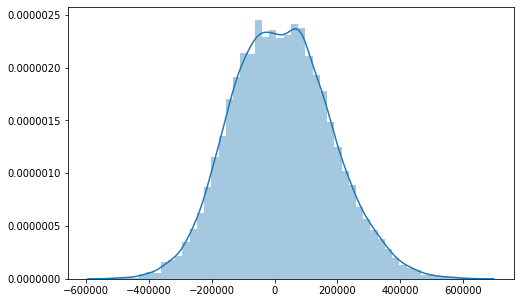

In [122]:
plt.figure(figsize=(8,5))
test_res_norm(df, features)

In [131]:
x = df[features]
y = df['price']
linereg = sm.OLS(y, x)
results = linereg.fit()
stats.shapiro(results.resid)

/Users/Alisa/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.998245358467102, 2.2760206263086613e-13)

    Residual distribution looks REALY NORMAL 

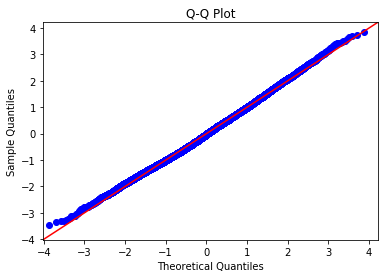

In [99]:
qqplot(df, features)

### Test hetero/homo

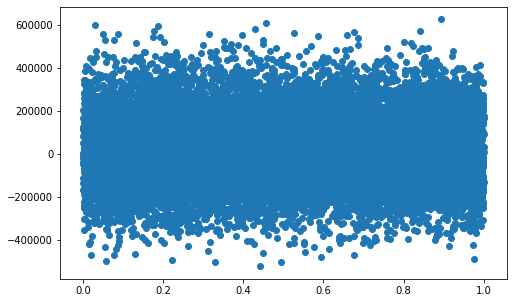

In [498]:
plt.figure(figsize=(8,5))
test_het_resid(df, features)

    Great not cone shaped

### Test MSE

In [180]:
x = df[features]
y = df['price']
test_mse(x, y)

13473 4492 13473 4492


(20702774995.035, 143884.589)

     Has a bit larger average error of $145,00

### Train Test Split Graph

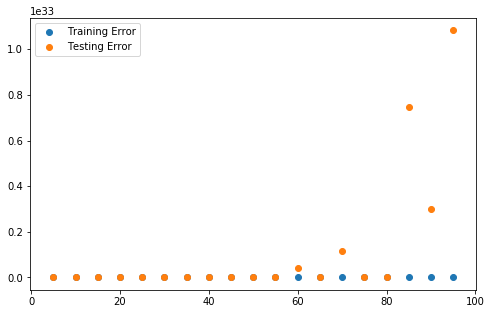

In [500]:
plt.figure(figsize=(8,5))
train_test_graph_splits(x, y)

### Train Test Split Error

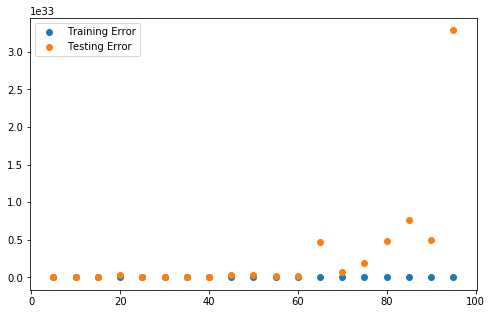

In [501]:
plt.figure(figsize=(8,5))
other_train_test(x,y)

# Does the sqft of lot and sqft-above increase the price? 

## find feature helps bedroos in model

In [6]:
columns = list(df.columns.drop(['price', 'sqft_lot15']))
features= ['sqft_lot15']

In [7]:
good_vif(df, columns, target='sqft_lot15' )

{'bedrooms': 1.98,
 'bathrooms': 1.81,
 'sqft_living': 2.08,
 'floors': 1.67,
 'condition': 1.97,
 'grade': 2.04,
 'sqft_above': 2.02,
 'sqft_basement': 1.21,
 'yr_built': 2.0,
 'zipcode': 2.0,
 'lat': 1.0,
 'long': 2.0,
 'sqft_living15': 2.18,
 'month': 1.69}

In [8]:
exp_feat = ['sqft_lot']
# for fl in floors:
#     exp_feat.append(fl)        #bad condition numbers
# for zips in zipcodes:
#     exp_feat.append(zips)         #bad condition numbers
# for bed in bedrooms: 
#     exp_feat.append(bed)        #bad condition numbers
# for bath in bathrooms:
#     exp_feat.append(bath)        #bad condition numbers
# for mon in months:
#     exp_feat.append(mon)        #bad condition numbers
# for gr in grade:
#     exp_feat.append(gr)        #bad condition numbers
# for con in condition:
#     exp_feat.append(con)        #bad condition numbers
# for yr in yrs:
#     exp_feat.append(yr)        #bad condition numbers
# exp_feat.append('sqft_living')    # Bad pvalues
exp_feat.append('sqft_above')
# exp_feat.append('sqft_basement') #bad pvalues
# exp_feat.append('long')
mk_OLS(df, exp_feat)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.861
Model:                            OLS   Adj. R-squared (uncentered):              0.861
Method:                 Least Squares   F-statistic:                          5.558e+04
Date:                Wed, 19 Feb 2020   Prob (F-statistic):                        0.00
Time:                        14:47:49   Log-Likelihood:                     -2.4296e+05
No. Observations:               17965   AIC:                                  4.859e+05
Df Residuals:                   17963   BIC:                                  4.859e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
sqft_lot       1.1412      0.119      9.583      0.000       0.908       1.375
sqft_above   246.6663      1.009    244.349      0.000     244.688     248.645
==============================================================================
Omnibus:                       82.197   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.684
Skew:                           0.148   Prob(JB):                     3.02e-18
Kurtosis:                       2.859   Cond. No.                         11.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Adding sqft_living15 to model

In [9]:
features.append('sqft_above')

In [10]:
check_vif(df, features[0], features[1])

(2.02, 'sqft_above', 'sqft_lot15')

In [11]:
exp_feat = ['sqft_lot', 'sqft_above']
# for fl in floors:
#     exp_feat.append(fl)
# for zips in zipcodes:
#     exp_feat.append(zips)
mk_OLS(df, exp_feat)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.861
Model:                            OLS   Adj. R-squared (uncentered):              0.861
Method:                 Least Squares   F-statistic:                          5.558e+04
Date:                Wed, 19 Feb 2020   Prob (F-statistic):                        0.00
Time:                        14:47:52   Log-Likelihood:                     -2.4296e+05
No. Observations:               17965   AIC:                                  4.859e+05
Df Residuals:                   17963   BIC:                                  4.859e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
sqft_lot       1.1412      0.119      9.583      0.000       0.908       1.375
sqft_above   246.6663      1.009    244.349      0.000     244.688     248.645
==============================================================================
Omnibus:                       82.197   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.684
Skew:                           0.148   Prob(JB):                     3.02e-18
Kurtosis:                       2.859   Cond. No.                         11.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

    Bad pvalues and condition numbers

## Try to add something else

In [12]:
for col in columns:
    check_vif(df, features , col)

/Users/Alisa/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in double_scalars


    All the remaining features would have multicolinearity

## Test Residuals

In [114]:
features = ['sqft_lot15', 'sqft_above']

Residual distribution


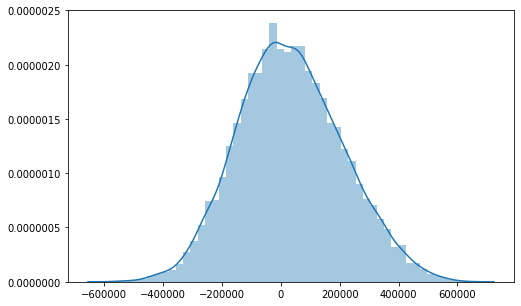

In [115]:
plt.figure(figsize=(8,5))
test_res_norm(df, features)


looks pretty normal

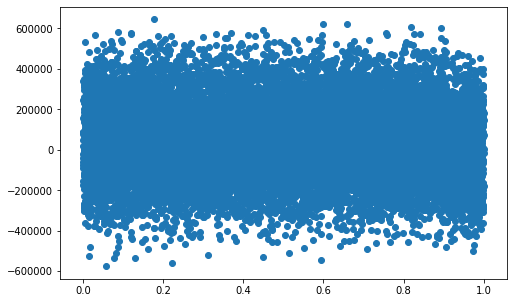

In [116]:
plt.figure(figsize=(8,5))
test_het_resid(df, features)


    No cone shape good

Show QQ Plot


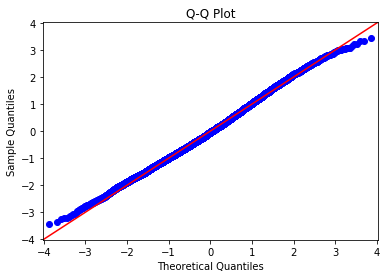

In [117]:
qqplot(df, features)

### test mse

In [192]:
x = df[features]
y= df['price']
test_mse(x, y)

13473 4492 13473 4492


(24118939152.863, 155302.734)

### Train Test Split

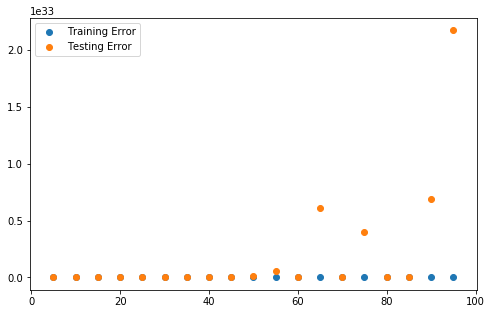

In [509]:
plt.figure(figsize=(8,5))
train_test_graph_splits(x, y)

### train test splits erros

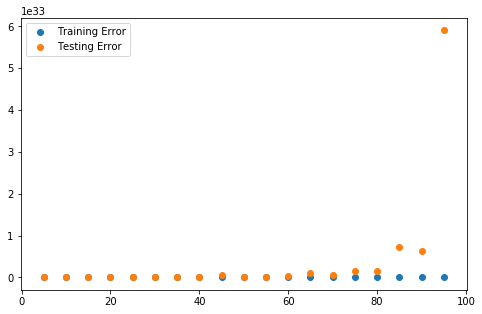

In [510]:
plt.figure(figsize=(8,5))
other_train_test(x, y)

# REALTOR or SELLER: How does Yr_built, month, condition afftect the rough selling price of a house

In [101]:
columns = list(df.columns.drop(yrs))
columns.remove('price')
features= ['yr_built_1901', 'yr_built_1902', 'yr_built_1903', 'yr_built_1904', 'yr_built_1905', 'yr_built_1906', 'yr_built_1907', 'yr_built_1908', 'yr_built_1909', 'yr_built_1910', 'yr_built_1911', 'yr_built_1912', 'yr_built_1913', 'yr_built_1914', 'yr_built_1915', 'yr_built_1916', 'yr_built_1917', 'yr_built_1918', 'yr_built_1919', 'yr_built_1920', 'yr_built_1921', 'yr_built_1922', 'yr_built_1923', 'yr_built_1924', 'yr_built_1925', 'yr_built_1926', 'yr_built_1927', 'yr_built_1928', 'yr_built_1929', 'yr_built_1930', 'yr_built_1931', 'yr_built_1932', 'yr_built_1933', 'yr_built_1934', 'yr_built_1935', 'yr_built_1936', 'yr_built_1937', 'yr_built_1938', 'yr_built_1939', 'yr_built_1940', 'yr_built_1941', 'yr_built_1942', 'yr_built_1943', 'yr_built_1944', 'yr_built_1945', 'yr_built_1946', 'yr_built_1947', 'yr_built_1948', 'yr_built_1949', 'yr_built_1950', 'yr_built_1951', 'yr_built_1952', 'yr_built_1953', 'yr_built_1954', 'yr_built_1955', 'yr_built_1956', 'yr_built_1957', 'yr_built_1958', 'yr_built_1959', 'yr_built_1960', 'yr_built_1961', 'yr_built_1962', 'yr_built_1963', 'yr_built_1964', 'yr_built_1965', 'yr_built_1966', 'yr_built_1967', 'yr_built_1968', 'yr_built_1969', 'yr_built_1970', 'yr_built_1971', 'yr_built_1972', 'yr_built_1973', 'yr_built_1974', 'yr_built_1975', 'yr_built_1976', 'yr_built_1977', 'yr_built_1978', 'yr_built_1979', 'yr_built_1980', 'yr_built_1981', 'yr_built_1982', 'yr_built_1983', 'yr_built_1984', 'yr_built_1985', 'yr_built_1986', 'yr_built_1987', 'yr_built_1988', 'yr_built_1989', 'yr_built_1990', 'yr_built_1991', 'yr_built_1992', 'yr_built_1993', 'yr_built_1994', 'yr_built_1995', 'yr_built_1996', 'yr_built_1997', 'yr_built_1998', 'yr_built_1999', 'yr_built_2000', 'yr_built_2001', 'yr_built_2002', 'yr_built_2003', 'yr_built_2004', 'yr_built_2005', 'yr_built_2006', 'yr_built_2007', 'yr_built_2008', 'yr_built_2009', 'yr_built_2010', 'yr_built_2011', 'yr_built_2012', 'yr_built_2013', 'yr_built_2014', 'yr_built_2015']


In [196]:
mk_OLS(df, features)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.874
Model:                            OLS   Adj. R-squared (uncentered):              0.873
Method:                 Least Squares   F-statistic:                              1074.
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:45:22   Log-Likelihood:                     -2.4209e+05
No. Observations:               17965   AIC:                                  4.844e+05
Df Residuals:                   17850   BIC:                                  4.853e+05
Df Model:                         115                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1901  5.148e+05   3.53e+04     14.592      0.000    4.46e+05    5.84e+05
yr_built_1902  5.564e+05    3.6e+04     15.438      0.000    4.86e+05    6.27e+05
yr_built_1903  4.639e+05   2.73e+04     16.976      0.000     4.1e+05    5.17e+05
yr_built_1904  4.951e+05    2.8e+04     17.659      0.000     4.4e+05     5.5e+05
yr_built_1905  5.321e+05   2.64e+04     20.188      0.000     4.8e+05    5.84e+05
yr_built_1906  5.325e+05   1.98e+04     26.861      0.000    4.94e+05    5.71e+05
yr_built_1907  5.344e+05   2.49e+04     21.423      0.000    4.86e+05    5.83e+05
yr_built_1908  4.906e+05    2.1e+04     23.409      0.000     4.5e+05    5.32e+05
yr_built_1909  5.272e+05   2.07e+04     25.521      0.000    4.87e+05    5.68e+05
yr_built_1910  5.004e+05   1.75e+04     28.516      0.000    4.66e+05    5.35e+05
yr_built_1911  5.397e+05   2.35e+04     22.947      0.000    4.94e+05    5.86e+05
yr_built_1912  5.034e+05   2.35e+04     21.403      0.000    4.57e+05     5.5e+05
yr_built_1913  4.975e+05    2.8e+04     17.743      0.000    4.42e+05    5.52e+05
yr_built_1914  4.708e+05   2.88e+04     16.343      0.000    4.14e+05    5.27e+05
yr_built_1915  5.237e+05   2.61e+04     20.100      0.000    4.73e+05    5.75e+05
yr_built_1916   5.09e+05   2.14e+04     23.744      0.000    4.67e+05    5.51e+05
yr_built_1917  4.694e+05   2.52e+04     18.619      0.000     4.2e+05    5.19e+05
yr_built_1918  4.228e+05   1.73e+04     24.464      0.000    3.89e+05    4.57e+05
yr_built_1919  4.718e+05   2.13e+04     22.176      0.000     4.3e+05    5.13e+05
yr_built_1920  4.616e+05    1.9e+04     24.333      0.000    4.24e+05    4.99e+05
yr_built_1921  5.313e+05   2.14e+04     24.785      0.000    4.89e+05    5.73e+05
yr_built_1922  5.013e+05   2.07e+04     24.265      0.000    4.61e+05    5.42e+05
yr_built_1923  4.841e+05   2.13e+04     22.753      0.000    4.42e+05    5.26e+05
yr_built_1924  5.045e+05   1.65e+04     30.613      0.000    4.72e+05    5.37e+05
yr_built_1925   5.04e+05   1.52e+04     33.124      0.000    4.74e+05    5.34e+05
yr_built_1926  5.261e+05   1.44e+04     36.528      0.000    4.98e+05    5.54e+05
yr_built_1927  5.408e+05   1.82e+04     29.685      0.000    5.05e+05    5.77e+05
yr_built_1928  5.118e+05   1.75e+04     29.317      0.000    4.78e+05    5.46e+05
yr_built_1929  5.243e+05   1.72e+04     30.486      0.000    4.91e+05    5.58e+05
yr_built_1930   5.03e+05   2.25e+04     22.354      0.000    4.59e+05    5.47e+05
yr_built_1931  5.292e+05   2.47e+04     21.432      0.000    4.81e+05    5.78e+05
yr_built_1932  4.056e+05   3.53e+04     11.498      0.000    3.36e+05    4.75e+05
yr_built_1933  3.563e+05   4.46e+04      7.983      0.000    2.69e+05    4.44e+05
yr_built_1934  4.228e+05   5.47e

In [197]:
exp_feat = ['yr_built_1901', 'yr_built_1902', 'yr_built_1903', 'yr_built_1904', 'yr_built_1905', 'yr_built_1906', 'yr_built_1907', 'yr_built_1908', 'yr_built_1909', 'yr_built_1910', 'yr_built_1911', 'yr_built_1912', 'yr_built_1913', 'yr_built_1914', 'yr_built_1915', 'yr_built_1916', 'yr_built_1917', 'yr_built_1918', 'yr_built_1919', 'yr_built_1920', 'yr_built_1921', 'yr_built_1922', 'yr_built_1923', 'yr_built_1924', 'yr_built_1925', 'yr_built_1926', 'yr_built_1927', 'yr_built_1928', 'yr_built_1929', 'yr_built_1930', 'yr_built_1931', 'yr_built_1932', 'yr_built_1933', 'yr_built_1934', 'yr_built_1935', 'yr_built_1936', 'yr_built_1937', 'yr_built_1938', 'yr_built_1939', 'yr_built_1940', 'yr_built_1941', 'yr_built_1942', 'yr_built_1943', 'yr_built_1944', 'yr_built_1945', 'yr_built_1946', 'yr_built_1947', 'yr_built_1948', 'yr_built_1949', 'yr_built_1950', 'yr_built_1951', 'yr_built_1952', 'yr_built_1953', 'yr_built_1954', 'yr_built_1955', 'yr_built_1956', 'yr_built_1957', 'yr_built_1958', 'yr_built_1959', 'yr_built_1960', 'yr_built_1961', 'yr_built_1962', 'yr_built_1963', 'yr_built_1964', 'yr_built_1965', 'yr_built_1966', 'yr_built_1967', 'yr_built_1968', 'yr_built_1969', 'yr_built_1970', 'yr_built_1971', 'yr_built_1972', 'yr_built_1973', 'yr_built_1974', 'yr_built_1975', 'yr_built_1976', 'yr_built_1977', 'yr_built_1978', 'yr_built_1979', 'yr_built_1980', 'yr_built_1981', 'yr_built_1982', 'yr_built_1983', 'yr_built_1984', 'yr_built_1985', 'yr_built_1986', 'yr_built_1987', 'yr_built_1988', 'yr_built_1989', 'yr_built_1990', 'yr_built_1991', 'yr_built_1992', 'yr_built_1993', 'yr_built_1994', 'yr_built_1995', 'yr_built_1996', 'yr_built_1997', 'yr_built_1998', 'yr_built_1999', 'yr_built_2000', 'yr_built_2001', 'yr_built_2002', 'yr_built_2003', 'yr_built_2004', 'yr_built_2005', 'yr_built_2006', 'yr_built_2007', 'yr_built_2008', 'yr_built_2009', 'yr_built_2010', 'yr_built_2011', 'yr_built_2012', 'yr_built_2013', 'yr_built_2014', 'yr_built_2015']
for col in columns[:8]:
    exp_feat.append(col)
    mk_OLS(df, exp_feat)
    exp_feat.pop()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.918
Model:                            OLS   Adj. R-squared (uncentered):              0.918
Method:                 Least Squares   F-statistic:                              1724.
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:45:23   Log-Likelihood:                     -2.3821e+05
No. Observations:               17965   AIC:                                  4.767e+05
Df Residuals:                   17849   BIC:                                  4.776e+05
Df Model:                         116                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1901  2.559e+05   2.85e+04      8.966      0.000       2e+05    3.12e+05
yr_built_1902   2.67e+05   2.92e+04      9.149      0.000     2.1e+05    3.24e+05
yr_built_1903  2.228e+05   2.22e+04     10.057      0.000    1.79e+05    2.66e+05
yr_built_1904  2.665e+05   2.27e+04     11.734      0.000    2.22e+05    3.11e+05
yr_built_1905  2.746e+05   2.14e+04     12.832      0.000    2.33e+05    3.17e+05
yr_built_1906  2.879e+05   1.62e+04     17.805      0.000    2.56e+05     3.2e+05
yr_built_1907  2.694e+05   2.03e+04     13.283      0.000     2.3e+05    3.09e+05
yr_built_1908  2.332e+05   1.71e+04     13.646      0.000       2e+05    2.67e+05
yr_built_1909  2.744e+05   1.68e+04     16.290      0.000    2.41e+05    3.07e+05
yr_built_1910  2.425e+05   1.44e+04     16.864      0.000    2.14e+05    2.71e+05
yr_built_1911  2.518e+05   1.92e+04     13.130      0.000    2.14e+05    2.89e+05
yr_built_1912  2.421e+05   1.91e+04     12.653      0.000    2.05e+05     2.8e+05
yr_built_1913  2.145e+05   2.28e+04      9.418      0.000     1.7e+05    2.59e+05
yr_built_1914   2.03e+05   2.34e+04      8.685      0.000    1.57e+05    2.49e+05
yr_built_1915   2.62e+05   2.12e+04     12.382      0.000    2.21e+05    3.04e+05
yr_built_1916  2.551e+05   1.75e+04     14.604      0.000    2.21e+05    2.89e+05
yr_built_1917  2.133e+05   2.05e+04     10.413      0.000    1.73e+05    2.53e+05
yr_built_1918  1.991e+05   1.41e+04     14.109      0.000    1.71e+05    2.27e+05
yr_built_1919  2.242e+05   1.73e+04     12.943      0.000     1.9e+05    2.58e+05
yr_built_1920  2.126e+05   1.55e+04     13.721      0.000    1.82e+05    2.43e+05
yr_built_1921  2.534e+05   1.75e+04     14.476      0.000    2.19e+05    2.88e+05
yr_built_1922   2.53e+05   1.68e+04     15.028      0.000     2.2e+05    2.86e+05
yr_built_1923  2.496e+05   1.73e+04     14.420      0.000    2.16e+05    2.83e+05
yr_built_1924   2.65e+05   1.35e+04     19.633      0.000    2.39e+05    2.92e+05
yr_built_1925  2.357e+05   1.26e+04     18.765      0.000    2.11e+05     2.6e+05
yr_built_1926  2.617e+05   1.19e+04     21.970      0.000    2.38e+05    2.85e+05
yr_built_1927  2.849e+05   1.49e+04     19.110      0.000    2.56e+05    3.14e+05
yr_built_1928  2.484e+05   1.43e+04     17.346      0.000     2.2e+05    2.76e+05
yr_built_1929  2.441e+05   1.41e+04     17.256      0.000    2.16e+05    2.72e+05
yr_built_1930  2.273e+05   1.83e+04     12.387      0.000    1.91e+05    2.63e+05
yr_built_1931  2.371e+05   2.01e+04     11.786      0.000    1.98e+05    2.77e+05
yr_built_1932  1.733e+05   2.85e+04      6.074      0.000    1.17e+05    2.29e+05
yr_built_1933  1.254e+05    3.6e+04      3.481      0.001    5.48e+04    1.96e+05
yr_built_1934  1.297e+05   4.41e

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.877
Model:                            OLS   Adj. R-squared (uncentered):              0.876
Method:                 Least Squares   F-statistic:                              1092.
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:45:24   Log-Likelihood:                     -2.4189e+05
No. Observations:               17965   AIC:                                  4.840e+05
Df Residuals:                   17849   BIC:                                  4.849e+05
Df Model:                         116                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1901  5.056e+05   3.49e+04     14.488      0.000    4.37e+05    5.74e+05
yr_built_1902  5.465e+05   3.56e+04     15.332      0.000    4.77e+05    6.16e+05
yr_built_1903  4.487e+05    2.7e+04     16.595      0.000    3.96e+05    5.02e+05
yr_built_1904  4.823e+05   2.77e+04     17.390      0.000    4.28e+05    5.37e+05
yr_built_1905  5.209e+05   2.61e+04     19.980      0.000     4.7e+05    5.72e+05
yr_built_1906  5.212e+05   1.96e+04     26.567      0.000    4.83e+05     5.6e+05
yr_built_1907  5.229e+05   2.47e+04     21.186      0.000    4.74e+05    5.71e+05
yr_built_1908  4.749e+05   2.07e+04     22.895      0.000    4.34e+05    5.16e+05
yr_built_1909  5.156e+05   2.04e+04     25.224      0.000    4.76e+05    5.56e+05
yr_built_1910  4.871e+05   1.74e+04     28.047      0.000    4.53e+05    5.21e+05
yr_built_1911  5.282e+05   2.33e+04     22.700      0.000    4.83e+05    5.74e+05
yr_built_1912  4.875e+05   2.33e+04     20.947      0.000    4.42e+05    5.33e+05
yr_built_1913  4.834e+05   2.77e+04     17.428      0.000    4.29e+05    5.38e+05
yr_built_1914  4.575e+05   2.85e+04     16.054      0.000    4.02e+05    5.13e+05
yr_built_1915  5.061e+05   2.58e+04     19.626      0.000    4.56e+05    5.57e+05
yr_built_1916  4.969e+05   2.12e+04     23.428      0.000    4.55e+05    5.39e+05
yr_built_1917   4.52e+05   2.49e+04     18.118      0.000    4.03e+05    5.01e+05
yr_built_1918  4.098e+05   1.71e+04     23.955      0.000    3.76e+05    4.43e+05
yr_built_1919  4.594e+05   2.11e+04     21.822      0.000    4.18e+05    5.01e+05
yr_built_1920  4.466e+05   1.88e+04     23.782      0.000     4.1e+05    4.83e+05
yr_built_1921  5.176e+05   2.12e+04     24.400      0.000    4.76e+05    5.59e+05
yr_built_1922  4.837e+05   2.05e+04     23.653      0.000    4.44e+05    5.24e+05
yr_built_1923  4.641e+05   2.11e+04     22.034      0.000    4.23e+05    5.05e+05
yr_built_1924  4.885e+05   1.63e+04     29.937      0.000    4.57e+05    5.21e+05
yr_built_1925  4.914e+05   1.51e+04     32.620      0.000    4.62e+05    5.21e+05
yr_built_1926  5.121e+05   1.43e+04     35.904      0.000    4.84e+05     5.4e+05
yr_built_1927  5.291e+05    1.8e+04     29.347      0.000    4.94e+05    5.64e+05
yr_built_1928  4.987e+05   1.73e+04     28.858      0.000    4.65e+05    5.33e+05
yr_built_1929  5.089e+05    1.7e+04     29.889      0.000    4.76e+05    5.42e+05
yr_built_1930  4.834e+05   2.23e+04     21.703      0.000     4.4e+05    5.27e+05
yr_built_1931  5.129e+05   2.44e+04     20.992      0.000    4.65e+05    5.61e+05
yr_built_1932  3.757e+05   3.49e+04     10.759      0.000    3.07e+05    4.44e+05
yr_built_1933   3.32e+05   4.42e+04      7.520      0.000    2.45e+05    4.19e+05
yr_built_1934  3.806e+05   5.41e

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.905
Model:                            OLS   Adj. R-squared (uncentered):              0.905
Method:                 Least Squares   F-statistic:                              1472.
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:45:24   Log-Likelihood:                     -2.3951e+05
No. Observations:               17965   AIC:                                  4.792e+05
Df Residuals:                   17849   BIC:                                  4.801e+05
Df Model:                         116                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1901  2.994e+05   3.07e+04      9.761      0.000    2.39e+05     3.6e+05
yr_built_1902  2.985e+05   3.14e+04      9.511      0.000    2.37e+05     3.6e+05
yr_built_1903  2.524e+05   2.38e+04     10.595      0.000    2.06e+05    2.99e+05
yr_built_1904  3.151e+05   2.44e+04     12.918      0.000    2.67e+05    3.63e+05
yr_built_1905  3.152e+05    2.3e+04     13.705      0.000     2.7e+05     3.6e+05
yr_built_1906  3.314e+05   1.74e+04     19.083      0.000    2.97e+05    3.65e+05
yr_built_1907  3.102e+05   2.18e+04     14.233      0.000    2.68e+05    3.53e+05
yr_built_1908  2.862e+05   1.83e+04     15.601      0.000     2.5e+05    3.22e+05
yr_built_1909  3.228e+05   1.81e+04     17.851      0.000    2.87e+05    3.58e+05
yr_built_1910   3.03e+05   1.54e+04     19.663      0.000    2.73e+05    3.33e+05
yr_built_1911  3.186e+05   2.06e+04     15.493      0.000    2.78e+05    3.59e+05
yr_built_1912  3.025e+05   2.05e+04     14.735      0.000    2.62e+05    3.43e+05
yr_built_1913  2.835e+05   2.44e+04     11.603      0.000    2.36e+05    3.31e+05
yr_built_1914  2.574e+05   2.51e+04     10.257      0.000    2.08e+05    3.07e+05
yr_built_1915  3.285e+05   2.27e+04     14.470      0.000    2.84e+05    3.73e+05
yr_built_1916  3.078e+05   1.87e+04     16.418      0.000    2.71e+05    3.45e+05
yr_built_1917  2.698e+05    2.2e+04     12.273      0.000    2.27e+05    3.13e+05
yr_built_1918  2.444e+05   1.51e+04     16.139      0.000    2.15e+05    2.74e+05
yr_built_1919  2.877e+05   1.86e+04     15.489      0.000    2.51e+05    3.24e+05
yr_built_1920  2.626e+05   1.66e+04     15.792      0.000     2.3e+05    2.95e+05
yr_built_1921  3.172e+05   1.88e+04     16.900      0.000     2.8e+05    3.54e+05
yr_built_1922  3.096e+05   1.81e+04     17.140      0.000    2.74e+05    3.45e+05
yr_built_1923  3.123e+05   1.86e+04     16.829      0.000    2.76e+05    3.49e+05
yr_built_1924  3.212e+05   1.45e+04     22.202      0.000    2.93e+05     3.5e+05
yr_built_1925  3.001e+05   1.34e+04     22.333      0.000    2.74e+05    3.26e+05
yr_built_1926  3.313e+05   1.27e+04     26.038      0.000    3.06e+05    3.56e+05
yr_built_1927  3.478e+05    1.6e+04     21.774      0.000    3.16e+05    3.79e+05
yr_built_1928  3.084e+05   1.53e+04     20.094      0.000    2.78e+05    3.38e+05
yr_built_1929  3.166e+05   1.51e+04     20.919      0.000    2.87e+05    3.46e+05
yr_built_1930  2.826e+05   1.97e+04     14.350      0.000    2.44e+05    3.21e+05
yr_built_1931  3.162e+05   2.16e+04     14.668      0.000    2.74e+05    3.58e+05
yr_built_1932  2.041e+05   3.07e+04      6.655      0.000    1.44e+05    2.64e+05
yr_built_1933  1.641e+05   3.87e+04      4.239      0.000    8.82e+04     2.4e+05
yr_built_1934  1.672e+05   4.74e

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.882
Model:                            OLS   Adj. R-squared (uncentered):              0.881
Method:                 Least Squares   F-statistic:                              1147.
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:45:24   Log-Likelihood:                     -2.4150e+05
No. Observations:               17965   AIC:                                  4.832e+05
Df Residuals:                   17849   BIC:                                  4.841e+05
Df Model:                         116                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1901  4.907e+05   3.42e+04     14.368      0.000    4.24e+05    5.58e+05
yr_built_1902  5.427e+05   3.49e+04     15.559      0.000    4.74e+05    6.11e+05
yr_built_1903  4.499e+05   2.65e+04     17.011      0.000    3.98e+05    5.02e+05
yr_built_1904  4.681e+05   2.71e+04     17.245      0.000    4.15e+05    5.21e+05
yr_built_1905  5.102e+05   2.55e+04     19.994      0.000     4.6e+05     5.6e+05
yr_built_1906  5.082e+05   1.92e+04     26.468      0.000    4.71e+05    5.46e+05
yr_built_1907  5.126e+05   2.42e+04     21.225      0.000    4.65e+05     5.6e+05
yr_built_1908  4.591e+05   2.03e+04     22.612      0.000    4.19e+05    4.99e+05
yr_built_1909   4.99e+05      2e+04     24.940      0.000     4.6e+05    5.38e+05
yr_built_1910  4.631e+05    1.7e+04     27.212      0.000     4.3e+05    4.96e+05
yr_built_1911  4.988e+05   2.28e+04     21.885      0.000    4.54e+05    5.44e+05
yr_built_1912  4.662e+05   2.28e+04     20.460      0.000    4.22e+05    5.11e+05
yr_built_1913  4.576e+05   2.72e+04     16.849      0.000    4.04e+05    5.11e+05
yr_built_1914  4.385e+05   2.79e+04     15.720      0.000    3.84e+05    4.93e+05
yr_built_1915  4.819e+05   2.52e+04     19.087      0.000    4.32e+05    5.31e+05
yr_built_1916  4.807e+05   2.08e+04     23.153      0.000     4.4e+05    5.21e+05
yr_built_1917  4.363e+05   2.44e+04     17.870      0.000    3.88e+05    4.84e+05
yr_built_1918  3.981e+05   1.67e+04     23.777      0.000    3.65e+05    4.31e+05
yr_built_1919  4.341e+05   2.06e+04     21.056      0.000    3.94e+05    4.75e+05
yr_built_1920  4.321e+05   1.84e+04     23.509      0.000    3.96e+05    4.68e+05
yr_built_1921  4.921e+05   2.08e+04     23.685      0.000    4.51e+05    5.33e+05
yr_built_1922  4.671e+05      2e+04     23.336      0.000    4.28e+05    5.06e+05
yr_built_1923  4.441e+05   2.06e+04     21.536      0.000    4.04e+05    4.85e+05
yr_built_1924  4.698e+05    1.6e+04     29.402      0.000    4.39e+05    5.01e+05
yr_built_1925  4.657e+05   1.48e+04     31.535      0.000    4.37e+05    4.95e+05
yr_built_1926   4.86e+05    1.4e+04     34.744      0.000    4.59e+05    5.13e+05
yr_built_1927  5.015e+05   1.77e+04     28.386      0.000    4.67e+05    5.36e+05
yr_built_1928   4.76e+05   1.69e+04     28.117      0.000    4.43e+05    5.09e+05
yr_built_1929  4.785e+05   1.67e+04     28.658      0.000    4.46e+05    5.11e+05
yr_built_1930  4.716e+05   2.18e+04     21.636      0.000    4.29e+05    5.14e+05
yr_built_1931  4.786e+05   2.39e+04     19.993      0.000    4.32e+05    5.26e+05
yr_built_1932  3.904e+05   3.41e+04     11.432      0.000    3.23e+05    4.57e+05
yr_built_1933  3.348e+05   4.32e+04      7.752      0.000     2.5e+05     4.2e+05
yr_built_1934  4.047e+05   5.29e

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     11.88
Date:                Sun, 16 Feb 2020   Prob (F-statistic):          6.88e-204
Time:                        21:45:25   Log-Likelihood:            -2.4180e+05
No. Observations:               17965   AIC:                         4.838e+05
Df Residuals:                   17849   BIC:                         4.847e+05
Df Model:                         115                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1901 -2745.8611   4.08e+04     -0.067      0.946   -8.27e+04    7.72e+04
yr_built_1902  3.881e+04   4.14e+04      0.937      0.349   -4.24e+04     1.2e+05
yr_built_1903 -5.363e+04   3.44e+04     -1.560      0.119   -1.21e+05    1.38e+04
yr_built_1904 -2.244e+04   3.49e+04     -0.642      0.521   -9.09e+04     4.6e+04
yr_built_1905  1.456e+04   3.36e+04      0.433      0.665   -5.14e+04    8.05e+04
yr_built_1906  1.498e+04    2.9e+04      0.517      0.605   -4.18e+04    7.18e+04
yr_built_1907  1.689e+04   3.26e+04      0.518      0.604    -4.7e+04    8.08e+04
yr_built_1908 -2.692e+04   2.97e+04     -0.905      0.365   -8.52e+04    3.14e+04
yr_built_1909  9648.7698   2.95e+04      0.327      0.744   -4.82e+04    6.75e+04
yr_built_1910 -1.713e+04   2.75e+04     -0.622      0.534   -7.11e+04    3.68e+04
yr_built_1911  2.217e+04   3.15e+04      0.703      0.482   -3.97e+04     8.4e+04
yr_built_1912 -1.414e+04   3.15e+04     -0.448      0.654    -7.6e+04    4.77e+04
yr_built_1913 -2.009e+04   3.49e+04     -0.575      0.565   -8.86e+04    4.84e+04
yr_built_1914 -4.677e+04   3.55e+04     -1.316      0.188   -1.16e+05    2.29e+04
yr_built_1915  6171.6237   3.34e+04      0.185      0.853   -5.93e+04    7.17e+04
yr_built_1916 -8530.5521   3.01e+04     -0.284      0.777   -6.75e+04    5.04e+04
yr_built_1917 -4.815e+04   3.28e+04     -1.469      0.142   -1.12e+05    1.61e+04
yr_built_1918 -9.473e+04   2.74e+04     -3.463      0.001   -1.48e+05   -4.11e+04
yr_built_1919 -4.577e+04      3e+04     -1.528      0.127   -1.04e+05     1.3e+04
yr_built_1920 -5.592e+04   2.84e+04     -1.968      0.049   -1.12e+05    -211.772
yr_built_1921  1.378e+04   3.01e+04      0.458      0.647   -4.52e+04    7.27e+04
yr_built_1922 -1.629e+04   2.95e+04     -0.552      0.581   -7.42e+04    4.16e+04
yr_built_1923 -3.348e+04      3e+04     -1.118      0.264   -9.22e+04    2.52e+04
yr_built_1924 -1.306e+04   2.69e+04     -0.486      0.627   -6.57e+04    3.96e+04
yr_built_1925 -1.349e+04   2.61e+04     -0.516      0.606   -6.47e+04    3.77e+04
yr_built_1926  8567.7222   2.57e+04      0.333      0.739   -4.18e+04    5.89e+04
yr_built_1927  2.326e+04   2.79e+04      0.832      0.405   -3.15e+04     7.8e+04
yr_built_1928 -5703.6995   2.75e+04     -0.208      0.835   -5.95e+04    4.81e+04
yr_built_1929  6734.1793   2.73e+04      0.247      0.805   -4.68e+04    6.03e+04
yr_built_1930 -1.455e+04   3.08e+04     -0.472      0.637   -7.49e+04    4.58e+04
yr_built_1931  1.162e+04   3.24e+04      0.359      0.720   -5.19e+04    7.51e+04
yr_built_1932 -1.119e+05   4.08e+04     -2.743      0.006   -1.92e+05   -3.19e+04
yr_built_1933 -1.613e+05   4.89e+04     -3.301      0.001   -2.57e+05   -6.55e+04
yr_built_1934 -9.472e+04   5.79e+04     -1.636      0.102   -2.08e+05    1.88e+04
yr_built_1935 -1.378e+05   4.89e+04     -2.820   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.878
Model:                            OLS   Adj. R-squared (uncentered):              0.877
Method:                 Least Squares   F-statistic:                              1104.
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:45:25   Log-Likelihood:                     -2.4181e+05
No. Observations:               17965   AIC:                                  4.838e+05
Df Residuals:                   17849   BIC:                                  4.847e+05
Df Model:                         116                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1901  -756.3961   4.08e+04     -0.019      0.985   -8.07e+04    7.92e+04
yr_built_1902   4.08e+04   4.14e+04      0.985      0.325   -4.04e+04    1.22e+05
yr_built_1903 -5.164e+04   3.44e+04     -1.502      0.133   -1.19e+05    1.58e+04
yr_built_1904 -2.045e+04   3.49e+04     -0.585      0.558   -8.89e+04     4.8e+04
yr_built_1905  1.665e+04   3.36e+04      0.495      0.621   -4.93e+04    8.26e+04
yr_built_1906  1.713e+04    2.9e+04      0.591      0.554   -3.97e+04    7.39e+04
yr_built_1907  1.888e+04   3.26e+04      0.579      0.562    -4.5e+04    8.28e+04
yr_built_1908 -2.493e+04   2.97e+04     -0.838      0.402   -8.32e+04    3.34e+04
yr_built_1909   1.17e+04   2.95e+04      0.396      0.692   -4.62e+04    6.96e+04
yr_built_1910 -1.514e+04   2.75e+04     -0.550      0.582   -6.91e+04    3.88e+04
yr_built_1911  2.424e+04   3.15e+04      0.769      0.442   -3.76e+04    8.61e+04
yr_built_1912 -1.207e+04   3.15e+04     -0.383      0.702   -7.39e+04    4.97e+04
yr_built_1913 -1.777e+04   3.49e+04     -0.509      0.611   -8.62e+04    5.07e+04
yr_built_1914 -4.478e+04   3.55e+04     -1.260      0.208   -1.14e+05    2.49e+04
yr_built_1915  8257.1308   3.34e+04      0.247      0.805   -5.72e+04    7.38e+04
yr_built_1916 -6411.0609   3.01e+04     -0.213      0.831   -6.53e+04    5.25e+04
yr_built_1917 -4.598e+04   3.28e+04     -1.403      0.161    -1.1e+05    1.83e+04
yr_built_1918 -9.265e+04   2.74e+04     -3.387      0.001   -1.46e+05    -3.9e+04
yr_built_1919 -4.378e+04      3e+04     -1.461      0.144   -1.03e+05    1.49e+04
yr_built_1920 -5.372e+04   2.84e+04     -1.891      0.059   -1.09e+05    1969.397
yr_built_1921  1.583e+04   3.01e+04      0.527      0.598   -4.31e+04    7.48e+04
yr_built_1922 -1.406e+04   2.95e+04     -0.476      0.634   -7.19e+04    4.38e+04
yr_built_1923  -3.13e+04      3e+04     -1.045      0.296      -9e+04    2.74e+04
yr_built_1924   -1.1e+04   2.69e+04     -0.409      0.682   -6.37e+04    4.17e+04
yr_built_1925 -1.147e+04   2.61e+04     -0.439      0.661   -6.27e+04    3.98e+04
yr_built_1926  1.056e+04   2.57e+04      0.411      0.681   -3.98e+04    6.09e+04
yr_built_1927  2.525e+04   2.79e+04      0.904      0.366   -2.95e+04       8e+04
yr_built_1928 -3627.9927   2.75e+04     -0.132      0.895   -5.75e+04    5.02e+04
yr_built_1929  8765.4844   2.73e+04      0.321      0.748   -4.48e+04    6.23e+04
yr_built_1930 -1.249e+04   3.08e+04     -0.405      0.685   -7.29e+04    4.79e+04
yr_built_1931  1.387e+04   3.24e+04      0.428      0.668   -4.96e+04    7.74e+04
yr_built_1932 -1.096e+05   4.08e+04     -2.686      0.007    -1.9e+05   -2.96e+04
yr_built_1933 -1.593e+05   4.89e+04     -3.260      0.001   -2.55e+05   -6.35e+04
yr_built_1934 -9.231e+04   5.79e

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.913
Model:                            OLS   Adj. R-squared (uncentered):              0.913
Method:                 Least Squares   F-statistic:                              1619.
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:45:26   Log-Likelihood:                     -2.3873e+05
No. Observations:               17965   AIC:                                  4.777e+05
Df Residuals:                   17849   BIC:                                  4.786e+05
Df Model:                         116                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1901  2.442e+05   2.94e+04      8.305      0.000    1.87e+05    3.02e+05
yr_built_1902   2.29e+05   3.01e+04      7.605      0.000     1.7e+05    2.88e+05
yr_built_1903  1.778e+05   2.29e+04      7.769      0.000    1.33e+05    2.23e+05
yr_built_1904  1.962e+05   2.35e+04      8.356      0.000     1.5e+05    2.42e+05
yr_built_1905  2.419e+05   2.21e+04     10.949      0.000    1.99e+05    2.85e+05
yr_built_1906  2.439e+05   1.67e+04     14.561      0.000    2.11e+05    2.77e+05
yr_built_1907  2.256e+05    2.1e+04     10.760      0.000    1.85e+05    2.67e+05
yr_built_1908  1.738e+05   1.77e+04      9.802      0.000    1.39e+05    2.09e+05
yr_built_1909  2.209e+05   1.75e+04     12.647      0.000    1.87e+05    2.55e+05
yr_built_1910  1.999e+05   1.49e+04     13.393      0.000    1.71e+05    2.29e+05
yr_built_1911  2.513e+05   1.98e+04     12.716      0.000    2.13e+05     2.9e+05
yr_built_1912   2.03e+05   1.98e+04     10.261      0.000    1.64e+05    2.42e+05
yr_built_1913  1.942e+05   2.35e+04      8.265      0.000    1.48e+05     2.4e+05
yr_built_1914  1.763e+05   2.41e+04      7.312      0.000    1.29e+05    2.24e+05
yr_built_1915  2.346e+05   2.18e+04     10.740      0.000    1.92e+05    2.77e+05
yr_built_1916  2.131e+05   1.81e+04     11.790      0.000    1.78e+05    2.49e+05
yr_built_1917  1.718e+05   2.12e+04      8.119      0.000     1.3e+05    2.13e+05
yr_built_1918  1.409e+05   1.47e+04      9.602      0.000    1.12e+05     1.7e+05
yr_built_1919  1.903e+05   1.79e+04     10.620      0.000    1.55e+05    2.25e+05
yr_built_1920  1.713e+05   1.61e+04     10.669      0.000     1.4e+05    2.03e+05
yr_built_1921  2.239e+05   1.81e+04     12.367      0.000    1.88e+05    2.59e+05
yr_built_1922  1.973e+05   1.75e+04     11.298      0.000    1.63e+05    2.31e+05
yr_built_1923  1.921e+05   1.79e+04     10.709      0.000    1.57e+05    2.27e+05
yr_built_1924  2.099e+05   1.41e+04     14.942      0.000    1.82e+05    2.37e+05
yr_built_1925  2.094e+05    1.3e+04     16.061      0.000    1.84e+05    2.35e+05
yr_built_1926  2.323e+05   1.24e+04     18.764      0.000    2.08e+05    2.57e+05
yr_built_1927  2.436e+05   1.55e+04     15.754      0.000    2.13e+05    2.74e+05
yr_built_1928  2.017e+05   1.49e+04     13.557      0.000    1.73e+05    2.31e+05
yr_built_1929  2.268e+05   1.46e+04     15.491      0.000    1.98e+05    2.55e+05
yr_built_1930  2.121e+05   1.89e+04     11.200      0.000    1.75e+05    2.49e+05
yr_built_1931  2.285e+05   2.07e+04     11.013      0.000    1.88e+05    2.69e+05
yr_built_1932  8.835e+04   2.95e+04      2.998      0.003    3.06e+04    1.46e+05
yr_built_1933   3.62e+04   3.72e+04      0.974      0.330   -3.67e+04    1.09e+05
yr_built_1934  1.445e+05   4.54e

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.876
Model:                            OLS   Adj. R-squared (uncentered):              0.876
Method:                 Least Squares   F-statistic:                              1091.
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:45:26   Log-Likelihood:                     -2.4190e+05
No. Observations:               17965   AIC:                                  4.840e+05
Df Residuals:                   17849   BIC:                                  4.849e+05
Df Model:                         116                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1901  5.034e+05   3.49e+04     14.418      0.000    4.35e+05    5.72e+05
yr_built_1902  5.444e+05   3.57e+04     15.265      0.000    4.75e+05    6.14e+05
yr_built_1903  4.488e+05   2.71e+04     16.592      0.000    3.96e+05    5.02e+05
yr_built_1904  4.815e+05   2.78e+04     17.351      0.000    4.27e+05    5.36e+05
yr_built_1905  5.179e+05   2.61e+04     19.853      0.000    4.67e+05    5.69e+05
yr_built_1906  5.199e+05   1.96e+04     26.491      0.000    4.81e+05    5.58e+05
yr_built_1907  5.207e+05   2.47e+04     21.088      0.000    4.72e+05    5.69e+05
yr_built_1908  4.743e+05   2.08e+04     22.850      0.000    4.34e+05    5.15e+05
yr_built_1909  5.131e+05   2.05e+04     25.086      0.000    4.73e+05    5.53e+05
yr_built_1910  4.839e+05   1.74e+04     27.835      0.000     4.5e+05    5.18e+05
yr_built_1911  5.262e+05   2.33e+04     22.601      0.000    4.81e+05    5.72e+05
yr_built_1912  4.872e+05   2.33e+04     20.924      0.000    4.42e+05    5.33e+05
yr_built_1913   4.81e+05   2.78e+04     17.330      0.000    4.27e+05    5.35e+05
yr_built_1914  4.552e+05   2.85e+04     15.965      0.000    3.99e+05    5.11e+05
yr_built_1915  5.038e+05   2.58e+04     19.527      0.000    4.53e+05    5.54e+05
yr_built_1916   4.94e+05   2.12e+04     23.273      0.000    4.52e+05    5.36e+05
yr_built_1917  4.516e+05    2.5e+04     18.093      0.000    4.03e+05    5.01e+05
yr_built_1918  4.066e+05   1.71e+04     23.749      0.000    3.73e+05     4.4e+05
yr_built_1919  4.556e+05   2.11e+04     21.626      0.000    4.14e+05    4.97e+05
yr_built_1920  4.435e+05   1.88e+04     23.600      0.000    4.07e+05     4.8e+05
yr_built_1921  5.156e+05   2.12e+04     24.291      0.000    4.74e+05    5.57e+05
yr_built_1922  4.822e+05   2.05e+04     23.562      0.000    4.42e+05    5.22e+05
yr_built_1923  4.666e+05   2.11e+04     22.145      0.000    4.25e+05    5.08e+05
yr_built_1924  4.883e+05   1.63e+04     29.907      0.000    4.56e+05     5.2e+05
yr_built_1925  4.889e+05   1.51e+04     32.424      0.000    4.59e+05    5.18e+05
yr_built_1926  5.095e+05   1.43e+04     35.692      0.000    4.82e+05    5.38e+05
yr_built_1927  5.259e+05    1.8e+04     29.146      0.000     4.9e+05    5.61e+05
yr_built_1928  4.951e+05   1.73e+04     28.623      0.000    4.61e+05    5.29e+05
yr_built_1929  5.083e+05    1.7e+04     29.838      0.000    4.75e+05    5.42e+05
yr_built_1930  4.801e+05   2.23e+04     21.537      0.000    4.36e+05    5.24e+05
yr_built_1931  5.094e+05   2.45e+04     20.833      0.000    4.61e+05    5.57e+05
yr_built_1932   3.81e+05   3.49e+04     10.907      0.000    3.13e+05    4.49e+05
yr_built_1933  3.267e+05   4.42e+04      7.396      0.000     2.4e+05    4.13e+05
yr_built_1934  3.906e+05   5.41e

In [198]:
exp_feat = ['yr_built_1901', 'yr_built_1902', 'yr_built_1903', 'yr_built_1904', 'yr_built_1905', 'yr_built_1906', 'yr_built_1907', 'yr_built_1908', 'yr_built_1909', 'yr_built_1910', 'yr_built_1911', 'yr_built_1912', 'yr_built_1913', 'yr_built_1914', 'yr_built_1915', 'yr_built_1916', 'yr_built_1917', 'yr_built_1918', 'yr_built_1919', 'yr_built_1920', 'yr_built_1921', 'yr_built_1922', 'yr_built_1923', 'yr_built_1924', 'yr_built_1925', 'yr_built_1926', 'yr_built_1927', 'yr_built_1928', 'yr_built_1929', 'yr_built_1930', 'yr_built_1931', 'yr_built_1932', 'yr_built_1933', 'yr_built_1934', 'yr_built_1935', 'yr_built_1936', 'yr_built_1937', 'yr_built_1938', 'yr_built_1939', 'yr_built_1940', 'yr_built_1941', 'yr_built_1942', 'yr_built_1943', 'yr_built_1944', 'yr_built_1945', 'yr_built_1946', 'yr_built_1947', 'yr_built_1948', 'yr_built_1949', 'yr_built_1950', 'yr_built_1951', 'yr_built_1952', 'yr_built_1953', 'yr_built_1954', 'yr_built_1955', 'yr_built_1956', 'yr_built_1957', 'yr_built_1958', 'yr_built_1959', 'yr_built_1960', 'yr_built_1961', 'yr_built_1962', 'yr_built_1963', 'yr_built_1964', 'yr_built_1965', 'yr_built_1966', 'yr_built_1967', 'yr_built_1968', 'yr_built_1969', 'yr_built_1970', 'yr_built_1971', 'yr_built_1972', 'yr_built_1973', 'yr_built_1974', 'yr_built_1975', 'yr_built_1976', 'yr_built_1977', 'yr_built_1978', 'yr_built_1979', 'yr_built_1980', 'yr_built_1981', 'yr_built_1982', 'yr_built_1983', 'yr_built_1984', 'yr_built_1985', 'yr_built_1986', 'yr_built_1987', 'yr_built_1988', 'yr_built_1989', 'yr_built_1990', 'yr_built_1991', 'yr_built_1992', 'yr_built_1993', 'yr_built_1994', 'yr_built_1995', 'yr_built_1996', 'yr_built_1997', 'yr_built_1998', 'yr_built_1999', 'yr_built_2000', 'yr_built_2001', 'yr_built_2002', 'yr_built_2003', 'yr_built_2004', 'yr_built_2005', 'yr_built_2006', 'yr_built_2007', 'yr_built_2008', 'yr_built_2009', 'yr_built_2010', 'yr_built_2011', 'yr_built_2012', 'yr_built_2013', 'yr_built_2014', 'yr_built_2015']
# for fl in floors:
#     exp_feat.append(fl)    # APPROVED
# for gr in grade:
#     exp_feat.append(gr)     # REJECT
for con in condition:
    exp_feat.append(con)    # APPROVED
# for zips in zipcodes:
#     exp_feat.append(zips)      # APPROVED
# for bed in bedrooms:
#     exp_feat.append(bed)      # Appproved
# # for bath in bathrooms:
# #     exp_feat.append(bath)    # REJCTED
# for mon in months:
#     exp_feat.append(mon)    # appproved

mk_OLS(df, exp_feat)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.878
Model:                            OLS   Adj. R-squared (uncentered):              0.877
Method:                 Least Squares   F-statistic:                              1085.
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:45:27   Log-Likelihood:                     -2.4181e+05
No. Observations:               17965   AIC:                                  4.839e+05
Df Residuals:                   17847   BIC:                                  4.848e+05
Df Model:                         118                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1901  2.543e+05   3.69e+04      6.893      0.000    1.82e+05    3.27e+05
yr_built_1902  2.985e+05   3.76e+04      7.938      0.000    2.25e+05    3.72e+05
yr_built_1903  2.123e+05   2.95e+04      7.193      0.000    1.54e+05     2.7e+05
yr_built_1904   2.31e+05   3.03e+04      7.628      0.000    1.72e+05     2.9e+05
yr_built_1905  2.737e+05   2.87e+04      9.548      0.000    2.18e+05     3.3e+05
yr_built_1906  2.914e+05   2.26e+04     12.871      0.000    2.47e+05    3.36e+05
yr_built_1907   2.75e+05   2.75e+04      9.987      0.000    2.21e+05    3.29e+05
yr_built_1908  2.297e+05    2.4e+04      9.568      0.000    1.83e+05    2.77e+05
yr_built_1909  2.643e+05   2.38e+04     11.081      0.000    2.18e+05    3.11e+05
yr_built_1910  2.425e+05   2.12e+04     11.428      0.000    2.01e+05    2.84e+05
yr_built_1911   2.77e+05   2.62e+04     10.572      0.000    2.26e+05    3.28e+05
yr_built_1912  2.457e+05   2.62e+04      9.386      0.000    1.94e+05    2.97e+05
yr_built_1913  2.434e+05   3.01e+04      8.075      0.000    1.84e+05    3.03e+05
yr_built_1914  2.234e+05   3.07e+04      7.278      0.000    1.63e+05    2.84e+05
yr_built_1915    2.6e+05   2.85e+04      9.117      0.000    2.04e+05    3.16e+05
yr_built_1916  2.467e+05   2.44e+04     10.103      0.000    1.99e+05    2.95e+05
yr_built_1917  2.037e+05   2.78e+04      7.333      0.000    1.49e+05    2.58e+05
yr_built_1918  1.688e+05   2.09e+04      8.064      0.000    1.28e+05     2.1e+05
yr_built_1919  2.118e+05   2.43e+04      8.727      0.000    1.64e+05    2.59e+05
yr_built_1920  2.097e+05   2.22e+04      9.445      0.000    1.66e+05    2.53e+05
yr_built_1921  2.756e+05   2.44e+04     11.290      0.000    2.28e+05    3.23e+05
yr_built_1922  2.492e+05   2.37e+04     10.533      0.000    2.03e+05    2.96e+05
yr_built_1923  2.219e+05   2.44e+04      9.108      0.000    1.74e+05     2.7e+05
yr_built_1924  2.477e+05   2.03e+04     12.197      0.000    2.08e+05    2.88e+05
yr_built_1925  2.488e+05   1.92e+04     12.935      0.000    2.11e+05    2.87e+05
yr_built_1926  2.652e+05   1.88e+04     14.098      0.000    2.28e+05    3.02e+05
yr_built_1927  2.802e+05   2.18e+04     12.836      0.000    2.37e+05    3.23e+05
yr_built_1928  2.552e+05    2.1e+04     12.147      0.000    2.14e+05    2.96e+05
yr_built_1929  2.678e+05   2.09e+04     12.789      0.000    2.27e+05    3.09e+05
yr_built_1930   2.42e+05   2.54e+04      9.522      0.000    1.92e+05    2.92e+05
yr_built_1931    2.7e+05   2.72e+04      9.924      0.000    2.17e+05    3.23e+05
yr_built_1932  1.445e+05   3.69e+04      3.916      0.000    7.22e+04    2.17e+05
yr_built_1933   1.22e+05   4.55e+04      2.683      0.007    3.29e+04    2.11e+05
yr_built_1934  1.705e+05   5.52e

In [102]:
for con in condition:
    features.append(con)

In [200]:
exp_feat = ['condition_3','condition_4','condition_5','yr_built_1901', 'yr_built_1902', 'yr_built_1903', 'yr_built_1904', 'yr_built_1905', 'yr_built_1906', 'yr_built_1907', 'yr_built_1908', 'yr_built_1909', 'yr_built_1910', 'yr_built_1911', 'yr_built_1912', 'yr_built_1913', 'yr_built_1914', 'yr_built_1915', 'yr_built_1916', 'yr_built_1917', 'yr_built_1918', 'yr_built_1919', 'yr_built_1920', 'yr_built_1921', 'yr_built_1922', 'yr_built_1923', 'yr_built_1924', 'yr_built_1925', 'yr_built_1926', 'yr_built_1927', 'yr_built_1928', 'yr_built_1929', 'yr_built_1930', 'yr_built_1931', 'yr_built_1932', 'yr_built_1933', 'yr_built_1934', 'yr_built_1935', 'yr_built_1936', 'yr_built_1937', 'yr_built_1938', 'yr_built_1939', 'yr_built_1940', 'yr_built_1941', 'yr_built_1942', 'yr_built_1943', 'yr_built_1944', 'yr_built_1945', 'yr_built_1946', 'yr_built_1947', 'yr_built_1948', 'yr_built_1949', 'yr_built_1950', 'yr_built_1951', 'yr_built_1952', 'yr_built_1953', 'yr_built_1954', 'yr_built_1955', 'yr_built_1956', 'yr_built_1957', 'yr_built_1958', 'yr_built_1959', 'yr_built_1960', 'yr_built_1961', 'yr_built_1962', 'yr_built_1963', 'yr_built_1964', 'yr_built_1965', 'yr_built_1966', 'yr_built_1967', 'yr_built_1968', 'yr_built_1969', 'yr_built_1970', 'yr_built_1971', 'yr_built_1972', 'yr_built_1973', 'yr_built_1974', 'yr_built_1975', 'yr_built_1976', 'yr_built_1977', 'yr_built_1978', 'yr_built_1979', 'yr_built_1980', 'yr_built_1981', 'yr_built_1982', 'yr_built_1983', 'yr_built_1984', 'yr_built_1985', 'yr_built_1986', 'yr_built_1987', 'yr_built_1988', 'yr_built_1989', 'yr_built_1990', 'yr_built_1991', 'yr_built_1992', 'yr_built_1993', 'yr_built_1994', 'yr_built_1995', 'yr_built_1996', 'yr_built_1997', 'yr_built_1998', 'yr_built_1999', 'yr_built_2000', 'yr_built_2001', 'yr_built_2002', 'yr_built_2003', 'yr_built_2004', 'yr_built_2005', 'yr_built_2006', 'yr_built_2007', 'yr_built_2008', 'yr_built_2009', 'yr_built_2010', 'yr_built_2011', 'yr_built_2012', 'yr_built_2013', 'yr_built_2014', 'yr_built_2015']
# for fl in floors:
#     exp_feat.append(fl)    # APPROVED con: 98.7; skew .525;  kur: 2.659;  r2: .883
# for gr in grade:
#     exp_feat.append(gr)     # REJECT
# for zips in zipcodes:
#     exp_feat.append(zips)      # REJECTED
# for bed in bedrooms:
#     exp_feat.append(bed)      # REJECTED
# # for bath in bathrooms:
# #     exp_feat.append(bath)    # REJCTED
for mon in months:
    exp_feat.append(mon)    # appproved con:93.3; skew:.544; kur: 2.614; r2 .878

mk_OLS(df, exp_feat)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.878
Model:                            OLS   Adj. R-squared (uncentered):              0.877
Method:                 Least Squares   F-statistic:                              996.1
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:45:27   Log-Likelihood:                     -2.4178e+05
No. Observations:               17965   AIC:                                  4.838e+05
Df Residuals:                   17836   BIC:                                  4.848e+05
Df Model:                         129                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
condition_3    2.302e+05   1.27e+04     18.113      0.000    2.05e+05    2.55e+05
condition_4    2.516e+05   1.28e+04     19.681      0.000    2.27e+05    2.77e+05
condition_5     2.87e+05   1.33e+04     21.533      0.000    2.61e+05    3.13e+05
yr_built_1901  2.342e+05    3.7e+04      6.329      0.000    1.62e+05    3.07e+05
yr_built_1902  2.795e+05   3.77e+04      7.411      0.000    2.06e+05    3.53e+05
yr_built_1903  1.953e+05   2.97e+04      6.583      0.000    1.37e+05    2.53e+05
yr_built_1904  2.129e+05   3.04e+04      6.994      0.000    1.53e+05    2.73e+05
yr_built_1905   2.53e+05   2.88e+04      8.774      0.000    1.96e+05     3.1e+05
yr_built_1906  2.728e+05   2.29e+04     11.916      0.000    2.28e+05    3.18e+05
yr_built_1907  2.563e+05   2.77e+04      9.243      0.000    2.02e+05    3.11e+05
yr_built_1908  2.128e+05   2.42e+04      8.797      0.000    1.65e+05     2.6e+05
yr_built_1909  2.444e+05   2.41e+04     10.148      0.000    1.97e+05    2.92e+05
yr_built_1910  2.222e+05   2.15e+04     10.342      0.000     1.8e+05    2.64e+05
yr_built_1911  2.577e+05   2.64e+04      9.761      0.000    2.06e+05    3.09e+05
yr_built_1912  2.269e+05   2.64e+04      8.604      0.000    1.75e+05    2.79e+05
yr_built_1913  2.269e+05   3.03e+04      7.481      0.000    1.67e+05    2.86e+05
yr_built_1914  2.018e+05   3.09e+04      6.537      0.000    1.41e+05    2.62e+05
yr_built_1915  2.411e+05   2.87e+04      8.402      0.000    1.85e+05    2.97e+05
yr_built_1916  2.261e+05   2.47e+04      9.170      0.000    1.78e+05    2.74e+05
yr_built_1917  1.829e+05    2.8e+04      6.533      0.000    1.28e+05    2.38e+05
yr_built_1918  1.511e+05   2.12e+04      7.143      0.000     1.1e+05    1.93e+05
yr_built_1919  1.909e+05   2.45e+04      7.797      0.000    1.43e+05    2.39e+05
yr_built_1920  1.915e+05   2.25e+04      8.526      0.000    1.47e+05    2.36e+05
yr_built_1921  2.562e+05   2.46e+04     10.395      0.000    2.08e+05    3.05e+05
yr_built_1922  2.308e+05   2.39e+04      9.663      0.000    1.84e+05    2.78e+05
yr_built_1923  2.023e+05   2.46e+04      8.227      0.000    1.54e+05    2.51e+05
yr_built_1924  2.291e+05   2.06e+04     11.133      0.000    1.89e+05    2.69e+05
yr_built_1925  2.288e+05   1.96e+04     11.695      0.000     1.9e+05    2.67e+05
yr_built_1926  2.453e+05   1.91e+04     12.827      0.000    2.08e+05    2.83e+05
yr_built_1927  2.598e+05   2.21e+04     11.759      0.000    2.17e+05    3.03e+05
yr_built_1928  2.366e+05   2.12e+04     11.136      0.000    1.95e+05    2.78e+05
yr_built_1929  2.501e+05   2.12e+04     11.785      0.000    2.08e+05    2.92e+05
yr_built_1930  2.234e+05   2.56e+04      8.717      0.000    1.73e+05    2.74e+05
yr_built_1931  2.488e+05   2.74e

In [103]:
for mon in months:
    features.append(mon)

In [515]:
mk_OLS(df, features)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.878
Model:                            OLS   Adj. R-squared (uncentered):              0.877
Method:                 Least Squares   F-statistic:                              996.1
Date:                Mon, 17 Feb 2020   Prob (F-statistic):                        0.00
Time:                        12:58:54   Log-Likelihood:                     -2.4178e+05
No. Observations:               17965   AIC:                                  4.838e+05
Df Residuals:                   17836   BIC:                                  4.848e+05
Df Model:                         129                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built_1901  2.342e+05    3.7e+04      6.329      0.000    1.62e+05    3.07e+05
yr_built_1902  2.795e+05   3.77e+04      7.411      0.000    2.06e+05    3.53e+05
yr_built_1903  1.953e+05   2.97e+04      6.583      0.000    1.37e+05    2.53e+05
yr_built_1904  2.129e+05   3.04e+04      6.994      0.000    1.53e+05    2.73e+05
yr_built_1905   2.53e+05   2.88e+04      8.774      0.000    1.96e+05     3.1e+05
yr_built_1906  2.728e+05   2.29e+04     11.916      0.000    2.28e+05    3.18e+05
yr_built_1907  2.563e+05   2.77e+04      9.243      0.000    2.02e+05    3.11e+05
yr_built_1908  2.128e+05   2.42e+04      8.797      0.000    1.65e+05     2.6e+05
yr_built_1909  2.444e+05   2.41e+04     10.148      0.000    1.97e+05    2.92e+05
yr_built_1910  2.222e+05   2.15e+04     10.342      0.000     1.8e+05    2.64e+05
yr_built_1911  2.577e+05   2.64e+04      9.761      0.000    2.06e+05    3.09e+05
yr_built_1912  2.269e+05   2.64e+04      8.604      0.000    1.75e+05    2.79e+05
yr_built_1913  2.269e+05   3.03e+04      7.481      0.000    1.67e+05    2.86e+05
yr_built_1914  2.018e+05   3.09e+04      6.537      0.000    1.41e+05    2.62e+05
yr_built_1915  2.411e+05   2.87e+04      8.402      0.000    1.85e+05    2.97e+05
yr_built_1916  2.261e+05   2.47e+04      9.170      0.000    1.78e+05    2.74e+05
yr_built_1917  1.829e+05    2.8e+04      6.533      0.000    1.28e+05    2.38e+05
yr_built_1918  1.511e+05   2.12e+04      7.143      0.000     1.1e+05    1.93e+05
yr_built_1919  1.909e+05   2.45e+04      7.797      0.000    1.43e+05    2.39e+05
yr_built_1920  1.915e+05   2.25e+04      8.526      0.000    1.47e+05    2.36e+05
yr_built_1921  2.562e+05   2.46e+04     10.395      0.000    2.08e+05    3.05e+05
yr_built_1922  2.308e+05   2.39e+04      9.663      0.000    1.84e+05    2.78e+05
yr_built_1923  2.023e+05   2.46e+04      8.227      0.000    1.54e+05    2.51e+05
yr_built_1924  2.291e+05   2.06e+04     11.133      0.000    1.89e+05    2.69e+05
yr_built_1925  2.288e+05   1.96e+04     11.695      0.000     1.9e+05    2.67e+05
yr_built_1926  2.453e+05   1.91e+04     12.827      0.000    2.08e+05    2.83e+05
yr_built_1927  2.598e+05   2.21e+04     11.759      0.000    2.17e+05    3.03e+05
yr_built_1928  2.366e+05   2.12e+04     11.136      0.000    1.95e+05    2.78e+05
yr_built_1929  2.501e+05   2.12e+04     11.785      0.000    2.08e+05    2.92e+05
yr_built_1930  2.234e+05   2.56e+04      8.717      0.000    1.73e+05    2.74e+05
yr_built_1931  2.488e+05   2.74e+04      9.086      0.000    1.95e+05    3.03e+05
yr_built_1932  1.265e+05    3.7e+04      3.420      0.001     5.4e+04    1.99e+05
yr_built_1933  1.081e+05   4.55e+04      2.377      0.017     1.9e+04    1.97e+05
yr_built_1934  1.516e+05   5.53e

## TESTING RESIDUALS

Residual distribution


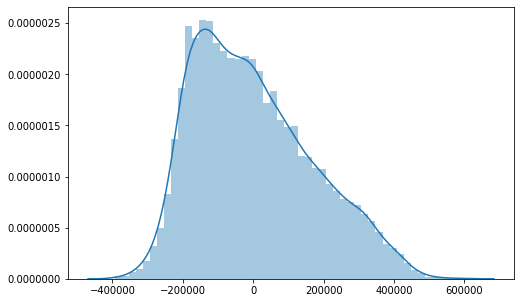

In [104]:
plt.figure(figsize=(8,5))
test_res_norm(df, features)

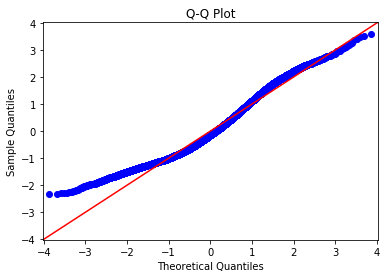

In [105]:
qqplot(df, features)

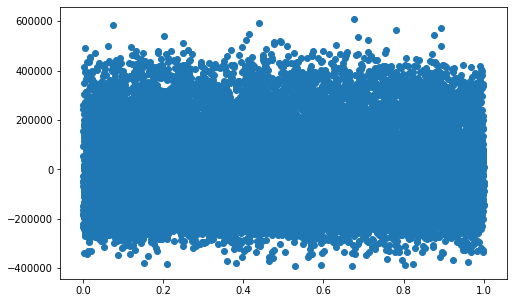

In [518]:
plt.figure(figsize=(8,5))
test_het_resid(df, features)

In [205]:
x = df[features]
y= df['price']
test_mse(x, y)

13473 4492 13473 4492


(28853368705.431, 169862.794)

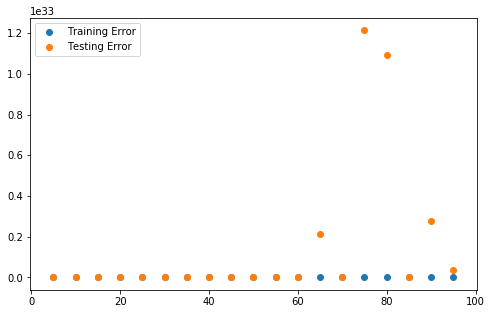

In [519]:
plt.figure(figsize=(8,5))
train_test_graph_splits(x, y)

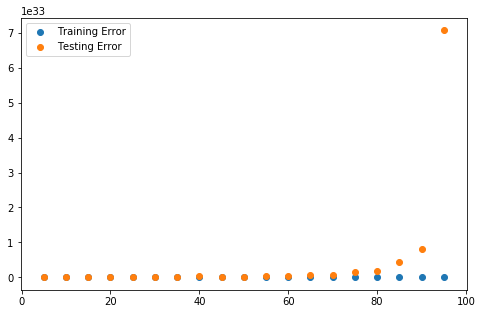

In [520]:
plt.figure(figsize=(8,5))
other_train_test(x, y)

# OTHER STUFF

In [208]:
corr_matrix = df.corr()

# sort it by the target variable
corr_matrix['price'].sort_values(ascending=False)

# convert it into a better looking dataframe
pd.DataFrame(corr_matrix['price'].sort_values(ascending=False))

price
price          1.000000
sqft_living    0.557032
sqft_living15  0.517334
sqft_above     0.463991
grade_9        0.348501
grade_10       0.261298
floors_2       0.223639
bedrooms_4     0.204188
bathrooms_3    0.202551
sqft_basement  0.193337
grade_8        0.192594
bathrooms_2    0.188126
zipcode_98075  0.172038
zipcode_98052  0.152012
zipcode_98074  0.138650
zipcode_98006  0.135598
zipcode_98040  0.123954
zipcode_98004  0.122033
zipcode_98033  0.118092
bedrooms_5     0.112148
zipcode_98053  0.109135
zipcode_98005  0.105546
zipcode_98115  0.103603
sqft_lot       0.095664
zipcode_98199  0.095605
zipcode_98103  0.092773
zipcode_98112  0.092500
zipcode_98119  0.090288
yr_built_2014  0.089239
zipcode_98029  0.088850
sqft_lot15     0.086647
zipcode_98117  0.084934
grade_11       0.084855
zipcode_98077  0.083880
zipcode_98105  0.079016
zipcode_98027  0.078426
zipcode_98109  0.070915
zipcode_98116  0.066855
zipcode_98122  0.064540
bathrooms_4    0.062838
zipcode_98107  0.062496
zipcode_98008  0.061793
zipcode_98102  0.055846
zipcode_98007  0.053915
bedrooms_6     0.053288
condition_5    0.051369
yr_built_2001  0.051266
long           0.048436
zipcode_98177  0.041828
zipcode_98065  0.040287
zipcode_98072  0.038701
yr_built_2000  0.038158
yr_built_1926  0.037964
yr_built_1927  0.035894
yr_built_2004  0.035473
yr_built_2013  0.034818
floors_3       0.034600
zipcode_98136  0.032495
yr_built_1929  0.030972
month_4        0.030222
yr_built_2005  0.030117
yr_built_1906  0.029903
zipcode_98039  0.028703
yr_built_1911  0.027436
yr_built_1921  0.027236
yr_built_1996  0.026925
yr_built_1909  0.026799
yr_built_2006  0.026354
yr_built_2015  0.026052
yr_built_1928  0.025269
yr_built_1925  0.025250
yr_built_1997  0.024491
yr_built_1907  0.024308
yr_built_1924  0.023496
yr_built_1931  0.022995
yr_built_1999  0.022404
yr_built_1905  0.022355
yr_built_1902  0.021277
yr_built_1998  0.020917
month_6        0.020483
yr_built_1910  0.020353
yr_built_1915  0.020252
zipcode_98011  0.019886
yr_built_1916  0.019592
yr_built_2007  0.019098
yr_built_1991  0.017877
yr_built_1922  0.017576
yr_built_2008  0.017173
yr_built_1930  0.016698
yr_built_1912  0.016101
zipcode_98144  0.015919
yr_built_1988  0.015053
yr_built_2010  0.014104
yr_built_1908  0.013597
month_7        0.013491
yr_built_1940  0.013224
yr_built_1901  0.013094
yr_built_1937  0.012482
yr_built_1913  0.011944
yr_built_1987  0.011793
yr_built_1984  0.011680
yr_built_1904  0.011329
yr_built_1923  0.011129
yr_built_2003  0.010564
yr_built_2011  0.010523
yr_built_1989  0.010073
yr_built_1995  0.009323
zipcode_98034  0.008279
condition_3    0.008042
yr_built_1973  0.007744
yr_built_1946  0.007268
yr_built_2002  0.007093
yr_built_1919  0.006888
month_5        0.006758
yr_built_1992  0.005727
yr_built_1917  0.005115
yr_built_1914  0.004827
yr_built_1920  0.003797
yr_built_2012  0.003631
yr_built_1903  0.003247
month_3        0.003180
yr_built_1993  0.002421
month_9        0.002053
zipcode_98045  0.001251
yr_built_1990  0.001188
yr_built_1974  0.000982
yr_built_1976 -0.000292
zipcode_98028 -0.000308
yr_built_1939 -0.000405
yr_built_1977 -0.000718
zipcode_98070 -0.000805
yr_built_1975 -0.001994
yr_built_1952 -0.002723
yr_built_1982 -0.002939
yr_built_1941 -0.003154
yr_built_1945 -0.003420
yr_built_1934 -0.003891
yr_built_1972 -0.003964
yr_built_1979 -0.004263
yr_built_2009 -0.004542
yr_built_1936 -0.005484
yr_built_1994 -0.007511
month_8       -0.007704
yr_built_1951 -0.007879
yr_built_1985 -0.007880
yr_built_1964 -0.007898
month_10      -0.008180
yr_built_1932 -0.009605
yr_built_1983 -0.009972
zipcode_98014 -0.010757
yr_built_1986 -0.011433
yr_built_1935 -0.011847
yr_built_1918 -0.012337
zipcode_98059 -0.012424
zipcode_98125 -0.012926
yr_built_1938 -0.014400
yr_built_1933 -0.015704
month_2       -0.015709
yr_built_1956 -0.016439
zipcode_98024 -0.016794
yr_built_1978 -0.017752
yr_built_1981 -0.018631
zipcode_98019 -0.019410
month_11      -0.019970
month_12      -0.020000
yr_built_1965 -0.021126
yr_built_1

In [209]:
# fig = df[subsets].hist(bins=50, color='navy', figsize=(10,10), grid=True)
# plt.tight_layout();

In [211]:
# sns.catplot(x=df[floors], y="price", data=df, height=4, aspect=2)
# plt.title('\nTimes of views vs. Price\n', fontweight='bold')
# plt.xlabel('Times a house has been viewed')
# plt.ylabel('Price');